# 7. Urban mobility: planning bicycle infrastructure

## Midterm project

In this project we will use exclusively publically available spatial urban data, unsupervised machine learning, and mathematical modelling of urban mobility to identify the routes in the city that have the most demand for bicycle trips and would most benefit of new bicycle lanes. We will visualise the results on an interactive map:

![title](images/biking.JPG)

Let's load the necessary packages.

In [1]:
# %install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime
import osmnx as ox, geopandas as gpd, pandas as pd, networkx as nx
#%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
# %load_ext autotime
# import osmnx as ox, geopandas as gpd, pandas as pd, networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon, MultiPolygon, MultiPoint
from IPython.display import Image
from descartes import PolygonPatch
from itertools import combinations, combinations_with_replacement
%matplotlib inline
ox.config(log_console=False, use_cache=True)
%config IPCompleter.greedy=True
import contextily as ctx

time: 3.2 s (started: 2021-09-27 23:12:10 +01:00)


## Getting the biking infrastructure

Let's use the `osmnx` package to download and plot the Milan street network from OpenStreetMap.

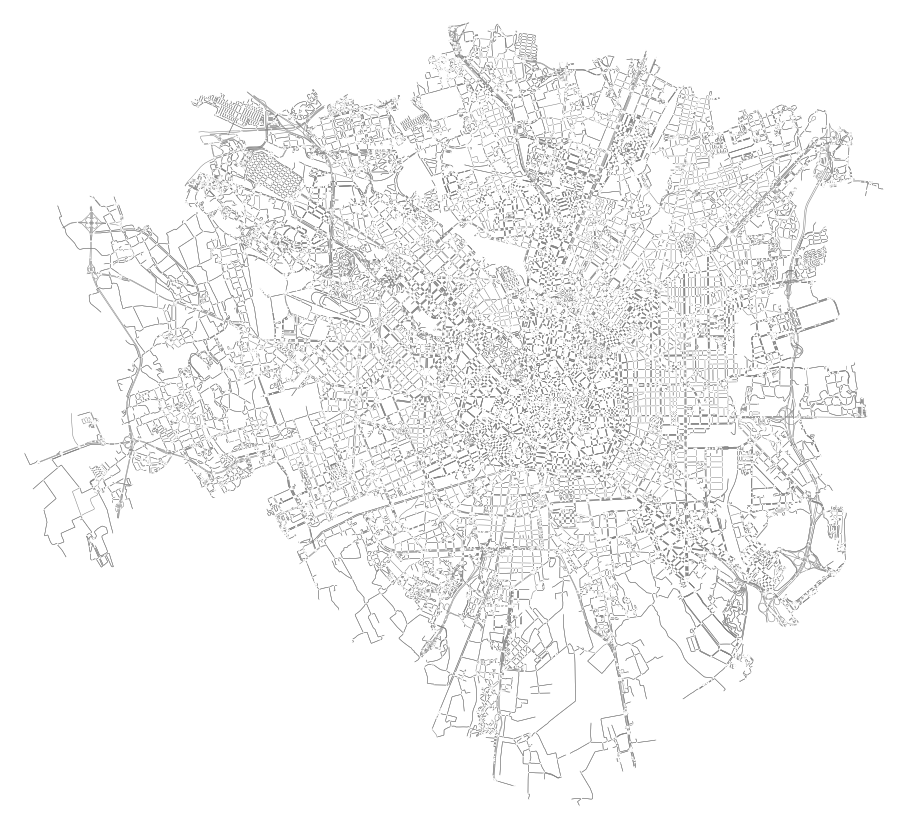

time: 1min 51s (started: 2021-09-27 23:12:13 +01:00)


In [2]:
# download the Milan street network
G = ox.graph_from_place('Milan, Italy', network_type="all")
#G = ox.project_graph(G)
fig, ax = ox.plot_graph(G, figsize=(16, 16), bgcolor='w', node_size=2, node_color='w', node_edgecolor='none', node_zorder=2,
                        edge_color='grey', edge_linewidth=0.5, edge_alpha=1)

Now, let's load the existing biking network in Milan:

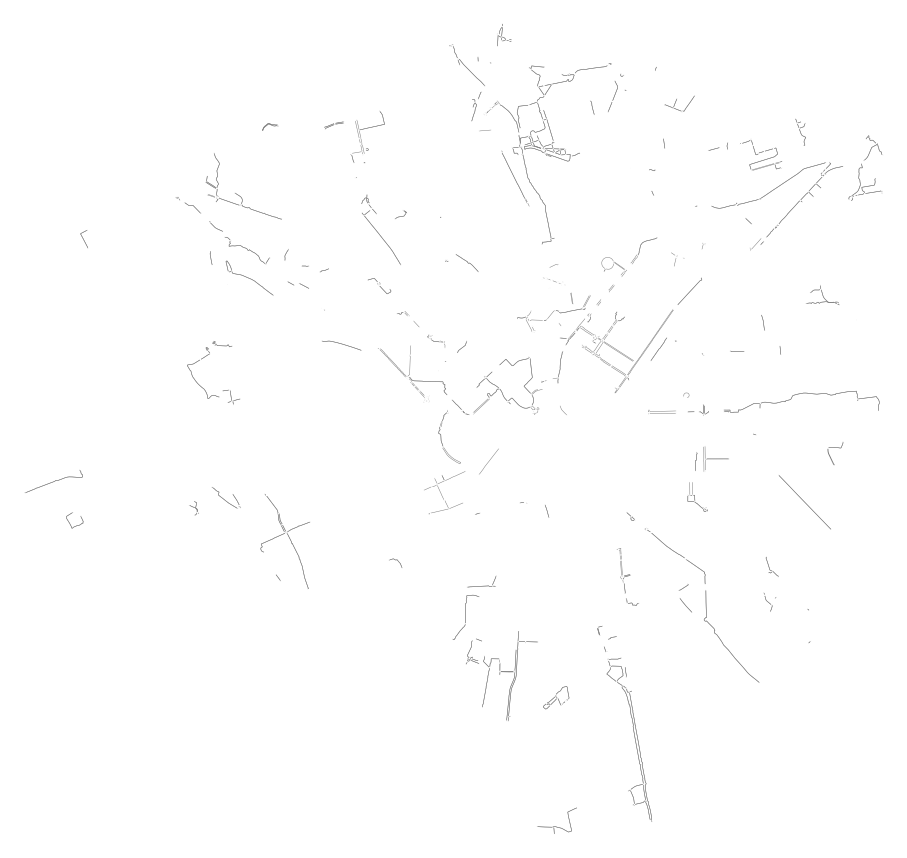

time: 6.67 s (started: 2021-09-27 23:14:05 +01:00)


In [3]:
# download and project the biking network
G_bike = ox.graph_from_place('Milan, Italy', custom_filter='["highway"~"cycleway"]', retain_all=True)
G_bike = ox.project_graph(G_bike)
fig, ax = ox.plot_graph(G_bike, figsize=(16, 16), bgcolor='w', node_size=2, node_color='w', node_edgecolor='none', node_zorder=2,
                        edge_color='grey', edge_linewidth=0.5, edge_alpha=1)

In order to understand where the city of Milan should invest in building new bicycle infrastructure, we will use mathematical models of urban mobility which takes as input the population densities at specific locations in the city and predicts the mobility flow between them. In order to estimate biking demand, we will take the resulting flows for relatively short distances - under 3.5 kilometers - assuming that these flows, mostly completed by car, could in part be replaced with bicycle trips. 

But first, we need the urban population density distribution.

## Getting Milan population density distribution

Let's load the polygon for Milan city from OpenStreetMap using the `osmnx` API.

epsg:4326


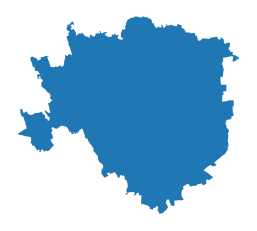

time: 172 ms (started: 2021-09-27 23:14:12 +01:00)


In [4]:
# load Milan city from openstreetmap using osmnx api
city = ox.geocode_to_gdf("Milan, Italy")
print(city.crs)
#city = ox.projection.project_gdf(city)
ax = city.plot(ec='none')
_ = ax.axis('off')
#print(city.crs)

Now, the publically available high-resolution population density data from the NASA [Socioeconomic Data and Applications Center](https://sedac.ciesin.columbia.edu/data/collection/gpw-v4/sets/browse) where we will get the spatial distribution of population density in Milan from, is encoded in a particular coordinate reference system called "ESRI:54009". Therefore, we will need to convert our city geometry to that CRS first:

In [5]:
city = city.to_crs("ESRI:54009") 
print(city.crs)

ESRI:54009
time: 234 ms (started: 2021-09-27 23:14:12 +01:00)


Let's plot and save the projected Polygon geometry.

C:\Users\gevor\AppData\Local\Temp/ipykernel_24332/562006747.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  city.to_file('Milan_mollweide.shp')


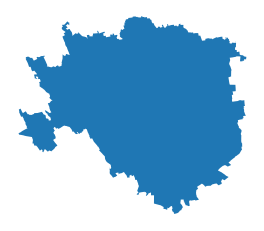

time: 250 ms (started: 2021-09-27 23:14:12 +01:00)


In [6]:
ax = city.plot(ec='none')
_ = ax.axis('off')
city.to_file('Milan_mollweide.shp')

Let's load the file we just saved using the `fiona` package:

In [7]:
import fiona
with fiona.open("Milan_mollweide.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

time: 63 ms (started: 2021-09-27 23:14:12 +01:00)


Now, let's load the global gridded population density file and extract the part of the data set corresponding to our city using the `mask` method of the `rasterio` package:

In [8]:
# load the NASA population density raster file
# Data source: https://sedac.ciesin.columbia.edu/data/collection/gpw-v4

import rasterio.mask
with rasterio.open("C:/Users/gevor/Downloads/GHS_POP_E2015_GLOBE_R2019A_54009_250_V1_0/GHS_POP_E2015_GLOBE_R2019A_54009_250_V1_0.tif") as src:
    # since the NASA data is for the entire world, we will use the 'shapes' polygon containing our city to mask out
    # the population raster data corresponding to our city
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True, nodata=0)
    out_meta = src.meta

time: 203 ms (started: 2021-09-27 23:14:13 +01:00)


Let's visualise the resulting `numpy` array containing the population density values:

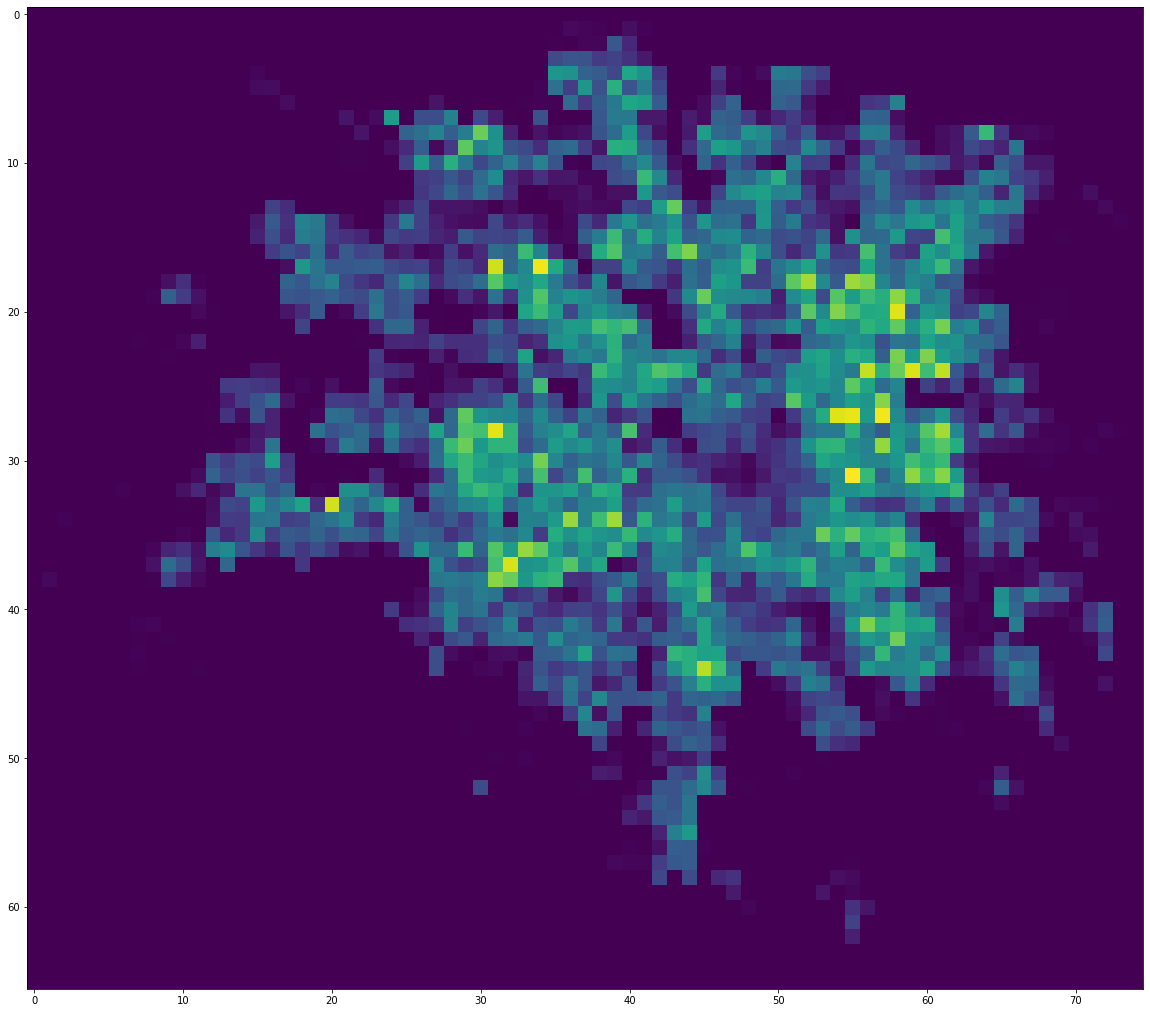

time: 484 ms (started: 2021-09-27 23:14:13 +01:00)


In [9]:
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(out_image[0,:,:])
plt.show()

Since the raster array contains many dimensions, we assign the dimension containing the population density data to a new variable:

In [10]:
pop_density = out_image[0,:,:]
pop_density

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

time: 0 ns (started: 2021-09-27 23:14:13 +01:00)


Just in case, set all negative values to zero:

In [11]:
pop_density[pop_density < 0] = 0
print("City population: ", pop_density.sum())

City population:  1220957.2
time: 0 ns (started: 2021-09-27 23:14:13 +01:00)


Let's check and set up the coordinate reference systems we will be working with:

In [12]:
from pyproj import CRS
crs = CRS.from_epsg(4326)

raster_crs = out_meta["crs"].data
raster_crs

{'proj': 'moll',
 'lon_0': 0,
 'x_0': 0,
 'y_0': 0,
 'datum': 'WGS84',
 'units': 'm',
 'no_defs': True}

time: 47 ms (started: 2021-09-27 23:14:13 +01:00)


Now, let's load the Polygon geometry for Milan from OpenStreetMap again, and let's project it to a local metric coordinate reference system to be able to subdivide it into a grid of 400 x 400 meter cells:

Milan CRS before projection epsg:4326
Milan CRS after projection +proj=utm +zone=32 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs


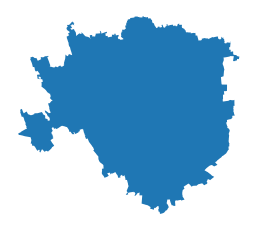

time: 390 ms (started: 2021-09-27 23:14:13 +01:00)


In [13]:
# load Milan city from openstreetmap using osmmnx api
milan = ox.geocode_to_gdf("Milan, Italy")
print("Milan CRS before projection", milan.crs)
milan = ox.projection.project_gdf(milan)
ax = milan.plot(ec='none')
_ = ax.axis('off')
print("Milan CRS after projection", milan.crs)

We can now split the city into 400 x 400 meter quadratic grid cells:

In [14]:
geometry = milan['geometry'].iloc[0]
print("Milan geometry data type: ", type(geometry))
geometry_cut = ox.utils_geo._quadrat_cut_geometry(geometry, quadrat_width = 400)
print("Milan subdivided geometry data type: ", type(geometry_cut))

Milan geometry data type:  <class 'shapely.geometry.polygon.Polygon'>
Milan subdivided geometry data type:  <class 'shapely.geometry.multipolygon.MultiPolygon'>
time: 9.64 s (started: 2021-09-27 23:14:14 +01:00)


After having subdivided the city geometry, let's visualise it:

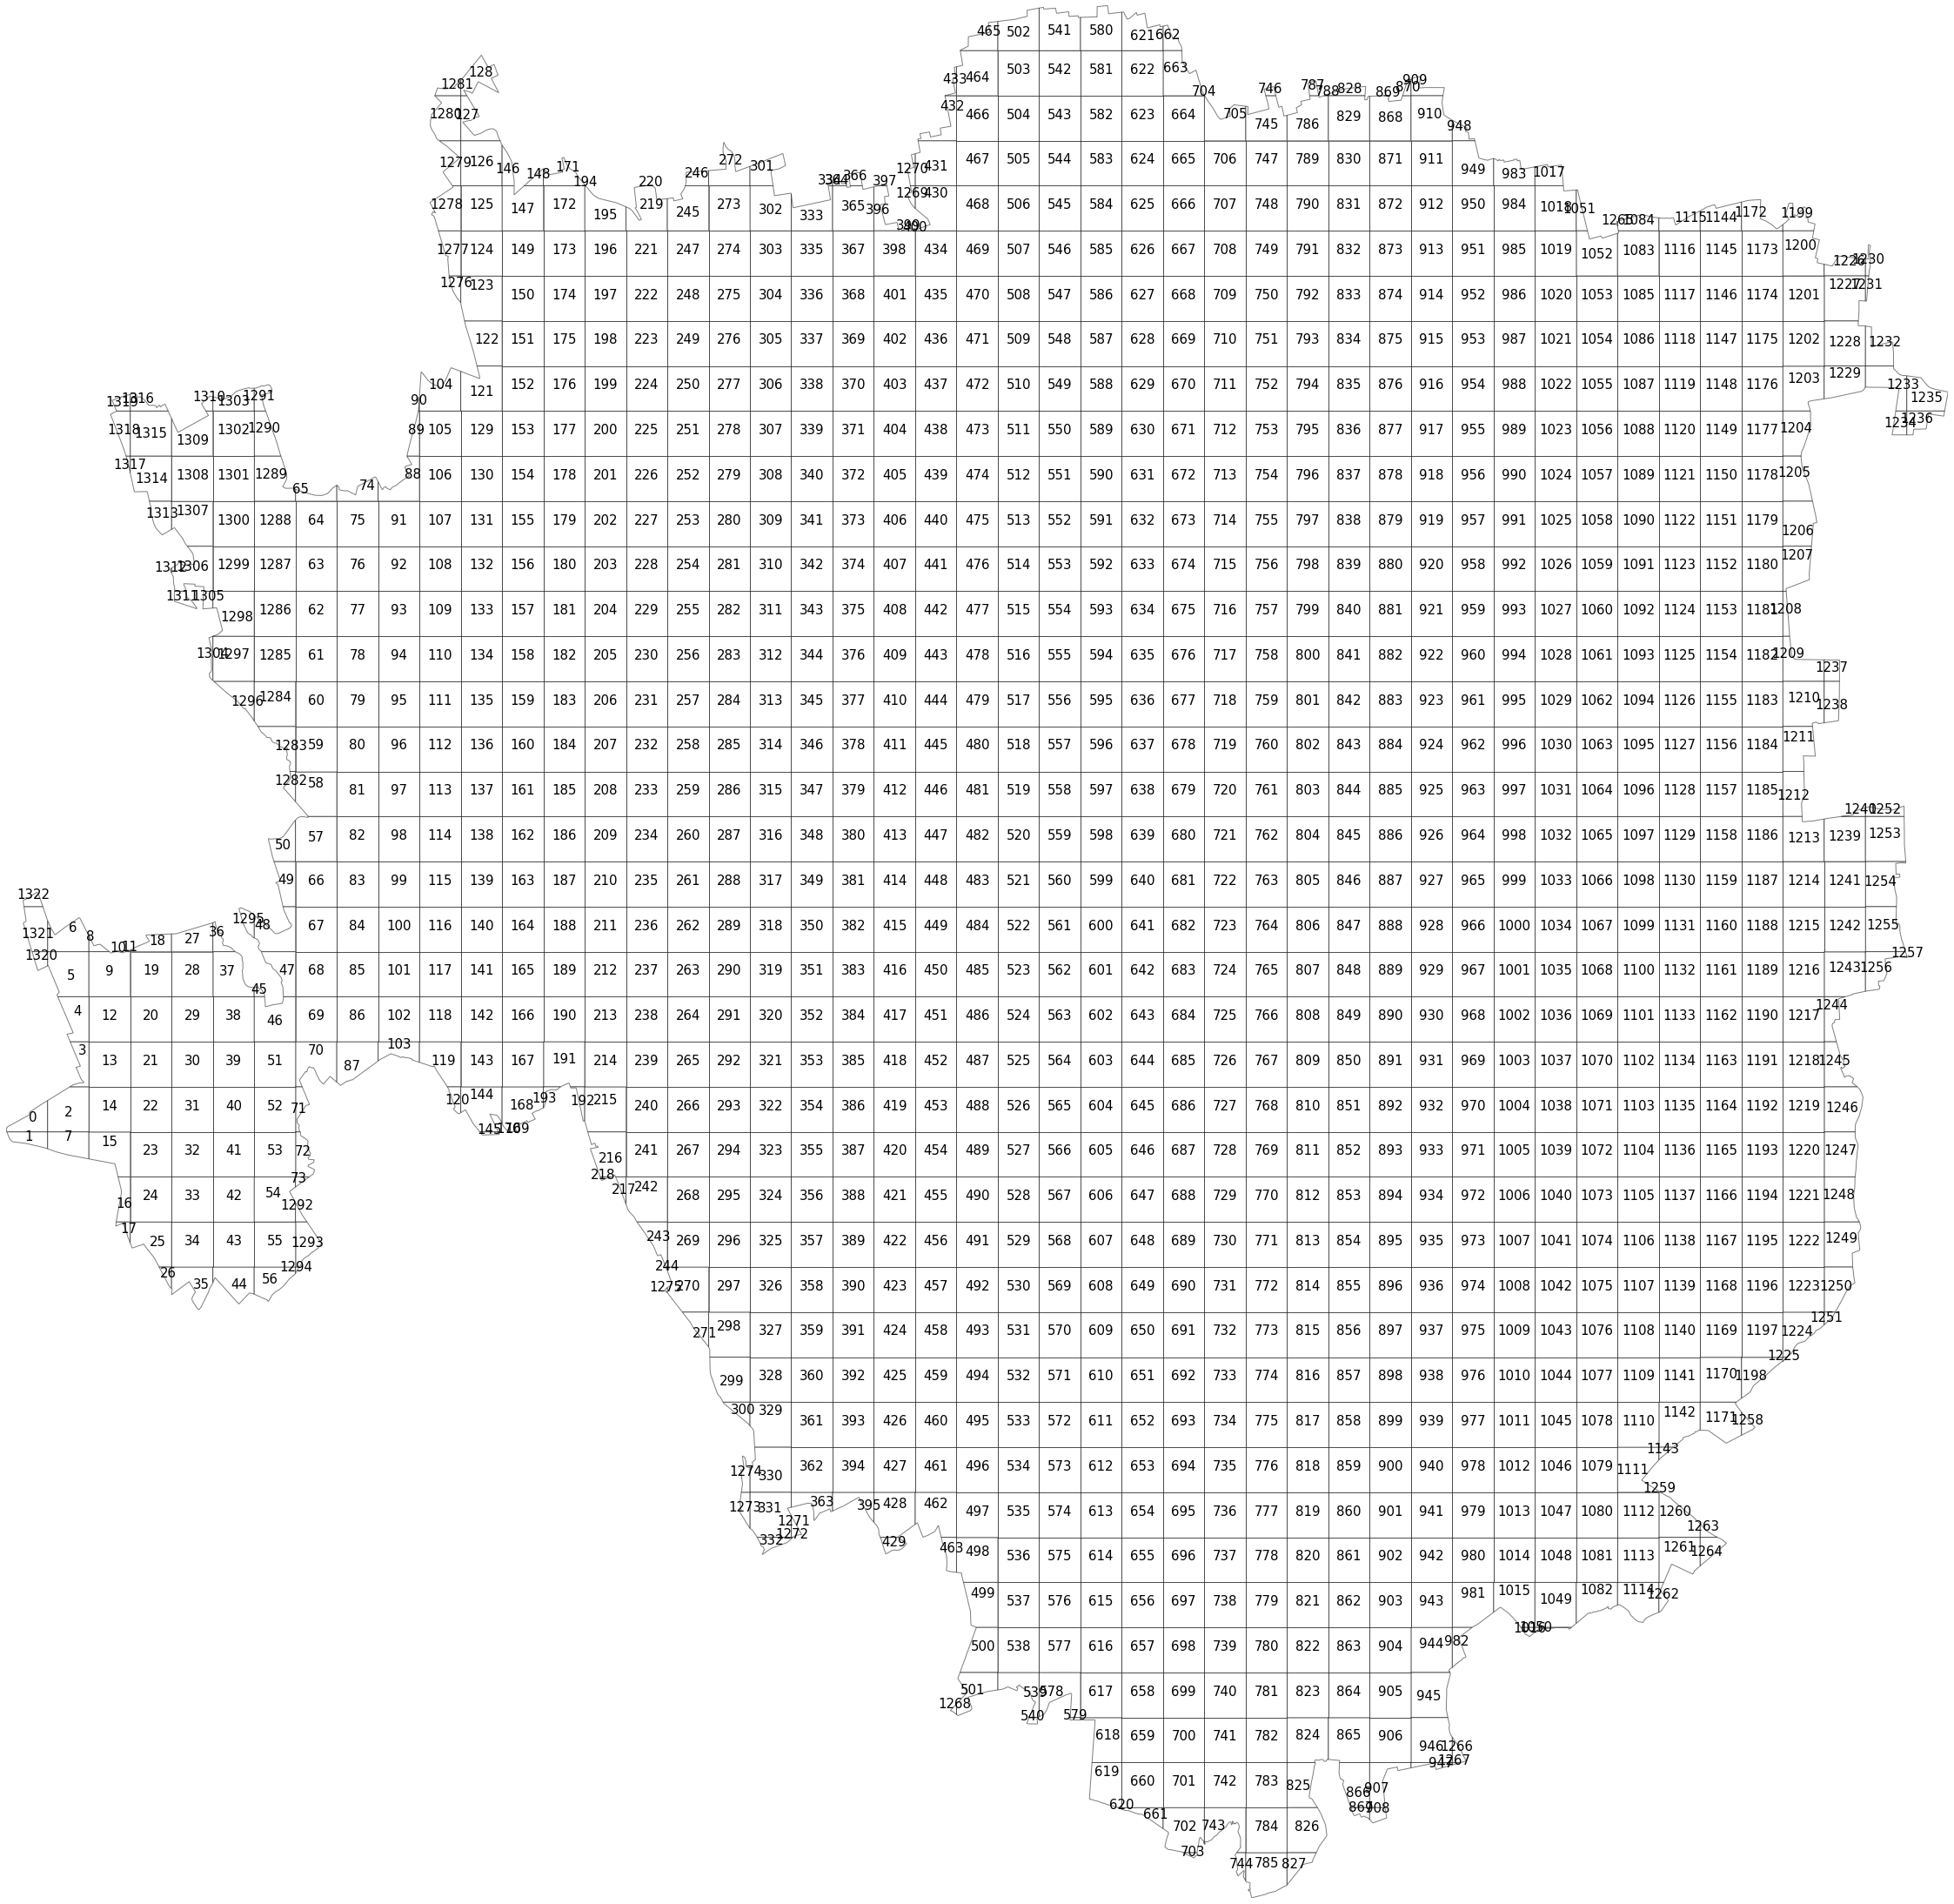

time: 11.7 s (started: 2021-09-27 23:14:23 +01:00)


In [15]:
# create list containing the grid cells
polylist = [p for p in geometry_cut]


# initialise geometry bounds for setting the plot limits
west, south, east, north = milan.unary_union.bounds

# start plotting
fig, ax = plt.subplots(figsize=(40,40))
# loop over all grid cells
for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
    # take cell geometric center for labelling it
    p = polygon.representative_point().coords[:][0]
    # create a patch object to be added to the matplotlib plot
    patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', alpha=0.5, zorder=2)
    # add patch to plot
    ax.add_patch(patch)
    # add label to grid cell
    plt.annotate(text=n, xy=p, horizontalalignment='center', size=15)

ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

In [16]:
# create GeoDataFrame from the resulting grid cells
polyframe = gpd.GeoDataFrame(geometry=polylist)
# set crs
polyframe.crs = milan.crs
print(polyframe.crs)
polyframe.head()

+proj=utm +zone=32 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs


geometry
0  POLYGON ((503197.317 5032658.859, 503202.066 5...
1  POLYGON ((503591.542 5032635.490, 503591.542 5...
2  POLYGON ((503591.542 5032909.514, 503804.443 5...
3  POLYGON ((503804.443 5033029.836, 503837.189 5...
4  POLYGON ((503807.363 5033424.181, 503777.065 5...

time: 63 ms (started: 2021-09-27 23:14:35 +01:00)


In order to be able to overlay the NASA population density data with the sibdivided Milan geometries, we need to make sure they are in the same CRS:

<AxesSubplot:>

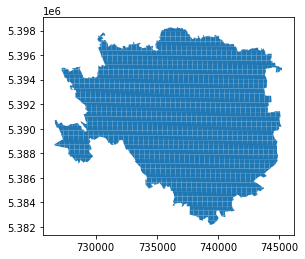

time: 813 ms (started: 2021-09-27 23:14:35 +01:00)


In [17]:
polyframe= polyframe.to_crs(city.crs)
polyframe.plot()

Now, we want to put the mentioned two data sets on top of each other and aggregate the population density values by grid cell. We will load the `rasterstats` library for aggregating raster data into vector polygons and thus obtain our desired result:

In [18]:
from rasterstats import zonal_stats

time: 78 ms (started: 2021-09-27 23:14:36 +01:00)


In [19]:
# compute the mean value of all raster values that fall into a given quadratic cell
affine = out_transform
milan_stats = zonal_stats(polyframe, pop_density, affine=affine, stats='mean', nodata=0)
pop_array = np.array([list(item.values())[0] if list(item.values())[0] is not None else 0 for item in milan_stats])
pop_array

array([40.32780457,  4.24924612,  0.74573342, ...,  2.20441222,
        0.        ,  0.        ])

time: 3.03 s (started: 2021-09-27 23:14:36 +01:00)


In [20]:
milan_stats[:10]

[{'mean': 40.32780456542969},
 {'mean': 4.249246120452881},
 {'mean': 0.745733417570591},
 {'mean': 2.713408946990967},
 {'mean': None},
 {'mean': 24.005563735961914},
 {'mean': 0.096488818526268},
 {'mean': 0.8694548010826111},
 {'mean': None},
 {'mean': 3.5187740325927734}]

time: 16 ms (started: 2021-09-27 23:14:39 +01:00)


Let's plot a histogram of the obtained population density values:

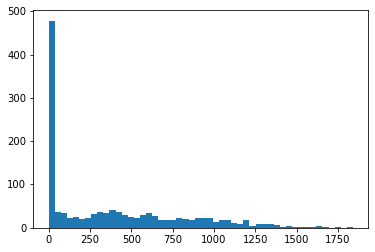

time: 265 ms (started: 2021-09-27 23:14:39 +01:00)


In [21]:
plt.hist(pop_array, bins=50)
plt.show()

As we can see, it's a skewed distribution, with most locations having a small population, while a few locations at the tail of th distributions containing a large population.

Let's now assign the population values as a new column in the geodataframe with the grid cells, so we know which grid cell has what population.

In [22]:
polyframe["population"] = pop_array
polyframe.head()

geometry  population
0  POLYGON ((726632.539 5388716.142, 726636.552 5...   40.327805
1  POLYGON ((727039.421 5388693.181, 727050.077 5...    4.249246
2  POLYGON ((727019.603 5388959.985, 727229.731 5...    0.745733
3  POLYGON ((727229.731 5389077.013, 727262.051 5...    2.713409
4  POLYGON ((727204.215 5389460.956, 727168.253 5...    0.000000

time: 31 ms (started: 2021-09-27 23:14:40 +01:00)


In [23]:
# create a new GeoDataFrame by converting to the epsg:4326 crs
polyframe_gps = polyframe.to_crs(crs)

time: 187 ms (started: 2021-09-27 23:14:40 +01:00)


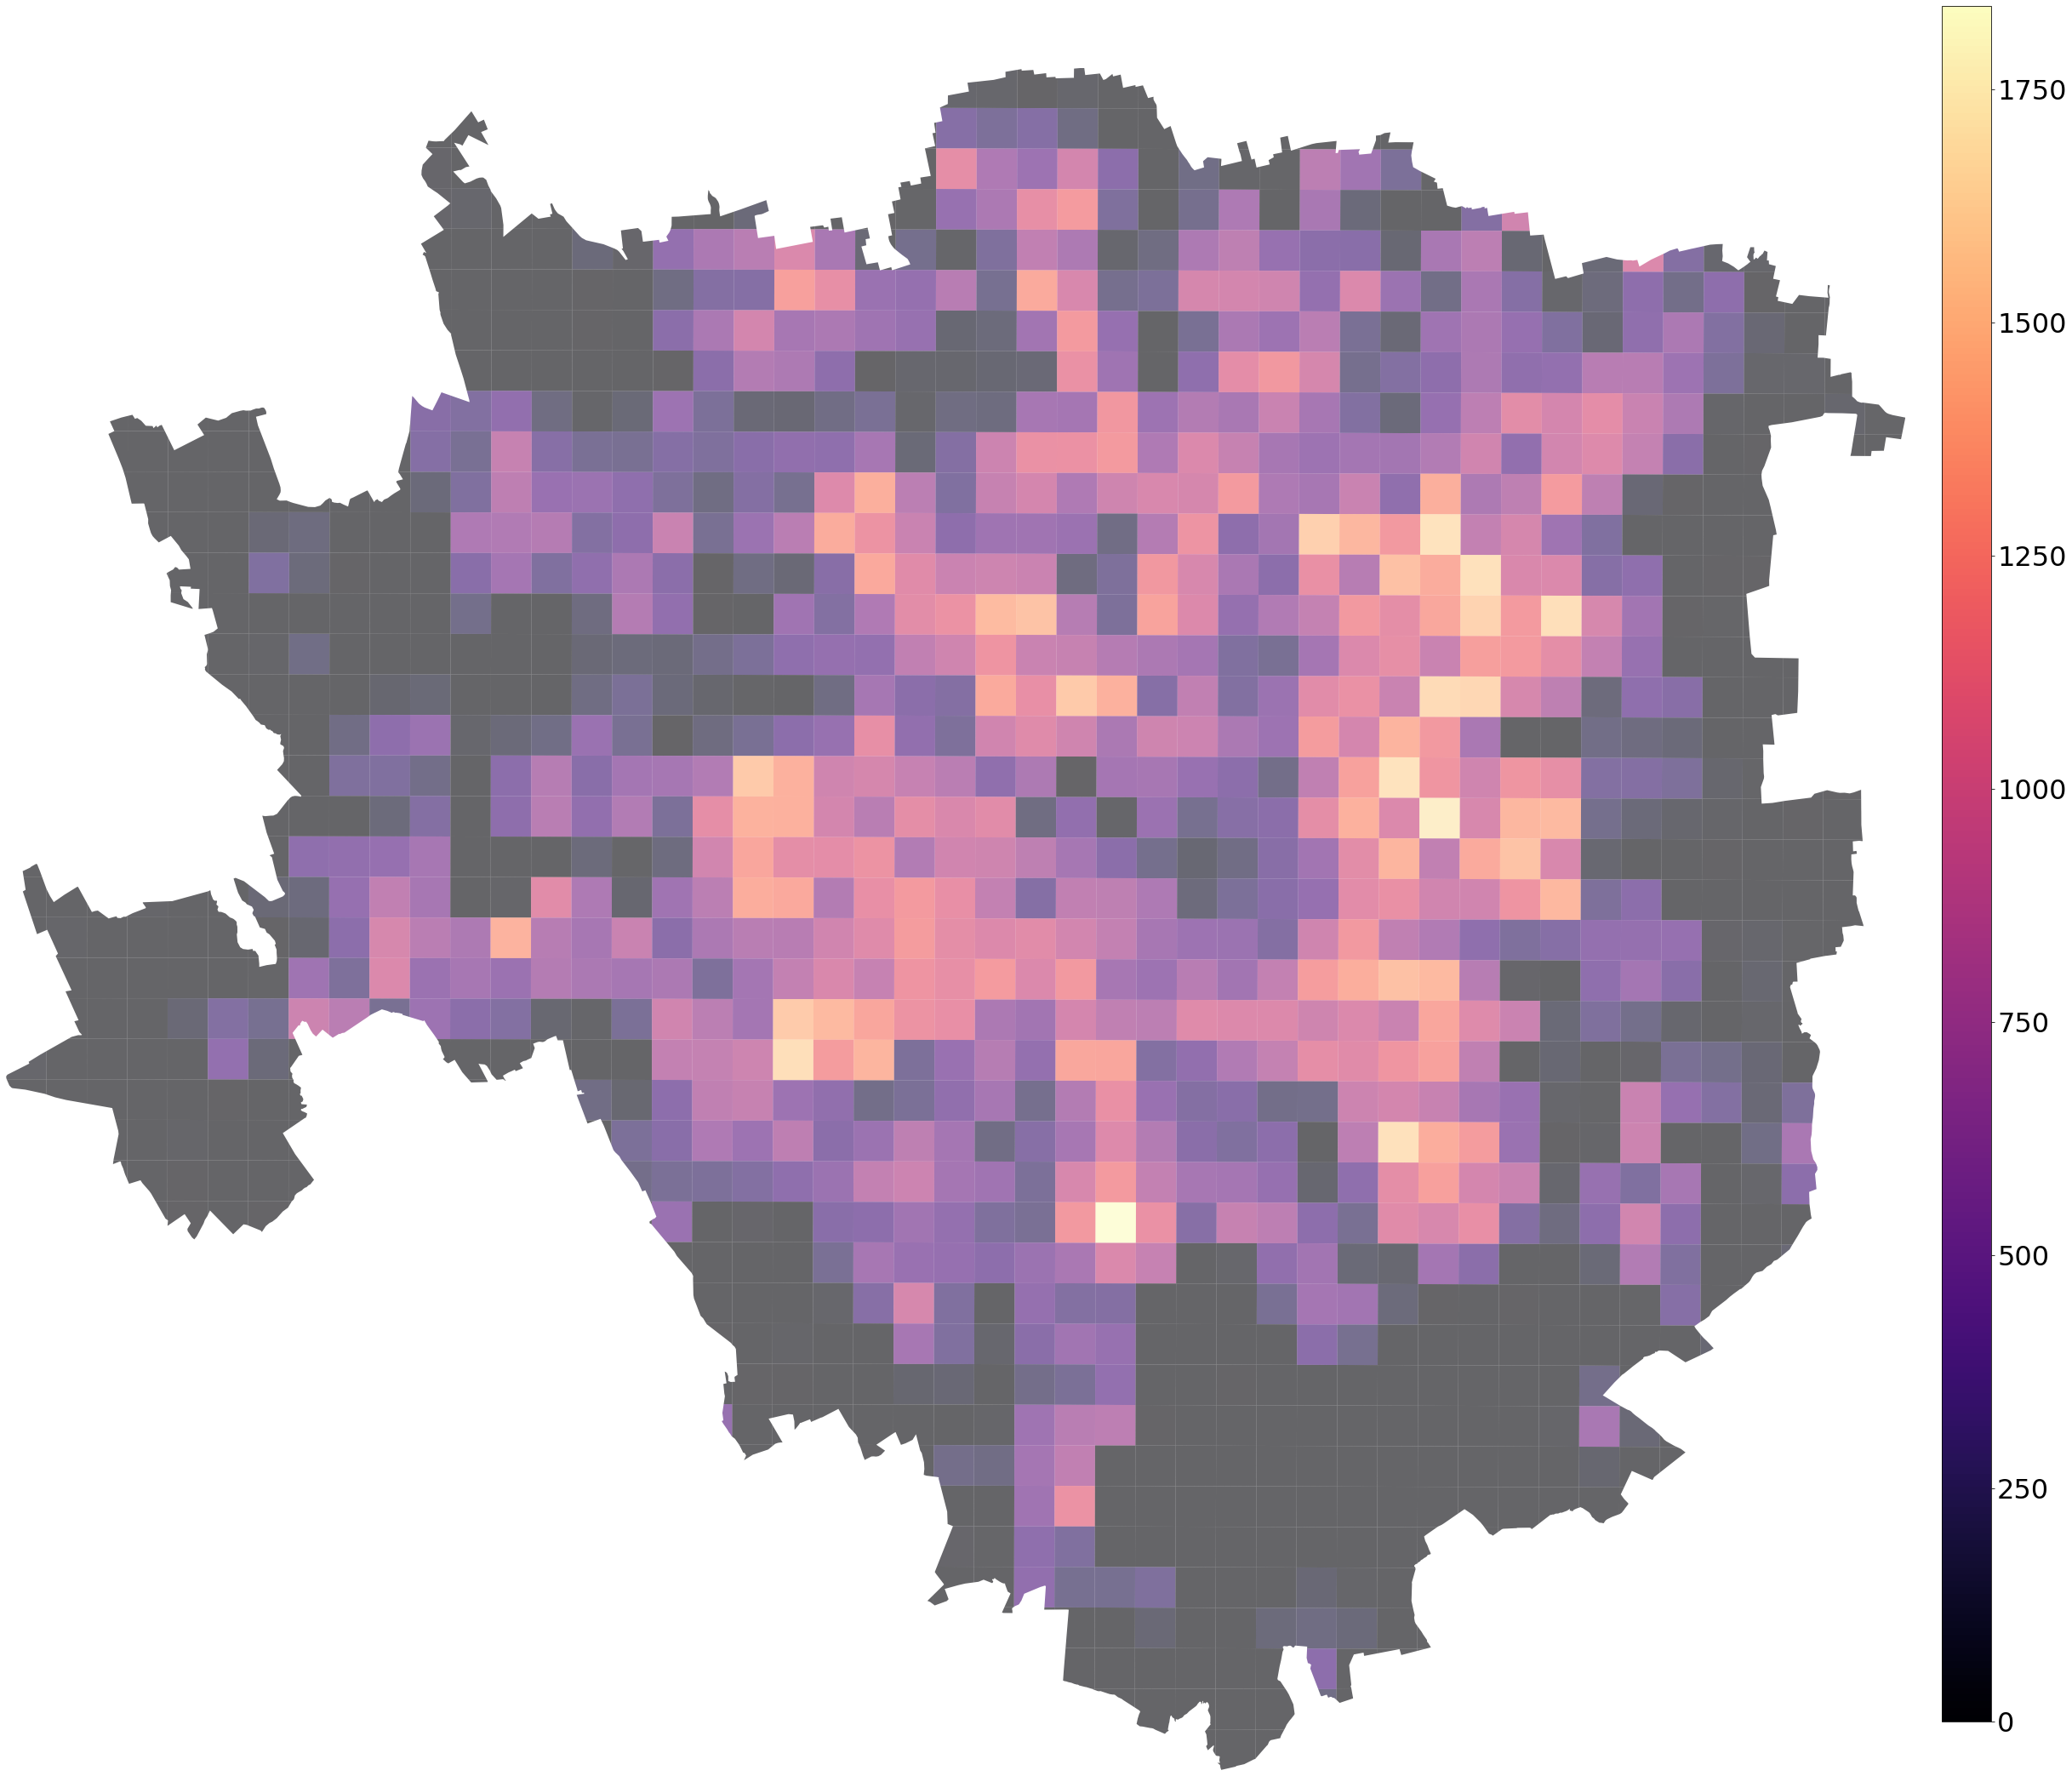

time: 1.33 s (started: 2021-09-27 23:14:40 +01:00)


In [24]:
# set parameters for the colorbar labels
plt.rcParams.update({'font.size':32})

# initialise bounds
west, south, east, north = polyframe_gps.unary_union.bounds

# start plot
fig, ax = plt.subplots(figsize=(40,40))
polyframe_gps.plot(ax=ax, column = 'population', legend=False, cmap='magma', alpha=0.6)

# create colorbar axes 
cbax = fig.add_axes([0.915, 0.175, 0.02, 0.7])

# create scalarmappable object
sm = plt.cm.ScalarMappable(cmap='magma', \
                          norm = plt.Normalize(vmin=min(polyframe_gps.population), vmax=max(polyframe_gps.population)))

sm._A = []

# draw colormap into cbax

fig.colorbar(sm, cax=cbax, format="%d")

ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

Finally, let's keep only the grid cells that have a non-zero population:

In [26]:
print("Number of grid cells: ", len(polyframe_gps))
nonzero_poly = polyframe_gps[polyframe_gps.population>0]
print("Number of grid cells with non-zero population: ", len(nonzero_poly))
nonzero_poly.head()

Number of grid cells:  1323
Number of grid cells with non-zero population:  1095


geometry  population
0  POLYGON ((9.04089 45.44745, 9.04095 45.44755, ...   40.327805
1  POLYGON ((9.04593 45.44723, 9.04593 45.44591, ...    4.249246
2  POLYGON ((9.04593 45.44970, 9.04865 45.45078, ...    0.745733
3  POLYGON ((9.04865 45.45078, 9.04907 45.45095, ...    2.713409
5  POLYGON ((9.04718 45.45788, 9.04708 45.45803, ...   24.005564

time: 63 ms (started: 2021-09-27 23:14:41 +01:00)


In [27]:
geo_df = nonzero_poly.to_crs(milan.crs)
geo_df.reset_index(inplace=True, drop=True)
geo_df.head()

geometry  population
0  POLYGON ((503197.317 5032658.859, 503202.066 5...   40.327805
1  POLYGON ((503591.542 5032635.490, 503591.542 5...    4.249246
2  POLYGON ((503591.542 5032909.514, 503804.443 5...    0.745733
3  POLYGON ((503804.443 5033029.836, 503837.189 5...    2.713409
4  POLYGON ((503688.430 5033818.527, 503681.067 5...   24.005564

time: 187 ms (started: 2021-09-27 23:14:41 +01:00)


## Population-weighted opportunities model

The model we are going to use to estimate the mobility demand is derived from a stochastic decision-making process of individual's destination selection. Before an individual selects a destination, she/he will weigh the benefit of each location's opportunities. The more opportunities a location has, the higher the benefit it offers and the higher the chance of it being chosen. Although the number of a location's opportunities is difficult to measure straightforwardly, it can be reflected by its population. Insofar as the population distribution is available, it is reasonable to assume that the number of opportunities at a location is proportional to its population, analogous to the
assumption of the [radiation model](https://en.wikipedia.org/wiki/Radiation_law_for_human_mobility#:~:text=type%20of%20network.-,The%20radiation%20model,of%20people%20between%20different%20locations.).
In contrast to the radiation model's assumption that individuals tend to select the nearest locations with relatively larger benefits, we enlarge the possible chosen area of individuals to include the whole city regarding the relatively high mobility at the city scale. As shown in figure 1, our assumption leads to much better prediction than that of the radiation model. Nevertheless, the possibility of travel in the observed data still decays as the distance between the origin and destination increases. Such decay, as predicted by different models and common in real observations, results from the reduction of attraction associated with a type of cost. For example, the [gravity model](https://en.wikipedia.org/wiki/Gravity_model_of_migration) assumes that the attraction of a destination, i.e. its opportunities, is reduced according to a function of the distance from the origin. However, the distance function inevitably includes at least one parameter. To capture the mobility behaviours and avoid adjustable parameters, we simply assume that the attraction of a destination is inversely proportional to the population $S_{ji}$ in the circle centred at the destination with radius $r_{ij}$ (the distance between the origin $i$ and destination $j$), minus a finite-size correction $1/M$, i.e.

$$
A_{j}=o_{j}\left(\frac{1}{S_{j i}}-\frac{1}{M}\right),
$$

where $A_j$ is the relative attraction of destination $j$ to travellers at origin $i$, $o_j$ is the total opportunities of destination $j$ and $M$ is the total population in the city. Further, assuming that the probability of travel from $i$ to $j$ is proportional to the attraction of $j$ and recalling the assumption that the number of opportunities $o_j$ is proportional to the population $m_j$, we have the travel from $i$ to $j$ as

$$
T_{i j}=T_{i} \frac{m_{j}\left(1 / S_{j i}-1 / M\right)}{\sum_{k \neq i}^{N} m_{k}\left(1 / S_{k i}-1 / M\right)},
$$


where $T_i$ is the number of trips departing from $i$ and $N$ is the number of locations in the city.
The presented model reflects the effect of competition for opportunities among potential destinations: for a traveller at origin $i$ travelling to a potential destination $j$, more population between $i$ and $j$ will induce stronger competition for limited opportunities, so that the probability of being offered opportunities will be lower. In this regard, it is reasonable to
assume that the attraction of a destination for a traveller is the destination's opportunities inversely weighted by population between the destination and the origin. The model is thus called the PWO model.

Let's now implement the model. First, we will build the matrix of pairwise Euclidean distances in order to be able to define the populations $S_{ji}$:

In [28]:
from tqdm import tqdm

# initialise number of grid cells
n_poly = len(geo_df)

# initialise the distance matrix populated with zeros
distance_mat = np.zeros(shape=(n_poly, n_poly))
# loop over all pairs, compute the distance, and add it to the respective position in the matrix
for pair in tqdm(combinations(np.arange(n_poly), 2)):
    distance_mat[pair[0], pair[1]] = geo_df.geometry[pair[0]].centroid.distance(geo_df.geometry[pair[1]].centroid)
    
print(distance_mat)

598965it [01:13, 8112.62it/s]

[[   0.          149.83632341  362.95843894 ... 5758.15124867
  6340.76109219 1418.70649455]
 [   0.            0.          444.48733027 ... 5907.85637891
  6490.56295741 1567.83386478]
 [   0.            0.            0.         ... 5608.92637713
  6212.34941164 1353.64230391]
 ...
 [   0.            0.            0.         ...    0.
   699.53548109 4359.07695938]
 [   0.            0.            0.         ...    0.
     0.         4927.98731075]
 [   0.            0.            0.         ...    0.
     0.            0.        ]]
time: 1min 13s (started: 2021-09-27 23:14:42 +01:00)


In [29]:
def isuppertriangular(M): 
    for i in range(1, len(M)): 
        for j in range(0, i): 
            if(M[i][j] != 0):  
                    return False
    return True

  
if isuppertriangular(distance_mat): 
    print ("Yes") 
else: 
    print ("No") 

Yes
time: 344 ms (started: 2021-09-27 23:15:56 +01:00)


Symmetrically fill in the lower triangular part of the distance matrix: 

In [30]:
distance_mat = np.maximum(distance_mat, distance_mat.transpose())
distance_mat

array([[   0.        ,  149.83632341,  362.95843894, ..., 5758.15124867,
        6340.76109219, 1418.70649455],
       [ 149.83632341,    0.        ,  444.48733027, ..., 5907.85637891,
        6490.56295741, 1567.83386478],
       [ 362.95843894,  444.48733027,    0.        , ..., 5608.92637713,
        6212.34941164, 1353.64230391],
       ...,
       [5758.15124867, 5907.85637891, 5608.92637713, ...,    0.        ,
         699.53548109, 4359.07695938],
       [6340.76109219, 6490.56295741, 6212.34941164, ...,  699.53548109,
           0.        , 4927.98731075],
       [1418.70649455, 1567.83386478, 1353.64230391, ..., 4359.07695938,
        4927.98731075,    0.        ]])

time: 31 ms (started: 2021-09-27 23:15:56 +01:00)


Now let's initialise a variable containing _all_ pairs, the $S_{ji}$ variable, and an array storing the grid cell population values: 

In [31]:
import itertools
pairs = list(itertools.product(range(n_poly), range(n_poly)))
pairs[:10]

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9)]

time: 172 ms (started: 2021-09-27 23:15:56 +01:00)


In [32]:
S_ji = np.zeros(len(pairs))
print(len(S_ji))

1199025
time: 0 ns (started: 2021-09-27 23:15:56 +01:00)


In [33]:
milan_pop = np.array(geo_df.population)

time: 0 ns (started: 2021-09-27 23:15:56 +01:00)


We can now compute the $S_{ji}$ values for all pairs $i$, $j$:

In [34]:
# for each pair i and j
for n, pair in tqdm(enumerate(pairs)):
    # get the distance between i and j
    distance = distance_mat[pair[0], pair[1]]
    # identify the locations that are within the circle of radius distance
    circle_ind_array = np.where(distance_mat[pair[1],:] < distance)[0]
    # sum all population within that circle
    S_ji[n] = milan_pop[circle_ind_array].sum()
    
S_ji

1199025it [00:23, 51272.12it/s]


array([0.00000000e+00, 4.24924612e+00, 1.61518822e+00, ...,
       1.46552303e+04, 1.46328735e+04, 0.00000000e+00])

time: 23.4 s (started: 2021-09-27 23:15:56 +01:00)


Let's start creating a DataFrame containing the Origin-Destination flows for all $i,j$ pairs, and first assign the $S_{ji}$ values as a column in the DataFrame:

In [35]:
origins = []
destinations = []
for pair in pairs:
    origins.append(pair[0])
    destinations.append(pair[1])
print(len(origins), len(destinations))

1199025 1199025
time: 547 ms (started: 2021-09-27 23:16:20 +01:00)


In [36]:
flow_df = pd.DataFrame({"origins":origins, "destinations":destinations, "S_ji": S_ji})
flow_df.head()

origins  destinations       S_ji
0        0             0   0.000000
1        0             1   4.249246
2        0             2   1.615188
3        0             3   5.957734
4        0             4  70.076023

time: 782 ms (started: 2021-09-27 23:16:20 +01:00)


For further use, let's store the $S_{ji}$ values neatly in a square matrix:

In [37]:
S_mat = np.reshape(S_ji, (n_poly, n_poly))
S_mat

array([[0.00000000e+00, 4.24924612e+00, 1.61518822e+00, ...,
        4.39051831e+04, 4.74262825e+04, 6.36817657e+01],
       [4.03278046e+01, 0.00000000e+00, 4.19429928e+01, ...,
        4.71322767e+04, 4.98174669e+04, 1.10403828e+02],
       [4.45770507e+01, 4.54465055e+01, 0.00000000e+00, ...,
        4.08296439e+04, 4.14334029e+04, 6.11619431e+01],
       ...,
       [2.56484776e+04, 2.57149403e+04, 2.76911876e+04, ...,
        0.00000000e+00, 6.56112552e-01, 1.69611865e+04],
       [3.33109091e+04, 3.56324966e+04, 3.71148826e+04, ...,
        4.59615400e+00, 0.00000000e+00, 2.03870141e+04],
       [7.54098034e+01, 8.97916849e+01, 1.91752468e+02, ...,
        1.46552303e+04, 1.46328735e+04, 0.00000000e+00]])

time: 15 ms (started: 2021-09-27 23:16:21 +01:00)


Since we don't care about the _actual_ mobility flow values but only about their _relative magnitudes_, let's normalise the populations by the total population:

In [38]:
geo_df['pop_norm'] = geo_df.population/geo_df.population.sum()
geo_df.head()

geometry  population  pop_norm
0  POLYGON ((503197.317 5032658.859, 503202.066 5...   40.327805  0.000079
1  POLYGON ((503591.542 5032635.490, 503591.542 5...    4.249246  0.000008
2  POLYGON ((503591.542 5032909.514, 503804.443 5...    0.745733  0.000001
3  POLYGON ((503804.443 5033029.836, 503837.189 5...    2.713409  0.000005
4  POLYGON ((503688.430 5033818.527, 503681.067 5...   24.005564  0.000047

time: 47 ms (started: 2021-09-27 23:16:21 +01:00)


An assumption we will make regarding the population mobility and tendency to travel is that half of the population actually travels during a specific period of time. These are the $T_i$s.

In [39]:
mobility_param = 0.5 
geo_df["T_i"] = mobility_param*geo_df["pop_norm"]
geo_df.head()

geometry  population  pop_norm  \
0  POLYGON ((503197.317 5032658.859, 503202.066 5...   40.327805  0.000079   
1  POLYGON ((503591.542 5032635.490, 503591.542 5...    4.249246  0.000008   
2  POLYGON ((503591.542 5032909.514, 503804.443 5...    0.745733  0.000001   
3  POLYGON ((503804.443 5033029.836, 503837.189 5...    2.713409  0.000005   
4  POLYGON ((503688.430 5033818.527, 503681.067 5...   24.005564  0.000047   

            T_i  
0  3.933472e-05  
1  4.144608e-06  
2  7.273696e-07  
3  2.646591e-06  
4  2.341442e-05

time: 47 ms (started: 2021-09-27 23:16:21 +01:00)


Before computing the flows $T_{ij}$s, let's also initialise the variables for the population densities and the total population:

In [103]:
T_i = geo_df.T_i
m = geo_df.pop_norm
M = geo_df.pop_norm.sum()

time: 156 ms (started: 2021-09-28 17:54:56 +01:00)


Finally, let's compute the flows:

In [41]:
# T_ij = T_i*(m_j*(1/S_ji - 1/M)/np.sum(m_without_i*(1/S - 1/M)))

# initialise the array where we will fill in the flows
T_ij = np.zeros(len(pairs))
# since we compute the flows between but not within cells, we create the variable s_without_i 
S_without_i = S_mat.copy()
np.fill_diagonal(S_without_i, 0)
for n, pair in tqdm(enumerate(pairs)):
    # since we have division by S_ji, check to make sure we take the nonzero values
    if S_ji[n] != 0:
        # we also create m_without_i
        m_without_i = m.copy()
        m_without_i[pair[0]] = 0
        T_ij[n] = T_i[pair[0]]*(m[pair[1]]*(1/S_ji[n] - 1/M)/\
                                np.sum(m_without_i*(np.nan_to_num(1/S_without_i[pair[0],:]) - 1/M)))
print(len(T_ij))
T_ij

0it [00:00, ?it/s]C:\Users\gevor\AppData\Local\Temp/ipykernel_24332/2654822953.py:15: RuntimeWarning: divide by zero encountered in true_divide
  np.sum(m_without_i*(np.nan_to_num(1/S_without_i[pair[0],:]) - 1/M)))
1199025it [08:55, 2241.12it/s]

1199025


array([0.00000000e+00, 2.49343401e-10, 2.17963487e-11, ...,
       5.67975672e-12, 2.75181686e-12, 0.00000000e+00])

time: 8min 55s (started: 2021-09-27 23:16:21 +01:00)


For further use, let's store the  $T_{ij}$  values neatly in a square matrix:

In [42]:
T_mat = T_ij.copy()
T_mat = T_mat.reshape((n_poly, n_poly))

time: 0 ns (started: 2021-09-27 23:25:16 +01:00)


In [43]:
# check where the maximum flow is
np.where(T_mat==T_mat.max())

(array([570], dtype=int64), array([825], dtype=int64))

time: 32 ms (started: 2021-09-27 23:25:16 +01:00)


As you remember, we had computed the flows $T_{ij}$ for all $i \neq j$, so we fill the diagonal with the $1 - T_{i}$ to represent the people that remain in the cell:

In [44]:
np.fill_diagonal(T_mat, 1-T_i)
T_mat

array([[ 9.99960665e-01,  2.49343401e-10,  2.17963487e-11, ...,
         1.03918743e-10,  5.03482592e-11,  1.66507656e-10],
       [ 3.17973612e-10,  9.99995855e-01,  5.88565973e-12, ...,
         1.09489046e-11,  5.30470216e-12,  1.76617028e-11],
       [ 5.59387498e-11,  5.89672245e-12,  9.99999273e-01, ...,
         1.92149626e-12,  9.30956821e-13,  3.07677023e-12],
       ...,
       [ 1.03909189e-10,  1.09486685e-11,  1.92147275e-12, ...,
         9.99998679e-01, -8.86099791e-13,  5.67980615e-12],
       [ 5.03437546e-11,  5.30461365e-12,  9.30949158e-13, ...,
         1.32277591e-12,  9.99999360e-01,  2.75185513e-12],
       [ 1.66908245e-10,  1.76245860e-11,  3.11159933e-12, ...,
         5.67975672e-12,  2.75181686e-12,  9.99997850e-01]])

time: 0 ns (started: 2021-09-27 23:25:16 +01:00)


Let's make sure the matrix is symmetric:

In [45]:
T_mat = (T_mat + T_mat.T)/2
T_mat

array([[9.99960665e-01, 2.83658506e-10, 3.88675493e-11, ...,
        1.03913966e-10, 5.03460069e-11, 1.66707950e-10],
       [2.83658506e-10, 9.99995855e-01, 5.89119109e-12, ...,
        1.09487865e-11, 5.30465790e-12, 1.76431444e-11],
       [3.88675493e-11, 5.89119109e-12, 9.99999273e-01, ...,
        1.92148451e-12, 9.30952989e-13, 3.09418478e-12],
       ...,
       [1.03913966e-10, 1.09487865e-11, 1.92148451e-12, ...,
        9.99998679e-01, 2.18338060e-13, 5.67978143e-12],
       [5.03460069e-11, 5.30465790e-12, 9.30952989e-13, ...,
        2.18338060e-13, 9.99999360e-01, 2.75183600e-12],
       [1.66707950e-10, 1.76431444e-11, 3.09418478e-12, ...,
        5.67978143e-12, 2.75183600e-12, 9.99997850e-01]])

time: 31 ms (started: 2021-09-27 23:25:16 +01:00)


In [46]:
def check_symmetric(a, tol=1e-8):
    return np.all(np.abs(a-a.T) < tol)

check_symmetric(T_mat)

True

time: 15 ms (started: 2021-09-27 23:25:16 +01:00)


Now, let's assign the computed flows to a new column of our DataFrame. Since we don't care about the _actual_ flows but only about their _relative magnitudes_, we can safely multiply the flows by a large number to make them more "workable".

In [47]:
flow_df['T_ij'] = T_ij
flow_df['T_ij'] = flow_df['T_ij']*10**6
flow_df.tail(10)

origins  destinations          S_ji      T_ij
1199015     1094          1085  14539.786618  0.000023
1199016     1094          1086  19509.087812  0.000018
1199017     1094          1087  20500.446510  0.000024
1199018     1094          1088  15532.077346  0.000002
1199019     1094          1089  17574.116508  0.000002
1199020     1094          1090  19765.636076  0.000001
1199021     1094          1091  24354.614487  0.000011
1199022     1094          1092  14655.230341  0.000006
1199023     1094          1093  14632.873513  0.000003
1199024     1094          1094      0.000000  0.000000

time: 16 ms (started: 2021-09-27 23:25:16 +01:00)


In [48]:
flows = np.array(flow_df.T_ij)

time: 0 ns (started: 2021-09-27 23:25:16 +01:00)


Let's plot the main body of the distribution of flows:

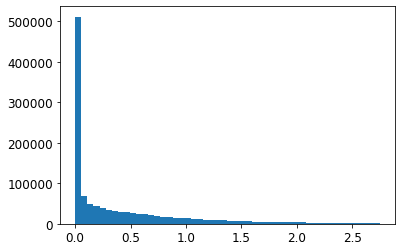

time: 343 ms (started: 2021-09-27 23:25:16 +01:00)


In [49]:
plt.rcParams.update({'font.size':12})
plt.hist(flows[(flows>np.percentile(flows, 1))&(flows<np.percentile(flows, 99))], bins=50)
plt.show()

## Identifying operational clusters in Milan

In order to make the analysis more focused, we will use a simple unsupervised Machine Learning technique, K-means clustering, to identify geographic clusters of population concentrations. We will then choose one such cluster and conduct the rest of the project for identifying and suggesting bicycle infrastructure in that geographic area of the city.

In [50]:
geo_df.head()

geometry  population  pop_norm  \
0  POLYGON ((503197.317 5032658.859, 503202.066 5...   40.327805  0.000079   
1  POLYGON ((503591.542 5032635.490, 503591.542 5...    4.249246  0.000008   
2  POLYGON ((503591.542 5032909.514, 503804.443 5...    0.745733  0.000001   
3  POLYGON ((503804.443 5033029.836, 503837.189 5...    2.713409  0.000005   
4  POLYGON ((503688.430 5033818.527, 503681.067 5...   24.005564  0.000047   

            T_i  
0  3.933472e-05  
1  4.144608e-06  
2  7.273696e-07  
3  2.646591e-06  
4  2.341442e-05

time: 31 ms (started: 2021-09-27 23:25:17 +01:00)


In [51]:
# convert to epsg:4326 crs
df = geo_df.to_crs(crs)
df.head()

geometry  population  pop_norm  \
0  POLYGON ((9.04089 45.44745, 9.04095 45.44755, ...   40.327805  0.000079   
1  POLYGON ((9.04593 45.44723, 9.04593 45.44591, ...    4.249246  0.000008   
2  POLYGON ((9.04593 45.44970, 9.04865 45.45078, ...    0.745733  0.000001   
3  POLYGON ((9.04865 45.45078, 9.04907 45.45095, ...    2.713409  0.000005   
4  POLYGON ((9.04718 45.45788, 9.04708 45.45803, ...   24.005564  0.000047   

            T_i  
0  3.933472e-05  
1  4.144608e-06  
2  7.273696e-07  
3  2.646591e-06  
4  2.341442e-05

time: 187 ms (started: 2021-09-27 23:25:17 +01:00)


In [52]:
# get the centroid coordinates of the cells
df["lat"] = df['geometry'].apply(lambda x: x.centroid.coords[0][1])
df["lon"] = df['geometry'].apply(lambda x: x.centroid.coords[0][0])
df.head()

geometry  population  pop_norm  \
0  POLYGON ((9.04089 45.44745, 9.04095 45.44755, ...   40.327805  0.000079   
1  POLYGON ((9.04593 45.44723, 9.04593 45.44591, ...    4.249246  0.000008   
2  POLYGON ((9.04593 45.44970, 9.04865 45.45078, ...    0.745733  0.000001   
3  POLYGON ((9.04865 45.45078, 9.04907 45.45095, ...    2.713409  0.000005   
4  POLYGON ((9.04718 45.45788, 9.04708 45.45803, ...   24.005564  0.000047   

            T_i        lat       lon  
0  3.933472e-05  45.448067  9.044100  
1  4.144608e-06  45.446735  9.043798  
2  7.273696e-07  45.448881  9.048595  
3  2.646591e-06  45.452737  9.050172  
4  2.341442e-05  45.459770  9.048715

time: 141 ms (started: 2021-09-27 23:25:17 +01:00)


Since we want the K-means algorithm to run correctly, we make sure the dimensions of our feature space are normalised:

In [53]:
df["lat_norm"] = (df.lat - df.lat.min())/(df.lat - df.lat.min()).max()
df["lon_norm"] = (df.lon - df.lon.min())/(df.lon - df.lon.min()).max()
df["pop_norm"] = df.pop_norm/df.pop_norm.max()
df.head()

geometry  population  pop_norm  \
0  POLYGON ((9.04089 45.44745, 9.04095 45.44755, ...   40.327805  0.021923   
1  POLYGON ((9.04593 45.44723, 9.04593 45.44591, ...    4.249246  0.002310   
2  POLYGON ((9.04593 45.44970, 9.04865 45.45078, ...    0.745733  0.000405   
3  POLYGON ((9.04865 45.45078, 9.04907 45.45095, ...    2.713409  0.001475   
4  POLYGON ((9.04718 45.45788, 9.04708 45.45803, ...   24.005564  0.013050   

            T_i        lat       lon  lat_norm  lon_norm  
0  3.933472e-05  45.448067  9.044100  0.388899  0.001305  
1  4.144608e-06  45.446735  9.043798  0.379410  0.000000  
2  7.273696e-07  45.448881  9.048595  0.394702  0.020731  
3  2.646591e-06  45.452737  9.050172  0.422171  0.027548  
4  2.341442e-05  45.459770  9.048715  0.472273  0.021251

time: 31 ms (started: 2021-09-27 23:25:17 +01:00)


In [54]:
def group_assignment(data,centroids):
    grouping_vec_c = np.zeros(len(data))
    for i in range(len(data)):
        dist = np.zeros(len(centroids))
        for j in range(len(centroids)):
            dist[j] = np.linalg.norm(data[i] - centroids[j])
        min_dist = min(dist)
        for j in range(len(centroids)):
            if min_dist == dist[j]:
                grouping_vec_c[i] = j+1
    return grouping_vec_c

def update_centroid(data, grouping, centroids):
    new_centroids = [];
    for i in range(len(centroids)):
        cent = np.zeros(len(data[0]))
        count = 0
        for j in range(len(data)):
            if grouping[j] == (i+1):
                cent = cent+data[j]
                count += 1
        group_average = cent/count
        new_centroids.append(group_average)
    return new_centroids

def clustering_objective(data, grouping, centroids):
    J_obj = 0
    for i in range(len(data)):
        for j in range(len(centroids)):
            if grouping[i] == (j+1):
                J_obj += np.linalg.norm(data[i] - centroids[j])**2
        J_obj = J_obj/len(data)
    return J_obj

def Kmeans_alg(data, centroids):
    iteration = 0
    J_obj_vector = []
    Stop = False
    while Stop == False:
        grouping = group_assignment(data, centroids)
        new_centroids = update_centroid(data, grouping, centroids)
        J_obj = clustering_objective(data, grouping, new_centroids)
        J_obj_vector.append(J_obj)
        iteration += 1
        if np.linalg.norm(np.array(new_centroids) - np.array(centroids)) < 1e-6:
            Stop = True
        else:
            centroids = new_centroids
    return new_centroids, grouping, J_obj_vector, iteration

time: 15 ms (started: 2021-09-27 23:25:17 +01:00)


## Running K-Means

Let's first construct our data matrix:

In [55]:
X = df[["lat_norm", "lon_norm", "pop_norm"]].values
X

array([[3.88899013e-01, 1.30479882e-03, 2.19231523e-02],
       [3.79410402e-01, 0.00000000e+00, 2.30999110e-03],
       [3.94702053e-01, 2.07306808e-02, 4.05398396e-04],
       ...,
       [7.50739631e-01, 6.47770851e-02, 7.36184939e-04],
       [7.91725550e-01, 4.90477516e-02, 3.56678365e-04],
       [4.79734686e-01, 5.68705026e-03, 1.19837084e-03]])

time: 16 ms (started: 2021-09-27 23:25:17 +01:00)


To get a visual idea of the 3-dimensional space the K-Means algorithm will operate in, let's visualise it:

C:\Users\gevor\AppData\Local\Temp/ipykernel_24332/2479169731.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


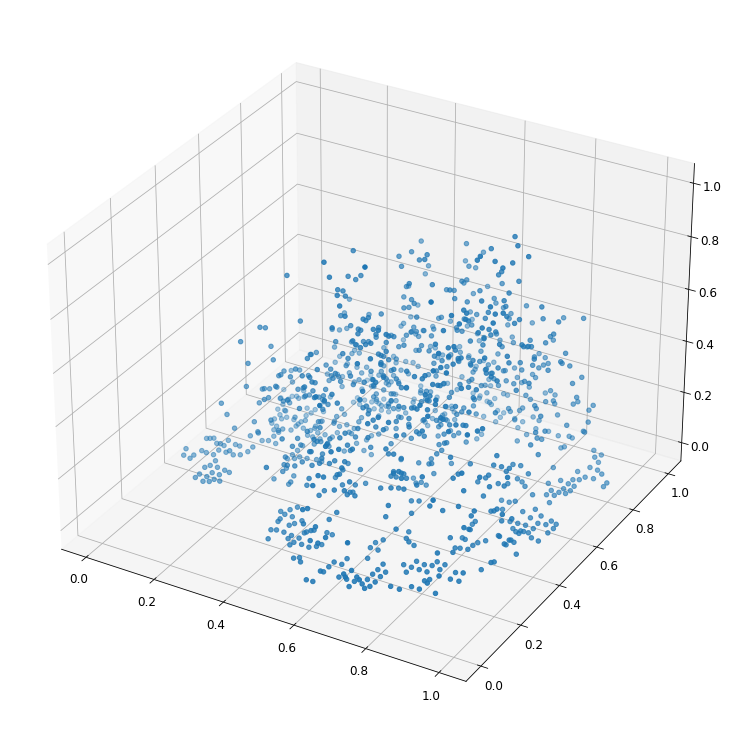

time: 266 ms (started: 2021-09-27 23:25:17 +01:00)


In [56]:
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure(figsize=(12,10))
ax = Axes3D(fig)
ax.scatter(X[:,1], X[:,0], X[:,2])
plt.show()

Now let's set up and run the K-Means algorithm:

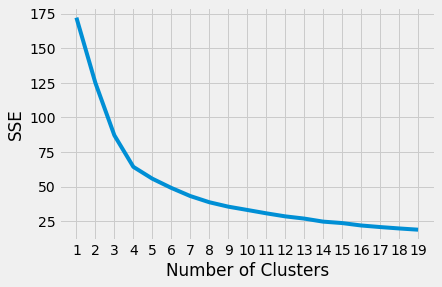

time: 4.44 s (started: 2021-09-27 23:25:17 +01:00)


In [57]:
from sklearn.cluster import KMeans
kmeans_kwargs = {
     "init": "random",
     "n_init": 10,
     "max_iter": 500,
     "random_state": 42,
 }

 # A list holds the SSE values for each k
sse = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)
    
plt.style.use("fivethirtyeight")
plt.plot(range(1, 20), sse)
plt.xticks(range(1, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

Let's now identify the knee/elbow of our SSE curve:

In [59]:
from kneed import KneeLocator

kl = KneeLocator(
     range(1, 20), sse, curve="convex", direction="decreasing"
 )

kl.elbow

5

time: 125 ms (started: 2021-09-27 23:26:09 +01:00)


However, after a visual inspection of the resulting map, we might want to choose a different point for the knee/elbow:

In [60]:
k = 6
kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
kmeans.fit(X)

y_kmeans = kmeans.predict(X)
y_kmeans

array([3, 3, 3, ..., 3, 3, 3])

time: 172 ms (started: 2021-09-27 23:26:15 +01:00)


In [61]:
df['cluster'] = y_kmeans
df.head()

geometry  population  pop_norm  \
0  POLYGON ((9.04089 45.44745, 9.04095 45.44755, ...   40.327805  0.021923   
1  POLYGON ((9.04593 45.44723, 9.04593 45.44591, ...    4.249246  0.002310   
2  POLYGON ((9.04593 45.44970, 9.04865 45.45078, ...    0.745733  0.000405   
3  POLYGON ((9.04865 45.45078, 9.04907 45.45095, ...    2.713409  0.001475   
4  POLYGON ((9.04718 45.45788, 9.04708 45.45803, ...   24.005564  0.013050   

            T_i        lat       lon  lat_norm  lon_norm  cluster  
0  3.933472e-05  45.448067  9.044100  0.388899  0.001305        3  
1  4.144608e-06  45.446735  9.043798  0.379410  0.000000        3  
2  7.273696e-07  45.448881  9.048595  0.394702  0.020731        3  
3  2.646591e-06  45.452737  9.050172  0.422171  0.027548        3  
4  2.341442e-05  45.459770  9.048715  0.472273  0.021251        3

time: 31 ms (started: 2021-09-27 23:26:16 +01:00)


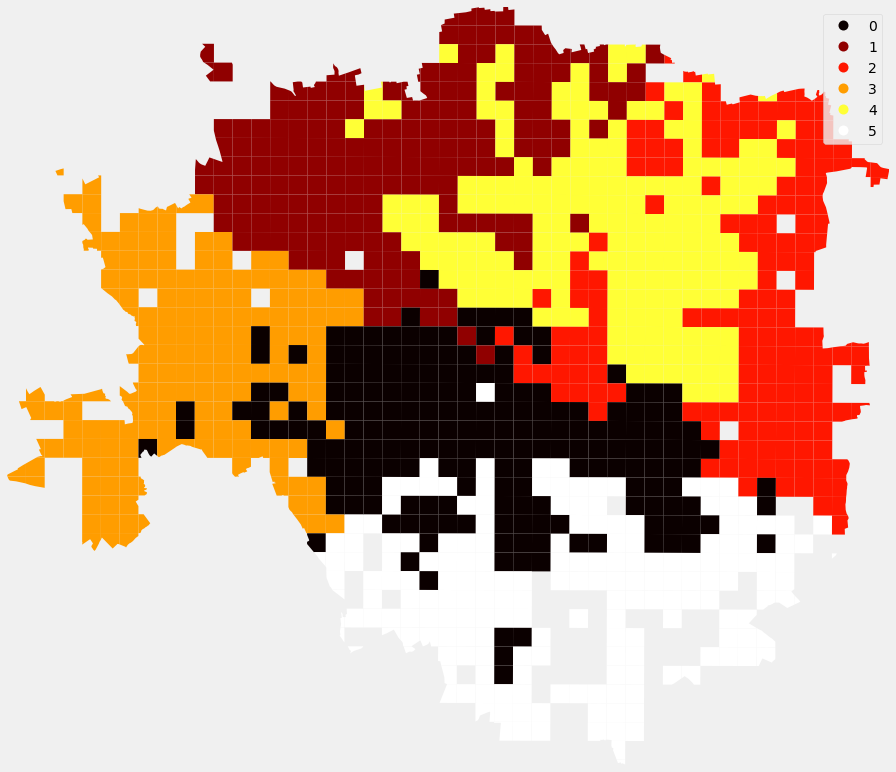

time: 672 ms (started: 2021-09-27 23:26:16 +01:00)


In [62]:
# plot the city
west, south, east, north = df.unary_union.bounds
fig, ax = plt.subplots(figsize=(20,13))

df.plot(column='cluster',  legend=True, categorical=True, cmap='hot', ax=ax, zorder=3)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

In [63]:
df_proj = df.to_crs(milan.crs)
df_proj.head()

geometry  population  pop_norm  \
0  POLYGON ((503197.317 5032658.859, 503202.066 5...   40.327805  0.021923   
1  POLYGON ((503591.542 5032635.490, 503591.542 5...    4.249246  0.002310   
2  POLYGON ((503591.542 5032909.514, 503804.443 5...    0.745733  0.000405   
3  POLYGON ((503804.443 5033029.836, 503837.189 5...    2.713409  0.001475   
4  POLYGON ((503688.430 5033818.527, 503681.067 5...   24.005564  0.013050   

            T_i        lat       lon  lat_norm  lon_norm  cluster  
0  3.933472e-05  45.448067  9.044100  0.388899  0.001305        3  
1  4.144608e-06  45.446735  9.043798  0.379410  0.000000        3  
2  7.273696e-07  45.448881  9.048595  0.394702  0.020731        3  
3  2.646591e-06  45.452737  9.050172  0.422171  0.027548        3  
4  2.341442e-05  45.459770  9.048715  0.472273  0.021251        3

time: 187 ms (started: 2021-09-27 23:26:17 +01:00)


<AxesSubplot:>

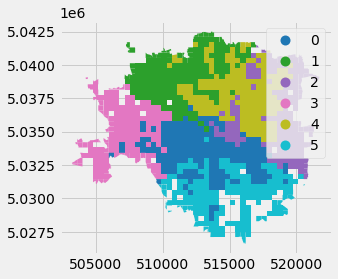

time: 578 ms (started: 2021-09-27 23:26:34 +01:00)


In [64]:
df_proj.plot(column='cluster', legend=True, categorical=True)

Let's slice the grid cell GeoDataFrame to keep only the cells in the cluster we picked, and get their indices to be able to access the flows within the cluster.

In [65]:
df_2 = df_proj[df_proj.cluster==1]
inds_2 = np.array(df_2.index)
inds_2

array([  78,   79,   93,   94,   95,   96,   97,   98,   99,  112,  113,
        114,  115,  116,  117,  118,  130,  131,  132,  133,  134,  135,
        136,  147,  148,  149,  150,  151,  152,  153,  154,  155,  169,
        170,  171,  172,  173,  174,  175,  176,  177,  178,  192,  193,
        194,  195,  196,  197,  198,  199,  200,  201,  218,  219,  220,
        221,  222,  223,  224,  225,  226,  227,  228,  229,  247,  248,
        249,  251,  252,  253,  254,  255,  256,  257,  277,  278,  279,
        280,  281,  282,  283,  284,  285,  286,  287,  302,  304,  305,
        306,  307,  310,  311,  312,  313,  314,  331,  332,  333,  334,
        335,  336,  340,  341,  342,  362,  363,  364,  365,  366,  367,
        368,  374,  375,  393,  394,  396,  397,  398,  399,  400,  401,
        402,  403,  404,  408,  409,  430,  431,  432,  433,  434,  435,
        436,  437,  438,  441,  447,  466,  467,  468,  472,  473,  474,
        477,  484,  504,  505,  508,  512,  515,  5

time: 31 ms (started: 2021-09-27 23:26:56 +01:00)


As mentioned above, let's get the flows within the chosen cluster, and simplify the DataFrame by keeping only the "one-way" flows:

In [66]:
flows_2 = flow_df[(flow_df.origins.isin(inds_2)) & (flow_df.destinations.isin(inds_2))]
flows_2 = flows_2[flows_2.origins!=flows_2.destinations]
flows_2_trunc = flows_2[flows_2.origins<flows_2.destinations]
flows_2_trunc.head()

origins  destinations         S_ji      T_ij
85489       78            79   344.100410  0.235827
85503       78            93  1005.695277  0.219039
85504       78            94   758.726669  0.001525
85505       78            95   762.447267  0.001643
85506       78            96  1494.335639  0.030692

time: 78 ms (started: 2021-09-27 23:27:03 +01:00)


Let's make sure we keep only the positive flows and let's visualise the distribution of those flows:

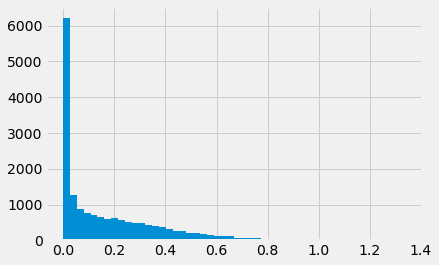

time: 219 ms (started: 2021-09-27 23:27:15 +01:00)


In [67]:
flows_2_trunc = flows_2_trunc.loc[flows_2_trunc.T_ij>0]
plt.hist(flows_2_trunc.T_ij, bins=50)
plt.show()

As mentioned above, what matters to us are the _relative magnitudes_ of the mobility flows. Therefore, let's classify the flows into ten categories, each corresponding to a certain magnitude of flow, like this:

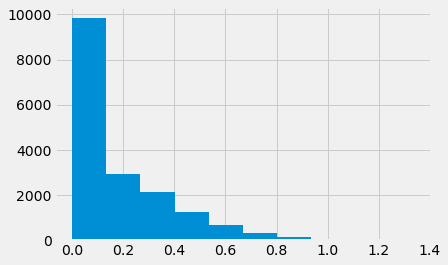

time: 141 ms (started: 2021-09-27 23:27:23 +01:00)


In [68]:
fig = plt.hist(flows_2_trunc.T_ij, bins=10)
plt.show()

In [69]:
bin_labels = range(1, 11)
bins = fig[1]
flows_2_trunc["magnitude"] = pd.cut(flows_2_trunc['T_ij'], bins=bins, labels=bin_labels)
flows_2_trunc.head()

origins  destinations         S_ji      T_ij magnitude
85489       78            79   344.100410  0.235827         2
85503       78            93  1005.695277  0.219039         2
85504       78            94   758.726669  0.001525         1
85505       78            95   762.447267  0.001643         1
85506       78            96  1494.335639  0.030692         1

time: 32 ms (started: 2021-09-27 23:27:27 +01:00)


In [70]:
flows_2_trunc['magnitude'].fillna(1, inplace=True)
flows_2_trunc.isnull().values.any()

False

time: 0 ns (started: 2021-09-27 23:27:28 +01:00)


In [71]:
flows_2_trunc['magnitude'].value_counts()

1     9833
2     2954
3     2144
4     1274
5      660
6      304
7      150
8       53
9       14
10       3
Name: magnitude, dtype: int64

time: 0 ns (started: 2021-09-27 23:27:30 +01:00)


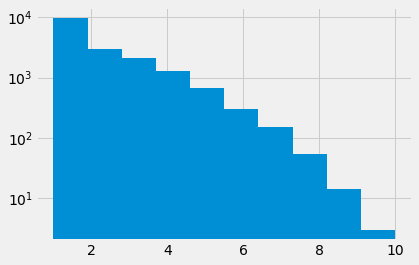

time: 984 ms (started: 2021-09-27 23:27:34 +01:00)


In [72]:
plt.hist(flows_2_trunc.magnitude, bins=10, log=True)
plt.show()

Now, let's turn our attention to the street network and project it to a local metric coordinate reference system:

In [73]:
graph_new = G.copy()
graph_new = ox.project_graph(graph_new)

time: 32.4 s (started: 2021-09-27 23:27:43 +01:00)


In [74]:
graph_new.graph

{'created_date': '2021-09-27 23:12:15',
 'created_with': 'OSMnx 1.1.1',
 'crs': <Projected CRS: +proj=utm +zone=32 +ellps=WGS84 +datum=WGS84 +unit ...>
 Name: unknown
 Axis Info [cartesian]:
 - E[east]: Easting (metre)
 - N[north]: Northing (metre)
 Area of Use:
 - undefined
 Coordinate Operation:
 - name: UTM zone 32N
 - method: Transverse Mercator
 Datum: World Geodetic System 1984
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich,
 'simplified': True}

time: 78 ms (started: 2021-09-27 23:28:15 +01:00)


Since we are going to compute shortest path between street nodes in our cluster, we have to make sure our street network does not have isolated nodes:

In [75]:
print(len(graph_new)) 
Gc = ox.utils_graph.get_largest_component(graph_new, strongly=True)
print(len(Gc)) 

58680
58361
time: 5.95 s (started: 2021-09-27 23:28:15 +01:00)


Now, we want to see which routes in the street network correspond to the directions with most mobility flow demand. In order to do this, we first create a new edge attribute called "count", assign it an initial value of zero, that we will later update according to the magnitude of mobility flow the route of which passes through the given street edge.

In [76]:
for u,v in tqdm(list(Gc.edges())):
    Gc[u][v][0]['count'] = 0
    
list(Gc.edges(data=True))[:4]

100%|████████████████████████████████████████████████████████████████████| 150932/150932 [00:00<00:00, 280063.87it/s]


[(10371529,
  743371634,
  {'osmid': 274433644,
   'oneway': True,
   'lanes': '2',
   'name': 'Via Novara',
   'highway': 'primary',
   'length': 154.435,
   'geometry': <shapely.geometry.linestring.LineString at 0x1dd81bb12b0>,
   'count': 0}),
 (10371529,
  743371622,
  {'osmid': 26703159,
   'oneway': True,
   'name': 'Via Novara',
   'highway': 'tertiary',
   'length': 150.466,
   'geometry': <shapely.geometry.linestring.LineString at 0x1dd81bb1250>,
   'count': 0}),
 (743371634,
  267879825,
  {'osmid': 274433661,
   'oneway': True,
   'lanes': '2',
   'name': 'Via Novara',
   'highway': 'primary',
   'length': 34.101,
   'geometry': <shapely.geometry.linestring.LineString at 0x1ddf8d3bc10>,
   'count': 0}),
 (743371634,
  743371622,
  {'osmid': 59995455,
   'oneway': True,
   'name': 'Via Novara',
   'highway': 'tertiary',
   'length': 47.849000000000004,
   'geometry': <shapely.geometry.linestring.LineString at 0x1ddf8d3bc40>,
   'count': 0})]

time: 2.42 s (started: 2021-09-27 23:28:21 +01:00)


## Toy example visualising a shortest path

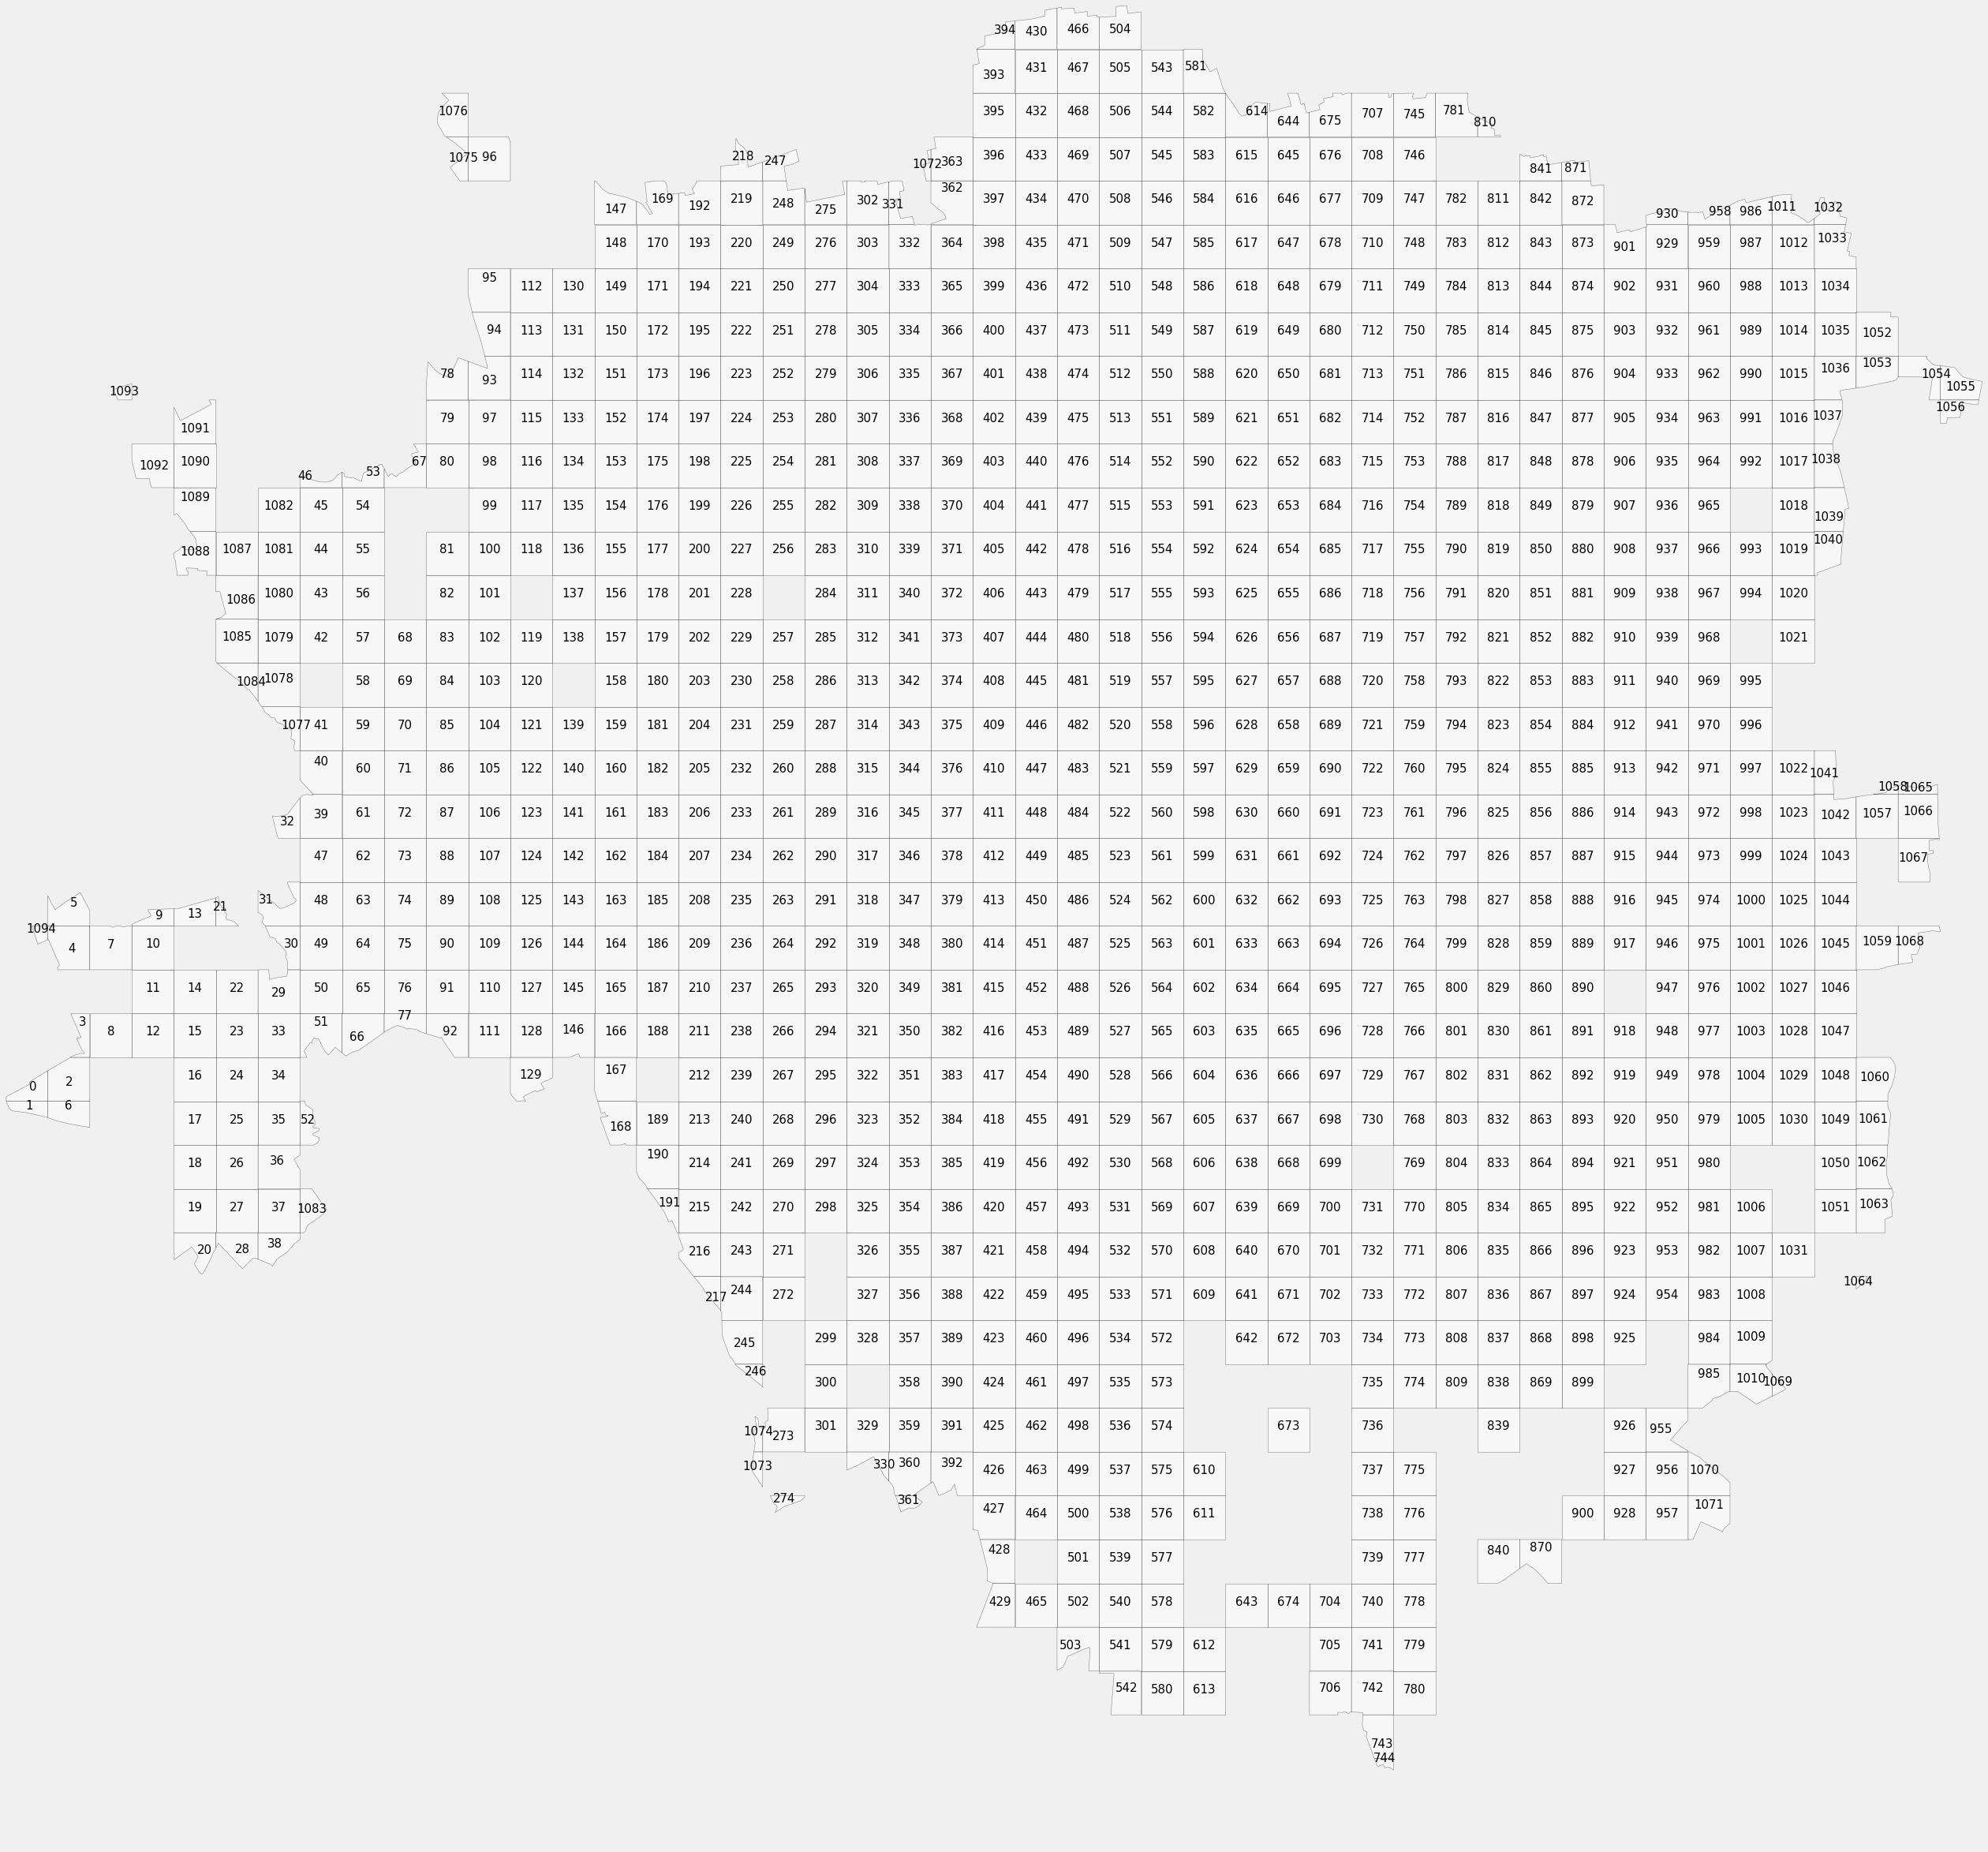

time: 9.48 s (started: 2021-09-27 23:28:24 +01:00)


In [77]:
polylist = [p for p in df_proj.geometry]

# plot city
west, south, east, north = milan.unary_union.bounds

fig, ax = plt.subplots(figsize=(40,40))
for polygon, n in zip(df_proj.geometry, np.arange(len(polylist))):
    p = polygon.representative_point().coords[:][0]
    patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', alpha=0.5, zorder=2)
    ax.add_patch(patch)
    plt.annotate(text=n, xy=p, horizontalalignment='center', size=15)
    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

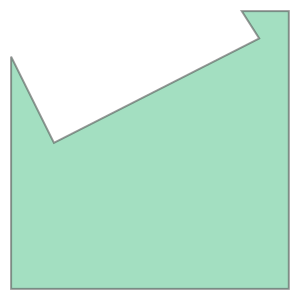

time: 0 ns (started: 2021-09-27 23:28:33 +01:00)


In [78]:
df_proj.geometry.iloc[1091]

Let's pick two grid cells and compute and plot the shortest path between their centroids:

In [79]:
from_coords = df_proj.geometry.iloc[81].centroid.coords[0]
from_nearest = ox.distance.nearest_nodes(Gc, from_coords[0], \
                                         from_coords[1])

to_coords = df_proj.geometry.iloc[769].centroid.coords[0]
to_nearest = ox.distance.nearest_nodes(Gc, to_coords[0], \
                                         to_coords[1])

route = nx.shortest_path(Gc, from_nearest, to_nearest, weight='length')
route

[1917939470,
 267944128,
 8155881133,
 8155881118,
 7981984622,
 5126818963,
 1821364333,
 1821364294,
 245484647,
 1821364270,
 1821364211,
 1821364191,
 692073204,
 6323421419,
 2754210236,
 6324124044,
 2754210232,
 267403644,
 2754237792,
 2634943424,
 267403601,
 2754340868,
 7003975724,
 7003975721,
 248226738,
 2791372669,
 3724581946,
 248292112,
 260785652,
 248291950,
 2934580203,
 295275484,
 292844942,
 248292114,
 292844984,
 1544369843,
 747373719,
 1724417039,
 2796866411,
 248292116,
 295560672,
 2533761932,
 248292118,
 248291954,
 292845113,
 248292121,
 248292122,
 5118615630,
 248292124,
 2799122102,
 257681614,
 1009311800,
 2414420739,
 2414420733,
 2414420732,
 2799529690,
 2799529687,
 3725887870,
 2414420730,
 2414456158,
 7701025643,
 2414456150,
 2414456152,
 252820377,
 3730408270,
 3730408234,
 2747728145,
 2747728124,
 2747728125,
 2661069721,
 2661069719,
 2661069716,
 2661069715,
 2661069714,
 2661124537,
 2661069717,
 1003229759,
 21226574,
 1003229685,

time: 985 ms (started: 2021-09-27 23:28:33 +01:00)


In [80]:
Gc[route[0]][route[0+1]]

AtlasView({0: {'osmid': 46607616, 'oneway': False, 'highway': 'track', 'length': 479.656, 'geometry': <shapely.geometry.linestring.LineString object at 0x000001DDFF97FCA0>, 'count': 0}})

time: 0 ns (started: 2021-09-27 23:28:34 +01:00)


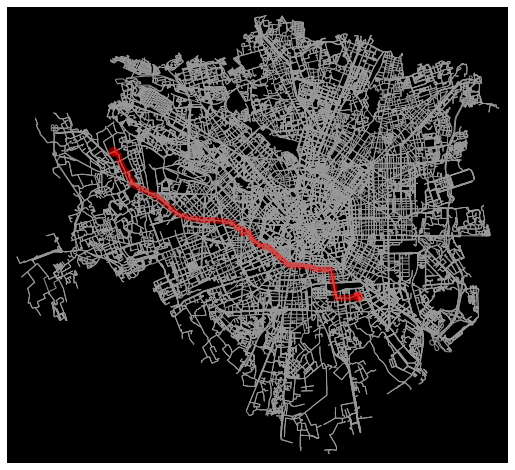

time: 19.2 s (started: 2021-09-27 23:28:34 +01:00)


In [81]:
fig, ax = ox.plot_graph_route(Gc, route, route_linewidth=6, node_size=0, bgcolor='k')

## Identifying bicycle routes with high demand

In [82]:
flows_2_trunc.head()

origins  destinations         S_ji      T_ij magnitude
85489       78            79   344.100410  0.235827         2
85503       78            93  1005.695277  0.219039         2
85504       78            94   758.726669  0.001525         1
85505       78            95   762.447267  0.001643         1
85506       78            96  1494.335639  0.030692         1

time: 16 ms (started: 2021-09-27 23:28:53 +01:00)


Now, let's start with creating a list containing the pairs of locations in our cluster, the flows between which we want to map onto the underlying street network: 

In [83]:
flow_pairs = list(zip(flows_2_trunc.origins, flows_2_trunc.destinations))
flow_pairs[:10]

[(78, 79),
 (78, 93),
 (78, 94),
 (78, 95),
 (78, 96),
 (78, 97),
 (78, 98),
 (78, 99),
 (78, 112),
 (78, 113)]

time: 16 ms (started: 2021-09-27 23:28:53 +01:00)


In [84]:
len(flow_pairs)

17389

time: 16 ms (started: 2021-09-27 23:28:54 +01:00)


We are now ready to go over all pairs of locations in our cluster, map the urban mobility flows between them onto the street network, and add the magnitude of these flows to the street segments along the routes:

In [85]:
for n, pair in tqdm(enumerate(flow_pairs)):
    
    if distance_mat[pair[0], pair[1]] <= 3500:
        
        print(n, pair, distance_mat[pair[0], pair[1]])
        print('\n')

        from_coords = df_proj.geometry.iloc[pair[0]].centroid.coords[0]
        from_nearest = ox.distance.nearest_nodes(Gc, from_coords[0], from_coords[1])

        to_coords = df_proj.geometry.iloc[pair[1]].centroid.coords[0]
        to_nearest = ox.distance.nearest_nodes(Gc, to_coords[0], to_coords[1])

        route = nx.shortest_path(Gc, from_nearest, to_nearest, weight='length')
        
        magnitude = flows_2_trunc.loc[(flows_2_trunc.origins==pair[0])& \
                                      (flows_2_trunc.destinations==pair[1]), 'magnitude'].item()
        if len(route) > 1:
            for i in range(len(route)-1):
                Gc[route[i]][route[i+1]][0]['count'] += magnitude
            
list(Gc.edges(data=True))[:4]

0it [00:00, ?it/s]

0 (78, 79) 347.5673713347868




1it [00:00,  2.03it/s]

1 (78, 93) 392.6305881794161




2it [00:00,  2.04it/s]

2 (78, 94) 624.838550627479




3it [00:02,  1.15it/s]

3 (78, 95) 922.730248902656




4it [00:02,  1.38it/s]

4 (78, 96) 2054.038399600913




5it [00:04,  1.05it/s]

5 (78, 97) 516.3208073654848




6it [00:04,  1.26it/s]

6 (78, 98) 834.2960293022901




7it [00:05,  1.03it/s]

7 (78, 99) 1198.5531461703279




8it [00:06,  1.21it/s]

8 (78, 112) 1140.575119839028




9it [00:07,  1.02it/s]

9 (78, 113) 892.9294588568982




10it [00:08,  1.21it/s]

10 (78, 114) 777.6577166688295




11it [00:09,  1.01it/s]

11 (78, 115) 850.4099725361357




12it [00:10,  1.19it/s]

12 (78, 116) 1073.6199559336214




13it [00:10,  1.36it/s]

13 (78, 117) 1375.9140923275077




14it [00:12,  1.08it/s]

14 (78, 118) 1715.9943066488333




15it [00:12,  1.27it/s]

15 (78, 130) 1438.1750227397697




16it [00:13,  1.02it/s]

16 (78, 131) 1250.9031979070128




17it [00:14,  1.20it/s]

17 (78, 132) 1171.4039936481827




18it [00:15,  1.02it/s]

18 (78, 133) 1220.9147854909224




19it [00:16,  1.21it/s]

19 (78, 134) 1385.6751429613946




20it [00:16,  1.37it/s]

20 (78, 135) 1631.12702801095




21it [00:18,  1.08it/s]

21 (78, 136) 1926.6738832749465




22it [00:18,  1.26it/s]

22 (78, 147) 2204.4801658520746




23it [00:20,  1.02s/it]

23 (78, 148) 1990.2800585942812




24it [00:20,  1.14it/s]

24 (78, 149) 1773.8683814878725




25it [00:22,  1.03s/it]

25 (78, 150) 1625.7368942563164




26it [00:22,  1.14it/s]

26 (78, 151) 1565.3909911402893




27it [00:24,  1.04s/it]

27 (78, 152) 1602.777137420816




28it [00:24,  1.15it/s]

28 (78, 153) 1731.576518849646




29it [00:26,  1.08s/it]

29 (78, 154) 1933.6072559647516




30it [00:26,  1.10it/s]

30 (78, 155) 2188.683140910319




31it [00:27,  1.14it/s]

31 (78, 169) 2534.487177278535




32it [00:28,  1.09s/it]

32 (78, 170) 2313.072025945294




33it [00:29,  1.04it/s]

33 (78, 171) 2129.7174743195646




34it [00:31,  1.18s/it]

34 (78, 172) 2008.0109399410208




35it [00:31,  1.00s/it]

35 (78, 173) 1959.4735111051493




36it [00:33,  1.14s/it]

36 (78, 174) 1989.4677775266082




37it [00:34,  1.01it/s]

37 (78, 175) 2094.622812395808




38it [00:35,  1.14s/it]

38 (78, 176) 2264.492107713873




39it [00:35,  1.05it/s]

39 (78, 177) 2485.844198031511




40it [00:37,  1.06s/it]

40 (78, 178) 2746.258425414741




41it [00:37,  1.13it/s]

41 (78, 192) 2861.9783642056564




42it [00:38,  1.30it/s]

42 (78, 193) 2655.224195723776




43it [00:39,  1.07it/s]

43 (78, 194) 2497.1203120335913




44it [00:40,  1.25it/s]

44 (78, 195) 2394.1640017491113




45it [00:41,  1.05it/s]

45 (78, 196) 2353.6035717748296




46it [00:41,  1.23it/s]

46 (78, 197) 2378.633088596057




47it [00:43,  1.04it/s]

47 (78, 198) 2467.2571934350035




48it [00:43,  1.22it/s]

48 (78, 199) 2613.013172229515




49it [00:44,  1.04it/s]

49 (78, 200) 2807.0152670098887




50it [00:45,  1.22it/s]

50 (78, 201) 3040.0408996441433




51it [00:46,  1.02s/it]

51 (78, 218) 3360.20616386145




52it [00:47,  1.13it/s]

52 (78, 219) 3191.6418152368547




53it [00:48,  1.29it/s]

53 (78, 220) 3010.1419748375843




54it [00:49,  1.06it/s]

54 (78, 221) 2871.645700968086




55it [00:49,  1.24it/s]

55 (78, 222) 2782.5816154047843




56it [00:51,  1.04it/s]

56 (78, 223) 2747.760715962592




57it [00:51,  1.22it/s]

57 (78, 224) 2769.2299560137653




58it [00:52,  1.04it/s]

58 (78, 225) 2845.715593251247




59it [00:53,  1.22it/s]

59 (78, 226) 2972.9744394065865




60it [00:54,  1.03it/s]

60 (78, 227) 3144.8487862446627




61it [00:55,  1.20it/s]

61 (78, 228) 3354.4877180614535




62it [00:55,  1.37it/s]

65 (78, 249) 3373.799006249322




66it [00:57,  2.10it/s]

66 (78, 251) 3172.432106803135




67it [00:57,  2.07it/s]

67 (78, 252) 3141.9347507665957




68it [00:58,  1.51it/s]

68 (78, 253) 3160.7276970925373




69it [00:59,  1.59it/s]

69 (78, 254) 3227.9501643549843




70it [01:00,  1.20it/s]

70 (78, 255) 3340.679877396713




71it [01:01,  1.34it/s]

71 (78, 256) 3494.5155478596794




72it [01:02,  1.11it/s]

184 (78, 1075) 2020.2636169246748




185it [01:03, 41.13it/s]

185 (78, 1076) 2407.4796993090226


186 (79, 93) 554.3894690117348


187 (79, 94) 915.2711110867347


188 (79, 95) 1250.628776401301


189 (79, 96) 2398.189338769534


190 (79, 97) 394.2244581258856


191 (79, 98) 557.6033258801295


192 (79, 99) 881.7296104676157




193it [01:10,  9.27it/s]

193 (79, 112) 1421.699196164624


194 (79, 113) 1115.2066517595592


195 (79, 114) 881.5669226926517


196 (79, 115) 788.4489162511891


197 (79, 116) 881.5669226923394


198 (79, 117) 1115.206651759518




199it [01:15,  6.03it/s]

199 (79, 118) 1421.6991961630742


200 (79, 130) 1672.8099776403885


201 (79, 131) 1421.5310383705844


202 (79, 132) 1246.6855482075043




203it [01:19,  4.50it/s]

203 (79, 133) 1182.6733743773657


204 (79, 134) 1246.6855482075043


205 (79, 135) 1421.5310383713434




206it [01:21,  3.77it/s]

206 (79, 136) 1672.809977641006


207 (79, 147) 2471.8196339479728




208it [01:23,  3.24it/s]

208 (79, 148) 2230.413303521382


209 (79, 149) 1971.340580667485




210it [01:25,  2.76it/s]

210 (79, 150) 1763.1338453862406




211it [01:26,  2.39it/s]

211 (79, 151) 1625.4584952561465




212it [01:26,  2.35it/s]

212 (79, 152) 1576.8978325033095




213it [01:28,  1.94it/s]

213 (79, 153) 1625.4584952565983




214it [01:28,  1.95it/s]

214 (79, 154) 1763.133845386345




215it [01:30,  1.55it/s]

215 (79, 155) 1971.340580668044




216it [01:30,  1.57it/s]

216 (79, 169) 2775.061177920137




217it [01:31,  1.64it/s]

217 (79, 170) 2524.571214083522




218it [01:32,  1.30it/s]

218 (79, 171) 2298.891036010363




219it [01:32,  1.43it/s]

219 (79, 172) 2123.053759848248




220it [01:34,  1.16it/s]

220 (79, 173) 2010.181989338931




221it [01:34,  1.27it/s]

221 (79, 174) 1971.1222906287294




222it [01:36,  1.02it/s]

222 (79, 175) 2010.1819893387712




223it [01:36,  1.17it/s]

223 (79, 176) 2123.053759848864




224it [01:38,  1.01it/s]

224 (79, 177) 2298.8910360111718




225it [01:38,  1.19it/s]

225 (79, 178) 2524.5712140847318




226it [01:40,  1.03s/it]

226 (79, 192) 3079.896951612324




227it [01:40,  1.13it/s]

227 (79, 193) 2843.0620767419277




228it [01:41,  1.29it/s]

228 (79, 194) 2644.7007680794654




229it [01:42,  1.05it/s]

229 (79, 195) 2493.371096414714




230it [01:43,  1.20it/s]

230 (79, 196) 2397.9937004701324




231it [01:44,  1.08s/it]

231 (79, 197) 2365.3467487544985




232it [01:45,  1.11it/s]

232 (79, 198) 2397.9937004698645




233it [01:46,  1.03s/it]

233 (79, 199) 2493.371096414972




234it [01:47,  1.15it/s]

234 (79, 200) 2644.7007680788406




235it [01:48,  1.00s/it]

235 (79, 201) 2843.0620767432515




236it [01:48,  1.18it/s]

237 (79, 219) 3391.5994585219833




238it [01:50,  1.31it/s]

238 (79, 220) 3178.5798678362003




239it [01:50,  1.43it/s]

239 (79, 221) 3002.4673448151243




240it [01:51,  1.53it/s]

240 (79, 222) 2870.06401120921




241it [01:52,  1.18it/s]

241 (79, 223) 2787.6050278853777




242it [01:53,  1.26it/s]

242 (79, 224) 2759.571206880908




243it [01:54,  1.02it/s]

243 (79, 225) 2787.6050278853527




244it [01:55,  1.19it/s]

244 (79, 226) 2870.064011209434




245it [01:56,  1.02it/s]

245 (79, 227) 3002.467344814497




246it [01:57,  1.17it/s]

246 (79, 228) 3178.579867836309




247it [01:58,  1.01s/it]

247 (79, 229) 3391.5994585226936




248it [01:59,  1.16it/s]

251 (79, 251) 3250.9169905131403




252it [02:00,  1.81it/s]

252 (79, 252) 3178.3542348616998




253it [02:00,  1.84it/s]

253 (79, 253) 3153.795665006328




254it [02:01,  1.87it/s]

254 (79, 254) 3178.3542348613532




255it [02:03,  1.32it/s]

255 (79, 255) 3250.9169905124622




256it [02:03,  1.42it/s]

256 (79, 256) 3368.3829959564587




257it [02:05,  1.10it/s]

369 (79, 1075) 2367.737604684107




370it [02:05, 38.65it/s]

370 (79, 1076) 2755.0285280672256


371 (93, 94) 423.68030327498906


372 (93, 95) 805.5342962458612


373 (93, 96) 1985.449447632005


374 (93, 97) 380.32727576241416


375 (93, 98) 774.615836668626


376 (93, 99) 1168.9429598747233




377it [02:12, 10.08it/s]

377 (93, 112) 890.3571257581045


378 (93, 113) 561.30686368966


379 (93, 114) 385.24287191706463


380 (93, 115) 541.0876424346185


381 (93, 116) 864.9605161642463




382it [02:17,  5.89it/s]

382 (93, 117) 1230.6724355194824


383 (93, 118) 1609.9595286437893


384 (93, 130) 1118.7889248026552


385 (93, 131) 879.7830653636653




386it [02:20,  4.62it/s]

386 (93, 132) 779.3362029567505


387 (93, 133) 867.0228853222359


388 (93, 134) 1098.685369612676




389it [02:23,  3.51it/s]

389 (93, 135) 1404.8158208198308


390 (93, 136) 1746.6890194735847




391it [02:25,  2.99it/s]

391 (93, 147) 1923.7215154447756


392 (93, 148) 1676.3516514634723




393it [02:27,  2.59it/s]

393 (93, 149) 1421.783159242991




394it [02:28,  2.54it/s]

394 (93, 150) 1242.4962518044392




395it [02:28,  2.48it/s]

395 (93, 151) 1173.5176227408986




396it [02:29,  1.99it/s]

396 (93, 152) 1233.4939713337153




397it [02:30,  1.96it/s]

397 (93, 153) 1406.018575640925




398it [02:32,  1.50it/s]

398 (93, 154) 1656.2868664797268




399it [02:32,  1.57it/s]

399 (93, 155) 1954.6614091440488




400it [02:33,  1.27it/s]

400 (93, 169) 2220.808066458727




401it [02:34,  1.32it/s]

401 (93, 170) 1972.5007984214317




402it [02:35,  1.09it/s]

402 (93, 171) 1761.2699657696508




403it [02:36,  1.23it/s]

403 (93, 172) 1620.0004556051842




404it [02:37,  1.03it/s]

404 (93, 173) 1567.7206866334977




405it [02:38,  1.18it/s]

405 (93, 174) 1613.1062946162651




406it [02:38,  1.32it/s]

406 (93, 175) 1748.5687791622183




407it [02:40,  1.07it/s]

407 (93, 176) 1955.477109170007




408it [02:40,  1.23it/s]

408 (93, 177) 2213.8892846785743




409it [02:42,  1.01it/s]

409 (93, 178) 2507.934986483268




410it [02:42,  1.17it/s]

410 (93, 192) 2527.089331926533




411it [02:44,  1.02s/it]

411 (93, 193) 2298.3015004466965




412it [02:44,  1.14it/s]

412 (93, 194) 2119.7882628947978




413it [02:46,  1.08s/it]

413 (93, 195) 2003.9540571942032




414it [02:46,  1.11it/s]

414 (93, 196) 1961.9323480902103




415it [02:47,  1.28it/s]

415 (93, 197) 1998.3849241109272




416it [02:48,  1.04s/it]

416 (93, 198) 2109.2470605986823




417it [02:49,  1.12it/s]

417 (93, 199) 2283.707755311627




418it [02:50,  1.04s/it]

418 (93, 200) 2508.5326691095383




419it [02:51,  1.13it/s]

419 (93, 201) 2771.4920681124763




420it [02:52,  1.05s/it]

420 (93, 218) 3027.560202506554




421it [02:53,  1.12it/s]

421 (93, 219) 2843.264078425491




422it [02:55,  1.16s/it]

422 (93, 220) 2642.810250644752




423it [02:55,  1.01s/it]

423 (93, 221) 2489.1280628887275




424it [02:57,  1.15s/it]

424 (93, 222) 2391.252411875092




425it [02:57,  1.05it/s]

425 (93, 223) 2356.148291690246




426it [02:58,  1.22it/s]

426 (93, 224) 2386.587215852206




427it [02:59,  1.01it/s]

427 (93, 225) 2480.1571314327766




428it [03:00,  1.18it/s]

428 (93, 226) 2630.1287697803255




429it [03:01,  1.02s/it]

429 (93, 227) 2827.5417567108425




430it [03:02,  1.15it/s]

430 (93, 228) 3063.237587514604




431it [03:03,  1.05s/it]

431 (93, 229) 3329.095033260506




432it [03:04,  1.11it/s]

432 (93, 247) 3313.181634861227




433it [03:05,  1.08s/it]

433 (93, 248) 3162.121770562269




434it [03:06,  1.08it/s]

434 (93, 249) 2999.5879886475427




435it [03:06,  1.23it/s]

435 (93, 251) 2780.4981888181155




436it [03:08,  1.02s/it]

436 (93, 252) 2750.366676128461




437it [03:08,  1.14it/s]

437 (93, 253) 2776.487100562366




438it [03:10,  1.08s/it]

438 (93, 254) 2857.3171817840785




439it [03:11,  1.05it/s]

439 (93, 255) 2988.4208917654814




440it [03:12,  1.16s/it]

440 (93, 256) 3163.554087836573




441it [03:13,  1.04it/s]

442 (93, 277) 3245.419621816852




443it [03:14,  1.19it/s]

443 (93, 278) 3170.974314861607




444it [03:15,  1.32it/s]

444 (93, 279) 3144.5865834234455




445it [03:16,  1.08it/s]

445 (93, 280) 3167.457741956527




446it [03:16,  1.23it/s]

446 (93, 281) 3238.5443342354083




447it [03:17,  1.36it/s]

447 (93, 282) 3354.7827580690373




448it [03:18,  1.11it/s]

553 (93, 1075) 2001.9764545131554




554it [03:19, 40.19it/s]

554 (93, 1076) 2397.1957879640217


555 (94, 95) 385.8523235079605


556 (94, 96) 1564.0714761240222


557 (94, 97) 803.6055021182968


558 (94, 98) 1197.5111982579053


559 (94, 99) 1591.6348287733665


560 (94, 112) 515.7683521425245




561it [03:26,  9.20it/s]

561 (94, 113) 348.16229850513656


562 (94, 114) 536.1287815697339


563 (94, 115) 874.4531125500929


564 (94, 116) 1246.161912820606


565 (94, 117) 1628.5539202551267




566it [03:30,  5.95it/s]

566 (94, 118) 2015.557818741969


567 (94, 130) 834.1038801332635


568 (94, 131) 742.2461019655668


569 (94, 132) 846.8449446090563




570it [03:34,  4.22it/s]

570 (94, 133) 1092.8771824104754


571 (94, 134) 1408.0595877839871


572 (94, 135) 1755.5341526055472




573it [03:37,  3.34it/s]

573 (94, 136) 2119.4776739749973


574 (94, 147) 1579.8532170696128




575it [03:39,  2.81it/s]

575 (94, 148) 1375.5306313105516


576 (94, 149) 1198.4437489534569




577it [03:42,  2.27it/s]

577 (94, 150) 1136.4274778606625




578it [03:43,  2.21it/s]

578 (94, 151) 1207.3460550983148




579it [03:44,  1.85it/s]

579 (94, 152) 1391.0135414089673




580it [03:45,  1.76it/s]

580 (94, 153) 1650.2029994230152




581it [03:46,  1.44it/s]

581 (94, 154) 1955.1056998331082




582it [03:47,  1.51it/s]

582 (94, 155) 2287.5147534024322




583it [03:48,  1.26it/s]

583 (94, 169) 1917.1262305798166




584it [03:49,  1.35it/s]

584 (94, 170) 1715.6481285482735




585it [03:49,  1.43it/s]

585 (94, 171) 1577.222686473901




586it [03:51,  1.18it/s]

586 (94, 172) 1530.631044947418




587it [03:51,  1.33it/s]

587 (94, 173) 1583.9976262872713




588it [03:53,  1.10it/s]

588 (94, 174) 1728.0864144205987




589it [03:53,  1.26it/s]

589 (94, 175) 1942.815977550464




590it [03:54,  1.04it/s]

590 (94, 176) 2207.668969941298




591it [03:55,  1.20it/s]

591 (94, 177) 2506.808275548668




592it [03:55,  1.36it/s]

592 (94, 178) 2829.3798386146796




593it [03:57,  1.06it/s]

593 (94, 192) 2256.2208451822808




594it [03:57,  1.24it/s]

594 (94, 193) 2075.003212306111




595it [03:59,  1.01s/it]

595 (94, 194) 1962.0961324102766




596it [03:59,  1.13it/s]

596 (94, 195) 1924.8431691565945




597it [04:01,  1.04s/it]

597 (94, 196) 1967.5462663363694




598it [04:02,  1.06it/s]

598 (94, 197) 2085.2991358065096




599it [04:03,  1.20s/it]

599 (94, 198) 2266.4341492121484




600it [04:04,  1.01s/it]

600 (94, 199) 2497.1968506570297




601it [04:05,  1.19s/it]

601 (94, 200) 2765.1903298759107




602it [04:06,  1.01it/s]

602 (94, 201) 3060.650274247269




603it [04:07,  1.15it/s]

603 (94, 218) 2751.156864345935




604it [04:08,  1.11s/it]

604 (94, 219) 2597.2077694143254




605it [04:09,  1.06it/s]

605 (94, 220) 2445.1286280979994




606it [04:10,  1.16s/it]

606 (94, 221) 2350.0716818172486




607it [04:11,  1.00s/it]

607 (94, 222) 2319.0594866684473




608it [04:13,  1.14s/it]

608 (94, 223) 2354.623958732049




609it [04:13,  1.04it/s]

609 (94, 224) 2453.8720754468427




610it [04:15,  1.13s/it]

610 (94, 225) 2609.5477442606025




611it [04:15,  1.06it/s]

611 (94, 226) 2812.2958215299777




612it [04:17,  1.08s/it]

612 (94, 227) 3052.751748390288




613it [04:17,  1.09it/s]

613 (94, 228) 3322.7391980275747




614it [04:18,  1.20it/s]

615 (94, 247) 3055.845521271682




616it [04:19,  1.28it/s]

616 (94, 248) 2940.0312839385065




617it [04:20,  1.34it/s]

617 (94, 249) 2821.7894201331874




618it [04:21,  1.08it/s]

618 (94, 251) 2713.2781697307005




619it [04:22,  1.23it/s]

619 (94, 252) 2743.737507609568




620it [04:23,  1.05it/s]

620 (94, 253) 2829.369132206854




621it [04:24,  1.22it/s]

621 (94, 254) 2965.3972673494454




622it [04:25,  1.02s/it]

622 (94, 255) 3145.290020238828




623it [04:26,  1.16it/s]

623 (94, 256) 3362.0134980292837




624it [04:26,  1.32it/s]

625 (94, 277) 3130.7101117329953




626it [04:27,  1.38it/s]

626 (94, 278) 3107.498318058481




627it [04:28,  1.47it/s]

627 (94, 279) 3134.1287275827594




628it [04:29,  1.14it/s]

628 (94, 280) 3209.360848624536




629it [04:30,  1.29it/s]

629 (94, 281) 3329.9021492529837




630it [04:31,  1.07it/s]

630 (94, 282) 3491.062400161121




631it [04:32,  1.24it/s]

736 (94, 1075) 1591.5166284176714




737it [04:33, 32.89it/s]

737 (94, 1076) 1986.6874043900807


738 (95, 96) 1179.9188751134689


739 (95, 97) 1185.7331904235107




740it [04:35, 17.13it/s]

740 (95, 98) 1580.0776781815182


741 (95, 99) 1974.4226575369948




742it [04:37, 11.32it/s]

742 (95, 112) 390.8140801962356


743 (95, 113) 557.1055928705284




744it [04:39,  7.67it/s]

744 (95, 114) 882.618110641299




745it [04:40,  7.05it/s]

745 (95, 115) 1248.4710281579069




746it [04:41,  5.05it/s]

746 (95, 116) 1627.6861424618794




747it [04:42,  4.46it/s]

747 (95, 117) 2012.7249041717985




748it [04:43,  2.97it/s]

748 (95, 118) 2400.7869527896396




749it [04:44,  2.83it/s]

749 (95, 130) 785.0338854639534




750it [04:44,  2.62it/s]

750 (95, 131) 879.7210908318272




751it [04:46,  1.84it/s]

751 (95, 132) 1114.7005361431422




752it [04:46,  1.87it/s]

752 (95, 133) 1422.0486855939084




753it [04:48,  1.42it/s]

753 (95, 134) 1764.3425785297243




754it [04:48,  1.52it/s]

754 (95, 135) 2124.7597736977873




755it [04:49,  1.23it/s]

755 (95, 136) 2495.459987404381




756it [04:50,  1.37it/s]

756 (95, 147) 1372.7972351733945




757it [04:51,  1.12it/s]

757 (95, 148) 1242.5911230621737




758it [04:52,  1.29it/s]

758 (95, 149) 1179.2568016094633




759it [04:52,  1.43it/s]

759 (95, 150) 1244.2980352276527




760it [04:54,  1.12it/s]

760 (95, 151) 1420.1850893786216




761it [04:54,  1.30it/s]

761 (95, 152) 1672.3010694882796




762it [04:55,  1.06it/s]

762 (95, 153) 1971.6168839893728




763it [04:56,  1.23it/s]

763 (95, 154) 2299.7766193142465




764it [04:57,  1.01it/s]

764 (95, 155) 2646.0704736564244




765it [04:58,  1.18it/s]

765 (95, 169) 1755.4803686681826




766it [04:59,  1.03s/it]

766 (95, 170) 1621.489114578306




767it [05:00,  1.15it/s]

767 (95, 171) 1573.4804904188002




768it [05:01,  1.01s/it]

768 (95, 172) 1622.7975382207937




769it [05:02,  1.17it/s]

769 (95, 173) 1761.2836051243078




770it [05:02,  1.32it/s]

770 (95, 174) 1970.2246360753616




771it [05:04,  1.06it/s]

771 (95, 175) 2229.902999418726




772it [05:04,  1.24it/s]

772 (95, 176) 2524.711220779572




773it [05:05,  1.04it/s]

773 (95, 177) 2843.744573822797




774it [05:06,  1.21it/s]

774 (95, 178) 3179.719601669686




775it [05:07,  1.01it/s]

775 (95, 192) 2126.632420827955




776it [05:08,  1.18it/s]

776 (95, 193) 2006.30183298761




777it [05:09,  1.01it/s]

777 (95, 194) 1967.7044874889273




778it [05:10,  1.20it/s]

778 (95, 195) 2007.3594462408153




779it [05:11,  1.03it/s]

779 (95, 196) 2120.881900067398




780it [05:11,  1.20it/s]

780 (95, 197) 2297.3474297442835




781it [05:12,  1.36it/s]

781 (95, 198) 2523.58623454195




782it [05:13,  1.10it/s]

782 (95, 199) 2787.505487830295




783it [05:14,  1.29it/s]

783 (95, 200) 3079.4323011698884




784it [05:15,  1.06it/s]

784 (95, 201) 3392.14339932691




785it [05:16,  1.22it/s]

785 (95, 218) 2604.8760547077954




786it [05:17,  1.02it/s]

786 (95, 219) 2489.27623506115




787it [05:17,  1.18it/s]

787 (95, 220) 2394.178979979681




788it [05:19,  1.01it/s]

788 (95, 221) 2361.928638466319




789it [05:19,  1.18it/s]

789 (95, 222) 2395.0653205147073




790it [05:20,  1.34it/s]

790 (95, 223) 2490.9809266952943




791it [05:21,  1.05it/s]

791 (95, 224) 2642.849060404165




792it [05:22,  1.23it/s]

792 (95, 225) 2841.7131147065056




793it [05:23,  1.00it/s]

793 (95, 226) 3078.47897309895




794it [05:24,  1.18it/s]

794 (95, 227) 3345.1082554400605




795it [05:25,  1.02s/it]

797 (95, 247) 2927.3525356852783




798it [05:26,  1.84it/s]

798 (95, 248) 2852.831516253977




799it [05:27,  1.39it/s]

799 (95, 249) 2783.839933988722




800it [05:27,  1.48it/s]

800 (95, 251) 2784.6022479749695




801it [05:29,  1.20it/s]

801 (95, 252) 2867.5177012620097




802it [05:29,  1.34it/s]

802 (95, 253) 3000.387132683107




803it [05:30,  1.49it/s]

803 (95, 254) 3176.9490421135583




804it [05:31,  1.18it/s]

804 (95, 255) 3390.384134238073




805it [05:31,  1.35it/s]

807 (95, 277) 3150.377171032593




808it [05:33,  1.75it/s]

808 (95, 278) 3175.296413894477




809it [05:33,  1.80it/s]

809 (95, 279) 3248.254208603589




810it [05:35,  1.37it/s]

810 (95, 280) 3366.1284263429616




811it [05:35,  1.50it/s]

918 (95, 1075) 1207.3953307384984




919it [05:36, 34.85it/s]

919 (95, 1076) 1602.2194887430278


920 (96, 97) 2365.64082193215


921 (96, 98) 2759.986534164872




922it [05:39, 18.03it/s]

922 (96, 99) 3154.332247947448


923 (96, 112) 1246.724418465494




924it [05:40, 11.95it/s]

924 (96, 113) 1625.5890231226133


925 (96, 114) 2010.416538900621




926it [05:42,  8.22it/s]

926 (96, 115) 2398.338328711072




927it [05:43,  7.50it/s]

927 (96, 116) 2788.0631107166887




928it [05:44,  5.42it/s]

928 (96, 117) 3178.9278335649874




929it [05:44,  4.94it/s]

930 (96, 130) 1421.5899067398375




931it [05:46,  3.76it/s]

931 (96, 131) 1763.2741588983001




932it [05:46,  3.45it/s]

932 (96, 132) 2123.2924309250966




933it [05:47,  3.21it/s]

933 (96, 133) 2493.716669213161




934it [05:48,  2.21it/s]

934 (96, 134) 2870.5212064513585




935it [05:48,  2.18it/s]

935 (96, 135) 3251.4886219026416




936it [05:50,  1.61it/s]

937 (96, 147) 1247.476686868918




938it [05:50,  2.08it/s]

938 (96, 148) 1421.6676798252474




939it [05:51,  1.56it/s]

939 (96, 149) 1672.823898996242




940it [05:52,  1.67it/s]

940 (96, 150) 1971.4354398631551




941it [05:53,  1.30it/s]

941 (96, 151) 2299.085183575071




942it [05:54,  1.45it/s]

942 (96, 152) 2645.0037354254396




943it [05:54,  1.58it/s]

943 (96, 153) 3002.884268632953




944it [05:55,  1.23it/s]

944 (96, 154) 3368.916768410848




945it [05:56,  1.38it/s]

946 (96, 169) 1642.9803237061083




947it [05:57,  1.46it/s]

947 (96, 170) 1763.345335645341




948it [05:58,  1.59it/s]

948 (96, 171) 1971.4430191954468




949it [05:59,  1.26it/s]

949 (96, 172) 2230.427195500351




950it [05:59,  1.41it/s]

950 (96, 173) 2524.6862106439676




951it [06:01,  1.16it/s]

951 (96, 174) 2843.2890358348077




952it [06:01,  1.33it/s]

952 (96, 175) 3178.9246156024196




953it [06:02,  1.10it/s]

956 (96, 192) 2029.0356074062777




957it [06:03,  2.40it/s]

957 (96, 193) 2123.3135426476097




958it [06:03,  2.35it/s]

958 (96, 194) 2299.056590339828




959it [06:05,  1.60it/s]

959 (96, 195) 2524.6542539685674




960it [06:05,  1.66it/s]

960 (96, 196) 2788.0305037539447




961it [06:07,  1.27it/s]

961 (96, 197) 3079.5074555759506




962it [06:07,  1.41it/s]

962 (96, 198) 3391.848366205194




963it [06:09,  1.13it/s]

966 (96, 218) 2370.3923150506153




967it [06:09,  2.39it/s]

967 (96, 219) 2398.3694796482364




968it [06:10,  1.73it/s]

968 (96, 220) 2493.6639458456934




969it [06:11,  1.80it/s]

969 (96, 221) 2644.9122253869136




970it [06:12,  1.36it/s]

970 (96, 222) 2843.1986523087044




971it [06:13,  1.50it/s]

971 (96, 223) 3079.4502048723216




972it [06:13,  1.60it/s]

972 (96, 224) 3345.633817884055




973it [06:14,  1.25it/s]

978 (96, 247) 2712.926932974363




979it [06:15,  3.36it/s]

979 (96, 248) 2780.417234114479




980it [06:16,  2.29it/s]

980 (96, 249) 2870.380670920699




981it [06:17,  2.26it/s]

981 (96, 251) 3178.758232027458




982it [06:18,  1.66it/s]

982 (96, 252) 3391.7162153502845




983it [06:18,  1.74it/s]

988 (96, 277) 3368.655097980088




989it [06:20,  2.95it/s]

1099 (96, 1075) 259.9369304495494




1100it [06:20, 44.42it/s]

1100 (96, 1076) 505.58602920848796


1101 (97, 98) 394.3457184350118


1102 (97, 99) 788.6914368690923


1103 (97, 112) 1246.992315221405


1104 (97, 113) 881.7296104674335


1105 (97, 114) 557.603325879512


1106 (97, 115) 394.2244581253035


1107 (97, 116) 557.6033258792652




1108it [06:27, 10.11it/s]

1108 (97, 117) 881.7296104674075


1109 (97, 118) 1246.992315219638


1110 (97, 130) 1421.6991961629128


1111 (97, 131) 1115.2066517593123


1112 (97, 132) 881.5669226929642


1113 (97, 133) 788.4489162514801




1114it [06:32,  6.48it/s]

1114 (97, 134) 881.5669226929642


1115 (97, 135) 1115.2066517601768


1116 (97, 136) 1421.6991961636554


1117 (97, 147) 2244.231044519248




1118it [06:35,  4.79it/s]

1118 (97, 148) 1971.5103450990987


1119 (97, 149) 1672.8099776407591


1120 (97, 150) 1421.5310383716337




1121it [06:38,  3.71it/s]

1121 (97, 151) 1246.6855482070625


1122 (97, 152) 1182.673374377424




1123it [06:39,  3.52it/s]

1123 (97, 153) 1246.685548207578


1124 (97, 154) 1421.53103837186




1125it [06:41,  2.97it/s]

1125 (97, 155) 1672.8099776414178


1126 (97, 169) 2508.8078166797363




1127it [06:43,  2.47it/s]

1127 (97, 170) 2230.413303519736




1128it [06:44,  2.04it/s]

1128 (97, 171) 1971.3405806677179




1129it [06:45,  2.02it/s]

1129 (97, 172) 1763.133845385668




1130it [06:46,  1.66it/s]

1130 (97, 173) 1625.4584952563725




1131it [06:47,  1.70it/s]

1131 (97, 174) 1576.8978325028438




1132it [06:47,  1.74it/s]

1132 (97, 175) 1625.4584952562595




1133it [06:49,  1.38it/s]

1133 (97, 176) 1763.133845386345




1134it [06:49,  1.50it/s]

1134 (97, 177) 1971.3405806686962




1135it [06:50,  1.23it/s]

1135 (97, 178) 2230.4133035210943




1136it [06:51,  1.37it/s]

1136 (97, 192) 2786.4270668071667




1137it [06:52,  1.13it/s]

1137 (97, 193) 2524.5712140832497




1138it [06:53,  1.28it/s]

1138 (97, 194) 2298.891036010463




1139it [06:54,  1.08it/s]

1139 (97, 195) 2123.053759848172




1140it [06:54,  1.26it/s]

1140 (97, 196) 2010.1819893391707




1141it [06:55,  1.42it/s]

1141 (97, 197) 1971.122290628613




1142it [06:56,  1.14it/s]

1142 (97, 198) 2010.181989338874




1143it [06:57,  1.31it/s]

1143 (97, 199) 2123.05375984854




1144it [06:58,  1.09it/s]

1144 (97, 200) 2298.891036009784




1145it [06:58,  1.27it/s]

1145 (97, 201) 2524.571214084686




1146it [07:00,  1.07it/s]

1146 (97, 218) 3285.934422727851




1147it [07:00,  1.24it/s]

1147 (97, 219) 3079.3796263284858




1148it [07:01,  1.05it/s]

1148 (97, 220) 2843.06207674288




1149it [07:02,  1.22it/s]

1149 (97, 221) 2644.7007680796737




1150it [07:03,  1.04it/s]

1150 (97, 222) 2493.371096415156




1151it [07:04,  1.22it/s]

1151 (97, 223) 2397.9937004695967




1152it [07:04,  1.39it/s]

1152 (97, 224) 2365.3467487550224




1153it [07:06,  1.12it/s]

1153 (97, 225) 2397.9937004696158




1154it [07:06,  1.29it/s]

1154 (97, 226) 2493.371096415377




1155it [07:07,  1.08it/s]

1155 (97, 227) 2644.7007680789443




1156it [07:08,  1.26it/s]

1156 (97, 228) 2843.062076743058




1157it [07:09,  1.06it/s]

1157 (97, 229) 3079.379626329156




1158it [07:10,  1.22it/s]

1159 (97, 248) 3375.467577105431




1160it [07:11,  1.34it/s]

1160 (97, 249) 3178.5798678369224




1161it [07:11,  1.46it/s]

1161 (97, 251) 2870.064011209122




1162it [07:12,  1.57it/s]

1162 (97, 252) 2787.605027885756




1163it [07:13,  1.20it/s]

1163 (97, 253) 2759.5712068804423




1164it [07:14,  1.36it/s]

1164 (97, 254) 2787.605027885394




1165it [07:15,  1.10it/s]

1165 (97, 255) 2870.064011208386




1166it [07:16,  1.27it/s]

1166 (97, 256) 3002.467344814765




1167it [07:17,  1.07it/s]

1167 (97, 257) 3391.599458521604




1168it [07:17,  1.24it/s]

1168 (97, 277) 3368.382995956677




1169it [07:19,  1.05it/s]

1169 (97, 278) 3250.9169905129706




1170it [07:19,  1.22it/s]

1170 (97, 279) 3178.3542348612377




1171it [07:20,  1.38it/s]

1171 (97, 280) 3153.7956650061533




1172it [07:21,  1.12it/s]

1172 (97, 281) 3178.3542348611804




1173it [07:21,  1.29it/s]

1173 (97, 282) 3250.9169905131967




1174it [07:23,  1.07it/s]

1174 (97, 283) 3368.3829959561863




1175it [07:23,  1.25it/s]

1279 (97, 1075) 2378.2490246596544




1280it [07:25, 34.02it/s]

1280 (97, 1076) 2773.1275476353585


1281 (98, 99) 394.3457184340805


1282 (98, 112) 1625.8996444304241




1283it [07:27, 17.64it/s]

1283 (98, 113) 1246.9923152187175


1284 (98, 114) 881.7296104675896




1285it [07:29, 11.72it/s]

1285 (98, 115) 557.6033258798826


1286 (98, 116) 394.22445812559454




1287it [07:30,  8.16it/s]

1287 (98, 117) 557.6033258793885




1288it [07:31,  7.48it/s]

1288 (98, 118) 881.7296104684227




1289it [07:32,  5.37it/s]

1289 (98, 130) 1763.4592209366892




1290it [07:32,  4.88it/s]

1290 (98, 131) 1421.6991961620408




1291it [07:34,  3.46it/s]

1291 (98, 132) 1115.2066517603826




1292it [07:34,  3.26it/s]

1292 (98, 133) 881.5669226925476




1293it [07:35,  2.34it/s]

1293 (98, 134) 788.448916251713




1294it [07:36,  2.32it/s]

1294 (98, 135) 881.566922692912




1295it [07:37,  1.72it/s]

1295 (98, 136) 1115.2066517608766




1296it [07:38,  1.80it/s]

1296 (98, 147) 2589.4606694688728




1297it [07:38,  1.85it/s]

1297 (98, 148) 2299.2237715511747




1298it [07:39,  1.37it/s]

1298 (98, 149) 1971.5103450988195




1299it [07:40,  1.51it/s]

1299 (98, 150) 1672.8099776407178




1300it [07:41,  1.19it/s]

1300 (98, 151) 1421.531038371198




1301it [07:42,  1.36it/s]

1301 (98, 152) 1246.6855482078543




1302it [07:43,  1.13it/s]

1302 (98, 153) 1182.6733743773657




1303it [07:43,  1.31it/s]

1303 (98, 154) 1246.6855482077438




1304it [07:45,  1.07it/s]

1304 (98, 155) 1421.5310383721346




1305it [07:45,  1.24it/s]

1305 (98, 169) 2825.239320091975




1306it [07:47,  1.05it/s]

1306 (98, 170) 2524.741653189428




1307it [07:47,  1.23it/s]

1307 (98, 171) 2230.413303521259




1308it [07:48,  1.41it/s]

1308 (98, 172) 1971.3405806671124




1309it [07:49,  1.14it/s]

1309 (98, 173) 1763.1338453859803




1310it [07:49,  1.33it/s]

1310 (98, 174) 1625.4584952562032




1311it [07:51,  1.10it/s]

1311 (98, 175) 1576.897832502902




1312it [07:51,  1.29it/s]

1312 (98, 176) 1625.4584952567677




1313it [07:52,  1.09it/s]

1313 (98, 177) 1763.133845387022




1314it [07:53,  1.27it/s]

1314 (98, 178) 1971.3405806677179




1315it [07:54,  1.07it/s]

1315 (98, 192) 3075.848056617537




1316it [07:55,  1.25it/s]

1316 (98, 193) 2788.016629399783




1317it [07:55,  1.41it/s]

1317 (98, 194) 2524.5712140850046




1318it [07:56,  1.14it/s]

1318 (98, 195) 2298.8910360096042




1319it [07:57,  1.32it/s]

1319 (98, 196) 2123.053759848972




1320it [07:58,  1.10it/s]

1320 (98, 197) 2010.1819893386455




1321it [07:58,  1.28it/s]

1321 (98, 198) 1971.1222906290786




1322it [08:00,  1.07it/s]

1322 (98, 199) 2010.1819893389425




1323it [08:00,  1.26it/s]

1323 (98, 200) 2123.0537598484098




1324it [08:02,  1.07it/s]

1324 (98, 201) 2298.891036010313




1325it [08:02,  1.25it/s]

1326 (98, 219) 3345.6199552813123




1327it [08:03,  1.36it/s]

1327 (98, 220) 3079.379626328381




1328it [08:04,  1.48it/s]

1328 (98, 221) 2843.0620767439136




1329it [08:04,  1.60it/s]

1329 (98, 222) 2644.7007680795696




1330it [08:06,  1.24it/s]

1330 (98, 223) 2493.3710964146035




1331it [08:06,  1.40it/s]

1331 (98, 224) 2397.9937004701515




1332it [08:07,  1.13it/s]

1332 (98, 225) 2365.3467487545568




1333it [08:08,  1.31it/s]

1333 (98, 226) 2397.993700470171




1334it [08:09,  1.08it/s]

1334 (98, 227) 2493.3710964150087




1335it [08:10,  1.26it/s]

1335 (98, 228) 2644.7007680791007




1336it [08:11,  1.06it/s]

1336 (98, 229) 2843.062076743784




1337it [08:11,  1.25it/s]

1339 (98, 249) 3391.599458522856




1340it [08:13,  1.67it/s]

1340 (98, 251) 3002.467344814811




1341it [08:13,  1.70it/s]

1341 (98, 252) 2870.064011209402




1342it [08:14,  1.77it/s]

1342 (98, 253) 2787.6050278854514




1343it [08:15,  1.34it/s]

1343 (98, 254) 2759.571206880617




1344it [08:16,  1.48it/s]

1344 (98, 255) 2787.6050278852044




1345it [08:17,  1.19it/s]

1345 (98, 256) 2870.0640112094256




1346it [08:17,  1.35it/s]

1346 (98, 257) 3178.579867835904




1347it [08:19,  1.11it/s]

1348 (98, 278) 3368.382995956186




1349it [08:19,  1.64it/s]

1349 (98, 279) 3250.9169905129706




1350it [08:20,  1.28it/s]

1350 (98, 280) 3178.3542348611227




1351it [08:21,  1.40it/s]

1351 (98, 281) 3153.7956650064443




1352it [08:22,  1.14it/s]

1352 (98, 282) 3178.3542348618153




1353it [08:23,  1.30it/s]

1353 (98, 283) 3250.9169905130834




1354it [08:23,  1.45it/s]

1354 (98, 284) 3368.382995956077




1355it [08:25,  1.16it/s]

1458 (98, 1075) 2770.5605094166344




1459it [08:25, 41.31it/s]

1459 (98, 1076) 3165.1076769446295


1460 (99, 112) 2010.7527358153272


1461 (99, 113) 1625.8996444266973


1462 (99, 114) 1246.992315217834


1463 (99, 115) 881.7296104672514


1464 (99, 116) 557.6033258798415


1465 (99, 117) 394.2244581254199




1466it [08:31,  9.89it/s]

1466 (99, 118) 557.603325880747


1467 (99, 130) 2123.526626801469


1468 (99, 131) 1763.4592209347888


1469 (99, 132) 1421.69919616217


1470 (99, 133) 1115.2066517588182




1471it [08:35,  6.38it/s]

1471 (99, 134) 881.5669226924435


1472 (99, 135) 788.4489162513055


1473 (99, 136) 881.566922693485


1474 (99, 147) 2947.042114995747




1475it [08:39,  4.61it/s]

1475 (99, 148) 2645.18883140506


1476 (99, 149) 2299.223771549957


1477 (99, 150) 1971.5103450976435




1478it [08:41,  3.76it/s]

1478 (99, 151) 1672.809977639442


1479 (99, 152) 1421.5310383713434




1480it [08:43,  3.21it/s]

1480 (99, 153) 1246.685548206584


1481 (99, 154) 1182.673374377191




1482it [08:45,  2.75it/s]

1482 (99, 155) 1246.6855482077253




1483it [08:45,  2.70it/s]

1483 (99, 169) 3159.249097783212




1484it [08:47,  2.24it/s]

1484 (99, 170) 2843.398392324243




1485it [08:47,  2.21it/s]

1485 (99, 171) 2524.741653190119




1486it [08:48,  1.78it/s]

1486 (99, 172) 2230.4133035196537




1487it [08:49,  1.82it/s]

1487 (99, 173) 1971.3405806665535




1488it [08:49,  1.86it/s]

1488 (99, 174) 1763.1338453850951




1489it [08:51,  1.44it/s]

1489 (99, 175) 1625.4584952554687




1490it [08:51,  1.56it/s]

1490 (99, 176) 1576.8978325030766




1491it [08:52,  1.26it/s]

1491 (99, 177) 1625.4584952569373




1492it [08:53,  1.41it/s]

1492 (99, 178) 1763.1338453864491




1493it [08:54,  1.15it/s]

1493 (99, 192) 3386.520903146727




1494it [08:55,  1.30it/s]

1494 (99, 193) 3079.5504100325993




1495it [08:56,  1.08it/s]

1495 (99, 194) 2788.01662940073




1496it [08:56,  1.27it/s]

1496 (99, 195) 2524.571214083077




1497it [08:58,  1.07it/s]

1497 (99, 196) 2298.891036009884




1498it [08:58,  1.25it/s]

1498 (99, 197) 2123.053759847631




1499it [08:59,  1.43it/s]

1499 (99, 198) 2010.181989338577




1500it [09:00,  1.15it/s]

1500 (99, 199) 1971.122290628613




1501it [09:00,  1.33it/s]

1501 (99, 200) 2010.1819893388283




1502it [09:02,  1.10it/s]

1502 (99, 201) 2123.0537598488318




1503it [09:02,  1.30it/s]

1505 (99, 220) 3345.619955280201




1506it [09:03,  1.71it/s]

1506 (99, 221) 3079.379626328709




1507it [09:04,  1.77it/s]

1507 (99, 222) 2843.0620767430096




1508it [09:05,  1.36it/s]

1508 (99, 223) 2644.700768077903




1509it [09:06,  1.48it/s]

1509 (99, 224) 2493.371096414659




1510it [09:07,  1.20it/s]

1510 (99, 225) 2397.9937004690414




1511it [09:07,  1.36it/s]

1511 (99, 226) 2365.346748754615




1512it [09:09,  1.12it/s]

1512 (99, 227) 2397.993700469903




1513it [09:09,  1.29it/s]

1513 (99, 228) 2493.3710964149905




1514it [09:10,  1.46it/s]

1514 (99, 229) 2644.700768079986




1515it [09:11,  1.17it/s]

1518 (99, 251) 3178.579867835948




1519it [09:11,  2.51it/s]

1519 (99, 252) 3002.4673448143903




1520it [09:13,  1.78it/s]

1520 (99, 253) 2870.064011208386




1521it [09:13,  1.83it/s]

1521 (99, 254) 2787.605027885147




1522it [09:15,  1.36it/s]

1522 (99, 255) 2759.5712068802095




1523it [09:15,  1.41it/s]

1523 (99, 256) 2787.6050278859293




1524it [09:17,  1.16it/s]

1524 (99, 257) 3002.467344814215




1525it [09:17,  1.32it/s]

1527 (99, 279) 3368.382995955641




1528it [09:18,  2.27it/s]

1528 (99, 280) 3250.916990512067




1529it [09:19,  1.63it/s]

1529 (99, 281) 3178.35423486118




1530it [09:19,  1.71it/s]

1530 (99, 282) 3153.795665006619




1531it [09:21,  1.32it/s]

1531 (99, 283) 3178.3542348613532




1532it [09:21,  1.46it/s]

1532 (99, 284) 3250.916990512858




1533it [09:22,  1.17it/s]

1533 (99, 285) 3368.3829959563495




1534it [09:23,  1.31it/s]

1636 (99, 1075) 3163.377900389658




1637it [09:24, 32.95it/s]

1638 (112, 113) 394.3457184378058


1639 (112, 114) 788.6914368728176




1640it [09:26, 19.29it/s]

1640 (112, 115) 1183.037155306898


1641 (112, 116) 1577.3828737409785




1642it [09:28, 12.13it/s]

1642 (112, 117) 1971.7285921759903


1643 (112, 118) 2366.0743106119335




1644it [09:29,  9.75it/s]

1644 (112, 130) 394.22445812559454




1645it [09:30,  6.97it/s]

1645 (112, 131) 557.6033258817762




1646it [09:31,  6.32it/s]

1646 (112, 132) 881.7296104700107




1647it [09:32,  4.40it/s]

1647 (112, 133) 1246.9923152222334




1648it [09:32,  4.03it/s]

1648 (112, 134) 1625.899644430382




1649it [09:34,  2.81it/s]

1649 (112, 135) 2010.7527358162176




1650it [09:34,  2.70it/s]

1650 (112, 136) 2398.6914279928787




1651it [09:35,  1.95it/s]

1651 (112, 147) 1064.8855908097855




1652it [09:36,  1.96it/s]

1652 (112, 148) 881.5669226925996




1653it [09:36,  1.98it/s]

1653 (112, 149) 788.4489162510727




1654it [09:38,  1.45it/s]

1654 (112, 150) 881.5669226940056




1655it [09:38,  1.57it/s]

1655 (112, 151) 1115.2066517613293




1656it [09:39,  1.25it/s]

1656 (112, 152) 1421.6991961637846




1657it [09:40,  1.41it/s]

1657 (112, 153) 1763.4592209391365




1658it [09:41,  1.16it/s]

1658 (112, 154) 2123.526626804993




1659it [09:42,  1.33it/s]

1659 (112, 155) 2493.984630442626




1660it [09:43,  1.10it/s]

1660 (112, 169) 1414.431161679475




1661it [09:43,  1.28it/s]

1661 (112, 170) 1246.685548206234




1662it [09:44,  1.45it/s]

1662 (112, 171) 1182.6733743772493




1663it [09:45,  1.16it/s]

1663 (112, 172) 1246.685548207707




1664it [09:46,  1.35it/s]

1664 (112, 173) 1421.5310383723765




1665it [09:47,  1.11it/s]

1665 (112, 174) 1672.8099776415002




1666it [09:47,  1.30it/s]

1666 (112, 175) 1971.510345100275




1667it [09:49,  1.09it/s]

1667 (112, 176) 2299.223771552652




1668it [09:49,  1.27it/s]

1668 (112, 177) 2645.188831409095




1669it [09:50,  1.06it/s]

1669 (112, 178) 3003.1042351588917




1670it [09:51,  1.25it/s]

1670 (112, 192) 1769.0444745618286




1671it [09:52,  1.06it/s]

1671 (112, 193) 1625.458495255186




1672it [09:53,  1.24it/s]

1672 (112, 194) 1576.8978325032513




1673it [09:53,  1.43it/s]

1673 (112, 195) 1625.4584952571631




1674it [09:54,  1.15it/s]

1674 (112, 196) 1763.133845386397




1675it [09:55,  1.34it/s]

1675 (112, 197) 1971.340580668044




1676it [09:56,  1.11it/s]

1676 (112, 198) 2230.4133035218765




1677it [09:56,  1.30it/s]

1677 (112, 199) 2524.7416531922645




1678it [09:58,  1.08it/s]

1678 (112, 200) 2843.3983923274723




1679it [09:58,  1.27it/s]

1679 (112, 201) 3179.0762040129225




1680it [09:59,  1.07it/s]

1680 (112, 218) 2257.337002105166




1681it [10:00,  1.20it/s]

1681 (112, 219) 2123.053759847631




1682it [10:01,  1.04it/s]

1682 (112, 220) 2010.1819893385655




1683it [10:02,  1.22it/s]

1683 (112, 221) 1971.122290628904




1684it [10:02,  1.40it/s]

1684 (112, 222) 2010.1819893385887




1685it [10:04,  1.14it/s]

1685 (112, 223) 2123.053759849394




1686it [10:04,  1.32it/s]

1686 (112, 224) 2298.891036011042




1687it [10:05,  1.09it/s]

1687 (112, 225) 2524.571214085714




1688it [10:06,  1.28it/s]

1688 (112, 226) 2788.0166294033233




1689it [10:07,  1.07it/s]

1689 (112, 227) 3079.5504100359085




1690it [10:08,  1.25it/s]

1690 (112, 228) 3391.9377679110903




1691it [10:09,  1.06it/s]

1692 (112, 247) 2571.2573671527625




1693it [10:09,  1.61it/s]

1693 (112, 248) 2479.696929724027




1694it [10:10,  1.71it/s]

1694 (112, 249) 2397.993700469692




1695it [10:11,  1.30it/s]

1695 (112, 251) 2397.993700469903




1696it [10:12,  1.37it/s]

1696 (112, 252) 2493.371096415248




1697it [10:13,  1.12it/s]

1697 (112, 253) 2644.7007680795696




1698it [10:14,  1.29it/s]

1698 (112, 254) 2843.0620767437686




1699it [10:15,  1.09it/s]

1699 (112, 255) 3079.3796263286195




1700it [10:15,  1.26it/s]

1700 (112, 256) 3345.619955282506




1701it [10:17,  1.07it/s]

1702 (112, 277) 2759.571206880617




1703it [10:17,  1.61it/s]

1703 (112, 278) 2787.60502788583




1704it [10:18,  1.28it/s]

1704 (112, 279) 2870.064011208898




1705it [10:19,  1.42it/s]

1705 (112, 280) 3002.467344815224




1706it [10:19,  1.51it/s]

1706 (112, 281) 3178.5798678364604




1707it [10:21,  1.14it/s]

1707 (112, 282) 3391.599458523093




1708it [10:21,  1.28it/s]

1713 (112, 302) 3248.3567832312024




1714it [10:23,  2.47it/s]

1714 (112, 304) 3153.7956650064443




1715it [10:23,  2.38it/s]

1715 (112, 305) 3178.354234861411




1716it [10:25,  1.71it/s]

1716 (112, 306) 3250.916990512801




1717it [10:25,  1.75it/s]

1717 (112, 307) 3368.3829959570585




1718it [10:27,  1.37it/s]

1813 (112, 1075) 1350.2120342234507




1814it [10:27, 35.60it/s]

1814 (112, 1076) 1727.4861392741143


1815 (113, 114) 394.3457184350118


1816 (113, 115) 788.6914368690923


1817 (113, 116) 1183.0371553031728


1818 (113, 117) 1577.3828737381846


1819 (113, 118) 1971.7285921741277


1820 (113, 130) 557.6033258808293




1821it [10:33, 10.09it/s]

1821 (113, 132) 557.6033258796356


1822 (113, 133) 881.7296104683967


1823 (113, 134) 1246.9923152188096


1824 (113, 135) 1625.8996444276854


1825 (113, 136) 2010.7527358144255




1826it [10:37,  6.34it/s]

1826 (113, 147) 1367.3564367688887


1827 (113, 148) 1115.2066517618232


1828 (113, 149) 881.5669226935371


1829 (113, 150) 788.4489162520622




1830it [10:40,  4.55it/s]

1830 (113, 151) 881.5669226923914


1831 (113, 152) 1115.2066517591475


1832 (113, 153) 1421.6991961630417




1833it [10:43,  3.47it/s]

1833 (113, 154) 1763.4592209367672


1834 (113, 155) 2123.5266268031987




1835it [10:45,  3.01it/s]

1835 (113, 169) 1659.9472256693532


1836 (113, 170) 1421.5310383713434




1837it [10:46,  2.84it/s]

1837 (113, 171) 1246.6855482080935




1838it [10:47,  2.37it/s]

1838 (113, 172) 1182.6733743773075




1839it [10:48,  2.35it/s]

1839 (113, 173) 1246.685548207265




1840it [10:49,  1.91it/s]

1840 (113, 174) 1421.531038370778




1841it [10:49,  1.92it/s]

1841 (113, 175) 1672.8099776403064




1842it [10:51,  1.55it/s]

1842 (113, 176) 1971.5103450984236




1843it [10:51,  1.61it/s]

1843 (113, 177) 2299.2237715518236




1844it [10:53,  1.24it/s]

1844 (113, 178) 2645.18883140506




1845it [10:53,  1.37it/s]

1845 (113, 192) 1973.102264926274




1846it [10:54,  1.49it/s]

1846 (113, 193) 1763.1338453856158




1847it [10:55,  1.16it/s]

1847 (113, 194) 1625.4584952571631




1848it [10:56,  1.32it/s]

1848 (113, 195) 1576.897832503484




1849it [10:57,  1.08it/s]

1849 (113, 196) 1625.4584952562593




1850it [10:57,  1.25it/s]

1850 (113, 197) 1763.1338453853557




1851it [10:59,  1.03it/s]

1851 (113, 198) 1971.340580666833




1852it [10:59,  1.20it/s]

1852 (113, 199) 2230.413303520559




1853it [11:01,  1.00it/s]

1853 (113, 200) 2524.7416531895733




1854it [11:01,  1.14it/s]

1854 (113, 201) 2843.398392326019




1855it [11:03,  1.02s/it]

1855 (113, 218) 2472.756528162506




1856it [11:03,  1.16it/s]

1856 (113, 219) 2298.891036010643




1857it [11:04,  1.33it/s]

1857 (113, 220) 2123.053759849026




1858it [11:05,  1.06it/s]

1858 (113, 221) 2010.1819893395932




1859it [11:06,  1.22it/s]

1859 (113, 222) 1971.122290628904




1860it [11:07,  1.01it/s]

1860 (113, 223) 2010.1819893390452




1861it [11:08,  1.17it/s]

1861 (113, 224) 2123.053759848496




1862it [11:09,  1.02s/it]

1862 (113, 225) 2298.891036009784




1863it [11:09,  1.16it/s]

1863 (113, 226) 2524.5712140849587




1864it [11:11,  1.02s/it]

1864 (113, 227) 2788.016629400277




1865it [11:11,  1.16it/s]

1865 (113, 228) 3079.5504100343655




1866it [11:12,  1.33it/s]

1866 (113, 229) 3391.937767909392




1867it [11:13,  1.07it/s]

1867 (113, 247) 2765.0519642756303




1868it [11:14,  1.25it/s]

1868 (113, 248) 2629.690489681214




1869it [11:15,  1.03it/s]

1869 (113, 249) 2493.371096415837




1870it [11:16,  1.21it/s]

1870 (113, 251) 2365.346748754964




1871it [11:17,  1.02it/s]

1871 (113, 252) 2397.9937004698454




1872it [11:17,  1.19it/s]

1872 (113, 253) 2493.3710964146035




1873it [11:19,  1.00s/it]

1873 (113, 254) 2644.70076807858




1874it [11:19,  1.17it/s]

1874 (113, 255) 2843.06207674175




1875it [11:20,  1.33it/s]

1875 (113, 256) 3079.3796263281424




1876it [11:21,  1.04it/s]

1877 (113, 277) 2787.605027886135




1878it [11:22,  1.48it/s]

1878 (113, 278) 2759.571206880908




1879it [11:23,  1.14it/s]

1879 (113, 279) 2787.605027885188




1880it [11:24,  1.29it/s]

1880 (113, 280) 2870.064011208866




1881it [11:25,  1.08it/s]

1881 (113, 281) 3002.4673448137632




1882it [11:26,  1.23it/s]

1882 (113, 282) 3178.579867836092




1883it [11:27,  1.04it/s]

1883 (113, 283) 3391.5994585218205




1884it [11:28,  1.21it/s]

1888 (113, 302) 3365.534178164859




1889it [11:29,  2.22it/s]

1889 (113, 304) 3178.354234861873




1890it [11:29,  2.17it/s]

1890 (113, 305) 3153.795665006328




1891it [11:30,  2.13it/s]

1891 (113, 306) 3178.3542348610645




1892it [11:31,  1.53it/s]

1892 (113, 307) 3250.9169905131967




1893it [11:32,  1.61it/s]

1988 (113, 1075) 1705.8600108230235




1989it [11:33, 30.84it/s]

1989 (113, 1076) 2092.5647657133613


1990 (114, 115) 394.3457184340805


1991 (114, 116) 788.691436868161




1992it [11:35, 15.97it/s]

1992 (114, 117) 1183.0371553031728


1993 (114, 118) 1577.382873739116




1994it [11:37, 10.45it/s]

1994 (114, 130) 881.7296104690996


1995 (114, 131) 557.6033258798003




1996it [11:39,  7.25it/s]

1996 (114, 132) 394.22445812576916




1997it [11:40,  6.63it/s]

1997 (114, 133) 557.6033258800472




1998it [11:41,  4.78it/s]

1998 (114, 134) 881.7296104675116




1999it [11:41,  4.38it/s]

1999 (114, 135) 1246.9923152186807




2000it [11:43,  3.09it/s]

2000 (114, 136) 1625.8996444285183




2001it [11:43,  2.94it/s]

2001 (114, 147) 1707.7362267409865




2002it [11:45,  2.09it/s]

2002 (114, 148) 1421.699196164592




2003it [11:45,  2.07it/s]

2003 (114, 149) 1115.206651761247




2004it [11:47,  1.55it/s]

2004 (114, 150) 881.566922693589




2005it [11:47,  1.65it/s]

2005 (114, 151) 788.4489162511891




2006it [11:47,  1.73it/s]

2006 (114, 152) 881.566922692131




2007it [11:49,  1.32it/s]

2007 (114, 153) 1115.2066517601768




2008it [11:49,  1.45it/s]

2008 (114, 154) 1421.699196162945




2009it [11:51,  1.14it/s]

2009 (114, 155) 1763.459220937314




2010it [11:51,  1.30it/s]

2010 (114, 169) 1954.8020780057275




2011it [11:53,  1.06it/s]

2011 (114, 170) 1672.809977640224




2012it [11:53,  1.22it/s]

2012 (114, 171) 1421.5310383723283




2013it [11:54,  1.05it/s]

2013 (114, 172) 1246.6855482074125




2014it [11:55,  1.24it/s]

2014 (114, 173) 1182.6733743773075




2015it [11:55,  1.42it/s]

2015 (114, 174) 1246.6855482067679




2016it [11:57,  1.13it/s]

2016 (114, 175) 1421.5310383710528




2017it [11:57,  1.31it/s]

2017 (114, 176) 1672.8099776404297




2018it [11:58,  1.07it/s]

2018 (114, 177) 1971.5103450995996




2019it [11:59,  1.24it/s]

2019 (114, 178) 2299.2237715501365




2020it [12:00,  1.04it/s]

2020 (114, 192) 2228.8480957720985




2021it [12:01,  1.21it/s]

2021 (114, 193) 1971.3405806667865




2022it [12:02,  1.02it/s]

2022 (114, 194) 1763.1338453868136




2023it [12:03,  1.19it/s]

2023 (114, 195) 1625.4584952564853




2024it [12:04,  1.00it/s]

2024 (114, 196) 1576.8978325032513




2025it [12:04,  1.18it/s]

2025 (114, 197) 1625.4584952558075




2026it [12:05,  1.35it/s]

2026 (114, 198) 1763.1338453854596




2027it [12:06,  1.07it/s]

2027 (114, 199) 1971.3405806670194




2028it [12:07,  1.25it/s]

2028 (114, 200) 2230.4133035198183




2029it [12:08,  1.03it/s]

2029 (114, 201) 2524.741653190119




2030it [12:09,  1.20it/s]

2030 (114, 218) 2728.460453324464




2031it [12:10,  1.02it/s]

2031 (114, 219) 2524.571214085041




2032it [12:10,  1.19it/s]

2032 (114, 220) 2298.8910360104132




2033it [12:12,  1.01it/s]

2033 (114, 221) 2123.053759849394




2034it [12:12,  1.18it/s]

2034 (114, 222) 2010.1819893391366




2035it [12:14,  1.01it/s]

2035 (114, 223) 1971.122290628904




2036it [12:14,  1.18it/s]

2036 (114, 224) 2010.1819893389195




2037it [12:15,  1.35it/s]

2037 (114, 225) 2123.0537598480855




2038it [12:16,  1.08it/s]

2038 (114, 226) 2298.891036010313




2039it [12:17,  1.25it/s]

2039 (114, 227) 2524.571214083704




2040it [12:18,  1.02it/s]

2040 (114, 228) 2788.016629400483




2041it [12:18,  1.19it/s]

2041 (114, 229) 3079.550410034701




2042it [12:20,  1.00it/s]

2042 (114, 247) 2998.4458263305937




2043it [12:20,  1.18it/s]

2043 (114, 248) 2827.1300590963992




2044it [12:22,  1.01it/s]

2044 (114, 249) 2644.7007680800384




2045it [12:22,  1.19it/s]

2045 (114, 251) 2397.9937004700564




2046it [12:24,  1.02s/it]

2046 (114, 252) 2365.346748754906




2047it [12:24,  1.16it/s]

2047 (114, 253) 2397.9937004694816




2048it [12:25,  1.26it/s]

2048 (114, 254) 2493.371096414438




2049it [12:26,  1.00it/s]

2049 (114, 255) 2644.700768077799




2050it [12:27,  1.18it/s]

2050 (114, 256) 2843.062076742654




2051it [12:28,  1.01s/it]

2051 (114, 257) 3345.619955280283




2052it [12:29,  1.15it/s]

2052 (114, 277) 2870.06401120969




2053it [12:30,  1.00s/it]

2053 (114, 278) 2787.6050278856987




2054it [12:30,  1.18it/s]

2054 (114, 279) 2759.571206880326




2055it [12:32,  1.01it/s]

2055 (114, 280) 2787.605027885221




2056it [12:32,  1.19it/s]

2056 (114, 281) 2870.0640112082983




2057it [12:34,  1.02s/it]

2057 (114, 282) 3002.467344814291




2058it [12:34,  1.13it/s]

2058 (114, 283) 3178.579867835948




2059it [12:35,  1.25it/s]

2059 (114, 284) 3391.5994585214416




2060it [12:36,  1.02it/s]

2064 (114, 304) 3250.9169905133663




2065it [12:37,  2.60it/s]

2065 (114, 305) 3178.3542348610645




2066it [12:38,  1.81it/s]

2066 (114, 306) 3153.795665006095




2067it [12:39,  1.83it/s]

2067 (114, 307) 3178.3542348614687




2068it [12:40,  1.37it/s]

2163 (114, 1075) 2075.538799198532




2164it [12:41, 33.82it/s]

2164 (114, 1076) 2466.6704942723477


2165 (115, 116) 394.3457184340805


2166 (115, 117) 788.6914368690923


2167 (115, 118) 1183.0371553050354


2168 (115, 130) 1246.9923152197298


2169 (115, 131) 881.7296104675376




2170it [12:46,  9.75it/s]

2170 (115, 132) 557.6033258804998


2171 (115, 133) 394.2244581261766


2172 (115, 134) 557.6033258804998


2173 (115, 135) 881.7296104685007




2174it [12:50,  6.15it/s]

2174 (115, 136) 1246.992315220595


2175 (115, 147) 2067.384702073471


2176 (115, 148) 1763.4592209378086




2177it [12:53,  4.81it/s]

2177 (115, 149) 1421.6991961637846


2178 (115, 150) 1115.2066517608353




2179it [12:55,  3.86it/s]

2179 (115, 151) 881.5669226930684


2180 (115, 152) 788.4489162521204




2181it [12:56,  3.18it/s]

2181 (115, 153) 881.5669226936931


2182 (115, 154) 1115.206651761247




2183it [12:58,  2.64it/s]

2183 (115, 155) 1421.6991961645597




2184it [12:59,  2.59it/s]

2184 (115, 169) 2279.9330313932196




2185it [13:00,  2.10it/s]

2185 (115, 170) 1971.5103450976783




2186it [13:01,  2.08it/s]

2186 (115, 171) 1672.8099776413765




2187it [13:01,  2.07it/s]

2187 (115, 172) 1421.5310383715853




2188it [13:03,  1.58it/s]

2188 (115, 173) 1246.6855482078356




2189it [13:03,  1.67it/s]

2189 (115, 174) 1182.6733743775403




2190it [13:04,  1.32it/s]

2190 (115, 175) 1246.6855482077988




2191it [13:05,  1.45it/s]

2191 (115, 176) 1421.5310383723443




2192it [13:06,  1.17it/s]

2192 (115, 177) 1672.8099776425704




2193it [13:07,  1.33it/s]

2193 (115, 178) 1971.5103450992035




2194it [13:08,  1.10it/s]

2194 (115, 192) 2520.597590154257




2195it [13:09,  1.26it/s]

2195 (115, 193) 2230.4133035199006




2196it [13:10,  1.05it/s]

2196 (115, 194) 1971.3405806682765




2197it [13:10,  1.23it/s]

2197 (115, 195) 1763.1338453860324




2198it [13:12,  1.04it/s]

2198 (115, 196) 1625.4584952572195




2199it [13:12,  1.22it/s]

2199 (115, 197) 1576.8978325033095




2200it [13:13,  1.38it/s]

2200 (115, 198) 1625.4584952568807




2201it [13:14,  1.08it/s]

2201 (115, 199) 1763.1338453865533




2202it [13:15,  1.22it/s]

2202 (115, 200) 1971.3405806675314




2203it [13:16,  1.01it/s]

2203 (115, 201) 2230.413303521465




2204it [13:16,  1.19it/s]

2204 (115, 218) 3014.2138501499167




2205it [13:18,  1.01s/it]

2205 (115, 219) 2788.01662940143




2206it [13:18,  1.16it/s]

2206 (115, 220) 2524.571214084695




2207it [13:20,  1.02s/it]

2207 (115, 221) 2298.891036011242




2208it [13:20,  1.16it/s]

2208 (115, 222) 2123.053759849318




2209it [13:21,  1.33it/s]

2209 (115, 223) 2010.1819893391478




2210it [13:22,  1.06it/s]

2210 (115, 224) 1971.122290629719




2211it [13:23,  1.24it/s]

2211 (115, 225) 2010.1819893392278




2212it [13:24,  1.03it/s]

2212 (115, 226) 2123.0537598495343




2213it [13:25,  1.20it/s]

2213 (115, 227) 2298.891036010383




2214it [13:26,  1.01it/s]

2214 (115, 228) 2524.5712140849587




2215it [13:26,  1.18it/s]

2215 (115, 229) 2788.0166294020473




2216it [13:28,  1.00it/s]

2216 (115, 247) 3262.9525698406146




2217it [13:28,  1.17it/s]

2217 (115, 248) 3062.8538590453454




2218it [13:29,  1.32it/s]

2218 (115, 249) 2843.062076744204




2219it [13:30,  1.06it/s]

2219 (115, 251) 2493.3710964155794




2220it [13:31,  1.22it/s]

2220 (115, 252) 2397.993700470592




2221it [13:32,  1.00it/s]

2221 (115, 253) 2365.346748755139




2222it [13:33,  1.18it/s]

2222 (115, 254) 2397.993700470209




2223it [13:34,  1.01s/it]

2223 (115, 255) 2493.3710964147695




2224it [13:35,  1.16it/s]

2224 (115, 256) 2644.7007680797255




2225it [13:36,  1.02s/it]

2225 (115, 257) 3079.379626328575




2226it [13:36,  1.15it/s]

2226 (115, 277) 3002.4673448156054




2227it [13:38,  1.02s/it]

2227 (115, 278) 2870.0640112094816




2228it [13:38,  1.15it/s]

2228 (115, 279) 2787.6050278858716




2229it [13:40,  1.03s/it]

2229 (115, 280) 2759.57120688085




2230it [13:40,  1.14it/s]

2230 (115, 281) 2787.605027885781




2231it [13:41,  1.32it/s]

2231 (115, 282) 2870.0640112097053




2232it [13:42,  1.01it/s]

2232 (115, 283) 3002.4673448150784




2233it [13:43,  1.17it/s]

2233 (115, 284) 3178.5798678366627




2234it [13:44,  1.00it/s]

2234 (115, 285) 3391.599458522294




2235it [13:45,  1.17it/s]

2238 (115, 304) 3368.38299595684




2239it [13:46,  1.85it/s]

2239 (115, 305) 3250.9169905128574




2240it [13:47,  1.82it/s]

2240 (115, 306) 3178.3542348616998




2241it [13:48,  1.39it/s]

2241 (115, 307) 3153.7956650070264




2242it [13:49,  1.47it/s]

2242 (115, 310) 3368.382995956677




2243it [13:50,  1.17it/s]

2337 (115, 1075) 2452.912825341027




2338it [13:50, 33.36it/s]

2338 (115, 1076) 2846.246027175513


2339 (116, 117) 394.3457184350118


2340 (116, 118) 788.6914368709549


2341 (116, 130) 1625.8996444277136


2342 (116, 131) 1246.9923152178155


2343 (116, 132) 881.7296104676677




2344it [13:56,  9.71it/s]

2344 (116, 133) 557.6033258789769


2345 (116, 134) 394.2244581261184


2346 (116, 135) 557.6033258809116


2347 (116, 136) 881.7296104700628


2348 (116, 147) 2437.7885642329184




2349it [14:00,  6.05it/s]

2349 (116, 148) 2123.526626802593


2350 (116, 149) 1763.4592209366372


2351 (116, 150) 1421.6991961625574




2352it [14:03,  4.75it/s]

2352 (116, 151) 1115.2066517596004


2353 (116, 152) 881.5669226932765


2354 (116, 153) 788.4489162517712




2355it [14:07,  3.00it/s]

2355 (116, 154) 881.5669226940056


2356 (116, 155) 1115.2066517621527




2357it [14:09,  2.66it/s]

2357 (116, 169) 2624.110360177932


2358 (116, 170) 2299.223771548689




2359it [14:11,  2.33it/s]

2359 (116, 171) 1971.5103450984236




2360it [14:11,  2.31it/s]

2360 (116, 172) 1672.8099776398124




2361it [14:12,  2.29it/s]

2361 (116, 173) 1421.5310383711171




2362it [14:13,  1.88it/s]

2362 (116, 174) 1246.6855482070994




2363it [14:14,  1.91it/s]

2363 (116, 175) 1182.6733743773075




2364it [14:15,  1.54it/s]

2364 (116, 176) 1246.6855482083145




2365it [14:15,  1.63it/s]

2365 (116, 177) 1421.5310383735068




2366it [14:17,  1.33it/s]

2366 (116, 178) 1672.8099776418294




2367it [14:17,  1.46it/s]

2367 (116, 192) 2837.2658811342203




2368it [14:18,  1.19it/s]

2368 (116, 193) 2524.7416531886643




2369it [14:19,  1.34it/s]

2369 (116, 194) 2230.4133035208883




2370it [14:19,  1.49it/s]

2370 (116, 195) 1971.34058066646




2371it [14:21,  1.18it/s]

2371 (116, 196) 1763.1338453862927




2372it [14:21,  1.36it/s]

2372 (116, 197) 1625.4584952561465




2373it [14:22,  1.11it/s]

2373 (116, 198) 1576.897832503484




2374it [14:23,  1.29it/s]

2374 (116, 199) 1625.458495256937




2375it [14:24,  1.08it/s]

2375 (116, 200) 1763.133845386501




2376it [14:25,  1.27it/s]

2376 (116, 201) 1971.340580668463




2377it [14:26,  1.07it/s]

2377 (116, 218) 3322.27195076012




2378it [14:26,  1.24it/s]

2378 (116, 219) 3079.5504100343655




2379it [14:28,  1.04it/s]

2379 (116, 220) 2788.0166294003593




2380it [14:28,  1.22it/s]

2380 (116, 221) 2524.5712140850496




2381it [14:29,  1.38it/s]

2381 (116, 222) 2298.8910360104132




2382it [14:30,  1.10it/s]

2382 (116, 223) 2123.053759847988




2383it [14:30,  1.28it/s]

2383 (116, 224) 2010.181989339262




2384it [14:32,  1.08it/s]

2384 (116, 225) 1971.1222906289622




2385it [14:32,  1.26it/s]

2385 (116, 226) 2010.1819893397073




2386it [14:34,  1.06it/s]

2386 (116, 227) 2123.053759849134




2387it [14:34,  1.25it/s]

2387 (116, 228) 2298.8910360108425




2388it [14:35,  1.06it/s]

2388 (116, 229) 2524.571214085995




2389it [14:36,  1.24it/s]

2390 (116, 248) 3328.7385364403153




2391it [14:36,  1.82it/s]

2391 (116, 249) 3079.3796263290224




2392it [14:38,  1.35it/s]

2392 (116, 251) 2644.700768079153




2393it [14:38,  1.47it/s]

2393 (116, 252) 2493.3710964152847




2394it [14:39,  1.18it/s]

2394 (116, 253) 2397.9937004698263




2395it [14:40,  1.34it/s]

2395 (116, 254) 2365.3467487550224




2396it [14:41,  1.11it/s]

2396 (116, 255) 2397.9937004698645




2397it [14:42,  1.29it/s]

2397 (116, 256) 2493.3710964158554




2398it [14:43,  1.08it/s]

2398 (116, 257) 2843.0620767434293




2399it [14:43,  1.26it/s]

2399 (116, 277) 3178.5798678368647




2400it [14:44,  1.41it/s]

2400 (116, 278) 3002.467344814398




2401it [14:45,  1.13it/s]

2401 (116, 279) 2870.064011208978




2402it [14:46,  1.30it/s]

2402 (116, 280) 2787.605027885303




2403it [14:47,  1.05it/s]

2403 (116, 281) 2759.57120688085




2404it [14:48,  1.21it/s]

2404 (116, 282) 2787.605027886275




2405it [14:49,  1.02s/it]

2405 (116, 283) 2870.0640112096016




2406it [14:50,  1.14it/s]

2406 (116, 284) 3002.4673448150706




2407it [14:51,  1.07s/it]

2407 (116, 285) 3178.5798678369656




2408it [14:52,  1.11it/s]

2408 (116, 286) 3391.599458522856




2409it [14:53,  1.04s/it]

2412 (116, 305) 3368.3829959553686




2413it [14:54,  2.09it/s]

2413 (116, 306) 3250.9169905129143




2414it [14:54,  2.02it/s]

2414 (116, 307) 3178.3542348615842




2415it [14:56,  1.49it/s]

2415 (116, 310) 3250.9169905135354




2416it [14:56,  1.57it/s]

2416 (116, 311) 3368.382995957058




2417it [14:57,  1.23it/s]

2510 (116, 1075) 2834.910658515011




2511it [14:58, 34.80it/s]

2511 (116, 1076) 3229.3631970415754


2512 (117, 118) 394.3457184359431


2513 (117, 130) 2010.752735813535


2514 (117, 131) 1625.8996444267254


2515 (117, 132) 1246.992315218828


2516 (117, 133) 881.7296104667566




2517it [15:03, 10.21it/s]

2517 (117, 134) 557.6033258796766


2518 (117, 135) 394.2244581258856


2519 (117, 136) 557.603325881488


2520 (117, 147) 2814.7049139726846


2521 (117, 148) 2493.9846304393677




2522it [15:07,  6.27it/s]

2522 (117, 149) 2123.526626802355


2523 (117, 150) 1763.4592209361165


2524 (117, 151) 1421.69919616217




2525it [15:10,  4.54it/s]

2525 (117, 152) 1115.206651760506


2526 (117, 153) 881.5669226922352


2527 (117, 154) 788.4489162517712




2528it [15:12,  3.74it/s]

2528 (117, 155) 881.5669226940057


2529 (117, 169) 2980.7436703695917




2530it [15:14,  3.15it/s]

2530 (117, 170) 2645.188831403394


2531 (117, 171) 2299.223771550346




2532it [15:16,  2.66it/s]

2532 (117, 172) 1971.5103450975387




2533it [15:16,  2.62it/s]

2533 (117, 173) 1672.8099776399358




2534it [15:18,  2.17it/s]

2534 (117, 174) 1421.5310383708265




2535it [15:18,  2.17it/s]

2535 (117, 175) 1246.6855482066942




2536it [15:19,  2.17it/s]

2536 (117, 176) 1182.6733743776567




2537it [15:20,  1.68it/s]

2537 (117, 177) 1246.6855482085723




2538it [15:20,  1.76it/s]

2538 (117, 178) 1421.5310383724736




2539it [15:22,  1.40it/s]

2539 (117, 192) 3171.3972063280407




2540it [15:22,  1.51it/s]

2540 (117, 193) 2843.3983923243077




2541it [15:23,  1.22it/s]

2541 (117, 194) 2524.7416531904823




2542it [15:24,  1.37it/s]

2542 (117, 195) 2230.41330351953




2543it [15:25,  1.12it/s]

2543 (117, 196) 1971.3405806675314




2544it [15:26,  1.29it/s]

2544 (117, 197) 1763.1338453854078




2545it [15:27,  1.09it/s]

2545 (117, 198) 1625.4584952564287




2546it [15:27,  1.27it/s]

2546 (117, 199) 1576.897832503193




2547it [15:28,  1.44it/s]

2547 (117, 200) 1625.4584952567677




2548it [15:29,  1.15it/s]

2548 (117, 201) 1763.1338453868136




2549it [15:30,  1.34it/s]

2550 (117, 219) 3391.937767908918




2551it [15:31,  1.41it/s]

2551 (117, 220) 3079.550410033948




2552it [15:31,  1.53it/s]

2552 (117, 221) 2788.0166294015535




2553it [15:33,  1.20it/s]

2553 (117, 222) 2524.5712140848227




2554it [15:33,  1.36it/s]

2554 (117, 223) 2298.891036009125




2555it [15:35,  1.09it/s]

2555 (117, 224) 2123.0537598485503




2556it [15:35,  1.14it/s]

2556 (117, 225) 2010.1819893384516




2557it [15:37,  1.03s/it]

2557 (117, 226) 1971.122290629195




2558it [15:37,  1.15it/s]

2558 (117, 227) 2010.181989339399




2559it [15:38,  1.33it/s]

2559 (117, 228) 2123.0537598490478




2560it [15:39,  1.10it/s]

2560 (117, 229) 2298.8910360114414




2561it [15:40,  1.29it/s]

2563 (117, 249) 3345.619955281683




2564it [15:41,  1.70it/s]

2564 (117, 251) 2843.0620767430255




2565it [15:41,  1.76it/s]

2565 (117, 252) 2644.7007680792567




2566it [15:43,  1.34it/s]

2566 (117, 253) 2493.371096414659




2567it [15:43,  1.46it/s]

2567 (117, 254) 2397.9937004698263




2568it [15:45,  1.15it/s]

2568 (117, 255) 2365.3467487547896




2569it [15:45,  1.32it/s]

2569 (117, 256) 2397.9937004706494




2570it [15:46,  1.45it/s]

2570 (117, 257) 2644.7007680792053




2571it [15:47,  1.16it/s]

2571 (117, 277) 3391.5994585225517




2572it [15:47,  1.32it/s]

2572 (117, 278) 3178.5798678359406




2573it [15:49,  1.09it/s]

2573 (117, 279) 3002.4673448143903




2574it [15:49,  1.25it/s]

2574 (117, 280) 2870.06401120841




2575it [15:50,  1.05it/s]

2575 (117, 281) 2787.605027885682




2576it [15:51,  1.23it/s]

2576 (117, 282) 2759.571206881199




2577it [15:52,  1.05it/s]

2577 (117, 283) 2787.605027885888




2578it [15:53,  1.21it/s]

2578 (117, 284) 2870.064011209322




2579it [15:53,  1.38it/s]

2579 (117, 285) 3002.467344815132




2580it [15:55,  1.12it/s]

2580 (117, 286) 3178.5798678369733




2581it [15:55,  1.29it/s]

2581 (117, 287) 3391.5994585227613




2582it [15:56,  1.07it/s]

2585 (117, 306) 3368.382995955968




2586it [15:57,  2.34it/s]

2586 (117, 307) 3250.916990512801




2587it [15:58,  1.69it/s]

2587 (117, 310) 3178.354234861758




2588it [15:59,  1.75it/s]

2588 (117, 311) 3250.9169905138174




2589it [16:00,  1.35it/s]

2589 (117, 312) 3368.382995957167




2590it [16:00,  1.48it/s]

2682 (117, 1075) 3219.8870548672708




2683it [16:02, 29.83it/s]

2684 (118, 130) 2398.6914279901325


2685 (118, 131) 2010.752735813421




2686it [16:03, 22.04it/s]

2686 (118, 132) 1625.8996444285747


2687 (118, 133) 1246.992315218699




2688it [16:04, 12.96it/s]

2688 (118, 134) 881.7296104683446


2689 (118, 135) 557.6033258800061




2690it [16:06,  8.41it/s]

2690 (118, 136) 394.22445812553633




2691it [16:07,  6.22it/s]

2691 (118, 147) 3195.8303323049913




2692it [16:08,  5.65it/s]

2692 (118, 148) 2870.8135485079497




2693it [16:09,  3.87it/s]

2693 (118, 149) 2493.9846304399753




2694it [16:10,  3.42it/s]

2694 (118, 150) 2123.5266268025284




2695it [16:11,  2.41it/s]

2695 (118, 151) 1763.459220936533




2696it [16:12,  2.34it/s]

2696 (118, 152) 1421.6991961637846




2697it [16:12,  2.28it/s]

2697 (118, 153) 1115.206651759518




2698it [16:14,  1.64it/s]

2698 (118, 154) 881.5669226924435




2699it [16:14,  1.73it/s]

2699 (118, 155) 788.4489162510727




2700it [16:15,  1.35it/s]

2700 (118, 169) 3345.852292885167




2701it [16:16,  1.47it/s]

2701 (118, 170) 3003.104235155445




2702it [16:17,  1.18it/s]

2702 (118, 171) 2645.188831405841




2703it [16:18,  1.34it/s]

2703 (118, 172) 2299.2237715501064




2704it [16:19,  1.11it/s]

2704 (118, 173) 1971.5103450982488




2705it [16:20,  1.28it/s]

2705 (118, 174) 1672.8099776401828




2706it [16:21,  1.08it/s]

2706 (118, 175) 1421.531038370536




2707it [16:21,  1.27it/s]

2707 (118, 176) 1246.6855482070994




2708it [16:22,  1.45it/s]

2708 (118, 177) 1182.6733743770747




2709it [16:23,  1.16it/s]

2709 (118, 178) 1246.6855482074675




2710it [16:23,  1.35it/s]

2711 (118, 193) 3179.0762040095146




2712it [16:25,  1.43it/s]

2712 (118, 194) 2843.3983923268265




2713it [16:25,  1.56it/s]

2713 (118, 195) 2524.7416531895733




2714it [16:26,  1.23it/s]

2714 (118, 196) 2230.4133035213




2715it [16:27,  1.39it/s]

2715 (118, 197) 1971.3405806669261




2716it [16:28,  1.15it/s]

2716 (118, 198) 1763.1338453858764




2717it [16:29,  1.32it/s]

2717 (118, 199) 1625.4584952559205




2718it [16:30,  1.11it/s]

2718 (118, 200) 1576.8978325030184




2719it [16:30,  1.29it/s]

2719 (118, 201) 1625.458495256429




2720it [16:31,  1.47it/s]

2722 (118, 220) 3391.9377679090535




2723it [16:32,  1.84it/s]

2723 (118, 221) 3079.550410035834




2724it [16:33,  1.86it/s]

2724 (118, 222) 2788.0166294018413




2725it [16:34,  1.39it/s]

2725 (118, 223) 2524.571214083613




2726it [16:35,  1.51it/s]

2726 (118, 224) 2298.8910360100836




2727it [16:36,  1.21it/s]

2727 (118, 225) 2123.0537598477395




2728it [16:36,  1.37it/s]

2728 (118, 226) 2010.1819893384516




2729it [16:38,  1.14it/s]

2729 (118, 227) 1971.1222906290204




2730it [16:38,  1.31it/s]

2730 (118, 228) 2010.1819893387142




2731it [16:39,  1.06it/s]

2731 (118, 229) 2123.053759849134




2732it [16:40,  1.25it/s]

2735 (118, 251) 3079.3796263287986




2736it [16:40,  2.64it/s]

2736 (118, 252) 2843.0620767434452




2737it [16:42,  1.83it/s]

2737 (118, 253) 2644.7007680787365




2738it [16:42,  1.88it/s]

2738 (118, 254) 2493.3710964147326




2739it [16:43,  1.41it/s]

2739 (118, 255) 2397.993700469673




2740it [16:44,  1.53it/s]

2740 (118, 256) 2365.346748755197




2741it [16:45,  1.23it/s]

2741 (118, 257) 2493.3710964143092




2742it [16:46,  1.39it/s]

2743 (118, 278) 3391.5994585218205




2744it [16:47,  1.44it/s]

2744 (118, 279) 3178.579867836309




2745it [16:48,  1.54it/s]

2745 (118, 280) 3002.467344813756




2746it [16:49,  1.22it/s]

2746 (118, 281) 2870.064011209066




2747it [16:49,  1.37it/s]

2747 (118, 282) 2787.6050278857974




2748it [16:50,  1.51it/s]

2748 (118, 283) 2759.5712068804423




2749it [16:51,  1.19it/s]

2749 (118, 284) 2787.6050278852376




2750it [16:52,  1.36it/s]

2750 (118, 285) 2870.064011209034




2751it [16:53,  1.08it/s]

2751 (118, 286) 3002.4673448144363




2752it [16:53,  1.25it/s]

2752 (118, 287) 3178.5798678362075




2753it [16:55,  1.05it/s]

2757 (118, 307) 3368.38299595575




2758it [16:55,  2.67it/s]

2758 (118, 310) 3153.7956650062697




2759it [16:57,  1.91it/s]

2759 (118, 311) 3178.3542348618153




2760it [16:57,  1.93it/s]

2760 (118, 312) 3250.916990513253




2761it [16:58,  1.96it/s]

2761 (118, 313) 3368.3829959561863




2762it [16:59,  1.35it/s]

2855 (130, 131) 394.3457184359431




2856it [17:00, 35.86it/s]

2856 (130, 132) 788.6914368700236


2857 (130, 133) 1183.0371553059667


2858 (130, 134) 1577.3828737400472


2859 (130, 135) 1971.728592175059


2860 (130, 136) 2366.074310611002


2861 (130, 147) 826.0228165547719


2862 (130, 148) 557.6033258809939




2863it [17:06,  8.96it/s]

2863 (130, 149) 394.2244581254781


2864 (130, 150) 557.6033258804588


2865 (130, 151) 881.7296104682665


2866 (130, 152) 1246.9923152188096


2867 (130, 153) 1625.8996444294924




2868it [17:10,  5.88it/s]

2868 (130, 154) 2010.7527358153616


2869 (130, 155) 2398.6914279919506


2870 (130, 169) 1102.4605773022618


2871 (130, 170) 881.5669226924435




2872it [17:13,  4.29it/s]

2872 (130, 171) 788.4489162516547


2873 (130, 172) 881.5669226928601


2874 (130, 173) 1115.2066517603826




2875it [17:16,  3.61it/s]

2875 (130, 174) 1421.6991961629128


2876 (130, 175) 1763.4592209374441




2877it [17:17,  3.10it/s]

2877 (130, 176) 2123.5266268033715


2878 (130, 177) 2493.984630441871




2879it [17:19,  2.65it/s]

2879 (130, 178) 2870.813548507918




2880it [17:20,  2.60it/s]

2880 (130, 192) 1424.6335011519834




2881it [17:21,  2.16it/s]

2881 (130, 193) 1246.6855482067679




2882it [17:21,  2.15it/s]

2882 (130, 194) 1182.6733743776567




2883it [17:23,  1.74it/s]

2883 (130, 195) 1246.6855482079645




2884it [17:23,  1.80it/s]

2884 (130, 196) 1421.5310383711171




2885it [17:23,  1.86it/s]

2885 (130, 197) 1672.8099776403064




2886it [17:25,  1.44it/s]

2886 (130, 198) 1971.5103450983886




2887it [17:25,  1.56it/s]

2887 (130, 199) 2299.223771551025




2888it [17:26,  1.25it/s]

2888 (130, 200) 2645.188831405086




2889it [17:27,  1.40it/s]

2889 (130, 201) 3003.1042351572714




2890it [17:28,  1.15it/s]

2890 (130, 218) 1922.1124555584295




2891it [17:29,  1.32it/s]

2891 (130, 219) 1763.1338453860847




2892it [17:30,  1.10it/s]

2892 (130, 220) 1625.458495256655




2893it [17:30,  1.28it/s]

2893 (130, 221) 1576.8978325033095




2894it [17:31,  1.45it/s]

2894 (130, 222) 1625.458495255864




2895it [17:32,  1.16it/s]

2895 (130, 223) 1763.1338453864491




2896it [17:33,  1.35it/s]

2896 (130, 224) 1971.340580667578




2897it [17:34,  1.11it/s]

2897 (130, 225) 2230.4133035211357




2898it [17:34,  1.29it/s]

2898 (130, 226) 2524.7416531917916




2899it [17:36,  1.08it/s]

2899 (130, 227) 2843.3983923261485




2900it [17:36,  1.27it/s]

2900 (130, 228) 3179.076204011334




2901it [17:37,  1.07it/s]

2902 (130, 247) 2222.5299362493843




2903it [17:38,  1.61it/s]

2903 (130, 248) 2108.794704999104




2904it [17:39,  1.27it/s]

2904 (130, 249) 2010.1819893393533




2905it [17:40,  1.41it/s]

2905 (130, 251) 2010.1819893388624




2906it [17:40,  1.55it/s]

2906 (130, 252) 2123.053759848388




2907it [17:41,  1.22it/s]

2907 (130, 253) 2298.891036009934




2908it [17:42,  1.38it/s]

2908 (130, 254) 2524.5712140843316




2909it [17:43,  1.13it/s]

2909 (130, 255) 2788.01662940003




2910it [17:44,  1.30it/s]

2910 (130, 256) 3079.55041003485




2911it [17:45,  1.08it/s]

2912 (130, 277) 2365.3467487550224




2913it [17:46,  1.63it/s]

2913 (130, 278) 2397.993700470094




2914it [17:47,  1.28it/s]

2914 (130, 279) 2493.3710964144934




2915it [17:47,  1.42it/s]

2915 (130, 280) 2644.700768079257




2916it [17:49,  1.15it/s]

2916 (130, 281) 2843.062076742412




2917it [17:49,  1.31it/s]

2917 (130, 282) 3079.3796263286495




2918it [17:50,  1.47it/s]

2918 (130, 283) 3345.6199552816006




2919it [17:51,  1.16it/s]

2923 (130, 302) 2867.415830261461




2924it [17:51,  2.89it/s]

2924 (130, 304) 2759.57120688085




2925it [17:53,  1.98it/s]

2925 (130, 305) 2787.6050278855255




2926it [17:53,  2.00it/s]

2926 (130, 306) 2870.0640112085543




2927it [17:54,  1.50it/s]

2927 (130, 307) 3002.4673448150247




2928it [17:55,  1.59it/s]

2933 (130, 331) 3126.213828929589




2934it [17:56,  2.81it/s]

2934 (130, 332) 3178.305279967235




2935it [17:57,  2.67it/s]

2935 (130, 333) 3153.795665006386




2936it [17:57,  2.54it/s]

2936 (130, 334) 3178.3542348615842




2937it [17:59,  1.76it/s]

2937 (130, 335) 3250.9169905135354




2938it [17:59,  1.80it/s]

2938 (130, 336) 3368.3829959560226




2939it [18:00,  1.37it/s]

3023 (130, 1075) 1579.433850961645




3024it [18:01, 33.07it/s]

3024 (130, 1076) 1925.0751309800278


3025 (131, 132) 394.3457184340805


3026 (131, 133) 788.6914368700236


3027 (131, 134) 1183.037155304104


3028 (131, 135) 1577.382873739116


3029 (131, 136) 1971.728592175059




3030it [18:06,  9.49it/s]

3030 (131, 147) 1190.7963709741496


3031 (131, 148) 881.7296104702709


3032 (131, 149) 557.6033258814468


3033 (131, 150) 394.22445812652586




3034it [18:10,  6.08it/s]

3034 (131, 151) 557.6033258795532


3035 (131, 152) 881.7296104669127


3036 (131, 153) 1246.9923152197298




3037it [18:12,  4.81it/s]

3037 (131, 154) 1625.8996444286736


3038 (131, 155) 2010.7527358153386




3039it [18:14,  3.93it/s]

3039 (131, 169) 1403.6483196941278


3040 (131, 170) 1115.2066517604237




3041it [18:15,  3.23it/s]

3041 (131, 171) 881.5669226941097


3042 (131, 172) 788.4489162517712




3043it [18:17,  2.69it/s]

3043 (131, 173) 881.566922692912




3044it [18:17,  2.64it/s]

3044 (131, 174) 1115.2066517597239




3045it [18:19,  2.15it/s]

3045 (131, 175) 1421.6991961630417




3046it [18:19,  2.14it/s]

3046 (131, 176) 1763.4592209369234




3047it [18:21,  1.71it/s]

3047 (131, 177) 2123.526626804236




3048it [18:21,  1.75it/s]

3048 (131, 178) 2493.984630439331




3049it [18:22,  1.40it/s]

3049 (131, 192) 1671.2853758353472




3050it [18:23,  1.51it/s]

3050 (131, 193) 1421.5310383713434




3051it [18:23,  1.62it/s]

3051 (131, 194) 1246.6855482085352




3052it [18:25,  1.27it/s]

3052 (131, 195) 1182.6733743779478




3053it [18:25,  1.42it/s]

3053 (131, 196) 1246.685548207357




3054it [18:26,  1.16it/s]

3054 (131, 197) 1421.5310383709718




3055it [18:27,  1.34it/s]

3055 (131, 198) 1672.8099776401004




3056it [18:28,  1.12it/s]

3056 (131, 199) 1971.5103450984236




3057it [18:28,  1.30it/s]

3057 (131, 200) 2299.223771549637




3058it [18:30,  1.08it/s]

3058 (131, 201) 2645.1888314051903




3059it [18:30,  1.27it/s]

3059 (131, 218) 2171.052923884153




3060it [18:31,  1.44it/s]

3060 (131, 219) 1971.34058066837




3061it [18:32,  1.10it/s]

3061 (131, 220) 1763.1338453868136




3062it [18:33,  1.27it/s]

3062 (131, 221) 1625.458495257502




3063it [18:34,  1.07it/s]

3063 (131, 222) 1576.8978325033677




3064it [18:34,  1.26it/s]

3064 (131, 223) 1625.458495256824




3065it [18:36,  1.07it/s]

3065 (131, 224) 1763.1338453861363




3066it [18:36,  1.26it/s]

3066 (131, 225) 1971.3405806673452




3067it [18:37,  1.07it/s]

3067 (131, 226) 2230.4133035215473




3068it [18:38,  1.26it/s]

3068 (131, 227) 2524.7416531898643




3069it [18:39,  1.06it/s]

3069 (131, 228) 2843.3983923260835




3070it [18:40,  1.24it/s]

3070 (131, 229) 3179.0762040110453




3071it [18:40,  1.41it/s]

3071 (131, 247) 2444.1332276551025




3072it [18:41,  1.13it/s]

3072 (131, 248) 2283.2849835415805




3073it [18:42,  1.31it/s]

3073 (131, 249) 2123.0537598498263




3074it [18:43,  1.09it/s]

3074 (131, 251) 1971.1222906294279




3075it [18:44,  1.26it/s]

3075 (131, 252) 2010.1819893391364




3076it [18:45,  1.02it/s]

3076 (131, 253) 2123.053759848388




3077it [18:46,  1.19it/s]

3077 (131, 254) 2298.891036009754




3078it [18:47,  1.01s/it]

3078 (131, 255) 2524.571214083259




3079it [18:47,  1.18it/s]

3079 (131, 256) 2788.0166294007295




3080it [18:49,  1.02it/s]

3080 (131, 257) 3391.9377679088166




3081it [18:49,  1.19it/s]

3081 (131, 277) 2397.993700470783




3082it [18:50,  1.37it/s]

3082 (131, 278) 2365.3467487553717




3083it [18:51,  1.11it/s]

3083 (131, 279) 2397.9937004697304




3084it [18:51,  1.30it/s]

3084 (131, 280) 2493.3710964150637




3085it [18:53,  1.05it/s]

3085 (131, 281) 2644.7007680784236




3086it [18:53,  1.24it/s]

3086 (131, 282) 2843.062076742993




3087it [18:55,  1.05it/s]

3087 (131, 283) 3079.379626328515




3088it [18:55,  1.24it/s]

3088 (131, 284) 3345.619955280983




3089it [18:56,  1.05it/s]

3092 (131, 302) 2999.511969781565




3093it [18:57,  2.33it/s]

3093 (131, 304) 2787.6050278862913




3094it [18:57,  2.28it/s]

3094 (131, 305) 2759.5712068807916




3095it [18:59,  1.62it/s]

3095 (131, 306) 2787.6050278854186




3096it [18:59,  1.71it/s]

3096 (131, 307) 2870.0640112094816




3097it [19:00,  1.32it/s]

3097 (131, 310) 3391.5994585220574




3098it [19:01,  1.45it/s]

3102 (131, 331) 3245.810366752311




3103it [19:02,  2.44it/s]

3103 (131, 332) 3250.859065956943




3104it [19:03,  2.36it/s]

3104 (131, 333) 3178.3542348617575




3105it [19:04,  1.70it/s]

3105 (131, 334) 3153.7956650067936




3106it [19:04,  1.76it/s]

3106 (131, 335) 3178.354234862104




3107it [19:06,  1.35it/s]

3107 (131, 336) 3250.916990512858




3108it [19:06,  1.48it/s]

3192 (131, 1075) 1892.4843800470649




3193it [19:07, 36.66it/s]

3193 (131, 1076) 2258.4360068933624


3194 (132, 133) 394.3457184359431


3195 (132, 134) 788.6914368700236


3196 (132, 135) 1183.0371553050354


3197 (132, 136) 1577.3828737409785


3198 (132, 147) 1569.9348368873798




3199it [19:12,  9.79it/s]

3199 (132, 148) 1246.9923152205397


3200 (132, 149) 881.7296104689694


3201 (132, 150) 557.6033258803353


3202 (132, 151) 394.2244581254199




3203it [19:15,  6.19it/s]

3203 (132, 152) 557.603325879512


3204 (132, 153) 881.7296104691256


3205 (132, 154) 1246.9923152204847




3206it [19:18,  4.86it/s]

3206 (132, 155) 1625.899644430269


3207 (132, 169) 1742.427897373433




3208it [19:19,  3.93it/s]

3208 (132, 170) 1421.6991961620731


3209 (132, 171) 1115.2066517608766




3210it [19:21,  3.24it/s]

3210 (132, 172) 881.5669226927039


3211 (132, 173) 788.4489162515383




3212it [19:23,  2.70it/s]

3212 (132, 174) 881.5669226926518




3213it [19:23,  2.65it/s]

3213 (132, 175) 1115.2066517606709




3214it [19:25,  2.15it/s]

3214 (132, 176) 1421.6991961637846




3215it [19:25,  2.15it/s]

3215 (132, 177) 1763.4592209390844




3216it [19:26,  1.71it/s]

3216 (132, 178) 2123.52662680322




3217it [19:27,  1.77it/s]

3217 (132, 192) 1966.6789503240063




3218it [19:28,  1.42it/s]

3218 (132, 193) 1672.8099776394008




3219it [19:29,  1.53it/s]

3219 (132, 194) 1421.5310383720052




3220it [19:30,  1.25it/s]

3220 (132, 195) 1246.6855482072096




3221it [19:30,  1.40it/s]

3221 (132, 196) 1182.673374377482




3222it [19:31,  1.54it/s]

3222 (132, 197) 1246.6855482070625




3223it [19:32,  1.22it/s]

3223 (132, 198) 1421.5310383713918




3224it [19:33,  1.39it/s]

3224 (132, 199) 1672.8099776409238




3225it [19:34,  1.14it/s]

3225 (132, 200) 1971.510345098214




3226it [19:34,  1.32it/s]

3226 (132, 201) 2299.223771550965




3227it [19:36,  1.10it/s]

3227 (132, 218) 2458.341391281349




3228it [19:36,  1.28it/s]

3228 (132, 219) 2230.4133035209297




3229it [19:37,  1.07it/s]

3229 (132, 220) 1971.3405806672986




3230it [19:38,  1.24it/s]

3230 (132, 221) 1763.1338453867097




3231it [19:38,  1.42it/s]

3231 (132, 222) 1625.4584952565983




3232it [19:40,  1.15it/s]

3232 (132, 223) 1576.8978325031349




3233it [19:40,  1.34it/s]

3233 (132, 224) 1625.458495256655




3234it [19:41,  1.10it/s]

3234 (132, 225) 1763.1338453860326




3235it [19:42,  1.29it/s]

3235 (132, 226) 1971.3405806683234




3236it [19:43,  1.08it/s]

3236 (132, 227) 2230.4133035206414




3237it [19:44,  1.27it/s]

3237 (132, 228) 2524.7416531907734




3238it [19:45,  1.06it/s]

3238 (132, 229) 2843.3983923270202




3239it [19:45,  1.25it/s]

3239 (132, 247) 2705.3562136654623




3240it [19:47,  1.05it/s]

3240 (132, 248) 2508.1432605793116




3241it [19:47,  1.23it/s]

3241 (132, 249) 2298.8910360107925




3242it [19:48,  1.41it/s]

3242 (132, 251) 2010.1819893390566




3243it [19:49,  1.13it/s]

3243 (132, 252) 1971.1222906291368




3244it [19:49,  1.32it/s]

3244 (132, 253) 2010.1819893387599




3245it [19:51,  1.09it/s]

3245 (132, 254) 2123.053759848356




3246it [19:51,  1.27it/s]

3246 (132, 255) 2298.891036009205




3247it [19:52,  1.07it/s]

3247 (132, 256) 2524.571214084604




3248it [19:53,  1.24it/s]

3248 (132, 257) 3079.5504100346343




3249it [19:54,  1.05it/s]

3249 (132, 277) 2493.3710964154875




3250it [19:55,  1.23it/s]

3250 (132, 278) 2397.993700469922




3251it [19:55,  1.40it/s]

3251 (132, 279) 2365.3467487545568




3252it [19:56,  1.12it/s]

3252 (132, 280) 2397.993700469731




3253it [19:57,  1.30it/s]

3253 (132, 281) 2493.3710964144934




3254it [19:58,  1.08it/s]

3254 (132, 282) 2644.700768079205




3255it [19:59,  1.27it/s]

3255 (132, 283) 2843.0620767432515




3256it [20:00,  1.07it/s]

3256 (132, 284) 3079.379626328575




3257it [20:00,  1.24it/s]

3257 (132, 285) 3345.619955281024




3258it [20:02,  1.05it/s]

3260 (132, 302) 3175.387797006725




3261it [20:02,  1.97it/s]

3261 (132, 304) 2870.064011209234




3262it [20:04,  1.48it/s]

3262 (132, 305) 2787.6050278850894




3263it [20:04,  1.59it/s]

3263 (132, 306) 2759.571206880326




3264it [20:05,  1.26it/s]

3264 (132, 307) 2787.605027885756




3265it [20:06,  1.40it/s]

3265 (132, 310) 3178.5798678364604




3266it [20:06,  1.54it/s]

3266 (132, 311) 3391.5994585221524




3267it [20:08,  1.19it/s]

3270 (132, 331) 3407.106405871421




3271it [20:08,  2.52it/s]

3271 (132, 332) 3368.3173799464967




3272it [20:09,  1.78it/s]

3272 (132, 333) 3250.9169905126882




3273it [20:10,  1.83it/s]

3273 (132, 334) 3178.3542348611804




3274it [20:11,  1.39it/s]

3274 (132, 335) 3153.795665006677




3275it [20:12,  1.48it/s]

3275 (132, 336) 3178.3542348610067




3276it [20:13,  1.19it/s]

3360 (132, 1075) 2231.4569364369295




3361it [20:14, 32.08it/s]

3361 (132, 1076) 2608.86358896695


3362 (133, 134) 394.3457184340805


3363 (133, 135) 788.6914368690923


3364 (133, 136) 1183.0371553050354


3365 (133, 147) 1955.0989433586653


3366 (133, 148) 1625.8996444304385




3367it [20:19,  9.45it/s]

3367 (133, 149) 1246.9923152212762


3368 (133, 150) 881.7296104693598


3369 (133, 151) 557.6033258806235


3370 (133, 152) 394.2244581259438




3371it [20:22,  6.06it/s]

3371 (133, 153) 557.6033258801295


3372 (133, 154) 881.7296104683707


3373 (133, 155) 1246.9923152203926




3374it [20:24,  4.79it/s]

3374 (133, 169) 2100.689991648698


3375 (133, 170) 1763.4592209366372




3376it [20:26,  3.91it/s]

3376 (133, 171) 1421.6991961645597


3377 (133, 172) 1115.2066517608355




3378it [20:28,  3.23it/s]

3378 (133, 173) 881.5669226934328


3379 (133, 174) 788.4489162513637




3380it [20:30,  2.69it/s]

3380 (133, 175) 881.5669226927039




3381it [20:30,  2.64it/s]

3381 (133, 176) 1115.2066517603826




3382it [20:31,  2.57it/s]

3382 (133, 177) 1421.6991961644626




3383it [20:32,  2.03it/s]

3383 (133, 178) 1763.4592209366633




3384it [20:32,  2.04it/s]

3384 (133, 192) 2292.0459138327114




3385it [20:34,  1.58it/s]

3385 (133, 193) 1971.5103450980394




3386it [20:34,  1.67it/s]

3386 (133, 194) 1672.8099776419117




3387it [20:35,  1.33it/s]

3387 (133, 195) 1421.5310383715853




3388it [20:36,  1.45it/s]

3388 (133, 196) 1246.685548208204




3389it [20:37,  1.19it/s]

3389 (133, 197) 1182.6733743771329




3390it [20:38,  1.34it/s]

3390 (133, 198) 1246.6855482072096




3391it [20:39,  1.11it/s]

3391 (133, 199) 1421.5310383712947




3392it [20:39,  1.28it/s]

3392 (133, 200) 1672.809977639771




3393it [20:40,  1.45it/s]

3393 (133, 201) 1971.5103450982488




3394it [20:41,  1.17it/s]

3394 (133, 218) 2772.080641895761




3395it [20:42,  1.32it/s]

3395 (133, 219) 2524.741653191501




3396it [20:43,  1.09it/s]

3396 (133, 220) 2230.413303521382




3397it [20:43,  1.26it/s]

3397 (133, 221) 1971.3405806689752




3398it [20:45,  1.06it/s]

3398 (133, 222) 1763.133845387022




3399it [20:45,  1.24it/s]

3399 (133, 223) 1625.4584952564853




3400it [20:46,  1.06it/s]

3400 (133, 224) 1576.8978325035423




3401it [20:47,  1.25it/s]

3401 (133, 225) 1625.4584952562032




3402it [20:47,  1.43it/s]

3402 (133, 226) 1763.133845386397




3403it [20:49,  1.15it/s]

3403 (133, 227) 1971.340580666833




3404it [20:49,  1.33it/s]

3404 (133, 228) 2230.413303520436




3405it [20:50,  1.09it/s]

3405 (133, 229) 2524.7416531905915




3406it [20:51,  1.27it/s]

3406 (133, 247) 2995.852857270244




3407it [20:52,  1.06it/s]

3407 (133, 248) 2771.135508490431




3408it [20:53,  1.22it/s]

3408 (133, 249) 2524.571214086032




3409it [20:54,  1.04it/s]

3409 (133, 251) 2123.0537598492097




3410it [20:55,  1.22it/s]

3410 (133, 252) 2010.1819893395245




3411it [20:56,  1.04it/s]

3411 (133, 253) 1971.1222906289622




3412it [20:56,  1.23it/s]

3412 (133, 254) 2010.1819893387483




3413it [20:57,  1.40it/s]

3413 (133, 255) 2123.05375984761




3414it [20:58,  1.13it/s]

3414 (133, 256) 2298.891036009904




3415it [20:59,  1.31it/s]

3415 (133, 257) 2788.016629400236




3416it [21:00,  1.08it/s]

3416 (133, 277) 2644.7007680802985




3417it [21:00,  1.26it/s]

3417 (133, 278) 2493.3710964153584




3418it [21:02,  1.06it/s]

3418 (133, 279) 2397.9937004699987




3419it [21:02,  1.24it/s]

3419 (133, 280) 2365.346748754673




3420it [21:03,  1.05it/s]

3420 (133, 281) 2397.9937004695585




3421it [21:04,  1.22it/s]

3421 (133, 282) 2493.3710964149905




3422it [21:05,  1.04it/s]

3422 (133, 283) 2644.7007680788925




3423it [21:06,  1.21it/s]

3423 (133, 284) 2843.062076742638




3424it [21:06,  1.38it/s]

3424 (133, 285) 3079.379626327874




3425it [21:08,  1.11it/s]

3425 (133, 286) 3345.619955280777




3426it [21:08,  1.27it/s]

3427 (133, 302) 3388.2326303252394




3428it [21:09,  1.38it/s]

3428 (133, 304) 3002.467344815285




3429it [21:10,  1.49it/s]

3429 (133, 305) 2870.064011208754




3430it [21:11,  1.15it/s]

3430 (133, 306) 2787.6050278856




3431it [21:12,  1.29it/s]

3431 (133, 307) 2759.57120688085




3432it [21:13,  1.06it/s]

3432 (133, 310) 3002.4673448143903




3433it [21:14,  1.22it/s]

3433 (133, 311) 3178.5798678361425




3434it [21:15,  1.04it/s]

3434 (133, 312) 3391.599458522362




3435it [21:16,  1.21it/s]

3439 (133, 333) 3368.382995956241




3440it [21:16,  2.98it/s]

3440 (133, 334) 3250.9169905129143




3441it [21:17,  2.03it/s]

3441 (133, 335) 3178.354234861758




3442it [21:18,  2.03it/s]

3442 (133, 336) 3153.795665006037




3443it [21:19,  1.50it/s]

3527 (133, 1075) 2586.1786637672612




3528it [21:20, 33.00it/s]

3528 (133, 1076) 2970.323609599826


3529 (134, 135) 394.3457184350118


3530 (134, 136) 788.6914368709549


3531 (134, 147) 2343.319324347509


3532 (134, 148) 2010.7527358153616


3533 (134, 149) 1625.8996444293655




3534it [21:25,  9.54it/s]

3534 (134, 150) 1246.9923152197116


3535 (134, 151) 881.7296104681885


3536 (134, 152) 557.6033258808293


3537 (134, 153) 394.22445812565275




3538it [21:28,  6.11it/s]

3538 (134, 154) 557.603325880747


3539 (134, 155) 881.7296104698025


3540 (134, 169) 2469.9714564685264




3541it [21:31,  4.82it/s]

3541 (134, 170) 2123.526626801469


3542 (134, 171) 1763.4592209374962




3543it [21:32,  3.94it/s]

3543 (134, 172) 1421.6991961628482


3544 (134, 173) 1115.206651760259




3545it [21:34,  3.24it/s]

3545 (134, 174) 881.5669226926518


3546 (134, 175) 788.4489162511891




3547it [21:36,  2.70it/s]

3547 (134, 176) 881.5669226933808




3548it [21:36,  2.66it/s]

3548 (134, 177) 1115.2066517620704




3549it [21:37,  2.17it/s]

3549 (134, 178) 1421.6991961636554




3550it [21:38,  2.18it/s]

3550 (134, 192) 2636.3118062693447




3551it [21:39,  1.71it/s]

3551 (134, 193) 2299.2237715491883




3552it [21:40,  1.76it/s]

3552 (134, 194) 1971.5103450990987




3553it [21:40,  1.82it/s]

3553 (134, 195) 1672.8099776398535




3554it [21:41,  1.40it/s]

3554 (134, 196) 1421.5310383720052




3555it [21:42,  1.53it/s]

3555 (134, 197) 1246.6855482070625




3556it [21:43,  1.23it/s]

3556 (134, 198) 1182.6733743773657




3557it [21:44,  1.39it/s]

3557 (134, 199) 1246.6855482074675




3558it [21:45,  1.15it/s]

3558 (134, 200) 1421.5310383712947




3559it [21:45,  1.33it/s]

3559 (134, 201) 1672.809977640965




3560it [21:47,  1.11it/s]

3560 (134, 218) 3104.2610820525615




3561it [21:47,  1.28it/s]

3561 (134, 219) 2843.398392326536




3562it [21:48,  1.07it/s]

3562 (134, 220) 2524.7416531903004




3563it [21:49,  1.24it/s]

3563 (134, 221) 2230.4133035218765




3564it [21:49,  1.40it/s]

3564 (134, 222) 1971.3405806681374




3565it [21:51,  1.12it/s]

3565 (134, 223) 1763.1338453854596




3566it [21:51,  1.30it/s]

3566 (134, 224) 1625.458495256655




3567it [21:53,  1.08it/s]

3567 (134, 225) 1576.8978325028438




3568it [21:53,  1.26it/s]

3568 (134, 226) 1625.4584952568243




3569it [21:54,  1.05it/s]

3569 (134, 227) 1763.1338453859803




3570it [21:55,  1.21it/s]

3570 (134, 228) 1971.3405806675316




3571it [21:56,  1.01s/it]

3571 (134, 229) 2230.4133035215473




3572it [21:57,  1.16it/s]

3572 (134, 247) 3307.9198196596058




3573it [21:58,  1.01it/s]

3573 (134, 248) 3062.453018175376




3574it [21:59,  1.19it/s]

3574 (134, 249) 2788.016629402006




3575it [21:59,  1.35it/s]

3575 (134, 251) 2298.891036010363




3576it [22:00,  1.11it/s]

3576 (134, 252) 2123.0537598489177




3577it [22:01,  1.29it/s]

3577 (134, 253) 2010.1819893387599




3578it [22:02,  1.06it/s]

3578 (134, 254) 1971.122290628904




3579it [22:03,  1.25it/s]

3579 (134, 255) 2010.181989338463




3580it [22:04,  1.06it/s]

3580 (134, 256) 2123.053759848842




3581it [22:04,  1.25it/s]

3581 (134, 257) 2524.571214084186




3582it [22:06,  1.05it/s]

3582 (134, 277) 2843.0620767439136




3583it [22:06,  1.23it/s]

3583 (134, 278) 2644.7007680789966




3584it [22:08,  1.04it/s]

3584 (134, 279) 2493.371096414917




3585it [22:08,  1.21it/s]

3585 (134, 280) 2397.9937004694243




3586it [22:09,  1.38it/s]

3586 (134, 281) 2365.3467487547314




3587it [22:10,  1.11it/s]

3587 (134, 282) 2397.9937004701515




3588it [22:10,  1.29it/s]

3588 (134, 283) 2493.3710964150273




3589it [22:12,  1.08it/s]

3589 (134, 284) 2644.7007680789966




3590it [22:12,  1.25it/s]

3590 (134, 285) 2843.0620767429773




3591it [22:13,  1.05it/s]

3591 (134, 286) 3079.3796263286195




3592it [22:14,  1.23it/s]

3592 (134, 287) 3345.6199552813123




3593it [22:15,  1.04it/s]

3594 (134, 304) 3178.579867836612




3595it [22:16,  1.58it/s]

3595 (134, 305) 3002.467344813756




3596it [22:16,  1.66it/s]

3596 (134, 306) 2870.064011208898




3597it [22:18,  1.27it/s]

3597 (134, 307) 2787.6050278854927




3598it [22:18,  1.42it/s]

3598 (134, 310) 2870.064011209066




3599it [22:19,  1.15it/s]

3599 (134, 311) 3002.4673448148183




3600it [22:20,  1.30it/s]

3600 (134, 312) 3178.5798678369733




3601it [22:21,  1.08it/s]

3601 (134, 313) 3391.5994585222197




3602it [22:22,  1.25it/s]

3606 (134, 334) 3368.3829959555865




3607it [22:23,  2.29it/s]

3607 (134, 335) 3250.9169905129143




3608it [22:23,  2.22it/s]

3608 (134, 336) 3178.3542348607757




3609it [22:25,  1.63it/s]

3609 (134, 340) 3368.382995956677




3610it [22:25,  1.69it/s]

3693 (134, 1075) 2950.9756342547594




3694it [22:26, 35.33it/s]

3694 (134, 1076) 3339.235325181661


3695 (135, 136) 394.3457184359431


3696 (135, 147) 2733.29400626764


3697 (135, 148) 2398.6914279911275


3698 (135, 149) 2010.7527358152818


3699 (135, 150) 1625.8996444286877




3700it [22:31,  9.55it/s]

3700 (135, 151) 1246.9923152195643


3701 (135, 152) 881.7296104692817


3702 (135, 153) 557.603325879512


3703 (135, 154) 394.2244581258856




3704it [22:35,  6.10it/s]

3704 (135, 155) 557.6033258812411


3705 (135, 169) 2845.9860579113233


3706 (135, 170) 2493.984630438337




3707it [22:37,  4.77it/s]

3707 (135, 171) 2123.5266268033283


3708 (135, 172) 1763.4592209366633




3709it [22:39,  3.92it/s]

3709 (135, 173) 1421.6991961630742


3710 (135, 174) 1115.2066517601768




3711it [22:40,  3.23it/s]

3711 (135, 175) 881.5669226923394




3712it [22:42,  2.72it/s]

3712 (135, 176) 788.4489162517712




3713it [22:42,  2.67it/s]

3713 (135, 177) 881.5669226941098




3714it [22:42,  2.61it/s]

3714 (135, 178) 1115.2066517609178




3715it [22:44,  2.03it/s]

3715 (135, 192) 2992.962161460354




3716it [22:44,  2.03it/s]

3716 (135, 193) 2645.1888314040707




3717it [22:46,  1.56it/s]

3717 (135, 194) 2299.2237715512047




3718it [22:46,  1.65it/s]

3718 (135, 195) 1971.510345097713




3719it [22:47,  1.32it/s]

3719 (135, 196) 1672.809977641294




3720it [22:48,  1.45it/s]

3720 (135, 197) 1421.5310383712465




3721it [22:49,  1.20it/s]

3721 (135, 198) 1246.6855482075596




3722it [22:49,  1.37it/s]

3722 (135, 199) 1182.6733743773075




3723it [22:50,  1.52it/s]

3723 (135, 200) 1246.685548207449




3724it [22:51,  1.20it/s]

3724 (135, 201) 1421.5310383719084




3725it [22:52,  1.38it/s]

3725 (135, 218) 3449.5593540654263




3726it [22:53,  1.10it/s]

3726 (135, 219) 3179.0762040112763




3727it [22:54,  1.27it/s]

3727 (135, 220) 2843.3983923261485




3728it [22:55,  1.06it/s]

3728 (135, 221) 2524.7416531917916




3729it [22:55,  1.23it/s]

3729 (135, 222) 2230.4133035218356




3730it [22:57,  1.04it/s]

3730 (135, 223) 1971.3405806667863




3731it [22:57,  1.23it/s]

3731 (135, 224) 1763.1338453862927




3732it [22:58,  1.05it/s]

3732 (135, 225) 1625.4584952560335




3733it [22:59,  1.24it/s]

3733 (135, 226) 1576.8978325033095




3734it [22:59,  1.42it/s]

3734 (135, 227) 1625.458495256655




3735it [23:01,  1.14it/s]

3735 (135, 228) 1763.1338453861888




3736it [23:01,  1.33it/s]

3736 (135, 229) 1971.3405806682765




3737it [23:02,  1.10it/s]

3738 (135, 248) 3374.768445678497




3739it [23:03,  1.65it/s]

3739 (135, 249) 3079.550410035946




3740it [23:04,  1.28it/s]

3740 (135, 251) 2524.5712140849587




3741it [23:05,  1.42it/s]

3741 (135, 252) 2298.891036010663




3742it [23:06,  1.15it/s]

3742 (135, 253) 2123.053759848464




3743it [23:06,  1.33it/s]

3743 (135, 254) 2010.1819893389882




3744it [23:07,  1.48it/s]

3744 (135, 255) 1971.122290628904




3745it [23:08,  1.18it/s]

3745 (135, 256) 2010.1819893395018




3746it [23:09,  1.36it/s]

3746 (135, 257) 2298.8910360098143




3747it [23:10,  1.11it/s]

3747 (135, 277) 3079.3796263296185




3748it [23:10,  1.28it/s]

3748 (135, 278) 2843.062076743074




3749it [23:12,  1.06it/s]

3749 (135, 279) 2644.700768079257




3750it [23:12,  1.23it/s]

3750 (135, 280) 2493.3710964144934




3751it [23:14,  1.05it/s]

3751 (135, 281) 2397.993700470075




3752it [23:14,  1.23it/s]

3752 (135, 282) 2365.3467487553135




3753it [23:15,  1.05it/s]

3753 (135, 283) 2397.9937004700178




3754it [23:16,  1.24it/s]

3754 (135, 284) 2493.371096414972




3755it [23:17,  1.03it/s]

3755 (135, 285) 2644.700768079205




3756it [23:18,  1.21it/s]

3756 (135, 286) 2843.0620767432515




3757it [23:18,  1.38it/s]

3757 (135, 287) 3079.379626328709




3758it [23:19,  1.12it/s]

3759 (135, 304) 3391.599458522504




3760it [23:20,  1.67it/s]

3760 (135, 305) 3178.579867835536




3761it [23:21,  1.29it/s]

3761 (135, 306) 3002.46734481465




3762it [23:22,  1.40it/s]

3762 (135, 307) 2870.064011208946




3763it [23:23,  1.15it/s]

3763 (135, 310) 2787.6050278856987




3764it [23:24,  1.31it/s]

3764 (135, 311) 2870.0640112095375




3765it [23:25,  1.09it/s]

3765 (135, 312) 3002.467344815231




3766it [23:25,  1.26it/s]

3766 (135, 313) 3178.579867836612




3767it [23:26,  1.40it/s]

3767 (135, 314) 3391.5994585221047




3768it [23:27,  1.12it/s]

3772 (135, 335) 3368.382995956077




3773it [23:28,  2.82it/s]

3773 (135, 336) 3250.9169905123495




3774it [23:29,  1.95it/s]

3774 (135, 340) 3250.916990513648




3775it [23:29,  1.95it/s]

3775 (135, 341) 3368.3829959567856




3776it [23:31,  1.45it/s]

3858 (135, 1075) 3322.5308724382658




3859it [23:31, 31.30it/s]

3860 (136, 147) 3124.366157293105


3861 (136, 148) 2788.42817016117


3862 (136, 149) 2398.69142799196


3863 (136, 150) 2010.7527358154414


3864 (136, 151) 1625.89964442945




3865it [23:35, 11.08it/s]

3865 (136, 152) 1246.9923152214787


3866 (136, 153) 881.7296104683967


3867 (136, 154) 557.603325880253


3868 (136, 155) 394.22445812553633




3869it [23:39,  6.59it/s]

3869 (136, 169) 3226.3805384956845


3870 (136, 170) 2870.813548507022


3871 (136, 171) 2493.984630441061




3872it [23:42,  4.44it/s]

3872 (136, 172) 2123.526626803285


3873 (136, 173) 1763.4592209376262




3874it [23:43,  4.11it/s]

3874 (136, 174) 1421.69919616372


3875 (136, 175) 1115.2066517601768




3876it [23:45,  3.20it/s]

3876 (136, 176) 881.5669226931724




3877it [23:46,  2.68it/s]

3877 (136, 177) 788.4489162515383




3878it [23:47,  2.64it/s]

3878 (136, 178) 881.5669226929642




3879it [23:48,  2.14it/s]

3879 (136, 192) 3358.0533276428687




3880it [23:49,  2.11it/s]

3880 (136, 193) 3003.104235156301




3881it [23:50,  1.65it/s]

3881 (136, 194) 2645.188831406882




3882it [23:50,  1.71it/s]

3882 (136, 195) 2299.223771550436




3883it [23:52,  1.36it/s]

3883 (136, 196) 1971.5103450999836




3884it [23:52,  1.48it/s]

3884 (136, 197) 1672.809977641006




3885it [23:53,  1.57it/s]

3885 (136, 198) 1421.531038372102




3886it [23:54,  1.25it/s]

3886 (136, 199) 1246.6855482073938




3887it [23:54,  1.41it/s]

3887 (136, 200) 1182.673374377482




3888it [23:56,  1.15it/s]

3888 (136, 201) 1246.685548207449




3889it [23:56,  1.33it/s]

3891 (136, 220) 3179.076204011565




3892it [23:58,  1.73it/s]

3892 (136, 221) 2843.398392328441




3893it [23:58,  1.78it/s]

3893 (136, 222) 2524.74165319241




3894it [23:59,  1.37it/s]

3894 (136, 223) 2230.4133035207237




3895it [24:00,  1.50it/s]

3895 (136, 224) 1971.3405806681835




3896it [24:01,  1.21it/s]

3896 (136, 225) 1763.133845385824




3897it [24:02,  1.37it/s]

3897 (136, 226) 1625.4584952563723




3898it [24:02,  1.52it/s]

3898 (136, 227) 1576.897832503484




3899it [24:03,  1.20it/s]

3899 (136, 228) 1625.458495256316




3900it [24:04,  1.38it/s]

3900 (136, 229) 1763.133845386501




3901it [24:05,  1.13it/s]

3903 (136, 249) 3391.937767911395




3904it [24:06,  2.04it/s]

3904 (136, 251) 2788.016629402212




3905it [24:07,  1.51it/s]

3905 (136, 252) 2524.5712140857227




3906it [24:07,  1.61it/s]

3906 (136, 253) 2298.891036010463




3907it [24:09,  1.27it/s]

3907 (136, 254) 2123.0537598489177




3908it [24:09,  1.42it/s]

3908 (136, 255) 2010.1819893392394




3909it [24:10,  1.55it/s]

3909 (136, 256) 1971.1222906296607




3910it [24:11,  1.21it/s]

3910 (136, 257) 2123.0537598478695




3911it [24:11,  1.38it/s]

3911 (136, 277) 3345.6199552830826




3912it [24:13,  1.11it/s]

3912 (136, 278) 3079.3796263291115




3913it [24:13,  1.28it/s]

3913 (136, 279) 2843.062076743865




3914it [24:14,  1.07it/s]

3914 (136, 280) 2644.7007680788925




3915it [24:15,  1.24it/s]

3915 (136, 281) 2493.3710964155975




3916it [24:16,  1.05it/s]

3916 (136, 282) 2397.9937004705343




3917it [24:17,  1.23it/s]

3917 (136, 283) 2365.346748754906




3918it [24:17,  1.41it/s]

3918 (136, 284) 2397.993700469692




3919it [24:19,  1.14it/s]

3919 (136, 285) 2493.371096414935




3920it [24:19,  1.32it/s]

3920 (136, 286) 2644.7007680788406




3921it [24:20,  1.09it/s]

3921 (136, 287) 2843.062076742735




3922it [24:21,  1.26it/s]

3924 (136, 305) 3391.599458521726




3925it [24:22,  1.68it/s]

3925 (136, 306) 3178.5798678369733




3926it [24:23,  1.73it/s]

3926 (136, 307) 3002.4673448147114




3927it [24:24,  1.34it/s]

3927 (136, 310) 2759.5712068807334




3928it [24:24,  1.47it/s]

3928 (136, 311) 2787.605027886069




3929it [24:26,  1.18it/s]

3929 (136, 312) 2870.064011209346




3930it [24:26,  1.34it/s]

3930 (136, 313) 3002.467344814497




3931it [24:27,  1.48it/s]

3931 (136, 314) 3178.5798678360416




3932it [24:28,  1.16it/s]

3937 (136, 336) 3368.38299595575




3938it [24:29,  3.22it/s]

3938 (136, 340) 3178.3542348619885




3939it [24:30,  2.20it/s]

3939 (136, 341) 3250.9169905133094




3940it [24:30,  2.17it/s]

3940 (136, 342) 3368.382995956677




3941it [24:32,  1.57it/s]

4024 (147, 148) 341.7699516218146




4025it [24:32, 31.82it/s]

4025 (147, 149) 735.8477506852711


4026 (147, 150) 1130.1124792885769


4027 (147, 151) 1524.4191060182907


4028 (147, 152) 1918.7418005130212


4029 (147, 153) 2313.0723452987336


4030 (147, 154) 2707.4073102184916




4031it [24:37,  9.41it/s]

4031 (147, 155) 3101.745009436637


4032 (147, 169) 423.71319880220886


4033 (147, 170) 535.5284916069156


4034 (147, 171) 843.4784986463306




4035it [24:41,  6.03it/s]

4035 (147, 172) 1202.9706070115333


4036 (147, 173) 1579.1889298889298


4037 (147, 174) 1962.5376843590566




4038it [24:43,  4.77it/s]

4038 (147, 175) 2349.5292592508026


4039 (147, 176) 2738.6197999931833




4040it [24:45,  3.88it/s]

4040 (147, 177) 3129.0263931550357




4042it [24:45,  3.88it/s]

4042 (147, 192) 822.9717846071378


4043 (147, 193) 876.1282312432683




4044it [24:47,  3.06it/s]

4044 (147, 194) 1091.909286496931




4045it [24:48,  2.51it/s]

4045 (147, 195) 1388.5057412900799




4046it [24:49,  2.48it/s]

4046 (147, 196) 1724.71666906203




4047it [24:50,  1.96it/s]

4047 (147, 197) 2081.433178074285




4048it [24:51,  1.99it/s]

4048 (147, 198) 2449.7137898805518




4049it [24:52,  1.57it/s]

4049 (147, 199) 2825.0395255949275




4050it [24:52,  1.64it/s]

4050 (147, 200) 3204.93620549658




4051it [24:53,  1.70it/s]

4052 (147, 218) 1256.5444875741869




4053it [24:54,  1.65it/s]

4053 (147, 219) 1202.3262101224793




4054it [24:55,  1.74it/s]

4054 (147, 220) 1248.6938922771842




4055it [24:56,  1.35it/s]

4055 (147, 221) 1408.510436228669




4056it [24:56,  1.50it/s]

4056 (147, 222) 1649.1161125332715




4057it [24:58,  1.21it/s]

4057 (147, 223) 1940.6914611999282




4058it [24:58,  1.38it/s]

4058 (147, 224) 2263.6253740003176




4059it [24:59,  1.53it/s]

4059 (147, 225) 2606.287284886864




4060it [25:00,  1.20it/s]

4060 (147, 226) 2961.8379564397897




4061it [25:00,  1.36it/s]

4061 (147, 227) 3326.146695552029




4062it [25:02,  1.12it/s]

4064 (147, 247) 1593.0168924602747




4065it [25:02,  2.03it/s]

4065 (147, 248) 1586.1402945658301




4066it [25:03,  1.52it/s]

4066 (147, 249) 1631.4711282784942




4067it [25:04,  1.61it/s]

4067 (147, 251) 1955.0052579001442




4068it [25:05,  1.24it/s]

4068 (147, 252) 2206.523272790678




4069it [25:06,  1.37it/s]

4069 (147, 253) 2495.2878470458477




4070it [25:07,  1.10it/s]

4070 (147, 254) 2809.8389664101473




4071it [25:08,  1.27it/s]

4071 (147, 255) 3142.4426305008737




4072it [25:08,  1.43it/s]

4072 (147, 256) 3487.9382801492607




4073it [25:09,  1.15it/s]

4074 (147, 277) 2121.2380128900913




4075it [25:10,  1.72it/s]

4075 (147, 278) 2288.0850095629485




4076it [25:11,  1.33it/s]

4076 (147, 279) 2506.398293554379




4077it [25:12,  1.48it/s]

4077 (147, 280) 2764.009568034203




4078it [25:13,  1.17it/s]

4078 (147, 281) 3050.980575113416




4079it [25:13,  1.33it/s]

4079 (147, 282) 3359.7965918435193




4080it [25:15,  1.11it/s]

4085 (147, 302) 2382.515608024554




4086it [25:15,  3.16it/s]

4086 (147, 304) 2494.747283126574




4087it [25:16,  2.19it/s]

4087 (147, 305) 2638.0762518022552




4088it [25:17,  2.19it/s]

4088 (147, 306) 2829.5133336437816




4089it [25:17,  2.18it/s]

4089 (147, 307) 3060.0428414520943




4090it [25:19,  1.57it/s]

4095 (147, 331) 2654.6050358781276




4096it [25:19,  3.68it/s]

4096 (147, 332) 2798.906585240414




4097it [25:20,  2.43it/s]

4097 (147, 333) 2873.79594835342




4098it [25:21,  2.39it/s]

4098 (147, 334) 2999.064096752366




4099it [25:22,  1.72it/s]

4099 (147, 335) 3168.767086956947




4100it [25:23,  1.78it/s]

4100 (147, 336) 3376.2110919822608




4101it [25:24,  1.35it/s]

4104 (147, 362) 3188.7853204894077




4105it [25:24,  2.59it/s]

4105 (147, 363) 3207.9387428717378




4106it [25:26,  1.81it/s]

4106 (147, 364) 3190.580344277677




4107it [25:26,  1.81it/s]

4107 (147, 365) 3256.450236937409




4108it [25:27,  1.82it/s]

4108 (147, 366) 3367.5139865043247




4109it [25:28,  1.34it/s]

4184 (147, 1072) 2971.8430287105757




4185it [25:29, 28.69it/s]

4185 (147, 1075) 1492.552022648223


4186 (147, 1076) 1706.6874671172334


4187 (148, 149) 394.3457184350118


4188 (148, 150) 788.6914368709549


4189 (148, 151) 1183.0371553059667




4190it [25:34,  8.83it/s]

4190 (148, 152) 1577.3828737400472


4191 (148, 153) 1971.7285921769217


4192 (148, 154) 2366.0743106119335


4193 (148, 155) 2760.4200290478766




4194it [25:36,  6.15it/s]

4194 (148, 169) 545.2126145554843


4195 (148, 170) 394.2244581254199


4196 (148, 171) 557.6033258800061




4197it [25:40,  4.25it/s]

4197 (148, 172) 881.7296104690215


4198 (148, 173) 1246.9923152204663




4199it [25:41,  3.54it/s]

4199 (148, 174) 1625.8996444293796


4200 (148, 175) 2010.7527358161606




4201it [25:43,  2.94it/s]

4201 (148, 176) 2398.691427991989




4202it [25:44,  2.85it/s]

4202 (148, 177) 2788.428170162915




4203it [25:45,  2.31it/s]

4203 (148, 178) 3179.301785749462




4204it [25:45,  2.27it/s]

4204 (148, 192) 887.6213243372838




4205it [25:46,  2.26it/s]

4205 (148, 193) 788.4489162509562




4206it [25:47,  1.75it/s]

4206 (148, 194) 881.5669226929642




4207it [25:48,  1.81it/s]

4207 (148, 195) 1115.2066517616174




4208it [25:49,  1.43it/s]

4208 (148, 196) 1421.6991961630094




4209it [25:49,  1.54it/s]

4209 (148, 197) 1763.45922093734




4210it [25:51,  1.24it/s]

4210 (148, 198) 2123.5266268032633




4211it [25:51,  1.40it/s]

4211 (148, 199) 2493.984630440914




4212it [25:52,  1.14it/s]

4212 (148, 200) 2870.8135485078697




4213it [25:53,  1.28it/s]

4213 (148, 201) 3251.7992888589




4214it [25:53,  1.42it/s]

4214 (148, 218) 1377.0804893402533




4215it [25:55,  1.16it/s]

4215 (148, 219) 1246.685548206897




4216it [25:55,  1.34it/s]

4216 (148, 220) 1182.6733743773657




4217it [25:56,  1.12it/s]

4217 (148, 221) 1246.6855482069889




4218it [25:57,  1.31it/s]

4218 (148, 222) 1421.5310383705844




4219it [25:58,  1.10it/s]

4219 (148, 223) 1672.8099776416648




4220it [25:59,  1.27it/s]

4220 (148, 224) 1971.5103450991337




4221it [26:00,  1.07it/s]

4221 (148, 225) 2299.223771551644




4222it [26:00,  1.26it/s]

4222 (148, 226) 2645.1888314075068




4223it [26:02,  1.06it/s]

4223 (148, 227) 3003.1042351572714




4224it [26:02,  1.24it/s]

4224 (148, 228) 3369.1635804670527




4225it [26:03,  1.40it/s]

4226 (148, 247) 1689.854789019125




4227it [26:04,  1.47it/s]

4227 (148, 248) 1612.637926569597




4228it [26:04,  1.61it/s]

4228 (148, 249) 1576.8978325030184




4229it [26:06,  1.26it/s]

4229 (148, 251) 1763.133845385824




4230it [26:06,  1.42it/s]

4230 (148, 252) 1971.3405806672986




4231it [26:07,  1.16it/s]

4231 (148, 253) 2230.4133035210943




4232it [26:08,  1.32it/s]

4232 (148, 254) 2524.7416531908825




4233it [26:09,  1.05it/s]

4233 (148, 255) 2843.3983923258256




4234it [26:10,  1.22it/s]

4234 (148, 256) 3179.076204011594




4235it [26:11,  1.04it/s]

4236 (148, 277) 2010.1819893386912




4237it [26:11,  1.59it/s]

4237 (148, 278) 2123.05375984881




4238it [26:12,  1.70it/s]

4238 (148, 279) 2298.8910360096347




4239it [26:13,  1.31it/s]

4239 (148, 280) 2524.5712140851774




4240it [26:14,  1.46it/s]

4240 (148, 281) 2788.0166294006476




4241it [26:15,  1.18it/s]

4241 (148, 282) 3079.550410035342




4242it [26:15,  1.33it/s]

4242 (148, 283) 3391.9377679104336




4243it [26:17,  1.10it/s]

4247 (148, 302) 2395.6564279833324




4248it [26:17,  2.79it/s]

4248 (148, 304) 2397.993700469807




4249it [26:19,  1.98it/s]

4249 (148, 305) 2493.371096415101




4250it [26:19,  2.00it/s]

4250 (148, 306) 2644.70076807858




4251it [26:19,  2.04it/s]

4251 (148, 307) 2843.0620767439136




4252it [26:21,  1.48it/s]

4257 (148, 331) 2662.4165693728182




4258it [26:21,  3.60it/s]

4258 (148, 332) 2759.5322431594263




4259it [26:22,  2.41it/s]

4259 (148, 333) 2787.6050278853527




4260it [26:23,  2.34it/s]

4260 (148, 334) 2870.064011209266




4261it [26:24,  1.70it/s]

4261 (148, 335) 3002.467344815285




4262it [26:25,  1.77it/s]

4262 (148, 336) 3178.5798678365186




4263it [26:26,  1.36it/s]

4266 (148, 362) 3195.559715646123




4267it [26:26,  2.62it/s]

4267 (148, 363) 3254.6987734694817




4268it [26:28,  1.86it/s]

4268 (148, 364) 3153.7956650065607




4269it [26:28,  1.91it/s]

4269 (148, 365) 3178.3542348615847




4270it [26:29,  1.96it/s]

4270 (148, 366) 3250.9169905131967




4271it [26:30,  1.44it/s]

4271 (148, 367) 3368.382995956077




4272it [26:30,  1.55it/s]

4346 (148, 1072) 3015.1561405854695




4347it [26:32, 25.01it/s]

4347 (148, 1075) 1643.5045301639223


4348 (148, 1076) 1911.7646715006406




4349it [26:34, 14.44it/s]

4349 (149, 150) 394.3457184359431


4350 (149, 151) 788.6914368709549




4351it [26:35,  9.27it/s]

4351 (149, 152) 1183.0371553050354




4352it [26:36,  8.36it/s]

4352 (149, 153) 1577.3828737419099




4353it [26:36,  7.39it/s]

4353 (149, 154) 1971.7285921769217




4354it [26:37,  4.87it/s]

4354 (149, 155) 2366.074310612865




4355it [26:38,  4.40it/s]

4355 (149, 169) 860.8420207250628




4356it [26:39,  2.99it/s]

4356 (149, 170) 557.6033258789769




4357it [26:40,  2.86it/s]

4357 (149, 171) 394.2244581261766




4358it [26:41,  2.04it/s]

4358 (149, 172) 557.6033258809529




4359it [26:41,  2.07it/s]

4359 (149, 173) 881.7296104693859




4360it [26:43,  1.55it/s]

4360 (149, 174) 1246.992315220558




4361it [26:43,  1.66it/s]

4361 (149, 175) 1625.8996444304103




4362it [26:44,  1.73it/s]

4362 (149, 176) 2010.7527358163545




4363it [26:45,  1.31it/s]

4363 (149, 177) 2398.691427993874




4364it [26:45,  1.43it/s]

4364 (149, 178) 2788.4281701611617




4365it [26:47,  1.14it/s]

4365 (149, 192) 1113.7633137233852




4366it [26:47,  1.31it/s]

4366 (149, 193) 881.5669226920788




4367it [26:49,  1.10it/s]

4367 (149, 194) 788.4489162521786




4368it [26:49,  1.29it/s]

4368 (149, 195) 881.5669226943179




4369it [26:50,  1.09it/s]

4369 (149, 196) 1115.2066517607118




4370it [26:51,  1.28it/s]

4370 (149, 197) 1421.6991961638491




4371it [26:51,  1.46it/s]

4371 (149, 198) 1763.4592209377565




4372it [26:52,  1.17it/s]

4372 (149, 199) 2123.526626804258




4373it [26:53,  1.31it/s]

4373 (149, 200) 2493.9846304402513




4374it [26:54,  1.09it/s]

4374 (149, 201) 2870.8135485089088




4375it [26:55,  1.26it/s]

4375 (149, 218) 1613.780681912994




4376it [26:56,  1.07it/s]

4376 (149, 219) 1421.53103837144




4377it [26:56,  1.27it/s]

4377 (149, 220) 1246.6855482076514




4378it [26:58,  1.07it/s]

4378 (149, 221) 1182.6733743778314




4379it [26:58,  1.26it/s]

4379 (149, 222) 1246.6855482073202




4380it [26:59,  1.07it/s]

4380 (149, 223) 1421.5310383728124




4381it [27:00,  1.26it/s]

4381 (149, 224) 1672.8099776416234




4382it [27:00,  1.44it/s]

4382 (149, 225) 1971.5103450998788




4383it [27:02,  1.15it/s]

4383 (149, 226) 2299.223771552892




4384it [27:02,  1.33it/s]

4384 (149, 227) 2645.188831406153




4385it [27:03,  1.10it/s]

4385 (149, 228) 3003.1042351581964




4386it [27:04,  1.28it/s]

4386 (149, 229) 3369.1635804675225




4387it [27:05,  1.06it/s]

4387 (149, 247) 1891.7558070942966




4388it [27:06,  1.25it/s]

4388 (149, 248) 1748.1302008565108




4389it [27:07,  1.06it/s]

4389 (149, 249) 1625.4584952570501




4390it [27:07,  1.25it/s]

4390 (149, 251) 1625.4584952568807




4391it [27:08,  1.42it/s]

4391 (149, 252) 1763.133845386501




4392it [27:09,  1.15it/s]

4392 (149, 253) 1971.3405806680903




4393it [27:10,  1.34it/s]

4393 (149, 254) 2230.4133035215473




4394it [27:11,  1.10it/s]

4394 (149, 255) 2524.7416531904096




4395it [27:11,  1.28it/s]

4395 (149, 256) 2843.3983923273104




4396it [27:13,  1.07it/s]

4397 (149, 277) 1971.1222906295443




4398it [27:13,  1.64it/s]

4398 (149, 278) 2010.1819893396844




4399it [27:14,  1.30it/s]

4399 (149, 279) 2123.05375984868




4400it [27:15,  1.45it/s]

4400 (149, 280) 2298.8910360110917




4401it [27:16,  1.18it/s]

4401 (149, 281) 2524.571214084604




4402it [27:17,  1.34it/s]

4402 (149, 282) 2788.016629402006




4403it [27:17,  1.49it/s]

4403 (149, 283) 3079.5504100361322




4404it [27:18,  1.18it/s]

4404 (149, 284) 3391.937767910637




4405it [27:19,  1.34it/s]

4408 (149, 302) 2490.612603932792




4409it [27:20,  2.08it/s]

4409 (149, 304) 2365.3467487553717




4410it [27:21,  2.10it/s]

4410 (149, 305) 2397.9937004703434




4411it [27:22,  1.56it/s]

4411 (149, 306) 2493.3710964150637




4412it [27:22,  1.67it/s]

4412 (149, 307) 2644.7007680802985




4413it [27:24,  1.30it/s]

4413 (149, 310) 3345.619955282506




4414it [27:24,  1.43it/s]

4418 (149, 331) 2745.818080335886




4419it [27:25,  3.28it/s]

4419 (149, 332) 2787.554721218305




4420it [27:26,  2.19it/s]

4420 (149, 333) 2759.571206880908




4421it [27:26,  2.18it/s]

4421 (149, 334) 2787.6050278861762




4422it [27:28,  1.59it/s]

4422 (149, 335) 2870.0640112101614




4423it [27:28,  1.69it/s]

4423 (149, 336) 3002.4673448151243




4424it [27:29,  1.30it/s]

4427 (149, 362) 3269.1643171229816




4428it [27:30,  2.56it/s]

4428 (149, 363) 3371.5934118921186




4429it [27:31,  1.83it/s]

4429 (149, 364) 3178.354234862104




4430it [27:32,  1.89it/s]

4430 (149, 365) 3153.795665006968




4431it [27:33,  1.44it/s]

4431 (149, 366) 3178.3542348622777




4432it [27:33,  1.56it/s]

4432 (149, 367) 3250.916990513422




4433it [27:34,  1.67it/s]

4433 (149, 368) 3368.3829959565674




4434it [27:35,  1.28it/s]

4507 (149, 1072) 3131.5255158323002




4508it [27:36, 30.17it/s]

4508 (149, 1075) 1864.6650874961804


4509 (149, 1076) 2176.7971897287684


4510 (150, 151) 394.3457184350118


4511 (150, 152) 788.6914368690923


4512 (150, 153) 1183.0371553059667




4513it [27:40,  9.06it/s]

4513 (150, 154) 1577.3828737409785


4514 (150, 155) 1971.7285921769217


4515 (150, 169) 1223.0528465764303


4516 (150, 170) 881.7296104672773




4517it [27:43,  6.26it/s]

4517 (150, 171) 557.6033258805412


4518 (150, 172) 394.2244581252453


4519 (150, 173) 557.6033258799238




4520it [27:46,  4.31it/s]

4520 (150, 174) 881.7296104680844


4521 (150, 175) 1246.9923152203005




4522it [27:48,  3.57it/s]

4522 (150, 176) 1625.8996444294219


4523 (150, 177) 2010.7527358170626




4524it [27:49,  2.95it/s]

4524 (150, 178) 2398.6914279910034




4525it [27:50,  2.88it/s]

4525 (150, 192) 1415.6563544412845




4526it [27:50,  2.80it/s]

4526 (150, 193) 1115.2066517590654




4527it [27:52,  2.18it/s]

4527 (150, 194) 881.5669226932246




4528it [27:52,  2.18it/s]

4528 (150, 195) 788.4489162514219




4529it [27:53,  1.67it/s]

4529 (150, 196) 881.5669226923914




4530it [27:54,  1.75it/s]

4530 (150, 197) 1115.2066517598475




4531it [27:55,  1.39it/s]

4531 (150, 198) 1421.6991961628482




4532it [27:56,  1.52it/s]

4532 (150, 199) 1763.459220937314




4533it [27:57,  1.23it/s]

4533 (150, 200) 2123.5266268022906




4534it [27:57,  1.38it/s]

4534 (150, 201) 2493.9846304399935




4535it [27:59,  1.14it/s]

4535 (150, 218) 1903.481703564601




4536it [27:59,  1.31it/s]

4536 (150, 219) 1672.8099776405945




4537it [28:00,  1.47it/s]

4537 (150, 220) 1421.5310383712465




4538it [28:01,  1.17it/s]

4538 (150, 221) 1246.685548207707




4539it [28:01,  1.35it/s]

4539 (150, 222) 1182.6733743768418




4540it [28:03,  1.12it/s]

4540 (150, 223) 1246.6855482074125




4541it [28:03,  1.31it/s]

4541 (150, 224) 1421.5310383713918




4542it [28:04,  1.10it/s]

4542 (150, 225) 1672.8099776406768




4543it [28:05,  1.29it/s]

4543 (150, 226) 1971.5103450995996




4544it [28:06,  1.08it/s]

4544 (150, 227) 2299.2237715501665




4545it [28:07,  1.27it/s]

4545 (150, 228) 2645.1888314056328




4546it [28:07,  1.44it/s]

4546 (150, 229) 3003.1042351573406




4547it [28:08,  1.14it/s]

4547 (150, 247) 2147.763476427021




4548it [28:09,  1.32it/s]

4548 (150, 248) 1955.079130719929




4549it [28:10,  1.09it/s]

4549 (150, 249) 1763.1338453864491




4550it [28:11,  1.28it/s]

4550 (150, 251) 1576.897832502902




4551it [28:12,  1.07it/s]

4551 (150, 252) 1625.45849525609




4552it [28:12,  1.27it/s]

4552 (150, 253) 1763.133845385564




4553it [28:14,  1.06it/s]

4553 (150, 254) 1971.3405806669728




4554it [28:14,  1.23it/s]

4554 (150, 255) 2230.4133035195714




4555it [28:15,  1.40it/s]

4555 (150, 256) 2524.741653190373




4556it [28:16,  1.07it/s]

4556 (150, 257) 3179.076204010872




4557it [28:17,  1.22it/s]

4557 (150, 277) 2010.181989339068




4558it [28:18,  1.04it/s]

4558 (150, 278) 1971.1222906288458




4559it [28:18,  1.22it/s]

4559 (150, 279) 2010.1819893382346




4560it [28:20,  1.04it/s]

4560 (150, 280) 2123.0537598483234




4561it [28:20,  1.23it/s]

4561 (150, 281) 2298.8910360091554




4562it [28:21,  1.05it/s]

4562 (150, 282) 2524.5712140843316




4563it [28:22,  1.22it/s]

4563 (150, 283) 2788.016629401142




4564it [28:23,  1.03it/s]

4564 (150, 284) 3079.5504100347835




4565it [28:24,  1.21it/s]

4565 (150, 285) 3391.9377679089857




4566it [28:24,  1.37it/s]

4568 (150, 302) 2641.618756764841




4569it [28:26,  1.78it/s]

4569 (150, 304) 2397.993700469788




4570it [28:26,  1.84it/s]

4570 (150, 305) 2365.3467487542657




4571it [28:27,  1.40it/s]

4571 (150, 306) 2397.9937004691374




4572it [28:28,  1.52it/s]

4572 (150, 307) 2493.3710964150273




4573it [28:29,  1.20it/s]

4573 (150, 310) 3079.379626328575




4574it [28:30,  1.36it/s]

4574 (150, 311) 3345.6199552810654




4575it [28:31,  1.12it/s]

4578 (150, 331) 2881.247813538282




4579it [28:31,  2.38it/s]

4579 (150, 332) 2870.00375223214




4580it [28:33,  1.72it/s]

4580 (150, 333) 2787.605027885048




4581it [28:33,  1.78it/s]

4581 (150, 334) 2759.5712068802677




4582it [28:34,  1.84it/s]

4582 (150, 335) 2787.605027885641




4583it [28:35,  1.38it/s]

4583 (150, 336) 2870.06401120845




4584it [28:35,  1.50it/s]

4587 (150, 362) 3387.371526675189




4588it [28:37,  2.15it/s]

4589 (150, 364) 3250.9169905130834




4590it [28:37,  2.50it/s]

4590 (150, 365) 3178.3542348610645




4591it [28:39,  1.79it/s]

4591 (150, 366) 3153.7956650065607




4592it [28:39,  1.84it/s]

4592 (150, 367) 3178.354234860949




4593it [28:40,  1.41it/s]

4593 (150, 368) 3250.916990512519




4594it [28:41,  1.53it/s]

4667 (150, 1072) 3291.315033812206




4668it [28:42, 23.90it/s]

4668 (150, 1075) 2136.3196688903536


4669 (150, 1076) 2476.502562592642




4670it [28:43, 17.64it/s]

4670 (151, 152) 394.3457184340805


4671 (151, 153) 788.6914368709549




4672it [28:45, 10.43it/s]

4672 (151, 154) 1183.0371553059667




4673it [28:46,  7.37it/s]

4673 (151, 155) 1577.3828737419099




4674it [28:47,  6.63it/s]

4674 (151, 169) 1600.5263626967148




4675it [28:48,  4.55it/s]

4675 (151, 170) 1246.9923152187728




4676it [28:48,  4.16it/s]

4676 (151, 171) 881.7296104693078




4677it [28:50,  2.89it/s]

4677 (151, 172) 557.6033258802119




4678it [28:50,  2.78it/s]

4678 (151, 173) 394.2244581261184




4679it [28:50,  2.66it/s]

4679 (151, 174) 557.6033258801707




4680it [28:52,  1.86it/s]

4680 (151, 175) 881.7296104691777




4681it [28:52,  1.92it/s]

4681 (151, 176) 1246.9923152206318




4682it [28:54,  1.39it/s]

4682 (151, 177) 1625.8996444313138




4683it [28:54,  1.52it/s]

4683 (151, 178) 2010.752735815373




4684it [28:55,  1.21it/s]

4684 (151, 192) 1754.6265129766905




4685it [28:56,  1.36it/s]

4685 (151, 193) 1421.6991961621377




4686it [28:57,  1.13it/s]

4686 (151, 194) 1115.206651761288




4687it [28:58,  1.31it/s]

4687 (151, 195) 881.566922692964




4688it [28:59,  1.10it/s]

4688 (151, 196) 788.4489162520622




4689it [28:59,  1.29it/s]

4689 (151, 197) 881.5669226929642




4690it [29:00,  1.46it/s]

4690 (151, 198) 1115.2066517605472




4691it [29:01,  1.17it/s]

4691 (151, 199) 1421.6991961638491




4692it [29:02,  1.35it/s]

4692 (151, 200) 1763.4592209368195




4693it [29:03,  1.11it/s]

4693 (151, 201) 2123.5266268033715




4694it [29:03,  1.29it/s]

4694 (151, 218) 2225.5817652003143




4695it [29:05,  1.08it/s]

4695 (151, 219) 1971.510345098994




4696it [29:05,  1.22it/s]

4696 (151, 220) 1672.809977640759




4697it [29:06,  1.04it/s]

4697 (151, 221) 1421.5310383727156




4698it [29:07,  1.23it/s]

4698 (151, 222) 1246.6855482080935




4699it [29:07,  1.41it/s]

4699 (151, 223) 1182.673374377715




4700it [29:09,  1.14it/s]

4700 (151, 224) 1246.6855482080011




4701it [29:09,  1.30it/s]

4701 (151, 225) 1421.5310383719568




4702it [29:11,  1.02s/it]

4702 (151, 226) 1672.809977641994




4703it [29:11,  1.14it/s]

4703 (151, 227) 1971.5103450985632




4704it [29:13,  1.09s/it]

4704 (151, 228) 2299.223771551085




4705it [29:13,  1.08it/s]

4705 (151, 229) 2645.188831406257




4706it [29:15,  1.04s/it]

4706 (151, 247) 2440.912321033064




4707it [29:15,  1.14it/s]

4707 (151, 248) 2213.5326306394377




4708it [29:17,  1.00s/it]

4708 (151, 249) 1971.3405806686028




4709it [29:17,  1.18it/s]

4709 (151, 251) 1625.4584952569935




4710it [29:17,  1.36it/s]

4710 (151, 252) 1576.897832503717




4711it [29:19,  1.11it/s]

4711 (151, 253) 1625.458495256655




4712it [29:19,  1.31it/s]

4712 (151, 254) 1763.1338453861886




4713it [29:20,  1.09it/s]

4713 (151, 255) 1971.3405806667863




4714it [29:21,  1.27it/s]

4714 (151, 256) 2230.4133035211767




4715it [29:22,  1.04it/s]

4715 (151, 257) 2843.398392326536




4716it [29:23,  1.22it/s]

4716 (151, 277) 2123.0537598495343




4717it [29:24,  1.04it/s]

4717 (151, 278) 2010.1819893393877




4718it [29:25,  1.23it/s]

4718 (151, 279) 1971.1222906291368




4719it [29:26,  1.05it/s]

4719 (151, 280) 2010.1819893392278




4720it [29:26,  1.24it/s]

4720 (151, 281) 2123.053759848388




4721it [29:27,  1.39it/s]

4721 (151, 282) 2298.891036010533




4722it [29:28,  1.06it/s]

4722 (151, 283) 2524.5712140850496




4723it [29:29,  1.25it/s]

4723 (151, 284) 2788.01662940143




4724it [29:30,  1.05it/s]

4724 (151, 285) 3079.5504100348126




4725it [29:31,  1.23it/s]

4725 (151, 286) 3391.937767909845




4726it [29:32,  1.04it/s]

4727 (151, 302) 2839.7473938038847




4728it [29:32,  1.59it/s]

4728 (151, 304) 2493.3710964155794




4729it [29:34,  1.26it/s]

4729 (151, 305) 2397.993700469769




4730it [29:34,  1.41it/s]

4730 (151, 306) 2365.346748754906




4731it [29:35,  1.55it/s]

4731 (151, 307) 2397.993700470477




4732it [29:36,  1.21it/s]

4732 (151, 310) 2843.0620767435908




4733it [29:36,  1.38it/s]

4733 (151, 311) 3079.3796263289178




4734it [29:38,  1.12it/s]

4734 (151, 312) 3345.6199552824646




4735it [29:38,  1.29it/s]

4737 (151, 331) 3061.8096098615924




4738it [29:39,  1.71it/s]

4738 (151, 332) 3002.3988481162332




4739it [29:40,  1.77it/s]

4739 (151, 333) 2870.06401120909




4740it [29:41,  1.37it/s]

4740 (151, 334) 2787.6050278856655




4741it [29:42,  1.50it/s]

4741 (151, 335) 2759.5712068812572




4742it [29:43,  1.20it/s]

4742 (151, 336) 2787.6050278855255




4743it [29:43,  1.36it/s]

4743 (151, 340) 3391.59945852293




4744it [29:44,  1.50it/s]

4748 (151, 364) 3368.382995956895




4749it [29:45,  2.52it/s]

4749 (151, 365) 3250.9169905130834




4750it [29:46,  2.42it/s]

4750 (151, 366) 3178.3542348622773




4751it [29:47,  1.74it/s]

4751 (151, 367) 3153.795665006619




4752it [29:48,  1.80it/s]

4752 (151, 368) 3178.354234861758




4753it [29:49,  1.37it/s]

4826 (151, 1072) 3488.5633631324386




4827it [29:49, 28.38it/s]

4827 (151, 1075) 2441.672512467276


4828 (151, 1076) 2799.768020949896


4829 (152, 153) 394.34571843687445


4830 (152, 154) 788.6914368718863


4831 (152, 155) 1183.0371553078294




4832it [29:53, 10.06it/s]

4832 (152, 169) 1984.5725235292427


4833 (152, 170) 1625.8996444266973


4834 (152, 171) 1246.9923152195827


4835 (152, 172) 881.7296104673815




4836it [29:57,  5.94it/s]

4836 (152, 173) 557.6033258794297


4837 (152, 174) 394.2244581254199


4838 (152, 175) 557.6033258811588




4839it [30:00,  4.18it/s]

4839 (152, 176) 881.7296104700107


4840 (152, 177) 1246.9923152230617




4841it [30:02,  3.48it/s]

4841 (152, 178) 1625.8996444303255


4842 (152, 192) 2112.9038258998494




4843it [30:02,  3.27it/s]

4843 (152, 193) 1763.4592209347888




4844it [30:04,  2.69it/s]

4844 (152, 194) 1421.6991961630417




4845it [30:04,  2.62it/s]

4845 (152, 195) 1115.206651759024




4846it [30:06,  2.08it/s]

4846 (152, 196) 881.5669226930162




4847it [30:06,  2.09it/s]

4847 (152, 197) 788.4489162511891




4848it [30:07,  1.65it/s]

4848 (152, 198) 881.5669226933287




4849it [30:08,  1.73it/s]

4849 (152, 199) 1115.2066517614116




4850it [30:09,  1.38it/s]

4850 (152, 200) 1421.6991961636877




4851it [30:09,  1.51it/s]

4851 (152, 201) 1763.4592209382772




4852it [30:11,  1.22it/s]

4852 (152, 218) 2567.9180054410663




4853it [30:11,  1.35it/s]

4853 (152, 219) 2299.223771550017




4854it [30:12,  1.47it/s]

4854 (152, 220) 1971.5103450975737




4855it [30:13,  1.13it/s]

4855 (152, 221) 1672.8099776410472




4856it [30:14,  1.29it/s]

4856 (152, 222) 1421.5310383716662




4857it [30:15,  1.06it/s]

4857 (152, 223) 1246.6855482067494




4858it [30:16,  1.22it/s]

4858 (152, 224) 1182.6733743775985




4859it [30:17,  1.05it/s]

4859 (152, 225) 1246.685548207652




4860it [30:17,  1.24it/s]

4860 (152, 226) 1421.5310383728934




4861it [30:19,  1.06it/s]

4861 (152, 227) 1672.8099776411295




4862it [30:19,  1.25it/s]

4862 (152, 228) 1971.5103450995648




4863it [30:20,  1.42it/s]

4863 (152, 229) 2299.223771552063




4864it [30:21,  1.14it/s]

4864 (152, 247) 2759.3903418249342




4865it [30:21,  1.31it/s]

4865 (152, 248) 2507.615620011094




4866it [30:23,  1.08it/s]

4866 (152, 249) 2230.4133035211767




4867it [30:23,  1.27it/s]

4867 (152, 251) 1763.1338453858764




4868it [30:24,  1.04it/s]

4868 (152, 252) 1625.4584952565417




4869it [30:25,  1.21it/s]

4869 (152, 253) 1576.8978325030184




4870it [30:26,  1.05it/s]

4870 (152, 254) 1625.4584952565417




4871it [30:27,  1.24it/s]

4871 (152, 255) 1763.133845385668




4872it [30:27,  1.42it/s]

4872 (152, 256) 1971.340580668137




4873it [30:28,  1.15it/s]

4873 (152, 257) 2524.7416531911736




4874it [30:29,  1.32it/s]

4874 (152, 277) 2298.8910360104132




4875it [30:30,  1.09it/s]

4875 (152, 278) 2123.053759848172




4876it [30:31,  1.26it/s]

4876 (152, 279) 2010.1819893386455




4877it [30:32,  1.07it/s]

4877 (152, 280) 1971.1222906287294




4878it [30:32,  1.25it/s]

4878 (152, 281) 2010.181989338817




4879it [30:34,  1.06it/s]

4879 (152, 282) 2123.05375984908




4880it [30:34,  1.25it/s]

4880 (152, 283) 2298.891036010743




4881it [30:35,  1.06it/s]

4881 (152, 284) 2524.5712140851315




4882it [30:36,  1.25it/s]

4882 (152, 285) 2788.016629401512




4883it [30:36,  1.41it/s]

4883 (152, 286) 3079.550410035685




4884it [30:38,  1.11it/s]

4884 (152, 287) 3391.9377679103327




4885it [30:38,  1.28it/s]

4885 (152, 302) 3075.9060382962807




4886it [30:40,  1.07it/s]

4886 (152, 304) 2644.7007680789443




4887it [30:40,  1.24it/s]

4887 (152, 305) 2493.3710964139777




4888it [30:41,  1.05it/s]

4888 (152, 306) 2397.9937004695203




4889it [30:42,  1.23it/s]

4889 (152, 307) 2365.346748754906




4890it [30:43,  1.05it/s]

4890 (152, 310) 2644.700768079622




4891it [30:44,  1.23it/s]

4891 (152, 311) 2843.062076743736




4892it [30:45,  1.04it/s]

4892 (152, 312) 3079.3796263299914




4893it [30:45,  1.22it/s]

4893 (152, 313) 3345.6199552821354




4894it [30:46,  1.38it/s]

4895 (152, 331) 3280.058582152056




4896it [30:47,  1.45it/s]

4896 (152, 332) 3178.5048749058324




4897it [30:48,  1.55it/s]

4897 (152, 333) 3002.467344813809




4898it [30:49,  1.23it/s]

4898 (152, 334) 2870.0640112082983




4899it [30:50,  1.36it/s]

4899 (152, 335) 2787.6050278854764




4900it [30:51,  1.13it/s]

4900 (152, 336) 2759.571206880093




4901it [30:51,  1.28it/s]

4901 (152, 340) 3178.579867837327




4902it [30:53,  1.06it/s]

4902 (152, 341) 3391.59945852335




4903it [30:53,  1.22it/s]

4907 (152, 365) 3368.3829959553686




4908it [30:54,  2.99it/s]

4908 (152, 366) 3250.916990513253




4909it [30:55,  2.03it/s]

4909 (152, 367) 3178.3542348610645




4910it [30:56,  2.03it/s]

4910 (152, 368) 3153.7956650065025




4911it [30:57,  1.51it/s]

4985 (152, 1075) 2769.600093855321




4986it [30:57, 29.43it/s]

4986 (152, 1076) 3139.323827041987


4987 (153, 154) 394.3457184350118


4988 (153, 155) 788.6914368709549


4989 (153, 169) 2372.0009814322148


4990 (153, 170) 2010.7527358144025




4991it [31:02,  8.96it/s]

4991 (153, 171) 1625.899644430396


4992 (153, 172) 1246.9923152204663


4993 (153, 173) 881.7296104692297


4994 (153, 174) 557.6033258806647




4995it [31:05,  6.26it/s]

4995 (153, 175) 394.22445812553633


4996 (153, 176) 557.603325880253


4997 (153, 177) 881.7296104699586




4998it [31:08,  4.32it/s]

4998 (153, 178) 1246.992315219601


4999 (153, 192) 2482.1418263814703




5000it [31:10,  3.57it/s]

5000 (153, 193) 2123.5266268022906


5001 (153, 194) 1763.4592209384855




5002it [31:10,  3.34it/s]

5002 (153, 195) 1421.6991961631388




5003it [31:12,  2.75it/s]

5003 (153, 196) 1115.206651761782




5004it [31:12,  2.69it/s]

5004 (153, 197) 881.5669226931726




5005it [31:13,  2.13it/s]

5005 (153, 198) 788.448916251713




5006it [31:14,  2.13it/s]

5006 (153, 199) 881.5669226928601




5007it [31:15,  1.68it/s]

5007 (153, 200) 1115.2066517596415




5008it [31:16,  1.75it/s]

5008 (153, 201) 1421.6991961629772




5009it [31:17,  1.39it/s]

5009 (153, 218) 2923.3899266186836




5010it [31:17,  1.50it/s]

5010 (153, 219) 2645.188831406596




5011it [31:19,  1.21it/s]

5011 (153, 220) 2299.2237715511747




5012it [31:19,  1.35it/s]

5012 (153, 221) 1971.5103451005891




5013it [31:20,  1.48it/s]

5013 (153, 222) 1672.8099776423235




5014it [31:21,  1.17it/s]

5014 (153, 223) 1421.5310383714886




5015it [31:22,  1.34it/s]

5015 (153, 224) 1246.685548208075




5016it [31:23,  1.10it/s]

5016 (153, 225) 1182.673374377191




5017it [31:23,  1.28it/s]

5017 (153, 226) 1246.6855482077988




5018it [31:25,  1.06it/s]

5018 (153, 227) 1421.5310383710687




5019it [31:25,  1.20it/s]

5019 (153, 228) 1672.8099776403064




5020it [31:27,  1.00it/s]

5020 (153, 229) 1971.510345098633




5021it [31:27,  1.14it/s]

5021 (153, 247) 3095.3891919197877




5022it [31:28,  1.00s/it]

5022 (153, 248) 2826.227623502971




5023it [31:29,  1.17it/s]

5023 (153, 249) 2524.7416531924828




5024it [31:29,  1.34it/s]

5024 (153, 251) 1971.340580668463




5025it [31:31,  1.10it/s]

5025 (153, 252) 1763.133845387022




5026it [31:31,  1.28it/s]

5026 (153, 253) 1625.458495256655




5027it [31:33,  1.06it/s]

5027 (153, 254) 1576.8978325032513




5028it [31:33,  1.24it/s]

5028 (153, 255) 1625.458495255864




5029it [31:34,  1.06it/s]

5029 (153, 256) 1763.1338453860324




5030it [31:35,  1.25it/s]

5030 (153, 257) 2230.4133035201066




5031it [31:36,  1.06it/s]

5031 (153, 277) 2524.5712140861683




5032it [31:37,  1.23it/s]

5032 (153, 278) 2298.891036010613




5033it [31:37,  1.39it/s]

5033 (153, 279) 2123.0537598490478




5034it [31:38,  1.12it/s]

5034 (153, 280) 2010.181989338817




5035it [31:39,  1.29it/s]

5035 (153, 281) 1971.1222906290786




5036it [31:40,  1.08it/s]

5036 (153, 282) 2010.1819893392048




5037it [31:41,  1.25it/s]

5037 (153, 283) 2123.053759848464




5038it [31:42,  1.05it/s]

5038 (153, 284) 2298.8910360097343




5039it [31:42,  1.24it/s]

5039 (153, 285) 2524.5712140839314




5040it [31:44,  1.05it/s]

5040 (153, 286) 2788.0166294006476




5041it [31:44,  1.22it/s]

5041 (153, 287) 3079.5504100343287




5042it [31:46,  1.03it/s]

5042 (153, 302) 3342.0424508898186




5043it [31:46,  1.20it/s]

5043 (153, 304) 2843.0620767440587




5044it [31:47,  1.34it/s]

5044 (153, 305) 2644.7007680787883




5045it [31:48,  1.09it/s]

5045 (153, 306) 2493.3710964153215




5046it [31:48,  1.27it/s]

5046 (153, 307) 2397.993700470094




5047it [31:50,  1.06it/s]

5047 (153, 310) 2493.371096414898




5048it [31:50,  1.24it/s]

5048 (153, 311) 2644.700768079049




5049it [31:52,  1.06it/s]

5049 (153, 312) 2843.0620767434452




5050it [31:52,  1.23it/s]

5050 (153, 313) 3079.379626328292




5051it [31:53,  1.02it/s]

5051 (153, 314) 3345.61995528053




5052it [31:54,  1.20it/s]

5053 (153, 332) 3391.5195307913837




5054it [31:55,  1.32it/s]

5054 (153, 333) 3178.579867836511




5055it [31:56,  1.43it/s]

5055 (153, 334) 3002.467344814444




5056it [31:56,  1.55it/s]

5056 (153, 335) 2870.064011209314




5057it [31:58,  1.21it/s]

5057 (153, 336) 2787.6050278851635




5058it [31:58,  1.36it/s]

5058 (153, 340) 3002.467344814872




5059it [31:59,  1.11it/s]

5059 (153, 341) 3178.5798678366627




5060it [32:00,  1.27it/s]

5060 (153, 342) 3391.5994585225517




5061it [32:01,  1.06it/s]

5065 (153, 366) 3368.382995957167




5066it [32:02,  2.67it/s]

5066 (153, 367) 3250.9169905130834




5067it [32:03,  1.90it/s]

5067 (153, 368) 3178.354234861873




5068it [32:03,  1.91it/s]

5142 (153, 1075) 3112.9763559874436




5143it [32:04, 32.49it/s]

5143 (153, 1076) 3490.41892933267


5144 (154, 155) 394.3457184359431


5145 (154, 169) 2761.388473571254


5146 (154, 170) 2398.6914279901325


5147 (154, 171) 2010.752735816252




5148it [32:09,  9.23it/s]

5148 (154, 172) 1625.899644429436


5149 (154, 173) 1246.9923152205213


5150 (154, 174) 881.7296104690736


5151 (154, 175) 557.6033258799238




5152it [32:12,  5.76it/s]

5152 (154, 176) 394.2244581258856


5153 (154, 177) 557.6033258813234


5154 (154, 178) 881.7296104682925




5155it [32:14,  4.54it/s]

5155 (154, 192) 2858.0956258199026


5156 (154, 193) 2493.98463043911




5157it [32:16,  3.70it/s]

5157 (154, 194) 2123.526626804236


5158 (154, 195) 1763.4592209367934




5159it [32:18,  3.02it/s]

5159 (154, 196) 1421.6991961646563




5160it [32:18,  2.95it/s]

5160 (154, 197) 1115.2066517607532




5161it [32:20,  2.39it/s]

5161 (154, 198) 881.5669226934328




5162it [32:20,  2.36it/s]

5162 (154, 199) 788.4489162514219




5163it [32:21,  2.34it/s]

5163 (154, 200) 881.5669226924955




5164it [32:22,  1.78it/s]

5164 (154, 201) 1115.206651760218




5165it [32:22,  1.85it/s]

5165 (154, 218) 3287.739578301447




5166it [32:24,  1.43it/s]

5166 (154, 219) 3003.10423515799




5167it [32:24,  1.53it/s]

5167 (154, 220) 2645.188831405971




5168it [32:25,  1.22it/s]

5168 (154, 221) 2299.223771552682




5169it [32:26,  1.36it/s]

5169 (154, 222) 1971.5103451004145




5170it [32:27,  1.13it/s]

5170 (154, 223) 1672.8099776404708




5171it [32:28,  1.30it/s]

5171 (154, 224) 1421.531038372199




5172it [32:29,  1.09it/s]

5172 (154, 225) 1246.685548207173




5173it [32:29,  1.26it/s]

5173 (154, 226) 1182.673374377424




5174it [32:30,  1.43it/s]

5174 (154, 227) 1246.685548207265




5175it [32:31,  1.15it/s]

5175 (154, 228) 1421.531038371198




5176it [32:32,  1.34it/s]

5176 (154, 229) 1672.8099776408003




5177it [32:33,  1.11it/s]

5177 (154, 247) 3443.7843329160037




5178it [32:33,  1.28it/s]

5178 (154, 248) 3161.9623896034727




5179it [32:35,  1.07it/s]

5179 (154, 249) 2843.398392328344




5180it [32:35,  1.24it/s]

5180 (154, 251) 2230.413303521959




5181it [32:37,  1.05it/s]

5181 (154, 252) 1971.3405806685564




5182it [32:37,  1.23it/s]

5182 (154, 253) 1763.133845386293




5183it [32:38,  1.05it/s]

5183 (154, 254) 1625.458495256655




5184it [32:39,  1.24it/s]

5184 (154, 255) 1576.8978325030184




5185it [32:39,  1.42it/s]

5185 (154, 256) 1625.458495256711




5186it [32:41,  1.14it/s]

5186 (154, 257) 1971.340580666647




5187it [32:41,  1.28it/s]

5187 (154, 277) 2788.0166294028295




5188it [32:42,  1.06it/s]

5188 (154, 278) 2524.5712140850046




5189it [32:43,  1.24it/s]

5189 (154, 279) 2298.891036010743




5190it [32:44,  1.05it/s]

5190 (154, 280) 2123.0537598483015




5191it [32:45,  1.23it/s]

5191 (154, 281) 2010.1819893392963




5192it [32:46,  1.05it/s]

5192 (154, 282) 1971.1222906294279




5193it [32:46,  1.23it/s]

5193 (154, 283) 2010.181989338874




5194it [32:47,  1.42it/s]

5194 (154, 284) 2123.0537598481937




5195it [32:48,  1.14it/s]

5195 (154, 285) 2298.8910360096543




5196it [32:49,  1.31it/s]

5196 (154, 286) 2524.571214084104




5197it [32:50,  1.09it/s]

5197 (154, 287) 2788.0166294005653




5198it [32:50,  1.27it/s]

5199 (154, 304) 3079.3796263295735




5200it [32:52,  1.38it/s]

5200 (154, 305) 2843.0620767426867




5201it [32:52,  1.48it/s]

5201 (154, 306) 2644.7007680795696




5202it [32:54,  1.16it/s]

5202 (154, 307) 2493.3710964150637




5203it [32:54,  1.32it/s]

5203 (154, 310) 2397.993700469807




5204it [32:55,  1.10it/s]

5204 (154, 311) 2493.3710964151005




5205it [32:56,  1.28it/s]

5205 (154, 312) 2644.7007680793613




5206it [32:56,  1.43it/s]

5206 (154, 313) 2843.062076742832




5207it [32:58,  1.15it/s]

5207 (154, 314) 3079.379626327919




5208it [32:58,  1.31it/s]

5210 (154, 333) 3391.5994585222197




5211it [32:59,  1.71it/s]

5211 (154, 334) 3178.5798678360993




5212it [33:00,  1.75it/s]

5212 (154, 335) 3002.4673448147114




5213it [33:01,  1.35it/s]

5213 (154, 336) 2870.0640112085302




5214it [33:02,  1.47it/s]

5214 (154, 340) 2870.0640112093697




5215it [33:03,  1.19it/s]

5215 (154, 341) 3002.467344814811




5216it [33:04,  1.33it/s]

5216 (154, 342) 3178.5798678367637




5217it [33:04,  1.47it/s]

5222 (154, 367) 3368.382995956241




5223it [33:05,  2.84it/s]

5223 (154, 368) 3250.9169905135354




5224it [33:06,  2.66it/s]

5298 (154, 1075) 3467.2144435091177




5299it [33:07, 25.59it/s]

5300 (155, 169) 3152.0090481042753




5301it [33:08, 21.64it/s]

5301 (155, 170) 2788.4281701602317


5302 (155, 171) 2398.691427992984




5303it [33:10, 11.40it/s]

5303 (155, 172) 2010.7527358162977


5304 (155, 173) 1625.8996444304948




5305it [33:11,  7.31it/s]

5305 (155, 174) 1246.9923152214417




5306it [33:13,  5.38it/s]

5306 (155, 175) 881.7296104692297




5307it [33:13,  4.96it/s]

5307 (155, 176) 557.6033258811585




5308it [33:13,  4.53it/s]

5308 (155, 177) 394.224458126002




5309it [33:15,  3.10it/s]

5309 (155, 178) 557.6033258796766




5310it [33:15,  2.95it/s]

5310 (155, 192) 3238.42712712391




5311it [33:16,  2.08it/s]

5311 (155, 193) 2870.813548507918




5312it [33:17,  2.08it/s]

5312 (155, 194) 2493.984630442092




5313it [33:18,  1.56it/s]

5313 (155, 195) 2123.526626803523




5314it [33:19,  1.63it/s]

5314 (155, 196) 1763.4592209394748




5315it [33:20,  1.30it/s]

5315 (155, 197) 1421.699196164624




5316it [33:20,  1.44it/s]

5316 (155, 198) 1115.2066517619467




5317it [33:22,  1.18it/s]

5317 (155, 199) 881.566922693589




5318it [33:22,  1.36it/s]

5318 (155, 200) 788.4489162519458




5319it [33:23,  1.13it/s]

5319 (155, 201) 881.5669226928079




5320it [33:24,  1.31it/s]

5321 (155, 219) 3369.1635804680886




5322it [33:24,  1.89it/s]

5322 (155, 220) 3003.104235158357




5323it [33:26,  1.39it/s]

5323 (155, 221) 2645.1888314086004




5324it [33:26,  1.52it/s]

5324 (155, 222) 2299.2237715535707




5325it [33:28,  1.20it/s]

5325 (155, 223) 1971.510345099308




5326it [33:28,  1.37it/s]

5326 (155, 224) 1672.8099776422819




5327it [33:29,  1.13it/s]

5327 (155, 225) 1421.5310383720537




5328it [33:30,  1.31it/s]

5328 (155, 226) 1246.6855482078356




5329it [33:31,  1.10it/s]

5329 (155, 227) 1182.6733743779478




5330it [33:31,  1.27it/s]

5330 (155, 228) 1246.685548207265




5331it [33:32,  1.44it/s]

5331 (155, 229) 1421.5310383716499




5332it [33:33,  1.16it/s]

5334 (155, 249) 3179.076204014049




5335it [33:34,  2.11it/s]

5335 (155, 251) 2524.741653192737




5336it [33:35,  1.55it/s]

5336 (155, 252) 2230.4133035230293




5337it [33:35,  1.65it/s]

5337 (155, 253) 1971.3405806686494




5338it [33:37,  1.29it/s]

5338 (155, 254) 1763.133845387126




5339it [33:37,  1.44it/s]

5339 (155, 255) 1625.4584952573327




5340it [33:39,  1.18it/s]

5340 (155, 256) 1576.8978325041244




5341it [33:39,  1.35it/s]

5341 (155, 257) 1763.1338453851993




5342it [33:40,  1.12it/s]

5342 (155, 277) 3079.550410037675




5343it [33:41,  1.28it/s]

5343 (155, 278) 2788.0166294025




5344it [33:41,  1.43it/s]

5344 (155, 279) 2524.571214086214




5345it [33:43,  1.15it/s]

5345 (155, 280) 2298.891036010613




5346it [33:43,  1.32it/s]

5346 (155, 281) 2123.05375984988




5347it [33:44,  1.09it/s]

5347 (155, 282) 2010.1819893400955




5348it [33:45,  1.26it/s]

5348 (155, 283) 1971.1222906293697




5349it [33:46,  1.07it/s]

5349 (155, 284) 2010.1819893388624




5350it [33:47,  1.24it/s]

5350 (155, 285) 2123.0537598483666




5351it [33:48,  1.06it/s]

5351 (155, 286) 2298.8910360096042




5352it [33:48,  1.23it/s]

5352 (155, 287) 2524.571214083795




5353it [33:50,  1.03it/s]

5354 (155, 304) 3345.6199552832877




5355it [33:50,  1.57it/s]

5355 (155, 305) 3079.3796263290224




5356it [33:51,  1.66it/s]

5356 (155, 306) 2843.0620767445757




5357it [33:52,  1.27it/s]

5357 (155, 307) 2644.700768079882




5358it [33:53,  1.41it/s]

5358 (155, 310) 2365.346748755197




5359it [33:54,  1.13it/s]

5359 (155, 311) 2397.993700470477




5360it [33:54,  1.30it/s]

5360 (155, 312) 2493.3710964152847




5361it [33:56,  1.09it/s]

5361 (155, 313) 2644.70076807884




5362it [33:56,  1.27it/s]

5362 (155, 314) 2843.062076742428




5363it [33:57,  1.06it/s]

5366 (155, 334) 3391.5994585226463




5367it [33:58,  2.31it/s]

5367 (155, 335) 3178.579867837218




5368it [33:59,  1.69it/s]

5368 (155, 336) 3002.4673448147573




5369it [34:00,  1.75it/s]

5369 (155, 340) 2787.6050278862417




5370it [34:00,  1.81it/s]

5370 (155, 341) 2870.0640112093697




5371it [34:02,  1.36it/s]

5371 (155, 342) 3002.467344814979




5372it [34:02,  1.49it/s]

5378 (155, 368) 3368.3829959575487




5379it [34:03,  3.11it/s]

5379 (155, 374) 3368.382995956895




5380it [34:04,  2.89it/s]

5455 (169, 170) 365.66692765779425




5456it [34:05, 25.98it/s]

5456 (169, 171) 759.9371628999575


5457 (169, 172) 1154.2589711281228


5458 (169, 173) 1548.592956395481




5459it [34:07, 13.67it/s]

5459 (169, 174) 1942.9317044254801


5460 (169, 175) 2337.2728045365407




5461it [34:09,  9.09it/s]

5461 (169, 176) 2731.6152380748895


5462 (169, 177) 3125.958500403912




5463it [34:11,  6.33it/s]

5464 (169, 192) 399.34687773962276




5465it [34:11,  6.12it/s]

5465 (169, 193) 530.0883470349482




5466it [34:13,  4.48it/s]

5466 (169, 194) 851.3435530010695




5467it [34:13,  4.16it/s]

5467 (169, 195) 1216.3860925347458




5468it [34:14,  2.98it/s]

5468 (169, 196) 1595.4377136932865




5469it [34:15,  2.85it/s]

5469 (169, 197) 1980.4708939394661




5470it [34:16,  2.07it/s]

5470 (169, 198) 2368.5703528714757




5471it [34:16,  2.07it/s]

5471 (169, 199) 2758.4421622652735




5472it [34:17,  2.07it/s]

5472 (169, 200) 3149.4281861807663




5473it [34:18,  1.50it/s]

5474 (169, 218) 849.8744762887709




5475it [34:19,  2.01it/s]

5475 (169, 219) 778.6692223471172




5476it [34:20,  1.51it/s]

5476 (169, 220) 859.7097510853417




5477it [34:20,  1.63it/s]

5477 (169, 221) 1087.6088661297565




5478it [34:22,  1.27it/s]

5478 (169, 222) 1392.0137666539508




5479it [34:22,  1.43it/s]

5479 (169, 223) 1733.0691557839273




5480it [34:23,  1.16it/s]

5480 (169, 224) 2092.9338647437435




5481it [34:24,  1.34it/s]

5481 (169, 225) 2463.378313811072




5482it [34:25,  1.11it/s]

5482 (169, 226) 2840.265896534523




5483it [34:26,  1.27it/s]

5483 (169, 227) 3221.335918583968




5484it [34:26,  1.42it/s]

5486 (169, 247) 1178.8596774050761




5487it [34:28,  1.83it/s]

5487 (169, 248) 1162.7366928701579




5488it [34:28,  1.88it/s]

5488 (169, 249) 1228.0203187764705




5489it [34:29,  1.42it/s]

5489 (169, 251) 1645.1855134831924




5490it [34:30,  1.55it/s]

5490 (169, 252) 1942.2826122741712




5491it [34:31,  1.24it/s]

5491 (169, 253) 2269.2080577612933




5492it [34:31,  1.39it/s]

5492 (169, 254) 2614.797461404796




5493it [34:33,  1.13it/s]

5493 (169, 255) 2972.5483024199243




5494it [34:33,  1.31it/s]

5494 (169, 256) 3338.553301593139




5495it [34:34,  1.42it/s]

5496 (169, 277) 1741.1447346186035




5497it [34:35,  1.45it/s]

5497 (169, 278) 1945.8659429069098




5498it [34:36,  1.56it/s]

5498 (169, 279) 2202.7756671819684




5499it [34:37,  1.16it/s]

5499 (169, 280) 2495.80930830051




5500it [34:38,  1.33it/s]

5500 (169, 281) 2813.70301527224




5501it [34:39,  1.11it/s]

5501 (169, 282) 3148.936694221373




5502it [34:39,  1.29it/s]

5502 (169, 283) 3496.5264251211293




5503it [34:41,  1.08it/s]

5507 (169, 302) 1959.1426807691962




5508it [34:41,  2.74it/s]

5508 (169, 304) 2102.89555795058




5509it [34:42,  2.63it/s]

5509 (169, 305) 2275.29756483023




5510it [34:43,  1.78it/s]

5510 (169, 306) 2498.5606617981657




5511it [34:43,  1.86it/s]

5511 (169, 307) 2760.371142465699




5512it [34:45,  1.41it/s]

5517 (169, 331) 2231.39455116877




5518it [34:45,  3.46it/s]

5518 (169, 332) 2383.20482696847




5519it [34:46,  2.35it/s]

5519 (169, 333) 2474.58689788302




5520it [34:47,  2.32it/s]

5520 (169, 334) 2622.668411379697




5521it [34:48,  1.69it/s]

5521 (169, 335) 2818.548557009304




5522it [34:49,  1.77it/s]

5522 (169, 336) 3053.0410137566773




5523it [34:49,  1.83it/s]

5526 (169, 362) 2765.4050970205735




5527it [34:50,  2.40it/s]

5527 (169, 363) 2785.8447043599




5528it [34:51,  2.33it/s]

5528 (169, 364) 2773.4499382348654




5529it [34:52,  1.68it/s]

5529 (169, 365) 2852.3353150483485




5530it [34:53,  1.74it/s]

5530 (169, 366) 2981.7152832459055




5531it [34:54,  1.29it/s]

5531 (169, 367) 3155.3846679143753




5532it [34:55,  1.42it/s]

5532 (169, 368) 3366.4960813835937




5533it [34:56,  1.16it/s]

5535 (169, 393) 3374.10716080778




5536it [34:56,  2.04it/s]

5537 (169, 396) 3171.8375960466733




5538it [34:58,  1.84it/s]

5538 (169, 397) 3143.614439252955




5539it [34:58,  1.88it/s]

5539 (169, 398) 3164.662200133981




5540it [34:59,  1.92it/s]

5540 (169, 399) 3234.0190213623546




5541it [35:00,  1.42it/s]

5541 (169, 400) 3348.684564333537




5542it [35:00,  1.55it/s]

5606 (169, 1072) 2549.2398168503264




5607it [35:02, 21.95it/s]

5607 (169, 1075) 1894.9647466325346


5608 (169, 1076) 2076.263060593556




5609it [35:03, 12.77it/s]

5609 (170, 171) 394.34571843314916


5610 (170, 172) 788.6914368690923




5611it [35:05,  8.24it/s]

5611 (170, 173) 1183.037155304104




5612it [35:06,  7.43it/s]

5612 (170, 174) 1577.382873739116




5613it [35:06,  6.57it/s]

5613 (170, 175) 1971.728592175059




5614it [35:07,  4.35it/s]

5614 (170, 176) 2366.074310610071




5615it [35:08,  3.89it/s]

5615 (170, 177) 2760.4200290469453




5616it [35:09,  2.67it/s]

5616 (170, 178) 3154.7657474800944




5617it [35:10,  2.55it/s]

5617 (170, 192) 556.4041414132456




5618it [35:11,  1.85it/s]

5618 (170, 193) 394.22445812553633




5619it [35:12,  1.85it/s]

5619 (170, 194) 557.6033258791003




5620it [35:13,  1.37it/s]

5620 (170, 195) 881.7296104685269




5621it [35:14,  1.46it/s]

5621 (170, 196) 1246.992315217981




5622it [35:14,  1.53it/s]

5622 (170, 197) 1625.8996444276572




5623it [35:15,  1.19it/s]

5623 (170, 198) 2010.7527358135692




5624it [35:16,  1.35it/s]

5624 (170, 199) 2398.6914279901707




5625it [35:17,  1.11it/s]

5625 (170, 200) 2788.4281701583795




5626it [35:18,  1.28it/s]

5626 (170, 201) 3179.3017857476643




5627it [35:19,  1.07it/s]

5627 (170, 218) 1056.8577569371187




5628it [35:19,  1.26it/s]

5628 (170, 219) 881.5669226936411




5629it [35:20,  1.44it/s]

5629 (170, 220) 788.4489162519458




5630it [35:21,  1.15it/s]

5630 (170, 221) 881.5669226919226




5631it [35:22,  1.31it/s]

5631 (170, 222) 1115.2066517583241




5632it [35:23,  1.06it/s]

5632 (170, 223) 1421.6991961631388




5633it [35:24,  1.24it/s]

5633 (170, 224) 1763.4592209361165




5634it [35:25,  1.05it/s]

5634 (170, 225) 2123.52662680242




5635it [35:25,  1.24it/s]

5635 (170, 226) 2493.9846304402145




5636it [35:27,  1.05it/s]

5636 (170, 227) 2870.8135485062385




5637it [35:27,  1.23it/s]

5637 (170, 228) 3251.7992888571493




5638it [35:28,  1.04it/s]

5639 (170, 247) 1343.70226274096




5640it [35:29,  1.60it/s]

5640 (170, 248) 1233.033260012545




5641it [35:29,  1.71it/s]

5641 (170, 249) 1182.6733743775985




5642it [35:31,  1.31it/s]

5642 (170, 251) 1421.5310383706003




5643it [35:31,  1.46it/s]

5643 (170, 252) 1672.8099776394415




5644it [35:32,  1.18it/s]

5644 (170, 253) 1971.5103450976435




5645it [35:33,  1.35it/s]

5645 (170, 254) 2299.223771549577




5646it [35:34,  1.11it/s]

5646 (170, 255) 2645.18883140342




5647it [35:35,  1.28it/s]

5647 (170, 256) 3003.1042351558576




5648it [35:36,  1.07it/s]

5649 (170, 277) 1625.4584952560897




5650it [35:36,  1.63it/s]

5650 (170, 278) 1763.1338453858762




5651it [35:38,  1.29it/s]

5651 (170, 279) 1971.3405806661808




5652it [35:38,  1.44it/s]

5652 (170, 280) 2230.4133035206414




5653it [35:39,  1.57it/s]

5653 (170, 281) 2524.741653188955




5654it [35:40,  1.23it/s]

5654 (170, 282) 2843.398392325599




5655it [35:40,  1.39it/s]

5655 (170, 283) 3179.076204010699




5656it [35:42,  1.13it/s]

5660 (170, 302) 2007.7532634626643




5661it [35:42,  2.84it/s]

5661 (170, 304) 2010.1819893389081




5662it [35:43,  2.00it/s]

5662 (170, 305) 2123.053759848464




5663it [35:44,  2.03it/s]

5663 (170, 306) 2298.8910360089753




5664it [35:45,  1.53it/s]

5664 (170, 307) 2524.571214084604




5665it [35:46,  1.63it/s]

5665 (170, 310) 3391.937767909155




5666it [35:47,  1.27it/s]

5670 (170, 331) 2272.7938449740614




5671it [35:47,  2.93it/s]

5671 (170, 332) 2365.307785241802




5672it [35:48,  2.75it/s]

5672 (170, 333) 2397.993700469769




5673it [35:49,  1.90it/s]

5673 (170, 334) 2493.3710964150637




5674it [35:50,  1.95it/s]

5674 (170, 335) 2644.700768079413




5675it [35:51,  1.46it/s]

5675 (170, 336) 2843.0620767426867




5676it [35:51,  1.57it/s]

5679 (170, 362) 2804.9798656112935




5680it [35:53,  2.19it/s]

5680 (170, 363) 2873.683770888259




5681it [35:53,  2.16it/s]

5681 (170, 364) 2759.571206881141




5682it [35:54,  1.61it/s]

5682 (170, 365) 2787.6050278858547




5683it [35:55,  1.70it/s]

5683 (170, 366) 2870.064011209082




5684it [35:56,  1.32it/s]

5684 (170, 367) 3002.4673448141302




5685it [35:57,  1.44it/s]

5685 (170, 368) 3178.5798678355286




5686it [35:57,  1.57it/s]

5690 (170, 396) 3250.916990513422




5691it [35:58,  2.56it/s]

5691 (170, 397) 3178.3542348620467




5692it [35:59,  2.47it/s]

5692 (170, 398) 3153.7956650064443




5693it [36:00,  1.76it/s]

5693 (170, 399) 3178.354234861642




5694it [36:01,  1.83it/s]

5694 (170, 400) 3250.9169905128574




5695it [36:02,  1.40it/s]

5695 (170, 401) 3368.382995956186




5696it [36:02,  1.52it/s]

5759 (170, 1072) 2633.6449443585475




5760it [36:04, 21.10it/s]

5760 (170, 1075) 1998.5738881529921


5761 (170, 1076) 2235.6658406987945




5762it [36:05, 15.62it/s]

5762 (171, 172) 394.3457184359431


5763 (171, 173) 788.6914368709549




5764it [36:06,  9.29it/s]

5764 (171, 174) 1183.0371553059667




5765it [36:08,  6.59it/s]

5765 (171, 175) 1577.3828737419099




5766it [36:08,  5.93it/s]

5766 (171, 176) 1971.7285921769217




5767it [36:09,  4.09it/s]

5767 (171, 177) 2366.074310613796




5768it [36:10,  3.75it/s]

5768 (171, 178) 2760.4200290469453




5769it [36:11,  2.61it/s]

5769 (171, 192) 873.0307395259066




5770it [36:12,  2.54it/s]

5770 (171, 193) 557.6033258785242




5771it [36:13,  1.85it/s]

5771 (171, 194) 394.224458126002




5772it [36:13,  1.91it/s]

5772 (171, 195) 557.6033258816115




5773it [36:14,  1.97it/s]

5773 (171, 196) 881.7296104684488




5774it [36:15,  1.46it/s]

5774 (171, 197) 1246.9923152204294




5775it [36:16,  1.59it/s]

5775 (171, 198) 1625.8996444295067




5776it [36:17,  1.24it/s]

5776 (171, 199) 2010.752735816229




5777it [36:17,  1.39it/s]

5777 (171, 200) 2398.6914279910798




5778it [36:19,  1.13it/s]

5778 (171, 201) 2788.428170161112




5779it [36:19,  1.31it/s]

5779 (171, 218) 1350.8833160520817




5780it [36:20,  1.10it/s]

5780 (171, 219) 1115.2066517600533




5781it [36:21,  1.29it/s]

5781 (171, 220) 881.5669226927038




5782it [36:21,  1.47it/s]

5782 (171, 221) 788.4489162516547




5783it [36:23,  1.17it/s]

5783 (171, 222) 881.5669226923914




5784it [36:23,  1.36it/s]

5784 (171, 223) 1115.2066517616586




5785it [36:24,  1.08it/s]

5785 (171, 224) 1421.6991961639783




5786it [36:25,  1.27it/s]

5786 (171, 225) 1763.4592209382772




5787it [36:26,  1.07it/s]

5787 (171, 226) 2123.5266268050577




5788it [36:27,  1.26it/s]

5788 (171, 227) 2493.984630440196




5789it [36:28,  1.06it/s]

5789 (171, 228) 2870.813548508765




5790it [36:28,  1.24it/s]

5790 (171, 229) 3251.7992888590975




5791it [36:29,  1.40it/s]

5791 (171, 247) 1590.1781650476908




5792it [36:30,  1.13it/s]

5792 (171, 248) 1405.6063237014303




5793it [36:31,  1.32it/s]

5793 (171, 249) 1246.6855482077438




5794it [36:32,  1.10it/s]

5794 (171, 251) 1246.6855482075043




5795it [36:32,  1.29it/s]

5795 (171, 252) 1421.5310383716337




5796it [36:34,  1.09it/s]

5796 (171, 253) 1672.8099776410884




5797it [36:34,  1.28it/s]

5797 (171, 254) 1971.510345099064




5798it [36:35,  1.07it/s]

5798 (171, 255) 2299.2237715501965




5799it [36:36,  1.26it/s]

5799 (171, 256) 2645.188831406153




5800it [36:36,  1.43it/s]

5800 (171, 257) 3369.163580466951




5801it [36:38,  1.14it/s]

5801 (171, 277) 1576.8978325033677




5802it [36:38,  1.32it/s]

5802 (171, 278) 1625.4584952568807




5803it [36:39,  1.10it/s]

5803 (171, 279) 1763.133845385824




5804it [36:40,  1.29it/s]

5804 (171, 280) 1971.340580668277




5805it [36:41,  1.08it/s]

5805 (171, 281) 2230.4133035206414




5806it [36:42,  1.27it/s]

5806 (171, 282) 2524.7416531912827




5807it [36:43,  1.07it/s]

5807 (171, 283) 2843.398392327569




5808it [36:43,  1.25it/s]

5808 (171, 284) 3179.076204012114




5809it [36:45,  1.04it/s]

5812 (171, 302) 2120.1543785467848




5813it [36:45,  2.34it/s]

5813 (171, 304) 1971.122290629195




5814it [36:46,  2.30it/s]

5814 (171, 305) 2010.181989339125




5815it [36:47,  1.64it/s]

5815 (171, 306) 2123.0537598483015




5816it [36:47,  1.74it/s]

5816 (171, 307) 2298.8910360110917




5817it [36:49,  1.33it/s]

5817 (171, 310) 3079.5504100359085




5818it [36:49,  1.46it/s]

5818 (171, 311) 3391.9377679101494




5819it [36:50,  1.16it/s]

5822 (171, 331) 2369.946582346373




5823it [36:51,  2.46it/s]

5823 (171, 332) 2397.9416259933028




5824it [36:52,  1.78it/s]

5824 (171, 333) 2365.3467487547314




5825it [36:53,  1.81it/s]

5825 (171, 334) 2397.993700470171




5826it [36:53,  1.88it/s]

5826 (171, 335) 2493.3710964158186




5827it [36:54,  1.40it/s]

5827 (171, 336) 2644.7007680794136




5828it [36:55,  1.53it/s]

5831 (171, 362) 2888.554220119196




5832it [36:56,  2.18it/s]

5832 (171, 363) 3005.4344850869047




5833it [36:57,  2.13it/s]

5833 (171, 364) 2787.6050278858547




5834it [36:58,  1.59it/s]

5834 (171, 365) 2759.5712068807916




5835it [36:58,  1.68it/s]

5835 (171, 366) 2787.6050278860275




5836it [37:00,  1.32it/s]

5836 (171, 367) 2870.064011209122




5837it [37:00,  1.46it/s]

5837 (171, 368) 3002.4673448146045




5838it [37:01,  1.18it/s]

5842 (171, 396) 3368.3829959558043




5843it [37:02,  2.81it/s]

5843 (171, 397) 3250.9169905131403




5844it [37:02,  2.67it/s]

5844 (171, 398) 3178.3542348611227




5845it [37:04,  1.85it/s]

5845 (171, 399) 3153.795665006852




5846it [37:04,  1.90it/s]

5846 (171, 400) 3178.3542348615265




5847it [37:05,  1.42it/s]

5847 (171, 401) 3250.9169905133663




5848it [37:06,  1.53it/s]

5848 (171, 402) 3368.3829959565132




5849it [37:07,  1.22it/s]

5911 (171, 1072) 2766.1112047668807




5912it [37:08, 24.41it/s]

5912 (171, 1075) 2184.0710460660757


5913 (171, 1076) 2466.1313017109596


5914 (172, 173) 394.3457184350118


5915 (172, 174) 788.6914368700236




5916it [37:11,  9.36it/s]

5916 (172, 175) 1183.0371553059667


5917 (172, 176) 1577.3828737409785


5918 (172, 177) 1971.728592177853




5919it [37:13,  6.40it/s]

5919 (172, 178) 2366.074310611002


5920 (172, 192) 1235.2315034164255


5921 (172, 193) 881.7296104674075




5922it [37:16,  4.12it/s]

5922 (172, 194) 557.6033258810762


5923 (172, 195) 394.2244581261766




5924it [37:18,  3.37it/s]

5924 (172, 196) 557.6033258797589


5925 (172, 197) 881.7296104683186




5926it [37:19,  3.18it/s]

5926 (172, 198) 1246.9923152197116




5927it [37:20,  2.60it/s]

5927 (172, 199) 1625.8996444294924




5928it [37:21,  2.54it/s]

5928 (172, 200) 2010.7527358144596




5929it [37:22,  1.99it/s]

5929 (172, 201) 2398.691427991099




5930it [37:23,  2.00it/s]

5930 (172, 218) 1686.3689513506724




5931it [37:24,  1.58it/s]

5931 (172, 219) 1421.6991961636877




5932it [37:24,  1.66it/s]

5932 (172, 220) 1115.2066517605472




5933it [37:26,  1.31it/s]

5933 (172, 221) 881.5669226940056




5934it [37:26,  1.41it/s]

5934 (172, 222) 788.4489162515965




5935it [37:27,  1.17it/s]

5935 (172, 223) 881.566922693589




5936it [37:28,  1.30it/s]

5936 (172, 224) 1115.2066517606706




5937it [37:29,  1.35it/s]

5937 (172, 225) 1421.6991961637523




5938it [37:30,  1.11it/s]

5938 (172, 226) 1763.4592209384855




5939it [37:30,  1.29it/s]

5939 (172, 227) 2123.5266268025716




5940it [37:32,  1.08it/s]

5940 (172, 228) 2493.9846304401226




5941it [37:32,  1.27it/s]

5941 (172, 229) 2870.8135485081257




5942it [37:34,  1.06it/s]

5942 (172, 247) 1887.5419236658136




5943it [37:34,  1.24it/s]

5943 (172, 248) 1655.930054519876




5944it [37:35,  1.06it/s]

5944 (172, 249) 1421.531038372619




5945it [37:36,  1.24it/s]

5945 (172, 251) 1182.6733743776567




5946it [37:37,  1.06it/s]

5946 (172, 252) 1246.685548207541




5947it [37:38,  1.25it/s]

5947 (172, 253) 1421.531038371537




5948it [37:38,  1.43it/s]

5948 (172, 254) 1672.8099776405943




5949it [37:39,  1.14it/s]

5949 (172, 255) 1971.5103450975737




5950it [37:40,  1.33it/s]

5950 (172, 256) 2299.2237715506453




5951it [37:41,  1.09it/s]

5951 (172, 257) 3003.1042351570654




5952it [37:41,  1.28it/s]

5952 (172, 277) 1625.4584952572195




5953it [37:43,  1.08it/s]

5953 (172, 278) 1576.8978325036005




5954it [37:43,  1.26it/s]

5954 (172, 279) 1625.4584952562593




5955it [37:45,  1.04it/s]

5955 (172, 280) 1763.133845386397




5956it [37:45,  1.21it/s]

5956 (172, 281) 1971.3405806668795




5957it [37:46,  1.37it/s]

5957 (172, 282) 2230.413303521053




5958it [37:47,  1.08it/s]

5958 (172, 283) 2524.741653191101




5959it [37:48,  1.23it/s]

5959 (172, 284) 2843.398392326762




5960it [37:49,  1.03it/s]

5960 (172, 285) 3179.0762040108434




5961it [37:49,  1.21it/s]

5963 (172, 302) 2295.659622439335




5964it [37:51,  1.66it/s]

5964 (172, 304) 2010.181989339456




5965it [37:51,  1.74it/s]

5965 (172, 305) 1971.1222906290204




5966it [37:52,  1.34it/s]

5966 (172, 306) 2010.1819893387483




5967it [37:53,  1.43it/s]

5967 (172, 307) 2123.0537598491883




5968it [37:54,  1.18it/s]

5968 (172, 310) 2788.0166294015535




5969it [37:55,  1.34it/s]

5969 (172, 311) 3079.5504100349617




5970it [37:55,  1.49it/s]

5970 (172, 312) 3391.9377679107047




5971it [37:57,  1.17it/s]

5973 (172, 331) 2525.612566467729




5974it [37:57,  2.11it/s]

5974 (172, 332) 2493.3078942875277




5975it [37:58,  1.55it/s]

5975 (172, 333) 2397.993700469922




5976it [37:59,  1.65it/s]

5976 (172, 334) 2365.3467487550224




5977it [38:00,  1.29it/s]

5977 (172, 335) 2397.9937004705343




5978it [38:01,  1.43it/s]

5978 (172, 336) 2493.371096414972




5979it [38:02,  1.15it/s]

5979 (172, 340) 3345.619955282053




5980it [38:02,  1.31it/s]

5982 (172, 362) 3021.6876095906764




5983it [38:03,  2.29it/s]

5983 (172, 363) 3180.9167805109973




5984it [38:04,  1.63it/s]

5984 (172, 364) 2870.0640112096817




5985it [38:05,  1.71it/s]

5985 (172, 365) 2787.6050278857233




5986it [38:06,  1.32it/s]

5986 (172, 366) 2759.5712068813154




5987it [38:06,  1.46it/s]

5987 (172, 367) 2787.6050278856246




5988it [38:08,  1.18it/s]

5988 (172, 368) 2870.0640112090578




5989it [38:08,  1.35it/s]

5994 (172, 397) 3368.382995956731




5995it [38:09,  2.69it/s]

5995 (172, 398) 3250.9169905129143




5996it [38:10,  2.57it/s]

5996 (172, 399) 3178.35423486222




5997it [38:11,  1.84it/s]

5997 (172, 400) 3153.795665006619




5998it [38:12,  1.88it/s]

5998 (172, 401) 3178.3542348616998




5999it [38:13,  1.43it/s]

5999 (172, 402) 3250.916990513253




6000it [38:14,  1.54it/s]

6000 (172, 403) 3368.382995955859




6001it [38:14,  1.64it/s]

6062 (172, 1072) 2945.7891629632445




6063it [38:15, 21.67it/s]

6063 (172, 1075) 2420.134742823628


6064 (172, 1076) 2734.3047625662557




6065it [38:17, 12.36it/s]

6065 (173, 174) 394.3457184350118


6066 (173, 175) 788.6914368709549




6067it [38:19,  7.98it/s]

6067 (173, 176) 1183.0371553059667




6068it [38:19,  7.11it/s]

6068 (173, 177) 1577.3828737428412




6069it [38:21,  4.98it/s]

6069 (173, 178) 1971.7285921759903




6070it [38:21,  4.55it/s]

6070 (173, 192) 1612.5843088663412




6071it [38:22,  3.15it/s]

6071 (173, 193) 1246.9923152185886




6072it [38:23,  2.98it/s]

6072 (173, 194) 881.7296104692558




6073it [38:23,  2.80it/s]

6073 (173, 195) 557.6033258795943




6074it [38:25,  1.96it/s]

6074 (173, 196) 394.2244581259438




6075it [38:25,  2.00it/s]

6075 (173, 197) 557.6033258799238




6076it [38:26,  1.49it/s]

6076 (173, 198) 881.7296104683707




6077it [38:27,  1.61it/s]

6077 (173, 199) 1246.9923152204478




6078it [38:28,  1.27it/s]

6078 (173, 200) 1625.8996444285608




6079it [38:29,  1.42it/s]

6079 (173, 201) 2010.7527358153159




6080it [38:30,  1.16it/s]

6080 (173, 218) 2042.990904988231




6081it [38:30,  1.34it/s]

6081 (173, 219) 1763.4592209373661




6082it [38:31,  1.49it/s]

6082 (173, 220) 1421.6991961630742




6083it [38:32,  1.17it/s]

6083 (173, 221) 1115.2066517616174




6084it [38:33,  1.35it/s]

6084 (173, 222) 881.5669226935892




6085it [38:34,  1.11it/s]

6085 (173, 223) 788.4489162515965




6086it [38:34,  1.31it/s]

6086 (173, 224) 881.5669226932245




6087it [38:35,  1.10it/s]

6087 (173, 225) 1115.2066517607532




6088it [38:36,  1.28it/s]

6088 (173, 226) 1421.6991961645597




6089it [38:37,  1.08it/s]

6089 (173, 227) 1763.4592209367672




6090it [38:38,  1.26it/s]

6090 (173, 228) 2123.5266268031987




6091it [38:38,  1.44it/s]

6091 (173, 229) 2493.984630440288




6092it [38:39,  1.15it/s]

6092 (173, 247) 2215.396019200786




6093it [38:40,  1.33it/s]

6093 (173, 248) 1954.3532549128884




6094it [38:41,  1.09it/s]

6094 (173, 249) 1672.809977641747




6095it [38:42,  1.27it/s]

6095 (173, 251) 1246.6855482077438




6096it [38:43,  1.07it/s]

6096 (173, 252) 1182.6733743775985




6097it [38:43,  1.25it/s]

6097 (173, 253) 1246.6855482073386




6098it [38:45,  1.06it/s]

6098 (173, 254) 1421.5310383713918




6099it [38:45,  1.25it/s]

6099 (173, 255) 1672.8099776396477




6100it [38:47,  1.06it/s]

6100 (173, 256) 1971.5103450985982




6101it [38:47,  1.25it/s]

6101 (173, 257) 2645.1888314055545




6102it [38:47,  1.43it/s]

6102 (173, 277) 1763.1338453868657




6103it [38:49,  1.15it/s]

6103 (173, 278) 1625.4584952565983




6104it [38:49,  1.33it/s]

6104 (173, 279) 1576.8978325030184




6105it [38:50,  1.10it/s]

6105 (173, 280) 1625.4584952564853




6106it [38:51,  1.29it/s]

6106 (173, 281) 1763.1338453855117




6107it [38:52,  1.08it/s]

6107 (173, 282) 1971.340580667578




6108it [38:53,  1.26it/s]

6108 (173, 283) 2230.413303521218




6109it [38:54,  1.07it/s]

6109 (173, 284) 2524.7416531908098




6110it [38:54,  1.25it/s]

6110 (173, 285) 2843.3983923261485




6111it [38:56,  1.06it/s]

6111 (173, 286) 3179.0762040113054




6112it [38:56,  1.23it/s]

6113 (173, 302) 2521.1244924871326




6114it [38:57,  1.82it/s]

6114 (173, 304) 2123.0537598489177




6115it [38:58,  1.37it/s]

6115 (173, 305) 2010.18198933852




6116it [38:58,  1.51it/s]

6116 (173, 306) 1971.1222906287876




6117it [39:00,  1.21it/s]

6117 (173, 307) 2010.1819893392849




6118it [39:00,  1.37it/s]

6118 (173, 310) 2524.5712140848227




6119it [39:01,  1.14it/s]

6119 (173, 311) 2788.0166294011415




6120it [39:02,  1.31it/s]

6120 (173, 312) 3079.5504100359085




6121it [39:03,  1.09it/s]

6121 (173, 313) 3391.9377679097774




6122it [39:04,  1.25it/s]

6123 (173, 331) 2729.799985331701




6124it [39:05,  1.37it/s]

6124 (173, 332) 2644.6288134736405




6125it [39:06,  1.47it/s]

6125 (173, 333) 2493.3710964147326




6126it [39:06,  1.58it/s]

6126 (173, 334) 2397.993700469654




6127it [39:07,  1.24it/s]

6127 (173, 335) 2365.346748755139




6128it [39:08,  1.40it/s]

6128 (173, 336) 2397.9937004695585




6129it [39:09,  1.14it/s]

6129 (173, 340) 3079.379626329201




6130it [39:10,  1.30it/s]

6130 (173, 341) 3345.619955282259




6131it [39:11,  1.08it/s]

6132 (173, 362) 3198.1969339975785




6133it [39:11,  1.61it/s]

6133 (173, 363) 3393.352881180339




6134it [39:13,  1.26it/s]

6134 (173, 364) 3002.4673448150247




6135it [39:13,  1.39it/s]

6135 (173, 365) 2870.064011208778




6136it [39:15,  1.14it/s]

6136 (173, 366) 2787.605027886102




6137it [39:15,  1.31it/s]

6137 (173, 367) 2759.5712068805005




6138it [39:16,  1.45it/s]

6138 (173, 368) 2787.6050278855505




6139it [39:17,  1.16it/s]

6145 (173, 398) 3368.3829959558043




6146it [39:17,  3.63it/s]

6146 (173, 399) 3250.916990513705




6147it [39:19,  2.44it/s]

6147 (173, 400) 3178.3542348613532




6148it [39:19,  2.35it/s]

6148 (173, 401) 3153.795665006386




6149it [39:20,  1.70it/s]

6149 (173, 402) 3178.3542348615265




6150it [39:21,  1.73it/s]

6150 (173, 403) 3250.916990512632




6151it [39:22,  1.34it/s]

6151 (173, 404) 3368.3829959560226




6152it [39:23,  1.45it/s]

6212 (173, 1072) 3164.6474494670697




6213it [39:24, 19.44it/s]

6213 (173, 1075) 2693.5023860904903


6214 (173, 1076) 3030.191176015318




6215it [39:25, 14.44it/s]

6215 (174, 175) 394.3457184359431


6216 (174, 176) 788.6914368709549




6217it [39:27,  8.71it/s]

6217 (174, 177) 1183.0371553078294




6218it [39:28,  6.22it/s]

6218 (174, 178) 1577.3828737409785




6219it [39:29,  5.65it/s]

6219 (174, 192) 1996.5160982741784




6220it [39:30,  3.92it/s]

6220 (174, 193) 1625.899644427629




6221it [39:30,  3.64it/s]

6221 (174, 194) 1246.9923152206502




6222it [39:32,  2.56it/s]

6222 (174, 195) 881.7296104677198




6223it [39:32,  2.50it/s]

6223 (174, 196) 557.6033258811174




6224it [39:33,  1.83it/s]

6224 (174, 197) 394.22445812576916




6225it [39:34,  1.90it/s]

6225 (174, 198) 557.6033258803765




6226it [39:34,  1.96it/s]

6226 (174, 199) 881.7296104692297




6227it [39:35,  1.45it/s]

6227 (174, 200) 1246.9923152196932




6228it [39:36,  1.59it/s]

6228 (174, 201) 1625.8996444295205




6229it [39:37,  1.25it/s]

6229 (174, 218) 2411.3897501122824




6230it [39:38,  1.40it/s]

6230 (174, 219) 2123.5266268032633




6231it [39:39,  1.14it/s]

6231 (174, 220) 1763.4592209368975




6232it [39:39,  1.31it/s]

6232 (174, 221) 1421.699196164721




6233it [39:41,  1.09it/s]

6233 (174, 222) 1115.2066517616586




6234it [39:41,  1.27it/s]

6234 (174, 223) 881.5669226928079




6235it [39:42,  1.44it/s]

6235 (174, 224) 788.4489162521786




6236it [39:43,  1.15it/s]

6236 (174, 225) 881.5669226933808




6237it [39:43,  1.34it/s]

6237 (174, 226) 1115.2066517618232




6238it [39:45,  1.11it/s]

6238 (174, 227) 1421.6991961632355




6239it [39:45,  1.30it/s]

6239 (174, 228) 1763.4592209375483




6240it [39:46,  1.09it/s]

6240 (174, 229) 2123.5266268035875




6241it [39:47,  1.27it/s]

6241 (174, 247) 2562.061986268596




6242it [39:48,  1.05it/s]

6242 (174, 248) 2282.083704821601




6243it [39:49,  1.23it/s]

6243 (174, 249) 1971.5103450999488




6244it [39:50,  1.04it/s]

6244 (174, 251) 1421.531038372199




6245it [39:50,  1.23it/s]

6245 (174, 252) 1246.6855482081855




6246it [39:51,  1.41it/s]

6246 (174, 253) 1182.6733743775985




6247it [39:52,  1.14it/s]

6247 (174, 254) 1246.6855482076699




6248it [39:53,  1.31it/s]

6248 (174, 255) 1421.5310383709718




6249it [39:54,  1.08it/s]

6249 (174, 256) 1672.8099776410058




6250it [39:54,  1.27it/s]

6250 (174, 257) 2299.2237715508154




6251it [39:56,  1.07it/s]

6251 (174, 277) 1971.3405806686958




6252it [39:56,  1.25it/s]

6252 (174, 278) 1763.1338453863448




6253it [39:57,  1.06it/s]

6253 (174, 279) 1625.4584952567677




6254it [39:58,  1.24it/s]

6254 (174, 280) 1576.8978325033095




6255it [39:59,  1.05it/s]

6255 (174, 281) 1625.4584952564853




6256it [40:00,  1.24it/s]

6256 (174, 282) 1763.133845386553




6257it [40:01,  1.06it/s]

6257 (174, 283) 1971.3405806679973




6258it [40:01,  1.24it/s]

6258 (174, 284) 2230.413303521259




6259it [40:02,  1.42it/s]

6259 (174, 285) 2524.7416531905915




6260it [40:03,  1.14it/s]

6260 (174, 286) 2843.3983923268265




6261it [40:04,  1.31it/s]

6261 (174, 287) 3179.076204011421




6262it [40:05,  1.08it/s]

6262 (174, 302) 2784.4391540194956




6263it [40:06,  1.25it/s]

6263 (174, 304) 2298.8910360107625




6264it [40:07,  1.05it/s]

6264 (174, 305) 2123.053759848172




6265it [40:07,  1.24it/s]

6265 (174, 306) 2010.1819893391707




6266it [40:09,  1.05it/s]

6266 (174, 307) 1971.122290629486




6267it [40:09,  1.24it/s]

6267 (174, 310) 2298.891036010613




6268it [40:10,  1.41it/s]

6268 (174, 311) 2524.5712140849223




6269it [40:11,  1.13it/s]

6269 (174, 312) 2788.0166294022943




6270it [40:11,  1.29it/s]

6270 (174, 313) 3079.550410035342




6271it [40:13,  1.06it/s]

6271 (174, 314) 3391.937767909392




6272it [40:13,  1.23it/s]

6272 (174, 331) 2972.5265642602085




6273it [40:15,  1.04it/s]

6273 (174, 332) 2842.9836365501674




6274it [40:15,  1.22it/s]

6274 (174, 333) 2644.700768079049




6275it [40:16,  1.04it/s]

6275 (174, 334) 2493.3710964148245




6276it [40:17,  1.21it/s]

6276 (174, 335) 2397.9937004702856




6277it [40:17,  1.38it/s]

6277 (174, 336) 2365.346748754673




6278it [40:19,  1.12it/s]

6278 (174, 340) 2843.062076743978




6279it [40:19,  1.30it/s]

6279 (174, 341) 3079.3796263297077




6280it [40:20,  1.07it/s]

6280 (174, 342) 3345.619955282588




6281it [40:21,  1.23it/s]

6281 (174, 362) 3411.355791852877




6282it [40:22,  1.04it/s]

6283 (174, 364) 3178.5798678370666




6284it [40:23,  1.57it/s]

6284 (174, 365) 3002.467344814398




6285it [40:24,  1.25it/s]

6285 (174, 366) 2870.0640112099054




6286it [40:25,  1.38it/s]

6286 (174, 367) 2787.605027885682




6287it [40:26,  1.14it/s]

6287 (174, 368) 2759.5712068810826




6288it [40:26,  1.30it/s]

6295 (174, 399) 3368.3829959572763




6296it [40:27,  4.34it/s]

6296 (174, 400) 3250.9169905131403




6297it [40:28,  2.77it/s]

6297 (174, 401) 3178.3542348615265




6298it [40:29,  2.59it/s]

6298 (174, 402) 3153.795665006852




6299it [40:30,  1.82it/s]

6299 (174, 403) 3178.3542348615265




6300it [40:31,  1.85it/s]

6300 (174, 404) 3250.9169905131967




6301it [40:32,  1.38it/s]

6361 (174, 1072) 3415.161820105143




6362it [40:33, 21.94it/s]

6362 (174, 1075) 2993.973133750947


6363 (174, 1076) 3346.4476214493097


6364 (175, 176) 394.3457184350118


6365 (175, 177) 788.6914368718863




6366it [40:36,  8.27it/s]

6366 (175, 178) 1183.0371553050354


6367 (175, 192) 2383.850246855745


6368 (175, 193) 2010.7527358144025




6369it [40:39,  5.86it/s]

6369 (175, 194) 1625.899644430509


6370 (175, 195) 1246.992315219785




6371it [40:40,  4.54it/s]

6371 (175, 196) 881.7296104702449


6372 (175, 197) 557.6033258808293




6373it [40:42,  3.58it/s]

6373 (175, 198) 394.2244581261766




6374it [40:43,  2.93it/s]

6374 (175, 199) 557.603325880253




6375it [40:44,  2.85it/s]

6375 (175, 200) 881.7296104676417




6376it [40:44,  2.77it/s]

6376 (175, 201) 1246.9923152196932




6377it [40:46,  2.09it/s]

6377 (175, 218) 2786.8990486433454




6378it [40:46,  2.09it/s]

6378 (175, 219) 2493.984630441006




6379it [40:47,  1.59it/s]

6379 (175, 220) 2123.5266268034793




6380it [40:48,  1.67it/s]

6380 (175, 221) 1763.4592209393707




6381it [40:49,  1.32it/s]

6381 (175, 222) 1421.6991961653991




6382it [40:50,  1.44it/s]

6382 (175, 223) 1115.2066517605472




6383it [40:51,  1.19it/s]

6383 (175, 224) 881.5669226939535




6384it [40:51,  1.35it/s]

6384 (175, 225) 788.4489162516547




6385it [40:52,  1.51it/s]

6385 (175, 226) 881.5669226936931




6386it [40:53,  1.18it/s]

6386 (175, 227) 1115.2066517599708




6387it [40:54,  1.36it/s]

6387 (175, 228) 1421.6991961630417




6388it [40:55,  1.09it/s]

6388 (175, 229) 1763.4592209370796




6389it [40:55,  1.24it/s]

6389 (175, 247) 2920.849330652817




6390it [40:57,  1.04it/s]

6390 (175, 248) 2628.1804576428635




6391it [40:57,  1.18it/s]

6391 (175, 249) 2299.2237715528317




6392it [40:59,  1.00s/it]

6392 (175, 251) 1672.8099776420352




6393it [40:59,  1.17it/s]

6393 (175, 252) 1421.5310383729095




6394it [41:00,  1.02it/s]

6394 (175, 253) 1246.6855482079645




6395it [41:01,  1.21it/s]

6395 (175, 254) 1182.673374377715




6396it [41:01,  1.40it/s]

6396 (175, 255) 1246.6855482069705




6397it [41:03,  1.11it/s]

6397 (175, 256) 1421.5310383716014




6398it [41:03,  1.30it/s]

6398 (175, 257) 1971.5103450980394




6399it [41:04,  1.08it/s]

6399 (175, 277) 2230.4133035229056




6400it [41:05,  1.26it/s]

6400 (175, 278) 1971.3405806682301




6401it [41:06,  1.06it/s]

6401 (175, 279) 1763.1338453869178




6402it [41:07,  1.24it/s]

6402 (175, 280) 1625.4584952565983




6403it [41:08,  1.06it/s]

6403 (175, 281) 1576.8978325035423




6404it [41:08,  1.25it/s]

6404 (175, 282) 1625.458495256937




6405it [41:09,  1.43it/s]

6405 (175, 283) 1763.1338453861886




6406it [41:10,  1.15it/s]

6406 (175, 284) 1971.3405806672986




6407it [41:11,  1.34it/s]

6407 (175, 285) 2230.413303520353




6408it [41:12,  1.10it/s]

6408 (175, 286) 2524.741653190337




6409it [41:12,  1.29it/s]

6409 (175, 287) 2843.3983923260516




6410it [41:14,  1.08it/s]

6410 (175, 302) 3075.8984361572548




6411it [41:14,  1.25it/s]

6411 (175, 304) 2524.5712140858136




6412it [41:16,  1.05it/s]

6412 (175, 305) 2298.8910360100335




6413it [41:16,  1.23it/s]

6413 (175, 306) 2123.0537598492638




6414it [41:16,  1.41it/s]

6414 (175, 307) 2010.1819893394447




6415it [41:18,  1.13it/s]

6415 (175, 310) 2123.053759848734




6416it [41:18,  1.32it/s]

6416 (175, 311) 2298.891036010203




6417it [41:20,  1.09it/s]

6417 (175, 312) 2524.5712140851406




6418it [41:20,  1.28it/s]

6418 (175, 313) 2788.016629400977




6419it [41:21,  1.07it/s]

6419 (175, 314) 3079.550410034172




6420it [41:22,  1.24it/s]

6420 (175, 331) 3245.156002698118




6421it [41:23,  1.05it/s]

6421 (175, 332) 3079.2965829272853




6422it [41:24,  1.22it/s]

6422 (175, 333) 2843.062076743542




6423it [41:25,  1.03it/s]

6423 (175, 334) 2644.700768079205




6424it [41:25,  1.21it/s]

6424 (175, 335) 2493.3710964155057




6425it [41:26,  1.38it/s]

6425 (175, 336) 2397.99370046975




6426it [41:27,  1.13it/s]

6426 (175, 340) 2644.7007680796214




6427it [41:28,  1.30it/s]

6427 (175, 341) 2843.0620767436876




6428it [41:29,  1.08it/s]

6428 (175, 342) 3079.3796263292907




6429it [41:29,  1.25it/s]

6431 (175, 364) 3391.599458523377




6432it [41:31,  1.61it/s]

6432 (175, 365) 3178.5798678365036




6433it [41:31,  1.66it/s]

6433 (175, 366) 3002.4673448158733




6434it [41:33,  1.30it/s]

6434 (175, 367) 2870.064011209402




6435it [41:33,  1.43it/s]

6435 (175, 368) 2787.6050278862913




6436it [41:35,  1.16it/s]

6436 (175, 374) 3391.599458523282




6437it [41:35,  1.30it/s]

6444 (175, 400) 3368.382995956622




6445it [41:36,  3.17it/s]

6445 (175, 401) 3250.9169905131967




6446it [41:37,  2.93it/s]

6446 (175, 402) 3178.3542348619885




6447it [41:38,  2.72it/s]

6447 (175, 403) 3153.7956650067354




6448it [41:39,  1.87it/s]

6448 (175, 404) 3178.3542348616425




6449it [41:39,  1.87it/s]

6510 (175, 1075) 3314.183495021332




6511it [41:41, 20.36it/s]

6512 (176, 177) 394.34571843687445




6513it [41:41, 17.72it/s]

6513 (176, 178) 788.6914368700236


6514 (176, 192) 2773.161473750217




6515it [41:43,  9.78it/s]

6515 (176, 193) 2398.6914279900748




6516it [41:44,  6.75it/s]

6516 (176, 194) 2010.7527358162747




6517it [41:45,  6.07it/s]

6517 (176, 195) 1625.899644428603




6518it [41:46,  4.11it/s]

6518 (176, 196) 1246.9923152214235




6519it [41:46,  3.80it/s]

6519 (176, 197) 881.7296104690215




6520it [41:47,  3.50it/s]

6520 (176, 198) 557.6033258807882




6521it [41:48,  2.36it/s]

6521 (176, 199) 394.22445812553633




6522it [41:49,  2.34it/s]

6522 (176, 200) 557.6033258793885




6523it [41:50,  1.70it/s]

6523 (176, 201) 881.7296104682665




6524it [41:50,  1.78it/s]

6524 (176, 218) 3166.9905555594664




6525it [41:52,  1.36it/s]

6525 (176, 219) 2870.813548508701




6526it [41:52,  1.49it/s]

6526 (176, 220) 2493.9846304401594




6527it [41:53,  1.18it/s]

6527 (176, 221) 2123.5266268050145




6528it [41:54,  1.33it/s]

6528 (176, 222) 1763.4592209390844




6529it [41:54,  1.48it/s]

6529 (176, 223) 1421.6991961629772




6530it [41:56,  1.18it/s]

6530 (176, 224) 1115.2066517611236




6531it [41:56,  1.36it/s]

6531 (176, 225) 881.5669226926518




6532it [41:57,  1.12it/s]

6532 (176, 226) 788.4489162515383




6533it [41:58,  1.31it/s]

6533 (176, 227) 881.5669226925996




6534it [41:59,  1.10it/s]

6534 (176, 228) 1115.2066517600533




6535it [42:00,  1.29it/s]

6535 (176, 229) 1421.6991961632355




6536it [42:01,  1.08it/s]

6536 (176, 247) 3287.792130679516




6537it [42:01,  1.26it/s]

6537 (176, 248) 2986.264571559381




6538it [42:02,  1.40it/s]

6538 (176, 249) 2645.188831407533




6539it [42:03,  1.12it/s]

6539 (176, 251) 1971.5103450997742




6540it [42:04,  1.30it/s]

6540 (176, 252) 1672.8099776418705




6541it [42:05,  1.08it/s]

6541 (176, 253) 1421.5310383718115




6542it [42:05,  1.27it/s]

6542 (176, 254) 1246.6855482076332




6543it [42:07,  1.08it/s]

6543 (176, 255) 1182.6733743771329




6544it [42:07,  1.27it/s]

6544 (176, 256) 1246.685548207541




6545it [42:08,  1.07it/s]

6545 (176, 257) 1672.8099776398535




6546it [42:09,  1.26it/s]

6546 (176, 277) 2524.7416531924828




6547it [42:10,  1.05it/s]

6547 (176, 278) 2230.4133035213413




6548it [42:11,  1.24it/s]

6548 (176, 279) 1971.3405806681837




6549it [42:11,  1.40it/s]

6549 (176, 280) 1763.1338453857202




6550it [42:12,  1.13it/s]

6550 (176, 281) 1625.4584952568243




6551it [42:13,  1.32it/s]

6551 (176, 282) 1576.8978325035423




6552it [42:14,  1.10it/s]

6552 (176, 283) 1625.458495256316




6553it [42:15,  1.29it/s]

6553 (176, 284) 1763.1338453856158




6554it [42:16,  1.08it/s]

6554 (176, 285) 1971.340580666833




6555it [42:16,  1.27it/s]

6555 (176, 286) 2230.413303520395




6556it [42:18,  1.07it/s]

6556 (176, 287) 2524.741653190046




6557it [42:18,  1.20it/s]

6557 (176, 302) 3388.24704942881




6558it [42:20,  1.03it/s]

6558 (176, 304) 2788.0166294021296




6559it [42:20,  1.21it/s]

6559 (176, 305) 2524.5712140840587




6560it [42:21,  1.38it/s]

6560 (176, 306) 2298.891036010643




6561it [42:22,  1.12it/s]

6561 (176, 307) 2123.053759848572




6562it [42:22,  1.29it/s]

6562 (176, 310) 2010.181989338817




6563it [42:24,  1.07it/s]

6563 (176, 311) 2123.0537598485503




6564it [42:24,  1.26it/s]

6564 (176, 312) 2298.891036010363




6565it [42:25,  1.07it/s]

6565 (176, 313) 2524.571214084195




6566it [42:26,  1.25it/s]

6566 (176, 314) 2788.016629400277




6567it [42:27,  1.05it/s]

6568 (176, 332) 3345.533742895774




6569it [42:28,  1.59it/s]

6569 (176, 333) 3079.379626328709




6570it [42:29,  1.24it/s]

6570 (176, 334) 2843.0620767427836




6571it [42:29,  1.38it/s]

6571 (176, 335) 2644.700768079153




6572it [42:30,  1.51it/s]

6572 (176, 336) 2493.371096414401




6573it [42:31,  1.19it/s]

6573 (176, 340) 2493.3710964152297




6574it [42:32,  1.35it/s]

6574 (176, 341) 2644.700768079309




6575it [42:33,  1.11it/s]

6575 (176, 342) 2843.062076743494




6576it [42:34,  1.28it/s]

6579 (176, 365) 3391.5994585218205




6580it [42:35,  2.00it/s]

6580 (176, 366) 3178.5798678373776




6581it [42:35,  1.98it/s]

6581 (176, 367) 3002.467344814597




6582it [42:37,  1.49it/s]

6582 (176, 368) 2870.0640112095457




6583it [42:37,  1.59it/s]

6583 (176, 374) 3178.5798678371248




6584it [42:38,  1.67it/s]

6584 (176, 375) 3391.5994585222675




6585it [42:39,  1.27it/s]

6592 (176, 401) 3368.382995955914




6593it [42:40,  4.03it/s]

6593 (176, 402) 3250.9169905131967




6594it [42:41,  2.65it/s]

6594 (176, 403) 3178.354234861527




6595it [42:41,  2.54it/s]

6595 (176, 404) 3153.795665006386




6596it [42:43,  1.82it/s]

6659 (177, 178) 394.34571843314916




6660it [42:43, 25.10it/s]

6660 (177, 192) 3163.7199956473805


6661 (177, 193) 2788.4281701610876


6662 (177, 194) 2398.691427993903


6663 (177, 195) 2010.7527358163318


6664 (177, 196) 1625.8996444322877




6665it [42:47,  8.87it/s]

6665 (177, 197) 1246.9923152222518


6666 (177, 198) 881.7296104709739


6667 (177, 199) 557.603325881488


6668 (177, 200) 394.2244581259438




6669it [42:51,  5.33it/s]

6669 (177, 201) 557.6033258788946


6671 (177, 219) 3251.7992888607355




6672it [42:52,  4.44it/s]

6672 (177, 220) 2870.8135485098205


6673 (177, 221) 2493.9846304437488




6674it [42:54,  3.54it/s]

6674 (177, 222) 2123.5266268067658


6675 (177, 223) 1763.4592209384855




6676it [42:56,  2.89it/s]

6676 (177, 224) 1421.6991961656252




6677it [42:57,  2.82it/s]

6677 (177, 225) 1115.2066517615765




6678it [42:58,  2.28it/s]

6678 (177, 226) 881.566922693589




6679it [42:58,  2.27it/s]

6679 (177, 227) 788.4489162519458




6680it [43:00,  1.79it/s]

6680 (177, 228) 881.5669226920788




6681it [43:00,  1.85it/s]

6681 (177, 229) 1115.2066517594767




6682it [43:01,  1.47it/s]

6683 (177, 248) 3352.497092627375




6684it [43:02,  1.90it/s]

6684 (177, 249) 3003.1042351607875




6685it [43:03,  1.47it/s]

6685 (177, 251) 2299.2237715536007




6686it [43:04,  1.57it/s]

6686 (177, 252) 1971.5103451015439




6687it [43:04,  1.67it/s]

6687 (177, 253) 1672.8099776425292




6688it [43:05,  1.30it/s]

6688 (177, 254) 1421.5310383731355




6689it [43:06,  1.44it/s]

6689 (177, 255) 1246.6855482086276




6690it [43:07,  1.17it/s]

6690 (177, 256) 1182.6733743781224




6691it [43:07,  1.34it/s]

6691 (177, 257) 1421.5310383699225




6692it [43:09,  1.12it/s]

6692 (177, 277) 2843.398392330088




6693it [43:09,  1.29it/s]

6693 (177, 278) 2524.7416531927006




6694it [43:11,  1.07it/s]

6694 (177, 279) 2230.413303523276




6695it [43:11,  1.25it/s]

6695 (177, 280) 1971.3405806684164




6696it [43:12,  1.42it/s]

6696 (177, 281) 1763.133845387803




6697it [43:13,  1.14it/s]

6697 (177, 282) 1625.458495257728




6698it [43:13,  1.32it/s]

6698 (177, 283) 1576.8978325033677




6699it [43:15,  1.10it/s]

6699 (177, 284) 1625.4584952559205




6700it [43:15,  1.29it/s]

6700 (177, 285) 1763.1338453850951




6701it [43:16,  1.08it/s]

6701 (177, 286) 1971.3405806661344




6702it [43:17,  1.26it/s]

6702 (177, 287) 2230.413303519242




6703it [43:18,  1.07it/s]

6704 (177, 304) 3079.5504100375633




6705it [43:19,  1.61it/s]

6705 (177, 305) 2788.0166294020883




6706it [43:20,  1.26it/s]

6706 (177, 306) 2524.5712140866135




6707it [43:20,  1.40it/s]

6707 (177, 307) 2298.891036011242




6708it [43:21,  1.53it/s]

6708 (177, 310) 1971.122290629195




6709it [43:22,  1.21it/s]

6709 (177, 311) 2010.1819893391248




6710it [43:23,  1.37it/s]

6710 (177, 312) 2123.053759848334




6711it [43:24,  1.13it/s]

6711 (177, 313) 2298.891036009125




6712it [43:24,  1.30it/s]

6712 (177, 314) 2524.571214082949




6713it [43:26,  1.08it/s]

6715 (177, 333) 3345.619955282959




6716it [43:26,  1.99it/s]

6716 (177, 334) 3079.3796263296185




6717it [43:27,  1.49it/s]

6717 (177, 335) 2843.0620767443493




6718it [43:28,  1.59it/s]

6718 (177, 336) 2644.7007680795696




6719it [43:29,  1.25it/s]

6719 (177, 340) 2397.9937004701897




6720it [43:30,  1.39it/s]

6720 (177, 341) 2493.3710964148245




6721it [43:30,  1.52it/s]

6721 (177, 342) 2644.7007680788925




6722it [43:32,  1.20it/s]

6726 (177, 366) 3391.599458524507




6727it [43:32,  2.87it/s]

6727 (177, 367) 3178.579867837587




6728it [43:33,  2.00it/s]

6728 (177, 368) 3002.467344816233




6729it [43:34,  2.01it/s]

6729 (177, 374) 3002.467344814765




6730it [43:35,  1.50it/s]

6730 (177, 375) 3178.579867835839




6731it [43:36,  1.58it/s]

6739 (177, 402) 3368.382995957331




6740it [43:37,  3.70it/s]

6740 (177, 403) 3250.916990513987




6741it [43:37,  3.40it/s]

6741 (177, 404) 3178.3542348619885




6742it [43:39,  2.34it/s]

6742 (177, 408) 3368.382995955968




6743it [43:39,  2.27it/s]

6806 (178, 193) 3179.301785747614




6807it [43:40, 28.15it/s]

6807 (178, 194) 2788.42817016117


6808 (178, 195) 2398.6914279902185


6809 (178, 196) 2010.7527358163204


6810 (178, 197) 1625.89964442945


6811 (178, 198) 1246.9923152205768




6812it [43:45,  8.05it/s]

6812 (178, 199) 881.7296104683446


6813 (178, 200) 557.6033258808704


6814 (178, 201) 394.22445812582737




6815it [43:47,  5.72it/s]

6817 (178, 220) 3251.799288858138




6818it [43:48,  5.00it/s]

6818 (178, 221) 2870.8135485097723


6819 (178, 222) 2493.9846304418893




6820it [43:49,  4.44it/s]

6820 (178, 223) 2123.5266268025066


6821 (178, 224) 1763.4592209377565




6822it [43:51,  3.39it/s]

6822 (178, 225) 1421.699196162945




6823it [43:52,  2.75it/s]

6823 (178, 226) 1115.206651759765




6824it [43:53,  2.65it/s]

6824 (178, 227) 881.5669226936411




6825it [43:54,  2.08it/s]

6825 (178, 228) 788.4489162514801




6826it [43:55,  2.10it/s]

6826 (178, 229) 881.5669226935369




6827it [43:56,  1.64it/s]

6829 (178, 249) 3369.1635804681296




6830it [43:56,  2.35it/s]

6830 (178, 251) 2645.18883140683




6831it [43:57,  2.29it/s]

6831 (178, 252) 2299.223771552063




6832it [43:58,  1.67it/s]

6832 (178, 253) 1971.5103450990987




6833it [43:59,  1.75it/s]

6833 (178, 254) 1672.8099776412118




6834it [44:00,  1.35it/s]

6834 (178, 255) 1421.531038372425




6835it [44:00,  1.50it/s]

6835 (178, 256) 1246.685548208351




6836it [44:02,  1.21it/s]

6836 (178, 257) 1246.6855482068415




6837it [44:02,  1.38it/s]

6837 (178, 277) 3179.0762040131826




6838it [44:03,  1.13it/s]

6838 (178, 278) 2843.398392326988




6839it [44:04,  1.26it/s]

6839 (178, 279) 2524.741653191719




6840it [44:05,  1.38it/s]

6840 (178, 280) 2230.4133035206005




6841it [44:06,  1.07it/s]

6841 (178, 281) 1971.3405806685096




6842it [44:06,  1.25it/s]

6842 (178, 282) 1763.1338453868655




6843it [44:08,  1.04it/s]

6843 (178, 283) 1625.4584952565417




6844it [44:08,  1.20it/s]

6844 (178, 284) 1576.8978325030766




6845it [44:10,  1.03it/s]

6845 (178, 285) 1625.458495256598




6846it [44:10,  1.22it/s]

6846 (178, 286) 1763.1338453858764




6847it [44:11,  1.05it/s]

6847 (178, 287) 1971.340580667159




6848it [44:12,  1.23it/s]

6849 (178, 304) 3391.9377679107383




6850it [44:12,  1.78it/s]

6850 (178, 305) 3079.5504100344406




6851it [44:14,  1.32it/s]

6851 (178, 306) 2788.0166294020473




6852it [44:14,  1.45it/s]

6852 (178, 307) 2524.571214084559




6853it [44:16,  1.16it/s]

6853 (178, 310) 2010.1819893390452




6854it [44:16,  1.33it/s]

6854 (178, 311) 1971.122290629719




6855it [44:17,  1.10it/s]

6855 (178, 312) 2010.1819893392849




6856it [44:18,  1.27it/s]

6856 (178, 313) 2123.053759848572




6857it [44:19,  1.07it/s]

6857 (178, 314) 2298.891036009854




6858it [44:20,  1.24it/s]

6861 (178, 334) 3345.619955281024




6862it [44:21,  1.98it/s]

6862 (178, 335) 3079.3796263286495




6863it [44:21,  1.98it/s]

6863 (178, 336) 2843.062076742638




6864it [44:22,  1.98it/s]

6864 (178, 340) 2365.34674875543




6865it [44:23,  1.45it/s]

6865 (178, 341) 2397.99370047019




6866it [44:24,  1.57it/s]

6866 (178, 342) 2493.371096415524




6867it [44:25,  1.24it/s]

6872 (178, 367) 3391.599458522362




6873it [44:25,  3.26it/s]

6873 (178, 368) 3178.579867837327




6874it [44:27,  2.22it/s]

6874 (178, 374) 2870.06401120977




6875it [44:27,  2.18it/s]

6875 (178, 375) 3002.467344814918




6876it [44:29,  1.61it/s]

6885 (178, 403) 3368.3829959567856




6886it [44:29,  4.94it/s]

6886 (178, 404) 3250.9169905133094




6887it [44:30,  3.22it/s]

6887 (178, 408) 3250.916990513366




6888it [44:31,  2.99it/s]

6888 (178, 409) 3368.3829959565674




6889it [44:31,  2.74it/s]

6950 (192, 193) 376.99518367282053




6951it [44:33, 22.09it/s]

6951 (192, 194) 771.1825154189943


6952 (192, 195) 1165.4770126284116




6953it [44:34, 12.65it/s]

6953 (192, 196) 1559.797407719956


6954 (192, 197) 1954.1280230830805




6955it [44:36,  8.13it/s]

6955 (192, 198) 2348.4637104627363




6956it [44:37,  7.31it/s]

6956 (192, 199) 2742.8022822331536




6957it [44:38,  5.09it/s]

6957 (192, 200) 3137.142650689033




6958it [44:39,  4.62it/s]

6959 (192, 218) 500.66984970907174




6960it [44:40,  3.51it/s]

6960 (192, 219) 379.35603716030124




6961it [44:40,  3.30it/s]

6961 (192, 220) 534.3135925764025




6962it [44:41,  3.10it/s]

6962 (192, 221) 859.1205496241854




6963it [44:42,  2.13it/s]

6963 (192, 222) 1225.439640969146




6964it [44:42,  2.15it/s]

6964 (192, 223) 1605.0961341414213




6965it [44:44,  1.58it/s]

6965 (192, 224) 1990.472802451424




6966it [44:44,  1.68it/s]

6966 (192, 225) 2378.791173277845




6967it [44:45,  1.32it/s]

6967 (192, 226) 2768.813826556153




6968it [44:46,  1.45it/s]

6968 (192, 227) 3159.909754640522




6969it [44:47,  1.17it/s]

6971 (192, 247) 802.2360980324777




6972it [44:48,  2.09it/s]

6972 (192, 248) 763.4614378804634




6973it [44:48,  2.11it/s]

6973 (192, 249) 860.047968824734




6974it [44:49,  1.53it/s]

6974 (192, 251) 1398.5327336641665




6975it [44:50,  1.65it/s]

6975 (192, 252) 1740.8403411282225




6976it [44:51,  1.29it/s]

6976 (192, 253) 2101.469359940243




6977it [44:52,  1.44it/s]

6977 (192, 254) 2472.4156081714036




6978it [44:53,  1.15it/s]

6978 (192, 255) 2849.6528735237334




6979it [44:53,  1.31it/s]

6979 (192, 256) 3230.978358166793




6980it [44:55,  1.09it/s]

6981 (192, 277) 1399.0342928228613




6982it [44:55,  1.66it/s]

6982 (192, 278) 1649.5184592392543




6983it [44:56,  1.28it/s]

6983 (192, 279) 1948.2151917940294




6984it [44:57,  1.44it/s]

6984 (192, 280) 2276.22292647477




6985it [44:57,  1.58it/s]

6985 (192, 281) 2622.5667350448084




6986it [44:59,  1.24it/s]

6986 (192, 282) 2980.8620967476486




6987it [44:59,  1.40it/s]

6987 (192, 283) 3347.273291977438




6988it [45:00,  1.13it/s]

6992 (192, 302) 1559.8514252777013




6993it [45:01,  2.86it/s]

6993 (192, 304) 1741.5912664869115




6994it [45:02,  2.00it/s]

6994 (192, 305) 1948.5261954563694




6995it [45:03,  2.03it/s]

6995 (192, 306) 2207.121569045149




6996it [45:04,  1.52it/s]

6996 (192, 307) 2501.4064040091353




6997it [45:04,  1.63it/s]

7002 (192, 331) 1832.1857931023967




7003it [45:05,  3.89it/s]

7003 (192, 332) 1991.7635784475485




7004it [45:06,  2.51it/s]

7004 (192, 333) 2102.3342201659257




7005it [45:07,  2.44it/s]

7005 (192, 334) 2276.713281938894




7006it [45:08,  1.75it/s]

7006 (192, 335) 2501.610412180281




7007it [45:08,  1.82it/s]

7007 (192, 336) 2764.724766010596




7008it [45:10,  1.38it/s]

7011 (192, 362) 2366.0993009751933




7012it [45:10,  2.64it/s]

7012 (192, 363) 2390.0266419384116




7013it [45:11,  1.85it/s]

7013 (192, 364) 2380.064484473084




7014it [45:12,  1.89it/s]

7014 (192, 365) 2473.318429525213




7015it [45:13,  1.44it/s]

7015 (192, 366) 2623.1504433983146




7016it [45:14,  1.56it/s]

7016 (192, 367) 2820.5583728882357




7017it [45:14,  1.67it/s]

7017 (192, 368) 3056.337336148193




7018it [45:15,  1.28it/s]

7020 (192, 393) 3000.233631032336




7021it [45:16,  2.21it/s]

7021 (192, 394) 3185.5467728345066




7022it [45:17,  1.60it/s]

7022 (192, 396) 2775.0468003797437




7023it [45:18,  1.67it/s]

7023 (192, 397) 2744.348313404121




7024it [45:19,  1.31it/s]

7024 (192, 398) 2770.0230463957055




7025it [45:19,  1.45it/s]

7025 (192, 399) 2850.5481545031453




7026it [45:21,  1.17it/s]

7026 (192, 400) 2981.482680817649




7027it [45:21,  1.33it/s]

7027 (192, 401) 3156.5598778081535




7028it [45:23,  1.10it/s]

7028 (192, 402) 3368.9046646724887




7029it [45:23,  1.27it/s]

7034 (192, 431) 3360.3506885893194




7035it [45:24,  3.51it/s]

7035 (192, 432) 3240.445260869515




7036it [45:25,  2.31it/s]

7036 (192, 433) 3165.4433051918913




7037it [45:25,  2.26it/s]

7037 (192, 434) 3138.5656340701858




7038it [45:27,  1.63it/s]

7038 (192, 435) 3161.040058532853




7039it [45:27,  1.68it/s]

7039 (192, 436) 3231.8371486232904




7040it [45:29,  1.26it/s]

7040 (192, 437) 3347.892702895672




7041it [45:29,  1.40it/s]

7091 (192, 1072) 2152.62405719868




7092it [45:30, 16.54it/s]

7092 (192, 1075) 2283.868370856601


7093 (192, 1076) 2445.0191894681006




7094it [45:31, 12.43it/s]

7094 (193, 194) 394.34571843314916




7095it [45:33,  8.16it/s]

7095 (193, 195) 788.6914368700236




7096it [45:33,  7.24it/s]

7096 (193, 196) 1183.0371553031728




7097it [45:34,  4.74it/s]

7097 (193, 197) 1577.382873739116




7098it [45:35,  4.29it/s]

7098 (193, 198) 1971.7285921741277




7099it [45:36,  2.89it/s]

7099 (193, 199) 2366.074310610071




7100it [45:37,  2.74it/s]

7100 (193, 200) 2760.4200290441513




7101it [45:38,  1.95it/s]

7101 (193, 201) 3154.7657474800944




7102it [45:38,  1.97it/s]

7102 (193, 218) 805.2153807774565




7103it [45:40,  1.51it/s]

7103 (193, 219) 557.6033258815291




7104it [45:40,  1.62it/s]

7104 (193, 220) 394.22445812640944




7105it [45:41,  1.73it/s]

7105 (193, 221) 557.603325878524




7106it [45:42,  1.32it/s]

7106 (193, 222) 881.7296104659756




7107it [45:42,  1.48it/s]

7107 (193, 223) 1246.992315219785




7108it [45:44,  1.19it/s]

7108 (193, 224) 1625.8996444278687




7109it [45:44,  1.36it/s]

7109 (193, 225) 2010.7527358144712




7110it [45:45,  1.12it/s]

7110 (193, 226) 2398.6914279911657




7111it [45:46,  1.28it/s]

7111 (193, 227) 2788.428170158445




7112it [45:47,  1.08it/s]

7112 (193, 228) 3179.3017857476784




7113it [45:48,  1.25it/s]

7114 (193, 247) 1032.6123089452246




7115it [45:48,  1.87it/s]

7115 (193, 248) 866.5834092287965




7116it [45:49,  1.40it/s]

7116 (193, 249) 788.4489162520622




7117it [45:50,  1.54it/s]

7117 (193, 251) 1115.2066517593532




7118it [45:51,  1.23it/s]

7118 (193, 252) 1421.6991961618469




7119it [45:51,  1.40it/s]

7119 (193, 253) 1763.4592209360644




7120it [45:53,  1.12it/s]

7120 (193, 254) 2123.5266268017504




7121it [45:53,  1.30it/s]

7121 (193, 255) 2493.9846304375824




7122it [45:55,  1.09it/s]

7122 (193, 256) 2870.8135485064145




7123it [45:55,  1.27it/s]

7124 (193, 277) 1246.6855482071176




7125it [45:56,  1.39it/s]

7125 (193, 278) 1421.5310383714561




7126it [45:57,  1.52it/s]

7126 (193, 279) 1672.8099776393594




7127it [45:57,  1.65it/s]

7127 (193, 280) 1971.5103450984934




7128it [45:58,  1.27it/s]

7128 (193, 281) 2299.223771548928




7129it [45:59,  1.44it/s]

7129 (193, 282) 2645.188831404643




7130it [46:00,  1.15it/s]

7130 (193, 283) 3003.104235156599




7131it [46:01,  1.33it/s]

7131 (193, 284) 3369.1635804655334




7132it [46:02,  1.09it/s]

7135 (193, 302) 1622.8993991368768




7136it [46:02,  2.41it/s]

7136 (193, 304) 1625.458495256598




7137it [46:04,  1.75it/s]

7137 (193, 305) 1763.1338453861886




7138it [46:04,  1.82it/s]

7138 (193, 306) 1971.340580666367




7139it [46:06,  1.40it/s]

7139 (193, 307) 2230.4133035210943




7140it [46:06,  1.53it/s]

7140 (193, 310) 3179.0762040108434




7141it [46:06,  1.64it/s]

7145 (193, 331) 1885.0855634160919




7146it [46:08,  2.65it/s]

7146 (193, 332) 1971.0833274071806




7147it [46:08,  2.55it/s]

7147 (193, 333) 2010.1819893390907




7148it [46:09,  1.81it/s]

7148 (193, 334) 2123.0537598488963




7149it [46:10,  1.86it/s]

7149 (193, 335) 2298.8910360106324




7150it [46:11,  1.42it/s]

7150 (193, 336) 2524.5712140843316




7151it [46:12,  1.53it/s]

7154 (193, 362) 2415.5844103395893




7155it [46:13,  2.18it/s]

7155 (193, 363) 2496.7736322851665




7156it [46:13,  2.16it/s]

7156 (193, 364) 2365.3467487556045




7157it [46:15,  1.61it/s]

7157 (193, 365) 2397.993700470439




7158it [46:15,  1.70it/s]

7158 (193, 366) 2493.3710964151924




7159it [46:16,  1.79it/s]

7159 (193, 367) 2644.70076807884




7160it [46:17,  1.35it/s]

7160 (193, 368) 2843.0620767423793




7161it [46:17,  1.49it/s]

7163 (193, 393) 3182.4691656821497




7164it [46:19,  1.84it/s]

7164 (193, 394) 3390.8834566234973




7165it [46:19,  1.86it/s]

7165 (193, 396) 2870.0640112097376




7166it [46:21,  1.41it/s]

7166 (193, 397) 2787.605027886464




7167it [46:21,  1.53it/s]

7167 (193, 398) 2759.571206880908




7168it [46:22,  1.23it/s]

7168 (193, 399) 2787.6050278859784




7169it [46:23,  1.38it/s]

7169 (193, 400) 2870.064011209114




7170it [46:23,  1.53it/s]

7170 (193, 401) 3002.4673448148183




7171it [46:25,  1.19it/s]

7171 (193, 402) 3178.579867836193




7172it [46:25,  1.36it/s]

7172 (193, 403) 3391.599458521069




7173it [46:26,  1.11it/s]

7178 (193, 432) 3368.382995956731




7179it [46:27,  3.16it/s]

7179 (193, 433) 3250.916990514213




7180it [46:28,  2.18it/s]

7180 (193, 434) 3178.3542348621045




7181it [46:29,  2.17it/s]

7181 (193, 435) 3153.795665007143




7182it [46:30,  1.60it/s]

7182 (193, 436) 3178.354234861122




7183it [46:30,  1.68it/s]

7183 (193, 437) 3250.9169905133663




7184it [46:32,  1.31it/s]

7184 (193, 438) 3368.3829959566765




7185it [46:32,  1.44it/s]

7234 (193, 1072) 2256.5085155048337




7235it [46:33, 22.19it/s]

7235 (193, 1075) 2366.075628315958


7236 (193, 1076) 2579.221818708437


7237 (194, 195) 394.34571843687445


7238 (194, 196) 788.6914368700236




7239it [46:36,  8.02it/s]

7239 (194, 197) 1183.0371553059667


7240 (194, 198) 1577.3828737409785


7241 (194, 199) 1971.7285921769217




7242it [46:39,  4.82it/s]

7242 (194, 200) 2366.074310611002


7243 (194, 201) 2760.4200290469453




7244it [46:40,  4.36it/s]

7244 (194, 218) 1164.6068970386802


7245 (194, 219) 881.7296104681104




7246it [46:42,  3.37it/s]

7246 (194, 220) 557.603325879471




7247it [46:43,  2.74it/s]

7247 (194, 221) 394.22445812565275




7248it [46:43,  2.68it/s]

7248 (194, 222) 557.603325879224




7249it [46:45,  2.10it/s]

7249 (194, 223) 881.7296104699586




7250it [46:45,  2.12it/s]

7250 (194, 224) 1246.992315220558




7251it [46:46,  1.65it/s]

7251 (194, 225) 1625.8996444302832




7252it [46:47,  1.74it/s]

7252 (194, 226) 2010.7527358171424




7253it [46:47,  1.82it/s]

7253 (194, 227) 2398.6914279910798




7254it [46:49,  1.39it/s]

7254 (194, 228) 2788.428170161063




7255it [46:49,  1.52it/s]

7255 (194, 229) 3179.3017857495415




7256it [46:50,  1.20it/s]

7256 (194, 247) 1337.6916708583863




7257it [46:51,  1.37it/s]

7257 (194, 248) 1098.3282396816999




7258it [46:52,  1.13it/s]

7258 (194, 249) 881.5669226932246




7259it [46:53,  1.29it/s]

7259 (194, 251) 881.5669226928601




7260it [46:54,  1.09it/s]

7260 (194, 252) 1115.2066517603414




7261it [46:54,  1.27it/s]

7261 (194, 253) 1421.6991961636554




7262it [46:55,  1.45it/s]

7262 (194, 254) 1763.4592209374703




7263it [46:56,  1.16it/s]

7263 (194, 255) 2123.526626802312




7264it [46:57,  1.35it/s]

7264 (194, 256) 2493.9846304402513




7265it [46:58,  1.11it/s]

7265 (194, 257) 3251.7992888587446




7266it [46:58,  1.29it/s]

7266 (194, 277) 1182.6733743773657




7267it [47:00,  1.07it/s]

7267 (194, 278) 1246.6855482077438




7268it [47:00,  1.21it/s]

7268 (194, 279) 1421.5310383711494




7269it [47:01,  1.04it/s]

7269 (194, 280) 1672.8099776415413




7270it [47:02,  1.23it/s]

7270 (194, 281) 1971.510345098214




7271it [47:03,  1.05it/s]

7271 (194, 282) 2299.2237715512047




7272it [47:04,  1.25it/s]

7272 (194, 283) 2645.1888314066478




7273it [47:04,  1.43it/s]

7273 (194, 284) 3003.104235157967




7274it [47:05,  1.14it/s]

7274 (194, 285) 3369.163580466365




7275it [47:06,  1.31it/s]

7277 (194, 302) 1760.0522383280652




7278it [47:07,  1.74it/s]

7278 (194, 304) 1576.897832503193




7279it [47:08,  1.82it/s]

7279 (194, 305) 1625.4584952565417




7280it [47:09,  1.40it/s]

7280 (194, 306) 1763.1338453856158




7281it [47:09,  1.53it/s]

7281 (194, 307) 1971.3405806684164




7282it [47:11,  1.23it/s]

7282 (194, 310) 2843.3983923274723




7283it [47:11,  1.39it/s]

7283 (194, 311) 3179.0762040116233




7284it [47:12,  1.53it/s]

7287 (194, 331) 2001.1502999078946




7288it [47:13,  2.21it/s]

7288 (194, 332) 2010.1275099671645




7289it [47:13,  2.21it/s]

7289 (194, 333) 1971.1222906287294




7290it [47:15,  1.54it/s]

7290 (194, 334) 2010.181989339125




7291it [47:15,  1.55it/s]

7291 (194, 335) 2123.053759849318




7292it [47:17,  1.23it/s]

7292 (194, 336) 2298.8910360103932




7293it [47:17,  1.36it/s]

7293 (194, 340) 3391.9377679107383




7294it [47:19,  1.09it/s]

7296 (194, 362) 2512.146787024447




7297it [47:19,  1.95it/s]

7297 (194, 363) 2647.348975854037




7298it [47:20,  1.49it/s]

7298 (194, 364) 2397.993700469979




7299it [47:21,  1.60it/s]

7299 (194, 365) 2365.3467487547896




7300it [47:21,  1.70it/s]

7300 (194, 366) 2397.9937004701515




7301it [47:23,  1.27it/s]

7301 (194, 367) 2493.371096414917




7302it [47:23,  1.42it/s]

7302 (194, 368) 2644.7007680789443




7303it [47:25,  1.15it/s]

7305 (194, 393) 3394.615245202631




7306it [47:25,  2.01it/s]

7307 (194, 396) 3002.46734481397




7308it [47:26,  1.81it/s]

7308 (194, 397) 2870.064011208978




7309it [47:27,  1.86it/s]

7309 (194, 398) 2787.6050278850316




7310it [47:28,  1.42it/s]

7310 (194, 399) 2759.57120688085




7311it [47:29,  1.54it/s]

7311 (194, 400) 2787.605027885468




7312it [47:30,  1.23it/s]

7312 (194, 401) 2870.064011209266




7313it [47:30,  1.37it/s]

7313 (194, 402) 3002.4673448147573




7314it [47:31,  1.50it/s]

7314 (194, 403) 3178.579867835948




7315it [47:32,  1.18it/s]

7315 (194, 404) 3391.5994585222197




7316it [47:33,  1.34it/s]

7321 (194, 433) 3368.3829959563495




7322it [47:34,  2.69it/s]

7322 (194, 434) 3250.9169905128574




7323it [47:35,  2.55it/s]

7323 (194, 435) 3178.3542348614687




7324it [47:36,  1.82it/s]

7324 (194, 436) 3153.795665005746




7325it [47:36,  1.86it/s]

7325 (194, 437) 3178.354234861469




7326it [47:38,  1.42it/s]

7326 (194, 438) 3250.9169905134227




7327it [47:38,  1.53it/s]

7376 (194, 1072) 2409.7958803051183




7377it [47:39, 16.50it/s]

7377 (194, 1075) 2524.7143653827784


7378 (194, 1076) 2781.3642401014426




7379it [47:40, 12.33it/s]

7379 (195, 196) 394.34571843314916




7380it [47:42,  8.11it/s]

7380 (195, 197) 788.6914368690923




7381it [47:42,  7.17it/s]

7381 (195, 198) 1183.037155304104




7382it [47:43,  4.67it/s]

7382 (195, 199) 1577.3828737400472




7383it [47:44,  4.22it/s]

7383 (195, 200) 1971.7285921741277




7384it [47:45,  2.88it/s]

7384 (195, 201) 2366.074310610071




7385it [47:46,  2.73it/s]

7385 (195, 218) 1541.1890640425197




7386it [47:47,  1.96it/s]

7386 (195, 219) 1246.992315221221




7387it [47:47,  2.00it/s]

7387 (195, 220) 881.7296104691777




7388it [47:49,  1.51it/s]

7388 (195, 221) 557.6033258820231




7389it [47:49,  1.63it/s]

7389 (195, 222) 394.2244581254199




7390it [47:50,  1.74it/s]

7390 (195, 223) 557.6033258800472




7391it [47:51,  1.33it/s]

7391 (195, 224) 881.7296104675896




7392it [47:51,  1.49it/s]

7392 (195, 225) 1246.9923152194906




7393it [47:53,  1.17it/s]

7393 (195, 226) 1625.89964442945




7394it [47:53,  1.34it/s]

7394 (195, 227) 2010.7527358135121




7395it [47:54,  1.11it/s]

7395 (195, 228) 2398.6914279900943




7396it [47:55,  1.29it/s]

7396 (195, 229) 2788.428170159326




7397it [47:56,  1.07it/s]

7397 (195, 247) 1680.3472627072995




7398it [47:57,  1.26it/s]

7398 (195, 248) 1404.5284369911556




7399it [47:57,  1.44it/s]

7399 (195, 249) 1115.2066517621527




7400it [47:58,  1.16it/s]

7400 (195, 251) 788.4489162514801




7401it [47:59,  1.35it/s]

7401 (195, 252) 881.566922692183




7402it [48:00,  1.11it/s]

7402 (195, 253) 1115.206651759477




7403it [48:01,  1.30it/s]

7403 (195, 254) 1421.6991961621377




7404it [48:02,  1.08it/s]

7404 (195, 255) 1763.459220934893




7405it [48:02,  1.27it/s]

7405 (195, 256) 2123.5266268017067




7406it [48:04,  1.07it/s]

7406 (195, 257) 2870.8135485067824




7407it [48:04,  1.25it/s]

7407 (195, 277) 1246.6855482082776




7408it [48:05,  1.06it/s]

7408 (195, 278) 1182.673374377424




7409it [48:06,  1.26it/s]

7409 (195, 279) 1246.6855482065287




7410it [48:06,  1.44it/s]

7410 (195, 280) 1421.5310383711494




7411it [48:07,  1.15it/s]

7411 (195, 281) 1672.80997763903




7412it [48:08,  1.34it/s]

7412 (195, 282) 1971.510345097713




7413it [48:09,  1.10it/s]

7413 (195, 283) 2299.2237715501665




7414it [48:10,  1.28it/s]

7414 (195, 284) 2645.188831404878




7415it [48:11,  1.06it/s]

7415 (195, 285) 3003.1042351556052




7416it [48:12,  1.24it/s]

7416 (195, 286) 3369.1635804653292




7417it [48:13,  1.03it/s]

7418 (195, 302) 1967.9386156260944




7419it [48:13,  1.57it/s]

7419 (195, 304) 1625.4584952568807




7420it [48:15,  1.25it/s]

7420 (195, 305) 1576.8978325028438




7421it [48:15,  1.40it/s]

7421 (195, 306) 1625.4584952556381




7422it [48:16,  1.55it/s]

7422 (195, 307) 1763.1338453859803




7423it [48:17,  1.22it/s]

7423 (195, 310) 2524.7416531901554




7424it [48:17,  1.38it/s]

7424 (195, 311) 2843.39839232547




7425it [48:19,  1.12it/s]

7425 (195, 312) 3179.0762040113627




7426it [48:19,  1.28it/s]

7428 (195, 331) 2183.2715258408184




7429it [48:20,  1.71it/s]

7429 (195, 332) 2122.986768770012




7430it [48:21,  1.79it/s]

7430 (195, 333) 2010.1819893388283




7431it [48:22,  1.37it/s]

7431 (195, 334) 1971.1222906288458




7432it [48:23,  1.51it/s]

7432 (195, 335) 2010.1819893391023




7433it [48:24,  1.21it/s]

7433 (195, 336) 2123.053759847923




7434it [48:24,  1.37it/s]

7434 (195, 340) 3079.5504100346634




7435it [48:25,  1.50it/s]

7435 (195, 341) 3391.937767909744




7436it [48:26,  1.16it/s]

7437 (195, 362) 2664.1569035895586




7438it [48:27,  1.72it/s]

7438 (195, 363) 2845.004696014445




7439it [48:28,  1.32it/s]

7439 (195, 364) 2493.3710964155975




7440it [48:29,  1.46it/s]

7440 (195, 365) 2397.993700469807




7441it [48:30,  1.18it/s]

7441 (195, 366) 2365.346748755139




7442it [48:30,  1.35it/s]

7442 (195, 367) 2397.9937004694243




7443it [48:32,  1.12it/s]

7443 (195, 368) 2493.371096414309




7444it [48:32,  1.28it/s]

7448 (195, 396) 3178.579867836511




7449it [48:33,  3.11it/s]

7449 (195, 397) 3002.467344815178




7450it [48:34,  2.09it/s]

7450 (195, 398) 2870.064011208842




7451it [48:34,  2.10it/s]

7451 (195, 399) 2787.605027886135




7452it [48:36,  1.55it/s]

7452 (195, 400) 2759.5712068804423




7453it [48:36,  1.64it/s]

7453 (195, 401) 2787.6050278853363




7454it [48:37,  1.28it/s]

7454 (195, 402) 2870.064011208666




7455it [48:38,  1.42it/s]

7455 (195, 403) 3002.467344813496




7456it [48:39,  1.16it/s]

7456 (195, 404) 3178.579867835536




7457it [48:40,  1.32it/s]

7463 (195, 434) 3368.382995956731




7464it [48:40,  3.98it/s]

7464 (195, 435) 3250.9169905134227




7465it [48:41,  2.57it/s]

7465 (195, 436) 3178.3542348609494




7466it [48:42,  2.47it/s]

7466 (195, 437) 3153.7956650062697




7467it [48:43,  1.76it/s]

7467 (195, 438) 3178.3542348614687




7468it [48:44,  1.81it/s]

7517 (195, 1072) 2614.080867194478




7518it [48:45, 16.98it/s]

7518 (195, 1075) 2731.495646332164


7519 (195, 1076) 3021.689258251635




7520it [48:47, 10.01it/s]

7520 (196, 197) 394.3457184359431




7521it [48:47,  8.88it/s]

7521 (196, 198) 788.6914368709549




7522it [48:48,  5.97it/s]

7522 (196, 199) 1183.037155306898




7523it [48:49,  5.36it/s]

7523 (196, 200) 1577.3828737409785




7524it [48:49,  4.76it/s]

7524 (196, 201) 1971.7285921769217




7525it [48:51,  3.09it/s]

7525 (196, 218) 1924.8987840672064




7526it [48:51,  2.94it/s]

7526 (196, 219) 1625.8996444284478




7527it [48:52,  2.04it/s]

7527 (196, 220) 1246.992315218736




7528it [48:53,  2.03it/s]

7528 (196, 221) 881.7296104691256




7529it [48:54,  1.52it/s]

7529 (196, 222) 557.6033258805412




7530it [48:55,  1.64it/s]

7530 (196, 223) 394.22445812565275




7531it [48:56,  1.30it/s]

7531 (196, 224) 557.6033258809116




7532it [48:56,  1.45it/s]

7532 (196, 225) 881.7296104698286




7533it [48:58,  1.18it/s]

7533 (196, 226) 1246.9923152222334




7534it [48:58,  1.36it/s]

7534 (196, 227) 1625.8996444294783




7535it [48:59,  1.52it/s]

7535 (196, 228) 2010.7527358161722




7536it [49:00,  1.20it/s]

7536 (196, 229) 2398.6914279920557




7537it [49:00,  1.36it/s]

7537 (196, 247) 2041.7472741690485




7538it [49:02,  1.11it/s]

7538 (196, 248) 1746.4513820426487




7539it [49:02,  1.29it/s]

7539 (196, 249) 1421.6991961636877




7540it [49:03,  1.08it/s]

7540 (196, 251) 881.5669226928601




7541it [49:04,  1.27it/s]

7541 (196, 252) 788.4489162516547




7542it [49:05,  1.07it/s]

7542 (196, 253) 881.5669226931726




7543it [49:06,  1.26it/s]

7543 (196, 254) 1115.2066517608355




7544it [49:06,  1.45it/s]

7544 (196, 255) 1421.699196162816




7545it [49:07,  1.16it/s]

7545 (196, 256) 1763.4592209377045




7546it [49:08,  1.35it/s]

7546 (196, 257) 2493.98463044073




7547it [49:09,  1.07it/s]

7547 (196, 277) 1421.5310383719084




7548it [49:10,  1.26it/s]

7548 (196, 278) 1246.6855482071544




7549it [49:11,  1.07it/s]

7549 (196, 279) 1182.6733743770747




7550it [49:11,  1.26it/s]

7550 (196, 280) 1246.685548207707




7551it [49:13,  1.06it/s]

7551 (196, 281) 1421.5310383712947




7552it [49:13,  1.26it/s]

7552 (196, 282) 1672.809977641294




7553it [49:14,  1.44it/s]

7553 (196, 283) 1971.5103450996694




7554it [49:15,  1.16it/s]

7554 (196, 284) 2299.223771551644




7555it [49:15,  1.34it/s]

7555 (196, 285) 2645.1888314059447




7556it [49:17,  1.10it/s]

7556 (196, 286) 3003.10423515799




7557it [49:17,  1.27it/s]

7557 (196, 287) 3369.1635804670527




7558it [49:18,  1.06it/s]

7558 (196, 302) 2226.8358716771936




7559it [49:19,  1.24it/s]

7559 (196, 304) 1763.1338453859285




7560it [49:20,  1.06it/s]

7560 (196, 305) 1625.4584952556381




7561it [49:21,  1.24it/s]

7561 (196, 306) 1576.8978325028438




7562it [49:22,  1.06it/s]

7562 (196, 307) 1625.458495256937




7563it [49:22,  1.25it/s]

7563 (196, 310) 2230.413303521794




7564it [49:23,  1.43it/s]

7564 (196, 311) 2524.741653191246




7565it [49:24,  1.15it/s]

7565 (196, 312) 2843.3983923282794




7566it [49:25,  1.32it/s]

7566 (196, 313) 3179.0762040121426




7567it [49:26,  1.08it/s]

7568 (196, 331) 2416.5602991774313




7569it [49:26,  1.64it/s]

7569 (196, 332) 2298.8149394217135




7570it [49:28,  1.27it/s]

7570 (196, 333) 2123.0537598478477




7571it [49:28,  1.42it/s]

7571 (196, 334) 2010.1819893383945




7572it [49:29,  1.17it/s]

7572 (196, 335) 1971.122290629195




7573it [49:30,  1.33it/s]

7573 (196, 336) 2010.1819893387255




7574it [49:31,  1.11it/s]

7574 (196, 340) 2788.0166294022943




7575it [49:32,  1.28it/s]

7575 (196, 341) 3079.5504100365497




7576it [49:32,  1.43it/s]

7576 (196, 342) 3391.937767911361




7577it [49:33,  1.13it/s]

7577 (196, 362) 2862.7957708536787




7578it [49:34,  1.30it/s]

7578 (196, 363) 3080.692118991672




7579it [49:35,  1.08it/s]

7579 (196, 364) 2644.700768079049




7580it [49:36,  1.26it/s]

7580 (196, 365) 2493.3710964142538




7581it [49:37,  1.07it/s]

7581 (196, 366) 2397.9937004701515




7582it [49:37,  1.25it/s]

7582 (196, 367) 2365.3467487545568




7583it [49:39,  1.06it/s]

7583 (196, 368) 2397.9937004698645




7584it [49:39,  1.25it/s]

7588 (196, 396) 3391.5994585211843




7589it [49:40,  3.10it/s]

7589 (196, 397) 3178.57986783615




7590it [49:41,  2.07it/s]

7590 (196, 398) 3002.4673448137023




7591it [49:41,  2.08it/s]

7591 (196, 399) 2870.064011209402




7592it [49:43,  1.53it/s]

7592 (196, 400) 2787.6050278852044




7593it [49:43,  1.62it/s]

7593 (196, 401) 2759.5712068804423




7594it [49:45,  1.28it/s]

7594 (196, 402) 2787.605027885641




7595it [49:45,  1.41it/s]

7595 (196, 403) 2870.064011208754




7596it [49:46,  1.15it/s]

7596 (196, 404) 3002.46734481465




7597it [49:47,  1.32it/s]

7604 (196, 435) 3368.382995956077




7605it [49:48,  3.29it/s]

7605 (196, 436) 3250.9169905122367




7606it [49:49,  3.07it/s]

7606 (196, 437) 3178.3542348610067




7607it [49:49,  2.87it/s]

7607 (196, 438) 3153.7956650065025




7608it [49:50,  1.94it/s]

7608 (196, 441) 3368.3829959558593




7609it [49:51,  1.95it/s]

7657 (196, 1072) 2858.4503611246832




7658it [49:52, 16.87it/s]

7658 (196, 1075) 2976.402425139666


7659 (196, 1076) 3291.8447718616626




7660it [49:54,  9.67it/s]

7660 (197, 198) 394.3457184350118




7661it [49:55,  8.61it/s]

7661 (197, 199) 788.6914368709549




7662it [49:56,  5.81it/s]

7662 (197, 200) 1183.0371553050354




7663it [49:56,  5.23it/s]

7663 (197, 201) 1577.3828737409785




7664it [49:58,  3.54it/s]

7664 (197, 218) 2312.1903074766083




7665it [49:58,  3.31it/s]

7665 (197, 219) 2010.7527358153272




7666it [49:58,  3.08it/s]

7666 (197, 220) 1625.8996444286877




7667it [50:00,  2.08it/s]

7667 (197, 221) 1246.9923152214972




7668it [50:00,  2.08it/s]

7668 (197, 222) 881.7296104700628




7669it [50:02,  1.54it/s]

7669 (197, 223) 557.6033258797178




7670it [50:02,  1.66it/s]

7670 (197, 224) 394.22445812640944




7671it [50:03,  1.31it/s]

7671 (197, 225) 557.6033258808293




7672it [50:04,  1.46it/s]

7672 (197, 226) 881.7296104701669




7673it [50:05,  1.19it/s]

7673 (197, 227) 1246.9923152197666




7674it [50:05,  1.36it/s]

7674 (197, 228) 1625.8996444294924




7675it [50:06,  1.52it/s]

7675 (197, 229) 2010.7527358154985




7676it [50:07,  1.20it/s]

7676 (197, 247) 2413.4858671996




7677it [50:08,  1.36it/s]

7677 (197, 248) 2106.7752183527587




7678it [50:09,  1.12it/s]

7678 (197, 249) 1763.4592209385116




7679it [50:09,  1.30it/s]

7679 (197, 251) 1115.2066517612059




7680it [50:11,  1.09it/s]

7680 (197, 252) 881.5669226938494




7681it [50:11,  1.27it/s]

7681 (197, 253) 788.4489162518294




7682it [50:12,  1.08it/s]

7682 (197, 254) 881.5669226932245




7683it [50:13,  1.27it/s]

7683 (197, 255) 1115.2066517597239




7684it [50:13,  1.45it/s]

7684 (197, 256) 1421.6991961634615




7685it [50:15,  1.16it/s]

7685 (197, 257) 2123.5266268031337




7686it [50:15,  1.34it/s]

7686 (197, 277) 1672.8099776420763




7687it [50:16,  1.10it/s]

7687 (197, 278) 1421.5310383718277




7688it [50:17,  1.30it/s]

7688 (197, 279) 1246.6855482078543




7689it [50:18,  1.08it/s]

7689 (197, 280) 1182.6733743775403




7690it [50:19,  1.28it/s]

7690 (197, 281) 1246.6855482074307




7691it [50:20,  1.08it/s]

7691 (197, 282) 1421.5310383720212




7692it [50:20,  1.26it/s]

7692 (197, 283) 1672.809977641294




7693it [50:22,  1.06it/s]

7693 (197, 284) 1971.510345099064




7694it [50:22,  1.24it/s]

7694 (197, 285) 2299.2237715505557




7695it [50:23,  1.41it/s]

7695 (197, 286) 2645.1888314059447




7696it [50:24,  1.11it/s]

7696 (197, 287) 3003.1042351572946




7697it [50:24,  1.26it/s]

7697 (197, 302) 2521.0772886228388




7698it [50:26,  1.00it/s]

7698 (197, 304) 1971.3405806681835




7699it [50:26,  1.18it/s]

7699 (197, 305) 1763.1338453856158




7700it [50:28,  1.01it/s]

7700 (197, 306) 1625.4584952567677




7701it [50:28,  1.15it/s]

7701 (197, 307) 1576.897832503717




7702it [50:30,  1.02s/it]

7702 (197, 310) 1971.340580668044




7703it [50:30,  1.18it/s]

7703 (197, 311) 2230.413303521218




7704it [50:32,  1.01s/it]

7704 (197, 312) 2524.741653191937




7705it [50:32,  1.15it/s]

7705 (197, 313) 2843.3983923269557




7706it [50:33,  1.32it/s]

7706 (197, 314) 3179.07620401093




7707it [50:34,  1.08it/s]

7707 (197, 331) 2687.7257849117495




7708it [50:34,  1.26it/s]

7708 (197, 332) 2524.488962611668




7709it [50:36,  1.05it/s]

7709 (197, 333) 2298.8910360100836




7710it [50:36,  1.25it/s]

7710 (197, 334) 2123.053759848388




7711it [50:37,  1.06it/s]

7711 (197, 335) 2010.181989339376




7712it [50:38,  1.24it/s]

7712 (197, 336) 1971.122290628904




7713it [50:39,  1.06it/s]

7713 (197, 340) 2524.571214085459




7714it [50:40,  1.24it/s]

7714 (197, 341) 2788.0166294023356




7715it [50:41,  1.05it/s]

7715 (197, 342) 3079.5504100362436




7716it [50:41,  1.22it/s]

7716 (197, 362) 3099.110249022762




7717it [50:42,  1.38it/s]

7717 (197, 363) 3346.3850996260235




7718it [50:43,  1.12it/s]

7718 (197, 364) 2843.0620767438813




7719it [50:44,  1.30it/s]

7719 (197, 365) 2644.7007680788925




7720it [50:45,  1.07it/s]

7720 (197, 366) 2493.3710964159104




7721it [50:45,  1.25it/s]

7721 (197, 367) 2397.993700470037




7722it [50:47,  1.06it/s]

7722 (197, 368) 2365.3467487553135




7723it [50:47,  1.25it/s]

7723 (197, 374) 3345.619955283247




7724it [50:49,  1.05it/s]

7728 (197, 397) 3391.599458522741




7729it [50:49,  2.69it/s]

7729 (197, 398) 3178.5798678362003




7730it [50:50,  1.91it/s]

7730 (197, 399) 3002.4673448157664




7731it [50:51,  1.94it/s]

7731 (197, 400) 2870.064011209202




7732it [50:51,  1.95it/s]

7732 (197, 401) 2787.6050278856655




7733it [50:53,  1.41it/s]

7733 (197, 402) 2759.5712068810826




7734it [50:53,  1.51it/s]

7734 (197, 403) 2787.6050278856655




7735it [50:55,  1.21it/s]

7735 (197, 404) 2870.064011209258




7736it [50:55,  1.36it/s]

7744 (197, 436) 3368.3829959561317




7745it [50:56,  3.63it/s]

7745 (197, 437) 3250.9169905129706




7746it [50:57,  3.32it/s]

7746 (197, 438) 3178.3542348618153




7747it [50:58,  2.26it/s]

7747 (197, 441) 3250.9169905129706




7748it [50:59,  2.22it/s]

7796 (197, 1072) 3133.540369151692




7797it [51:00, 16.34it/s]

7797 (197, 1075) 3250.8293431257266




7799it [51:00, 14.30it/s]

7799 (198, 199) 394.3457184359431


7800 (198, 200) 788.6914368700236




7801it [51:02,  8.12it/s]

7801 (198, 201) 1183.0371553059667




7802it [51:03,  7.20it/s]

7802 (198, 218) 2701.5236068496665




7803it [51:04,  4.79it/s]

7803 (198, 219) 2398.691427991013




7804it [51:04,  4.33it/s]

7804 (198, 220) 2010.7527358144482




7805it [51:06,  2.93it/s]

7805 (198, 221) 1625.899644430382




7806it [51:06,  2.79it/s]

7806 (198, 222) 1246.992315221313




7807it [51:07,  2.00it/s]

7807 (198, 223) 881.7296104675116




7808it [51:08,  2.03it/s]

7808 (198, 224) 557.6033258803353




7809it [51:08,  2.07it/s]

7809 (198, 225) 394.2244581254781




7810it [51:10,  1.51it/s]

7810 (198, 226) 557.6033258814468




7811it [51:10,  1.63it/s]

7811 (198, 227) 881.7296104683967




7812it [51:11,  1.28it/s]

7812 (198, 228) 1246.992315220411




7813it [51:12,  1.43it/s]

7813 (198, 229) 1625.8996444295913




7814it [51:13,  1.16it/s]

7814 (198, 247) 2791.4356919081924




7815it [51:14,  1.33it/s]

7815 (198, 248) 2477.4842689276193




7816it [51:15,  1.10it/s]

7816 (198, 249) 2123.5266268041496




7817it [51:15,  1.28it/s]

7817 (198, 251) 1421.6991961637846




7818it [51:17,  1.08it/s]

7818 (198, 252) 1115.2066517610824




7819it [51:17,  1.27it/s]

7819 (198, 253) 881.5669226928601




7820it [51:18,  1.08it/s]

7820 (198, 254) 788.4489162515383




7821it [51:19,  1.28it/s]

7821 (198, 255) 881.5669226923394




7822it [51:19,  1.46it/s]

7822 (198, 256) 1115.2066517606293




7823it [51:20,  1.16it/s]

7823 (198, 257) 1763.459220937184




7824it [51:21,  1.34it/s]

7824 (198, 277) 1971.5103450998438




7825it [51:22,  1.10it/s]

7825 (198, 278) 1672.8099776405534




7826it [51:23,  1.28it/s]

7826 (198, 279) 1421.531038371763




7827it [51:24,  1.08it/s]

7827 (198, 280) 1246.6855482069336




7828it [51:24,  1.27it/s]

7828 (198, 281) 1182.6733743773657




7829it [51:26,  1.08it/s]

7829 (198, 282) 1246.6855482077804




7830it [51:26,  1.27it/s]

7830 (198, 283) 1421.53103837186




7831it [51:27,  1.45it/s]

7831 (198, 284) 1672.8099776408826




7832it [51:28,  1.16it/s]

7832 (198, 285) 1971.5103450984236




7833it [51:28,  1.34it/s]

7833 (198, 286) 2299.223771550935




7834it [51:30,  1.10it/s]

7834 (198, 287) 2645.188831405763




7835it [51:30,  1.28it/s]

7835 (198, 302) 2839.6972518777407




7836it [51:31,  1.07it/s]

7836 (198, 304) 2230.4133035213413




7837it [51:32,  1.25it/s]

7837 (198, 305) 1971.340580666507




7838it [51:33,  1.07it/s]

7838 (198, 306) 1763.1338453861367




7839it [51:34,  1.25it/s]

7839 (198, 307) 1625.4584952563723




7840it [51:35,  1.06it/s]

7840 (198, 310) 1763.133845386293




7841it [51:35,  1.25it/s]

7841 (198, 311) 1971.3405806676712




7842it [51:36,  1.44it/s]

7842 (198, 312) 2230.4133035219174




7843it [51:37,  1.14it/s]

7843 (198, 313) 2524.7416531909553




7844it [51:38,  1.32it/s]

7844 (198, 314) 2843.3983923261803




7845it [51:39,  1.09it/s]

7845 (198, 331) 2986.468349319742




7846it [51:39,  1.26it/s]

7846 (198, 332) 2787.930417043878




7847it [51:41,  1.05it/s]

7847 (198, 333) 2524.5712140841497




7848it [51:41,  1.23it/s]

7848 (198, 334) 2298.8910360094046




7849it [51:43,  1.04it/s]

7849 (198, 335) 2123.053759848388




7850it [51:43,  1.23it/s]

7850 (198, 336) 2010.1819893382917




7851it [51:44,  1.05it/s]

7851 (198, 340) 2298.8910360107625




7852it [51:45,  1.23it/s]

7852 (198, 341) 2524.57121408545




7853it [51:45,  1.40it/s]

7853 (198, 342) 2788.016629402212




7854it [51:47,  1.12it/s]

7854 (198, 362) 3365.1725270582124




7855it [51:47,  1.29it/s]

7856 (198, 364) 3079.379626329067




7857it [51:48,  1.38it/s]

7857 (198, 365) 2843.062076742412




7858it [51:49,  1.51it/s]

7858 (198, 366) 2644.7007680797255




7859it [51:50,  1.19it/s]

7859 (198, 367) 2493.3710964147326




7860it [51:51,  1.35it/s]

7860 (198, 368) 2397.9937004701324




7861it [51:52,  1.12it/s]

7861 (198, 374) 3079.37962633017




7862it [51:52,  1.28it/s]

7862 (198, 375) 3345.6199552822177




7863it [51:53,  1.40it/s]

7867 (198, 398) 3391.599458521584




7868it [51:54,  2.43it/s]

7868 (198, 399) 3178.579867837327




7869it [51:55,  2.35it/s]

7869 (198, 400) 3002.467344814337




7870it [51:56,  1.68it/s]

7870 (198, 401) 2870.0640112086103




7871it [51:57,  1.74it/s]

7871 (198, 402) 2787.6050278856246




7872it [51:58,  1.34it/s]

7872 (198, 403) 2759.5712068805587




7873it [51:58,  1.47it/s]

7873 (198, 404) 2787.605027885509




7874it [52:00,  1.19it/s]

7874 (198, 408) 3391.5994585229037




7875it [52:00,  1.34it/s]

7883 (198, 437) 3368.382995955641




7884it [52:01,  4.71it/s]

7884 (198, 438) 3250.9169905128574




7885it [52:02,  2.98it/s]

7885 (198, 441) 3178.3542348612377




7886it [52:03,  2.79it/s]

7934 (198, 1072) 3431.9716074702374




7935it [52:04, 17.10it/s]

7937 (199, 200) 394.3457184340805




7938it [52:04, 15.33it/s]

7938 (199, 201) 788.6914368700236


7939 (199, 218) 3092.1275313359106




7940it [52:06,  8.42it/s]

7940 (199, 219) 2788.4281701610957




7941it [52:07,  5.84it/s]

7941 (199, 220) 2398.691427991137




7942it [52:08,  5.27it/s]

7942 (199, 221) 2010.7527358172108




7943it [52:09,  3.62it/s]

7943 (199, 222) 1625.8996444312857




7944it [52:10,  3.36it/s]

7944 (199, 223) 1246.9923152196932




7945it [52:10,  3.14it/s]

7945 (199, 224) 881.7296104694119




7946it [52:11,  2.16it/s]

7946 (199, 225) 557.6033258800884




7947it [52:12,  2.16it/s]

7947 (199, 226) 394.224458126002




7948it [52:13,  1.59it/s]

7948 (199, 227) 557.6033258797178




7949it [52:14,  1.70it/s]

7949 (199, 228) 881.7296104683186




7950it [52:15,  1.33it/s]

7950 (199, 229) 1246.9923152198403




7951it [52:15,  1.47it/s]

7951 (199, 247) 3173.3782479005545




7952it [52:17,  1.19it/s]

7952 (199, 248) 2854.535317035752




7953it [52:17,  1.35it/s]

7953 (199, 249) 2493.984630441963




7954it [52:18,  1.11it/s]

7954 (199, 251) 1763.4592209384855




7955it [52:19,  1.28it/s]

7955 (199, 252) 1421.6991961647855




7956it [52:19,  1.45it/s]

7956 (199, 253) 1115.2066517610413




7957it [52:21,  1.16it/s]

7957 (199, 254) 881.566922693537




7958it [52:21,  1.34it/s]

7958 (199, 255) 788.4489162515965




7959it [52:22,  1.11it/s]

7959 (199, 256) 881.5669226931723




7960it [52:23,  1.30it/s]

7960 (199, 257) 1421.6991961626868




7961it [52:24,  1.09it/s]

7961 (199, 277) 2299.2237715528317




7962it [52:25,  1.27it/s]

7962 (199, 278) 1971.5103450992733




7963it [52:26,  1.07it/s]

7963 (199, 279) 1672.8099776417882




7964it [52:26,  1.26it/s]

7964 (199, 280) 1421.53103837144




7965it [52:27,  1.43it/s]

7965 (199, 281) 1246.685548208204




7966it [52:28,  1.14it/s]

7966 (199, 282) 1182.673374378006




7967it [52:29,  1.32it/s]

7967 (199, 283) 1246.6855482075596




7968it [52:30,  1.10it/s]

7968 (199, 284) 1421.5310383713434




7969it [52:30,  1.29it/s]

7969 (199, 285) 1672.8099776401004




7970it [52:32,  1.07it/s]

7970 (199, 286) 1971.5103450982838




7971it [52:32,  1.26it/s]

7971 (199, 287) 2299.2237715502265




7972it [52:33,  1.06it/s]

7972 (199, 302) 3175.3657050388892




7973it [52:34,  1.24it/s]

7973 (199, 304) 2524.741653191937




7974it [52:34,  1.40it/s]

7974 (199, 305) 2230.4133035206005




7975it [52:36,  1.12it/s]

7975 (199, 306) 1971.34058066837




7976it [52:36,  1.30it/s]

7976 (199, 307) 1763.1338453862927




7977it [52:37,  1.08it/s]

7977 (199, 310) 1625.4584952565983




7978it [52:38,  1.28it/s]

7978 (199, 311) 1763.1338453861886




7979it [52:39,  1.07it/s]

7979 (199, 312) 1971.3405806679973




7980it [52:40,  1.26it/s]

7980 (199, 313) 2230.4133035207237




7981it [52:41,  1.06it/s]

7981 (199, 314) 2524.7416531898643




7982it [52:41,  1.23it/s]

7982 (199, 331) 3305.318986028579




7983it [52:42,  1.40it/s]

7983 (199, 332) 3079.4617369779935




7984it [52:43,  1.12it/s]

7984 (199, 333) 2788.0166294014707




7985it [52:44,  1.29it/s]

7985 (199, 334) 2524.5712140844225




7986it [52:45,  1.07it/s]

7986 (199, 335) 2298.891036010383




7987it [52:46,  1.24it/s]

7987 (199, 336) 2123.053759848248




7988it [52:47,  1.06it/s]

7988 (199, 340) 2123.053759849058




7989it [52:47,  1.25it/s]

7989 (199, 341) 2298.891036010613




7990it [52:49,  1.05it/s]

7990 (199, 342) 2524.571214085186




7991it [52:49,  1.23it/s]

7993 (199, 364) 3345.619955282588




7994it [52:50,  1.66it/s]

7994 (199, 365) 3079.379626328515




7995it [52:51,  1.71it/s]

7995 (199, 366) 2843.062076744446




7996it [52:51,  1.77it/s]

7996 (199, 367) 2644.700768079413




7997it [52:53,  1.32it/s]

7997 (199, 368) 2493.3710964158186




7998it [52:53,  1.46it/s]

7998 (199, 374) 2843.062076744204




7999it [52:55,  1.17it/s]

7999 (199, 375) 3079.3796263290224




8000it [52:55,  1.32it/s]

8005 (199, 399) 3391.599458523871




8006it [52:56,  2.65it/s]

8006 (199, 400) 3178.579867836713




8007it [52:57,  2.51it/s]

8007 (199, 401) 3002.467344814551




8008it [52:58,  1.76it/s]

8008 (199, 402) 2870.064011209514




8009it [52:59,  1.79it/s]

8009 (199, 403) 2787.6050278859457




8010it [53:00,  1.39it/s]

8010 (199, 404) 2759.57120688085




8011it [53:01,  1.51it/s]

8011 (199, 408) 3178.579867836814




8012it [53:01,  1.60it/s]

8012 (199, 409) 3391.5994585225517




8013it [53:02,  1.22it/s]

8021 (199, 438) 3368.382995956404




8022it [53:03,  4.29it/s]

8022 (199, 441) 3153.795665006619




8023it [53:04,  2.80it/s]

8074 (200, 201) 394.3457184359431




8075it [53:05, 21.34it/s]

8075 (200, 218) 3483.574691751183


8076 (200, 219) 3179.301785748538


8077 (200, 220) 2788.4281701593095


8078 (200, 221) 2398.6914279920175




8079it [53:08,  8.20it/s]

8079 (200, 222) 2010.752735816229


8080 (200, 223) 1625.8996444276995


8081 (200, 224) 1246.9923152197482




8082it [53:11,  5.71it/s]

8082 (200, 225) 881.7296104674335


8083 (200, 226) 557.6033258788946




8084it [53:12,  4.38it/s]

8084 (200, 227) 394.224458126002


8085 (200, 228) 557.6033258806647




8086it [53:14,  3.45it/s]

8086 (200, 229) 881.729610469438




8087it [53:15,  2.83it/s]

8088 (200, 248) 3235.712060877831




8089it [53:16,  2.97it/s]

8089 (200, 249) 2870.813548508845




8090it [53:17,  2.28it/s]

8090 (200, 251) 2123.5266268033497




8091it [53:18,  2.25it/s]

8091 (200, 252) 1763.4592209376785




8092it [53:18,  2.25it/s]

8092 (200, 253) 1421.6991961630094




8093it [53:19,  1.69it/s]

8093 (200, 254) 1115.2066517603414




8094it [53:20,  1.76it/s]

8094 (200, 255) 881.5669226932766




8095it [53:21,  1.38it/s]

8095 (200, 256) 788.4489162521786




8096it [53:21,  1.51it/s]

8096 (200, 257) 1115.206651760465




8097it [53:23,  1.22it/s]

8097 (200, 277) 2645.18883140683




8098it [53:23,  1.37it/s]

8098 (200, 278) 2299.223771550406




8099it [53:25,  1.13it/s]

8099 (200, 279) 1971.510345098994




8100it [53:25,  1.29it/s]

8100 (200, 280) 1672.8099776397298




8101it [53:26,  1.08it/s]

8101 (200, 281) 1421.5310383720052




8102it [53:27,  1.26it/s]

8102 (200, 282) 1246.6855482078909




8103it [53:27,  1.42it/s]

8103 (200, 283) 1182.673374377424




8104it [53:29,  1.15it/s]

8104 (200, 284) 1246.6855482075227




8105it [53:29,  1.34it/s]

8105 (200, 285) 1421.5310383716824




8106it [53:30,  1.11it/s]

8106 (200, 286) 1672.809977641006




8107it [53:31,  1.27it/s]

8107 (200, 287) 1971.510345098924




8108it [53:32,  1.07it/s]

8109 (200, 304) 2843.3983923269234




8110it [53:33,  1.60it/s]

8110 (200, 305) 2524.741653189464




8111it [53:34,  1.25it/s]

8111 (200, 306) 2230.4133035211767




8112it [53:34,  1.38it/s]

8112 (200, 307) 1971.3405806669261




8113it [53:35,  1.48it/s]

8113 (200, 310) 1576.8978325032513




8114it [53:36,  1.13it/s]

8114 (200, 311) 1625.4584952570501




8115it [53:37,  1.29it/s]

8115 (200, 312) 1763.1338453868657




8116it [53:38,  1.05it/s]

8116 (200, 313) 1971.3405806678575




8117it [53:39,  1.22it/s]

8117 (200, 314) 2230.4133035208883




8118it [53:40,  1.03it/s]

8119 (200, 332) 3391.847617454306




8120it [53:41,  1.55it/s]

8120 (200, 333) 3079.5504100344406




8121it [53:42,  1.22it/s]

8121 (200, 334) 2788.0166294001538




8122it [53:43,  1.36it/s]

8122 (200, 335) 2524.5712140840224




8123it [53:44,  1.12it/s]

8123 (200, 336) 2298.8910360091554




8124it [53:44,  1.28it/s]

8124 (200, 340) 2010.1819893396273




8125it [53:45,  1.44it/s]

8125 (200, 341) 2123.0537598492638




8126it [53:46,  1.14it/s]

8126 (200, 342) 2298.8910360111418




8127it [53:47,  1.31it/s]

8130 (200, 365) 3345.619955280407




8131it [53:48,  2.03it/s]

8131 (200, 366) 3079.3796263292907




8132it [53:48,  2.02it/s]

8132 (200, 367) 2843.062076742832




8133it [53:50,  1.52it/s]

8133 (200, 368) 2644.7007680795696




8134it [53:50,  1.61it/s]

8134 (200, 374) 2644.7007680804027




8135it [53:52,  1.27it/s]

8135 (200, 375) 2843.0620767439623




8136it [53:52,  1.40it/s]

8142 (200, 400) 3391.5994585218205




8143it [53:53,  2.93it/s]

8143 (200, 401) 3178.5798678356878




8144it [53:54,  2.74it/s]

8144 (200, 402) 3002.4673448146045




8145it [53:54,  2.58it/s]

8145 (200, 403) 2870.064011209234




8146it [53:56,  1.81it/s]

8146 (200, 404) 2787.6050278856246




8147it [53:56,  1.85it/s]

8147 (200, 408) 3002.467344815285




8148it [53:58,  1.40it/s]

8148 (200, 409) 3178.5798678371752




8149it [53:58,  1.50it/s]

8158 (200, 441) 3178.3542348615842




8159it [53:59,  4.00it/s]

8212 (201, 220) 3179.30178574861




8213it [54:00, 23.06it/s]

8213 (201, 221) 2788.428170162067


8214 (201, 222) 2398.6914279929074


8215 (201, 223) 2010.7527358144596


8216 (201, 224) 1625.8996444295913




8217it [54:03,  8.85it/s]

8217 (201, 225) 1246.9923152195827


8218 (201, 226) 881.7296104675896


8219 (201, 227) 557.6033258809939




8220it [54:06,  6.12it/s]

8220 (201, 228) 394.22445812565275


8221 (201, 229) 557.6033258805822




8222it [54:07,  4.68it/s]

8224 (201, 249) 3251.7992888599024




8225it [54:09,  4.10it/s]

8225 (201, 251) 2493.9846304410794




8226it [54:09,  3.87it/s]

8226 (201, 252) 2123.526626804301




8227it [54:10,  2.95it/s]

8227 (201, 253) 1763.4592209375742




8228it [54:11,  2.84it/s]

8228 (201, 254) 1421.6991961638491




8229it [54:12,  2.14it/s]

8229 (201, 255) 1115.2066517615765




8230it [54:13,  2.14it/s]

8230 (201, 256) 881.5669226939535




8231it [54:13,  2.15it/s]

8231 (201, 257) 881.5669226923915




8232it [54:14,  1.60it/s]

8232 (201, 277) 3003.104235159098




8233it [54:15,  1.68it/s]

8233 (201, 278) 2645.1888314060493




8234it [54:16,  1.31it/s]

8234 (201, 279) 2299.2237715518536




8235it [54:17,  1.44it/s]

8235 (201, 280) 1971.5103450982838




8236it [54:18,  1.18it/s]

8236 (201, 281) 1672.8099776418705




8237it [54:18,  1.34it/s]

8237 (201, 282) 1421.5310383723927




8238it [54:20,  1.11it/s]

8238 (201, 283) 1246.6855482075043




8239it [54:20,  1.29it/s]

8239 (201, 284) 1182.6733743772493




8240it [54:21,  1.09it/s]

8240 (201, 285) 1246.6855482074857




8241it [54:22,  1.27it/s]

8241 (201, 286) 1421.5310383713434




8242it [54:22,  1.45it/s]

8242 (201, 287) 1672.8099776403474




8243it [54:24,  1.15it/s]

8244 (201, 304) 3179.0762040123736




8245it [54:24,  1.71it/s]

8245 (201, 305) 2843.398392325987




8246it [54:25,  1.31it/s]

8246 (201, 306) 2524.741653191683




8247it [54:26,  1.44it/s]

8247 (201, 307) 2230.4133035208474




8248it [54:27,  1.17it/s]

8248 (201, 310) 1625.4584952565417




8249it [54:28,  1.34it/s]

8249 (201, 311) 1576.8978325038916




8250it [54:29,  1.11it/s]

8250 (201, 312) 1625.458495256824




8251it [54:29,  1.29it/s]

8251 (201, 313) 1763.1338453860324




8252it [54:31,  1.08it/s]

8252 (201, 314) 1971.3405806670658




8253it [54:31,  1.27it/s]

8255 (201, 333) 3391.9377679098116




8256it [54:32,  2.26it/s]

8256 (201, 334) 3079.550410034552




8257it [54:33,  1.60it/s]

8257 (201, 335) 2788.0166294011005




8258it [54:33,  1.69it/s]

8258 (201, 336) 2524.5712140840587




8259it [54:35,  1.29it/s]

8259 (201, 340) 1971.1222906296025




8260it [54:35,  1.44it/s]

8260 (201, 341) 2010.1819893392849




8261it [54:36,  1.17it/s]

8261 (201, 342) 2123.053759849134




8262it [54:37,  1.33it/s]

8266 (201, 366) 3345.6199552826706




8267it [54:38,  2.34it/s]

8267 (201, 367) 3079.3796263288878




8268it [54:39,  2.28it/s]

8268 (201, 368) 2843.0620767441555




8269it [54:40,  1.67it/s]

8269 (201, 374) 2493.3710964157635




8270it [54:41,  1.73it/s]

8270 (201, 375) 2644.7007680794654




8271it [54:41,  1.81it/s]

8278 (201, 401) 3391.5994585218677




8279it [54:42,  3.62it/s]

8279 (201, 402) 3178.579867836814




8280it [54:43,  3.28it/s]

8280 (201, 403) 3002.467344815231




8281it [54:44,  2.24it/s]

8281 (201, 404) 2870.064011209346




8282it [54:45,  2.20it/s]

8282 (201, 408) 2870.064011209402




8283it [54:46,  1.61it/s]

8283 (201, 409) 3002.467344814971




8284it [54:47,  1.67it/s]

8293 (201, 441) 3250.916990513479




8294it [54:48,  4.08it/s]

8345 (218, 219) 306.1059021851743




8346it [54:48, 22.51it/s]

8346 (218, 220) 700.4435360901308


8347 (218, 221) 1094.7869940950613


8348 (218, 222) 1489.1316492935118


8349 (218, 223) 1883.4767497163596




8350it [54:52,  8.73it/s]

8350 (218, 224) 2277.8220641217954


8351 (218, 225) 2672.1674977782727


8352 (218, 226) 3066.513004678543




8353it [54:54,  5.94it/s]

8353 (218, 227) 3460.8585597826504




8355it [54:55,  4.91it/s]

8356 (218, 247) 343.83572569671185




8357it [54:56,  4.86it/s]

8357 (218, 248) 498.1328640345154


8358 (218, 249) 802.3068813294162




8359it [54:58,  3.51it/s]

8359 (218, 251) 1539.6714758386377




8360it [54:58,  3.36it/s]

8360 (218, 252) 1923.6839270774094




8361it [54:59,  2.52it/s]

8361 (218, 253) 2311.1790368512625




8362it [55:00,  2.47it/s]

8362 (218, 254) 2700.6581273382812




8363it [55:01,  1.86it/s]

8363 (218, 255) 3091.371409653982




8364it [55:01,  1.89it/s]

8364 (218, 256) 3482.9035524116866




8365it [55:03,  1.46it/s]

8366 (218, 277) 1347.4178187817167




8367it [55:03,  1.94it/s]

8367 (218, 278) 1683.5941568157189




8368it [55:05,  1.48it/s]

8368 (218, 279) 2040.7010762591879




8369it [55:05,  1.59it/s]

8369 (218, 280) 2409.45005587056




8370it [55:05,  1.68it/s]

8370 (218, 281) 2785.2208803079216




8371it [55:07,  1.29it/s]

8371 (218, 282) 3165.5138956862024




8372it [55:07,  1.44it/s]

8377 (218, 302) 1217.8122064908937




8378it [55:08,  2.80it/s]

8378 (218, 304) 1609.4289846065637




8379it [55:09,  2.69it/s]

8379 (218, 305) 1899.793715903147




8380it [55:10,  1.91it/s]

8380 (218, 306) 2222.428347723327




8381it [55:11,  1.96it/s]

8381 (218, 307) 2565.185461103044




8382it [55:12,  1.47it/s]

8387 (218, 331) 1486.3992808988817




8388it [55:12,  3.48it/s]

8388 (218, 332) 1722.7508590401642




8389it [55:14,  2.38it/s]

8389 (218, 333) 1917.2413466700636




8390it [55:14,  2.33it/s]

8390 (218, 334) 2166.741536933688




8391it [55:15,  2.29it/s]

8391 (218, 335) 2454.5346780318728




8392it [55:16,  1.64it/s]

8392 (218, 336) 2768.705324649206




8393it [55:16,  1.71it/s]

8396 (218, 362) 2005.713580157104




8397it [55:18,  2.30it/s]

8397 (218, 363) 1974.8003747542932




8398it [55:18,  2.25it/s]

8398 (218, 364) 2089.080069754528




8399it [55:19,  1.65it/s]

8399 (218, 365) 2252.1529595126462




8400it [55:20,  1.72it/s]

8400 (218, 366) 2468.0250119331276




8401it [55:21,  1.34it/s]

8401 (218, 367) 2724.1730960629925




8402it [55:22,  1.47it/s]

8402 (218, 368) 3010.333494214855




8403it [55:23,  1.19it/s]

8405 (218, 393) 2525.114637394614




8406it [55:24,  2.06it/s]

8406 (218, 394) 2698.719923823714




8407it [55:24,  2.05it/s]

8407 (218, 396) 2364.029695197203




8408it [55:25,  1.49it/s]

8408 (218, 397) 2382.1292224342887




8409it [55:26,  1.59it/s]

8409 (218, 398) 2464.033270122649




8410it [55:27,  1.25it/s]

8410 (218, 399) 2603.7275916392095




8411it [55:28,  1.39it/s]

8411 (218, 400) 2792.552931988014




8412it [55:29,  1.15it/s]

8412 (218, 401) 3021.3115489376123




8413it [55:29,  1.30it/s]

8413 (218, 402) 3281.6630181696896




8414it [55:31,  1.08it/s]

8418 (218, 430) 3030.6075489191567




8419it [55:31,  2.72it/s]

8419 (218, 431) 2892.73425562363




8420it [55:32,  2.56it/s]

8420 (218, 432) 2798.5318514649716




8421it [55:33,  1.78it/s]

8421 (218, 433) 2758.0186121508955




8422it [55:34,  1.83it/s]

8422 (218, 434) 2773.548250449036




8423it [55:35,  1.38it/s]

8423 (218, 435) 2844.202914960174




8424it [55:35,  1.49it/s]

8424 (218, 436) 2966.045791395739




8425it [55:37,  1.20it/s]

8425 (218, 437) 3133.1106177652678




8426it [55:37,  1.33it/s]

8426 (218, 438) 3338.6155425476754




8427it [55:39,  1.04it/s]

8429 (218, 466) 3379.393563820518




8430it [55:39,  1.86it/s]

8430 (218, 467) 3270.591320483473




8431it [55:40,  1.86it/s]

8431 (218, 468) 3187.575353717909




8432it [55:41,  1.34it/s]

8432 (218, 472) 3335.608452535118




8433it [55:42,  1.41it/s]

8433 (218, 473) 3485.001901737268




8434it [55:43,  1.12it/s]

8476 (218, 1072) 1744.8157864479379




8477it [55:44, 15.83it/s]

8477 (218, 1075) 2630.1070810131123


8478 (218, 1076) 2734.1329864202326


8479 (219, 220) 394.3457184359431




8480it [55:47,  7.03it/s]

8480 (219, 221) 788.6914368690923


8481 (219, 222) 1183.037155304104




8482it [55:48,  5.08it/s]

8482 (219, 223) 1577.3828737419099


8483 (219, 224) 1971.7285921759903




8484it [55:49,  4.46it/s]

8484 (219, 225) 2366.0743106119335


8485 (219, 226) 2760.4200290478766




8486it [55:51,  3.28it/s]

8486 (219, 227) 3154.7657474810258




8487it [55:52,  2.60it/s]

8489 (219, 247) 475.1344048106092




8490it [55:53,  3.03it/s]

8490 (219, 248) 384.76929598532604




8491it [55:54,  2.33it/s]

8491 (219, 249) 557.6033258797589




8492it [55:55,  2.31it/s]

8492 (219, 251) 1246.9923152197666




8493it [55:56,  1.76it/s]

8493 (219, 252) 1625.8996444287302




8494it [55:56,  1.83it/s]

8494 (219, 253) 2010.7527358154073




8495it [55:58,  1.43it/s]

8495 (219, 254) 2398.6914279911466




8496it [55:58,  1.53it/s]

8496 (219, 255) 2788.4281701593095




8497it [55:59,  1.63it/s]

8497 (219, 256) 3179.3017857486893




8498it [56:00,  1.25it/s]

8499 (219, 277) 1115.206651760012




8500it [56:00,  1.80it/s]

8500 (219, 278) 1421.6991961641072




8501it [56:02,  1.38it/s]

8501 (219, 279) 1763.4592209368195




8502it [56:02,  1.52it/s]

8502 (219, 280) 2123.526626804258




8503it [56:03,  1.22it/s]

8503 (219, 281) 2493.9846304393864




8504it [56:04,  1.38it/s]

8504 (219, 282) 2870.8135485081575




8505it [56:05,  1.13it/s]

8505 (219, 283) 3251.799288859055




8506it [56:06,  1.30it/s]

8510 (219, 302) 1180.8443032961366




8511it [56:06,  3.19it/s]

8511 (219, 304) 1421.5310383718759




8512it [56:07,  2.12it/s]

8512 (219, 305) 1672.8099776419117




8513it [56:08,  2.12it/s]

8513 (219, 306) 1971.5103450984236




8514it [56:09,  1.56it/s]

8514 (219, 307) 2299.223771552183




8515it [56:10,  1.66it/s]

8515 (219, 310) 3369.1635804673388




8516it [56:11,  1.30it/s]

8520 (219, 331) 1453.372387822365




8521it [56:11,  2.98it/s]

8521 (219, 332) 1625.4408213025135




8522it [56:13,  2.08it/s]

8522 (219, 333) 1763.1338453866053




8523it [56:13,  2.10it/s]

8523 (219, 334) 1971.3405806686958




8524it [56:14,  2.10it/s]

8524 (219, 335) 2230.4133035224527




8525it [56:15,  1.52it/s]

8525 (219, 336) 2524.741653191719




8526it [56:15,  1.63it/s]

8529 (219, 362) 1987.0061757433768




8530it [56:17,  2.26it/s]

8530 (219, 363) 2014.1905658740302




8531it [56:17,  2.23it/s]

8531 (219, 364) 2010.181989339616




8532it [56:18,  1.63it/s]

8532 (219, 365) 2123.053759849642




8533it [56:19,  1.72it/s]

8533 (219, 366) 2298.8910360106825




8534it [56:20,  1.34it/s]

8534 (219, 367) 2524.571214085095




8535it [56:21,  1.47it/s]

8535 (219, 368) 2788.016629401183




8536it [56:22,  1.19it/s]

8538 (219, 393) 2649.054938316367




8539it [56:22,  2.10it/s]

8539 (219, 394) 2846.9148435785096




8540it [56:23,  2.05it/s]

8540 (219, 396) 2397.9937004701706




8541it [56:24,  1.51it/s]

8541 (219, 397) 2365.34674875543




8542it [56:25,  1.62it/s]

8542 (219, 398) 2397.99370047019




8543it [56:26,  1.27it/s]

8543 (219, 399) 2493.3710964153215




8544it [56:26,  1.42it/s]

8544 (219, 400) 2644.7007680796733




8545it [56:28,  1.16it/s]

8545 (219, 401) 2843.062076744204




8546it [56:28,  1.33it/s]

8546 (219, 402) 3079.3796263292907




8547it [56:29,  1.10it/s]

8547 (219, 403) 3345.6199552811886




8548it [56:30,  1.27it/s]

8551 (219, 430) 3169.510977006771




8552it [56:31,  2.01it/s]

8552 (219, 431) 3002.4673448150324




8553it [56:32,  2.01it/s]

8553 (219, 432) 2870.064011209002




8554it [56:32,  2.02it/s]

8554 (219, 433) 2787.605027886217




8555it [56:33,  1.47it/s]

8555 (219, 434) 2759.571206880908




8556it [56:34,  1.59it/s]

8556 (219, 435) 2787.605027886143




8557it [56:35,  1.25it/s]

8557 (219, 436) 2870.06401120881




8558it [56:36,  1.40it/s]

8558 (219, 437) 3002.467344815499




8559it [56:37,  1.15it/s]

8559 (219, 438) 3178.5798678375795




8560it [56:37,  1.31it/s]

8563 (219, 467) 3368.382995956404




8564it [56:39,  2.04it/s]

8564 (219, 468) 3250.916990513253




8565it [56:39,  2.04it/s]

8565 (219, 472) 3250.9169905133094




8566it [56:40,  2.04it/s]

8566 (219, 473) 3368.382995956404




8567it [56:41,  1.49it/s]

8609 (219, 1072) 1775.987922822724




8610it [56:42, 17.96it/s]

8610 (219, 1075) 2654.8642830884514


8611 (219, 1076) 2800.8587470601387


8612 (220, 221) 394.34571843314916




8613it [56:45,  7.31it/s]

8613 (220, 222) 788.691436868161


8614 (220, 223) 1183.0371553059667




8615it [56:47,  4.92it/s]

8615 (220, 224) 1577.3828737400472


8616 (220, 225) 1971.7285921759903




8617it [56:48,  4.30it/s]

8617 (220, 226) 2366.0743106119335


8618 (220, 227) 2760.4200290450826




8619it [56:50,  3.05it/s]

8619 (220, 228) 3154.7657474810258




8620it [56:51,  2.47it/s]

8621 (220, 247) 798.6654099446156




8622it [56:51,  2.68it/s]

8622 (220, 248) 540.7295412416534




8623it [56:53,  2.04it/s]

8623 (220, 249) 394.22445812565275




8624it [56:53,  2.06it/s]

8624 (220, 251) 881.7296104674856




8625it [56:55,  1.61it/s]

8625 (220, 252) 1246.9923152187728




8626it [56:55,  1.70it/s]

8626 (220, 253) 1625.8996444285326




8627it [56:56,  1.35it/s]

8627 (220, 254) 2010.7527358144025




8628it [56:57,  1.47it/s]

8628 (220, 255) 2398.6914279891944




8629it [56:58,  1.20it/s]

8629 (220, 256) 2788.428170159334




8630it [56:59,  1.35it/s]

8631 (220, 277) 881.566922692131




8632it [56:59,  1.93it/s]

8632 (220, 278) 1115.2066517603414




8633it [57:00,  1.44it/s]

8633 (220, 279) 1421.6991961620731




8634it [57:01,  1.57it/s]

8634 (220, 280) 1763.4592209374182




8635it [57:02,  1.24it/s]

8635 (220, 281) 2123.526626801534




8636it [57:02,  1.40it/s]

8636 (220, 282) 2493.984630439349




8637it [57:04,  1.14it/s]

8637 (220, 283) 2870.8135485078856




8638it [57:04,  1.31it/s]

8638 (220, 284) 3251.799288857969




8639it [57:06,  1.09it/s]

8642 (220, 302) 1243.9282934553135




8643it [57:06,  2.40it/s]

8643 (220, 304) 1246.6855482071544




8644it [57:07,  1.74it/s]

8644 (220, 305) 1421.5310383716662




8645it [57:08,  1.82it/s]

8645 (220, 306) 1672.8099776395654




8646it [57:08,  1.89it/s]

8646 (220, 307) 1971.5103450990987




8647it [57:09,  1.40it/s]

8647 (220, 310) 3003.1042351572255




8648it [57:10,  1.53it/s]

8648 (220, 311) 3369.1635804656153




8649it [57:11,  1.20it/s]

8652 (220, 331) 1500.7761817849657




8653it [57:12,  2.53it/s]

8653 (220, 332) 1576.8588697171474




8654it [57:13,  1.82it/s]

8654 (220, 333) 1625.4584952562032




8655it [57:13,  1.88it/s]

8655 (220, 334) 1763.1338453862409




8656it [57:15,  1.43it/s]

8656 (220, 335) 1971.3405806679973




8657it [57:15,  1.55it/s]

8657 (220, 336) 2230.413303520889




8658it [57:16,  1.24it/s]

8661 (220, 362) 2028.0556913534438




8662it [57:17,  2.52it/s]

8662 (220, 363) 2126.152528264658




8663it [57:17,  2.41it/s]

8663 (220, 364) 1971.122290629195




8664it [57:19,  1.71it/s]

8664 (220, 365) 2010.1819893391137




8665it [57:19,  1.79it/s]

8665 (220, 366) 2123.053759848442




8666it [57:20,  1.36it/s]

8666 (220, 367) 2298.8910360097343




8667it [57:21,  1.49it/s]

8667 (220, 368) 2524.5712140837495




8668it [57:22,  1.21it/s]

8670 (220, 393) 2846.362177829202




8671it [57:23,  2.12it/s]

8671 (220, 394) 3069.4175554286367




8672it [57:24,  1.55it/s]

8672 (220, 396) 2493.3710964148427




8673it [57:24,  1.64it/s]

8673 (220, 397) 2397.993700470075




8674it [57:25,  1.70it/s]

8674 (220, 398) 2365.3467487544985




8675it [57:26,  1.30it/s]

8675 (220, 399) 2397.993700469788




8676it [57:27,  1.44it/s]

8676 (220, 400) 2493.3710964147326




8677it [57:28,  1.16it/s]

8677 (220, 401) 2644.7007680792053




8678it [57:29,  1.33it/s]

8678 (220, 402) 2843.06207674288




8679it [57:30,  1.10it/s]

8679 (220, 403) 3079.3796263275613




8680it [57:30,  1.28it/s]

8680 (220, 404) 3345.6199552808594




8681it [57:32,  1.06it/s]

8683 (220, 430) 3377.9226294493383




8684it [57:32,  1.97it/s]

8684 (220, 431) 3178.579867836713




8685it [57:33,  1.49it/s]

8685 (220, 432) 3002.46734481423




8686it [57:34,  1.58it/s]

8686 (220, 433) 2870.0640112094898




8687it [57:34,  1.68it/s]

8687 (220, 434) 2787.6050278855423




8688it [57:36,  1.28it/s]

8688 (220, 435) 2759.5712068807334




8689it [57:36,  1.43it/s]

8689 (220, 436) 2787.605027884744




8690it [57:38,  1.15it/s]

8690 (220, 437) 2870.064011209066




8691it [57:38,  1.32it/s]

8691 (220, 438) 3002.467344814864




8692it [57:39,  1.10it/s]

8696 (220, 468) 3368.3829959561863




8697it [57:40,  2.75it/s]

8697 (220, 472) 3178.3542348612955




8698it [57:41,  1.94it/s]

8698 (220, 473) 3250.916990512688




8699it [57:42,  1.96it/s]

8699 (220, 474) 3368.3829959555865




8700it [57:42,  1.96it/s]

8741 (220, 1072) 1886.3725811489871




8742it [57:43, 15.32it/s]

8742 (220, 1075) 2741.013684421587


8743 (220, 1076) 2935.539895097171




8744it [57:45,  8.85it/s]

8744 (221, 222) 394.3457184350118




8745it [57:46,  7.84it/s]

8745 (221, 223) 788.6914368728176




8746it [57:47,  5.27it/s]

8746 (221, 224) 1183.037155306898




8747it [57:47,  4.77it/s]

8747 (221, 225) 1577.3828737428412




8748it [57:49,  3.23it/s]

8748 (221, 226) 1971.7285921787843




8749it [57:49,  3.03it/s]

8749 (221, 227) 2366.0743106119335




8750it [57:50,  2.13it/s]

8750 (221, 228) 2760.4200290478766




8751it [57:51,  2.11it/s]

8751 (221, 229) 3154.7657474828884




8752it [57:51,  2.09it/s]

8752 (221, 247) 1166.6178734877194




8753it [57:53,  1.51it/s]

8753 (221, 248) 864.7233972221748




8754it [57:53,  1.64it/s]

8754 (221, 249) 557.6033258801295




8755it [57:54,  1.28it/s]

8755 (221, 251) 557.6033258808293




8756it [57:55,  1.44it/s]

8756 (221, 252) 881.7296104692817




8757it [57:56,  1.18it/s]

8757 (221, 253) 1246.9923152213682




8758it [57:57,  1.34it/s]

8758 (221, 254) 1625.899644430382




8759it [57:58,  1.11it/s]

8759 (221, 255) 2010.7527358153045




8760it [57:58,  1.28it/s]

8760 (221, 256) 2398.6914279920843




8761it [58:00,  1.06it/s]

8761 (221, 257) 3179.3017857503287




8762it [58:00,  1.23it/s]

8762 (221, 277) 788.448916251713




8763it [58:01,  1.42it/s]

8763 (221, 278) 881.5669226939535




8764it [58:02,  1.14it/s]

8764 (221, 279) 1115.2066517608355




8765it [58:02,  1.33it/s]

8765 (221, 280) 1421.6991961652377




8766it [58:04,  1.10it/s]

8766 (221, 281) 1763.4592209375483




8767it [58:04,  1.28it/s]

8767 (221, 282) 2123.526626804323




8768it [58:05,  1.07it/s]

8768 (221, 283) 2493.9846304418893




8769it [58:06,  1.25it/s]

8769 (221, 284) 2870.8135485096445




8770it [58:07,  1.06it/s]

8770 (221, 285) 3251.799288859027




8771it [58:08,  1.23it/s]

8773 (221, 302) 1418.2168456145914




8774it [58:09,  1.67it/s]

8774 (221, 304) 1182.6733743775403




8775it [58:09,  1.76it/s]

8775 (221, 305) 1246.685548208112




8776it [58:10,  1.84it/s]

8776 (221, 306) 1421.531038371763




8777it [58:11,  1.38it/s]

8777 (221, 307) 1672.8099776425704




8778it [58:12,  1.53it/s]

8778 (221, 310) 2645.188831407559




8779it [58:13,  1.21it/s]

8779 (221, 311) 3003.104235158357




8780it [58:13,  1.36it/s]

8780 (221, 312) 3369.163580468961




8781it [58:15,  1.11it/s]

8783 (221, 331) 1644.1970956174086




8784it [58:15,  2.05it/s]

8784 (221, 332) 1625.400571475237




8785it [58:16,  2.07it/s]

8785 (221, 333) 1576.8978325030766




8786it [58:17,  1.51it/s]

8786 (221, 334) 1625.4584952571067




8787it [58:17,  1.64it/s]

8787 (221, 335) 1763.1338453874905




8788it [58:19,  1.27it/s]

8788 (221, 336) 1971.3405806686028




8789it [58:19,  1.42it/s]

8789 (221, 340) 3179.076204013269




8790it [58:20,  1.14it/s]

8792 (221, 362) 2142.1585663333753




8793it [58:21,  2.07it/s]

8793 (221, 363) 2301.1089940569773




8794it [58:22,  1.53it/s]

8794 (221, 364) 2010.1819893390336




8795it [58:23,  1.64it/s]

8795 (221, 365) 1971.1222906291368




8796it [58:24,  1.29it/s]

8796 (221, 366) 2010.1819893395705




8797it [58:24,  1.44it/s]

8797 (221, 367) 2123.0537598490478




8798it [58:25,  1.57it/s]

8798 (221, 368) 2298.891036010563




8799it [58:26,  1.23it/s]

8801 (221, 393) 3081.733330420469




8802it [58:27,  2.16it/s]

8802 (221, 394) 3323.9646845066472




8803it [58:28,  1.58it/s]

8803 (221, 396) 2644.7007680781635




8804it [58:28,  1.66it/s]

8804 (221, 397) 2493.3710964147695




8805it [58:30,  1.31it/s]

8805 (221, 398) 2397.9937004693284




8806it [58:30,  1.44it/s]

8806 (221, 399) 2365.346748755197




8807it [58:31,  1.18it/s]

8807 (221, 400) 2397.9937004701137




8808it [58:32,  1.33it/s]

8808 (221, 401) 2493.3710964157267




8809it [58:33,  1.10it/s]

8809 (221, 402) 2644.700768079882




8810it [58:34,  1.28it/s]

8810 (221, 403) 2843.0620767433484




8811it [58:34,  1.44it/s]

8811 (221, 404) 3079.3796263294844




8812it [58:36,  1.15it/s]

8815 (221, 431) 3391.5994585214685




8816it [58:36,  2.49it/s]

8816 (221, 432) 3178.5798678351243




8817it [58:37,  1.75it/s]

8817 (221, 433) 3002.467344814551




8818it [58:38,  1.80it/s]

8818 (221, 434) 2870.06401120881




8819it [58:39,  1.40it/s]

8819 (221, 435) 2787.6050278856083




8820it [58:40,  1.50it/s]

8820 (221, 436) 2759.571206880093




8821it [58:41,  1.21it/s]

8821 (221, 437) 2787.6050278859043




8822it [58:41,  1.36it/s]

8822 (221, 438) 2870.0640112099136




8823it [58:43,  1.12it/s]

8823 (221, 441) 3391.5994585223148




8824it [58:43,  1.28it/s]

8828 (221, 472) 3153.795665006677




8829it [58:44,  3.10it/s]

8829 (221, 473) 3178.354234861758




8830it [58:45,  2.09it/s]

8830 (221, 474) 3250.9169905131403




8831it [58:45,  2.08it/s]

8872 (221, 1072) 2067.2897762778202




8873it [58:47, 14.84it/s]

8873 (221, 1075) 2879.066648419521


8874 (221, 1076) 3114.6422461843404




8875it [58:48,  8.77it/s]

8875 (222, 223) 394.3457184378058




8876it [58:49,  7.81it/s]

8876 (222, 224) 788.6914368718863




8877it [58:50,  5.23it/s]

8877 (222, 225) 1183.0371553078294




8878it [58:51,  4.76it/s]

8878 (222, 226) 1577.3828737437725




8879it [58:51,  4.26it/s]

8879 (222, 227) 1971.7285921769217




8880it [58:52,  2.79it/s]

8880 (222, 228) 2366.074310612865




8881it [58:53,  2.59it/s]

8881 (222, 229) 2760.4200290478766




8882it [58:54,  1.84it/s]

8882 (222, 247) 1547.6256587879475




8883it [58:55,  1.90it/s]

8883 (222, 248) 1230.4965509634987




8884it [58:56,  1.46it/s]

8884 (222, 249) 881.7296104684488




8885it [58:56,  1.58it/s]

8885 (222, 251) 394.2244581260602




8886it [58:58,  1.27it/s]

8886 (222, 252) 557.6033258811174




8887it [58:58,  1.43it/s]

8887 (222, 253) 881.7296104700888




8888it [58:59,  1.17it/s]

8888 (222, 254) 1246.99231522146




8889it [59:00,  1.34it/s]

8889 (222, 255) 1625.8996444294924




8890it [59:00,  1.50it/s]

8890 (222, 256) 2010.7527358164004




8891it [59:02,  1.19it/s]

8891 (222, 257) 2788.4281701619684




8892it [59:02,  1.36it/s]

8892 (222, 277) 881.5669226932765




8893it [59:03,  1.12it/s]

8893 (222, 278) 788.448916252004




8894it [59:04,  1.30it/s]

8894 (222, 279) 881.5669226934328




8895it [59:05,  1.09it/s]

8895 (222, 280) 1115.2066517623173




8896it [59:06,  1.28it/s]

8896 (222, 281) 1421.6991961639137




8897it [59:07,  1.07it/s]

8897 (222, 282) 1763.4592209386678




8898it [59:07,  1.26it/s]

8898 (222, 283) 2123.526626805101




8899it [59:08,  1.44it/s]

8899 (222, 284) 2493.9846304418893




8900it [59:09,  1.14it/s]

8900 (222, 285) 2870.813548508957




8901it [59:10,  1.31it/s]

8901 (222, 286) 3251.799288859874




8902it [59:11,  1.08it/s]

8903 (222, 302) 1669.2326184235492




8904it [59:11,  1.65it/s]

8904 (222, 304) 1246.6855482074857




8905it [59:13,  1.30it/s]

8905 (222, 305) 1182.673374377424




8906it [59:13,  1.45it/s]

8906 (222, 306) 1246.6855482077438




8907it [59:14,  1.18it/s]

8907 (222, 307) 1421.5310383733292




8908it [59:15,  1.35it/s]

8908 (222, 310) 2299.2237715527717




8909it [59:16,  1.11it/s]

8909 (222, 311) 2645.18883140709




8910it [59:17,  1.28it/s]

8910 (222, 312) 3003.1042351599544




8911it [59:17,  1.42it/s]

8911 (222, 313) 3369.1635804681496




8912it [59:18,  1.13it/s]

8913 (222, 331) 1861.573560716355




8914it [59:19,  1.70it/s]

8914 (222, 332) 1763.0618910846072




8915it [59:20,  1.31it/s]

8915 (222, 333) 1625.45849525609




8916it [59:21,  1.45it/s]

8916 (222, 334) 1576.897832503426




8917it [59:22,  1.18it/s]

8917 (222, 335) 1625.4584952576713




8918it [59:23,  1.33it/s]

8918 (222, 336) 1763.133845387022




8919it [59:24,  1.11it/s]

8919 (222, 340) 2843.3983923287315




8920it [59:24,  1.28it/s]

8920 (222, 341) 3179.076204013991




8921it [59:26,  1.06it/s]

8922 (222, 362) 2318.554258734924




8923it [59:26,  1.60it/s]

8923 (222, 363) 2526.0042998603667




8924it [59:27,  1.69it/s]

8924 (222, 364) 2123.0537598486044




8925it [59:28,  1.30it/s]

8925 (222, 365) 2010.1819893387253




8926it [59:28,  1.45it/s]

8926 (222, 366) 1971.122290629719




8927it [59:30,  1.17it/s]

8927 (222, 367) 2010.1819893394106




8928it [59:30,  1.35it/s]

8928 (222, 368) 2123.0537598491883




8929it [59:31,  1.12it/s]

8931 (222, 393) 3347.1480522341303




8932it [59:32,  2.03it/s]

8933 (222, 396) 2843.0620767420887




8934it [59:33,  1.83it/s]

8934 (222, 397) 2644.7007680788925




8935it [59:34,  1.88it/s]

8935 (222, 398) 2493.371096414309




8936it [59:35,  1.44it/s]

8936 (222, 399) 2397.993700470439




8937it [59:35,  1.56it/s]

8937 (222, 400) 2365.3467487550224




8938it [59:36,  1.66it/s]

8938 (222, 401) 2397.993700470496




8939it [59:37,  1.26it/s]

8939 (222, 402) 2493.3710964158186




8940it [59:38,  1.40it/s]

8940 (222, 403) 2644.7007680795173




8941it [59:39,  1.14it/s]

8941 (222, 404) 2843.0620767441073




8942it [59:39,  1.31it/s]

8946 (222, 432) 3391.5994585208327




8947it [59:41,  2.34it/s]

8947 (222, 433) 3178.579867836453




8948it [59:41,  2.28it/s]

8948 (222, 434) 3002.467344814497




8949it [59:43,  1.66it/s]

8949 (222, 435) 2870.064011209114




8950it [59:43,  1.73it/s]

8950 (222, 436) 2787.6050278850894




8951it [59:44,  1.35it/s]

8951 (222, 437) 2759.57120688085




8952it [59:45,  1.48it/s]

8952 (222, 438) 2787.6050278863654




8953it [59:45,  1.59it/s]

8953 (222, 441) 3178.5798678367637




8954it [59:47,  1.23it/s]

8958 (222, 472) 3178.354234861873




8959it [59:47,  2.91it/s]

8959 (222, 473) 3153.7956650070264




8960it [59:48,  2.02it/s]

8960 (222, 474) 3178.3542348617575




8961it [59:49,  1.98it/s]

9002 (222, 1072) 2302.1706310771165




9003it [59:50, 14.34it/s]

9003 (222, 1075) 3062.010876073955


9004 (222, 1076) 3331.008144545006




9005it [59:52,  8.60it/s]

9005 (223, 224) 394.3457184340805




9006it [59:52,  7.71it/s]

9006 (223, 225) 788.6914368700236




9007it [59:53,  6.67it/s]

9007 (223, 226) 1183.0371553059667




9008it [59:54,  4.25it/s]

9008 (223, 227) 1577.382873739116




9009it [59:55,  3.86it/s]

9009 (223, 228) 1971.728592175059




9010it [59:56,  2.49it/s]

9010 (223, 229) 2366.074310610071




9011it [59:57,  2.40it/s]

9011 (223, 247) 1933.988156127904




9012it [59:58,  1.75it/s]

9012 (223, 248) 1609.8180212269651




9013it [59:59,  1.77it/s]

9013 (223, 249) 1246.9923152222702




9014it [1:00:00,  1.38it/s]

9014 (223, 251) 557.603325881488




9015it [1:00:00,  1.52it/s]

9015 (223, 252) 394.224458126002




9016it [1:00:02,  1.23it/s]

9016 (223, 253) 557.6033258794297




9017it [1:00:02,  1.38it/s]

9017 (223, 254) 881.7296104675116




9018it [1:00:03,  1.53it/s]

9018 (223, 255) 1246.992315217797




9019it [1:00:04,  1.20it/s]

9019 (223, 256) 1625.8996444277984




9020it [1:00:04,  1.37it/s]

9020 (223, 257) 2398.6914279900366




9021it [1:00:06,  1.01it/s]

9021 (223, 277) 1115.2066517623584




9022it [1:00:06,  1.17it/s]

9022 (223, 278) 881.566922693537




9023it [1:00:08,  1.01s/it]

9023 (223, 279) 788.4489162514219




9024it [1:00:08,  1.19it/s]

9024 (223, 280) 881.5669226928079




9025it [1:00:10,  1.03it/s]

9025 (223, 281) 1115.2066517589828




9026it [1:00:10,  1.22it/s]

9026 (223, 282) 1421.6991961624606




9027it [1:00:11,  1.01it/s]

9027 (223, 283) 1763.4592209366892




9028it [1:00:12,  1.20it/s]

9028 (223, 284) 2123.526626802334




9029it [1:00:12,  1.38it/s]

9029 (223, 285) 2493.9846304384473




9030it [1:00:14,  1.11it/s]

9030 (223, 286) 2870.8135485069743




9031it [1:00:14,  1.27it/s]

9031 (223, 287) 3251.799288857093




9032it [1:00:16,  1.05it/s]

9032 (223, 302) 1967.8295502753847




9033it [1:00:16,  1.24it/s]

9033 (223, 304) 1421.5310383725703




9034it [1:00:17,  1.06it/s]

9034 (223, 305) 1246.6855482072283




9035it [1:00:18,  1.25it/s]

9035 (223, 306) 1182.673374377191




9036it [1:00:19,  1.07it/s]

9036 (223, 307) 1246.6855482076148




9037it [1:00:19,  1.27it/s]

9037 (223, 310) 1971.5103450982838




9038it [1:00:21,  1.06it/s]

9038 (223, 311) 2299.223771549757




9039it [1:00:21,  1.25it/s]

9039 (223, 312) 2645.1888314059192




9040it [1:00:22,  1.40it/s]

9040 (223, 313) 3003.1042351564156




9041it [1:00:23,  1.13it/s]

9041 (223, 314) 3369.163580464702




9042it [1:00:24,  1.27it/s]

9042 (223, 331) 2130.3861729702944




9043it [1:00:25,  1.07it/s]

9043 (223, 332) 1971.2596320979208




9044it [1:00:25,  1.26it/s]

9044 (223, 333) 1763.1338453862409




9045it [1:00:27,  1.06it/s]

9045 (223, 334) 1625.458495256429




9046it [1:00:27,  1.26it/s]

9046 (223, 335) 1576.8978325035423




9047it [1:00:28,  1.04it/s]

9047 (223, 336) 1625.4584952560335




9048it [1:00:29,  1.22it/s]

9048 (223, 340) 2524.741653190555




9049it [1:00:29,  1.39it/s]

9049 (223, 341) 2843.3983923268265




9050it [1:00:31,  1.12it/s]

9050 (223, 342) 3179.0762040115364




9051it [1:00:31,  1.27it/s]

9051 (223, 362) 2544.319451127026




9052it [1:00:33,  1.06it/s]

9052 (223, 363) 2788.7828769198613




9053it [1:00:33,  1.24it/s]

9053 (223, 364) 2298.8910360111418




9054it [1:00:34,  1.05it/s]

9054 (223, 365) 2123.053759848572




9055it [1:00:35,  1.24it/s]

9055 (223, 366) 2010.181989339753




9056it [1:00:36,  1.05it/s]

9056 (223, 367) 1971.122290628904




9057it [1:00:36,  1.25it/s]

9057 (223, 368) 2010.181989338737




9058it [1:00:38,  1.06it/s]

9058 (223, 374) 3391.9377679106706




9059it [1:00:38,  1.23it/s]

9062 (223, 396) 3079.3796263289328




9063it [1:00:40,  1.97it/s]

9063 (223, 397) 2843.0620767440587




9064it [1:00:40,  1.99it/s]

9064 (223, 398) 2644.700768079153




9065it [1:00:41,  2.00it/s]

9065 (223, 399) 2493.3710964161132




9066it [1:00:42,  1.47it/s]

9066 (223, 400) 2397.9937004699605




9067it [1:00:42,  1.59it/s]

9067 (223, 401) 2365.3467487547896




9068it [1:00:44,  1.24it/s]

9068 (223, 402) 2397.9937004698263




9069it [1:00:44,  1.38it/s]

9069 (223, 403) 2493.3710964142538




9070it [1:00:45,  1.14it/s]

9070 (223, 404) 2644.7007680785277




9071it [1:00:46,  1.31it/s]

9076 (223, 433) 3391.5994585235394




9077it [1:00:46,  3.55it/s]

9077 (223, 434) 3178.5798678373844




9078it [1:00:48,  2.33it/s]

9078 (223, 435) 3002.467344815338




9079it [1:00:48,  2.28it/s]

9079 (223, 436) 2870.06401120893




9080it [1:00:49,  1.66it/s]

9080 (223, 437) 2787.605027885509




9081it [1:00:50,  1.73it/s]

9081 (223, 438) 2759.57120688085




9082it [1:00:51,  1.32it/s]

9082 (223, 441) 3002.4673448136564




9083it [1:00:52,  1.46it/s]

9087 (223, 472) 3250.916990513818




9088it [1:00:53,  2.41it/s]

9088 (223, 473) 3178.3542348621045




9089it [1:00:54,  2.34it/s]

9089 (223, 474) 3153.7956650064443




9090it [1:00:55,  1.70it/s]

9090 (223, 477) 3368.3829959559134




9091it [1:00:55,  1.75it/s]

9131 (223, 1072) 2576.2975956574232




9132it [1:00:57, 13.72it/s]

9132 (223, 1075) 3282.348783365087




9134it [1:00:57, 12.15it/s]

9134 (224, 225) 394.3457184359431




9135it [1:00:58, 10.22it/s]

9135 (224, 226) 788.6914368718863




9136it [1:00:59,  6.13it/s]

9136 (224, 227) 1183.0371553050354




9137it [1:00:59,  5.41it/s]

9137 (224, 228) 1577.3828737409785




9138it [1:01:01,  3.45it/s]

9138 (224, 229) 1971.7285921759903




9139it [1:01:01,  3.22it/s]

9139 (224, 247) 2323.0351455865866




9140it [1:01:02,  2.22it/s]

9140 (224, 248) 1994.9745492830143




9141it [1:01:03,  2.21it/s]

9141 (224, 249) 1625.8996444303114




9142it [1:01:04,  1.61it/s]

9142 (224, 251) 881.7296104690736




9143it [1:01:05,  1.70it/s]

9143 (224, 252) 557.603325880747




9144it [1:01:05,  1.80it/s]

9144 (224, 253) 394.2244581254199




9145it [1:01:06,  1.36it/s]

9145 (224, 254) 557.6033258799238




9146it [1:01:07,  1.52it/s]

9146 (224, 255) 881.7296104673034




9147it [1:01:08,  1.21it/s]

9147 (224, 256) 1246.9923152196932




9148it [1:01:08,  1.38it/s]

9148 (224, 257) 2010.7527358151333




9149it [1:01:10,  1.13it/s]

9149 (224, 277) 1421.6991961644626




9150it [1:01:10,  1.32it/s]

9150 (224, 278) 1115.206651760218




9151it [1:01:11,  1.10it/s]

9151 (224, 279) 881.5669226929643




9152it [1:01:12,  1.27it/s]

9152 (224, 280) 788.4489162511309




9153it [1:01:13,  1.07it/s]

9153 (224, 281) 881.5669226922872




9154it [1:01:14,  1.27it/s]

9154 (224, 282) 1115.2066517603826




9155it [1:01:14,  1.45it/s]

9155 (224, 283) 1421.6991961635908




9156it [1:01:15,  1.16it/s]

9156 (224, 284) 1763.459220937288




9157it [1:01:16,  1.34it/s]

9157 (224, 285) 2123.52662680242




9158it [1:01:17,  1.10it/s]

9158 (224, 286) 2493.9846304399753




9159it [1:01:18,  1.29it/s]

9159 (224, 287) 2870.8135485077737




9160it [1:01:19,  1.07it/s]

9160 (224, 302) 2295.5142854599185




9161it [1:01:19,  1.25it/s]

9161 (224, 304) 1672.809977641006




9162it [1:01:21,  1.06it/s]

9162 (224, 305) 1421.5310383704875




9163it [1:01:21,  1.25it/s]

9163 (224, 306) 1246.6855482072467




9164it [1:01:22,  1.43it/s]

9164 (224, 307) 1182.6733743773075




9165it [1:01:23,  1.14it/s]

9165 (224, 310) 1672.8099776408826




9166it [1:01:23,  1.33it/s]

9166 (224, 311) 1971.5103450984584




9167it [1:01:25,  1.10it/s]

9167 (224, 312) 2299.2237715517335




9168it [1:01:25,  1.28it/s]

9168 (224, 313) 2645.188831405763




9169it [1:01:26,  1.07it/s]

9169 (224, 314) 3003.104235156439




9170it [1:01:27,  1.24it/s]

9170 (224, 331) 2433.649823062803




9171it [1:01:28,  1.05it/s]

9171 (224, 332) 2230.327091206882




9172it [1:01:29,  1.23it/s]

9172 (224, 333) 1971.3405806669261




9173it [1:01:29,  1.41it/s]

9173 (224, 334) 1763.1338453852516




9174it [1:01:30,  1.13it/s]

9174 (224, 335) 1625.4584952562593




9175it [1:01:31,  1.32it/s]

9175 (224, 336) 1576.8978325024946




9176it [1:01:32,  1.09it/s]

9176 (224, 340) 2230.413303521382




9177it [1:01:33,  1.28it/s]

9177 (224, 341) 2524.7416531915737




9178it [1:01:34,  1.07it/s]

9178 (224, 342) 2843.398392327537




9179it [1:01:35,  1.24it/s]

9179 (224, 362) 2807.56944337166




9180it [1:01:36,  1.05it/s]

9180 (224, 363) 3079.7628541127




9181it [1:01:36,  1.22it/s]

9181 (224, 364) 2524.5712140848677




9182it [1:01:37,  1.40it/s]

9182 (224, 365) 2298.8910360093046




9183it [1:01:38,  1.13it/s]

9183 (224, 366) 2123.053759848972




9184it [1:01:39,  1.31it/s]

9184 (224, 367) 2010.1819893385316




9185it [1:01:40,  1.09it/s]

9185 (224, 368) 1971.122290628904




9186it [1:01:40,  1.27it/s]

9186 (224, 374) 3079.5504100365497




9187it [1:01:42,  1.06it/s]

9187 (224, 375) 3391.9377679104




9188it [1:01:42,  1.22it/s]

9190 (224, 396) 3345.619955280777




9191it [1:01:43,  1.65it/s]

9191 (224, 397) 3079.3796263287986




9192it [1:01:44,  1.72it/s]

9192 (224, 398) 2843.0620767424443




9193it [1:01:44,  1.78it/s]

9193 (224, 399) 2644.70076807983




9194it [1:01:46,  1.35it/s]

9194 (224, 400) 2493.3710964145666




9195it [1:01:46,  1.48it/s]

9195 (224, 401) 2397.993700469367




9196it [1:01:48,  1.17it/s]

9196 (224, 402) 2365.346748754673




9197it [1:01:48,  1.33it/s]

9197 (224, 403) 2397.993700469367




9198it [1:01:49,  1.10it/s]

9198 (224, 404) 2493.371096414622




9199it [1:01:50,  1.28it/s]

9199 (224, 408) 3345.6199552820945




9200it [1:01:51,  1.07it/s]

9205 (224, 434) 3391.5994585225244




9206it [1:01:52,  3.05it/s]

9206 (224, 435) 3178.579867836511




9207it [1:01:52,  2.82it/s]

9207 (224, 436) 3002.4673448140084




9208it [1:01:53,  1.90it/s]

9208 (224, 437) 2870.064011208386




9209it [1:01:54,  1.91it/s]

9209 (224, 438) 2787.60502788532




9210it [1:01:55,  1.43it/s]

9210 (224, 441) 2870.064011208386




9211it [1:01:56,  1.54it/s]

9215 (224, 472) 3368.3829959566224




9216it [1:01:57,  2.46it/s]

9216 (224, 473) 3250.9169905134227




9217it [1:01:58,  2.37it/s]

9217 (224, 474) 3178.3542348612377




9218it [1:01:59,  1.71it/s]

9218 (224, 477) 3250.916990512858




9219it [1:01:59,  1.75it/s]

9259 (224, 1072) 2878.4798209245178




9260it [1:02:01, 13.40it/s]

9262 (225, 226) 394.3457184359431




9263it [1:02:01, 12.29it/s]

9263 (225, 227) 788.6914368690923




9264it [1:02:02, 10.34it/s]

9264 (225, 228) 1183.0371553050354




9265it [1:02:03,  6.26it/s]

9265 (225, 229) 1577.3828737400472




9266it [1:02:03,  5.50it/s]

9266 (225, 247) 2713.612256480869




9267it [1:02:05,  3.51it/s]

9267 (225, 248) 2383.1386729292203




9268it [1:02:05,  3.24it/s]

9268 (225, 249) 2010.7527358172222




9269it [1:02:07,  2.22it/s]

9269 (225, 251) 1246.9923152214972




9270it [1:02:07,  2.21it/s]

9270 (225, 252) 881.7296104702449




9271it [1:02:08,  1.63it/s]

9271 (225, 253) 557.6033258809529




9272it [1:02:09,  1.73it/s]

9272 (225, 254) 394.2244581260602




9273it [1:02:09,  1.83it/s]

9273 (225, 255) 557.6033258788946




9274it [1:02:10,  1.37it/s]

9274 (225, 256) 881.7296104678759




9275it [1:02:11,  1.52it/s]

9275 (225, 257) 1625.899644428462




9276it [1:02:12,  1.21it/s]

9276 (225, 277) 1763.4592209393966




9277it [1:02:13,  1.37it/s]

9277 (225, 278) 1421.6991961640429




9278it [1:02:14,  1.13it/s]

9278 (225, 279) 1115.2066517616997




9279it [1:02:14,  1.31it/s]

9279 (225, 280) 881.5669226930684




9280it [1:02:16,  1.10it/s]

9280 (225, 281) 788.4489162518876




9281it [1:02:16,  1.29it/s]

9281 (225, 282) 881.5669226931723




9282it [1:02:17,  1.09it/s]

9282 (225, 283) 1115.2066517604649




9283it [1:02:18,  1.28it/s]

9283 (225, 284) 1421.6991961630094




9284it [1:02:18,  1.46it/s]

9284 (225, 285) 1763.4592209361165




9285it [1:02:20,  1.15it/s]

9285 (225, 286) 2123.5266268024634




9286it [1:02:20,  1.33it/s]

9286 (225, 287) 2493.984630439257




9287it [1:02:21,  1.09it/s]

9287 (225, 302) 2641.4836024229917




9288it [1:02:22,  1.27it/s]

9288 (225, 304) 1971.5103451000534




9289it [1:02:23,  1.07it/s]

9289 (225, 305) 1672.809977640512




9290it [1:02:24,  1.26it/s]

9290 (225, 306) 1421.5310383725218




9291it [1:02:25,  1.06it/s]

9291 (225, 307) 1246.6855482078909




9292it [1:02:25,  1.25it/s]

9292 (225, 310) 1421.5310383716337




9293it [1:02:26,  1.43it/s]

9293 (225, 311) 1672.8099776403885




9294it [1:02:27,  1.15it/s]

9294 (225, 312) 1971.5103450992385




9295it [1:02:28,  1.33it/s]

9295 (225, 313) 2299.223771550406




9296it [1:02:29,  1.09it/s]

9296 (225, 314) 2645.188831404513




9297it [1:02:29,  1.27it/s]

9297 (225, 331) 2760.031660671679




9298it [1:02:31,  1.06it/s]

9298 (225, 332) 2524.6525348468354




9299it [1:02:31,  1.24it/s]

9299 (225, 333) 2230.413303521382




9300it [1:02:32,  1.05it/s]

9300 (225, 334) 1971.340580667485




9301it [1:02:33,  1.23it/s]

9301 (225, 335) 1763.133845386501




9302it [1:02:33,  1.41it/s]

9302 (225, 336) 1625.458495256316




9303it [1:02:35,  1.14it/s]

9303 (225, 340) 1971.3405806678575




9304it [1:02:35,  1.32it/s]

9304 (225, 341) 2230.413303521506




9305it [1:02:36,  1.08it/s]

9305 (225, 342) 2524.7416531913186




9306it [1:02:37,  1.26it/s]

9306 (225, 362) 3098.7655575457925




9307it [1:02:38,  1.06it/s]

9307 (225, 363) 3391.693622934078




9308it [1:02:39,  1.21it/s]

9308 (225, 364) 2788.0166294025




9309it [1:02:40,  1.03it/s]

9309 (225, 365) 2524.571214084604




9310it [1:02:41,  1.21it/s]

9310 (225, 366) 2298.891036011541




9311it [1:02:42,  1.04it/s]

9311 (225, 367) 2123.053759848972




9312it [1:02:42,  1.22it/s]

9312 (225, 368) 2010.181989339753




9313it [1:02:43,  1.39it/s]

9313 (225, 374) 2788.0166294024175




9314it [1:02:44,  1.12it/s]

9314 (225, 375) 3079.550410035379




9315it [1:02:45,  1.29it/s]

9318 (225, 397) 3345.619955282588




9319it [1:02:46,  2.03it/s]

9319 (225, 398) 3079.3796263289328




9320it [1:02:46,  2.01it/s]

9320 (225, 399) 2843.062076744963




9321it [1:02:48,  1.51it/s]

9321 (225, 400) 2644.7007680795696




9322it [1:02:48,  1.60it/s]

9322 (225, 401) 2493.371096415119




9323it [1:02:50,  1.25it/s]

9323 (225, 402) 2397.9937004704198




9324it [1:02:50,  1.37it/s]

9324 (225, 403) 2365.3467487550806




9325it [1:02:51,  1.14it/s]

9325 (225, 404) 2397.9937004699987




9326it [1:02:52,  1.30it/s]

9326 (225, 408) 3079.379626329156




9327it [1:02:52,  1.44it/s]

9327 (225, 409) 3345.6199552818475




9328it [1:02:54,  1.12it/s]

9333 (225, 435) 3391.599458523282




9334it [1:02:54,  3.14it/s]

9334 (225, 436) 3178.5798678368214




9335it [1:02:56,  2.16it/s]

9335 (225, 437) 3002.467344814658




9336it [1:02:56,  2.09it/s]

9336 (225, 438) 2870.0640112094256




9337it [1:02:57,  1.55it/s]

9337 (225, 441) 2787.6050278855337




9338it [1:02:58,  1.64it/s]

9343 (225, 473) 3368.3829959576033




9344it [1:02:59,  2.81it/s]

9344 (225, 474) 3250.916990513648




9345it [1:03:00,  2.63it/s]

9345 (225, 477) 3178.3542348618153




9346it [1:03:01,  1.88it/s]

9386 (225, 1072) 3200.7811466666526




9387it [1:03:02, 16.10it/s]

9389 (226, 227) 394.34571843314916




9390it [1:03:03, 10.75it/s]

9390 (226, 228) 788.6914368690923


9391 (226, 229) 1183.037155304104




9392it [1:03:04,  8.12it/s]

9392 (226, 247) 3105.14214822974


9393 (226, 248) 2773.047693032266




9394it [1:03:06,  4.92it/s]

9394 (226, 249) 2398.691427993836




9395it [1:03:07,  3.62it/s]

9395 (226, 251) 1625.8996444312995




9396it [1:03:08,  3.41it/s]

9396 (226, 252) 1246.9923152223437




9397it [1:03:09,  2.41it/s]

9397 (226, 253) 881.7296104699847




9398it [1:03:09,  2.36it/s]

9398 (226, 254) 557.6033258814468




9399it [1:03:11,  1.78it/s]

9399 (226, 255) 394.22445812559454




9400it [1:03:11,  1.85it/s]

9400 (226, 256) 557.6033258791825




9401it [1:03:12,  1.91it/s]

9401 (226, 257) 1246.9923152184967




9402it [1:03:13,  1.40it/s]

9402 (226, 277) 2123.526626805944




9403it [1:03:13,  1.52it/s]

9403 (226, 278) 1763.4592209384593




9404it [1:03:15,  1.22it/s]

9404 (226, 279) 1421.6991961652377




9405it [1:03:15,  1.37it/s]

9405 (226, 280) 1115.2066517608355




9406it [1:03:17,  1.13it/s]

9406 (226, 281) 881.566922694214




9407it [1:03:17,  1.32it/s]

9407 (226, 282) 788.448916252004




9408it [1:03:18,  1.10it/s]

9408 (226, 283) 881.5669226924955




9409it [1:03:19,  1.29it/s]

9409 (226, 284) 1115.2066517594358




9410it [1:03:20,  1.08it/s]

9410 (226, 285) 1421.6991961615886




9411it [1:03:20,  1.26it/s]

9411 (226, 286) 1763.4592209357781




9412it [1:03:21,  1.44it/s]

9412 (226, 287) 2123.526626801469




9413it [1:03:22,  1.15it/s]

9413 (226, 302) 2999.4170267376944




9414it [1:03:23,  1.32it/s]

9414 (226, 304) 2299.223771552742




9415it [1:03:24,  1.08it/s]

9415 (226, 305) 1971.510345098924




9416it [1:03:25,  1.26it/s]

9416 (226, 306) 1672.8099776422823




9417it [1:03:26,  1.07it/s]

9417 (226, 307) 1421.531038372102




9418it [1:03:26,  1.25it/s]

9418 (226, 310) 1246.6855482070994




9419it [1:03:28,  1.06it/s]

9419 (226, 311) 1421.5310383708425




9420it [1:03:28,  1.25it/s]

9420 (226, 312) 1672.8099776404708




9421it [1:03:28,  1.43it/s]

9421 (226, 313) 1971.5103450975387




9422it [1:03:30,  1.15it/s]

9422 (226, 314) 2299.2237715488386




9423it [1:03:30,  1.33it/s]

9423 (226, 331) 3102.243569712331




9424it [1:03:32,  1.09it/s]

9424 (226, 332) 2843.3077569866614




9425it [1:03:32,  1.26it/s]

9425 (226, 333) 2524.741653191646




9426it [1:03:33,  1.06it/s]

9426 (226, 334) 2230.413303521259




9427it [1:03:34,  1.24it/s]

9427 (226, 335) 1971.3405806680903




9428it [1:03:35,  1.05it/s]

9428 (226, 336) 1763.1338453859805




9429it [1:03:36,  1.24it/s]

9429 (226, 340) 1763.1338453859282




9430it [1:03:37,  1.06it/s]

9430 (226, 341) 1971.3405806672986




9431it [1:03:37,  1.24it/s]

9431 (226, 342) 2230.413303520765




9432it [1:03:38,  1.40it/s]

9432 (226, 362) 3410.757521900959




9433it [1:03:39,  1.11it/s]

9434 (226, 364) 3079.5504100368103




9435it [1:03:40,  1.67it/s]

9435 (226, 365) 2788.016629401512




9436it [1:03:41,  1.29it/s]

9436 (226, 366) 2524.5712140863957




9437it [1:03:41,  1.42it/s]

9437 (226, 367) 2298.8910360107925




9438it [1:03:43,  1.16it/s]

9438 (226, 368) 2123.053759849664




9439it [1:03:43,  1.34it/s]

9439 (226, 374) 2524.5712140850046




9440it [1:03:44,  1.11it/s]

9440 (226, 375) 2788.0166294007713




9441it [1:03:45,  1.28it/s]

9445 (226, 398) 3345.6199552820945




9446it [1:03:46,  2.30it/s]

9446 (226, 399) 3079.3796263309455




9447it [1:03:47,  2.25it/s]

9447 (226, 400) 2843.062076743865




9448it [1:03:47,  2.18it/s]

9448 (226, 401) 2644.700768079309




9449it [1:03:49,  1.56it/s]

9449 (226, 402) 2493.3710964155975




9450it [1:03:49,  1.64it/s]

9450 (226, 403) 2397.9937004702665




9451it [1:03:50,  1.28it/s]

9451 (226, 404) 2365.346748754848




9452it [1:03:51,  1.43it/s]

9452 (226, 408) 2843.0620767429286




9453it [1:03:52,  1.15it/s]

9453 (226, 409) 3079.3796263283366




9454it [1:03:53,  1.27it/s]

9460 (226, 436) 3391.599458522971




9461it [1:03:54,  2.87it/s]

9461 (226, 437) 3178.5798678365613




9462it [1:03:55,  2.68it/s]

9462 (226, 438) 3002.467344814971




9463it [1:03:56,  1.90it/s]

9463 (226, 441) 2759.571206880617




9464it [1:03:57,  1.92it/s]

9470 (226, 474) 3368.382995957004




9471it [1:03:57,  4.27it/s]

9471 (226, 477) 3153.795665006677




9472it [1:03:58,  2.79it/s]

9515 (227, 228) 394.3457184359431




9516it [1:03:59, 19.20it/s]

9516 (227, 229) 788.6914368709549


9517 (227, 247) 3497.304838612244


9518 (227, 248) 3164.056600715671


9519 (227, 249) 2788.428170161104




9520it [1:04:02,  7.29it/s]

9520 (227, 251) 2010.7527358153272


9521 (227, 252) 1625.8996444295067


9522 (227, 253) 1246.9923152195643




9523it [1:04:05,  4.47it/s]

9523 (227, 254) 881.7296104682925


9524 (227, 255) 557.6033258805825




9525it [1:04:06,  4.10it/s]

9525 (227, 256) 394.2244581261766


9526 (227, 257) 881.7296104687873




9527it [1:04:08,  3.21it/s]

9527 (227, 277) 2493.9846304410244




9528it [1:04:09,  2.61it/s]

9528 (227, 278) 2123.5266268024634




9529it [1:04:10,  2.55it/s]

9529 (227, 279) 1763.4592209374182




9530it [1:04:11,  2.01it/s]

9530 (227, 280) 1421.6991961620731




9531it [1:04:12,  2.03it/s]

9531 (227, 281) 1115.2066517608766




9532it [1:04:13,  1.59it/s]

9532 (227, 282) 881.5669226932245




9533it [1:04:13,  1.67it/s]

9533 (227, 283) 788.4489162514219




9534it [1:04:15,  1.35it/s]

9534 (227, 284) 881.5669226930164




9535it [1:04:15,  1.48it/s]

9535 (227, 285) 1115.2066517603826




9536it [1:04:15,  1.62it/s]

9536 (227, 286) 1421.6991961635908




9537it [1:04:17,  1.26it/s]

9537 (227, 287) 1763.4592209373661




9538it [1:04:17,  1.43it/s]

9538 (227, 302) 3365.499438416051




9539it [1:04:19,  1.14it/s]

9539 (227, 304) 2645.1888314059192




9540it [1:04:19,  1.31it/s]

9540 (227, 305) 2299.223771549308




9541it [1:04:20,  1.08it/s]

9541 (227, 306) 1971.5103450988543




9542it [1:04:21,  1.26it/s]

9542 (227, 307) 1672.8099776398535




9543it [1:04:22,  1.06it/s]

9543 (227, 310) 1182.6733743772493




9544it [1:04:23,  1.25it/s]

9544 (227, 311) 1246.6855482078356




9545it [1:04:23,  1.42it/s]

9545 (227, 312) 1421.5310383723765




9546it [1:04:24,  1.14it/s]

9546 (227, 313) 1672.809977641006




9547it [1:04:25,  1.33it/s]

9547 (227, 314) 1971.5103450984236




9548it [1:04:26,  1.10it/s]

9548 (227, 331) 3455.585718082168




9549it [1:04:27,  1.27it/s]

9549 (227, 332) 3178.9848492018855




9550it [1:04:28,  1.05it/s]

9550 (227, 333) 2843.39839232589




9551it [1:04:28,  1.23it/s]

9551 (227, 334) 2524.741653189464




9552it [1:04:30,  1.04it/s]

9552 (227, 335) 2230.413303520106




9553it [1:04:30,  1.22it/s]

9553 (227, 336) 1971.3405806662743




9554it [1:04:31,  1.38it/s]

9554 (227, 340) 1625.4584952569935




9555it [1:04:32,  1.12it/s]

9555 (227, 341) 1763.1338453867097




9556it [1:04:32,  1.30it/s]

9556 (227, 342) 1971.340580668463




9557it [1:04:34,  1.09it/s]

9559 (227, 364) 3391.937767909913




9560it [1:04:34,  2.00it/s]

9560 (227, 365) 3079.5504100337616




9561it [1:04:36,  1.48it/s]

9561 (227, 366) 2788.0166294016767




9562it [1:04:36,  1.57it/s]

9562 (227, 367) 2524.571214084104




9563it [1:04:37,  1.25it/s]

9563 (227, 368) 2298.891036010463




9564it [1:04:38,  1.39it/s]

9564 (227, 374) 2298.8910360114214




9565it [1:04:38,  1.53it/s]

9565 (227, 375) 2524.571214085359




9566it [1:04:40,  1.21it/s]

9571 (227, 399) 3345.6199552824237




9572it [1:04:40,  3.30it/s]

9572 (227, 400) 3079.3796263281574




9573it [1:04:41,  2.20it/s]

9573 (227, 401) 2843.062076742218




9574it [1:04:42,  2.15it/s]

9574 (227, 402) 2644.7007680789443




9575it [1:04:43,  1.58it/s]

9575 (227, 403) 2493.3710964150273




9576it [1:04:44,  1.66it/s]

9576 (227, 404) 2397.99370046975




9577it [1:04:45,  1.31it/s]

9577 (227, 408) 2644.7007680797255




9578it [1:04:46,  1.43it/s]

9578 (227, 409) 2843.062076743865




9579it [1:04:47,  1.16it/s]

9586 (227, 437) 3391.599458521137




9587it [1:04:47,  3.75it/s]

9587 (227, 438) 3178.5798678357382




9588it [1:04:48,  3.36it/s]

9588 (227, 441) 2787.6050278855255




9589it [1:04:49,  2.25it/s]

9589 (227, 447) 3391.5994585224093




9590it [1:04:50,  2.19it/s]

9596 (227, 477) 3178.3542348615265




9597it [1:04:51,  3.49it/s]

9640 (228, 229) 394.3457184350118




9641it [1:04:52, 19.29it/s]

9643 (228, 249) 3179.3017857504583


9644 (228, 251) 2398.6914279920557




9645it [1:04:53, 10.82it/s]

9645 (228, 252) 2010.7527358163545


9646 (228, 253) 1625.8996444295349


9647 (228, 254) 1246.992315220595




9648it [1:04:56,  5.55it/s]

9648 (228, 255) 881.7296104700628


9649 (228, 256) 557.6033258813643




9650it [1:04:58,  4.21it/s]

9650 (228, 257) 557.6033258798003


9651 (228, 277) 2870.8135485098364




9652it [1:04:59,  3.82it/s]

9652 (228, 278) 2493.984630440288




9653it [1:05:00,  2.99it/s]

9653 (228, 279) 2123.5266268042146




9654it [1:05:01,  2.87it/s]

9654 (228, 280) 1763.4592209367672




9655it [1:05:02,  2.18it/s]

9655 (228, 281) 1421.699196164721




9656it [1:05:03,  2.18it/s]

9656 (228, 282) 1115.2066517614526




9657it [1:05:04,  1.68it/s]

9657 (228, 283) 881.5669226931724




9658it [1:05:04,  1.75it/s]

9658 (228, 284) 788.4489162515965




9659it [1:05:06,  1.38it/s]

9659 (228, 285) 881.5669226930162




9660it [1:05:06,  1.51it/s]

9660 (228, 286) 1115.2066517603414




9661it [1:05:07,  1.23it/s]

9661 (228, 287) 1421.6991961630094




9662it [1:05:08,  1.38it/s]

9663 (228, 304) 3003.104235158311




9664it [1:05:08,  1.94it/s]

9664 (228, 305) 2645.188831405112




9665it [1:05:10,  1.43it/s]

9665 (228, 306) 2299.2237715519136




9666it [1:05:10,  1.55it/s]

9666 (228, 307) 1971.5103450985982




9667it [1:05:11,  1.22it/s]

9667 (228, 310) 1246.6855482076699




9668it [1:05:12,  1.38it/s]

9668 (228, 311) 1182.6733743782388




9669it [1:05:13,  1.09it/s]

9669 (228, 312) 1246.6855482080198




9670it [1:05:14,  1.23it/s]

9670 (228, 313) 1421.5310383716337




9671it [1:05:15,  1.05it/s]

9671 (228, 314) 1672.8099776402237




9672it [1:05:16,  1.22it/s]

9674 (228, 333) 3179.0762040115073




9675it [1:05:16,  2.20it/s]

9675 (228, 334) 2843.3983923261803




9676it [1:05:17,  1.58it/s]

9676 (228, 335) 2524.7416531906642




9677it [1:05:18,  1.67it/s]

9677 (228, 336) 2230.413303520518




9678it [1:05:19,  1.30it/s]

9678 (228, 340) 1576.8978325039498




9679it [1:05:20,  1.45it/s]

9679 (228, 341) 1625.4584952569935




9680it [1:05:21,  1.17it/s]

9680 (228, 342) 1763.1338453868136




9681it [1:05:21,  1.34it/s]

9684 (228, 365) 3391.9377679092904




9685it [1:05:23,  2.02it/s]

9685 (228, 366) 3079.550410036393




9686it [1:05:23,  2.00it/s]

9686 (228, 367) 2788.0166294015535




9687it [1:05:25,  1.51it/s]

9687 (228, 368) 2524.5712140858136




9688it [1:05:25,  1.61it/s]

9688 (228, 374) 2123.053759849588




9689it [1:05:26,  1.69it/s]

9689 (228, 375) 2298.891036010663




9690it [1:05:27,  1.30it/s]

9696 (228, 400) 3345.619955281765




9697it [1:05:27,  3.71it/s]

9697 (228, 401) 3079.3796263284707




9698it [1:05:29,  2.45it/s]

9698 (228, 402) 2843.062076743736




9699it [1:05:29,  2.34it/s]

9699 (228, 403) 2644.700768079986




9700it [1:05:31,  1.72it/s]

9700 (228, 404) 2493.371096415469




9701it [1:05:31,  1.78it/s]

9701 (228, 408) 2493.371096415524




9702it [1:05:32,  1.36it/s]

9702 (228, 409) 2644.7007680796733




9703it [1:05:33,  1.47it/s]

9711 (228, 438) 3391.5994585221997




9712it [1:05:33,  4.78it/s]

9712 (228, 441) 2870.064011209714




9713it [1:05:35,  3.07it/s]

9713 (228, 447) 3178.579867836554




9714it [1:05:35,  2.83it/s]

9720 (228, 477) 3250.916990513648




9721it [1:05:37,  3.83it/s]

9767 (229, 251) 2788.428170161063




9768it [1:05:37, 20.19it/s]

9768 (229, 252) 2398.69142799196


9769 (229, 253) 2010.752735815236


9770 (229, 254) 1625.8996444293655


9771 (229, 255) 1246.9923152211843




9772it [1:05:41,  7.83it/s]

9772 (229, 256) 881.7296104692036


9773 (229, 257) 394.2244581245468


9774 (229, 277) 3251.7992888597896




9775it [1:05:43,  5.46it/s]

9775 (229, 278) 2870.8135485078537


9776 (229, 279) 2493.984630440822




9777it [1:05:45,  4.15it/s]

9777 (229, 280) 2123.526626802204


9778 (229, 281) 1763.459220938173




9779it [1:05:47,  3.25it/s]

9779 (229, 282) 1421.6991961637523




9780it [1:05:48,  2.68it/s]

9780 (229, 283) 1115.2066517599299




9781it [1:05:48,  2.61it/s]

9781 (229, 284) 881.5669226922874




9782it [1:05:50,  2.07it/s]

9782 (229, 285) 788.4489162513637




9783it [1:05:50,  2.08it/s]

9783 (229, 286) 881.5669226923394




9784it [1:05:50,  2.09it/s]

9784 (229, 287) 1115.2066517597652




9785it [1:05:52,  1.59it/s]

9786 (229, 304) 3369.1635804670937




9787it [1:05:52,  1.98it/s]

9787 (229, 305) 3003.1042351561637




9788it [1:05:54,  1.47it/s]

9788 (229, 306) 2645.18883140644




9789it [1:05:54,  1.56it/s]

9789 (229, 307) 2299.2237715501365




9790it [1:05:56,  1.23it/s]

9790 (229, 310) 1421.5310383710041




9791it [1:05:56,  1.37it/s]

9791 (229, 311) 1246.6855482077988




9792it [1:05:57,  1.14it/s]

9792 (229, 312) 1182.6733743769582




9793it [1:05:58,  1.31it/s]

9793 (229, 313) 1246.685548206952




9794it [1:05:59,  1.09it/s]

9794 (229, 314) 1421.531038370778




9795it [1:06:00,  1.27it/s]

9798 (229, 334) 3179.0762040103814




9799it [1:06:01,  1.98it/s]

9799 (229, 335) 2843.3983923259543




9800it [1:06:01,  1.98it/s]

9800 (229, 336) 2524.741653189719




9801it [1:06:02,  1.97it/s]

9801 (229, 340) 1625.458495256429




9802it [1:06:03,  1.46it/s]

9802 (229, 341) 1576.8978325027856




9803it [1:06:04,  1.57it/s]

9803 (229, 342) 1625.458495256429




9804it [1:06:05,  1.23it/s]

9808 (229, 366) 3391.937767910569




9809it [1:06:06,  2.78it/s]

9809 (229, 367) 3079.5504100348203




9810it [1:06:07,  1.95it/s]

9810 (229, 368) 2788.0166294018827




9811it [1:06:07,  1.96it/s]

9811 (229, 374) 2010.181989339011




9812it [1:06:09,  1.48it/s]

9812 (229, 375) 2123.0537598483775




9813it [1:06:09,  1.58it/s]

9820 (229, 401) 3345.6199552805715




9821it [1:06:11,  3.27it/s]

9821 (229, 402) 3079.3796263286195




9822it [1:06:11,  3.00it/s]

9822 (229, 403) 2843.062076743478




9823it [1:06:12,  2.78it/s]

9823 (229, 404) 2644.7007680789447




9824it [1:06:13,  1.89it/s]

9824 (229, 408) 2397.9937004696158




9825it [1:06:14,  1.88it/s]

9825 (229, 409) 2493.3710964148063




9826it [1:06:15,  1.38it/s]

9835 (229, 441) 3002.467344814696




9836it [1:06:16,  4.39it/s]

9836 (229, 447) 3002.467344814176




9837it [1:06:17,  2.83it/s]

9843 (229, 477) 3368.3829959561317




9844it [1:06:18,  4.53it/s]

9887 (247, 248) 341.66279345934174




9888it [1:06:19, 15.11it/s]

9888 (247, 249) 721.2978166246746


9889 (247, 251) 1509.155155366606




9890it [1:06:21,  9.29it/s]

9890 (247, 252) 1903.3429252933026


9891 (247, 253) 2297.5849039499744




9892it [1:06:22,  7.54it/s]

9892 (247, 254) 2691.857273658115




9893it [1:06:23,  5.32it/s]

9893 (247, 255) 3086.148386569199




9894it [1:06:24,  4.85it/s]

9894 (247, 256) 3480.4518725890853




9895it [1:06:25,  3.38it/s]

9896 (247, 277) 1198.5955597975992




9897it [1:06:26,  3.48it/s]

9897 (247, 278) 1571.8712520336549




9898it [1:06:27,  2.45it/s]

9898 (247, 279) 1953.444199679422




9899it [1:06:27,  2.39it/s]

9899 (247, 280) 2339.2576473873564




9900it [1:06:29,  1.77it/s]

9900 (247, 281) 2727.5127005640825




9901it [1:06:29,  1.81it/s]

9901 (247, 282) 3117.297196920287




9902it [1:06:30,  1.85it/s]

9907 (247, 302) 896.9327409812812




9908it [1:06:31,  3.07it/s]

9908 (247, 304) 1393.0854649787923




9909it [1:06:31,  2.92it/s]

9909 (247, 305) 1724.7710079134004




9910it [1:06:33,  2.02it/s]

9910 (247, 306) 2078.460978230631




9911it [1:06:33,  2.05it/s]

9911 (247, 307) 2444.623107480408




9912it [1:06:34,  1.53it/s]

9917 (247, 331) 1159.486315571979




9918it [1:06:35,  3.54it/s]

9918 (247, 332) 1425.6442177726956




9919it [1:06:36,  2.41it/s]

9919 (247, 333) 1659.9905892119762




9920it [1:06:37,  2.37it/s]

9920 (247, 334) 1946.7194644515548




9921it [1:06:37,  2.32it/s]

9921 (247, 335) 2266.0277318628123




9922it [1:06:38,  1.65it/s]

9922 (247, 336) 2605.9669570356077




9923it [1:06:39,  1.68it/s]

9926 (247, 362) 1670.40326607412




9927it [1:06:40,  2.27it/s]

9927 (247, 363) 1631.0012296615703




9928it [1:06:41,  2.24it/s]

9928 (247, 364) 1777.117165769886




9929it [1:06:42,  1.65it/s]

9929 (247, 365) 1970.0954917414329




9930it [1:06:42,  1.74it/s]

9930 (247, 366) 2217.0755881510436




9931it [1:06:44,  1.34it/s]

9931 (247, 367) 2502.116938088904




9932it [1:06:44,  1.47it/s]

9932 (247, 368) 2813.6757580537405




9933it [1:06:45,  1.60it/s]

9935 (247, 393) 2198.5595441697064




9936it [1:06:46,  1.91it/s]

9936 (247, 394) 2384.384976466466




9937it [1:06:46,  1.95it/s]

9937 (247, 396) 2020.2644332934935




9938it [1:06:48,  1.45it/s]

9938 (247, 397) 2045.132030833589




9939it [1:06:48,  1.57it/s]

9939 (247, 398) 2143.520179039028




9940it [1:06:49,  1.25it/s]

9940 (247, 399) 2306.0376370841786




9941it [1:06:50,  1.42it/s]

9941 (247, 400) 2520.309008961087




9942it [1:06:51,  1.15it/s]

9942 (247, 401) 2774.368848756261




9943it [1:06:52,  1.33it/s]

9943 (247, 402) 3058.3172838241508




9944it [1:06:52,  1.47it/s]

9944 (247, 403) 3364.5956368364823




9945it [1:06:53,  1.15it/s]

9948 (247, 430) 2711.6199487928775




9949it [1:06:54,  2.49it/s]

9949 (247, 431) 2561.1883085674576




9950it [1:06:55,  1.76it/s]

9950 (247, 432) 2457.3864190351146




9951it [1:06:56,  1.82it/s]

9951 (247, 433) 2414.2964946904362




9952it [1:06:57,  1.38it/s]

9952 (247, 434) 2435.1435701786922




9953it [1:06:58,  1.51it/s]

9953 (247, 435) 2518.340314927911




9954it [1:06:59,  1.21it/s]

9954 (247, 436) 2658.038518812303




9955it [1:06:59,  1.36it/s]

9955 (247, 437) 2845.929845322341




9956it [1:07:00,  1.51it/s]

9956 (247, 438) 3073.1875459843773




9957it [1:07:01,  1.19it/s]

9959 (247, 466) 3055.0688407743105




9960it [1:07:02,  2.12it/s]

9960 (247, 467) 2935.6209875516374




9961it [1:07:03,  1.56it/s]

9961 (247, 468) 2845.511033728645




9962it [1:07:03,  1.65it/s]

9962 (247, 472) 3020.4889998316635




9963it [1:07:05,  1.29it/s]

9963 (247, 473) 3187.083575167491




9964it [1:07:05,  1.44it/s]

9964 (247, 474) 3391.558155685627




9965it [1:07:06,  1.16it/s]

9967 (247, 504) 3432.991372451594




9968it [1:07:07,  2.04it/s]

9968 (247, 505) 3314.6465060298133




9969it [1:07:07,  2.05it/s]

9969 (247, 508) 3218.2479884839026




9970it [1:07:09,  1.49it/s]

10006 (247, 1072) 1401.5305645150356




10007it [1:07:09, 15.62it/s]

10007 (247, 1075) 2972.744155219926


10008 (247, 1076) 3069.8340253400443


10009 (248, 249) 380.31028800390544




10010it [1:07:12,  6.48it/s]

10010 (248, 251) 1168.9179784427122


10011 (248, 252) 1563.2535110636452




10012it [1:07:14,  4.67it/s]

10012 (248, 253) 1957.5931473824483


10013 (248, 254) 2351.934823246123




10014it [1:07:15,  4.10it/s]

10014 (248, 255) 2746.277660071493




10015it [1:07:16,  3.14it/s]

10015 (248, 256) 3140.621220542846




10016it [1:07:17,  3.00it/s]

10017 (248, 277) 873.5372672392264




10018it [1:07:18,  2.51it/s]

10018 (248, 278) 1236.7063376119672




10019it [1:07:18,  2.45it/s]

10019 (248, 279) 1614.5695602894784




10020it [1:07:20,  1.85it/s]

10020 (248, 280) 1998.8107103582663




10021it [1:07:20,  1.88it/s]

10021 (248, 281) 2386.350925147867




10022it [1:07:21,  1.46it/s]

10022 (248, 282) 2775.8087670756236




10023it [1:07:22,  1.56it/s]

10023 (248, 283) 3166.476744915478




10024it [1:07:23,  1.25it/s]

10028 (248, 302) 796.4062825785338




10029it [1:07:24,  2.87it/s]

10029 (248, 304) 1112.1899699184512




10030it [1:07:24,  2.73it/s]

10030 (248, 305) 1415.3945518551232




10031it [1:07:25,  1.87it/s]

10031 (248, 306) 1755.2019932027836




10032it [1:07:26,  1.92it/s]

10032 (248, 307) 2114.0348691006097




10033it [1:07:27,  1.45it/s]

10033 (248, 310) 3240.44351100592




10034it [1:07:28,  1.56it/s]

10038 (248, 331) 1068.7452651527817




10039it [1:07:29,  2.53it/s]

10039 (248, 332) 1251.5205113531367




10040it [1:07:29,  2.47it/s]

10040 (248, 333) 1421.8620002964935




10041it [1:07:31,  1.77it/s]

10041 (248, 334) 1669.7505071478486




10042it [1:07:31,  1.85it/s]

10042 (248, 335) 1966.0770726624664




10043it [1:07:32,  1.41it/s]

10043 (248, 336) 2292.131856257607




10044it [1:07:33,  1.53it/s]

10047 (248, 362) 1602.6727387399287




10048it [1:07:33,  2.90it/s]

10048 (248, 363) 1642.1105303315333




10049it [1:07:35,  1.97it/s]

10049 (248, 364) 1631.5282088952833




10050it [1:07:35,  2.02it/s]

10050 (248, 365) 1765.5714127039705




10051it [1:07:36,  1.49it/s]

10051 (248, 366) 1970.6896309632016




10052it [1:07:37,  1.61it/s]

10052 (248, 367) 2227.3324675748695




10053it [1:07:38,  1.26it/s]

10053 (248, 368) 2519.805411521579




10054it [1:07:39,  1.41it/s]

10056 (248, 393) 2318.205890033758




10057it [1:07:40,  1.78it/s]

10057 (248, 394) 2533.9009128076823




10058it [1:07:41,  1.82it/s]

10058 (248, 396) 2022.5221997983092




10059it [1:07:41,  1.87it/s]

10059 (248, 397) 1980.8886851663883




10060it [1:07:42,  1.40it/s]

10060 (248, 398) 2016.9930611326795




10061it [1:07:43,  1.54it/s]

10061 (248, 399) 2126.880138980954




10062it [1:07:44,  1.22it/s]

10062 (248, 400) 2299.9987682222377




10063it [1:07:44,  1.38it/s]

10063 (248, 401) 2523.368112930349




10064it [1:07:46,  1.13it/s]

10064 (248, 402) 2784.9229835265555




10065it [1:07:46,  1.30it/s]

10065 (248, 403) 3074.934553171568




10066it [1:07:48,  1.09it/s]

10066 (248, 404) 3386.0989471230964




10067it [1:07:48,  1.25it/s]

10069 (248, 430) 2846.737076601974




10070it [1:07:49,  1.64it/s]

10070 (248, 431) 2659.737207486753




10071it [1:07:50,  1.71it/s]

10071 (248, 432) 2507.088304116188




10072it [1:07:50,  1.79it/s]

10072 (248, 433) 2409.9374696629584




10073it [1:07:52,  1.35it/s]

10073 (248, 434) 2375.104743379836




10074it [1:07:52,  1.49it/s]

10074 (248, 435) 2405.2990599227132




10075it [1:07:54,  1.17it/s]

10075 (248, 436) 2498.1636624920325




10076it [1:07:54,  1.32it/s]

10076 (248, 437) 2647.111046562386




10077it [1:07:55,  1.11it/s]

10077 (248, 438) 2843.3412022410184




10078it [1:07:56,  1.27it/s]

10080 (248, 466) 3173.0554383648823




10081it [1:07:57,  1.70it/s]

10081 (248, 467) 3016.9902914434238




10082it [1:07:58,  1.76it/s]

10082 (248, 468) 2883.31756322703




10083it [1:07:59,  1.36it/s]

10083 (248, 472) 2875.5608305813607




10084it [1:07:59,  1.49it/s]

10084 (248, 473) 3005.865149770335




10085it [1:08:00,  1.61it/s]

10085 (248, 474) 3180.03421335845




10086it [1:08:01,  1.25it/s]

10089 (248, 505) 3382.467246139905




10090it [1:08:02,  2.56it/s]

10090 (248, 508) 3163.5431402699346




10091it [1:08:03,  1.82it/s]

10127 (248, 1072) 1402.5184502040095




10128it [1:08:03, 15.55it/s]

10128 (248, 1075) 3037.547062148636


10129 (248, 1076) 3175.402002687001


10130 (249, 251) 788.6914368709549




10131it [1:08:06,  6.52it/s]

10131 (249, 252) 1183.0371553059667


10132 (249, 253) 1577.3828737419099




10133it [1:08:08,  4.69it/s]

10133 (249, 254) 1971.7285921769217


10134 (249, 255) 2366.074310611002




10135it [1:08:09,  4.14it/s]

10135 (249, 256) 2760.4200290469453




10136it [1:08:10,  3.17it/s]

10137 (249, 277) 557.603325880253




10138it [1:08:11,  3.33it/s]

10138 (249, 278) 881.7296104701148




10139it [1:08:12,  2.48it/s]

10139 (249, 279) 1246.9923152204663




10140it [1:08:13,  2.43it/s]

10140 (249, 280) 1625.8996444312572




10141it [1:08:14,  1.82it/s]

10141 (249, 281) 2010.7527358153502




10142it [1:08:14,  1.87it/s]

10142 (249, 282) 2398.6914279920748




10143it [1:08:16,  1.44it/s]

10143 (249, 283) 2788.4281701620425




10144it [1:08:16,  1.55it/s]

10144 (249, 284) 3179.3017857503933




10145it [1:08:17,  1.24it/s]

10148 (249, 302) 878.4865312394064




10149it [1:08:18,  2.49it/s]

10149 (249, 304) 881.566922693537




10150it [1:08:18,  2.44it/s]

10150 (249, 305) 1115.2066517621527




10151it [1:08:20,  1.72it/s]

10151 (249, 306) 1421.6991961636877




10152it [1:08:20,  1.80it/s]

10152 (249, 307) 1763.4592209393186




10153it [1:08:21,  1.37it/s]

10153 (249, 310) 2870.8135485097246




10154it [1:08:22,  1.50it/s]

10154 (249, 311) 3251.799288859112




10155it [1:08:23,  1.20it/s]

10158 (249, 331) 1123.3594976664344




10159it [1:08:24,  2.49it/s]

10159 (249, 332) 1182.6344123187982




10160it [1:08:25,  1.81it/s]

10160 (249, 333) 1246.685548207928




10161it [1:08:25,  1.87it/s]

10161 (249, 334) 1421.5310383729902




10162it [1:08:27,  1.43it/s]

10162 (249, 335) 1672.8099776426936




10163it [1:08:27,  1.56it/s]

10163 (249, 336) 1971.51034510031




10164it [1:08:28,  1.65it/s]

10164 (249, 340) 3369.163580468252




10165it [1:08:29,  1.26it/s]

10167 (249, 362) 1643.714566997051




10168it [1:08:29,  2.20it/s]

10168 (249, 363) 1765.784931068613




10169it [1:08:31,  1.60it/s]

10169 (249, 364) 1576.8978325035423




10170it [1:08:31,  1.71it/s]

10170 (249, 365) 1625.4584952572761




10171it [1:08:32,  1.32it/s]

10171 (249, 366) 1763.1338453868136




10172it [1:08:33,  1.47it/s]

10172 (249, 367) 1971.3405806683234




10173it [1:08:34,  1.18it/s]

10173 (249, 368) 2230.4133035214236




10174it [1:08:35,  1.34it/s]

10176 (249, 393) 2527.1072693903884




10177it [1:08:36,  1.74it/s]

10177 (249, 394) 2766.8363684023375




10178it [1:08:36,  1.80it/s]

10178 (249, 396) 2123.05375984788




10179it [1:08:37,  1.86it/s]

10179 (249, 397) 2010.1819893389766




10180it [1:08:38,  1.39it/s]

10180 (249, 398) 1971.1222906288458




10181it [1:08:39,  1.53it/s]

10181 (249, 399) 2010.1819893393306




10182it [1:08:40,  1.22it/s]

10182 (249, 400) 2123.053759849156




10183it [1:08:40,  1.38it/s]

10183 (249, 401) 2298.891036011372




10184it [1:08:42,  1.13it/s]

10184 (249, 402) 2524.5712140855862




10185it [1:08:42,  1.29it/s]

10185 (249, 403) 2788.01662940143




10186it [1:08:43,  1.08it/s]

10186 (249, 404) 3079.550410035946




10187it [1:08:44,  1.25it/s]

10189 (249, 430) 3062.437034903425




10190it [1:08:45,  1.68it/s]

10190 (249, 431) 2843.0620767426058




10191it [1:08:46,  1.75it/s]

10191 (249, 432) 2644.7007680780594




10192it [1:08:46,  1.81it/s]

10192 (249, 433) 2493.3710964150637




10193it [1:08:47,  1.36it/s]

10193 (249, 434) 2397.99370046975




10194it [1:08:48,  1.50it/s]

10194 (249, 435) 2365.3467487550806




10195it [1:08:49,  1.20it/s]

10195 (249, 436) 2397.993700469501




10196it [1:08:50,  1.36it/s]

10196 (249, 437) 2493.3710964157817




10197it [1:08:51,  1.11it/s]

10197 (249, 438) 2644.7007680804027




10198it [1:08:51,  1.29it/s]

10198 (249, 441) 3345.6199552816006




10199it [1:08:53,  1.07it/s]

10200 (249, 466) 3368.8723748683065




10201it [1:08:53,  1.61it/s]

10201 (249, 467) 3178.5798678356878




10202it [1:08:55,  1.27it/s]

10202 (249, 468) 3002.4673448140234




10203it [1:08:55,  1.40it/s]

10203 (249, 472) 2787.6050278857974




10204it [1:08:56,  1.53it/s]

10204 (249, 473) 2870.064011209314




10205it [1:08:57,  1.20it/s]

10205 (249, 474) 3002.467344814811




10206it [1:08:57,  1.31it/s]

10210 (249, 508) 3178.3542348615842




10211it [1:08:59,  2.34it/s]

10211 (249, 512) 3368.3829959577124




10212it [1:08:59,  2.28it/s]

10247 (249, 1072) 1528.331834401942




10248it [1:09:01, 12.59it/s]

10248 (249, 1075) 3120.70889450236




10249it [1:09:01, 10.83it/s]

10249 (249, 1076) 3300.489298282276




10250it [1:09:02,  6.79it/s]

10250 (251, 252) 394.3457184350118




10251it [1:09:03,  6.00it/s]

10251 (251, 253) 788.6914368709549




10252it [1:09:03,  5.25it/s]

10252 (251, 254) 1183.0371553059667




10253it [1:09:05,  3.28it/s]

10253 (251, 255) 1577.3828737400472




10254it [1:09:05,  3.07it/s]

10254 (251, 256) 1971.7285921759903




10255it [1:09:06,  2.10it/s]

10255 (251, 257) 2760.4200290469453




10256it [1:09:07,  2.09it/s]

10256 (251, 277) 557.6033258808704




10257it [1:09:08,  1.55it/s]

10257 (251, 278) 394.2244581259438




10258it [1:09:08,  1.67it/s]

10258 (251, 279) 557.6033258800061




10259it [1:09:10,  1.30it/s]

10259 (251, 280) 881.7296104699326




10260it [1:09:10,  1.45it/s]

10260 (251, 281) 1246.9923152196195




10261it [1:09:11,  1.60it/s]

10261 (251, 282) 1625.899644429577




10262it [1:09:12,  1.24it/s]

10262 (251, 283) 2010.7527358162406




10263it [1:09:12,  1.41it/s]

10263 (251, 284) 2398.6914279919506




10264it [1:09:14,  1.13it/s]

10264 (251, 285) 2788.4281701602317




10265it [1:09:14,  1.29it/s]

10265 (251, 286) 3179.301785749469




10266it [1:09:16,  1.07it/s]

10267 (251, 302) 1417.9980679543512




10268it [1:09:16,  1.63it/s]

10268 (251, 304) 881.5669226930684




10269it [1:09:17,  1.29it/s]

10269 (251, 305) 788.4489162513637




10270it [1:09:18,  1.45it/s]

10270 (251, 306) 881.566922692756




10271it [1:09:19,  1.18it/s]

10271 (251, 307) 1115.2066517617409




10272it [1:09:19,  1.35it/s]

10272 (251, 310) 2123.5266268041496




10273it [1:09:20,  1.51it/s]

10273 (251, 311) 2493.984630440307




10274it [1:09:21,  1.18it/s]

10274 (251, 312) 2870.8135485097246




10275it [1:09:22,  1.34it/s]

10275 (251, 313) 3251.7992888589565




10276it [1:09:23,  1.09it/s]

10277 (251, 331) 1573.2334649202314




10278it [1:09:24,  1.65it/s]

10278 (251, 332) 1421.4525985730409




10279it [1:09:25,  1.27it/s]

10279 (251, 333) 1246.6855482069889




10280it [1:09:25,  1.37it/s]

10280 (251, 334) 1182.6733743773657




10281it [1:09:27,  1.12it/s]

10281 (251, 335) 1246.6855482083145




10282it [1:09:27,  1.29it/s]

10282 (251, 336) 1421.531038372086




10283it [1:09:29,  1.07it/s]

10283 (251, 340) 2645.1888314069342




10284it [1:09:29,  1.20it/s]

10284 (251, 341) 3003.1042351590067




10285it [1:09:30,  1.28it/s]

10285 (251, 342) 3369.1635804681496




10286it [1:09:31,  1.03it/s]

10286 (251, 362) 1991.100585411804




10287it [1:09:32,  1.21it/s]

10287 (251, 363) 2231.1812056083972




10288it [1:09:33,  1.02it/s]

10288 (251, 364) 1763.1338453861886




10289it [1:09:34,  1.20it/s]

10289 (251, 365) 1625.45849525609




10290it [1:09:35,  1.04it/s]

10290 (251, 366) 1576.8978325036587




10291it [1:09:35,  1.23it/s]

10291 (251, 367) 1625.4584952565417




10292it [1:09:37,  1.05it/s]

10292 (251, 368) 1763.1338453860844




10293it [1:09:37,  1.25it/s]

10295 (251, 393) 3080.2424559135347




10296it [1:09:38,  2.24it/s]

10296 (251, 394) 3349.8111542854317




10297it [1:09:39,  1.60it/s]

10297 (251, 396) 2524.5712140837495




10298it [1:09:39,  1.66it/s]

10298 (251, 397) 2298.8910360100836




10299it [1:09:41,  1.29it/s]

10299 (251, 398) 2123.053759847902




10300it [1:09:41,  1.44it/s]

10300 (251, 399) 2010.181989339456




10301it [1:09:42,  1.17it/s]

10301 (251, 400) 1971.1222906289622




10302it [1:09:43,  1.34it/s]

10302 (251, 401) 2010.1819893392394




10303it [1:09:44,  1.11it/s]

10303 (251, 402) 2123.0537598489177




10304it [1:09:45,  1.29it/s]

10304 (251, 403) 2298.891036009884




10305it [1:09:46,  1.09it/s]

10305 (251, 404) 2524.5712140848677




10306it [1:09:46,  1.25it/s]

10309 (251, 431) 3345.6199552811067




10310it [1:09:47,  2.66it/s]

10310 (251, 432) 3079.379626327606




10311it [1:09:48,  1.82it/s]

10311 (251, 433) 2843.062076743494




10312it [1:09:49,  1.85it/s]

10312 (251, 434) 2644.7007680792053




10313it [1:09:50,  1.40it/s]

10313 (251, 435) 2493.3710964150637




10314it [1:09:51,  1.52it/s]

10314 (251, 436) 2397.99370046929




10315it [1:09:52,  1.23it/s]

10315 (251, 437) 2365.3467487547896




10316it [1:09:52,  1.38it/s]

10316 (251, 438) 2397.9937004703434




10317it [1:09:54,  1.12it/s]

10317 (251, 441) 2843.062076742832




10318it [1:09:54,  1.29it/s]

10321 (251, 468) 3391.599458521726




10322it [1:09:55,  2.69it/s]

10322 (251, 472) 2787.6050278858716




10323it [1:09:56,  1.86it/s]

10323 (251, 473) 2759.571206880966




10324it [1:09:56,  1.90it/s]

10324 (251, 474) 2787.605027885509




10325it [1:09:58,  1.43it/s]

10325 (251, 477) 3178.5798678367637




10326it [1:09:58,  1.54it/s]

10329 (251, 508) 3368.3829959560226




10330it [1:09:59,  2.17it/s]

10330 (251, 512) 3178.3542348621045




10331it [1:10:00,  2.13it/s]

10366 (251, 1072) 2019.253895807503




10367it [1:10:01, 12.52it/s]

10367 (251, 1075) 3406.1090104755863




10368it [1:10:02, 10.77it/s]

10369 (252, 253) 394.3457184359431




10370it [1:10:03,  7.09it/s]

10370 (252, 254) 788.6914368709549




10371it [1:10:03,  6.25it/s]

10371 (252, 255) 1183.0371553050354




10372it [1:10:04,  5.43it/s]

10372 (252, 256) 1577.3828737409785




10373it [1:10:05,  3.34it/s]

10373 (252, 257) 2366.0743106119335




10374it [1:10:06,  3.09it/s]

10374 (252, 277) 881.7296104691517




10375it [1:10:07,  2.10it/s]

10375 (252, 278) 557.603325879471




10376it [1:10:07,  2.12it/s]

10376 (252, 279) 394.2244581254199




10377it [1:10:09,  1.58it/s]

10377 (252, 280) 557.6033258811999




10378it [1:10:09,  1.69it/s]

10378 (252, 281) 881.7296104682665




10379it [1:10:10,  1.32it/s]

10379 (252, 282) 1246.9923152205768




10380it [1:10:11,  1.47it/s]

10380 (252, 283) 1625.8996444303255




10381it [1:10:11,  1.59it/s]

10381 (252, 284) 2010.7527358161606




10382it [1:10:13,  1.23it/s]

10382 (252, 285) 2398.6914279910893




10383it [1:10:13,  1.38it/s]

10383 (252, 286) 2788.428170161063




10384it [1:10:15,  1.11it/s]

10384 (252, 287) 3179.30178574944




10385it [1:10:15,  1.27it/s]

10385 (252, 302) 1759.753995660294




10386it [1:10:16,  1.08it/s]

10386 (252, 304) 1115.206651760259




10387it [1:10:17,  1.26it/s]

10387 (252, 305) 881.5669226917665




10388it [1:10:18,  1.07it/s]

10388 (252, 306) 788.4489162511891




10389it [1:10:18,  1.26it/s]

10389 (252, 307) 881.5669226937974




10390it [1:10:19,  1.44it/s]

10390 (252, 310) 1763.4592209382772




10391it [1:10:20,  1.15it/s]

10391 (252, 311) 2123.526626803436




10392it [1:10:21,  1.33it/s]

10392 (252, 312) 2493.984630441853




10393it [1:10:22,  1.09it/s]

10393 (252, 313) 2870.813548508765




10394it [1:10:23,  1.25it/s]

10394 (252, 314) 3251.7992888580957




10395it [1:10:24,  1.04it/s]

10395 (252, 331) 1883.6540709913015




10396it [1:10:24,  1.23it/s]

10396 (252, 332) 1672.723765398368




10397it [1:10:26,  1.06it/s]

10397 (252, 333) 1421.5310383706328




10398it [1:10:26,  1.24it/s]

10398 (252, 334) 1246.6855482066392




10399it [1:10:27,  1.42it/s]

10399 (252, 335) 1182.6733743775403




10400it [1:10:28,  1.15it/s]

10400 (252, 336) 1246.6855482074309




10401it [1:10:28,  1.33it/s]

10401 (252, 340) 2299.223771552003




10402it [1:10:30,  1.09it/s]

10402 (252, 341) 2645.1888314075068




10403it [1:10:30,  1.25it/s]

10403 (252, 342) 3003.1042351590067




10404it [1:10:31,  1.05it/s]

10404 (252, 362) 2249.966479729182




10405it [1:10:32,  1.24it/s]

10405 (252, 363) 2524.8330210013105




10406it [1:10:33,  1.05it/s]

10406 (252, 364) 1971.3405806673452




10407it [1:10:34,  1.24it/s]

10407 (252, 365) 1763.1338453850433




10408it [1:10:34,  1.41it/s]

10408 (252, 366) 1625.4584952567113




10409it [1:10:35,  1.14it/s]

10409 (252, 367) 1576.897832502902




10410it [1:10:36,  1.33it/s]

10410 (252, 368) 1625.458495256429




10411it [1:10:37,  1.10it/s]

10411 (252, 374) 3179.076204013847




10412it [1:10:38,  1.27it/s]

10413 (252, 393) 3391.936090532593




10414it [1:10:39,  1.37it/s]

10415 (252, 396) 2788.01662940003




10416it [1:10:39,  1.87it/s]

10416 (252, 397) 2524.571214084286




10417it [1:10:41,  1.42it/s]

10417 (252, 398) 2298.8910360091054




10418it [1:10:41,  1.54it/s]

10418 (252, 399) 2123.053759848972




10419it [1:10:43,  1.21it/s]

10419 (252, 400) 2010.18198933852




10420it [1:10:43,  1.35it/s]

10420 (252, 401) 1971.1222906287876




10421it [1:10:45,  1.06it/s]

10421 (252, 402) 2010.1819893390566




10422it [1:10:45,  1.22it/s]

10422 (252, 403) 2123.053759848248




10423it [1:10:46,  1.36it/s]

10423 (252, 404) 2298.891036010263




10424it [1:10:47,  1.07it/s]

10424 (252, 408) 3391.9377679112595




10425it [1:10:48,  1.23it/s]

10428 (252, 432) 3345.6199552800776




10429it [1:10:49,  1.97it/s]

10429 (252, 433) 3079.379626328843




10430it [1:10:49,  1.97it/s]

10430 (252, 434) 2843.0620767431064




10431it [1:10:51,  1.50it/s]

10431 (252, 435) 2644.7007680789443




10432it [1:10:51,  1.59it/s]

10432 (252, 436) 2493.37109641418




10433it [1:10:52,  1.27it/s]

10433 (252, 437) 2397.9937004693284




10434it [1:10:53,  1.38it/s]

10434 (252, 438) 2365.346748754848




10435it [1:10:53,  1.52it/s]

10435 (252, 441) 2644.7007680787365




10436it [1:10:55,  1.19it/s]

10440 (252, 472) 2870.064011209234




10441it [1:10:55,  2.89it/s]

10441 (252, 473) 2787.605027885814




10442it [1:10:56,  2.01it/s]

10442 (252, 474) 2759.5712068804423




10443it [1:10:57,  2.02it/s]

10443 (252, 477) 3002.467344814811




10444it [1:10:58,  1.50it/s]

10448 (252, 512) 3153.795665006619




10449it [1:10:59,  3.04it/s]

10449 (252, 515) 3368.382995955914




10450it [1:11:00,  2.10it/s]

10484 (252, 1072) 2326.952079979407




10485it [1:11:01, 14.42it/s]

10487 (253, 254) 394.3457184350118




10488it [1:11:02,  9.67it/s]

10488 (253, 255) 788.6914368690923


10489 (253, 256) 1183.0371553050354




10490it [1:11:03,  7.50it/s]

10490 (253, 257) 1971.7285921759903


10491 (253, 277) 1246.99231522146




10492it [1:11:05,  4.69it/s]

10492 (253, 278) 881.7296104684748




10493it [1:11:06,  3.46it/s]

10493 (253, 279) 557.603325880747




10494it [1:11:06,  3.29it/s]

10494 (253, 280) 394.22445812571095




10495it [1:11:08,  2.41it/s]

10495 (253, 281) 557.6033258795532




10496it [1:11:08,  2.38it/s]

10496 (253, 282) 881.7296104685788




10497it [1:11:09,  1.76it/s]

10497 (253, 283) 1246.9923152205213




10498it [1:11:10,  1.83it/s]

10498 (253, 284) 1625.899644429436




10499it [1:11:10,  1.89it/s]

10499 (253, 285) 2010.752735814494




10500it [1:11:11,  1.41it/s]

10500 (253, 286) 2398.6914279910607




10501it [1:11:12,  1.53it/s]

10501 (253, 287) 2788.428170160174




10502it [1:11:13,  1.21it/s]

10502 (253, 302) 2119.8506600850255




10503it [1:11:14,  1.38it/s]

10503 (253, 304) 1421.6991961639137




10504it [1:11:15,  1.13it/s]

10504 (253, 305) 1115.2066517595592




10505it [1:11:15,  1.32it/s]

10505 (253, 306) 881.5669226932766




10506it [1:11:17,  1.10it/s]

10506 (253, 307) 788.4489162518876




10507it [1:11:17,  1.29it/s]

10507 (253, 310) 1421.6991961638169




10508it [1:11:18,  1.09it/s]

10508 (253, 311) 1763.4592209370014




10509it [1:11:19,  1.27it/s]

10509 (253, 312) 2123.5266268042146




10510it [1:11:19,  1.44it/s]

10510 (253, 313) 2493.9846304401594




10511it [1:11:21,  1.15it/s]

10511 (253, 314) 2870.8135485071502




10512it [1:11:21,  1.31it/s]

10512 (253, 331) 2220.868945813769




10513it [1:11:22,  1.09it/s]

10513 (253, 332) 1971.4206025014114




10514it [1:11:23,  1.27it/s]

10514 (253, 333) 1672.8099776404297




10515it [1:11:24,  1.06it/s]

10515 (253, 334) 1421.5310383709718




10516it [1:11:25,  1.25it/s]

10516 (253, 335) 1246.685548207541




10517it [1:11:26,  1.07it/s]

10517 (253, 336) 1182.6733743770747




10518it [1:11:26,  1.26it/s]

10518 (253, 340) 1971.5103450993781




10519it [1:11:27,  1.44it/s]

10519 (253, 341) 2299.223771551943




10520it [1:11:28,  1.14it/s]

10520 (253, 342) 2645.188831406882




10521it [1:11:29,  1.32it/s]

10521 (253, 362) 2543.8619989857652




10522it [1:11:30,  1.09it/s]

10522 (253, 363) 2842.9581577854765




10523it [1:11:30,  1.27it/s]

10523 (253, 364) 2230.4133035215473




10524it [1:11:32,  1.07it/s]

10524 (253, 365) 1971.3405806668795




10525it [1:11:32,  1.25it/s]

10525 (253, 366) 1763.1338453868655




10526it [1:11:33,  1.07it/s]

10526 (253, 367) 1625.458495256429




10527it [1:11:34,  1.26it/s]

10527 (253, 368) 1576.897832503484




10528it [1:11:34,  1.44it/s]

10528 (253, 374) 2843.3983923285055




10529it [1:11:36,  1.14it/s]

10529 (253, 375) 3179.0762040122872




10530it [1:11:36,  1.31it/s]

10532 (253, 396) 3079.5504100345893




10533it [1:11:38,  1.71it/s]

10533 (253, 397) 2788.016629401636




10534it [1:11:38,  1.78it/s]

10534 (253, 398) 2524.571214084195




10535it [1:11:39,  1.35it/s]

10535 (253, 399) 2298.891036011292




10536it [1:11:40,  1.47it/s]

10536 (253, 400) 2123.053759848518




10537it [1:11:40,  1.60it/s]

10537 (253, 401) 2010.1819893388054




10538it [1:11:42,  1.24it/s]

10538 (253, 402) 1971.1222906292533




10539it [1:11:42,  1.40it/s]

10539 (253, 403) 2010.1819893388054




10540it [1:11:43,  1.14it/s]

10540 (253, 404) 2123.053759848572




10541it [1:11:44,  1.32it/s]

10541 (253, 408) 3079.5504100360204




10542it [1:11:45,  1.08it/s]

10542 (253, 409) 3391.9377679106706




10543it [1:11:46,  1.24it/s]

10546 (253, 433) 3345.6199552824237




10547it [1:11:47,  1.98it/s]

10547 (253, 434) 3079.3796263294394




10548it [1:11:47,  1.99it/s]

10548 (253, 435) 2843.062076743639




10549it [1:11:49,  1.50it/s]

10549 (253, 436) 2644.7007680789447




10550it [1:11:49,  1.61it/s]

10550 (253, 437) 2493.371096414659




10551it [1:11:50,  1.70it/s]

10551 (253, 438) 2397.9937004699987




10552it [1:11:51,  1.29it/s]

10552 (253, 441) 2493.371096414659




10553it [1:11:52,  1.44it/s]

10557 (253, 472) 3002.4673448154454




10558it [1:11:53,  2.40it/s]

10558 (253, 473) 2870.0640112098818




10559it [1:11:53,  2.34it/s]

10559 (253, 474) 2787.605027885756




10560it [1:11:55,  1.71it/s]

10560 (253, 477) 2870.064011209258




10561it [1:11:55,  1.77it/s]

10565 (253, 512) 3178.354234861642




10566it [1:11:56,  2.57it/s]

10566 (253, 515) 3250.9169905128574




10567it [1:11:57,  2.46it/s]

10567 (253, 516) 3368.382995957167




10568it [1:11:58,  1.78it/s]

10601 (253, 1072) 2657.638568468024




10602it [1:11:59, 13.78it/s]

10604 (254, 255) 394.3457184340805




10605it [1:11:59, 12.38it/s]

10605 (254, 256) 788.6914368700236


10606 (254, 257) 1577.3828737409785




10607it [1:12:01,  6.56it/s]

10607 (254, 277) 1625.8996444304241


10608 (254, 278) 1246.9923152196932




10609it [1:12:03,  4.29it/s]

10609 (254, 279) 881.7296104691256




10610it [1:12:04,  3.25it/s]

10610 (254, 280) 557.6033258793885




10611it [1:12:05,  3.10it/s]

10611 (254, 281) 394.22445812582737




10612it [1:12:06,  2.29it/s]

10612 (254, 282) 557.6033258804588




10613it [1:12:06,  2.27it/s]

10613 (254, 283) 881.7296104691777




10614it [1:12:08,  1.71it/s]

10614 (254, 284) 1246.9923152204294




10615it [1:12:08,  1.79it/s]

10615 (254, 285) 1625.8996444286454




10616it [1:12:08,  1.86it/s]

10616 (254, 286) 2010.7527358153045




10617it [1:12:10,  1.39it/s]

10617 (254, 287) 2398.6914279910416




10618it [1:12:10,  1.51it/s]

10618 (254, 302) 2490.3446765811427




10619it [1:12:12,  1.20it/s]

10619 (254, 304) 1763.4592209376262




10620it [1:12:12,  1.37it/s]

10620 (254, 305) 1421.6991961621377




10621it [1:12:13,  1.13it/s]

10621 (254, 306) 1115.2066517608355




10622it [1:12:14,  1.31it/s]

10622 (254, 307) 881.5669226927558




10623it [1:12:15,  1.10it/s]

10623 (254, 310) 1115.2066517609587




10624it [1:12:15,  1.29it/s]

10624 (254, 311) 1421.6991961633323




10625it [1:12:16,  1.46it/s]

10625 (254, 312) 1763.4592209384073




10626it [1:12:17,  1.16it/s]

10626 (254, 313) 2123.5266268033065




10627it [1:12:18,  1.34it/s]

10627 (254, 314) 2493.9846304393677




10628it [1:12:19,  1.09it/s]

10628 (254, 331) 2574.3702494183376




10629it [1:12:19,  1.27it/s]

10629 (254, 332) 2299.1325929355585




10630it [1:12:21,  1.06it/s]

10630 (254, 333) 1971.5103450982488




10631it [1:12:21,  1.25it/s]

10631 (254, 334) 1672.8099776398124




10632it [1:12:23,  1.06it/s]

10632 (254, 335) 1421.531038371214




10633it [1:12:23,  1.26it/s]

10633 (254, 336) 1246.6855482067679




10634it [1:12:24,  1.06it/s]

10634 (254, 340) 1672.8099776414588




10635it [1:12:25,  1.25it/s]

10635 (254, 341) 1971.5103450998438




10636it [1:12:25,  1.42it/s]

10636 (254, 342) 2299.223771552003




10637it [1:12:26,  1.13it/s]

10637 (254, 362) 2862.0160151813893




10638it [1:12:27,  1.30it/s]

10638 (254, 363) 3178.2160847227897




10639it [1:12:28,  1.07it/s]

10639 (254, 364) 2524.74165319121




10640it [1:12:29,  1.25it/s]

10640 (254, 365) 2230.4133035200653




10641it [1:12:30,  1.06it/s]

10641 (254, 366) 1971.3405806682301




10642it [1:12:31,  1.24it/s]

10642 (254, 367) 1763.1338453858764




10643it [1:12:32,  1.06it/s]

10643 (254, 368) 1625.4584952568807




10644it [1:12:32,  1.24it/s]

10644 (254, 374) 2524.7416531925915




10645it [1:12:33,  1.41it/s]

10645 (254, 375) 2843.3983923276014




10646it [1:12:34,  1.10it/s]

10648 (254, 396) 3391.9377679091212




10649it [1:12:35,  2.00it/s]

10649 (254, 397) 3079.550410035342




10650it [1:12:36,  1.39it/s]

10650 (254, 398) 2788.0166294006476




10651it [1:12:37,  1.48it/s]

10651 (254, 399) 2524.571214085768




10652it [1:12:38,  1.18it/s]

10652 (254, 400) 2298.891036009934




10653it [1:12:39,  1.32it/s]

10653 (254, 401) 2123.053759848118




10654it [1:12:40,  1.07it/s]

10654 (254, 402) 2010.1819893391023




10655it [1:12:41,  1.22it/s]

10655 (254, 403) 1971.1222906290204




10656it [1:12:42,  1.05it/s]

10656 (254, 404) 2010.1819893389882




10657it [1:12:42,  1.22it/s]

10657 (254, 408) 2788.0166294021706




10658it [1:12:44,  1.03it/s]

10658 (254, 409) 3079.550410035983




10659it [1:12:44,  1.18it/s]

10663 (254, 434) 3345.6199552821768




10664it [1:12:45,  2.93it/s]

10664 (254, 435) 3079.379626329067




10665it [1:12:46,  1.96it/s]

10665 (254, 436) 2843.062076742961




10666it [1:12:47,  1.97it/s]

10666 (254, 437) 2644.7007680785277




10667it [1:12:48,  1.46it/s]

10667 (254, 438) 2493.3710964148245




10668it [1:12:49,  1.54it/s]

10668 (254, 441) 2397.9937004697117




10669it [1:12:50,  1.24it/s]

10673 (254, 472) 3178.579867837276




10674it [1:12:50,  2.80it/s]

10674 (254, 473) 3002.467344815499




10675it [1:12:52,  1.98it/s]

10675 (254, 474) 2870.064011209234




10676it [1:12:52,  1.97it/s]

10676 (254, 477) 2787.6050278857974




10677it [1:12:54,  1.48it/s]

10681 (254, 512) 3250.9169905128574




10682it [1:12:54,  2.95it/s]

10682 (254, 515) 3178.354234861411




10683it [1:12:55,  2.74it/s]

10683 (254, 516) 3250.916990513818




10684it [1:12:56,  1.90it/s]

10717 (254, 1072) 3003.730452285729




10718it [1:12:56, 14.42it/s]

10720 (255, 256) 394.3457184359431




10721it [1:12:58,  9.53it/s]

10721 (255, 257) 1183.037155306898


10722 (255, 277) 2010.7527358154073




10723it [1:12:59,  5.80it/s]

10723 (255, 278) 1625.89964442777


10724 (255, 279) 1246.992315219638




10725it [1:13:01,  3.92it/s]

10725 (255, 280) 881.7296104667046




10726it [1:13:02,  3.70it/s]

10726 (255, 281) 557.6033258802942




10727it [1:13:02,  3.47it/s]

10727 (255, 282) 394.22445812640944




10728it [1:13:03,  2.47it/s]

10728 (255, 283) 557.6033258815703




10729it [1:13:04,  2.43it/s]

10729 (255, 284) 881.7296104699847




10730it [1:13:05,  1.77it/s]

10730 (255, 285) 1246.9923152206502




10731it [1:13:06,  1.82it/s]

10731 (255, 286) 1625.899644430382




10732it [1:13:07,  1.41it/s]

10732 (255, 287) 2010.7527358162406




10733it [1:13:07,  1.53it/s]

10733 (255, 302) 2867.208308892194




10734it [1:13:09,  1.22it/s]

10734 (255, 304) 2123.5266268025716




10735it [1:13:09,  1.36it/s]

10735 (255, 305) 1763.4592209350492




10736it [1:13:10,  1.51it/s]

10736 (255, 306) 1421.6991961630094




10737it [1:13:11,  1.20it/s]

10737 (255, 307) 1115.2066517592712




10738it [1:13:11,  1.38it/s]

10738 (255, 310) 881.5669226939535




10739it [1:13:13,  1.13it/s]

10739 (255, 311) 1115.206651761494




10740it [1:13:13,  1.32it/s]

10740 (255, 312) 1421.6991961654637




10741it [1:13:14,  1.10it/s]

10741 (255, 313) 1763.4592209384593




10742it [1:13:15,  1.27it/s]

10742 (255, 314) 2123.526626803501




10743it [1:13:16,  1.06it/s]

10743 (255, 331) 2938.285653062333




10744it [1:13:17,  1.23it/s]

10744 (255, 332) 2645.097211658266




10745it [1:13:18,  1.04it/s]

10745 (255, 333) 2299.2237715495176




10746it [1:13:18,  1.21it/s]

10746 (255, 334) 1971.5103450969332




10747it [1:13:19,  1.38it/s]

10747 (255, 335) 1672.8099776395238




10748it [1:13:20,  1.13it/s]

10748 (255, 336) 1421.5310383702129




10749it [1:13:21,  1.29it/s]

10749 (255, 340) 1421.5310383730061




10750it [1:13:22,  1.09it/s]

10750 (255, 341) 1672.8099776426113




10751it [1:13:23,  1.27it/s]

10751 (255, 342) 1971.5103451007985




10752it [1:13:24,  1.06it/s]

10752 (255, 362) 3197.194796023116




10753it [1:13:24,  1.23it/s]

10754 (255, 364) 2843.3983923263095




10755it [1:13:26,  1.32it/s]

10755 (255, 365) 2524.7416531890276




10756it [1:13:26,  1.44it/s]

10756 (255, 366) 2230.4133035210943




10757it [1:13:28,  1.17it/s]

10757 (255, 367) 1971.3405806667863




10758it [1:13:28,  1.33it/s]

10758 (255, 368) 1763.1338453862927




10759it [1:13:28,  1.50it/s]

10759 (255, 374) 2230.413303523523




10760it [1:13:30,  1.18it/s]

10760 (255, 375) 2524.7416531925915




10761it [1:13:30,  1.34it/s]

10764 (255, 397) 3391.9377679092904




10765it [1:13:32,  2.05it/s]

10765 (255, 398) 3079.5504100337616




10766it [1:13:32,  2.04it/s]

10766 (255, 399) 2788.0166294018413




10767it [1:13:33,  1.52it/s]

10767 (255, 400) 2524.5712140838405




10768it [1:13:34,  1.62it/s]

10768 (255, 401) 2298.891036009125




10769it [1:13:35,  1.26it/s]

10769 (255, 402) 2123.053759848442




10770it [1:13:36,  1.40it/s]

10770 (255, 403) 2010.1819893391023




10771it [1:13:36,  1.54it/s]

10771 (255, 404) 1971.1222906292533




10772it [1:13:37,  1.22it/s]

10772 (255, 408) 2524.5712140862593




10773it [1:13:38,  1.37it/s]

10773 (255, 409) 2788.0166294029527




10774it [1:13:39,  1.11it/s]

10779 (255, 435) 3345.61995528123




10780it [1:13:40,  3.08it/s]

10780 (255, 436) 3079.3796263280233




10781it [1:13:41,  2.13it/s]

10781 (255, 437) 2843.062076741992




10782it [1:13:42,  2.10it/s]

10782 (255, 438) 2644.700768078476




10783it [1:13:43,  1.56it/s]

10783 (255, 441) 2365.3467487550224




10784it [1:13:43,  1.65it/s]

10784 (255, 447) 3345.619955282547




10785it [1:13:45,  1.28it/s]

10788 (255, 472) 3391.5994585226936




10789it [1:13:45,  2.44it/s]

10789 (255, 473) 3178.5798678370666




10790it [1:13:47,  1.76it/s]

10790 (255, 474) 3002.4673448146045




10791it [1:13:47,  1.77it/s]

10791 (255, 477) 2759.5712068810826




10792it [1:13:48,  1.83it/s]

10796 (255, 512) 3368.3829959555865




10797it [1:13:49,  2.65it/s]

10797 (255, 515) 3153.7956650067354




10798it [1:13:50,  2.49it/s]

10798 (255, 516) 3178.3542348623932




10799it [1:13:51,  1.78it/s]

10832 (255, 1072) 3360.4713345986816




10833it [1:13:51, 13.74it/s]

10835 (256, 257) 788.6914368709549




10836it [1:13:53,  9.08it/s]

10836 (256, 277) 2398.691427991941


10837 (256, 278) 2010.7527358143684




10838it [1:13:54,  5.60it/s]

10838 (256, 279) 1625.899644429323


10839 (256, 280) 1246.9923152185336




10840it [1:13:56,  3.89it/s]

10840 (256, 281) 881.7296104689694




10841it [1:13:57,  3.68it/s]

10841 (256, 282) 557.6033258800884




10842it [1:13:57,  3.45it/s]

10842 (256, 283) 394.2244581252453




10843it [1:13:58,  2.46it/s]

10843 (256, 284) 557.6033258802532




10844it [1:13:59,  2.42it/s]

10844 (256, 285) 881.7296104682405




10845it [1:14:00,  1.79it/s]

10845 (256, 286) 1246.9923152202823




10846it [1:14:01,  1.84it/s]

10846 (256, 287) 1625.8996444292948




10847it [1:14:02,  1.42it/s]

10847 (256, 302) 3248.225277946372




10848it [1:14:02,  1.53it/s]

10848 (256, 304) 2493.9846304400303




10849it [1:14:04,  1.22it/s]

10849 (256, 305) 2123.526626801318




10850it [1:14:04,  1.37it/s]

10850 (256, 306) 1763.459220937236




10851it [1:14:05,  1.13it/s]

10851 (256, 307) 1421.6991961620731




10852it [1:14:06,  1.30it/s]

10852 (256, 310) 788.4489162510727




10853it [1:14:06,  1.47it/s]

10853 (256, 311) 881.5669226930162




10854it [1:14:08,  1.17it/s]

10854 (256, 312) 1115.2066517612882




10855it [1:14:08,  1.36it/s]

10855 (256, 313) 1421.699196163494




10856it [1:14:09,  1.11it/s]

10856 (256, 314) 1763.4592209366372




10857it [1:14:10,  1.30it/s]

10857 (256, 331) 3309.181177904598




10858it [1:14:11,  1.08it/s]

10858 (256, 332) 3003.0126422725707




10859it [1:14:12,  1.25it/s]

10859 (256, 333) 2645.1888314047997




10860it [1:14:13,  1.05it/s]

10860 (256, 334) 2299.223771549218




10861it [1:14:13,  1.22it/s]

10861 (256, 335) 1971.5103450974689




10862it [1:14:15,  1.04it/s]

10862 (256, 336) 1672.8099776391539




10863it [1:14:15,  1.22it/s]

10863 (256, 340) 1246.6855482076885




10864it [1:14:16,  1.41it/s]

10864 (256, 341) 1421.531038372086




10865it [1:14:17,  1.13it/s]

10865 (256, 342) 1672.8099776415825




10866it [1:14:17,  1.31it/s]

10868 (256, 364) 3179.076204011334




10869it [1:14:19,  1.72it/s]

10869 (256, 365) 2843.3983923250507




10870it [1:14:19,  1.75it/s]

10870 (256, 366) 2524.7416531909917




10871it [1:14:21,  1.33it/s]

10871 (256, 367) 2230.413303520189




10872it [1:14:21,  1.47it/s]

10872 (256, 368) 1971.3405806675783




10873it [1:14:22,  1.20it/s]

10873 (256, 374) 1971.3405806686962




10874it [1:14:23,  1.35it/s]

10874 (256, 375) 2230.4133035215887




10875it [1:14:24,  1.12it/s]

10879 (256, 398) 3391.9377679086474




10880it [1:14:25,  2.72it/s]

10880 (256, 399) 3079.550410035834




10881it [1:14:25,  2.56it/s]

10881 (256, 400) 2788.0166294004007




10882it [1:14:27,  1.77it/s]

10882 (256, 401) 2524.571214083295




10883it [1:14:27,  1.80it/s]

10883 (256, 402) 2298.8910360096347




10884it [1:14:28,  1.36it/s]

10884 (256, 403) 2123.0537598483234




10885it [1:14:29,  1.50it/s]

10885 (256, 404) 2010.1819893384745




10886it [1:14:30,  1.20it/s]

10886 (256, 408) 2298.891036010543




10887it [1:14:31,  1.35it/s]

10887 (256, 409) 2524.5712140851315




10888it [1:14:32,  1.11it/s]

10894 (256, 436) 3345.61995528086




10895it [1:14:33,  3.42it/s]

10895 (256, 437) 3079.379626327293




10896it [1:14:34,  2.33it/s]

10896 (256, 438) 2843.0620767421215




10897it [1:14:34,  2.25it/s]

10897 (256, 441) 2397.993700469501




10898it [1:14:35,  2.21it/s]

10898 (256, 447) 3079.3796263286645




10899it [1:14:36,  1.57it/s]

10903 (256, 473) 3391.5994585227613




10904it [1:14:37,  3.11it/s]

10904 (256, 474) 3178.579867836157




10905it [1:14:38,  2.12it/s]

10905 (256, 477) 2787.6050278852786




10906it [1:14:39,  2.08it/s]

10911 (256, 515) 3178.354234861122




10912it [1:14:40,  3.07it/s]

10912 (256, 516) 3153.795665006386




10913it [1:14:40,  2.84it/s]

10949 (257, 277) 3179.301785750538




10950it [1:14:42, 13.01it/s]

10950 (257, 278) 2788.4281701603386


10951 (257, 279) 2398.6914279921034




10952it [1:14:44,  7.80it/s]

10952 (257, 280) 2010.752735814551




10953it [1:14:44,  6.95it/s]

10953 (257, 281) 1625.8996444305794




10954it [1:14:45,  6.14it/s]

10954 (257, 282) 1246.9923152208894




10955it [1:14:46,  4.05it/s]

10955 (257, 283) 881.729610468683




10956it [1:14:46,  3.74it/s]

10956 (257, 284) 557.6033258804998




10957it [1:14:48,  2.52it/s]

10957 (257, 285) 394.2244581268169




10958it [1:14:48,  2.48it/s]

10958 (257, 286) 557.6033258805411




10959it [1:14:49,  1.79it/s]

10959 (257, 287) 881.7296104685788




10960it [1:14:50,  1.86it/s]

10961 (257, 304) 3251.7992888591966




10962it [1:14:51,  1.73it/s]

10962 (257, 305) 2870.813548507198




10963it [1:14:52,  1.77it/s]

10963 (257, 306) 2493.9846304412085




10964it [1:14:53,  1.34it/s]

10964 (257, 307) 2123.5266268028095




10965it [1:14:53,  1.47it/s]

10965 (257, 310) 1115.2066517608353




10966it [1:14:54,  1.60it/s]

10966 (257, 311) 881.5669226945781




10967it [1:14:55,  1.23it/s]

10967 (257, 312) 788.4489162524114




10968it [1:14:56,  1.40it/s]

10968 (257, 313) 881.566922693641




10969it [1:14:57,  1.14it/s]

10969 (257, 314) 1115.2066517604235




10970it [1:14:57,  1.33it/s]

10972 (257, 333) 3369.1635804665693




10973it [1:14:59,  1.71it/s]

10973 (257, 334) 3003.1042351567366




10974it [1:14:59,  1.76it/s]

10974 (257, 335) 2645.1888314055805




10975it [1:15:01,  1.35it/s]

10975 (257, 336) 2299.2237715504657




10976it [1:15:01,  1.47it/s]

10976 (257, 340) 1246.6855482086087




10977it [1:15:02,  1.19it/s]

10977 (257, 341) 1182.6733743782388




10978it [1:15:03,  1.35it/s]

10978 (257, 342) 1246.6855482086823




10979it [1:15:03,  1.51it/s]

10983 (257, 366) 3179.0762040128648




10984it [1:15:05,  2.46it/s]

10984 (257, 367) 2843.3983923271817




10985it [1:15:05,  2.39it/s]

10985 (257, 368) 2524.7416531923373




10986it [1:15:06,  1.72it/s]

10986 (257, 374) 1625.4584952578407




10987it [1:15:07,  1.79it/s]

10987 (257, 375) 1763.1338453870737




10988it [1:15:08,  1.38it/s]

10994 (257, 400) 3391.9377679102513




10995it [1:15:09,  3.67it/s]

10995 (257, 401) 3079.5504100349617




10996it [1:15:10,  2.49it/s]

10996 (257, 402) 2788.0166294020883




10997it [1:15:11,  2.39it/s]

10997 (257, 403) 2524.5712140860405




10998it [1:15:11,  2.30it/s]

10998 (257, 404) 2298.8910360111117




10999it [1:15:12,  1.65it/s]

10999 (257, 408) 2010.18198933997




11000it [1:15:13,  1.72it/s]

11000 (257, 409) 2123.0537598496207




11001it [1:15:14,  1.32it/s]

11009 (257, 438) 3345.6199552816415




11010it [1:15:15,  4.40it/s]

11010 (257, 441) 2644.7007680804545




11011it [1:15:16,  2.92it/s]

11011 (257, 447) 2644.7007680798297




11012it [1:15:16,  2.73it/s]

11018 (257, 477) 3002.4673448157205




11019it [1:15:18,  3.80it/s]

11019 (257, 484) 3178.579867837883




11020it [1:15:18,  3.45it/s]

11024 (257, 515) 3368.3829959574946




11025it [1:15:20,  3.57it/s]

11025 (257, 516) 3250.916990513874




11026it [1:15:20,  3.27it/s]

11062 (277, 278) 394.34571843687445




11063it [1:15:21, 17.93it/s]

11063 (277, 279) 788.6914368709549


11064 (277, 280) 1183.0371553078294


11065 (277, 281) 1577.3828737409785




11066it [1:15:24,  7.11it/s]

11066 (277, 282) 1971.7285921769217


11067 (277, 283) 2366.074310612865




11068it [1:15:25,  5.02it/s]

11068 (277, 284) 2760.4200290478766


11069 (277, 285) 3154.765747481957




11070it [1:15:27,  3.69it/s]

11072 (277, 302) 878.0243963450755




11073it [1:15:28,  4.00it/s]

11073 (277, 304) 394.22445812582737




11074it [1:15:28,  3.73it/s]

11074 (277, 305) 557.6033258818998




11075it [1:15:29,  2.73it/s]

11075 (277, 306) 881.7296104690475




11076it [1:15:30,  2.64it/s]

11076 (277, 307) 1246.9923152223068




11077it [1:15:31,  1.95it/s]

11077 (277, 310) 2398.691427992898




11078it [1:15:32,  1.97it/s]

11078 (277, 311) 2788.4281701611862




11079it [1:15:33,  1.49it/s]

11079 (277, 312) 3179.301785751339




11080it [1:15:33,  1.58it/s]

11082 (277, 331) 1016.5750156168331




11083it [1:15:35,  1.89it/s]

11083 (277, 332) 881.4949693050481




11084it [1:15:35,  1.94it/s]

11084 (277, 333) 788.4489162513637




11085it [1:15:36,  1.49it/s]

11085 (277, 334) 881.5669226941098




11086it [1:15:37,  1.60it/s]

11086 (277, 335) 1115.2066517624407




11087it [1:15:37,  1.72it/s]

11087 (277, 336) 1421.699196165044




11088it [1:15:39,  1.31it/s]

11088 (277, 340) 2870.8135485098205




11089it [1:15:39,  1.45it/s]

11089 (277, 341) 3251.799288860764




11090it [1:15:40,  1.16it/s]

11091 (277, 362) 1441.2649135882941




11092it [1:15:41,  1.70it/s]

11092 (277, 363) 1673.580636835021




11093it [1:15:42,  1.32it/s]

11093 (277, 364) 1246.6855482073202




11094it [1:15:43,  1.47it/s]

11094 (277, 365) 1182.673374377424




11095it [1:15:44,  1.18it/s]

11095 (277, 366) 1246.685548208075




11096it [1:15:44,  1.34it/s]

11096 (277, 367) 1421.53103837228




11097it [1:15:46,  1.07it/s]

11097 (277, 368) 1672.8099776411707




11098it [1:15:46,  1.24it/s]

11100 (277, 393) 2525.251111050522




11101it [1:15:47,  2.23it/s]

11101 (277, 394) 2797.8001698672724




11102it [1:15:48,  1.57it/s]

11102 (277, 396) 1971.3405806661344




11103it [1:15:49,  1.65it/s]

11103 (277, 397) 1763.1338453856158




11104it [1:15:50,  1.22it/s]

11104 (277, 398) 1625.4584952556947




11105it [1:15:51,  1.36it/s]

11105 (277, 399) 1576.897832503484




11106it [1:15:52,  1.09it/s]

11106 (277, 400) 1625.4584952567677




11107it [1:15:53,  1.24it/s]

11107 (277, 401) 1763.133845387074




11108it [1:15:54,  1.04it/s]

11108 (277, 402) 1971.3405806684164




11109it [1:15:54,  1.21it/s]

11109 (277, 403) 2230.4133035211767




11110it [1:15:55,  1.37it/s]

11110 (277, 404) 2524.741653191683




11111it [1:15:56,  1.12it/s]

11113 (277, 430) 3055.009703781533




11114it [1:15:57,  2.07it/s]

11114 (277, 431) 2788.016629400236




11115it [1:15:58,  1.53it/s]

11115 (277, 432) 2524.571214082986




11116it [1:15:58,  1.63it/s]

11116 (277, 433) 2298.891036009984




11117it [1:16:00,  1.27it/s]

11117 (277, 434) 2123.053759848248




11118it [1:16:00,  1.42it/s]

11118 (277, 435) 2010.1819893388624




11119it [1:16:02,  1.16it/s]

11119 (277, 436) 1971.1222906283801




11120it [1:16:02,  1.33it/s]

11120 (277, 437) 2010.181989339365




11121it [1:16:03,  1.10it/s]

11121 (277, 438) 2123.05375984961




11122it [1:16:04,  1.28it/s]

11122 (277, 441) 2788.0166294013475




11123it [1:16:04,  1.44it/s]

11124 (277, 466) 3320.5072557257513




11125it [1:16:06,  1.49it/s]

11125 (277, 467) 3079.379626327606




11126it [1:16:06,  1.59it/s]

11126 (277, 468) 2843.062076742218




11127it [1:16:07,  1.25it/s]

11127 (277, 472) 2365.346748754964




11128it [1:16:08,  1.40it/s]

11128 (277, 473) 2397.993700470094




11129it [1:16:09,  1.15it/s]

11129 (277, 474) 2493.3710964150823




11130it [1:16:10,  1.32it/s]

11130 (277, 477) 3079.3796263295735




11131it [1:16:11,  1.08it/s]

11133 (277, 505) 3391.599458521232




11134it [1:16:11,  1.99it/s]

11134 (277, 508) 2870.06401120869




11135it [1:16:13,  1.49it/s]

11135 (277, 512) 2870.0640112102255




11136it [1:16:13,  1.58it/s]

11136 (277, 515) 3391.5994585223148




11137it [1:16:14,  1.66it/s]

11140 (277, 545) 3368.3829959560226




11141it [1:16:15,  2.27it/s]

11141 (277, 546) 3250.916990511841




11142it [1:16:15,  2.20it/s]

11142 (277, 547) 3178.3542348615265




11143it [1:16:17,  1.61it/s]

11143 (277, 548) 3153.7956650062697




11144it [1:16:17,  1.68it/s]

11144 (277, 549) 3178.3542348616998




11145it [1:16:19,  1.28it/s]

11171 (277, 1072) 1462.6367382735455




11172it [1:16:19, 10.77it/s]

11174 (278, 279) 394.3457184340805




11175it [1:16:20,  7.45it/s]

11175 (278, 280) 788.6914368709549


11176 (278, 281) 1183.037155304104




11177it [1:16:22,  4.71it/s]

11177 (278, 282) 1577.3828737400472




11178it [1:16:23,  4.34it/s]

11178 (278, 283) 1971.7285921759903




11179it [1:16:23,  3.96it/s]

11179 (278, 284) 2366.074310611002




11180it [1:16:24,  2.67it/s]

11180 (278, 285) 2760.4200290450826




11181it [1:16:25,  2.55it/s]

11181 (278, 286) 3154.7657474810258




11182it [1:16:26,  1.81it/s]

11183 (278, 302) 1243.3524656367842




11184it [1:16:27,  2.24it/s]

11184 (278, 304) 557.6033258807882




11185it [1:16:28,  1.67it/s]

11185 (278, 305) 394.2244581254199




11186it [1:16:28,  1.77it/s]

11186 (278, 306) 557.603325879224




11187it [1:16:30,  1.37it/s]

11187 (278, 307) 881.7296104692036




11188it [1:16:30,  1.51it/s]

11188 (278, 310) 2010.7527358153045




11189it [1:16:31,  1.21it/s]

11189 (278, 311) 2398.691427990228




11190it [1:16:32,  1.36it/s]

11190 (278, 312) 2788.428170161104




11191it [1:16:32,  1.50it/s]

11191 (278, 313) 3179.3017857485524




11192it [1:16:34,  1.17it/s]

11193 (278, 331) 1339.961490156113




11194it [1:16:34,  1.73it/s]

11194 (278, 332) 1115.1204396633684




11195it [1:16:35,  1.34it/s]

11195 (278, 333) 881.5669226927039




11196it [1:16:36,  1.49it/s]

11196 (278, 334) 788.4489162514219




11197it [1:16:37,  1.20it/s]

11197 (278, 335) 881.566922693537




11198it [1:16:38,  1.37it/s]

11198 (278, 336) 1115.2066517605474




11199it [1:16:39,  1.13it/s]

11199 (278, 340) 2493.9846304402326




11200it [1:16:39,  1.30it/s]

11200 (278, 341) 2870.8135485087973




11201it [1:16:41,  1.08it/s]

11201 (278, 342) 3251.7992888589847




11202it [1:16:41,  1.25it/s]

11202 (278, 362) 1692.3637547898659




11203it [1:16:42,  1.42it/s]

11203 (278, 363) 1971.412505889386




11204it [1:16:43,  1.08it/s]

11204 (278, 364) 1421.5310383720537




11205it [1:16:44,  1.27it/s]

11205 (278, 365) 1246.6855482070994




11206it [1:16:45,  1.07it/s]

11206 (278, 366) 1182.673374377715




11207it [1:16:45,  1.26it/s]

11207 (278, 367) 1246.685548207173




11208it [1:16:47,  1.07it/s]

11208 (278, 368) 1421.5310383709234




11209it [1:16:47,  1.25it/s]

11209 (278, 374) 3369.1635804680886




11210it [1:16:48,  1.05it/s]

11211 (278, 393) 2843.099178294647




11212it [1:16:49,  1.59it/s]

11212 (278, 394) 3125.079195171754




11213it [1:16:50,  1.25it/s]

11213 (278, 396) 2230.413303520559




11214it [1:16:51,  1.39it/s]

11214 (278, 397) 1971.3405806678575




11215it [1:16:51,  1.54it/s]

11215 (278, 398) 1763.1338453856158




11216it [1:16:52,  1.21it/s]

11216 (278, 399) 1625.4584952571065




11217it [1:16:53,  1.36it/s]

11217 (278, 400) 1576.8978325030184




11218it [1:16:54,  1.12it/s]

11218 (278, 401) 1625.4584952564853




11219it [1:16:55,  1.30it/s]

11219 (278, 402) 1763.1338453859285




11220it [1:16:56,  1.09it/s]

11220 (278, 403) 1971.3405806665535




11221it [1:16:56,  1.27it/s]

11221 (278, 404) 2230.413303520518




11222it [1:16:58,  1.07it/s]

11224 (278, 430) 3364.4732024463233




11225it [1:16:58,  1.99it/s]

11225 (278, 431) 3079.5504100352673




11226it [1:16:59,  2.00it/s]

11226 (278, 432) 2788.0166294006062




11227it [1:17:00,  1.46it/s]

11227 (278, 433) 2524.57121408545




11228it [1:17:01,  1.56it/s]

11228 (278, 434) 2298.891036010643




11229it [1:17:02,  1.23it/s]

11229 (278, 435) 2123.053759848864




11230it [1:17:02,  1.38it/s]

11230 (278, 436) 2010.1819893384288




11231it [1:17:04,  1.14it/s]

11231 (278, 437) 1971.1222906288458




11232it [1:17:04,  1.31it/s]

11232 (278, 438) 2010.1819893391707




11233it [1:17:05,  1.10it/s]

11233 (278, 441) 2524.571214083568




11234it [1:17:06,  1.27it/s]

11236 (278, 467) 3345.619955281477




11237it [1:17:07,  1.70it/s]

11237 (278, 468) 3079.379626328709




11238it [1:17:08,  1.76it/s]

11238 (278, 472) 2397.9937004702283




11239it [1:17:08,  1.82it/s]

11239 (278, 473) 2365.3467487550224




11240it [1:17:09,  1.36it/s]

11240 (278, 474) 2397.9937004695394




11241it [1:17:10,  1.49it/s]

11241 (278, 477) 2843.0620767429286




11242it [1:17:11,  1.18it/s]

11245 (278, 508) 3002.4673448146045




11246it [1:17:12,  2.46it/s]

11246 (278, 512) 2787.6050278860034




11247it [1:17:13,  1.77it/s]

11247 (278, 515) 3178.5798678355864




11248it [1:17:14,  1.81it/s]

11248 (278, 516) 3391.599458523093




11249it [1:17:15,  1.38it/s]

11252 (278, 546) 3368.3829959552595




11253it [1:17:15,  2.58it/s]

11253 (278, 547) 3250.9169905131967




11254it [1:17:16,  2.46it/s]

11254 (278, 548) 3178.354234861411




11255it [1:17:17,  1.72it/s]

11255 (278, 549) 3153.7956650065607




11256it [1:17:18,  1.77it/s]

11282 (278, 1072) 1779.2157889484183




11283it [1:17:19,  9.57it/s]

11285 (279, 280) 394.34571843687445




11286it [1:17:19,  9.07it/s]

11286 (279, 281) 788.6914368700236




11287it [1:17:21,  5.73it/s]

11287 (279, 282) 1183.0371553059667




11288it [1:17:21,  5.12it/s]

11288 (279, 283) 1577.3828737419099




11289it [1:17:22,  3.36it/s]

11289 (279, 284) 1971.7285921769217




11290it [1:17:23,  3.11it/s]

11290 (279, 285) 2366.074310611002




11291it [1:17:24,  2.14it/s]

11291 (279, 286) 2760.4200290469453




11292it [1:17:25,  2.11it/s]

11292 (279, 287) 3154.765747481957




11293it [1:17:26,  1.56it/s]

11293 (279, 302) 1622.325786740604




11294it [1:17:27,  1.66it/s]

11294 (279, 304) 881.7296104685007




11295it [1:17:27,  1.76it/s]

11295 (279, 305) 557.6033258788123




11296it [1:17:28,  1.34it/s]

11296 (279, 306) 394.22445812576916




11297it [1:17:29,  1.48it/s]

11297 (279, 307) 557.6033258817349




11298it [1:17:30,  1.19it/s]

11298 (279, 310) 1625.8996444304241




11299it [1:17:30,  1.35it/s]

11299 (279, 311) 2010.752735815487




11300it [1:17:32,  1.12it/s]

11300 (279, 312) 2398.691427992955




11301it [1:17:32,  1.28it/s]

11301 (279, 313) 2788.4281701611453




11302it [1:17:34,  1.06it/s]

11302 (279, 314) 3179.3017857486393




11303it [1:17:34,  1.22it/s]

11303 (279, 331) 1693.6900304120718




11304it [1:17:35,  1.41it/s]

11304 (279, 332) 1421.6085608538529




11305it [1:17:36,  1.14it/s]

11305 (279, 333) 1115.2066517596827




11306it [1:17:36,  1.33it/s]

11306 (279, 334) 881.5669226922871




11307it [1:17:38,  1.10it/s]

11307 (279, 335) 788.4489162521204




11308it [1:17:38,  1.29it/s]

11308 (279, 336) 881.5669226935892




11309it [1:17:39,  1.08it/s]

11309 (279, 340) 2123.5266268044093




11310it [1:17:40,  1.26it/s]

11310 (279, 341) 2493.9846304419816




11311it [1:17:41,  1.06it/s]

11311 (279, 342) 2870.8135485098364




11312it [1:17:42,  1.22it/s]

11312 (279, 362) 1990.4679593510966




11313it [1:17:42,  1.39it/s]

11313 (279, 363) 2298.4950467760377




11314it [1:17:43,  1.13it/s]

11314 (279, 364) 1672.8099776408003




11315it [1:17:44,  1.31it/s]

11315 (279, 365) 1421.5310383706487




11316it [1:17:45,  1.09it/s]

11316 (279, 366) 1246.6855482080566




11317it [1:17:46,  1.28it/s]

11317 (279, 367) 1182.673374377482




11318it [1:17:47,  1.08it/s]

11318 (279, 368) 1246.6855482077804




11319it [1:17:47,  1.27it/s]

11319 (279, 374) 3003.1042351600004




11320it [1:17:49,  1.06it/s]

11320 (279, 375) 3369.1635804681496




11321it [1:17:49,  1.22it/s]

11321 (279, 393) 3178.136213673414




11322it [1:17:50,  1.03it/s]

11322 (279, 394) 3466.3484032861775




11323it [1:17:51,  1.21it/s]

11323 (279, 396) 2524.741653189719




11324it [1:17:51,  1.37it/s]

11324 (279, 397) 2230.4133035208883




11325it [1:17:53,  1.11it/s]

11325 (279, 398) 1971.3405806666933




11326it [1:17:53,  1.29it/s]

11326 (279, 399) 1763.1338453868655




11327it [1:17:55,  1.07it/s]

11327 (279, 400) 1625.4584952563723




11328it [1:17:55,  1.26it/s]

11328 (279, 401) 1576.8978325033677




11329it [1:17:56,  1.07it/s]

11329 (279, 402) 1625.4584952569935




11330it [1:17:57,  1.25it/s]

11330 (279, 403) 1763.1338453860844




11331it [1:17:58,  1.06it/s]

11331 (279, 404) 1971.3405806679973




11332it [1:17:59,  1.24it/s]

11332 (279, 408) 3179.0762040131826




11333it [1:18:00,  1.04it/s]

11335 (279, 431) 3391.937767909324




11336it [1:18:00,  1.95it/s]

11336 (279, 432) 3079.5504100338367




11337it [1:18:02,  1.47it/s]

11337 (279, 433) 2788.0166294016767




11338it [1:18:02,  1.57it/s]

11338 (279, 434) 2524.571214084913




11339it [1:18:03,  1.67it/s]

11339 (279, 435) 2298.891036010283




11340it [1:18:04,  1.28it/s]

11340 (279, 436) 2123.0537598481396




11341it [1:18:04,  1.44it/s]

11341 (279, 437) 2010.181989338737




11342it [1:18:06,  1.14it/s]

11342 (279, 438) 1971.1222906294279




11343it [1:18:06,  1.30it/s]

11343 (279, 441) 2298.8910360100836




11344it [1:18:08,  1.09it/s]

11347 (279, 468) 3345.619955281024




11348it [1:18:08,  2.36it/s]

11348 (279, 472) 2493.3710964155794




11349it [1:18:09,  1.72it/s]

11349 (279, 473) 2397.9937004705343




11350it [1:18:10,  1.80it/s]

11350 (279, 474) 2365.3467487550224




11351it [1:18:10,  1.86it/s]

11351 (279, 477) 2644.7007680797255




11352it [1:18:12,  1.38it/s]

11355 (279, 508) 3178.5798678361425




11356it [1:18:12,  2.68it/s]

11356 (279, 512) 2759.571206881199




11357it [1:18:13,  1.87it/s]

11357 (279, 515) 3002.467344814658




11358it [1:18:14,  1.89it/s]

11358 (279, 516) 3178.5798678380415




11359it [1:18:15,  1.42it/s]

11363 (279, 547) 3368.382995956295




11364it [1:18:16,  2.94it/s]

11364 (279, 548) 3250.916990513253




11365it [1:18:17,  2.07it/s]

11365 (279, 549) 3178.354234861873




11366it [1:18:18,  2.01it/s]

11366 (279, 553) 3368.382995956731




11367it [1:18:19,  1.50it/s]

11392 (279, 1072) 2122.010487822434




11393it [1:18:19, 10.45it/s]

11395 (280, 281) 394.34571843314916




11396it [1:18:20,  9.73it/s]

11396 (280, 282) 788.6914368690923


11397 (280, 283) 1183.0371553050354




11398it [1:18:22,  5.41it/s]

11398 (280, 284) 1577.3828737400472


11399 (280, 285) 1971.7285921741277




11400it [1:18:23,  3.57it/s]

11400 (280, 286) 2366.074310610071




11401it [1:18:25,  2.72it/s]

11401 (280, 287) 2760.4200290450826




11402it [1:18:25,  2.60it/s]

11402 (280, 302) 2007.2303440679839




11403it [1:18:26,  1.97it/s]

11403 (280, 304) 1246.9923152214972




11404it [1:18:27,  2.01it/s]

11404 (280, 305) 881.7296104683446




11405it [1:18:27,  2.03it/s]

11405 (280, 306) 557.6033258814468




11406it [1:18:29,  1.52it/s]

11406 (280, 307) 394.2244581261766




11407it [1:18:29,  1.64it/s]

11407 (280, 310) 1246.9923152196745




11408it [1:18:30,  1.28it/s]

11408 (280, 311) 1625.8996444278548




11409it [1:18:31,  1.44it/s]

11409 (280, 312) 2010.7527358153843




11410it [1:18:32,  1.17it/s]

11410 (280, 313) 2398.69142799019




11411it [1:18:33,  1.32it/s]

11411 (280, 314) 2788.4281701584287




11412it [1:18:34,  1.09it/s]

11412 (280, 331) 2062.2056479503017




11413it [1:18:34,  1.28it/s]

11413 (280, 332) 1763.3676011920334




11414it [1:18:36,  1.08it/s]

11414 (280, 333) 1421.6991961638169




11415it [1:18:36,  1.26it/s]

11415 (280, 334) 1115.2066517604237




11416it [1:18:37,  1.44it/s]

11416 (280, 335) 881.5669226934327




11417it [1:18:38,  1.15it/s]

11417 (280, 336) 788.4489162513637




11418it [1:18:38,  1.31it/s]

11418 (280, 340) 1763.4592209370014




11419it [1:18:40,  1.09it/s]

11419 (280, 341) 2123.526626803393




11420it [1:18:40,  1.26it/s]

11420 (280, 342) 2493.98463044027




11421it [1:18:42,  1.06it/s]

11421 (280, 362) 2317.508879634556




11422it [1:18:42,  1.24it/s]

11422 (280, 363) 2643.994853065688




11423it [1:18:43,  1.05it/s]

11423 (280, 364) 1971.5103451000884




11424it [1:18:44,  1.24it/s]

11424 (280, 365) 1672.8099776406766




11425it [1:18:45,  1.05it/s]

11425 (280, 366) 1421.5310383730061




11426it [1:18:46,  1.24it/s]

11426 (280, 367) 1246.6855482077988




11427it [1:18:46,  1.42it/s]

11427 (280, 368) 1182.6733743777731




11428it [1:18:47,  1.15it/s]

11428 (280, 374) 2645.188831406908




11429it [1:18:48,  1.31it/s]

11429 (280, 375) 3003.1042351573633




11430it [1:18:49,  1.08it/s]

11432 (280, 396) 2843.3983923269557




11433it [1:18:50,  2.00it/s]

11433 (280, 397) 2524.7416531919735




11434it [1:18:51,  1.51it/s]

11434 (280, 398) 2230.413303521259




11435it [1:18:51,  1.62it/s]

11435 (280, 399) 1971.3405806693943




11436it [1:18:53,  1.26it/s]

11436 (280, 400) 1763.133845386501




11437it [1:18:53,  1.41it/s]

11437 (280, 401) 1625.4584952565983




11438it [1:18:54,  1.54it/s]

11438 (280, 402) 1576.8978325035423




11439it [1:18:55,  1.18it/s]

11439 (280, 403) 1625.4584952561463




11440it [1:18:56,  1.28it/s]

11440 (280, 404) 1763.1338453857202




11441it [1:18:57,  1.06it/s]

11441 (280, 408) 2843.3983923269557




11442it [1:18:57,  1.21it/s]

11442 (280, 409) 3179.076204011565




11443it [1:18:59,  1.02it/s]

11445 (280, 432) 3391.937767909879




11446it [1:18:59,  1.83it/s]

11446 (280, 433) 3079.5504100368476




11447it [1:19:01,  1.40it/s]

11447 (280, 434) 2788.016629402788




11448it [1:19:01,  1.50it/s]

11448 (280, 435) 2524.571214085768




11449it [1:19:03,  1.19it/s]

11449 (280, 436) 2298.891036010593




11450it [1:19:03,  1.33it/s]

11450 (280, 437) 2123.053759848626




11451it [1:19:04,  1.48it/s]

11451 (280, 438) 2010.1819893393306




11452it [1:19:05,  1.18it/s]

11452 (280, 441) 2123.053759847934




11453it [1:19:05,  1.35it/s]

11457 (280, 472) 2644.700768080559




11458it [1:19:07,  2.33it/s]

11458 (280, 473) 2493.3710964162788




11459it [1:19:07,  2.28it/s]

11459 (280, 474) 2397.9937004703434




11460it [1:19:09,  1.67it/s]

11460 (280, 477) 2493.3710964149905




11461it [1:19:09,  1.75it/s]

11464 (280, 508) 3391.599458522788




11465it [1:19:10,  2.28it/s]

11465 (280, 512) 2787.605027885954




11466it [1:19:11,  2.21it/s]

11466 (280, 515) 2870.06401120869




11467it [1:19:11,  2.17it/s]

11467 (280, 516) 3002.4673448153458




11468it [1:19:13,  1.56it/s]

11473 (280, 548) 3368.3829959571126




11474it [1:19:13,  3.52it/s]

11474 (280, 549) 3250.916990513818




11475it [1:19:15,  2.35it/s]

11475 (280, 553) 3250.9169905129706




11476it [1:19:15,  2.28it/s]

11476 (280, 554) 3368.382995956295




11477it [1:19:16,  1.64it/s]

11501 (280, 1072) 2480.1744471952284




11502it [1:19:17, 10.27it/s]

11504 (281, 282) 394.3457184359431




11505it [1:19:18,  7.21it/s]

11505 (281, 283) 788.6914368718863


11506 (281, 284) 1183.037155306898




11507it [1:19:20,  4.56it/s]

11507 (281, 285) 1577.3828737409785




11508it [1:19:20,  4.21it/s]

11508 (281, 286) 1971.7285921769217




11509it [1:19:21,  3.84it/s]

11509 (281, 287) 2366.0743106119335




11510it [1:19:22,  2.60it/s]

11510 (281, 302) 2395.2084337803008




11511it [1:19:23,  2.51it/s]

11511 (281, 304) 1625.8996444286172




11512it [1:19:24,  1.82it/s]

11512 (281, 305) 1246.992315217797




11513it [1:19:24,  1.88it/s]

11513 (281, 306) 881.7296104682665




11514it [1:19:26,  1.45it/s]

11514 (281, 307) 557.6033258789769




11515it [1:19:26,  1.56it/s]

11515 (281, 310) 881.7296104700107




11516it [1:19:27,  1.24it/s]

11516 (281, 311) 1246.992315220687




11517it [1:19:28,  1.41it/s]

11517 (281, 312) 1625.8996444312995




11518it [1:19:29,  1.16it/s]

11518 (281, 313) 2010.752735816252




11519it [1:19:30,  1.32it/s]

11519 (281, 314) 2398.691427991137




11520it [1:19:30,  1.47it/s]

11520 (281, 331) 2438.8143514913713




11521it [1:19:31,  1.16it/s]

11521 (281, 332) 2123.4351378976835




11522it [1:19:32,  1.34it/s]

11522 (281, 333) 1763.4592209358302




11523it [1:19:33,  1.10it/s]

11523 (281, 334) 1421.6991961614597




11524it [1:19:34,  1.29it/s]

11524 (281, 335) 1115.2066517592298




11525it [1:19:35,  1.05it/s]

11525 (281, 336) 881.5669226917665




11526it [1:19:35,  1.25it/s]

11526 (281, 340) 1421.6991961648177




11527it [1:19:37,  1.06it/s]

11527 (281, 341) 1763.4592209392406




11528it [1:19:37,  1.25it/s]

11528 (281, 342) 2123.5266268051228




11529it [1:19:38,  1.42it/s]

11529 (281, 362) 2662.846072991746




11530it [1:19:39,  1.13it/s]

11530 (281, 363) 3001.558791244934




11531it [1:19:39,  1.31it/s]

11531 (281, 364) 2299.223771550436




11532it [1:19:41,  1.08it/s]

11532 (281, 365) 1971.5103450968984




11533it [1:19:41,  1.27it/s]

11533 (281, 366) 1672.8099776408003




11534it [1:19:42,  1.08it/s]

11534 (281, 367) 1421.5310383708265




11535it [1:19:43,  1.26it/s]

11535 (281, 368) 1246.6855482076148




11536it [1:19:44,  1.07it/s]

11536 (281, 374) 2299.2237715535707




11537it [1:19:45,  1.25it/s]

11537 (281, 375) 2645.188831407585




11538it [1:19:46,  1.05it/s]

11540 (281, 396) 3179.076204009861




11541it [1:19:46,  1.96it/s]

11541 (281, 397) 2843.3983923261485




11542it [1:19:47,  1.98it/s]

11542 (281, 398) 2524.741653189428




11543it [1:19:48,  1.45it/s]

11543 (281, 399) 2230.4133035215473




11544it [1:19:49,  1.57it/s]

11544 (281, 400) 1971.3405806666933




11545it [1:19:50,  1.24it/s]

11545 (281, 401) 1763.1338453850951




11546it [1:19:51,  1.39it/s]

11546 (281, 402) 1625.4584952563723




11547it [1:19:52,  1.14it/s]

11547 (281, 403) 1576.897832503193




11548it [1:19:52,  1.32it/s]

11548 (281, 404) 1625.4584952567113




11549it [1:19:54,  1.08it/s]

11549 (281, 408) 2524.741653192519




11550it [1:19:54,  1.26it/s]

11550 (281, 409) 2843.3983923284086




11551it [1:19:55,  1.05it/s]

11554 (281, 433) 3391.937767909913




11555it [1:19:56,  2.31it/s]

11555 (281, 434) 3079.5504100351186




11556it [1:19:56,  2.25it/s]

11556 (281, 435) 2788.016629400936




11557it [1:19:58,  1.61it/s]

11557 (281, 436) 2524.571214083877




11558it [1:19:58,  1.70it/s]

11558 (281, 437) 2298.8910360089753




11559it [1:19:59,  1.31it/s]

11559 (281, 438) 2123.053759847988




11560it [1:20:00,  1.45it/s]

11560 (281, 441) 2010.181989338931




11561it [1:20:01,  1.18it/s]

11561 (281, 447) 3391.9377679107047




11562it [1:20:02,  1.32it/s]

11565 (281, 472) 2843.0620767435908




11566it [1:20:03,  2.02it/s]

11566 (281, 473) 2644.7007680796733




11567it [1:20:04,  2.03it/s]

11567 (281, 474) 2493.371096414898




11568it [1:20:05,  1.51it/s]

11568 (281, 477) 2397.9937004702474




11569it [1:20:05,  1.61it/s]

11573 (281, 512) 2870.064011208546




11574it [1:20:06,  3.28it/s]

11574 (281, 515) 2787.6050278856246




11575it [1:20:07,  2.18it/s]

11575 (281, 516) 2870.064011210138




11576it [1:20:08,  2.16it/s]

11582 (281, 549) 3368.382995956295




11583it [1:20:09,  3.42it/s]

11583 (281, 553) 3178.354234861527




11584it [1:20:10,  3.14it/s]

11584 (281, 554) 3250.916990513479




11585it [1:20:11,  2.12it/s]

11585 (281, 555) 3368.382995957004




11586it [1:20:12,  2.04it/s]

11609 (281, 1072) 2847.9148789755964




11610it [1:20:13,  8.43it/s]

11612 (282, 283) 394.3457184359431




11613it [1:20:13,  8.13it/s]

11613 (282, 284) 788.6914368709549




11614it [1:20:15,  5.20it/s]

11614 (282, 285) 1183.0371553050354




11615it [1:20:15,  4.68it/s]

11615 (282, 286) 1577.3828737409785




11616it [1:20:16,  4.18it/s]

11616 (282, 287) 1971.7285921759903




11617it [1:20:17,  2.70it/s]

11617 (282, 302) 2784.975820301789




11618it [1:20:17,  2.54it/s]

11618 (282, 304) 2010.752735815293




11619it [1:20:19,  1.80it/s]

11619 (282, 305) 1625.8996444275301




11620it [1:20:19,  1.86it/s]

11620 (282, 306) 1246.992315220319




11621it [1:20:20,  1.42it/s]

11621 (282, 307) 881.7296104674335




11622it [1:20:21,  1.54it/s]

11622 (282, 310) 557.6033258805




11623it [1:20:22,  1.24it/s]

11623 (282, 311) 881.7296104684227




11624it [1:20:23,  1.40it/s]

11624 (282, 312) 1246.9923152212762




11625it [1:20:24,  1.15it/s]

11625 (282, 313) 1625.8996444293796




11626it [1:20:24,  1.32it/s]

11626 (282, 314) 2010.752735814414




11627it [1:20:25,  1.47it/s]

11627 (282, 331) 2820.2758444787896




11628it [1:20:26,  1.17it/s]

11628 (282, 332) 2493.8936152308756




11629it [1:20:27,  1.34it/s]

11629 (282, 333) 2123.5266268022474




11630it [1:20:28,  1.10it/s]

11630 (282, 334) 1763.4592209357




11631it [1:20:28,  1.28it/s]

11631 (282, 335) 1421.6991961622023




11632it [1:20:30,  1.08it/s]

11632 (282, 336) 1115.2066517590654




11633it [1:20:30,  1.27it/s]

11633 (282, 340) 1115.2066517609999




11634it [1:20:31,  1.08it/s]

11634 (282, 341) 1421.699196164366




11635it [1:20:32,  1.27it/s]

11635 (282, 342) 1763.4592209383034




11636it [1:20:33,  1.06it/s]

11636 (282, 362) 3020.209943202319




11637it [1:20:34,  1.24it/s]

11637 (282, 363) 3367.3459375109974




11638it [1:20:34,  1.38it/s]

11638 (282, 364) 2645.188831405867




11639it [1:20:35,  1.12it/s]

11639 (282, 365) 2299.223771549338




11640it [1:20:36,  1.30it/s]

11640 (282, 366) 1971.5103450990987




11641it [1:20:37,  1.08it/s]

11641 (282, 367) 1672.8099776401004




11642it [1:20:38,  1.28it/s]

11642 (282, 368) 1421.531038371763




11643it [1:20:39,  1.08it/s]

11643 (282, 374) 1971.5103451004145




11644it [1:20:39,  1.25it/s]

11644 (282, 375) 2299.223771551674




11645it [1:20:41,  1.06it/s]

11648 (282, 397) 3179.076204011334




11649it [1:20:41,  2.33it/s]

11649 (282, 398) 2843.3983923256965




11650it [1:20:43,  1.66it/s]

11650 (282, 399) 2524.741653191719




11651it [1:20:43,  1.74it/s]

11651 (282, 400) 2230.413303520312




11652it [1:20:44,  1.80it/s]

11652 (282, 401) 1971.3405806663673




11653it [1:20:45,  1.36it/s]

11653 (282, 402) 1763.1338453857202




11654it [1:20:45,  1.49it/s]

11654 (282, 403) 1625.4584952562595




11655it [1:20:47,  1.20it/s]

11655 (282, 404) 1576.8978325028438




11656it [1:20:47,  1.36it/s]

11656 (282, 408) 2230.413303521712




11657it [1:20:48,  1.12it/s]

11657 (282, 409) 2524.7416531915374




11658it [1:20:49,  1.29it/s]

11662 (282, 434) 3391.9377679102645




11663it [1:20:50,  2.31it/s]

11663 (282, 435) 3079.5504100350813




11664it [1:20:51,  2.24it/s]

11664 (282, 436) 2788.0166294007713




11665it [1:20:52,  1.65it/s]

11665 (282, 437) 2524.571214083386




11666it [1:20:53,  1.66it/s]

11666 (282, 438) 2298.8910360093046




11667it [1:20:53,  1.73it/s]

11667 (282, 441) 1971.122290628613




11668it [1:20:54,  1.33it/s]

11668 (282, 447) 3079.5504100350813




11669it [1:20:55,  1.44it/s]

11672 (282, 472) 3079.3796263293502




11673it [1:20:56,  2.09it/s]

11673 (282, 473) 2843.062076743865




11674it [1:20:57,  2.07it/s]

11674 (282, 474) 2644.7007680789966




11675it [1:20:58,  1.53it/s]

11675 (282, 477) 2365.346748754673




11676it [1:20:59,  1.62it/s]

11680 (282, 512) 3002.4673448136564




11681it [1:21:00,  2.50it/s]

11681 (282, 515) 2759.571206880326




11682it [1:21:00,  2.40it/s]

11682 (282, 516) 2787.60502788583




11683it [1:21:02,  1.75it/s]

11690 (282, 553) 3153.7956650059205




11691it [1:21:02,  4.27it/s]

11691 (282, 554) 3178.3542348612377




11692it [1:21:03,  3.71it/s]

11692 (282, 555) 3250.9169905130834




11693it [1:21:04,  2.42it/s]

11716 (282, 1072) 3221.954394241307




11717it [1:21:05, 10.88it/s]

11719 (283, 284) 394.3457184350118




11720it [1:21:06,  7.44it/s]

11720 (283, 285) 788.6914368690923


11721 (283, 286) 1183.0371553050354




11722it [1:21:08,  4.70it/s]

11722 (283, 287) 1577.3828737400472




11723it [1:21:08,  4.33it/s]

11723 (283, 302) 3175.8737836030527




11724it [1:21:09,  3.03it/s]

11724 (283, 304) 2398.6914279920366




11725it [1:21:10,  2.86it/s]

11725 (283, 305) 2010.7527358144025




11726it [1:21:11,  2.06it/s]

11726 (283, 306) 1625.8996444303536




11727it [1:21:12,  2.07it/s]

11727 (283, 307) 1246.9923152197116




11728it [1:21:12,  2.09it/s]

11728 (283, 310) 394.22445812582737




11729it [1:21:13,  1.54it/s]

11729 (283, 311) 557.6033258799235




11730it [1:21:14,  1.66it/s]

11730 (283, 312) 881.7296104692297




11731it [1:21:15,  1.30it/s]

11731 (283, 313) 1246.992315219638




11732it [1:21:16,  1.45it/s]

11732 (283, 314) 1625.89964442777




11733it [1:21:17,  1.18it/s]

11733 (283, 331) 3204.85777034793




11734it [1:21:17,  1.34it/s]

11734 (283, 332) 2870.723085673538




11735it [1:21:19,  1.10it/s]

11735 (283, 333) 2493.9846304401226




11736it [1:21:19,  1.26it/s]

11736 (283, 334) 2123.5266268024634




11737it [1:21:20,  1.42it/s]

11737 (283, 335) 1763.4592209368975




11738it [1:21:21,  1.15it/s]

11738 (283, 336) 1421.699196162816




11739it [1:21:21,  1.34it/s]

11739 (283, 340) 881.5669226934327




11740it [1:21:23,  1.11it/s]

11740 (283, 341) 1115.2066517610413




11741it [1:21:23,  1.29it/s]

11741 (283, 342) 1421.699196163946




11742it [1:21:24,  1.08it/s]

11742 (283, 362) 3385.79445402233




11743it [1:21:25,  1.23it/s]

11744 (283, 364) 3003.1042351582882




11745it [1:21:26,  1.34it/s]

11745 (283, 365) 2645.188831405164




11746it [1:21:27,  1.45it/s]

11746 (283, 366) 2299.223771552153




11747it [1:21:28,  1.18it/s]

11747 (283, 367) 1971.510345099029




11748it [1:21:29,  1.34it/s]

11748 (283, 368) 1672.8099776419529




11749it [1:21:29,  1.48it/s]

11749 (283, 374) 1672.8099776419529




11750it [1:21:30,  1.18it/s]

11750 (283, 375) 1971.5103450990987




11751it [1:21:31,  1.35it/s]

11755 (283, 398) 3179.0762040113627




11756it [1:21:32,  2.39it/s]

11756 (283, 399) 2843.3983923286023




11757it [1:21:33,  2.31it/s]

11757 (283, 400) 2524.741653191028




11758it [1:21:34,  1.68it/s]

11758 (283, 401) 2230.4133035206414




11759it [1:21:34,  1.74it/s]

11759 (283, 402) 1971.3405806679973




11760it [1:21:36,  1.34it/s]

11760 (283, 403) 1763.1338453868136




11761it [1:21:36,  1.49it/s]

11761 (283, 404) 1625.4584952567677




11762it [1:21:37,  1.62it/s]

11762 (283, 408) 1971.3405806679507




11763it [1:21:38,  1.26it/s]

11763 (283, 409) 2230.413303521382




11764it [1:21:38,  1.41it/s]

11769 (283, 435) 3391.9377679107383




11770it [1:21:40,  2.72it/s]

11770 (283, 436) 3079.5504100356106




11771it [1:21:40,  2.56it/s]

11771 (283, 437) 2788.0166294008122




11772it [1:21:42,  1.82it/s]

11772 (283, 438) 2524.5712140845135




11773it [1:21:42,  1.85it/s]

11773 (283, 441) 2010.1819893393533




11774it [1:21:43,  1.43it/s]

11774 (283, 447) 2788.016629400977




11775it [1:21:44,  1.51it/s]

11778 (283, 472) 3345.6199552831235




11779it [1:21:45,  2.08it/s]

11779 (283, 473) 3079.379626330394




11780it [1:21:46,  2.03it/s]

11780 (283, 474) 2843.0620767439623




11781it [1:21:46,  2.00it/s]

11781 (283, 477) 2397.9937004703047




11782it [1:21:48,  1.49it/s]

11782 (283, 484) 3345.6199552824237




11783it [1:21:48,  1.57it/s]

11786 (283, 512) 3178.5798678360416




11787it [1:21:50,  2.16it/s]

11787 (283, 515) 2787.6050278859457




11788it [1:21:50,  2.13it/s]

11788 (283, 516) 2759.571206881141




11789it [1:21:51,  1.59it/s]

11796 (283, 553) 3178.3542348613532




11797it [1:21:52,  4.18it/s]

11797 (283, 554) 3153.795665006619




11798it [1:21:53,  2.73it/s]

11798 (283, 555) 3178.3542348618153




11799it [1:21:54,  2.56it/s]

11825 (284, 285) 394.3457184340805




11826it [1:21:55,  9.75it/s]

11826 (284, 286) 788.6914368700236




11827it [1:21:56,  8.51it/s]

11827 (284, 287) 1183.0371553050354




11828it [1:21:57,  5.44it/s]

11829 (284, 304) 2788.4281701611862




11830it [1:21:57,  5.18it/s]

11830 (284, 305) 2398.6914279901803




11831it [1:21:58,  4.51it/s]

11831 (284, 306) 2010.7527358162747




11832it [1:21:59,  2.88it/s]

11832 (284, 307) 1625.899644428702




11833it [1:22:00,  2.72it/s]

11833 (284, 310) 557.6033258803353




11834it [1:22:01,  1.93it/s]

11834 (284, 311) 394.2244581266423




11835it [1:22:01,  1.97it/s]

11835 (284, 312) 557.6033258810351




11836it [1:22:03,  1.48it/s]

11836 (284, 313) 881.7296104684748




11837it [1:22:03,  1.60it/s]

11837 (284, 314) 1246.9923152189383




11838it [1:22:04,  1.22it/s]

11839 (284, 332) 3251.7093653092597




11840it [1:22:05,  1.68it/s]

11840 (284, 333) 2870.8135485079815




11841it [1:22:07,  1.24it/s]

11841 (284, 334) 2493.984630439349




11842it [1:22:07,  1.35it/s]

11842 (284, 335) 2123.52662680268




11843it [1:22:08,  1.45it/s]

11843 (284, 336) 1763.4592209366633




11844it [1:22:09,  1.16it/s]

11844 (284, 340) 788.4489162523532




11845it [1:22:09,  1.32it/s]

11845 (284, 341) 881.5669226936931




11846it [1:22:11,  1.05it/s]

11846 (284, 342) 1115.206651761329




11847it [1:22:11,  1.19it/s]

11849 (284, 364) 3369.1635804674206




11850it [1:22:13,  1.53it/s]

11850 (284, 365) 3003.104235156599




11851it [1:22:14,  1.58it/s]

11851 (284, 366) 2645.18883140709




11852it [1:22:15,  1.25it/s]

11852 (284, 367) 2299.2237715511747




11853it [1:22:15,  1.38it/s]

11853 (284, 368) 1971.5103451000884




11854it [1:22:16,  1.50it/s]

11854 (284, 374) 1421.5310383728608




11855it [1:22:17,  1.20it/s]

11855 (284, 375) 1672.8099776413353




11856it [1:22:18,  1.37it/s]

11861 (284, 399) 3179.0762040133845




11862it [1:22:19,  2.67it/s]

11862 (284, 400) 2843.3983923269557




11863it [1:22:19,  2.52it/s]

11863 (284, 401) 2524.741653190446




11864it [1:22:21,  1.80it/s]

11864 (284, 402) 2230.413303521588




11865it [1:22:21,  1.84it/s]

11865 (284, 403) 1971.3405806686028




11866it [1:22:23,  1.40it/s]

11866 (284, 404) 1763.1338453866574




11867it [1:22:23,  1.52it/s]

11867 (284, 408) 1763.1338453867093




11868it [1:22:24,  1.22it/s]

11868 (284, 409) 1971.340580668137




11869it [1:22:25,  1.36it/s]

11875 (284, 436) 3391.9377679104336




11876it [1:22:25,  3.85it/s]

11876 (284, 437) 3079.5504100346634




11877it [1:22:27,  2.46it/s]

11877 (284, 438) 2788.0166294011415




11878it [1:22:27,  2.37it/s]

11878 (284, 441) 2123.053759849426




11879it [1:22:29,  1.73it/s]

11879 (284, 447) 2524.571214084695




11880it [1:22:29,  1.76it/s]

11884 (284, 473) 3345.6199552833705




11885it [1:22:31,  2.51it/s]

11885 (284, 474) 3079.3796263297077




11886it [1:22:31,  2.39it/s]

11886 (284, 477) 2493.37109641569




11887it [1:22:32,  1.75it/s]

11887 (284, 484) 3079.3796263298423




11888it [1:22:33,  1.77it/s]

11891 (284, 512) 3391.5994585218




11892it [1:22:34,  2.23it/s]

11892 (284, 515) 2870.064011209826




11893it [1:22:35,  2.19it/s]

11893 (284, 516) 2787.6050278861267




11894it [1:22:36,  1.63it/s]

11901 (284, 553) 3250.9169905130834




11902it [1:22:37,  4.14it/s]

11902 (284, 554) 3178.3542348618153




11903it [1:22:37,  3.61it/s]

11903 (284, 555) 3153.7956650070846




11904it [1:22:39,  2.37it/s]

11930 (285, 286) 394.3457184359431




11931it [1:22:39, 12.03it/s]

11931 (285, 287) 788.6914368709549




11933it [1:22:40,  7.78it/s]

11933 (285, 304) 3179.301785748567


11934 (285, 305) 2788.428170158297




11935it [1:22:42,  4.74it/s]

11935 (285, 306) 2398.691427991013


11936 (285, 307) 2010.7527358135121




11937it [1:22:44,  3.33it/s]

11937 (285, 310) 881.7296104674075




11938it [1:22:45,  3.18it/s]

11938 (285, 311) 557.6033258803765




11939it [1:22:45,  2.99it/s]

11939 (285, 312) 394.22445812559454




11940it [1:22:46,  2.19it/s]

11940 (285, 313) 557.6033258806235




11941it [1:22:47,  2.18it/s]

11941 (285, 314) 881.7296104683967




11942it [1:22:48,  1.63it/s]

11944 (285, 333) 3251.799288857079




11945it [1:22:49,  2.37it/s]

11945 (285, 334) 2870.8135485060784




11946it [1:22:50,  1.72it/s]

11946 (285, 335) 2493.9846304384105




11947it [1:22:50,  1.76it/s]

11947 (285, 336) 2123.5266268013393




11948it [1:22:52,  1.37it/s]

11948 (285, 340) 881.5669226927558




11949it [1:22:52,  1.50it/s]

11949 (285, 341) 788.4489162514219




11950it [1:22:53,  1.20it/s]

11950 (285, 342) 881.5669226937974




11951it [1:22:54,  1.37it/s]

11954 (285, 365) 3369.1635804645593




11955it [1:22:55,  2.67it/s]

11955 (285, 366) 3003.1042351573865




11956it [1:22:56,  1.83it/s]

11956 (285, 367) 2645.1888314049297




11957it [1:22:56,  1.87it/s]

11957 (285, 368) 2299.223771551055




11958it [1:22:58,  1.42it/s]

11958 (285, 374) 1246.6855482082776




11959it [1:22:58,  1.55it/s]

11959 (285, 375) 1421.53103837228




11960it [1:22:59,  1.24it/s]

11966 (285, 400) 3179.076204010497




11967it [1:23:00,  3.58it/s]

11967 (285, 401) 2843.398392325115




11968it [1:23:01,  2.43it/s]

11968 (285, 402) 2524.7416531902277




11969it [1:23:02,  2.36it/s]

11969 (285, 403) 2230.4133035210943




11970it [1:23:02,  2.32it/s]

11970 (285, 404) 1971.3405806671124




11971it [1:23:03,  1.65it/s]

11971 (285, 408) 1625.4584952567677




11972it [1:23:04,  1.74it/s]

11972 (285, 409) 1763.1338453866574




11973it [1:23:05,  1.34it/s]

11980 (285, 437) 3391.93776790816




11981it [1:23:06,  3.98it/s]

11981 (285, 438) 3079.5504100337616




11982it [1:23:07,  2.62it/s]

11982 (285, 441) 2298.8910360102136




11983it [1:23:08,  2.53it/s]

11983 (285, 447) 2298.8910360104132




11984it [1:23:09,  1.82it/s]

11989 (285, 474) 3345.6199552814355




11990it [1:23:09,  3.62it/s]

11990 (285, 477) 2644.7007680789443




11991it [1:23:11,  2.48it/s]

11991 (285, 484) 2843.062076744382




11992it [1:23:11,  2.37it/s]

11996 (285, 515) 3002.46734481465




11997it [1:23:12,  3.89it/s]

11997 (285, 516) 2870.064011208634




11998it [1:23:13,  2.55it/s]

12005 (285, 553) 3368.3829959553686




12006it [1:23:14,  5.05it/s]

12006 (285, 554) 3250.9169905125755




12007it [1:23:15,  3.19it/s]

12007 (285, 555) 3178.354234861411




12008it [1:23:16,  2.92it/s]

12034 (286, 287) 394.3457184350118




12035it [1:23:17, 10.13it/s]

12037 (286, 305) 3179.301785747657




12038it [1:23:17,  9.32it/s]

12038 (286, 306) 2788.4281701611285




12039it [1:23:19,  5.83it/s]

12039 (286, 307) 2398.6914279902376




12040it [1:23:19,  5.15it/s]

12040 (286, 310) 1246.9923152196932




12041it [1:23:20,  3.43it/s]

12041 (286, 311) 881.729610469542




12042it [1:23:21,  3.23it/s]

12042 (286, 312) 557.6033258796766




12043it [1:23:21,  3.02it/s]

12043 (286, 313) 394.224458126002




12044it [1:23:23,  2.07it/s]

12044 (286, 314) 557.6033258798824




12045it [1:23:23,  2.09it/s]

12048 (286, 334) 3251.7992888572203




12049it [1:23:24,  2.50it/s]

12049 (286, 335) 2870.813548507198




12050it [1:23:25,  2.39it/s]

12050 (286, 336) 2493.984630439202




12051it [1:23:26,  1.73it/s]

12051 (286, 340) 1115.206651760794




12052it [1:23:27,  1.81it/s]

12052 (286, 341) 881.5669226928079




12053it [1:23:28,  1.40it/s]

12053 (286, 342) 788.4489162520622




12054it [1:23:28,  1.53it/s]

12058 (286, 366) 3369.1635804674615




12059it [1:23:30,  2.43it/s]

12059 (286, 367) 3003.1042351573406




12060it [1:23:30,  2.35it/s]

12060 (286, 368) 2645.1888314069342




12061it [1:23:31,  2.28it/s]

12061 (286, 374) 1182.6733743778314




12062it [1:23:32,  1.64it/s]

12062 (286, 375) 1246.6855482079645




12063it [1:23:32,  1.73it/s]

12070 (286, 401) 3179.076204010728




12071it [1:23:34,  3.56it/s]

12071 (286, 402) 2843.3983923270202




12072it [1:23:34,  3.26it/s]

12072 (286, 403) 2524.7416531918643




12073it [1:23:36,  2.25it/s]

12073 (286, 404) 2230.413303521465




12074it [1:23:36,  2.22it/s]

12074 (286, 408) 1576.8978325035423




12075it [1:23:37,  1.64it/s]

12075 (286, 409) 1625.4584952569935




12076it [1:23:38,  1.73it/s]

12084 (286, 438) 3391.937767909324




12085it [1:23:39,  3.83it/s]

12085 (286, 441) 2524.5712140856317




12086it [1:23:40,  3.52it/s]

12086 (286, 447) 2123.0537598488963




12087it [1:23:40,  3.22it/s]

12093 (286, 477) 2843.062076743784




12094it [1:23:41,  4.15it/s]

12094 (286, 484) 2644.7007680801426




12095it [1:23:42,  3.73it/s]

12099 (286, 515) 3178.579867837327




12100it [1:23:43,  3.70it/s]

12100 (286, 516) 3002.4673448146655




12101it [1:23:44,  3.40it/s]

12109 (286, 554) 3368.3829959563495




12110it [1:23:45,  4.66it/s]

12110 (286, 555) 3250.916990513479




12111it [1:23:46,  4.10it/s]

12140 (287, 306) 3179.3017857495124




12141it [1:23:47, 11.38it/s]

12141 (287, 307) 2788.4281701593504




12142it [1:23:48,  9.73it/s]

12142 (287, 310) 1625.8996444286454




12143it [1:23:49,  6.28it/s]

12143 (287, 311) 1246.9923152207791




12144it [1:23:49,  5.58it/s]

12144 (287, 312) 881.7296104676677




12145it [1:23:50,  4.91it/s]

12145 (287, 313) 557.6033258803353




12146it [1:23:51,  3.15it/s]

12146 (287, 314) 394.22445812640944




12147it [1:23:52,  2.97it/s]

12151 (287, 335) 3251.799288857319




12152it [1:23:53,  3.31it/s]

12152 (287, 336) 2870.813548507006




12153it [1:23:53,  3.07it/s]

12153 (287, 340) 1421.6991961634292




12154it [1:23:55,  2.14it/s]

12154 (287, 341) 1115.2066517598885




12155it [1:23:55,  2.14it/s]

12155 (287, 342) 881.5669226930162




12156it [1:23:56,  1.58it/s]

12161 (287, 367) 3369.163580466406




12162it [1:23:57,  3.49it/s]

12162 (287, 368) 3003.104235158334




12163it [1:23:58,  2.39it/s]

12163 (287, 374) 1246.6855482073017




12164it [1:23:59,  2.33it/s]

12164 (287, 375) 1182.673374377715




12165it [1:23:59,  2.30it/s]

12173 (287, 402) 3179.076204011652




12174it [1:24:00,  4.30it/s]

12174 (287, 403) 2843.3983923277306




12175it [1:24:01,  3.87it/s]

12175 (287, 404) 2524.74165319121




12176it [1:24:02,  2.58it/s]

12176 (287, 408) 1625.458495256598




12177it [1:24:03,  2.50it/s]

12177 (287, 409) 1576.8978325036005




12178it [1:24:04,  1.79it/s]

12187 (287, 441) 2788.0166294022943




12188it [1:24:04,  5.24it/s]

12188 (287, 447) 2010.1819893394447




12189it [1:24:06,  3.39it/s]

12195 (287, 477) 3079.3796263292907




12196it [1:24:06,  5.34it/s]

12196 (287, 484) 2493.371096415929




12197it [1:24:08,  3.46it/s]

12201 (287, 515) 3391.5994585231874




12202it [1:24:08,  4.57it/s]

12202 (287, 516) 3178.579867836294




12203it [1:24:09,  4.06it/s]

12212 (287, 555) 3368.382995956622




12213it [1:24:10,  5.49it/s]

12239 (302, 304) 785.4677080749653




12240it [1:24:10, 14.86it/s]

12240 (302, 305) 1179.8127112627894


12241 (302, 306) 1574.1580728037547


12242 (302, 307) 1968.5035773391396




12243it [1:24:13,  6.24it/s]

12243 (302, 310) 3151.5404121202337




12245it [1:24:14,  5.96it/s]

12248 (302, 331) 272.89273714333257




12249it [1:24:15,  5.05it/s]

12249 (302, 332) 556.6602702465651




12250it [1:24:16,  4.65it/s]

12250 (302, 333) 879.6692827699042




12251it [1:24:17,  3.28it/s]

12251 (302, 334) 1244.5145882135184




12252it [1:24:17,  3.11it/s]

12252 (302, 335) 1623.2166105601498




12253it [1:24:18,  2.92it/s]

12253 (302, 336) 2007.9504128876476




12254it [1:24:19,  2.02it/s]

12257 (302, 362) 806.2712857881304




12258it [1:24:20,  3.21it/s]

12258 (302, 363) 887.2989290459975




12259it [1:24:21,  2.20it/s]

12259 (302, 364) 881.77151150848




12260it [1:24:21,  2.20it/s]

12260 (302, 365) 1114.227275038118




12261it [1:24:23,  1.63it/s]

12261 (302, 366) 1420.0355395766744




12262it [1:24:23,  1.72it/s]

12262 (302, 367) 1761.3961900104136




12263it [1:24:24,  1.34it/s]

12263 (302, 368) 2121.2140943330432




12264it [1:24:25,  1.45it/s]

12266 (302, 393) 1677.923155180764




12267it [1:24:25,  2.43it/s]

12267 (302, 394) 1937.4439533760253




12268it [1:24:27,  1.70it/s]

12268 (302, 396) 1249.4477374808112




12269it [1:24:27,  1.76it/s]

12269 (302, 397) 1184.5112443675248




12270it [1:24:28,  1.35it/s]

12270 (302, 398) 1247.4098038195323




12271it [1:24:29,  1.49it/s]

12271 (302, 399) 1421.2714872931706




12272it [1:24:30,  1.20it/s]

12272 (302, 400) 1671.8286855475228




12273it [1:24:31,  1.37it/s]

12273 (302, 401) 1970.0321719057272




12274it [1:24:32,  1.13it/s]

12274 (302, 402) 2297.4027627210335




12275it [1:24:32,  1.30it/s]

12275 (302, 403) 2643.124900807117




12276it [1:24:33,  1.45it/s]

12276 (302, 404) 3000.862562611029




12277it [1:24:34,  1.15it/s]

12279 (302, 430) 2213.254445781524




12280it [1:24:35,  2.11it/s]

12280 (302, 431) 1974.7436569944202




12281it [1:24:36,  1.55it/s]

12281 (302, 432) 1766.2178709267957




12282it [1:24:36,  1.64it/s]

12282 (302, 433) 1628.0220255341296




12283it [1:24:38,  1.29it/s]

12283 (302, 434) 1578.7346056125978




12284it [1:24:38,  1.43it/s]

12284 (302, 435) 1626.4585102584326




12285it [1:24:39,  1.18it/s]

12285 (302, 436) 1763.334542143935




12286it [1:24:40,  1.34it/s]

12286 (302, 437) 1970.8747349205964




12287it [1:24:41,  1.12it/s]

12287 (302, 438) 2229.4310541640234




12288it [1:24:42,  1.28it/s]

12288 (302, 441) 3177.1862058434244




12289it [1:24:42,  1.44it/s]

12290 (302, 466) 2504.435321288819




12291it [1:24:43,  1.49it/s]

12291 (302, 467) 2302.1238942625478




12292it [1:24:44,  1.61it/s]

12292 (302, 468) 2125.9556630556513




12293it [1:24:45,  1.26it/s]

12293 (302, 472) 2123.5608352987797




12294it [1:24:46,  1.40it/s]

12294 (302, 473) 2298.8060236650886




12295it [1:24:47,  1.14it/s]

12295 (302, 474) 2523.9898452569278




12296it [1:24:48,  1.31it/s]

12296 (302, 477) 3390.3796395541854




12297it [1:24:49,  1.08it/s]

12298 (302, 504) 2835.286151701923




12299it [1:24:49,  1.62it/s]

12299 (302, 505) 2647.784391713158




12300it [1:24:51,  1.28it/s]

12300 (302, 508) 2367.1824241324407




12301it [1:24:51,  1.42it/s]

12301 (302, 512) 2842.800115983451




12302it [1:24:52,  1.55it/s]

12304 (302, 543) 3005.4243946956644




12305it [1:24:53,  1.87it/s]

12305 (302, 544) 2872.7145435945413




12306it [1:24:53,  1.91it/s]

12306 (302, 545) 2789.877953785822




12307it [1:24:55,  1.43it/s]

12307 (302, 546) 2761.4065684632783




12308it [1:24:55,  1.53it/s]

12308 (302, 547) 2788.96585977478




12309it [1:24:57,  1.22it/s]

12309 (302, 548) 2870.94270038823




12310it [1:24:57,  1.37it/s]

12310 (302, 549) 3002.883697737922




12311it [1:24:58,  1.13it/s]

12314 (302, 581) 3317.413979978424




12315it [1:24:59,  2.37it/s]

12315 (302, 582) 3253.4794148704264




12316it [1:24:59,  2.30it/s]

12316 (302, 583) 3180.575176131204




12317it [1:25:01,  1.56it/s]

12317 (302, 584) 3155.6307911986105




12318it [1:25:01,  1.64it/s]

12318 (302, 585) 3179.775152583682




12319it [1:25:03,  1.29it/s]

12319 (302, 586) 3251.915042389606




12320it [1:25:03,  1.42it/s]

12320 (302, 587) 3368.968678415198




12321it [1:25:04,  1.15it/s]

12337 (302, 1072) 650.3241633839551




12338it [1:25:05,  7.19it/s]

12340 (304, 305) 394.34571843687445




12341it [1:25:06,  5.27it/s]

12341 (304, 306) 788.6914368700236




12342it [1:25:07,  4.74it/s]

12342 (304, 307) 1183.037155306898




12343it [1:25:08,  3.14it/s]

12343 (304, 310) 2366.0743106119335




12344it [1:25:08,  2.95it/s]

12344 (304, 311) 2760.420029046014




12345it [1:25:09,  2.75it/s]

12345 (304, 312) 3154.7657474828884




12346it [1:25:10,  1.86it/s]

12348 (304, 331) 815.2814661830043




12349it [1:25:11,  2.70it/s]

12349 (304, 332) 557.51711421604




12350it [1:25:12,  1.87it/s]

12350 (304, 333) 394.22445812553633




12351it [1:25:12,  1.92it/s]

12351 (304, 334) 557.6033258813645




12352it [1:25:14,  1.39it/s]

12352 (304, 335) 881.7296104701148




12353it [1:25:14,  1.49it/s]

12353 (304, 336) 1246.992315221221




12354it [1:25:16,  1.15it/s]

12354 (304, 340) 2788.42817016117




12355it [1:25:16,  1.27it/s]

12355 (304, 341) 3179.301785750415




12356it [1:25:18,  1.05it/s]

12357 (304, 362) 1134.761620433425




12358it [1:25:18,  1.57it/s]

12358 (304, 363) 1421.2655244094376




12359it [1:25:20,  1.22it/s]

12359 (304, 364) 881.5669226931203




12360it [1:25:20,  1.33it/s]

12360 (304, 365) 788.4489162515965




12361it [1:25:21,  1.49it/s]

12361 (304, 366) 881.5669226932765




12362it [1:25:22,  1.18it/s]

12362 (304, 367) 1115.2066517607943




12363it [1:25:22,  1.31it/s]

12363 (304, 368) 1421.6991961630417




12364it [1:25:24,  1.07it/s]

12366 (304, 393) 2298.486104164703




12367it [1:25:24,  1.97it/s]

12367 (304, 394) 2585.226652345685




12368it [1:25:26,  1.49it/s]

12368 (304, 396) 1672.809977639771




12369it [1:25:26,  1.57it/s]

12369 (304, 397) 1421.5310383714886




12370it [1:25:27,  1.26it/s]

12370 (304, 398) 1246.6855482068231




12371it [1:25:28,  1.41it/s]

12371 (304, 399) 1182.6733743776567




12372it [1:25:29,  1.16it/s]

12372 (304, 400) 1246.685548207578




12373it [1:25:30,  1.33it/s]

12373 (304, 401) 1421.5310383723283




12374it [1:25:30,  1.50it/s]

12374 (304, 402) 1672.8099776411295




12375it [1:25:31,  1.17it/s]

12375 (304, 403) 1971.510345098214




12376it [1:25:32,  1.34it/s]

12376 (304, 404) 2299.223771551025




12377it [1:25:33,  1.10it/s]

12379 (304, 430) 2814.763806423288




12380it [1:25:34,  2.05it/s]

12380 (304, 431) 2524.741653190373




12381it [1:25:35,  1.53it/s]

12381 (304, 432) 2230.4133035198183




12382it [1:25:35,  1.62it/s]

12382 (304, 433) 1971.3405806678575




12383it [1:25:37,  1.27it/s]

12383 (304, 434) 1763.1338453861367




12384it [1:25:37,  1.42it/s]

12384 (304, 435) 1625.4584952565417




12385it [1:25:38,  1.56it/s]

12385 (304, 436) 1576.8978325025528




12386it [1:25:39,  1.22it/s]

12386 (304, 437) 1625.4584952567677




12387it [1:25:39,  1.40it/s]

12387 (304, 438) 1763.1338453868657




12388it [1:25:41,  1.13it/s]

12388 (304, 441) 2524.7416531901913




12389it [1:25:41,  1.30it/s]

12390 (304, 466) 3053.418190564009




12391it [1:25:42,  1.40it/s]

12391 (304, 467) 2788.016629400689




12392it [1:25:43,  1.53it/s]

12392 (304, 468) 2524.5712140841497




12393it [1:25:44,  1.21it/s]

12393 (304, 472) 1971.1222906291368




12394it [1:25:45,  1.38it/s]

12394 (304, 473) 2010.1819893389766




12395it [1:25:45,  1.51it/s]

12395 (304, 474) 2123.053759848356




12396it [1:25:46,  1.19it/s]

12396 (304, 477) 2788.016629401512




12397it [1:25:47,  1.34it/s]

12398 (304, 504) 3329.2479313742892




12399it [1:25:48,  1.35it/s]

12399 (304, 505) 3079.379626328247




12400it [1:25:49,  1.43it/s]

12400 (304, 508) 2493.3710964148245




12401it [1:25:50,  1.13it/s]

12401 (304, 512) 2493.3710964160027




12402it [1:25:51,  1.28it/s]

12402 (304, 515) 3079.379626328247




12403it [1:25:52,  1.05it/s]

12403 (304, 516) 3345.6199552831235




12404it [1:25:53,  1.18it/s]

12404 (304, 543) 3391.5994585214416




12405it [1:25:53,  1.35it/s]

12405 (304, 544) 3178.5798678365613




12406it [1:25:55,  1.11it/s]

12406 (304, 545) 3002.4673448147114




12407it [1:25:55,  1.28it/s]

12407 (304, 546) 2870.064011208018




12408it [1:25:56,  1.07it/s]

12408 (304, 547) 2787.6050278857233




12409it [1:25:57,  1.25it/s]

12409 (304, 548) 2759.5712068804423




12410it [1:25:58,  1.05it/s]

12410 (304, 549) 2787.605027885682




12411it [1:25:59,  1.22it/s]

12411 (304, 553) 3391.5994585226667




12412it [1:26:00,  1.03it/s]

12416 (304, 583) 3368.382995956077




12417it [1:26:01,  2.64it/s]

12417 (304, 584) 3250.9169905129143




12418it [1:26:02,  1.89it/s]

12418 (304, 585) 3178.354234860718




12419it [1:26:02,  1.91it/s]

12419 (304, 586) 3153.7956650064443




12420it [1:26:03,  1.93it/s]

12420 (304, 587) 3178.35423486118




12421it [1:26:04,  1.42it/s]

12421 (304, 588) 3250.9169905131967




12422it [1:26:05,  1.52it/s]

12437 (304, 1072) 1240.3042380100858




12438it [1:26:06,  5.99it/s]

12440 (305, 306) 394.34571843314916




12441it [1:26:07,  6.10it/s]

12441 (305, 307) 788.6914368700236




12442it [1:26:08,  3.95it/s]

12442 (305, 310) 1971.728592175059




12443it [1:26:08,  3.62it/s]

12443 (305, 311) 2366.0743106091395




12444it [1:26:10,  2.45it/s]

12444 (305, 312) 2760.420029046014




12445it [1:26:10,  2.37it/s]

12445 (305, 313) 3154.7657474800944




12446it [1:26:11,  1.71it/s]

12447 (305, 331) 1194.4688785512735




12448it [1:26:12,  2.15it/s]

12448 (305, 332) 881.6379907251044




12449it [1:26:12,  2.16it/s]

12449 (305, 333) 557.6033258808704




12450it [1:26:14,  1.57it/s]

12450 (305, 334) 394.224458126002




12451it [1:26:14,  1.68it/s]

12451 (305, 335) 557.6033258805411




12452it [1:26:15,  1.31it/s]

12452 (305, 336) 881.7296104682665




12453it [1:26:16,  1.46it/s]

12453 (305, 340) 2398.6914279902758




12454it [1:26:17,  1.17it/s]

12454 (305, 341) 2788.4281701602395




12455it [1:26:18,  1.33it/s]

12455 (305, 342) 3179.301785748632




12456it [1:26:19,  1.08it/s]

12456 (305, 362) 1440.3244296324035




12457it [1:26:19,  1.27it/s]

12457 (305, 363) 1762.268654679023




12458it [1:26:20,  1.44it/s]

12458 (305, 364) 1115.2066517619878




12459it [1:26:21,  1.16it/s]

12459 (305, 365) 881.5669226932765




12460it [1:26:22,  1.34it/s]

12460 (305, 366) 788.448916252295




12461it [1:26:23,  1.10it/s]

12461 (305, 367) 881.5669226926517




12462it [1:26:23,  1.29it/s]

12462 (305, 368) 1115.2066517592712




12463it [1:26:25,  1.09it/s]

12463 (305, 374) 3251.7992888590697




12464it [1:26:25,  1.25it/s]

12465 (305, 393) 2643.7394226356323




12466it [1:26:26,  1.37it/s]

12466 (305, 394) 2936.2954601991746




12467it [1:26:27,  1.49it/s]

12467 (305, 396) 1971.5103450992385




12468it [1:26:28,  1.20it/s]

12468 (305, 397) 1672.8099776420763




12469it [1:26:29,  1.36it/s]

12469 (305, 398) 1421.5310383719568




12470it [1:26:30,  1.13it/s]

12470 (305, 399) 1246.685548208885




12471it [1:26:30,  1.30it/s]

12471 (305, 400) 1182.6733743775985




12472it [1:26:31,  1.47it/s]

12472 (305, 401) 1246.6855482076148




12473it [1:26:32,  1.18it/s]

12473 (305, 402) 1421.531038371214




12474it [1:26:33,  1.35it/s]

12474 (305, 403) 1672.809977639277




12475it [1:26:34,  1.11it/s]

12475 (305, 404) 1971.510345097713




12476it [1:26:34,  1.29it/s]

12476 (305, 408) 3369.1635804664465




12477it [1:26:36,  1.06it/s]

12478 (305, 430) 3147.9343903157637




12479it [1:26:36,  1.60it/s]

12479 (305, 431) 2843.3983923278597




12480it [1:26:37,  1.27it/s]

12480 (305, 432) 2524.741653191101




12481it [1:26:38,  1.41it/s]

12481 (305, 433) 2230.413303522864




12482it [1:26:38,  1.54it/s]

12482 (305, 434) 1971.3405806690218




12483it [1:26:40,  1.16it/s]

12483 (305, 435) 1763.133845387178




12484it [1:26:40,  1.33it/s]

12484 (305, 436) 1625.4584952565983




12485it [1:26:42,  1.10it/s]

12485 (305, 437) 1576.897832503426




12486it [1:26:42,  1.29it/s]

12486 (305, 438) 1625.4584952568807




12487it [1:26:43,  1.08it/s]

12487 (305, 441) 2230.4133035194477




12488it [1:26:44,  1.26it/s]

12489 (305, 466) 3365.1268520794924




12490it [1:26:45,  1.37it/s]

12490 (305, 467) 3079.5504100360577




12491it [1:26:46,  1.49it/s]

12491 (305, 468) 2788.016629402212




12492it [1:26:46,  1.61it/s]

12492 (305, 472) 2010.1819893399359




12493it [1:26:47,  1.25it/s]

12493 (305, 473) 1971.1222906296025




12494it [1:26:48,  1.42it/s]

12494 (305, 474) 2010.181989338794




12495it [1:26:49,  1.15it/s]

12495 (305, 477) 2524.571214084068




12496it [1:26:50,  1.31it/s]

12498 (305, 505) 3345.6199552824646




12499it [1:26:51,  1.72it/s]

12499 (305, 508) 2644.700768079882




12500it [1:26:51,  1.80it/s]

12500 (305, 512) 2397.993700470592




12501it [1:26:53,  1.35it/s]

12501 (305, 515) 2843.0620767420887




12502it [1:26:53,  1.46it/s]

12502 (305, 516) 3079.37962632938




12503it [1:26:54,  1.56it/s]

12504 (305, 544) 3391.5994585236817




12505it [1:26:55,  1.55it/s]

12505 (305, 545) 3178.57986783763




12506it [1:26:56,  1.64it/s]

12506 (305, 546) 3002.467344814337




12507it [1:26:57,  1.28it/s]

12507 (305, 547) 2870.0640112098495




12508it [1:26:57,  1.42it/s]

12508 (305, 548) 2787.605027886077




12509it [1:26:59,  1.15it/s]

12509 (305, 549) 2759.571206881141




12510it [1:26:59,  1.31it/s]

12510 (305, 553) 3178.5798678362003




12511it [1:27:00,  1.08it/s]

12511 (305, 554) 3391.5994585220574




12512it [1:27:01,  1.22it/s]

12516 (305, 584) 3368.3829959567856




12517it [1:27:02,  2.24it/s]

12517 (305, 585) 3250.9169905128015




12518it [1:27:03,  2.14it/s]

12518 (305, 586) 3178.354234861873




12519it [1:27:03,  2.10it/s]

12519 (305, 587) 3153.7956650064443




12520it [1:27:05,  1.53it/s]

12520 (305, 588) 3178.3542348618153




12521it [1:27:05,  1.60it/s]

12536 (305, 1072) 1601.4547131664033




12537it [1:27:07,  5.98it/s]

12539 (306, 307) 394.34571843687445




12540it [1:27:07,  5.81it/s]

12540 (306, 310) 1577.3828737419099




12541it [1:27:08,  3.82it/s]

12541 (306, 311) 1971.7285921759903




12542it [1:27:09,  3.52it/s]

12542 (306, 312) 2366.074310612865




12543it [1:27:10,  2.41it/s]

12543 (306, 313) 2760.4200290469453




12544it [1:27:11,  2.32it/s]

12544 (306, 314) 3154.7657474810258




12545it [1:27:12,  1.68it/s]

12545 (306, 331) 1581.089822192515




12546it [1:27:13,  1.76it/s]

12546 (306, 332) 1246.9013000336947




12547it [1:27:13,  1.84it/s]

12547 (306, 333) 881.7296104675636




12548it [1:27:14,  1.39it/s]

12548 (306, 334) 557.6033258789769




12549it [1:27:15,  1.53it/s]

12549 (306, 335) 394.22445812635124




12550it [1:27:16,  1.22it/s]

12550 (306, 336) 557.6033258813234




12551it [1:27:17,  1.39it/s]

12551 (306, 340) 2010.7527358163888




12552it [1:27:18,  1.14it/s]

12552 (306, 341) 2398.6914279929647




12553it [1:27:18,  1.29it/s]

12553 (306, 342) 2788.428170162108




12554it [1:27:20,  1.06it/s]

12554 (306, 362) 1781.1238253613114




12555it [1:27:20,  1.25it/s]

12555 (306, 363) 2121.8395375092264




12556it [1:27:21,  1.06it/s]

12556 (306, 364) 1421.6991961633




12557it [1:27:22,  1.25it/s]

12557 (306, 365) 1115.2066517592298




12558it [1:27:22,  1.43it/s]

12558 (306, 366) 881.5669226935888




12559it [1:27:24,  1.15it/s]

12559 (306, 367) 788.448916251713




12560it [1:27:24,  1.34it/s]

12560 (306, 368) 881.5669226933286




12561it [1:27:25,  1.11it/s]

12561 (306, 374) 2870.813548510732




12562it [1:27:26,  1.27it/s]

12562 (306, 375) 3251.7992888599306




12563it [1:27:27,  1.05it/s]

12563 (306, 393) 3001.1156242029347




12564it [1:27:28,  1.23it/s]

12564 (306, 394) 3297.162766144474




12565it [1:27:29,  1.04it/s]

12565 (306, 396) 2299.223771549637




12566it [1:27:29,  1.22it/s]

12566 (306, 397) 1971.5103450985632




12567it [1:27:31,  1.05it/s]

12567 (306, 398) 1672.8099776398124




12568it [1:27:31,  1.24it/s]

12568 (306, 399) 1421.5310383724411




12569it [1:27:32,  1.42it/s]

12569 (306, 400) 1246.6855482073202




12570it [1:27:33,  1.15it/s]

12570 (306, 401) 1182.6733743775985




12571it [1:27:33,  1.33it/s]

12571 (306, 402) 1246.685548208075




12572it [1:27:35,  1.10it/s]

12572 (306, 403) 1421.5310383715853




12573it [1:27:35,  1.29it/s]

12573 (306, 404) 1672.809977641294




12574it [1:27:36,  1.07it/s]

12574 (306, 408) 3003.104235159121




12575it [1:27:37,  1.23it/s]

12575 (306, 409) 3369.1635804681905




12576it [1:27:38,  1.03it/s]

12576 (306, 430) 3493.866576844277




12577it [1:27:39,  1.20it/s]

12577 (306, 431) 3179.076204010872




12578it [1:27:40,  1.01it/s]

12578 (306, 432) 2843.398392325341




12579it [1:27:41,  1.20it/s]

12579 (306, 433) 2524.741653191246




12580it [1:27:41,  1.36it/s]

12580 (306, 434) 2230.4133035213413




12581it [1:27:42,  1.11it/s]

12581 (306, 435) 1971.3405806676246




12582it [1:27:43,  1.31it/s]

12582 (306, 436) 1763.133845385668




12583it [1:27:44,  1.09it/s]

12583 (306, 437) 1625.458495256203




12584it [1:27:45,  1.28it/s]

12584 (306, 438) 1576.8978325036587




12585it [1:27:46,  1.06it/s]

12585 (306, 441) 1971.3405806674384




12586it [1:27:46,  1.24it/s]

12588 (306, 467) 3391.9377679091886




12589it [1:27:48,  1.68it/s]

12589 (306, 468) 3079.5504100345893




12590it [1:27:48,  1.75it/s]

12590 (306, 472) 2123.0537598492424




12591it [1:27:49,  1.36it/s]

12591 (306, 473) 2010.1819893396844




12592it [1:27:50,  1.49it/s]

12592 (306, 474) 1971.1222906292533




12593it [1:27:50,  1.62it/s]

12593 (306, 477) 2298.8910360108125




12594it [1:27:52,  1.24it/s]

12597 (306, 508) 2843.0620767428477




12598it [1:27:52,  2.57it/s]

12598 (306, 512) 2365.34674875543




12599it [1:27:54,  1.79it/s]

12599 (306, 515) 2644.700768079205




12600it [1:27:54,  1.83it/s]

12600 (306, 516) 2843.062076744963




12601it [1:27:55,  1.38it/s]

12603 (306, 545) 3391.5994585223416




12604it [1:27:56,  2.23it/s]

12604 (306, 546) 3178.5798678351243




12605it [1:27:57,  1.64it/s]

12605 (306, 547) 3002.4673448146655




12606it [1:27:58,  1.70it/s]

12606 (306, 548) 2870.064011209346




12607it [1:27:59,  1.31it/s]

12607 (306, 549) 2787.6050278860275




12608it [1:27:59,  1.44it/s]

12608 (306, 553) 3002.467344815231




12609it [1:28:00,  1.53it/s]

12609 (306, 554) 3178.579867837327




12610it [1:28:01,  1.18it/s]

12610 (306, 555) 3391.5994585233298




12611it [1:28:02,  1.30it/s]

12615 (306, 585) 3368.3829959552595




12616it [1:28:03,  2.32it/s]

12616 (306, 586) 3250.916990513027




12617it [1:28:04,  2.26it/s]

12617 (306, 587) 3178.3542348612955




12618it [1:28:05,  1.66it/s]

12618 (306, 588) 3153.7956650070846




12619it [1:28:06,  1.70it/s]

12634 (306, 1072) 1975.3422197443374




12635it [1:28:07,  5.92it/s]

12637 (307, 310) 1183.0371553050354




12638it [1:28:07,  6.02it/s]

12638 (307, 311) 1577.382873739116




12639it [1:28:09,  3.93it/s]

12639 (307, 312) 1971.7285921759903




12640it [1:28:09,  3.61it/s]

12640 (307, 313) 2366.074310610071




12641it [1:28:10,  3.29it/s]

12641 (307, 314) 2760.4200290441513




12642it [1:28:11,  2.18it/s]

12642 (307, 331) 1970.7742745330877




12643it [1:28:11,  2.17it/s]

12643 (307, 332) 1625.8097209286764




12644it [1:28:13,  1.59it/s]

12644 (307, 333) 1246.992315220411




12645it [1:28:13,  1.69it/s]

12645 (307, 334) 881.7296104682665




12646it [1:28:14,  1.32it/s]

12646 (307, 335) 557.603325880253




12647it [1:28:15,  1.46it/s]

12647 (307, 336) 394.2244581251871




12648it [1:28:16,  1.19it/s]

12648 (307, 340) 1625.8996444286454




12649it [1:28:17,  1.36it/s]

12649 (307, 341) 2010.7527358153159




12650it [1:28:18,  1.12it/s]

12650 (307, 342) 2398.6914279910893




12651it [1:28:18,  1.28it/s]

12651 (307, 362) 2140.3940738216293




12652it [1:28:19,  1.44it/s]

12652 (307, 363) 2491.953516003175




12653it [1:28:20,  1.15it/s]

12653 (307, 364) 1763.4592209384334




12654it [1:28:21,  1.33it/s]

12654 (307, 365) 1421.6991961629772




12655it [1:28:22,  1.10it/s]

12655 (307, 366) 1115.2066517618232




12656it [1:28:22,  1.29it/s]

12656 (307, 367) 881.5669226931204




12657it [1:28:24,  1.07it/s]

12657 (307, 368) 788.4489162515965




12658it [1:28:24,  1.25it/s]

12658 (307, 374) 2493.9846304410244




12659it [1:28:26,  1.01it/s]

12659 (307, 375) 2870.8135485078856




12660it [1:28:26,  1.19it/s]

12660 (307, 393) 3366.7564414711915




12661it [1:28:27,  1.34it/s]

12662 (307, 396) 2645.188831405867




12663it [1:28:28,  1.39it/s]

12663 (307, 397) 2299.2237715518836




12664it [1:28:29,  1.48it/s]

12664 (307, 398) 1971.5103450988195




12665it [1:28:30,  1.16it/s]

12665 (307, 399) 1672.8099776425704




12666it [1:28:31,  1.27it/s]

12666 (307, 400) 1421.531038371763




12667it [1:28:32,  1.07it/s]

12667 (307, 401) 1246.6855482072283




12668it [1:28:32,  1.21it/s]

12668 (307, 402) 1182.6733743773657




12669it [1:28:34,  1.02it/s]

12669 (307, 403) 1246.6855482066392




12670it [1:28:34,  1.21it/s]

12670 (307, 404) 1421.531038370778




12671it [1:28:36,  1.04it/s]

12671 (307, 408) 2645.188831405867




12672it [1:28:36,  1.21it/s]

12672 (307, 409) 3003.1042351572487




12673it [1:28:37,  1.37it/s]

12675 (307, 432) 3179.0762040113054




12676it [1:28:38,  1.76it/s]

12676 (307, 433) 2843.398392328344




12677it [1:28:38,  1.80it/s]

12677 (307, 434) 2524.7416531922645




12678it [1:28:40,  1.37it/s]

12678 (307, 435) 2230.413303521959




12679it [1:28:40,  1.49it/s]

12679 (307, 436) 1971.3405806678113




12680it [1:28:41,  1.20it/s]

12680 (307, 437) 1763.1338453857722




12681it [1:28:42,  1.36it/s]

12681 (307, 438) 1625.4584952564853




12682it [1:28:43,  1.13it/s]

12682 (307, 441) 1763.133845384939




12683it [1:28:44,  1.29it/s]

12686 (307, 468) 3391.9377679104336




12687it [1:28:44,  2.68it/s]

12687 (307, 472) 2298.8910360114214




12688it [1:28:46,  1.84it/s]

12688 (307, 473) 2123.053759849664




12689it [1:28:46,  1.87it/s]

12689 (307, 474) 2010.181989339125




12690it [1:28:47,  1.42it/s]

12690 (307, 477) 2123.053759848172




12691it [1:28:48,  1.53it/s]

12694 (307, 508) 3079.3796263290224




12695it [1:28:49,  2.16it/s]

12695 (307, 512) 2397.9937004698836




12696it [1:28:50,  2.11it/s]

12696 (307, 515) 2493.3710964141987




12697it [1:28:51,  1.57it/s]

12697 (307, 516) 2644.7007680795696




12698it [1:28:51,  1.66it/s]

12701 (307, 546) 3391.5994585213944




12702it [1:28:53,  2.17it/s]

12702 (307, 547) 3178.579867836814




12703it [1:28:53,  2.10it/s]

12703 (307, 548) 3002.467344815277




12704it [1:28:54,  2.04it/s]

12704 (307, 549) 2870.0640112095457




12705it [1:28:55,  1.48it/s]

12705 (307, 553) 2870.064011208642




12706it [1:28:56,  1.56it/s]

12706 (307, 554) 3002.467344814337




12707it [1:28:57,  1.21it/s]

12707 (307, 555) 3178.579867836251




12708it [1:28:58,  1.32it/s]

12713 (307, 586) 3368.3829959562954




12714it [1:28:59,  2.57it/s]

12714 (307, 587) 3250.9169905127446




12715it [1:29:00,  2.42it/s]

12715 (307, 588) 3178.354234861873




12716it [1:29:01,  1.75it/s]

12731 (307, 1072) 2355.9103682431933




12732it [1:29:01,  7.07it/s]

12734 (310, 311) 394.3457184340805




12735it [1:29:03,  5.25it/s]

12735 (310, 312) 788.6914368709549




12736it [1:29:03,  4.73it/s]

12736 (310, 313) 1183.0371553050354




12737it [1:29:04,  4.22it/s]

12737 (310, 314) 1577.382873739116




12738it [1:29:05,  2.74it/s]

12738 (310, 331) 3146.803526577896




12739it [1:29:05,  2.61it/s]

12739 (310, 332) 2788.3405434687857




12740it [1:29:07,  1.82it/s]

12740 (310, 333) 2398.69142799107




12741it [1:29:07,  1.87it/s]

12741 (310, 334) 2010.7527358144368




12742it [1:29:08,  1.42it/s]

12742 (310, 335) 1625.8996444286736




12743it [1:29:09,  1.55it/s]

12743 (310, 336) 1246.992315219509




12744it [1:29:11,  1.13it/s]

12744 (310, 340) 557.6033258804998




12745it [1:29:11,  1.20it/s]

12745 (310, 341) 881.7296104692297




12746it [1:29:12,  1.30it/s]

12746 (310, 342) 1246.992315220595




12747it [1:29:13,  1.01s/it]

12747 (310, 362) 3267.11546611912




12748it [1:29:14,  1.14it/s]

12749 (310, 364) 2870.813548508925




12750it [1:29:15,  1.28it/s]

12750 (310, 365) 2493.9846304393127




12751it [1:29:16,  1.40it/s]

12751 (310, 366) 2123.526626804366




12752it [1:29:17,  1.15it/s]

12752 (310, 367) 1763.4592209375223




12753it [1:29:18,  1.31it/s]

12753 (310, 368) 1421.6991961646886




12754it [1:29:19,  1.11it/s]

12754 (310, 374) 1421.6991961646886




12755it [1:29:19,  1.28it/s]

12755 (310, 375) 1763.4592209375742




12756it [1:29:21,  1.08it/s]

12759 (310, 397) 3369.163580467298




12760it [1:29:21,  2.30it/s]

12760 (310, 398) 3003.1042351572255




12761it [1:29:22,  2.20it/s]

12761 (310, 399) 2645.1888314077673




12762it [1:29:23,  1.57it/s]

12762 (310, 400) 2299.223771551085




12763it [1:29:24,  1.66it/s]

12763 (310, 401) 1971.5103450983188




12764it [1:29:25,  1.29it/s]

12764 (310, 402) 1672.809977641253




12765it [1:29:25,  1.44it/s]

12765 (310, 403) 1421.5310383724736




12766it [1:29:27,  1.17it/s]

12766 (310, 404) 1246.6855482077988




12767it [1:29:27,  1.34it/s]

12767 (310, 408) 1672.8099776412118




12768it [1:29:28,  1.07it/s]

12768 (310, 409) 1971.5103450991337




12769it [1:29:29,  1.19it/s]

12774 (310, 435) 3179.0762040123736




12775it [1:29:30,  3.30it/s]

12775 (310, 436) 2843.398392327311




12776it [1:29:31,  2.22it/s]

12776 (310, 437) 2524.7416531903004




12777it [1:29:31,  2.14it/s]

12777 (310, 438) 2230.413303520806




12778it [1:29:33,  1.59it/s]

12778 (310, 441) 1625.458495256937




12779it [1:29:33,  1.69it/s]

12779 (310, 447) 2524.741653190446




12780it [1:29:35,  1.31it/s]

12783 (310, 472) 3079.5504100368103




12784it [1:29:35,  2.48it/s]

12784 (310, 473) 2788.016629403035




12785it [1:29:36,  1.78it/s]

12785 (310, 474) 2524.5712140854953




12786it [1:29:37,  1.81it/s]

12786 (310, 477) 2010.181989339399




12787it [1:29:38,  1.40it/s]

12787 (310, 484) 3079.5504100360577




12788it [1:29:39,  1.48it/s]

12791 (310, 512) 2843.0620767427026




12792it [1:29:39,  2.76it/s]

12792 (310, 515) 2397.9937004702856




12793it [1:29:41,  1.80it/s]

12793 (310, 516) 2365.3467487553135




12794it [1:29:41,  1.85it/s]

12800 (310, 549) 3391.59945852314




12801it [1:29:43,  3.23it/s]

12801 (310, 553) 2787.6050278854514




12802it [1:29:43,  2.99it/s]

12802 (310, 554) 2759.5712068807916




12803it [1:29:45,  2.07it/s]

12803 (310, 555) 2787.6050278859125




12804it [1:29:45,  2.04it/s]

12830 (311, 312) 394.34571843687445




12831it [1:29:46,  9.56it/s]

12831 (311, 313) 788.6914368709549




12832it [1:29:47,  8.35it/s]

12832 (311, 314) 1183.0371553050354




12833it [1:29:48,  5.29it/s]

12834 (311, 332) 3179.214643298884




12835it [1:29:49,  5.06it/s]

12835 (311, 333) 2788.4281701591863




12836it [1:29:50,  3.31it/s]

12836 (311, 334) 2398.691427989156




12837it [1:29:50,  3.05it/s]

12837 (311, 335) 2010.752735813478




12838it [1:29:51,  2.88it/s]

12838 (311, 336) 1625.8996444274455




12839it [1:29:52,  1.98it/s]

12839 (311, 340) 394.22445812571095




12840it [1:29:53,  1.98it/s]

12840 (311, 341) 557.6033258811176




12841it [1:29:54,  1.49it/s]

12841 (311, 342) 881.7296104698806




12842it [1:29:54,  1.61it/s]

12844 (311, 364) 3251.799288858011




12845it [1:29:56,  1.89it/s]

12845 (311, 365) 2870.8135485060307




12846it [1:29:56,  1.90it/s]

12846 (311, 366) 2493.9846304401226




12847it [1:29:57,  1.44it/s]

12847 (311, 367) 2123.526626802204




12848it [1:29:58,  1.56it/s]

12848 (311, 368) 1763.459220937392




12849it [1:29:59,  1.24it/s]

12849 (311, 374) 1115.2066517620292




12850it [1:30:00,  1.40it/s]

12850 (311, 375) 1421.699196164269




12851it [1:30:00,  1.56it/s]

12855 (311, 398) 3369.163580465207




12856it [1:30:01,  2.54it/s]

12856 (311, 399) 3003.104235158082




12857it [1:30:02,  2.43it/s]

12857 (311, 400) 2645.1888314048256




12858it [1:30:03,  1.73it/s]

12858 (311, 401) 2299.2237715491883




12859it [1:30:04,  1.79it/s]

12859 (311, 402) 1971.5103450980744




12860it [1:30:05,  1.37it/s]

12860 (311, 403) 1672.809977640718




12861it [1:30:06,  1.50it/s]

12861 (311, 404) 1421.5310383710041




12862it [1:30:07,  1.21it/s]

12862 (311, 408) 1421.531038372086




12863it [1:30:07,  1.37it/s]

12863 (311, 409) 1672.809977641459




12864it [1:30:08,  1.52it/s]

12870 (311, 436) 3179.076204010901




12871it [1:30:09,  3.19it/s]

12871 (311, 437) 2843.3983923249534




12872it [1:30:10,  2.90it/s]

12872 (311, 438) 2524.741653189355




12873it [1:30:11,  2.02it/s]

12873 (311, 441) 1763.1338453858764




12874it [1:30:11,  2.03it/s]

12874 (311, 447) 2230.4133035210534




12875it [1:30:13,  1.50it/s]

12878 (311, 472) 3391.9377679104




12879it [1:30:13,  2.61it/s]

12879 (311, 473) 3079.5504100357966




12880it [1:30:15,  1.85it/s]

12880 (311, 474) 2788.016629401059




12881it [1:30:15,  1.86it/s]

12881 (311, 477) 2123.0537598481937




12882it [1:30:16,  1.44it/s]

12882 (311, 484) 2788.0166294025003




12883it [1:30:17,  1.52it/s]

12886 (311, 512) 3079.3796263269646




12887it [1:30:18,  2.80it/s]

12887 (311, 515) 2493.3710964147513




12888it [1:30:19,  1.93it/s]

12888 (311, 516) 2397.9937004694434




12889it [1:30:19,  1.95it/s]

12896 (311, 553) 2870.0640112080505




12897it [1:30:21,  3.67it/s]

12897 (311, 554) 2787.605027884974




12898it [1:30:21,  3.29it/s]

12898 (311, 555) 2759.5712068804423




12899it [1:30:23,  2.24it/s]

12925 (312, 313) 394.3457184340805




12926it [1:30:23, 11.64it/s]

12926 (312, 314) 788.691436868161




12928it [1:30:24,  7.63it/s]

12929 (312, 333) 3179.3017857494838




12930it [1:30:25,  6.90it/s]

12930 (312, 334) 2788.4281701601985


12931 (312, 335) 2398.691427991137




12932it [1:30:27,  4.10it/s]

12932 (312, 336) 2010.7527358152588




12933it [1:30:27,  3.77it/s]

12933 (312, 340) 557.6033258811174




12934it [1:30:28,  2.68it/s]

12934 (312, 341) 394.22445812582737




12935it [1:30:29,  2.59it/s]

12935 (312, 342) 557.6033258802942




12936it [1:30:30,  1.90it/s]

12939 (312, 365) 3251.7992888580957




12940it [1:30:31,  2.92it/s]

12940 (312, 366) 2870.8135485098524




12941it [1:30:32,  2.06it/s]

12941 (312, 367) 2493.9846304409875




12942it [1:30:33,  2.06it/s]

12942 (312, 368) 2123.526626805101




12943it [1:30:34,  1.56it/s]

12943 (312, 374) 881.566922693537




12944it [1:30:34,  1.65it/s]

12944 (312, 375) 1115.2066517603002




12945it [1:30:36,  1.31it/s]

12950 (312, 399) 3369.163580469083




12951it [1:30:36,  3.21it/s]

12951 (312, 400) 3003.1042351581273




12952it [1:30:37,  2.95it/s]

12952 (312, 401) 2645.188831405893




12953it [1:30:38,  2.01it/s]

12953 (312, 402) 2299.223771551943




12954it [1:30:38,  1.99it/s]

12954 (312, 403) 1971.5103451005193




12955it [1:30:40,  1.49it/s]

12955 (312, 404) 1672.8099776417882




12956it [1:30:40,  1.60it/s]

12956 (312, 408) 1246.6855482075043




12957it [1:30:41,  1.26it/s]

12957 (312, 409) 1421.5310383714886




12958it [1:30:42,  1.39it/s]

12965 (312, 437) 3179.076204011421




12966it [1:30:43,  3.25it/s]

12966 (312, 438) 2843.3983923269234




12967it [1:30:44,  3.02it/s]

12967 (312, 441) 1971.3405806689289




12968it [1:30:44,  2.83it/s]

12968 (312, 447) 1971.3405806668795




12969it [1:30:46,  1.91it/s]

12973 (312, 473) 3391.937767912288




12974it [1:30:46,  3.33it/s]

12974 (312, 474) 3079.550410036624




12975it [1:30:48,  2.26it/s]

12975 (312, 477) 2298.8910360110917




12976it [1:30:48,  2.22it/s]

12976 (312, 484) 2524.5712140850046




12977it [1:30:49,  1.62it/s]

12980 (312, 512) 3345.6199552811886




12981it [1:30:50,  2.73it/s]

12981 (312, 515) 2644.7007680802467




12982it [1:30:51,  1.95it/s]

12982 (312, 516) 2493.3710964152847




12983it [1:30:52,  1.96it/s]

12990 (312, 553) 3002.46734481465




12991it [1:30:53,  3.56it/s]

12991 (312, 554) 2870.0640112092897




12992it [1:30:54,  3.18it/s]

12992 (312, 555) 2787.6050278859866




12993it [1:30:55,  2.17it/s]

13019 (313, 314) 394.3457184340805




13020it [1:30:56, 11.08it/s]

13023 (313, 334) 3179.301785747657




13024it [1:30:57,  7.85it/s]

13024 (313, 335) 2788.428170159334


13025 (313, 336) 2398.691427990104




13026it [1:30:58,  6.16it/s]

13026 (313, 340) 881.7296104685788


13027 (313, 341) 557.6033258795532




13028it [1:31:00,  4.04it/s]

13028 (313, 342) 394.2244581260602




13029it [1:31:01,  3.04it/s]

13033 (313, 366) 3251.7992888590975




13034it [1:31:02,  4.03it/s]

13034 (313, 367) 2870.813548507918




13035it [1:31:03,  2.89it/s]

13035 (313, 368) 2493.984630441098




13036it [1:31:03,  2.75it/s]

13036 (313, 374) 788.4489162518294




13037it [1:31:05,  2.02it/s]

13037 (313, 375) 881.5669226934328




13038it [1:31:05,  2.04it/s]

13044 (313, 400) 3369.1635804663447




13045it [1:31:06,  4.37it/s]

13045 (313, 401) 3003.104235156439




13046it [1:31:07,  2.83it/s]

13046 (313, 402) 2645.188831405997




13047it [1:31:07,  2.68it/s]

13047 (313, 403) 2299.2237715518836




13048it [1:31:09,  1.90it/s]

13048 (313, 404) 1971.5103450990987




13049it [1:31:09,  1.94it/s]

13049 (313, 408) 1182.6733743775403




13050it [1:31:10,  1.48it/s]

13050 (313, 409) 1246.6855482078543




13051it [1:31:11,  1.59it/s]

13059 (313, 438) 3179.0762040107566




13060it [1:31:12,  3.73it/s]

13060 (313, 441) 2230.413303521959




13061it [1:31:13,  3.46it/s]

13061 (313, 447) 1763.1338453861886




13062it [1:31:14,  2.37it/s]

13067 (313, 474) 3391.937767910603




13068it [1:31:14,  4.08it/s]

13068 (313, 477) 2524.571214085095




13069it [1:31:15,  3.65it/s]

13069 (313, 484) 2298.8910360110917




13070it [1:31:16,  2.39it/s]

13074 (313, 515) 2843.0620767440105




13075it [1:31:17,  3.79it/s]

13075 (313, 516) 2644.7007680789443




13076it [1:31:18,  2.56it/s]

13083 (313, 553) 3178.579867836049




13084it [1:31:19,  4.96it/s]

13084 (313, 554) 3002.467344814551




13085it [1:31:20,  3.12it/s]

13085 (313, 555) 2870.064011209314




13086it [1:31:21,  2.84it/s]

13116 (314, 335) 3179.301785746733




13117it [1:31:22, 10.91it/s]

13117 (314, 336) 2788.428170158256




13118it [1:31:23,  9.32it/s]

13118 (314, 340) 1246.9923152187912




13119it [1:31:24,  6.01it/s]

13119 (314, 341) 881.7296104665744




13120it [1:31:24,  5.39it/s]

13120 (314, 342) 557.6033258787711




13121it [1:31:25,  4.77it/s]

13126 (314, 367) 3251.799288857065




13127it [1:31:26,  4.53it/s]

13127 (314, 368) 2870.813548507902




13128it [1:31:27,  4.05it/s]

13128 (314, 374) 881.5669226916103




13129it [1:31:28,  2.74it/s]

13129 (314, 375) 788.4489162513055




13130it [1:31:28,  2.63it/s]

13137 (314, 401) 3369.1635804644775




13138it [1:31:30,  4.01it/s]

13138 (314, 402) 3003.1042351563697




13139it [1:31:30,  3.60it/s]

13139 (314, 403) 2645.188831405763




13140it [1:31:32,  2.46it/s]

13140 (314, 404) 2299.2237715501365




13141it [1:31:32,  2.41it/s]

13141 (314, 408) 1246.6855482066392




13142it [1:31:33,  1.76it/s]

13142 (314, 409) 1182.673374377191




13143it [1:31:34,  1.78it/s]

13152 (314, 441) 2524.7416531908098




13153it [1:31:34,  5.54it/s]

13153 (314, 447) 1625.4584952565983




13154it [1:31:36,  3.33it/s]

13160 (314, 477) 2788.01662940073




13161it [1:31:36,  5.19it/s]

13161 (314, 484) 2123.053759849394




13162it [1:31:38,  3.32it/s]

13166 (314, 515) 3079.379626328709




13167it [1:31:38,  4.36it/s]

13167 (314, 516) 2843.0620767419437




13168it [1:31:40,  2.94it/s]

13175 (314, 553) 3391.5994585209




13176it [1:31:40,  4.87it/s]

13176 (314, 554) 3178.5798678354854




13177it [1:31:42,  3.13it/s]

13177 (314, 555) 3002.467344814077




13178it [1:31:43,  2.82it/s]

13204 (331, 332) 394.67254976710956




13205it [1:31:44,  9.34it/s]

13205 (331, 333) 778.9536716620486




13206it [1:31:44,  8.16it/s]

13206 (331, 334) 1169.974724222802




13207it [1:31:45,  7.07it/s]

13207 (331, 335) 1562.6675844015363




13208it [1:31:46,  4.47it/s]

13208 (331, 336) 1956.0256119627427




13209it [1:31:47,  3.98it/s]

13212 (331, 362) 534.6549819323582




13213it [1:31:48,  3.62it/s]

13213 (331, 363) 664.4538509483581




13214it [1:31:48,  3.36it/s]

13214 (331, 364) 639.2375782377115




13215it [1:31:50,  2.31it/s]

13215 (331, 365) 927.1890976814556




13216it [1:31:50,  2.30it/s]

13216 (331, 366) 1273.4801355256207




13217it [1:31:51,  1.67it/s]

13217 (331, 367) 1641.5970210737494




13218it [1:31:52,  1.75it/s]

13218 (331, 368) 2019.640313251153




13219it [1:31:52,  1.83it/s]

13221 (331, 393) 1509.6897954265726




13222it [1:31:54,  2.01it/s]

13222 (331, 394) 1786.6797484699657




13223it [1:31:54,  2.02it/s]

13223 (331, 396) 1001.6499985018133




13224it [1:31:55,  1.50it/s]

13224 (331, 397) 912.3176411387741




13225it [1:31:56,  1.62it/s]

13225 (331, 398) 986.0838343986651




13226it [1:31:57,  1.28it/s]

13226 (331, 399) 1193.0701026707352




13227it [1:31:58,  1.43it/s]

13227 (331, 400) 1478.3397115044702




13228it [1:31:59,  1.17it/s]

13228 (331, 401) 1805.1530202817466




13229it [1:31:59,  1.33it/s]

13229 (331, 402) 2154.688757557358




13230it [1:32:00,  1.49it/s]

13230 (331, 403) 2517.5001387387797




13231it [1:32:01,  1.16it/s]

13231 (331, 404) 2888.5891619371378




13232it [1:32:02,  1.33it/s]

13234 (331, 430) 2038.455665492589




13235it [1:32:03,  1.75it/s]

13235 (331, 431) 1775.6336811183212




13236it [1:32:03,  1.81it/s]

13236 (331, 432) 1536.1840858961632




13237it [1:32:05,  1.38it/s]

13237 (331, 433) 1370.3522223504494




13238it [1:32:05,  1.51it/s]

13238 (331, 434) 1306.478462177112




13239it [1:32:06,  1.22it/s]

13239 (331, 435) 1359.015754972307




13240it [1:32:07,  1.38it/s]

13240 (331, 436) 1515.9085604634688




13241it [1:32:08,  1.14it/s]

13241 (331, 437) 1749.300087581783




13242it [1:32:09,  1.31it/s]

13242 (331, 438) 2033.0125234324717




13243it [1:32:10,  1.09it/s]

13243 (331, 441) 3036.199901234408




13244it [1:32:10,  1.27it/s]

13245 (331, 466) 2308.175529465732




13246it [1:32:11,  1.85it/s]

13246 (331, 467) 2082.849804976487




13247it [1:32:12,  1.38it/s]

13247 (331, 468) 1882.8833969026443




13248it [1:32:13,  1.51it/s]

13248 (331, 472) 1866.3780710929673




13249it [1:32:14,  1.20it/s]

13249 (331, 473) 2060.446344115243




13250it [1:32:14,  1.37it/s]

13250 (331, 474) 2306.1934569754562




13251it [1:32:16,  1.13it/s]

13251 (331, 477) 3225.5074299761395




13252it [1:32:16,  1.29it/s]

13253 (331, 504) 2621.2921999948853




13254it [1:32:18,  1.38it/s]

13254 (331, 505) 2415.4663105557047




13255it [1:32:18,  1.50it/s]

13255 (331, 508) 2094.871953137631




13256it [1:32:19,  1.62it/s]

13256 (331, 512) 2610.5061670766704




13257it [1:32:20,  1.25it/s]

13257 (331, 515) 3449.6539490453792




13258it [1:32:20,  1.39it/s]

13259 (331, 543) 2764.3294904073155




13260it [1:32:22,  1.45it/s]

13260 (331, 544) 2616.9646745381087




13261it [1:32:22,  1.56it/s]

13261 (331, 545) 2523.193963078915




13262it [1:32:23,  1.24it/s]

13262 (331, 546) 2489.0818656981523




13263it [1:32:24,  1.38it/s]

13263 (331, 547) 2517.055101558433




13264it [1:32:25,  1.13it/s]

13264 (331, 548) 2605.11445539386




13265it [1:32:26,  1.29it/s]

13265 (331, 549) 2747.4885547398962




13266it [1:32:27,  1.07it/s]

13269 (331, 581) 3069.7276271364512




13270it [1:32:27,  2.34it/s]

13270 (331, 582) 2994.389752296797




13271it [1:32:28,  2.28it/s]

13271 (331, 583) 2912.7948187597576




13272it [1:32:29,  1.62it/s]

13272 (331, 584) 2883.29575573324




13273it [1:32:30,  1.69it/s]

13273 (331, 585) 2907.4786783663294




13274it [1:32:31,  1.30it/s]

13274 (331, 586) 2984.0387407979465




13275it [1:32:32,  1.44it/s]

13275 (331, 587) 3109.109074848166




13276it [1:32:33,  1.17it/s]

13276 (331, 588) 3277.140272146174




13277it [1:32:33,  1.30it/s]

13277 (331, 614) 3362.3649083739656




13278it [1:32:35,  1.08it/s]

13278 (331, 615) 3303.492906582387




13279it [1:32:35,  1.25it/s]

13279 (331, 618) 3366.478714358652




13280it [1:32:37,  1.05it/s]

13280 (331, 619) 3477.822733687604




13281it [1:32:37,  1.20it/s]

13292 (331, 1072) 446.0725173808805




13293it [1:32:38,  5.88it/s]

13295 (332, 333) 394.2627691612013




13296it [1:32:39,  4.41it/s]

13296 (332, 334) 788.6084866343167




13297it [1:32:39,  3.97it/s]

13297 (332, 335) 1182.954204748431




13298it [1:32:41,  2.65it/s]

13298 (332, 336) 1577.2999230230025




13299it [1:32:41,  2.56it/s]

13299 (332, 340) 3154.6827965223997




13300it [1:32:42,  1.79it/s]

13302 (332, 362) 577.2478463827965




13303it [1:32:43,  2.61it/s]

13303 (332, 363) 880.640891999038




13304it [1:32:44,  1.87it/s]

13304 (332, 364) 394.26343182015995




13305it [1:32:45,  1.93it/s]

13305 (332, 365) 557.5722163260065




13306it [1:32:46,  1.45it/s]

13306 (332, 366) 881.6728364083283




13307it [1:32:46,  1.55it/s]

13307 (332, 367) 1246.9259383784217




13308it [1:32:47,  1.66it/s]

13308 (332, 368) 1625.828617177666




13309it [1:32:48,  1.28it/s]

13311 (332, 393) 1762.1094111105217




13312it [1:32:49,  2.23it/s]

13312 (332, 394) 2054.967954656896




13313it [1:32:50,  1.62it/s]

13313 (332, 396) 1115.2928647239087




13314it [1:32:50,  1.71it/s]

13314 (332, 397) 881.6388797349896




13315it [1:32:52,  1.35it/s]

13315 (332, 398) 788.4878855825418




13316it [1:32:52,  1.50it/s]

13316 (332, 399) 881.5646706041283




13317it [1:32:53,  1.19it/s]

13317 (332, 400) 1115.1755388734687




13318it [1:32:54,  1.36it/s]

13318 (332, 401) 1421.6517815004931




13319it [1:32:55,  1.13it/s]

13319 (332, 402) 1763.4024454097935




13320it [1:32:56,  1.30it/s]

13320 (332, 403) 2123.464073725992




13321it [1:32:56,  1.46it/s]

13321 (332, 404) 2493.9182527974917




13322it [1:32:57,  1.16it/s]

13324 (332, 430) 2269.0012421683077




13325it [1:32:58,  2.13it/s]

13325 (332, 431) 1971.600087871387




13326it [1:32:59,  1.56it/s]

13326 (332, 432) 1672.8961904595217




13327it [1:33:00,  1.67it/s]

13327 (332, 433) 1421.6094797506114




13328it [1:33:01,  1.31it/s]

13328 (332, 434) 1246.7487529851524




13329it [1:33:01,  1.47it/s]

13329 (332, 435) 1182.7123422543737




13330it [1:33:03,  1.19it/s]

13330 (332, 436) 1246.696277072243




13331it [1:33:03,  1.37it/s]

13331 (332, 437) 1421.517436162066




13332it [1:33:04,  1.13it/s]

13332 (332, 438) 1672.7788636438618




13333it [1:33:05,  1.31it/s]

13333 (332, 441) 2645.1320553880796




13334it [1:33:05,  1.43it/s]

13335 (332, 466) 2498.5052774331775




13336it [1:33:07,  1.48it/s]

13336 (332, 467) 2230.499516268172




13337it [1:33:07,  1.59it/s]

13337 (332, 468) 1971.4215301743347




13338it [1:33:08,  1.24it/s]

13338 (332, 472) 1625.4761741858315




13339it [1:33:09,  1.38it/s]

13339 (332, 473) 1763.131590916641




13340it [1:33:10,  1.15it/s]

13340 (332, 474) 1971.3219707159633




13341it [1:33:11,  1.32it/s]

13341 (332, 477) 2843.350976581239




13342it [1:33:12,  1.10it/s]

13343 (332, 504) 2771.74966080947




13344it [1:33:12,  1.65it/s]

13344 (332, 505) 2524.6534662049685




13345it [1:33:13,  1.76it/s]

13345 (332, 508) 2010.236471412499




13346it [1:33:14,  1.32it/s]

13346 (332, 512) 2298.8817595917017




13347it [1:33:15,  1.44it/s]

13347 (332, 515) 3079.5116184824756




13348it [1:33:16,  1.16it/s]

13348 (332, 516) 3391.8929049880717




13349it [1:33:16,  1.28it/s]

13349 (332, 543) 2843.1405177261404




13350it [1:33:18,  1.08it/s]

13350 (332, 544) 2644.7727239032747




13351it [1:33:18,  1.26it/s]

13351 (332, 545) 2493.434300309674




13352it [1:33:19,  1.07it/s]

13352 (332, 546) 2398.0457773175217




13353it [1:33:20,  1.24it/s]

13353 (332, 547) 2365.3857151775796




13354it [1:33:21,  1.06it/s]

13354 (332, 548) 2398.0184954060906




13355it [1:33:22,  1.25it/s]

13355 (332, 549) 2493.381823619255




13356it [1:33:22,  1.43it/s]

13356 (332, 553) 3345.5888401735056




13357it [1:33:24,  1.13it/s]

13359 (332, 581) 3123.3407672461094




13360it [1:33:24,  2.09it/s]

13360 (332, 582) 3002.535842748984




13361it [1:33:25,  1.54it/s]

13361 (332, 583) 2870.1242718471094




13362it [1:33:26,  1.65it/s]

13362 (332, 584) 2787.6553366586286




13363it [1:33:27,  1.29it/s]

13363 (332, 585) 2759.6101730948094




13364it [1:33:28,  1.42it/s]

13364 (332, 586) 2787.6318677684867




13365it [1:33:29,  1.16it/s]

13365 (332, 587) 2870.0786825869486




13366it [1:33:29,  1.31it/s]

13366 (332, 588) 3002.4704743895413




13367it [1:33:30,  1.45it/s]

13367 (332, 614) 3349.160352194078




13368it [1:33:31,  1.16it/s]

13368 (332, 615) 3250.9749166214106




13369it [1:33:32,  1.33it/s]

13369 (332, 618) 3178.382608002876




13370it [1:33:33,  1.10it/s]

13370 (332, 619) 3250.934668199312




13371it [1:33:33,  1.25it/s]

13382 (332, 1072) 730.1194377205932




13383it [1:33:35,  4.54it/s]

13385 (333, 334) 394.3457184359431




13386it [1:33:35,  4.91it/s]

13386 (333, 335) 788.6914368709549




13387it [1:33:36,  3.24it/s]

13387 (333, 336) 1183.0371553059667




13388it [1:33:37,  3.04it/s]

13388 (333, 340) 2760.420029046014




13389it [1:33:38,  2.09it/s]

13389 (333, 341) 3154.765747481957




13390it [1:33:39,  1.99it/s]

13391 (333, 362) 899.416013892434




13392it [1:33:39,  2.42it/s]

13392 (333, 363) 1244.9679034135738




13393it [1:33:41,  1.73it/s]

13393 (333, 364) 557.6033258811174




13394it [1:33:41,  1.82it/s]

13394 (333, 365) 394.2244581260602




13395it [1:33:42,  1.39it/s]

13395 (333, 366) 557.6033258799235




13396it [1:33:43,  1.52it/s]

13396 (333, 367) 881.7296104683707




13397it [1:33:44,  1.22it/s]

13397 (333, 368) 1246.9923152188464




13398it [1:33:44,  1.38it/s]

13400 (333, 393) 2121.3225626915487




13401it [1:33:46,  1.77it/s]

13401 (333, 394) 2418.6636277616867




13402it [1:33:46,  1.82it/s]

13402 (333, 396) 1421.6991961631388




13403it [1:33:48,  1.39it/s]

13403 (333, 397) 1115.2066517612059




13404it [1:33:48,  1.53it/s]

13404 (333, 398) 881.566922692912




13405it [1:33:48,  1.67it/s]

13405 (333, 399) 788.4489162521204




13406it [1:33:50,  1.28it/s]

13406 (333, 400) 881.5669226930684




13407it [1:33:50,  1.46it/s]

13407 (333, 401) 1115.2066517610413




13408it [1:33:51,  1.17it/s]

13408 (333, 402) 1421.699196163171




13409it [1:33:52,  1.35it/s]

13409 (333, 403) 1763.4592209359341




13410it [1:33:53,  1.09it/s]

13410 (333, 404) 2123.5266268025066




13411it [1:33:54,  1.26it/s]

13413 (333, 430) 2612.1891448498905




13414it [1:33:55,  1.69it/s]

13414 (333, 431) 2299.2237715512942




13415it [1:33:56,  1.76it/s]

13415 (333, 432) 1971.5103450983538




13416it [1:33:57,  1.35it/s]

13416 (333, 433) 1672.809977641994




13417it [1:33:57,  1.49it/s]

13417 (333, 434) 1421.5310383724736




13418it [1:33:58,  1.63it/s]

13418 (333, 435) 1246.685548208075




13419it [1:33:59,  1.26it/s]

13419 (333, 436) 1182.6733743770164




13420it [1:33:59,  1.43it/s]

13420 (333, 437) 1246.6855482078543




13421it [1:34:01,  1.16it/s]

13421 (333, 438) 1421.5310383722474




13422it [1:34:01,  1.34it/s]

13422 (333, 441) 2299.2237715495476




13423it [1:34:03,  1.10it/s]

13424 (333, 466) 2816.342078721463




13425it [1:34:03,  1.66it/s]

13425 (333, 467) 2524.741653191101




13426it [1:34:04,  1.30it/s]

13426 (333, 468) 2230.4133035213413




13427it [1:34:05,  1.44it/s]

13427 (333, 472) 1576.8978325036005




13428it [1:34:05,  1.58it/s]

13428 (333, 473) 1625.4584952564853




13429it [1:34:06,  1.24it/s]

13429 (333, 474) 1763.1338453856679




13430it [1:34:07,  1.41it/s]

13430 (333, 477) 2524.7416531905187




13431it [1:34:08,  1.14it/s]

13432 (333, 504) 3060.9637311941487




13433it [1:34:09,  1.69it/s]

13433 (333, 505) 2788.0166294015944




13434it [1:34:10,  1.31it/s]

13434 (333, 508) 2123.0537598489504




13435it [1:34:10,  1.45it/s]

13435 (333, 512) 2123.053759849642




13436it [1:34:12,  1.18it/s]

13436 (333, 515) 2788.016629400277




13437it [1:34:12,  1.31it/s]

13437 (333, 516) 3079.550410036281




13438it [1:34:13,  1.43it/s]

13438 (333, 543) 3079.379626328754




13439it [1:34:14,  1.15it/s]

13439 (333, 544) 2843.0620767441073




13440it [1:34:15,  1.32it/s]

13440 (333, 545) 2644.700768079882




13441it [1:34:16,  1.10it/s]

13441 (333, 546) 2493.371096414438




13442it [1:34:16,  1.28it/s]

13442 (333, 547) 2397.993700470439




13443it [1:34:18,  1.07it/s]

13443 (333, 548) 2365.346748754906




13444it [1:34:18,  1.25it/s]

13444 (333, 549) 2397.9937004701137




13445it [1:34:19,  1.06it/s]

13445 (333, 553) 3079.3796263288878




13446it [1:34:20,  1.22it/s]

13446 (333, 554) 3345.619955281765




13447it [1:34:21,  1.02it/s]

13448 (333, 581) 3336.0777637887136




13449it [1:34:22,  1.56it/s]

13449 (333, 582) 3178.5798678378906




13450it [1:34:22,  1.64it/s]

13450 (333, 583) 3002.4673448150784




13451it [1:34:24,  1.27it/s]

13451 (333, 584) 2870.064011209394




13452it [1:34:24,  1.41it/s]

13452 (333, 585) 2787.6050278852044




13453it [1:34:25,  1.15it/s]

13453 (333, 586) 2759.571206880908




13454it [1:34:26,  1.30it/s]

13454 (333, 587) 2787.6050278854514




13455it [1:34:27,  1.08it/s]

13455 (333, 588) 2870.0640112092256




13456it [1:34:28,  1.22it/s]

13457 (333, 615) 3368.382995956677




13458it [1:34:29,  1.35it/s]

13458 (333, 618) 3153.7956650070264




13459it [1:34:30,  1.46it/s]

13459 (333, 619) 3178.354234862104




13460it [1:34:31,  1.18it/s]

13471 (333, 1072) 1117.2416140984842




13472it [1:34:31,  5.34it/s]

13474 (334, 335) 394.3457184350118




13475it [1:34:32,  5.58it/s]

13475 (334, 336) 788.6914368700236




13476it [1:34:33,  3.49it/s]

13476 (334, 340) 2366.074310610071




13477it [1:34:34,  3.22it/s]

13477 (334, 341) 2760.420029046014




13478it [1:34:35,  2.18it/s]

13478 (334, 342) 3154.7657474810258




13479it [1:34:35,  2.12it/s]

13479 (334, 362) 1263.249656018644




13480it [1:34:37,  1.59it/s]

13480 (334, 363) 1623.4346925320176




13481it [1:34:37,  1.68it/s]

13481 (334, 364) 881.7296104701669




13482it [1:34:38,  1.31it/s]

13482 (334, 365) 557.603325880253




13483it [1:34:39,  1.47it/s]

13483 (334, 366) 394.22445812629303




13484it [1:34:40,  1.19it/s]

13484 (334, 367) 557.6033258794297




13485it [1:34:41,  1.37it/s]

13485 (334, 368) 881.7296104667827




13486it [1:34:41,  1.53it/s]

13486 (334, 374) 3179.3017857495265




13487it [1:34:42,  1.16it/s]

13488 (334, 393) 2491.250525085567




13489it [1:34:43,  1.73it/s]

13489 (334, 394) 2790.7647571660063




13490it [1:34:44,  1.28it/s]

13490 (334, 396) 1763.4592209376003




13491it [1:34:45,  1.41it/s]

13491 (334, 397) 1421.6991961646886




13492it [1:34:46,  1.10it/s]

13492 (334, 398) 1115.2066517608355




13493it [1:34:47,  1.25it/s]

13493 (334, 399) 881.5669226945785




13494it [1:34:48,  1.03it/s]

13494 (334, 400) 788.4489162515965




13495it [1:34:49,  1.19it/s]

13495 (334, 401) 881.5669226929642




13496it [1:34:49,  1.34it/s]

13496 (334, 402) 1115.206651759765




13497it [1:34:51,  1.09it/s]

13497 (334, 403) 1421.6991961614597




13498it [1:34:51,  1.21it/s]

13498 (334, 404) 1763.4592209359082




13499it [1:34:53,  1.01s/it]

13499 (334, 408) 3251.7992888580957




13500it [1:34:53,  1.12it/s]

13501 (334, 430) 2968.18593896138




13502it [1:34:55,  1.25it/s]

13502 (334, 431) 2645.188831406882




13503it [1:34:55,  1.39it/s]

13503 (334, 432) 2299.223771551055




13504it [1:34:56,  1.15it/s]

13504 (334, 433) 1971.510345100659




13505it [1:34:57,  1.31it/s]

13505 (334, 434) 1672.8099776423644




13506it [1:34:58,  1.10it/s]

13506 (334, 435) 1421.5310383726671




13507it [1:34:59,  1.28it/s]

13507 (334, 436) 1246.6855482075414




13508it [1:34:59,  1.46it/s]

13508 (334, 437) 1182.673374377424




13509it [1:35:00,  1.16it/s]

13509 (334, 438) 1246.6855482076699




13510it [1:35:01,  1.34it/s]

13510 (334, 441) 1971.5103450968286




13511it [1:35:02,  1.10it/s]

13512 (334, 466) 3151.5867096575794




13513it [1:35:03,  1.66it/s]

13513 (334, 467) 2843.3983923276014




13514it [1:35:04,  1.29it/s]

13514 (334, 468) 2524.741653191719




13515it [1:35:04,  1.43it/s]

13515 (334, 472) 1625.4584952573891




13516it [1:35:06,  1.16it/s]

13516 (334, 473) 1576.8978325036005




13517it [1:35:06,  1.34it/s]

13517 (334, 474) 1625.4584952560335




13518it [1:35:07,  1.51it/s]

13518 (334, 477) 2230.4133035201476




13519it [1:35:08,  1.18it/s]

13520 (334, 504) 3371.630935461496




13521it [1:35:08,  1.73it/s]

13521 (334, 505) 3079.550410035983




13522it [1:35:10,  1.33it/s]

13522 (334, 508) 2298.8910360107625




13523it [1:35:10,  1.46it/s]

13523 (334, 512) 2010.1819893395132




13524it [1:35:11,  1.17it/s]

13524 (334, 515) 2524.5712140832134




13525it [1:35:12,  1.32it/s]

13525 (334, 516) 2788.016629401759




13526it [1:35:13,  1.09it/s]

13526 (334, 543) 3345.6199552820535




13527it [1:35:14,  1.25it/s]

13527 (334, 544) 3079.37962633017




13528it [1:35:15,  1.06it/s]

13528 (334, 545) 2843.062076744301




13529it [1:35:16,  1.22it/s]

13529 (334, 546) 2644.700768078684




13530it [1:35:16,  1.39it/s]

13530 (334, 547) 2493.3710964156344




13531it [1:35:17,  1.12it/s]

13531 (334, 548) 2397.9937004702665




13532it [1:35:18,  1.29it/s]

13532 (334, 549) 2365.346748755139




13533it [1:35:19,  1.08it/s]

13533 (334, 553) 2843.0620767427836




13534it [1:35:20,  1.24it/s]

13534 (334, 554) 3079.379626328381




13535it [1:35:21,  1.01it/s]

13535 (334, 555) 3345.6199552811886




13536it [1:35:22,  1.16it/s]

13537 (334, 582) 3391.5994585242233




13538it [1:35:23,  1.30it/s]

13538 (334, 583) 3178.5798678372257




13539it [1:35:24,  1.43it/s]

13539 (334, 584) 3002.467344814979




13540it [1:35:25,  1.16it/s]

13540 (334, 585) 2870.064011208642




13541it [1:35:25,  1.32it/s]

13541 (334, 586) 2787.605027885814




13542it [1:35:26,  1.46it/s]

13542 (334, 587) 2759.5712068804423




13543it [1:35:27,  1.15it/s]

13543 (334, 588) 2787.605027885707




13544it [1:35:28,  1.30it/s]

13546 (334, 618) 3178.3542348621045




13547it [1:35:29,  1.71it/s]

13547 (334, 619) 3153.7956650070264




13548it [1:35:30,  1.74it/s]

13559 (334, 1072) 1508.1549720662008




13560it [1:35:31,  4.80it/s]

13562 (335, 336) 394.3457184350118




13563it [1:35:31,  5.10it/s]

13563 (335, 340) 1971.728592175059




13564it [1:35:33,  3.34it/s]

13564 (335, 341) 2366.074310611002




13565it [1:35:33,  3.11it/s]

13565 (335, 342) 2760.420029046014




13566it [1:35:34,  2.15it/s]

13566 (335, 362) 1641.2395657278857




13567it [1:35:35,  2.15it/s]

13567 (335, 363) 2008.0220149681456




13568it [1:35:35,  2.14it/s]

13568 (335, 364) 1246.9923152213867




13569it [1:35:37,  1.55it/s]

13569 (335, 365) 881.7296104682665




13570it [1:35:37,  1.67it/s]

13570 (335, 366) 557.6033258815703




13571it [1:35:38,  1.30it/s]

13571 (335, 367) 394.2244581253617




13572it [1:35:39,  1.46it/s]

13572 (335, 368) 557.60332587873




13573it [1:35:40,  1.18it/s]

13573 (335, 374) 2788.428170161104




13574it [1:35:40,  1.33it/s]

13574 (335, 375) 3179.301785748538




13575it [1:35:42,  1.09it/s]

13575 (335, 393) 2867.693504157305




13576it [1:35:42,  1.26it/s]

13576 (335, 394) 3168.2517587328502




13577it [1:35:44,  1.06it/s]

13577 (335, 396) 2123.52662680322




13578it [1:35:44,  1.23it/s]

13578 (335, 397) 1763.4592209383293




13579it [1:35:45,  1.40it/s]

13579 (335, 398) 1421.699196163494




13580it [1:35:46,  1.14it/s]

13580 (335, 399) 1115.2066517623173




13581it [1:35:46,  1.33it/s]

13581 (335, 400) 881.5669226930685




13582it [1:35:48,  1.10it/s]

13582 (335, 401) 788.4489162512473




13583it [1:35:48,  1.28it/s]

13583 (335, 402) 881.5669226923914




13584it [1:35:49,  1.08it/s]

13584 (335, 403) 1115.206651758736




13585it [1:35:50,  1.27it/s]

13585 (335, 404) 1421.6991961620731




13586it [1:35:51,  1.07it/s]

13586 (335, 408) 2870.8135485078697




13587it [1:35:52,  1.24it/s]

13587 (335, 409) 3251.799288858011




13588it [1:35:53,  1.02it/s]

13588 (335, 430) 3332.8277032147444




13589it [1:35:53,  1.20it/s]

13589 (335, 431) 3003.1042351581273




13590it [1:35:54,  1.35it/s]

13590 (335, 432) 2645.188831405737




13591it [1:35:55,  1.10it/s]

13591 (335, 433) 2299.2237715525926




13592it [1:35:56,  1.27it/s]

13592 (335, 434) 1971.510345100275




13593it [1:35:57,  1.07it/s]

13593 (335, 435) 1672.809977641706




13594it [1:35:58,  1.26it/s]

13594 (335, 436) 1421.5310383717472




13595it [1:35:59,  1.07it/s]

13595 (335, 437) 1246.6855482071178




13596it [1:35:59,  1.25it/s]

13596 (335, 438) 1182.6733743773075




13597it [1:36:01,  1.06it/s]

13597 (335, 441) 1672.8099776389067




13598it [1:36:01,  1.25it/s]

13599 (335, 466) 3499.1758978214293




13600it [1:36:02,  1.36it/s]

13600 (335, 467) 3179.076204012085




13601it [1:36:03,  1.48it/s]

13601 (335, 468) 2843.3983923273754




13602it [1:36:03,  1.59it/s]

13602 (335, 472) 1763.1338453871263




13603it [1:36:05,  1.24it/s]

13603 (335, 473) 1625.4584952571631




13604it [1:36:05,  1.41it/s]

13604 (335, 474) 1576.897832502902




13605it [1:36:06,  1.14it/s]

13605 (335, 477) 1971.3405806666467




13606it [1:36:07,  1.29it/s]

13608 (335, 505) 3391.9377679104336




13609it [1:36:08,  1.71it/s]

13609 (335, 508) 2524.571214084913




13610it [1:36:09,  1.78it/s]

13610 (335, 512) 1971.1222906290786




13611it [1:36:10,  1.36it/s]

13611 (335, 515) 2298.8910360087757




13612it [1:36:11,  1.47it/s]

13612 (335, 516) 2524.5712140849587




13613it [1:36:11,  1.58it/s]

13614 (335, 544) 3345.619955282753




13615it [1:36:12,  1.56it/s]

13615 (335, 545) 3079.3796263295735




13616it [1:36:13,  1.64it/s]

13616 (335, 546) 2843.0620767423475




13617it [1:36:14,  1.28it/s]

13617 (335, 547) 2644.7007680794654




13618it [1:36:15,  1.42it/s]

13618 (335, 548) 2493.371096415395




13619it [1:36:16,  1.15it/s]

13619 (335, 549) 2397.9937004701137




13620it [1:36:16,  1.30it/s]

13620 (335, 553) 2644.700768078528




13621it [1:36:18,  1.08it/s]

13621 (335, 554) 2843.0620767426867




13622it [1:36:18,  1.22it/s]

13622 (335, 555) 3079.379626328292




13623it [1:36:19,  1.34it/s]

13625 (335, 583) 3391.5994585227613




13626it [1:36:20,  1.75it/s]

13626 (335, 584) 3178.579867836352




13627it [1:36:21,  1.79it/s]

13627 (335, 585) 3002.467344813802




13628it [1:36:22,  1.36it/s]

13628 (335, 586) 2870.06401120901




13629it [1:36:23,  1.46it/s]

13629 (335, 587) 2787.605027885122




13630it [1:36:24,  1.17it/s]

13630 (335, 588) 2759.5712068807334




13631it [1:36:24,  1.31it/s]

13633 (335, 618) 3250.916990513479




13634it [1:36:26,  1.68it/s]

13634 (335, 619) 3178.3542348617575




13635it [1:36:26,  1.71it/s]

13646 (335, 1072) 1900.4870708732892




13647it [1:36:28,  4.69it/s]

13649 (336, 340) 1577.3828737400472




13650it [1:36:28,  4.98it/s]

13650 (336, 341) 1971.7285921759903




13651it [1:36:29,  3.30it/s]

13651 (336, 342) 2366.074310611002




13652it [1:36:30,  3.08it/s]

13652 (336, 362) 2025.4757520363096




13653it [1:36:30,  2.87it/s]

13653 (336, 363) 2395.784154629517




13654it [1:36:32,  1.97it/s]

13654 (336, 364) 1625.8996444305653




13655it [1:36:32,  1.98it/s]

13655 (336, 365) 1246.9923152198035




13656it [1:36:33,  1.48it/s]

13656 (336, 366) 881.7296104704271




13657it [1:36:34,  1.60it/s]

13657 (336, 367) 557.6033258810351




13658it [1:36:35,  1.26it/s]

13658 (336, 368) 394.22445812640944




13659it [1:36:36,  1.42it/s]

13659 (336, 374) 2398.6914279921034




13660it [1:36:37,  1.15it/s]

13660 (336, 375) 2788.4281701602645




13661it [1:36:37,  1.31it/s]

13661 (336, 393) 3248.3872891222045




13662it [1:36:38,  1.44it/s]

13663 (336, 396) 2493.984630440307




13664it [1:36:39,  1.48it/s]

13664 (336, 397) 2123.5266268044093




13665it [1:36:40,  1.58it/s]

13665 (336, 398) 1763.4592209376524




13666it [1:36:41,  1.25it/s]

13666 (336, 399) 1421.6991961657864




13667it [1:36:41,  1.40it/s]

13667 (336, 400) 1115.206651761247




13668it [1:36:43,  1.14it/s]

13668 (336, 401) 881.5669226933286




13669it [1:36:43,  1.31it/s]

13669 (336, 402) 788.4489162521786




13670it [1:36:45,  1.10it/s]

13670 (336, 403) 881.5669226924954




13671it [1:36:45,  1.29it/s]

13671 (336, 404) 1115.2066517599708




13672it [1:36:46,  1.09it/s]

13672 (336, 408) 2493.984630440307




13673it [1:36:47,  1.26it/s]

13673 (336, 409) 2870.8135485080775




13674it [1:36:47,  1.41it/s]

13675 (336, 431) 3369.1635804674615




13676it [1:36:49,  1.44it/s]

13676 (336, 432) 3003.1042351574324




13677it [1:36:49,  1.53it/s]

13677 (336, 433) 2645.188831407845




13678it [1:36:50,  1.21it/s]

13678 (336, 434) 2299.2237715528317




13679it [1:36:51,  1.36it/s]

13679 (336, 435) 1971.5103451001933




13680it [1:36:52,  1.13it/s]

13680 (336, 436) 1672.809977641706




13681it [1:36:53,  1.28it/s]

13681 (336, 437) 1421.531038371779




13682it [1:36:54,  1.08it/s]

13682 (336, 438) 1246.6855482080566




13683it [1:36:54,  1.26it/s]

13683 (336, 441) 1421.5310383707456




13684it [1:36:55,  1.44it/s]

13684 (336, 447) 3369.163580465697




13685it [1:36:56,  1.13it/s]

13687 (336, 468) 3179.076204012432




13688it [1:36:57,  2.07it/s]

13688 (336, 472) 1971.3405806694875




13689it [1:36:58,  1.53it/s]

13689 (336, 473) 1763.133845387907




13690it [1:36:59,  1.64it/s]

13690 (336, 474) 1625.4584952573325




13691it [1:37:00,  1.28it/s]

13691 (336, 477) 1763.1338453861363




13692it [1:37:00,  1.44it/s]

13695 (336, 508) 2788.016629402006




13696it [1:37:02,  2.09it/s]

13696 (336, 512) 2010.1819893395473




13697it [1:37:02,  2.07it/s]

13697 (336, 515) 2123.0537598482583




13698it [1:37:03,  1.56it/s]

13698 (336, 516) 2298.8910360111618




13699it [1:37:04,  1.66it/s]

13701 (336, 545) 3345.6199552828766




13702it [1:37:05,  1.90it/s]

13702 (336, 546) 3079.379626328381




13703it [1:37:06,  1.91it/s]

13703 (336, 547) 2843.0620767441233




13704it [1:37:06,  1.88it/s]

13704 (336, 548) 2644.700768080507




13705it [1:37:08,  1.39it/s]

13705 (336, 549) 2493.37109641615




13706it [1:37:08,  1.50it/s]

13706 (336, 553) 2493.371096415174




13707it [1:37:09,  1.20it/s]

13707 (336, 554) 2644.700768079413




13708it [1:37:10,  1.34it/s]

13708 (336, 555) 2843.06207674351




13709it [1:37:11,  1.11it/s]

13712 (336, 584) 3391.599458522626




13713it [1:37:12,  2.30it/s]

13713 (336, 585) 3178.5798678362003




13714it [1:37:13,  1.68it/s]

13714 (336, 586) 3002.467344815292




13715it [1:37:14,  1.70it/s]

13715 (336, 587) 2870.064011209402




13716it [1:37:14,  1.74it/s]

13716 (336, 588) 2787.605027886637




13717it [1:37:16,  1.31it/s]

13719 (336, 618) 3368.3829959574946




13720it [1:37:16,  2.12it/s]

13720 (336, 619) 3250.9169905141002




13721it [1:37:18,  1.55it/s]

13732 (336, 1072) 2293.509948668524




13733it [1:37:18,  5.58it/s]

13735 (340, 341) 394.3457184359431




13736it [1:37:19,  4.29it/s]

13736 (340, 342) 788.6914368709549




13737it [1:37:20,  3.94it/s]

13739 (340, 364) 3179.3017857494838




13740it [1:37:21,  3.23it/s]

13740 (340, 365) 2788.4281701592354




13741it [1:37:22,  2.97it/s]

13741 (340, 366) 2398.691427992008




13742it [1:37:23,  2.07it/s]

13742 (340, 367) 2010.752735815236




13743it [1:37:23,  2.07it/s]

13743 (340, 368) 1625.8996444303255




13744it [1:37:24,  1.98it/s]

13744 (340, 374) 881.7296104699067




13745it [1:37:25,  1.41it/s]

13745 (340, 375) 1246.9923152203742




13746it [1:37:26,  1.54it/s]

13750 (340, 398) 3251.7992888579124




13751it [1:37:27,  2.44it/s]

13751 (340, 399) 2870.8135485097087




13752it [1:37:28,  2.35it/s]

13752 (340, 400) 2493.9846304399935




13753it [1:37:29,  1.71it/s]

13753 (340, 401) 2123.5266268022688




13754it [1:37:30,  1.76it/s]

13754 (340, 402) 1763.4592209374182




13755it [1:37:31,  1.37it/s]

13755 (340, 403) 1421.6991961643014




13756it [1:37:31,  1.51it/s]

13756 (340, 404) 1115.2066517606709




13757it [1:37:33,  1.22it/s]

13757 (340, 408) 1115.206651760712




13758it [1:37:33,  1.38it/s]

13758 (340, 409) 1421.6991961635908




13759it [1:37:34,  1.53it/s]

13764 (340, 435) 3369.1635804671346




13765it [1:37:35,  2.84it/s]

13765 (340, 436) 3003.1042351577607




13766it [1:37:35,  2.65it/s]

13766 (340, 437) 2645.188831404878




13767it [1:37:37,  1.84it/s]

13767 (340, 438) 2299.2237715501665




13768it [1:37:37,  1.87it/s]

13768 (340, 441) 1421.531038372086




13769it [1:37:39,  1.43it/s]

13769 (340, 447) 1971.5103450981792




13770it [1:37:39,  1.54it/s]

13773 (340, 472) 3179.076204012951




13774it [1:37:40,  2.12it/s]

13774 (340, 473) 2843.3983923283117




13775it [1:37:41,  2.05it/s]

13775 (340, 474) 2524.741653191464




13776it [1:37:42,  1.54it/s]

13776 (340, 477) 1763.1338453861888




13777it [1:37:43,  1.63it/s]

13777 (340, 484) 2524.7416531915737




13778it [1:37:44,  1.28it/s]

13781 (340, 512) 2788.0166294000715




13782it [1:37:45,  2.46it/s]

13782 (340, 515) 2123.0537598488318




13783it [1:37:45,  2.37it/s]

13783 (340, 516) 2010.1819893387483




13784it [1:37:46,  1.71it/s]

13790 (340, 549) 3345.6199552821354




13791it [1:37:47,  4.01it/s]

13791 (340, 553) 2493.371096414346




13792it [1:37:48,  2.65it/s]

13792 (340, 554) 2397.9937004695203




13793it [1:37:49,  2.49it/s]

13793 (340, 555) 2365.3467487547314




13794it [1:37:50,  1.76it/s]

13801 (340, 588) 3391.599458522856




13802it [1:37:51,  4.22it/s]

13820 (341, 342) 394.3457184350118




13821it [1:37:52,  8.39it/s]

13824 (341, 365) 3179.3017857485884




13825it [1:37:53,  8.01it/s]

13825 (341, 366) 2788.428170162108




13826it [1:37:53,  6.73it/s]

13826 (341, 367) 2398.6914279919793




13827it [1:37:55,  4.09it/s]

13827 (341, 368) 2010.7527358171994




13828it [1:37:55,  3.68it/s]

13828 (341, 374) 557.6033258809116




13829it [1:37:56,  2.46it/s]

13829 (341, 375) 881.7296104683446




13830it [1:37:57,  2.40it/s]

13835 (341, 399) 3251.7992888608624




13836it [1:37:58,  3.15it/s]

13836 (341, 400) 2870.8135485088133




13837it [1:37:59,  2.90it/s]

13837 (341, 401) 2493.9846304401226




13838it [1:38:00,  2.00it/s]

13838 (341, 402) 2123.5266268042146




13839it [1:38:01,  1.99it/s]

13839 (341, 403) 1763.4592209391885




13840it [1:38:02,  1.49it/s]

13840 (341, 404) 1421.6991961645597




13841it [1:38:03,  1.59it/s]

13841 (341, 408) 881.5669226930162




13842it [1:38:03,  1.65it/s]

13842 (341, 409) 1115.2066517603414




13843it [1:38:04,  1.29it/s]

13849 (341, 436) 3369.163580467884




13850it [1:38:05,  3.64it/s]

13850 (341, 437) 3003.1042351572714




13851it [1:38:06,  2.39it/s]

13851 (341, 438) 2645.188831405997




13852it [1:38:07,  2.33it/s]

13852 (341, 441) 1672.8099776424058




13853it [1:38:08,  1.72it/s]

13853 (341, 447) 1672.8099776399358




13854it [1:38:09,  1.76it/s]

13858 (341, 473) 3179.0762040140203




13859it [1:38:10,  2.51it/s]

13859 (341, 474) 2843.398392328344




13860it [1:38:11,  2.40it/s]

13860 (341, 477) 1971.3405806685564




13861it [1:38:12,  1.76it/s]

13861 (341, 484) 2230.413303521382




13862it [1:38:12,  1.79it/s]

13865 (341, 512) 3079.550410034701




13866it [1:38:13,  2.92it/s]

13866 (341, 515) 2298.8910360114214




13867it [1:38:14,  2.02it/s]

13867 (341, 516) 2123.053759848842




13868it [1:38:15,  2.04it/s]

13875 (341, 553) 2644.7007680792053




13876it [1:38:16,  3.69it/s]

13876 (341, 554) 2493.371096415248




13877it [1:38:17,  3.34it/s]

13877 (341, 555) 2397.9937004703047




13878it [1:38:18,  2.29it/s]

13908 (342, 366) 3179.3017857504583




13909it [1:38:19, 12.74it/s]

13909 (342, 367) 2788.4281701610794


13910 (342, 368) 2398.691427992917




13911it [1:38:20,  7.27it/s]

13911 (342, 374) 394.22445812576916


13912 (342, 375) 557.6033258800061




13913it [1:38:22,  4.87it/s]

13919 (342, 400) 3251.799288858914




13920it [1:38:23,  6.07it/s]

13920 (342, 401) 2870.8135485078697


13921 (342, 402) 2493.984630441006




13922it [1:38:24,  3.99it/s]

13922 (342, 403) 2123.52662680495




13923it [1:38:26,  3.03it/s]

13923 (342, 404) 1763.4592209383034




13924it [1:38:26,  2.91it/s]

13924 (342, 408) 788.4489162514801




13925it [1:38:27,  2.18it/s]

13925 (342, 409) 881.5669226928601




13926it [1:38:28,  2.17it/s]

13933 (342, 437) 3369.163580466263




13934it [1:38:29,  3.55it/s]

13934 (342, 438) 3003.1042351572946




13935it [1:38:30,  3.24it/s]

13935 (342, 441) 1971.5103451004145




13936it [1:38:31,  2.32it/s]

13936 (342, 447) 1421.5310383709234




13937it [1:38:32,  2.27it/s]

13942 (342, 474) 3179.076204012951




13943it [1:38:33,  3.14it/s]

13943 (342, 477) 2230.413303521959




13944it [1:38:34,  2.93it/s]

13944 (342, 484) 1971.340580667811




13945it [1:38:34,  2.72it/s]

13948 (342, 512) 3391.937767909155




13949it [1:38:35,  2.82it/s]

13949 (342, 515) 2524.571214085941




13950it [1:38:36,  2.64it/s]

13950 (342, 516) 2298.8910360101336




13951it [1:38:37,  1.88it/s]

13958 (342, 553) 2843.0620767431064




13959it [1:38:38,  4.39it/s]

13959 (342, 554) 2644.700768079257




13960it [1:38:39,  2.87it/s]

13960 (342, 555) 2493.3710964153033




13961it [1:38:40,  2.67it/s]

13987 (362, 363) 378.94523664892466




13988it [1:38:41,  9.87it/s]

13988 (362, 364) 406.45640302891894




13989it [1:38:41,  8.63it/s]

13989 (362, 365) 800.649888310956




13990it [1:38:43,  5.51it/s]

13990 (362, 366) 1194.9438359318635




13991it [1:38:43,  4.92it/s]

13991 (362, 367) 1589.2634739755358




13992it [1:38:44,  4.24it/s]

13992 (362, 368) 1983.593481458367




13993it [1:38:45,  2.75it/s]

13995 (362, 393) 1228.0379683201083




13996it [1:38:45,  3.41it/s]

13996 (362, 394) 1527.8627326639562




13997it [1:38:47,  2.32it/s]

13997 (362, 396) 538.0596004648573




13998it [1:38:47,  2.30it/s]

13998 (362, 397) 378.5596216545709




13999it [1:38:48,  1.69it/s]

13999 (362, 398) 555.0889405652039




14000it [1:38:49,  1.78it/s]

14000 (362, 399) 885.4135576227332




14001it [1:38:50,  1.37it/s]

14001 (362, 400) 1253.3186727276332




14002it [1:38:51,  1.50it/s]

14002 (362, 401) 1633.6080662416261




14003it [1:38:52,  1.21it/s]

14003 (362, 402) 2019.2969132997548




14004it [1:38:52,  1.37it/s]

14004 (362, 403) 2407.7918982604056




14005it [1:38:53,  1.48it/s]

14005 (362, 404) 2797.9243588596282




14006it [1:38:54,  1.17it/s]

14008 (362, 430) 1712.778081040661




14009it [1:38:55,  2.13it/s]

14009 (362, 431) 1403.1050109299351




14010it [1:38:56,  1.57it/s]

14010 (362, 432) 1095.6590448659902




14011it [1:38:56,  1.68it/s]

14011 (362, 433) 862.1200060300023




14012it [1:38:58,  1.31it/s]

14012 (362, 434) 772.6902084859341




14013it [1:38:58,  1.46it/s]

14013 (362, 435) 872.8496451741837




14014it [1:38:59,  1.19it/s]

14014 (362, 436) 1112.5196354068007




14015it [1:39:00,  1.36it/s]

14015 (362, 437) 1422.8669883559546




14016it [1:39:01,  1.13it/s]

14016 (362, 438) 1767.0365262872263




14017it [1:39:02,  1.31it/s]

14017 (362, 441) 2877.8678720604976




14018it [1:39:02,  1.45it/s]

14019 (362, 466) 1925.9364497778197




14020it [1:39:03,  1.51it/s]

14020 (362, 467) 1653.261107511034




14021it [1:39:04,  1.64it/s]

14021 (362, 468) 1401.7979028770237




14022it [1:39:05,  1.28it/s]

14022 (362, 472) 1415.015391109902




14023it [1:39:06,  1.44it/s]

14023 (362, 473) 1670.0655928614449




14024it [1:39:07,  1.17it/s]

14024 (362, 474) 1971.5442432619448




14025it [1:39:07,  1.34it/s]

14025 (362, 477) 3007.7719506232665




14026it [1:39:09,  1.11it/s]

14027 (362, 504) 2194.508115532549




14028it [1:39:09,  1.66it/s]

14028 (362, 505) 1951.5805784774464




14029it [1:39:10,  1.31it/s]

14029 (362, 508) 1561.0936041395112




14030it [1:39:11,  1.46it/s]

14030 (362, 512) 2227.6402689462357




14031it [1:39:11,  1.58it/s]

14031 (362, 515) 3181.522681300911




14032it [1:39:13,  1.22it/s]

14033 (362, 543) 2279.2294894853376




14034it [1:39:13,  1.79it/s]

14034 (362, 544) 2103.961058728174




14035it [1:39:14,  1.37it/s]

14035 (362, 545) 1992.343920823535




14036it [1:39:15,  1.51it/s]

14036 (362, 546) 1955.309068237968




14037it [1:39:16,  1.21it/s]

14037 (362, 547) 1997.0102396150608




14038it [1:39:17,  1.37it/s]

14038 (362, 548) 2112.7904139334923




14039it [1:39:18,  1.13it/s]

14039 (362, 549) 2291.4479833926666




14040it [1:39:18,  1.31it/s]

14040 (362, 553) 3392.3895535584315




14041it [1:39:20,  1.07it/s]

14043 (362, 581) 2570.306846279953




14044it [1:39:20,  2.00it/s]

14044 (362, 582) 2474.6107360283704




14045it [1:39:21,  2.03it/s]

14045 (362, 583) 2380.4370306860524




14046it [1:39:22,  1.49it/s]

14046 (362, 584) 2349.5275504997676




14047it [1:39:22,  1.62it/s]

14047 (362, 585) 2384.343946527982




14048it [1:39:24,  1.26it/s]

14048 (362, 586) 2482.121973520429




14049it [1:39:24,  1.42it/s]

14049 (362, 587) 2635.864188233955




14050it [1:39:25,  1.15it/s]

14050 (362, 588) 2836.4850850116036




14051it [1:39:26,  1.31it/s]

14051 (362, 614) 2836.601209929591




14052it [1:39:27,  1.09it/s]

14052 (362, 615) 2770.262164859259




14053it [1:39:28,  1.26it/s]

14053 (362, 618) 2858.11152623936




14054it [1:39:28,  1.42it/s]

14054 (362, 619) 2992.5995428401966




14055it [1:39:29,  1.14it/s]

14055 (362, 644) 3228.950033828893




14056it [1:39:30,  1.32it/s]

14066 (362, 1072) 386.5242613581282




14067it [1:39:31,  4.36it/s]

14069 (363, 364) 784.9473153419781




14070it [1:39:32,  4.75it/s]

14070 (363, 365) 1179.2880551221936




14071it [1:39:33,  3.13it/s]

14071 (363, 366) 1573.6312901478711




14072it [1:39:33,  2.95it/s]

14072 (363, 367) 1967.9755204308663




14073it [1:39:35,  2.05it/s]

14073 (363, 368) 2362.3202475503904




14074it [1:39:35,  2.04it/s]

14076 (363, 393) 881.4707802931023




14077it [1:39:36,  2.17it/s]

14077 (363, 394) 1175.4708548409428




14078it [1:39:37,  2.17it/s]

14078 (363, 396) 389.4079952542665




14079it [1:39:38,  1.61it/s]

14079 (363, 397) 551.5273640200045




14080it [1:39:39,  1.71it/s]

14080 (363, 398) 876.2096615849773




14081it [1:39:39,  1.79it/s]

14081 (363, 399) 1241.9023311591648




14082it [1:39:40,  1.36it/s]

14082 (363, 400) 1621.0849825121268




14083it [1:39:41,  1.50it/s]

14083 (363, 401) 2006.1228108492653




14084it [1:39:42,  1.20it/s]

14084 (363, 402) 2394.1925643485797




14085it [1:39:43,  1.36it/s]

14085 (363, 403) 2784.0266574601274




14086it [1:39:44,  1.11it/s]

14086 (363, 404) 3174.975262111768




14087it [1:39:44,  1.27it/s]

14089 (363, 430) 1393.6082281919698




14090it [1:39:46,  1.71it/s]

14090 (363, 431) 1114.463591880421




14091it [1:39:46,  1.80it/s]

14091 (363, 432) 878.941841948845




14092it [1:39:47,  1.39it/s]

14092 (363, 433) 783.623325793905




14093it [1:39:48,  1.53it/s]

14093 (363, 434) 875.5623125865571




14094it [1:39:48,  1.66it/s]

14094 (363, 435) 1109.1304256101066




14095it [1:39:50,  1.27it/s]

14095 (363, 436) 1415.8913553305504




14096it [1:39:50,  1.44it/s]

14096 (363, 437) 1757.9372714887838




14097it [1:39:51,  1.14it/s]

14097 (363, 438) 2118.243532309323




14098it [1:39:52,  1.31it/s]

14098 (363, 441) 3246.9824214146793




14099it [1:39:53,  1.06it/s]

14100 (363, 466) 1646.9266302874412




14101it [1:39:54,  1.62it/s]

14101 (363, 467) 1419.606239193078




14102it [1:39:55,  1.29it/s]

14102 (363, 468) 1243.2986520778045




14103it [1:39:55,  1.44it/s]

14103 (363, 472) 1666.7336640352341




14104it [1:39:56,  1.58it/s]

14104 (363, 473) 1965.6032730973004




14105it [1:39:57,  1.23it/s]

14105 (363, 474) 2293.5144296236604




14106it [1:39:58,  1.40it/s]

14106 (363, 477) 3363.948219237584




14107it [1:39:59,  1.13it/s]

14108 (363, 504) 1957.1022948660648




14109it [1:39:59,  1.70it/s]

14109 (363, 505) 1760.5000703932571




14110it [1:40:01,  1.31it/s]

14110 (363, 508) 1619.8582541236694




14111it [1:40:01,  1.45it/s]

14111 (363, 512) 2518.78682353283




14112it [1:40:02,  1.18it/s]

14114 (363, 543) 2119.9681526194863




14115it [1:40:03,  2.09it/s]

14115 (363, 544) 2006.184097241808




14116it [1:40:03,  2.12it/s]

14116 (363, 545) 1966.2912773099818




14117it [1:40:05,  1.53it/s]

14117 (363, 546) 2004.7057723562848




14118it [1:40:05,  1.65it/s]

14118 (363, 547) 2117.1693771430882




14119it [1:40:06,  1.26it/s]

14119 (363, 548) 2292.8114184541314




14120it [1:40:07,  1.42it/s]

14120 (363, 549) 2518.4477999315727




14121it [1:40:08,  1.15it/s]

14124 (363, 581) 2436.698833150816




14125it [1:40:09,  2.46it/s]

14125 (363, 582) 2393.8473111425706




14126it [1:40:10,  1.77it/s]

14126 (363, 583) 2360.515135359492




14127it [1:40:10,  1.84it/s]

14127 (363, 584) 2392.608524343134




14128it [1:40:11,  1.90it/s]

14128 (363, 585) 2487.5965284883646




14129it [1:40:12,  1.38it/s]

14129 (363, 586) 2638.695609128826




14130it [1:40:13,  1.51it/s]

14130 (363, 587) 2836.95428902508




14131it [1:40:14,  1.20it/s]

14131 (363, 588) 3073.2591575877395




14132it [1:40:14,  1.36it/s]

14132 (363, 614) 2775.324569088191




14133it [1:40:16,  1.13it/s]

14133 (363, 615) 2754.7391651601993




14134it [1:40:16,  1.30it/s]

14134 (363, 618) 2996.54312190587




14135it [1:40:17,  1.09it/s]

14135 (363, 619) 3172.5172658045403




14136it [1:40:18,  1.27it/s]

14136 (363, 644) 3175.609851486593




14137it [1:40:19,  1.07it/s]

14147 (363, 1072) 240.2654404054482




14148it [1:40:20,  5.01it/s]

14150 (364, 365) 394.34571843687445




14151it [1:40:20,  5.33it/s]

14151 (364, 366) 788.6914368700236




14152it [1:40:21,  3.33it/s]

14152 (364, 367) 1183.0371553059667




14153it [1:40:22,  3.11it/s]

14153 (364, 368) 1577.3828737400472




14154it [1:40:23,  2.12it/s]

14156 (364, 393) 1622.499193601411




14157it [1:40:24,  2.90it/s]

14157 (364, 394) 1923.5070566532518




14158it [1:40:25,  2.03it/s]

14158 (364, 396) 881.7296104674335




14159it [1:40:25,  2.05it/s]

14159 (364, 397) 557.6033258800884




14160it [1:40:27,  1.54it/s]

14160 (364, 398) 394.2244581253035




14161it [1:40:27,  1.64it/s]

14161 (364, 399) 557.6033258795532




14162it [1:40:28,  1.73it/s]

14162 (364, 400) 881.7296104690475




14163it [1:40:29,  1.32it/s]

14163 (364, 401) 1246.9923152212946




14164it [1:40:29,  1.45it/s]

14164 (364, 402) 1625.89964442945




14165it [1:40:31,  1.17it/s]

14165 (364, 403) 2010.7527358143684




14166it [1:40:31,  1.34it/s]

14166 (364, 404) 2398.6914279910416




14167it [1:40:32,  1.11it/s]

14169 (364, 430) 2087.9215189457623




14170it [1:40:33,  2.05it/s]

14170 (364, 431) 1763.4592209367154




14171it [1:40:34,  1.52it/s]

14171 (364, 432) 1421.6991961620408




14172it [1:40:35,  1.62it/s]

14172 (364, 433) 1115.2066517608766




14173it [1:40:35,  1.72it/s]

14173 (364, 434) 881.5669226930164




14174it [1:40:36,  1.31it/s]

14174 (364, 435) 788.4489162515383




14175it [1:40:37,  1.47it/s]

14175 (364, 436) 881.5669226922353




14176it [1:40:38,  1.19it/s]

14176 (364, 437) 1115.2066517614116




14177it [1:40:39,  1.37it/s]

14177 (364, 438) 1421.6991961645272




14178it [1:40:40,  1.13it/s]

14178 (364, 441) 2493.9846304391654




14179it [1:40:40,  1.29it/s]

14180 (364, 466) 2271.8559849237417




14181it [1:40:42,  1.41it/s]

14181 (364, 467) 1971.5103450981442




14182it [1:40:42,  1.54it/s]

14182 (364, 468) 1672.809977640224




14183it [1:40:43,  1.23it/s]

14183 (364, 472) 1246.6855482070994




14184it [1:40:44,  1.40it/s]

14184 (364, 473) 1421.5310383709718




14185it [1:40:44,  1.55it/s]

14185 (364, 474) 1672.8099776402653




14186it [1:40:46,  1.21it/s]

14186 (364, 477) 2645.188831405893




14187it [1:40:46,  1.38it/s]

14188 (364, 504) 2505.704067841275




14189it [1:40:47,  1.45it/s]

14189 (364, 505) 2230.4133035204773




14190it [1:40:48,  1.58it/s]

14190 (364, 508) 1625.4584952563157




14191it [1:40:49,  1.25it/s]

14191 (364, 512) 1971.3405806690218




14192it [1:40:50,  1.40it/s]

14192 (364, 515) 2843.3983923259225




14193it [1:40:51,  1.14it/s]

14193 (364, 516) 3179.076204013125




14194it [1:40:51,  1.27it/s]

14194 (364, 543) 2524.571214083832




14195it [1:40:53,  1.04it/s]

14195 (364, 544) 2298.891036010263




14196it [1:40:53,  1.21it/s]

14196 (364, 545) 2123.053759848626




14197it [1:40:54,  1.37it/s]

14197 (364, 546) 2010.1819893379948




14198it [1:40:55,  1.08it/s]

14198 (364, 547) 1971.122290629195




14199it [1:40:56,  1.24it/s]

14199 (364, 548) 2010.1819893384059




14200it [1:40:57,  1.04it/s]

14200 (364, 549) 2123.053759848464




14201it [1:40:58,  1.21it/s]

14201 (364, 553) 3079.5504100356475




14202it [1:40:59,  1.01it/s]

14202 (364, 554) 3391.9377679104678




14203it [1:40:59,  1.18it/s]

14204 (364, 581) 2787.5439312063572




14205it [1:41:01,  1.33it/s]

14205 (364, 582) 2644.700768079778




14206it [1:41:01,  1.47it/s]

14206 (364, 583) 2493.3710964147876




14207it [1:41:02,  1.59it/s]

14207 (364, 584) 2397.9937004698454




14208it [1:41:03,  1.24it/s]

14208 (364, 585) 2365.3467487542075




14209it [1:41:03,  1.41it/s]

14209 (364, 586) 2397.9937004698454




14210it [1:41:05,  1.06it/s]

14210 (364, 587) 2493.371096414696




14211it [1:41:06,  1.19it/s]

14211 (364, 588) 2644.700768079049




14212it [1:41:07,  1.02it/s]

14212 (364, 614) 2980.928381432976




14213it [1:41:07,  1.20it/s]

14213 (364, 615) 2870.064011208866




14214it [1:41:09,  1.02it/s]

14214 (364, 618) 2787.605027885682




14215it [1:41:09,  1.20it/s]

14215 (364, 619) 2870.064011209458




14216it [1:41:10,  1.36it/s]

14216 (364, 644) 3359.3992325490963




14217it [1:41:11,  1.06it/s]

14227 (364, 1072) 744.0721660503494




14228it [1:41:12,  4.94it/s]

14230 (365, 366) 394.34571843314916




14231it [1:41:13,  3.81it/s]

14231 (365, 367) 788.6914368690923




14232it [1:41:13,  3.45it/s]

14232 (365, 368) 1183.0371553031728




14233it [1:41:15,  2.36it/s]

14235 (365, 393) 2006.9395371307453




14236it [1:41:15,  3.05it/s]

14236 (365, 394) 2308.093692050742




14237it [1:41:16,  2.14it/s]

14237 (365, 396) 1246.992315220503




14238it [1:41:17,  2.16it/s]

14238 (365, 397) 881.7296104700628




14239it [1:41:17,  2.16it/s]

14239 (365, 398) 557.6033258805825




14240it [1:41:19,  1.57it/s]

14240 (365, 399) 394.2244581260602




14241it [1:41:19,  1.68it/s]

14241 (365, 400) 557.6033258793885




14242it [1:41:20,  1.31it/s]

14242 (365, 401) 881.7296104682925




14243it [1:41:21,  1.47it/s]

14243 (365, 402) 1246.9923152187544




14244it [1:41:22,  1.19it/s]

14244 (365, 403) 1625.8996444267395




14245it [1:41:23,  1.35it/s]

14245 (365, 404) 2010.7527358135007




14246it [1:41:24,  1.10it/s]

14248 (365, 430) 2456.622644559109




14249it [1:41:24,  2.04it/s]

14249 (365, 431) 2123.526626804236




14250it [1:41:25,  2.06it/s]

14250 (365, 432) 1763.4592209374703




14251it [1:41:26,  1.50it/s]

14251 (365, 433) 1421.6991961653669




14252it [1:41:27,  1.62it/s]

14252 (365, 434) 1115.2066517621115




14253it [1:41:28,  1.27it/s]

14253 (365, 435) 881.5669226939015




14254it [1:41:28,  1.44it/s]

14254 (365, 436) 788.4489162509562




14255it [1:41:30,  1.17it/s]

14255 (365, 437) 881.5669226928601




14256it [1:41:30,  1.35it/s]

14256 (365, 438) 1115.2066517603826




14257it [1:41:31,  1.13it/s]

14257 (365, 441) 2123.526626800669




14258it [1:41:32,  1.29it/s]

14259 (365, 466) 2617.4469639430313




14260it [1:41:33,  1.40it/s]

14260 (365, 467) 2299.2237715518236




14261it [1:41:34,  1.53it/s]

14261 (365, 468) 1971.5103450997044




14262it [1:41:34,  1.65it/s]

14262 (365, 472) 1182.6733743775403




14263it [1:41:35,  1.28it/s]

14263 (365, 473) 1246.6855482067863




14264it [1:41:36,  1.44it/s]

14264 (365, 474) 1421.5310383703097




14265it [1:41:37,  1.16it/s]

14265 (365, 477) 2299.2237715495476




14266it [1:41:37,  1.34it/s]

14267 (365, 504) 2822.398268419805




14268it [1:41:39,  1.43it/s]

14268 (365, 505) 2524.741653191719




14269it [1:41:39,  1.55it/s]

14269 (365, 508) 1763.1338453866053




14270it [1:41:40,  1.24it/s]

14270 (365, 512) 1763.1338453866053




14271it [1:41:41,  1.41it/s]

14271 (365, 515) 2524.7416531888093




14272it [1:41:42,  1.15it/s]

14272 (365, 516) 2843.398392326988




14273it [1:41:43,  1.28it/s]

14273 (365, 543) 2788.0166294018004




14274it [1:41:43,  1.42it/s]

14274 (365, 544) 2524.571214086032




14275it [1:41:45,  1.14it/s]

14275 (365, 545) 2298.8910360111918




14276it [1:41:45,  1.33it/s]

14276 (365, 546) 2123.0537598480855




14277it [1:41:46,  1.10it/s]

14277 (365, 547) 2010.181989339456




14278it [1:41:47,  1.29it/s]

14278 (365, 548) 1971.1222906288458




14279it [1:41:48,  1.08it/s]

14279 (365, 549) 2010.181989338737




14280it [1:41:49,  1.26it/s]

14280 (365, 553) 2788.0166294006062




14281it [1:41:50,  1.06it/s]

14281 (365, 554) 3079.5504100344774




14282it [1:41:50,  1.22it/s]

14282 (365, 555) 3391.9377679091886




14283it [1:41:52,  1.00it/s]

14283 (365, 581) 3024.0744723798857




14284it [1:41:52,  1.19it/s]

14284 (365, 582) 2843.0620767450923




14285it [1:41:53,  1.36it/s]

14285 (365, 583) 2644.70076807983




14286it [1:41:54,  1.11it/s]

14286 (365, 584) 2493.3710964153397




14287it [1:41:54,  1.29it/s]

14287 (365, 585) 2397.993700469405




14288it [1:41:56,  1.08it/s]

14288 (365, 586) 2365.346748754848




14289it [1:41:56,  1.27it/s]

14289 (365, 587) 2397.993700469367




14290it [1:41:58,  1.07it/s]

14290 (365, 588) 2493.371096414585




14291it [1:41:58,  1.24it/s]

14291 (365, 614) 3151.5354352849176




14292it [1:41:59,  1.05it/s]

14292 (365, 615) 3002.467344815231




14293it [1:42:00,  1.23it/s]

14293 (365, 618) 2759.571206880966




14294it [1:42:00,  1.40it/s]

14294 (365, 619) 2787.6050278858384




14295it [1:42:02,  1.12it/s]

14306 (365, 1072) 1126.4674396048795




14307it [1:42:02,  5.64it/s]

14309 (366, 367) 394.3457184359431




14310it [1:42:03,  4.27it/s]

14310 (366, 368) 788.6914368700236




14311it [1:42:04,  3.89it/s]

14311 (366, 374) 3154.7657474838197




14312it [1:42:05,  2.57it/s]

14313 (366, 393) 2394.6035307417574




14314it [1:42:06,  2.83it/s]

14314 (366, 394) 2695.5019341214943




14315it [1:42:07,  1.92it/s]

14315 (366, 396) 1625.8996444275865




14316it [1:42:07,  1.96it/s]

14316 (366, 397) 1246.9923152195458




14317it [1:42:09,  1.49it/s]

14317 (366, 398) 881.7296104672254




14318it [1:42:09,  1.61it/s]

14318 (366, 399) 557.603325880747




14319it [1:42:10,  1.72it/s]

14319 (366, 400) 394.2244581253035




14320it [1:42:11,  1.31it/s]

14320 (366, 401) 557.6033258811176




14321it [1:42:11,  1.47it/s]

14321 (366, 402) 881.7296104690475




14322it [1:42:13,  1.19it/s]

14322 (366, 403) 1246.9923152194722




14323it [1:42:13,  1.36it/s]

14323 (366, 404) 1625.8996444293796




14324it [1:42:14,  1.12it/s]

14324 (366, 408) 3179.3017857503787




14325it [1:42:15,  1.26it/s]

14326 (366, 430) 2832.241242818541




14327it [1:42:16,  1.38it/s]

14327 (366, 431) 2493.984630439202




14328it [1:42:17,  1.50it/s]

14328 (366, 432) 2123.5266268013825




14329it [1:42:17,  1.62it/s]

14329 (366, 433) 1763.4592209374182




14330it [1:42:18,  1.26it/s]

14330 (366, 434) 1421.6991961634617




14331it [1:42:19,  1.43it/s]

14331 (366, 435) 1115.2066517601356




14332it [1:42:20,  1.15it/s]

14332 (366, 436) 881.5669226920792




14333it [1:42:21,  1.34it/s]

14333 (366, 437) 788.4489162511309




14334it [1:42:22,  1.12it/s]

14334 (366, 438) 881.5669226935892




14335it [1:42:22,  1.31it/s]

14335 (366, 441) 1763.459220936507




14336it [1:42:24,  1.09it/s]

14337 (366, 466) 2975.188177771744




14338it [1:42:24,  1.65it/s]

14338 (366, 467) 2645.188831404878




14339it [1:42:25,  1.29it/s]

14339 (366, 468) 2299.223771550017




14340it [1:42:26,  1.42it/s]

14340 (366, 472) 1246.6855482075227




14341it [1:42:26,  1.57it/s]

14341 (366, 473) 1182.6733743773075




14342it [1:42:28,  1.23it/s]

14342 (366, 474) 1246.6855482070073




14343it [1:42:28,  1.42it/s]

14343 (366, 477) 1971.510345098924




14344it [1:42:29,  1.15it/s]

14345 (366, 504) 3156.632412372226




14346it [1:42:30,  1.71it/s]

14346 (366, 505) 2843.3983923258256




14347it [1:42:31,  1.31it/s]

14347 (366, 508) 1971.3405806666467




14348it [1:42:32,  1.45it/s]

14348 (366, 512) 1625.4584952570503




14349it [1:42:33,  1.18it/s]

14349 (366, 515) 2230.4133035203536




14350it [1:42:33,  1.33it/s]

14350 (366, 516) 2524.7416531924464




14351it [1:42:34,  1.46it/s]

14351 (366, 543) 3079.550410033993




14352it [1:42:35,  1.17it/s]

14352 (366, 544) 2788.016629401183




14353it [1:42:36,  1.34it/s]

14353 (366, 545) 2524.571214084286




14354it [1:42:37,  1.11it/s]

14354 (366, 546) 2298.8910360083264




14355it [1:42:37,  1.28it/s]

14355 (366, 547) 2123.053759848118




14356it [1:42:39,  1.08it/s]

14356 (366, 548) 2010.1819893386




14357it [1:42:39,  1.26it/s]

14357 (366, 549) 1971.1222906288458




14358it [1:42:41,  1.06it/s]

14358 (366, 553) 2524.5712140849955




14359it [1:42:41,  1.25it/s]

14359 (366, 554) 2788.0166294018413




14360it [1:42:42,  1.04it/s]

14360 (366, 555) 3079.550410035834




14361it [1:42:43,  1.19it/s]

14361 (366, 581) 3290.9981391476267




14362it [1:42:43,  1.37it/s]

14362 (366, 582) 3079.3796263293502




14363it [1:42:45,  1.10it/s]

14363 (366, 583) 2843.062076742638




14364it [1:42:45,  1.27it/s]

14364 (366, 584) 2644.7007680782153




14365it [1:42:46,  1.06it/s]

14365 (366, 585) 2493.3710964135357




14366it [1:42:47,  1.25it/s]

14366 (366, 586) 2397.993700469367




14367it [1:42:48,  1.05it/s]

14367 (366, 587) 2365.3467487541493




14368it [1:42:49,  1.20it/s]

14368 (366, 588) 2397.993700469807




14369it [1:42:50,  1.03it/s]

14369 (366, 614) 3359.975338564582




14370it [1:42:51,  1.22it/s]

14370 (366, 615) 3178.579867835897




14371it [1:42:52,  1.02it/s]

14371 (366, 618) 2787.605027885509




14372it [1:42:52,  1.21it/s]

14372 (366, 619) 2759.5712068807334




14373it [1:42:53,  1.30it/s]

14384 (366, 1072) 1515.0021412450699




14385it [1:42:54,  4.69it/s]

14387 (367, 368) 394.3457184340805




14388it [1:42:55,  5.02it/s]

14388 (367, 374) 2760.4200290478766




14389it [1:42:56,  3.24it/s]

14389 (367, 375) 3154.765747481957




14390it [1:42:57,  2.99it/s]

14390 (367, 393) 2784.144918012076




14391it [1:42:58,  2.08it/s]

14391 (367, 394) 3084.6688564142546




14392it [1:42:58,  2.07it/s]

14392 (367, 396) 2010.7527358144712




14393it [1:43:00,  1.54it/s]

14393 (367, 397) 1625.899644429563




14394it [1:43:00,  1.64it/s]

14394 (367, 398) 1246.992315219601




14395it [1:43:01,  1.29it/s]

14395 (367, 399) 881.7296104702449




14396it [1:43:02,  1.44it/s]

14396 (367, 400) 557.6033258802119




14397it [1:43:02,  1.58it/s]

14397 (367, 401) 394.2244581258856




14398it [1:43:04,  1.24it/s]

14398 (367, 402) 557.6033258803353




14399it [1:43:04,  1.41it/s]

14399 (367, 403) 881.7296104675636




14400it [1:43:05,  1.15it/s]

14400 (367, 404) 1246.9923152196745




14401it [1:43:06,  1.33it/s]

14401 (367, 408) 2788.4281701611535




14402it [1:43:07,  1.09it/s]

14402 (367, 409) 3179.3017857495265




14403it [1:43:08,  1.26it/s]

14403 (367, 430) 3212.351660169856




14404it [1:43:09,  1.06it/s]

14404 (367, 431) 2870.8135485080456




14405it [1:43:09,  1.23it/s]

14405 (367, 432) 2493.984630439276




14406it [1:43:11,  1.04it/s]

14406 (367, 433) 2123.526626804279




14407it [1:43:11,  1.22it/s]

14407 (367, 434) 1763.4592209383813




14408it [1:43:13,  1.04it/s]

14408 (367, 435) 1421.6991961639783




14409it [1:43:13,  1.23it/s]

14409 (367, 436) 1115.2066517606709




14410it [1:43:13,  1.41it/s]

14410 (367, 437) 881.5669226926517




14411it [1:43:15,  1.13it/s]

14411 (367, 438) 788.4489162519458




14412it [1:43:15,  1.32it/s]

14412 (367, 441) 1421.6991961622991




14413it [1:43:16,  1.10it/s]

14414 (367, 466) 3341.1791135112294




14415it [1:43:17,  1.64it/s]

14415 (367, 467) 3003.1042351573406




14416it [1:43:18,  1.27it/s]

14416 (367, 468) 2645.1888314059447




14417it [1:43:19,  1.41it/s]

14417 (367, 472) 1421.5310383727642




14418it [1:43:20,  1.15it/s]

14418 (367, 473) 1246.68554820848




14419it [1:43:21,  1.32it/s]

14419 (367, 474) 1182.6733743775403




14420it [1:43:21,  1.47it/s]

14420 (367, 477) 1672.8099776407178




14421it [1:43:22,  1.18it/s]

14423 (367, 505) 3179.0762040115364




14424it [1:43:23,  2.10it/s]

14424 (367, 508) 2230.4133035209707




14425it [1:43:24,  1.54it/s]

14425 (367, 512) 1576.897832503717




14426it [1:43:25,  1.64it/s]

14426 (367, 515) 1971.3405806668795




14427it [1:43:26,  1.29it/s]

14427 (367, 516) 2230.4133035223294




14428it [1:43:26,  1.43it/s]

14428 (367, 543) 3391.9377679097097




14429it [1:43:28,  1.16it/s]

14429 (367, 544) 3079.5504100360577




14430it [1:43:28,  1.31it/s]

14430 (367, 545) 2788.0166294018413




14431it [1:43:30,  1.08it/s]

14431 (367, 546) 2524.571214083568




14432it [1:43:30,  1.25it/s]

14432 (367, 547) 2298.891036010433




14433it [1:43:31,  1.40it/s]

14433 (367, 548) 2123.0537598492097




14434it [1:43:32,  1.12it/s]

14434 (367, 549) 2010.1819893395132




14435it [1:43:32,  1.29it/s]

14435 (367, 553) 2298.8910360104132




14436it [1:43:34,  1.06it/s]

14436 (367, 554) 2524.5712140850496




14437it [1:43:34,  1.22it/s]

14437 (367, 555) 2788.016629401759




14438it [1:43:36,  1.02it/s]

14439 (367, 582) 3345.619955283206




14440it [1:43:36,  1.55it/s]

14440 (367, 583) 3079.3796263291115




14441it [1:43:37,  1.22it/s]

14441 (367, 584) 2843.0620767429446




14442it [1:43:38,  1.35it/s]

14442 (367, 585) 2644.70076807832




14443it [1:43:38,  1.47it/s]

14443 (367, 586) 2493.371096415119




14444it [1:43:40,  1.16it/s]

14444 (367, 587) 2397.99370046975




14445it [1:43:40,  1.29it/s]

14445 (367, 588) 2365.3467487553717




14446it [1:43:42,  1.07it/s]

14447 (367, 615) 3391.599458522599




14448it [1:43:42,  1.59it/s]

14448 (367, 618) 2870.0640112097376




14449it [1:43:44,  1.24it/s]

14449 (367, 619) 2787.6050278862003




14450it [1:43:44,  1.34it/s]

14451 (367, 653) 3368.3829959565674




14452it [1:43:45,  1.39it/s]

14461 (367, 1072) 1905.925280478643




14462it [1:43:46,  4.68it/s]

14464 (368, 374) 2366.074310613796




14465it [1:43:47,  3.74it/s]

14465 (368, 375) 2760.4200290478766




14466it [1:43:48,  3.40it/s]

14466 (368, 393) 3174.8727330129523




14467it [1:43:48,  3.13it/s]

14467 (368, 394) 3475.0036434362505




14468it [1:43:50,  2.12it/s]

14468 (368, 396) 2398.6914279892326




14469it [1:43:50,  2.09it/s]

14469 (368, 397) 2010.7527358144368




14470it [1:43:51,  1.53it/s]

14470 (368, 398) 1625.8996444275865




14471it [1:43:52,  1.63it/s]

14471 (368, 399) 1246.9923152205768




14472it [1:43:53,  1.27it/s]

14472 (368, 400) 881.7296104674335




14473it [1:43:54,  1.42it/s]

14473 (368, 401) 557.6033258786888




14474it [1:43:55,  1.16it/s]

14474 (368, 402) 394.22445812576916




14475it [1:43:55,  1.33it/s]

14475 (368, 403) 557.6033258800061




14476it [1:43:57,  1.11it/s]

14476 (368, 404) 881.7296104691256




14477it [1:43:57,  1.29it/s]

14477 (368, 408) 2398.6914279929074




14478it [1:43:58,  1.44it/s]

14478 (368, 409) 2788.428170162034




14479it [1:43:59,  1.14it/s]

14480 (368, 431) 3251.799288857192




14481it [1:43:59,  1.69it/s]

14481 (368, 432) 2870.8135485060784




14482it [1:44:01,  1.29it/s]

14482 (368, 433) 2493.984630440141




14483it [1:44:01,  1.43it/s]

14483 (368, 434) 2123.5266268031987




14484it [1:44:03,  1.16it/s]

14484 (368, 435) 1763.4592209367413




14485it [1:44:03,  1.33it/s]

14485 (368, 436) 1421.6991961626222




14486it [1:44:04,  1.10it/s]

14486 (368, 437) 1115.2066517588594




14487it [1:44:05,  1.27it/s]

14487 (368, 438) 881.566922692183




14488it [1:44:05,  1.44it/s]

14488 (368, 441) 1115.2066517601768




14489it [1:44:07,  1.15it/s]

14489 (368, 447) 3251.7992888589847




14490it [1:44:07,  1.29it/s]

14491 (368, 467) 3369.163580465411




14492it [1:44:08,  1.39it/s]

14492 (368, 468) 3003.104235156347




14493it [1:44:09,  1.51it/s]

14493 (368, 472) 1672.8099776411707




14494it [1:44:10,  1.20it/s]

14494 (368, 473) 1421.531038372102




14495it [1:44:11,  1.36it/s]

14495 (368, 474) 1246.6855482072833




14496it [1:44:12,  1.13it/s]

14496 (368, 477) 1421.5310383720052




14497it [1:44:13,  1.30it/s]

14500 (368, 508) 2524.7416531896824




14501it [1:44:14,  1.99it/s]

14501 (368, 512) 1625.458495255977




14502it [1:44:14,  1.98it/s]

14502 (368, 515) 1763.1338453858764




14503it [1:44:16,  1.43it/s]

14503 (368, 516) 1971.3405806691617




14504it [1:44:16,  1.52it/s]

14505 (368, 544) 3391.9377679097774




14506it [1:44:17,  1.97it/s]

14506 (368, 545) 3079.5504100346634




14507it [1:44:18,  1.41it/s]

14507 (368, 546) 2788.0166293991247




14508it [1:44:19,  1.49it/s]

14508 (368, 547) 2524.5712140839314




14509it [1:44:20,  1.19it/s]

14509 (368, 548) 2298.8910360102136




14510it [1:44:21,  1.30it/s]

14510 (368, 549) 2123.053759848572




14511it [1:44:22,  1.02it/s]

14511 (368, 553) 2123.0537598488854




14512it [1:44:23,  1.18it/s]

14512 (368, 554) 2298.8910360108425




14513it [1:44:24,  1.02s/it]

14513 (368, 555) 2524.5712140855862




14514it [1:44:25,  1.12it/s]

14516 (368, 583) 3345.6199552809417




14517it [1:44:25,  2.00it/s]

14517 (368, 584) 3079.379626327412




14518it [1:44:27,  1.48it/s]

14518 (368, 585) 2843.062076741411




14519it [1:44:27,  1.57it/s]

14519 (368, 586) 2644.700768078476




14520it [1:44:29,  1.20it/s]

14520 (368, 587) 2493.371096414217




14521it [1:44:29,  1.32it/s]

14521 (368, 588) 2397.993700470094




14522it [1:44:31,  1.09it/s]

14524 (368, 618) 3002.467344814658




14525it [1:44:31,  1.90it/s]

14525 (368, 619) 2870.0640112090578




14526it [1:44:33,  1.42it/s]

14527 (368, 653) 3250.91699051331




14528it [1:44:33,  1.83it/s]

14537 (368, 1072) 2298.018266430324




14538it [1:44:34,  4.09it/s]

14540 (374, 375) 394.3457184340805




14541it [1:44:35,  4.50it/s]

14547 (374, 400) 3179.3017857504005




14548it [1:44:36,  4.80it/s]

14548 (374, 401) 2788.4281701610957




14549it [1:44:37,  4.29it/s]

14549 (374, 402) 2398.691427992917




14550it [1:44:37,  3.82it/s]

14550 (374, 403) 2010.7527358180444




14551it [1:44:38,  2.53it/s]

14551 (374, 404) 1625.8996444312572




14552it [1:44:39,  2.46it/s]

14552 (374, 408) 394.22445812571095




14553it [1:44:40,  1.76it/s]

14553 (374, 409) 557.6033258794297




14554it [1:44:41,  1.83it/s]

14561 (374, 437) 3251.7992888589283




14562it [1:44:42,  3.47it/s]

14562 (374, 438) 2870.813548508845




14563it [1:44:43,  3.20it/s]

14563 (374, 441) 1763.4592209399693




14564it [1:44:44,  2.24it/s]

14564 (374, 447) 1115.206651759024




14565it [1:44:44,  2.23it/s]

14569 (374, 473) 3369.163580469894




14570it [1:44:46,  2.78it/s]

14570 (374, 474) 3003.104235159794




14571it [1:44:46,  2.58it/s]

14571 (374, 477) 1971.5103451005891




14572it [1:44:47,  2.47it/s]

14572 (374, 484) 1672.8099776404708




14573it [1:44:48,  1.75it/s]

14576 (374, 512) 3179.0762040115364




14577it [1:44:49,  2.87it/s]

14577 (374, 515) 2230.413303523194




14578it [1:44:50,  1.99it/s]

14578 (374, 516) 1971.340580668044




14579it [1:44:51,  1.99it/s]

14586 (374, 553) 2524.5712140852224




14587it [1:44:52,  3.62it/s]

14587 (374, 554) 2298.8910360108425




14588it [1:44:52,  3.30it/s]

14588 (374, 555) 2123.053759849318




14589it [1:44:54,  2.26it/s]

14622 (375, 401) 3179.3017857485743




14623it [1:44:54, 13.79it/s]

14623 (375, 402) 2788.4281701611453


14624 (375, 403) 2398.691427992917


14625 (375, 404) 2010.7527358162633




14626it [1:44:57,  7.04it/s]

14626 (375, 408) 557.6033258802119


14627 (375, 409) 394.2244581258856




14628it [1:44:58,  4.91it/s]

14636 (375, 438) 3251.799288858124




14637it [1:45:00,  5.41it/s]

14637 (375, 441) 2123.5266268050364




14638it [1:45:00,  5.00it/s]

14638 (375, 447) 881.5669226927558




14639it [1:45:01,  3.63it/s]

14644 (375, 474) 3369.1635804680886




14645it [1:45:02,  4.84it/s]

14645 (375, 477) 2299.223771552003




14646it [1:45:03,  3.36it/s]

14646 (375, 484) 1421.531038372102




14647it [1:45:04,  3.15it/s]

14651 (375, 515) 2524.741653192519




14652it [1:45:05,  3.37it/s]

14652 (375, 516) 2230.4133035209297




14653it [1:45:06,  3.15it/s]

14660 (375, 553) 2788.0166294013475




14661it [1:45:07,  4.23it/s]

14661 (375, 554) 2524.5712140849587




14662it [1:45:08,  3.77it/s]

14662 (375, 555) 2298.8910360107125




14663it [1:45:08,  3.39it/s]

14689 (393, 394) 301.17447519858786




14690it [1:45:09, 10.80it/s]

14690 (393, 396) 783.3085597001188




14691it [1:45:10,  9.26it/s]

14691 (393, 397) 1177.6420464469613




14692it [1:45:11,  5.72it/s]

14692 (393, 398) 1571.9816699696423




14693it [1:45:12,  5.08it/s]

14693 (393, 399) 1966.3237381387178




14694it [1:45:13,  3.22it/s]

14694 (393, 400) 2360.6670258479517




14695it [1:45:13,  3.03it/s]

14695 (393, 401) 2755.0110094113343




14696it [1:45:15,  2.13it/s]

14696 (393, 402) 3149.355427435158




14697it [1:45:15,  2.10it/s]

14701 (393, 430) 535.9633028870458




14702it [1:45:17,  2.84it/s]

14702 (393, 431) 386.69778653641083




14703it [1:45:17,  2.72it/s]

14703 (393, 432) 548.4245484861929




14704it [1:45:17,  2.61it/s]

14704 (393, 433) 873.51066618903




14705it [1:45:19,  1.82it/s]

14705 (393, 434) 1239.4714090316147




14706it [1:45:19,  1.88it/s]

14706 (393, 435) 1618.819000063659




14707it [1:45:20,  1.41it/s]

14707 (393, 436) 2003.9654756059035




14708it [1:45:21,  1.55it/s]

14708 (393, 437) 2392.111492213421




14709it [1:45:22,  1.23it/s]

14709 (393, 438) 2782.001841521164




14710it [1:45:23,  1.38it/s]

14712 (393, 466) 857.3553787317243




14713it [1:45:24,  1.79it/s]

14713 (393, 467) 780.9030728140648




14714it [1:45:24,  1.86it/s]

14714 (393, 468) 872.3783103677143




14715it [1:45:25,  1.93it/s]

14715 (393, 472) 2115.6918628278586




14716it [1:45:26,  1.42it/s]

14716 (393, 473) 2486.4576855811138




14717it [1:45:27,  1.55it/s]

14717 (393, 474) 2863.53080605661




14718it [1:45:28,  1.22it/s]

14720 (393, 504) 1237.9506925363848




14721it [1:45:28,  2.17it/s]

14721 (393, 505) 1175.121222222756




14722it [1:45:30,  1.60it/s]

14722 (393, 508) 1663.6297913353037




14723it [1:45:30,  1.70it/s]

14723 (393, 512) 2995.147568157394




14724it [1:45:31,  1.32it/s]

14726 (393, 543) 1569.3425411534583




14727it [1:45:32,  2.23it/s]

14727 (393, 544) 1616.808683408219




14728it [1:45:33,  1.64it/s]

14728 (393, 545) 1753.944616375261




14729it [1:45:34,  1.71it/s]

14729 (393, 546) 1962.0372593749453




14730it [1:45:34,  1.79it/s]

14730 (393, 547) 2221.232943284942




14731it [1:45:35,  1.35it/s]

14731 (393, 548) 2515.7858535217038




14732it [1:45:36,  1.50it/s]

14732 (393, 549) 2834.695437703072




14733it [1:45:37,  1.19it/s]

14736 (393, 581) 1918.1034659122608




14737it [1:45:38,  2.51it/s]

14737 (393, 582) 2001.7048458927088




14738it [1:45:39,  1.81it/s]

14738 (393, 583) 2114.0183747160445




14739it [1:45:39,  1.86it/s]

14739 (393, 584) 2289.6161640119567




14740it [1:45:41,  1.41it/s]

14740 (393, 585) 2515.2788631999556




14741it [1:45:41,  1.54it/s]

14741 (393, 586) 2778.836165036358




14742it [1:45:42,  1.66it/s]

14742 (393, 587) 3070.5455860259203




14743it [1:45:43,  1.27it/s]

14743 (393, 588) 3383.1327273560164




14744it [1:45:43,  1.42it/s]

14744 (393, 614) 2398.1064158123745




14745it [1:45:45,  1.15it/s]

14745 (393, 615) 2484.4821405541416




14746it [1:45:45,  1.32it/s]

14746 (393, 618) 3070.099061953386




14747it [1:45:46,  1.11it/s]

14747 (393, 619) 3336.439421593315




14748it [1:45:47,  1.28it/s]

14748 (393, 644) 2792.864460945145




14749it [1:45:48,  1.08it/s]

14750 (393, 675) 3192.643360964914




14751it [1:45:49,  1.63it/s]

14751 (393, 676) 3242.265362864907




14752it [1:45:50,  1.28it/s]

14752 (393, 677) 3359.397739639762




14753it [1:45:50,  1.42it/s]

14759 (393, 1072) 1064.9997395430546




14760it [1:45:51,  4.10it/s]

14762 (394, 396) 1079.9467931873837




14763it [1:45:52,  3.35it/s]

14763 (394, 397) 1473.6580294636112




14764it [1:45:53,  3.08it/s]

14764 (394, 398) 1867.6370072342866




14765it [1:45:54,  2.07it/s]

14765 (394, 399) 2261.7438150825697




14766it [1:45:54,  2.08it/s]

14766 (394, 400) 2655.921548286114




14767it [1:45:56,  1.55it/s]

14767 (394, 401) 3050.1427093711554




14768it [1:45:56,  1.65it/s]

14768 (394, 402) 3444.3923870102517




14769it [1:45:57,  1.29it/s]

14773 (394, 430) 342.72844411794944




14774it [1:45:58,  2.94it/s]

14774 (394, 431) 433.11080243496866




14775it [1:45:58,  2.80it/s]

14775 (394, 432) 755.6015459775678




14776it [1:46:00,  1.92it/s]

14776 (394, 433) 1124.8553314419562




14777it [1:46:00,  1.98it/s]

14777 (394, 434) 1506.8783721194468




14778it [1:46:01,  1.47it/s]

14778 (394, 435) 1893.959458739615




14779it [1:46:02,  1.60it/s]

14779 (394, 436) 2283.527868371602




14780it [1:46:03,  1.26it/s]

14780 (394, 437) 2674.496908058975




14781it [1:46:04,  1.42it/s]

14781 (394, 438) 3066.3308673546185




14782it [1:46:05,  1.15it/s]

14784 (394, 466) 712.258036147984




14785it [1:46:05,  2.09it/s]

14785 (394, 467) 772.9328913407961




14786it [1:46:06,  2.11it/s]

14786 (394, 468) 990.3403372644883




14787it [1:46:07,  1.53it/s]

14787 (394, 472) 2371.569061393107




14788it [1:46:07,  1.65it/s]

14788 (394, 473) 2750.04981746394




14789it [1:46:09,  1.28it/s]

14789 (394, 474) 3132.4471704102184




14790it [1:46:09,  1.43it/s]

14792 (394, 504) 1119.878290486234




14793it [1:46:11,  1.81it/s]

14793 (394, 505) 1148.0816123501609




14794it [1:46:11,  1.87it/s]

14794 (394, 508) 1844.2312354470168




14795it [1:46:12,  1.43it/s]

14795 (394, 512) 3245.441635514152




14796it [1:46:13,  1.55it/s]

14798 (394, 543) 1532.8350757614278




14799it [1:46:14,  1.87it/s]

14799 (394, 544) 1653.1582194639677




14800it [1:46:14,  1.92it/s]

14800 (394, 545) 1851.296280711554




14801it [1:46:15,  1.97it/s]

14801 (394, 546) 2105.39327221033




14802it [1:46:16,  1.45it/s]

14802 (394, 547) 2397.724094564203




14803it [1:46:17,  1.59it/s]

14803 (394, 548) 2715.9708996831037




14804it [1:46:18,  1.25it/s]

14804 (394, 549) 3052.0373709225364




14805it [1:46:18,  1.39it/s]

14808 (394, 581) 1881.4605310544655




14809it [1:46:20,  2.11it/s]

14809 (394, 582) 2018.7248267703785




14810it [1:46:20,  2.11it/s]

14810 (394, 583) 2183.9449962428153




14811it [1:46:21,  1.57it/s]

14811 (394, 584) 2403.1226889840527




14812it [1:46:22,  1.67it/s]

14812 (394, 585) 2662.968017324431




14813it [1:46:23,  1.31it/s]

14813 (394, 586) 2952.764087354901




14814it [1:46:24,  1.44it/s]

14814 (394, 587) 3264.544369609527




14815it [1:46:24,  1.56it/s]

14816 (394, 614) 2408.4438098649234




14817it [1:46:25,  1.57it/s]

14817 (394, 615) 2534.316361668706




14818it [1:46:26,  1.66it/s]

14818 (394, 618) 3220.5526590909176




14819it [1:46:27,  1.29it/s]

14820 (394, 644) 2791.6337360756966




14821it [1:46:28,  1.82it/s]

14822 (394, 675) 3181.31545327752




14823it [1:46:29,  1.71it/s]

14823 (394, 676) 3265.1989694577205




14824it [1:46:29,  1.77it/s]

14824 (394, 677) 3415.6854688098383




14825it [1:46:31,  1.36it/s]

14831 (394, 1072) 1346.2578652546642




14832it [1:46:31,  3.75it/s]

14834 (396, 397) 394.3457184340805




14835it [1:46:33,  3.18it/s]

14835 (396, 398) 788.6914368700236




14836it [1:46:33,  3.01it/s]

14836 (396, 399) 1183.0371553031728




14837it [1:46:33,  2.84it/s]

14837 (396, 400) 1577.3828737400472




14838it [1:46:35,  1.94it/s]

14838 (396, 401) 1971.7285921759903




14839it [1:46:35,  1.98it/s]

14839 (396, 402) 2366.074310610071




14840it [1:46:36,  1.47it/s]

14840 (396, 403) 2760.4200290441513




14841it [1:46:37,  1.57it/s]

14841 (396, 404) 3154.7657474800944




14842it [1:46:38,  1.23it/s]

14844 (396, 430) 1209.7929501662857




14845it [1:46:39,  2.15it/s]

14845 (396, 431) 881.7296104692817




14846it [1:46:40,  1.60it/s]

14846 (396, 432) 557.6033258800472




14847it [1:46:40,  1.70it/s]

14847 (396, 433) 394.2244581258856




14848it [1:46:42,  1.33it/s]

14848 (396, 434) 557.6033258786888




14849it [1:46:42,  1.48it/s]

14849 (396, 435) 881.7296104675896




14850it [1:46:43,  1.61it/s]

14850 (396, 436) 1246.992315218552




14851it [1:46:44,  1.25it/s]

14851 (396, 437) 1625.8996444294642




14852it [1:46:44,  1.43it/s]

14852 (396, 438) 2010.752735815373




14853it [1:46:46,  1.15it/s]

14853 (396, 441) 3179.3017857467185




14854it [1:46:46,  1.30it/s]

14855 (396, 466) 1394.6521630658976




14856it [1:46:47,  1.41it/s]

14856 (396, 467) 1115.2066517609178




14857it [1:46:48,  1.55it/s]

14857 (396, 468) 881.5669226932766




14858it [1:46:49,  1.24it/s]

14858 (396, 472) 1421.6991961615563




14859it [1:46:50,  1.40it/s]

14859 (396, 473) 1763.4592209351792




14860it [1:46:50,  1.56it/s]

14860 (396, 474) 2123.5266268015553




14861it [1:46:51,  1.22it/s]

14861 (396, 477) 3251.799288857206




14862it [1:46:52,  1.38it/s]

14863 (396, 504) 1656.5339713386797




14864it [1:46:53,  1.43it/s]

14864 (396, 505) 1421.5310383719568




14865it [1:46:54,  1.55it/s]

14865 (396, 508) 1246.685548207725




14866it [1:46:55,  1.24it/s]

14866 (396, 512) 2299.223771552033




14867it [1:46:55,  1.39it/s]

14867 (396, 515) 3369.1635804646003




14868it [1:46:57,  1.13it/s]

14869 (396, 543) 1763.1338453860326




14870it [1:46:57,  1.68it/s]

14870 (396, 544) 1625.458495256937




14871it [1:46:58,  1.32it/s]

14871 (396, 545) 1576.8978325036005




14872it [1:46:59,  1.46it/s]

14872 (396, 546) 1625.458495256316




14873it [1:46:59,  1.61it/s]

14873 (396, 547) 1763.1338453862927




14874it [1:47:01,  1.25it/s]

14874 (396, 548) 1971.340580666041




14875it [1:47:01,  1.41it/s]

14875 (396, 549) 2230.413303520106




14876it [1:47:02,  1.15it/s]

14879 (396, 581) 2068.9706052393594




14880it [1:47:03,  2.49it/s]

14880 (396, 582) 2010.1819893397073




14881it [1:47:04,  1.79it/s]

14881 (396, 583) 1971.1222906291368




14882it [1:47:05,  1.85it/s]

14882 (396, 584) 2010.1819893396273




14883it [1:47:06,  1.41it/s]

14883 (396, 585) 2123.0537598484316




14884it [1:47:06,  1.54it/s]

14884 (396, 586) 2298.891036009984




14885it [1:47:07,  1.65it/s]

14885 (396, 587) 2524.5712140840587




14886it [1:47:08,  1.27it/s]

14886 (396, 588) 2788.0166294003593




14887it [1:47:09,  1.41it/s]

14887 (396, 614) 2388.8951420863064




14888it [1:47:10,  1.15it/s]

14888 (396, 615) 2365.346748754964




14889it [1:47:10,  1.32it/s]

14889 (396, 618) 2644.70076807884




14890it [1:47:12,  1.10it/s]

14890 (396, 619) 2843.0620767432674




14891it [1:47:12,  1.27it/s]

14891 (396, 644) 2788.4980762757837




14892it [1:47:13,  1.07it/s]

14893 (396, 675) 3195.313918490087




14894it [1:47:14,  1.63it/s]

14894 (396, 676) 3153.7956650067936




14895it [1:47:15,  1.28it/s]

14895 (396, 677) 3178.354234861642




14896it [1:47:16,  1.41it/s]

14896 (396, 679) 3368.382995956404




14897it [1:47:16,  1.54it/s]

14902 (396, 1072) 622.6151048379496




14903it [1:47:17,  2.94it/s]

14905 (397, 398) 394.3457184359431




14906it [1:47:18,  3.58it/s]

14906 (397, 399) 788.6914368690923




14907it [1:47:19,  2.43it/s]

14907 (397, 400) 1183.0371553059667




14908it [1:47:20,  2.38it/s]

14908 (397, 401) 1577.3828737419099




14909it [1:47:21,  1.72it/s]

14909 (397, 402) 1971.7285921759903




14910it [1:47:21,  1.80it/s]

14910 (397, 403) 2366.074310610071




14911it [1:47:23,  1.37it/s]

14911 (397, 404) 2760.420029046014




14912it [1:47:23,  1.49it/s]

14914 (397, 430) 1586.5507707453328




14915it [1:47:24,  2.43it/s]

14915 (397, 431) 1246.9923152196563




14916it [1:47:25,  1.67it/s]

14916 (397, 432) 881.7296104674075




14917it [1:47:26,  1.65it/s]

14917 (397, 433) 557.6033258807882




14918it [1:47:27,  1.27it/s]

14918 (397, 434) 394.2244581254781




14919it [1:47:27,  1.42it/s]

14919 (397, 435) 557.6033258801707




14920it [1:47:29,  1.15it/s]

14920 (397, 436) 881.7296104680323




14921it [1:47:29,  1.32it/s]

14921 (397, 437) 1246.9923152213314




14922it [1:47:31,  1.09it/s]

14922 (397, 438) 1625.899644430396




14923it [1:47:31,  1.24it/s]

14923 (397, 441) 2788.4281701592517




14924it [1:47:32,  1.34it/s]

14925 (397, 466) 1735.7187174659352




14926it [1:47:33,  1.35it/s]

14926 (397, 467) 1421.6991961629128




14927it [1:47:34,  1.47it/s]

14927 (397, 468) 1115.2066517601356




14928it [1:47:35,  1.18it/s]

14928 (397, 472) 1115.2066517596827




14929it [1:47:36,  1.30it/s]

14929 (397, 473) 1421.6991961623314




14930it [1:47:37,  1.11it/s]

14930 (397, 474) 1763.4592209366372




14931it [1:47:37,  1.27it/s]

14931 (397, 477) 2870.8135485079497




14932it [1:47:39,  1.02it/s]

14933 (397, 504) 1951.781167441195




14934it [1:47:39,  1.56it/s]

14934 (397, 505) 1672.8099776403885




14935it [1:47:41,  1.23it/s]

14935 (397, 508) 1182.6733743775985




14936it [1:47:41,  1.37it/s]

14936 (397, 512) 1971.510345100659




14937it [1:47:41,  1.52it/s]

14937 (397, 515) 3003.104235156393




14938it [1:47:43,  1.19it/s]

14938 (397, 516) 3369.16358046817




14939it [1:47:43,  1.33it/s]

14939 (397, 543) 1971.3405806668795




14940it [1:47:45,  1.10it/s]

14940 (397, 544) 1763.133845386293




14941it [1:47:45,  1.28it/s]

14941 (397, 545) 1625.4584952567113




14942it [1:47:46,  1.09it/s]

14942 (397, 546) 1576.8978325027274




14943it [1:47:47,  1.27it/s]

14943 (397, 547) 1625.458495256937




14944it [1:47:48,  1.07it/s]

14944 (397, 548) 1763.1338453853036




14945it [1:47:49,  1.26it/s]

14945 (397, 549) 1971.3405806673452




14946it [1:47:50,  1.07it/s]

14946 (397, 553) 3179.076204012085




14947it [1:47:50,  1.24it/s]

14949 (397, 581) 2243.486222118784




14950it [1:47:51,  2.27it/s]

14950 (397, 582) 2123.0537598492638




14951it [1:47:52,  1.63it/s]

14951 (397, 583) 2010.181989338931




14952it [1:47:53,  1.70it/s]

14952 (397, 584) 1971.1222906294279




14953it [1:47:54,  1.31it/s]

14953 (397, 585) 2010.1819893387826




14954it [1:47:54,  1.46it/s]

14954 (397, 586) 2123.053759848756




14955it [1:47:56,  1.18it/s]

14955 (397, 587) 2298.8910360100635




14956it [1:47:56,  1.35it/s]

14956 (397, 588) 2524.571214084468




14957it [1:47:57,  1.11it/s]

14957 (397, 614) 2476.09115379614




14958it [1:47:58,  1.28it/s]

14958 (397, 615) 2397.9937004698645




14959it [1:47:58,  1.45it/s]

14959 (397, 618) 2493.371096415119




14960it [1:48:00,  1.16it/s]

14960 (397, 619) 2644.7007680796733




14961it [1:48:00,  1.34it/s]

14961 (397, 644) 2864.7507376702642




14962it [1:48:01,  1.10it/s]

14963 (397, 675) 3264.791546488811




14964it [1:48:02,  1.67it/s]

14964 (397, 676) 3178.3542348615265




14965it [1:48:03,  1.30it/s]

14965 (397, 677) 3153.7956650064443




14966it [1:48:04,  1.43it/s]

14966 (397, 679) 3250.91699051331




14967it [1:48:05,  1.16it/s]

14972 (397, 1072) 693.4701798748368




14973it [1:48:05,  3.20it/s]

14975 (398, 399) 394.34571843314916




14976it [1:48:07,  2.86it/s]

14976 (398, 400) 788.6914368700236




14977it [1:48:07,  2.75it/s]

14977 (398, 401) 1183.0371553059667




14978it [1:48:08,  1.95it/s]

14978 (398, 402) 1577.3828737400472




14979it [1:48:09,  2.00it/s]

14979 (398, 403) 1971.7285921741277




14980it [1:48:09,  2.02it/s]

14980 (398, 404) 2366.074310610071




14981it [1:48:11,  1.47it/s]

14983 (398, 430) 1970.2042547247136




14984it [1:48:11,  2.37it/s]

14984 (398, 431) 1625.8996444296051




14985it [1:48:12,  1.71it/s]

14985 (398, 432) 1246.9923152196745




14986it [1:48:13,  1.79it/s]

14986 (398, 433) 881.7296104701929




14987it [1:48:14,  1.38it/s]

14987 (398, 434) 557.6033258815291




14988it [1:48:15,  1.52it/s]

14988 (398, 435) 394.2244581262348




14989it [1:48:16,  1.23it/s]

14989 (398, 436) 557.6033258792652




14990it [1:48:16,  1.40it/s]

14990 (398, 437) 881.7296104692817




14991it [1:48:17,  1.55it/s]

14991 (398, 438) 1246.9923152206502




14992it [1:48:18,  1.21it/s]

14992 (398, 441) 2398.691427989281




14993it [1:48:18,  1.37it/s]

14994 (398, 466) 2095.56707544317




14995it [1:48:20,  1.46it/s]

14995 (398, 467) 1763.4592209376524




14996it [1:48:20,  1.58it/s]

14996 (398, 468) 1421.6991961638814




14997it [1:48:21,  1.26it/s]

14997 (398, 472) 881.5669226925475




14998it [1:48:22,  1.41it/s]

14998 (398, 473) 1115.2066517593944




14999it [1:48:23,  1.16it/s]

14999 (398, 474) 1421.6991961623637




15000it [1:48:24,  1.34it/s]

15000 (398, 477) 2493.9846304394046




15001it [1:48:25,  1.10it/s]

15002 (398, 504) 2277.237744342956




15003it [1:48:25,  1.65it/s]

15003 (398, 505) 1971.5103450992385




15004it [1:48:26,  1.75it/s]

15004 (398, 508) 1246.6855482080011




15005it [1:48:27,  1.32it/s]

15005 (398, 512) 1672.8099776421998




15006it [1:48:28,  1.47it/s]

15006 (398, 515) 2645.188831404383




15007it [1:48:29,  1.17it/s]

15007 (398, 516) 3003.1042351584024




15008it [1:48:30,  1.30it/s]

15008 (398, 543) 2230.413303521218




15009it [1:48:31,  1.09it/s]

15009 (398, 544) 1971.3405806686494




15010it [1:48:31,  1.27it/s]

15010 (398, 545) 1763.1338453869696




15011it [1:48:33,  1.07it/s]

15011 (398, 546) 1625.4584952561465




15012it [1:48:33,  1.26it/s]

15012 (398, 547) 1576.8978325038916




15013it [1:48:33,  1.44it/s]

15013 (398, 548) 1625.4584952561463




15014it [1:48:35,  1.16it/s]

15014 (398, 549) 1763.1338453859803




15015it [1:48:35,  1.34it/s]

15015 (398, 553) 2843.3983923268584




15016it [1:48:37,  1.09it/s]

15016 (398, 554) 3179.076204011594




15017it [1:48:37,  1.23it/s]

15018 (398, 581) 2469.1777140642316




15019it [1:48:38,  1.36it/s]

15019 (398, 582) 2298.8910360118207




15020it [1:48:39,  1.50it/s]

15020 (398, 583) 2123.0537598491883




15021it [1:48:40,  1.21it/s]

15021 (398, 584) 2010.1819893395473




15022it [1:48:41,  1.38it/s]

15022 (398, 585) 1971.122290628904




15023it [1:48:41,  1.52it/s]

15023 (398, 586) 2010.1819893392735




15024it [1:48:42,  1.19it/s]

15024 (398, 587) 2123.053759848464




15025it [1:48:43,  1.36it/s]

15025 (398, 588) 2298.8910360100035




15026it [1:48:44,  1.11it/s]

15026 (398, 614) 2620.353391287655




15027it [1:48:45,  1.29it/s]

15027 (398, 615) 2493.3710964155794




15028it [1:48:46,  1.08it/s]

15028 (398, 618) 2397.993700470343




15029it [1:48:46,  1.26it/s]

15029 (398, 619) 2493.371096415616




15030it [1:48:48,  1.05it/s]

15030 (398, 644) 2991.469396111653




15031it [1:48:48,  1.24it/s]

15032 (398, 675) 3379.1587322372657




15033it [1:48:49,  1.36it/s]

15033 (398, 676) 3250.9169905135354




15034it [1:48:50,  1.48it/s]

15034 (398, 677) 3178.3542348617




15035it [1:48:51,  1.18it/s]

15035 (398, 679) 3178.354234861873




15036it [1:48:52,  1.33it/s]

15041 (398, 1072) 940.834365483896




15042it [1:48:52,  3.57it/s]

15044 (399, 400) 394.34571843687445




15045it [1:48:54,  3.00it/s]

15045 (399, 401) 788.6914368728176




15046it [1:48:54,  2.86it/s]

15046 (399, 402) 1183.037155306898




15047it [1:48:55,  1.96it/s]

15047 (399, 403) 1577.3828737409785




15048it [1:48:56,  1.97it/s]

15048 (399, 404) 1971.7285921769217




15049it [1:48:57,  1.49it/s]

15051 (399, 430) 2357.3890968191604




15052it [1:48:58,  2.35it/s]

15052 (399, 431) 2010.7527358135007




15053it [1:48:59,  1.71it/s]

15053 (399, 432) 1625.899644426669




15054it [1:48:59,  1.80it/s]

15054 (399, 433) 1246.9923152195643




15055it [1:49:00,  1.87it/s]

15055 (399, 434) 881.7296104681365




15056it [1:49:01,  1.40it/s]

15056 (399, 435) 557.6033258793885




15057it [1:49:02,  1.54it/s]

15057 (399, 436) 394.22445812489605




15058it [1:49:03,  1.23it/s]

15058 (399, 437) 557.6033258818585




15059it [1:49:03,  1.40it/s]

15059 (399, 438) 881.7296104707917




15060it [1:49:05,  1.15it/s]

15060 (399, 441) 2010.7527358152702




15061it [1:49:05,  1.32it/s]

15062 (399, 466) 2465.9887186449564




15063it [1:49:06,  1.42it/s]

15063 (399, 467) 2123.5266268014475




15064it [1:49:07,  1.54it/s]

15064 (399, 468) 1763.4592209357




15065it [1:49:07,  1.67it/s]

15065 (399, 472) 788.4489162514801




15066it [1:49:08,  1.28it/s]

15066 (399, 473) 881.5669226929642




15067it [1:49:09,  1.43it/s]

15067 (399, 474) 1115.206651760712




15068it [1:49:10,  1.16it/s]

15068 (399, 477) 2123.5266268041282




15069it [1:49:11,  1.34it/s]

15070 (399, 504) 2621.677107163349




15071it [1:49:12,  1.43it/s]

15071 (399, 505) 2299.223771549338




15072it [1:49:12,  1.55it/s]

15072 (399, 508) 1421.5310383704068




15073it [1:49:14,  1.24it/s]

15073 (399, 512) 1421.5310383735068




15074it [1:49:14,  1.41it/s]

15074 (399, 515) 2299.223771550935




15075it [1:49:15,  1.15it/s]

15075 (399, 516) 2645.188831408444




15076it [1:49:16,  1.30it/s]

15076 (399, 543) 2524.741653189137




15077it [1:49:16,  1.46it/s]

15077 (399, 544) 2230.413303520436




15078it [1:49:18,  1.17it/s]

15078 (399, 545) 1971.3405806667863




15079it [1:49:18,  1.34it/s]

15079 (399, 546) 1763.1338453841058




15080it [1:49:20,  1.10it/s]

15080 (399, 547) 1625.45849525609




15081it [1:49:20,  1.28it/s]

15081 (399, 548) 1576.8978325027856




15082it [1:49:21,  1.08it/s]

15082 (399, 549) 1625.4584952565983




15083it [1:49:22,  1.26it/s]

15083 (399, 553) 2524.7416531921554




15084it [1:49:23,  1.06it/s]

15084 (399, 554) 2843.398392328215




15085it [1:49:24,  1.22it/s]

15085 (399, 555) 3179.076204013038




15086it [1:49:25,  1.02it/s]

15086 (399, 581) 2733.3978542665513




15087it [1:49:25,  1.20it/s]

15087 (399, 582) 2524.5712140848227




15088it [1:49:26,  1.37it/s]

15088 (399, 583) 2298.8910360093046




15089it [1:49:27,  1.11it/s]

15089 (399, 584) 2123.053759847642




15090it [1:49:28,  1.29it/s]

15090 (399, 585) 2010.181989337698




15091it [1:49:29,  1.09it/s]

15091 (399, 586) 1971.1222906287876




15092it [1:49:29,  1.26it/s]

15092 (399, 587) 2010.1819893387255




15093it [1:49:31,  1.06it/s]

15093 (399, 588) 2123.053759848864




15094it [1:49:31,  1.25it/s]

15094 (399, 614) 2812.915476839333




15095it [1:49:33,  1.05it/s]

15095 (399, 615) 2644.7007680783718




15096it [1:49:33,  1.24it/s]

15096 (399, 618) 2365.346748754906




15097it [1:49:33,  1.41it/s]

15097 (399, 619) 2397.9937004703434




15098it [1:49:35,  1.13it/s]

15098 (399, 644) 3162.593650478417




15099it [1:49:35,  1.31it/s]

15099 (399, 653) 3391.599458523208




15100it [1:49:37,  1.06it/s]

15101 (399, 676) 3368.3829959554228




15102it [1:49:37,  1.59it/s]

15102 (399, 677) 3250.916990512067




15103it [1:49:38,  1.25it/s]

15103 (399, 679) 3153.7956650062115




15104it [1:49:39,  1.39it/s]

15109 (399, 1072) 1265.0908297303815




15110it [1:49:40,  2.72it/s]

15112 (400, 401) 394.3457184359431




15113it [1:49:41,  3.35it/s]

15113 (400, 402) 788.6914368700236




15114it [1:49:42,  2.33it/s]

15114 (400, 403) 1183.037155304104




15115it [1:49:42,  2.30it/s]

15115 (400, 404) 1577.3828737400472




15116it [1:49:43,  2.25it/s]

15116 (400, 408) 3154.765747481957




15117it [1:49:44,  1.59it/s]

15118 (400, 430) 2746.6122758013203




15119it [1:49:45,  2.07it/s]

15119 (400, 431) 2398.691427991137




15120it [1:49:46,  1.53it/s]

15120 (400, 432) 2010.7527358144255




15121it [1:49:46,  1.64it/s]

15121 (400, 433) 1625.8996444304385




15122it [1:49:48,  1.28it/s]

15122 (400, 434) 1246.9923152213682




15123it [1:49:48,  1.44it/s]

15123 (400, 435) 881.7296104693078




15124it [1:49:49,  1.17it/s]

15124 (400, 436) 557.6033258804589




15125it [1:49:50,  1.35it/s]

15125 (400, 437) 394.22445812582737




15126it [1:49:50,  1.51it/s]

15126 (400, 438) 557.6033258809939




15127it [1:49:52,  1.19it/s]

15127 (400, 441) 1625.8996444276854




15128it [1:49:52,  1.37it/s]

15129 (400, 466) 2842.853574245774




15130it [1:49:53,  1.41it/s]

15130 (400, 467) 2493.9846304401594




15131it [1:49:54,  1.54it/s]

15131 (400, 468) 2123.5266268033065




15132it [1:49:55,  1.23it/s]

15132 (400, 472) 881.5669226940577




15133it [1:49:56,  1.36it/s]

15133 (400, 473) 788.448916252004




15134it [1:49:57,  1.12it/s]

15134 (400, 474) 881.5669226925996




15135it [1:49:58,  1.31it/s]

15135 (400, 477) 1763.4592209368454




15136it [1:49:58,  1.48it/s]

15137 (400, 504) 2978.520950993024




15138it [1:49:59,  1.52it/s]

15138 (400, 505) 2645.188831405971




15139it [1:50:00,  1.63it/s]

15139 (400, 508) 1672.809977640759




15140it [1:50:01,  1.27it/s]

15140 (400, 512) 1246.6855482084247




15141it [1:50:01,  1.43it/s]

15141 (400, 515) 1971.5103450976435




15142it [1:50:03,  1.16it/s]

15142 (400, 516) 2299.223771552123




15143it [1:50:03,  1.32it/s]

15143 (400, 543) 2843.398392326665




15144it [1:50:05,  1.09it/s]

15144 (400, 544) 2524.741653191828




15145it [1:50:05,  1.27it/s]

15145 (400, 545) 2230.4133035216296




15146it [1:50:05,  1.44it/s]

15146 (400, 546) 1971.340580666507




15147it [1:50:07,  1.16it/s]

15147 (400, 547) 1763.1338453863968




15148it [1:50:07,  1.34it/s]

15148 (400, 548) 1625.4584952568807




15149it [1:50:09,  1.11it/s]

15149 (400, 549) 1576.8978325035423




15150it [1:50:09,  1.30it/s]

15150 (400, 553) 2230.413303521218




15151it [1:50:10,  1.08it/s]

15151 (400, 554) 2524.741653191101




15152it [1:50:11,  1.25it/s]

15152 (400, 555) 2843.3983923270202




15153it [1:50:12,  1.03it/s]

15153 (400, 581) 3026.071077668339




15154it [1:50:13,  1.22it/s]

15154 (400, 582) 2788.016629402994




15155it [1:50:14,  1.04it/s]

15155 (400, 583) 2524.5712140850496




15156it [1:50:14,  1.23it/s]

15156 (400, 584) 2298.8910360100035




15157it [1:50:15,  1.41it/s]

15157 (400, 585) 2123.0537598478477




15158it [1:50:16,  1.13it/s]

15158 (400, 586) 2010.1819893391023




15159it [1:50:17,  1.31it/s]

15159 (400, 587) 1971.1222906288458




15160it [1:50:18,  1.09it/s]

15160 (400, 588) 2010.1819893392048




15161it [1:50:18,  1.27it/s]

15161 (400, 614) 3044.6267678919




15162it [1:50:20,  1.06it/s]

15162 (400, 615) 2843.0620767435908




15163it [1:50:20,  1.25it/s]

15163 (400, 618) 2397.993700470477




15164it [1:50:21,  1.06it/s]

15164 (400, 619) 2365.34674875543




15165it [1:50:22,  1.23it/s]

15165 (400, 644) 3371.3684372274




15166it [1:50:23,  1.05it/s]

15166 (400, 653) 3178.579867836713




15167it [1:50:24,  1.21it/s]

15169 (400, 677) 3368.3829959559134




15170it [1:50:24,  2.19it/s]

15170 (400, 679) 3178.3542348614687




15171it [1:50:26,  1.56it/s]

15176 (400, 1072) 1620.7274301878708




15177it [1:50:26,  3.62it/s]

15179 (401, 402) 394.3457184340805




15180it [1:50:27,  3.10it/s]

15180 (401, 403) 788.691436868161




15181it [1:50:28,  2.93it/s]

15181 (401, 404) 1183.037155304104




15182it [1:50:29,  2.03it/s]

15182 (401, 408) 2760.420029046014




15183it [1:50:30,  2.03it/s]

15183 (401, 409) 3154.7657474810258




15184it [1:50:31,  1.51it/s]

15184 (401, 430) 3137.115191486602




15185it [1:50:31,  1.60it/s]

15185 (401, 431) 2788.42817016117




15186it [1:50:32,  1.69it/s]

15186 (401, 432) 2398.6914279910798




15187it [1:50:33,  1.29it/s]

15187 (401, 433) 2010.7527358172108




15188it [1:50:34,  1.42it/s]

15188 (401, 434) 1625.8996444312713




15189it [1:50:35,  1.13it/s]

15189 (401, 435) 1246.9923152214787




15190it [1:50:36,  1.23it/s]

15190 (401, 436) 881.7296104698025




15191it [1:50:37,  1.04it/s]

15191 (401, 437) 557.6033258801707




15192it [1:50:37,  1.22it/s]

15192 (401, 438) 394.2244581260602




15193it [1:50:39,  1.02it/s]

15193 (401, 441) 1246.9923152178708




15194it [1:50:39,  1.19it/s]

15195 (401, 466) 3223.902855238085




15196it [1:50:41,  1.30it/s]

15196 (401, 467) 2870.813548508845




15197it [1:50:41,  1.41it/s]

15197 (401, 468) 2493.9846304410244




15198it [1:50:42,  1.50it/s]

15198 (401, 472) 1115.206651762482




15199it [1:50:43,  1.14it/s]

15199 (401, 473) 881.5669226945785




15200it [1:50:44,  1.31it/s]

15200 (401, 474) 788.4489162516547




15201it [1:50:45,  1.08it/s]

15201 (401, 477) 1421.699196162396




15202it [1:50:46,  1.25it/s]

15203 (401, 504) 3343.8002853155854




15204it [1:50:47,  1.36it/s]

15204 (401, 505) 3003.1042351581964




15205it [1:50:47,  1.49it/s]

15205 (401, 508) 1971.510345099308




15206it [1:50:49,  1.21it/s]

15206 (401, 512) 1182.6733743778314




15207it [1:50:49,  1.34it/s]

15207 (401, 515) 1672.809977639236




15208it [1:50:50,  1.49it/s]

15208 (401, 516) 1971.510345099343




15209it [1:50:51,  1.18it/s]

15209 (401, 543) 3179.076204012114




15210it [1:50:51,  1.35it/s]

15210 (401, 544) 2843.398392328441




15211it [1:50:53,  1.10it/s]

15211 (401, 545) 2524.741653192046




15212it [1:50:53,  1.28it/s]

15212 (401, 546) 2230.413303520436




15213it [1:50:54,  1.07it/s]

15213 (401, 547) 1971.3405806682301




15214it [1:50:55,  1.26it/s]

15214 (401, 548) 1763.1338453871783




15215it [1:50:56,  1.06it/s]

15215 (401, 549) 1625.4584952572195




15216it [1:50:57,  1.25it/s]

15216 (401, 553) 1971.3405806672056




15217it [1:50:58,  1.06it/s]

15217 (401, 554) 2230.4133035207237




15218it [1:50:58,  1.24it/s]

15218 (401, 555) 2524.7416531905187




15219it [1:50:59,  1.39it/s]

15219 (401, 581) 3339.725377300504




15220it [1:51:00,  1.12it/s]

15220 (401, 582) 3079.5504100375633




15221it [1:51:01,  1.30it/s]

15221 (401, 583) 2788.016629402253




15222it [1:51:02,  1.07it/s]

15222 (401, 584) 2524.571214084786




15223it [1:51:03,  1.25it/s]

15223 (401, 585) 2298.8910360096843




15224it [1:51:04,  1.06it/s]

15224 (401, 586) 2123.053759848972




15225it [1:51:04,  1.25it/s]

15225 (401, 587) 2010.1819893389425




15226it [1:51:06,  1.05it/s]

15226 (401, 588) 1971.122290629486




15227it [1:51:06,  1.24it/s]

15227 (401, 614) 3307.268952319762




15228it [1:51:07,  1.41it/s]

15228 (401, 615) 3079.379626329663




15229it [1:51:08,  1.13it/s]

15229 (401, 618) 2493.371096415929




15230it [1:51:08,  1.30it/s]

15230 (401, 619) 2397.993700470592




15231it [1:51:10,  1.08it/s]

15232 (401, 653) 3002.467344814551




15233it [1:51:10,  1.63it/s]

15236 (401, 679) 3250.9169905130834




15237it [1:51:11,  2.21it/s]

15242 (401, 1072) 1990.9990180195523




15243it [1:51:12,  4.06it/s]

15245 (402, 403) 394.3457184340805




15246it [1:51:13,  3.37it/s]

15246 (402, 404) 788.6914368700236




15247it [1:51:14,  3.17it/s]

15247 (402, 408) 2366.0743106119335




15248it [1:51:14,  2.93it/s]

15248 (402, 409) 2760.4200290469453




15249it [1:51:15,  1.97it/s]

15250 (402, 431) 3179.3017857485956




15251it [1:51:16,  2.38it/s]

15251 (402, 432) 2788.4281701592517




15252it [1:51:17,  1.71it/s]

15252 (402, 433) 2398.691427992008




15253it [1:51:18,  1.77it/s]

15253 (402, 434) 2010.7527358162063




15254it [1:51:19,  1.37it/s]

15254 (402, 435) 1625.8996444295067




15255it [1:51:19,  1.51it/s]

15255 (402, 436) 1246.9923152203005




15256it [1:51:21,  1.21it/s]

15256 (402, 437) 881.7296104674596




15257it [1:51:21,  1.37it/s]

15257 (402, 438) 557.6033258795532




15258it [1:51:22,  1.53it/s]

15258 (402, 441) 881.7296104674596




15259it [1:51:23,  1.21it/s]

15259 (402, 447) 3179.3017857485884




15260it [1:51:23,  1.34it/s]

15261 (402, 467) 3251.7992888580393




15262it [1:51:25,  1.42it/s]

15262 (402, 468) 2870.8135485078856




15263it [1:51:25,  1.52it/s]

15263 (402, 472) 1421.699196164624




15264it [1:51:27,  1.23it/s]

15264 (402, 473) 1115.206651761782




15265it [1:51:27,  1.39it/s]

15265 (402, 474) 881.5669226932766




15266it [1:51:28,  1.15it/s]

15266 (402, 477) 1115.2066517603826




15267it [1:51:29,  1.32it/s]

15269 (402, 505) 3369.163580466324




15270it [1:51:29,  2.32it/s]

15270 (402, 508) 2299.223771550406




15271it [1:51:30,  1.63it/s]

15271 (402, 512) 1246.6855482070807




15272it [1:51:31,  1.72it/s]

15272 (402, 515) 1421.531038370875




15273it [1:51:32,  1.33it/s]

15273 (402, 516) 1672.809977641994




15274it [1:51:33,  1.47it/s]

15275 (402, 544) 3179.0762040122295




15276it [1:51:34,  1.51it/s]

15276 (402, 545) 2843.398392326988




15277it [1:51:35,  1.60it/s]

15277 (402, 546) 2524.7416531892823




15278it [1:51:36,  1.27it/s]

15278 (402, 547) 2230.4133035208474




15279it [1:51:36,  1.42it/s]

15279 (402, 548) 1971.3405806682304




15280it [1:51:37,  1.56it/s]

15280 (402, 549) 1763.133845386501




15281it [1:51:38,  1.23it/s]

15281 (402, 553) 1763.1338453861367




15282it [1:51:38,  1.40it/s]

15282 (402, 554) 1971.340580667811




15283it [1:51:40,  1.13it/s]

15283 (402, 555) 2230.4133035214236




15284it [1:51:40,  1.29it/s]

15285 (402, 582) 3391.9377679114286




15286it [1:51:42,  1.39it/s]

15286 (402, 583) 3079.5504100352305




15287it [1:51:42,  1.51it/s]

15287 (402, 584) 2788.0166294004416




15288it [1:51:43,  1.20it/s]

15288 (402, 585) 2524.5712140833407




15289it [1:51:44,  1.35it/s]

15289 (402, 586) 2298.891036009934




15290it [1:51:45,  1.11it/s]

15290 (402, 587) 2123.0537598481396




15291it [1:51:46,  1.28it/s]

15291 (402, 588) 2010.181989339399




15292it [1:51:46,  1.45it/s]

15293 (402, 615) 3345.6199552816415




15294it [1:51:47,  1.48it/s]

15294 (402, 618) 2644.7007680796214




15295it [1:51:48,  1.59it/s]

15295 (402, 619) 2493.3710964152847




15296it [1:51:49,  1.25it/s]

15297 (402, 653) 2870.064011209178




15298it [1:51:50,  1.77it/s]

15301 (402, 679) 3368.3829959556956




15302it [1:51:51,  2.27it/s]

15307 (402, 1072) 2369.0533695625095




15308it [1:51:52,  4.11it/s]

15310 (403, 404) 394.3457184359431




15311it [1:51:53,  3.36it/s]

15311 (403, 408) 1971.728592177853




15312it [1:51:53,  3.15it/s]

15312 (403, 409) 2366.074310612865




15313it [1:51:55,  2.18it/s]

15315 (403, 432) 3179.3017857467257




15316it [1:51:55,  2.86it/s]

15316 (403, 433) 2788.4281701602317




15317it [1:51:56,  2.67it/s]

15317 (403, 434) 2398.69142799107




15318it [1:51:57,  1.68it/s]

15318 (403, 435) 2010.7527358144825




15319it [1:51:58,  1.74it/s]

15319 (403, 436) 1625.899644428462




15320it [1:51:59,  1.36it/s]

15320 (403, 437) 1246.9923152178708




15321it [1:52:00,  1.47it/s]

15321 (403, 438) 881.7296104668087




15322it [1:52:01,  1.20it/s]

15322 (403, 441) 557.6033258801707




15323it [1:52:01,  1.37it/s]

15323 (403, 447) 2788.4281701611617




15324it [1:52:03,  1.12it/s]

15326 (403, 468) 3251.799288857164




15327it [1:52:03,  1.99it/s]

15327 (403, 472) 1763.4592209376785




15328it [1:52:04,  1.49it/s]

15328 (403, 473) 1421.6991961640106




15329it [1:52:05,  1.59it/s]

15329 (403, 474) 1115.2066517603414




15330it [1:52:05,  1.69it/s]

15330 (403, 477) 881.5669226936411




15331it [1:52:07,  1.30it/s]

15331 (403, 484) 3251.799288860834




15332it [1:52:07,  1.41it/s]

15334 (403, 508) 2645.188831404435




15335it [1:52:09,  1.77it/s]

15335 (403, 512) 1421.531038370229




15336it [1:52:09,  1.82it/s]

15336 (403, 515) 1246.6855482075596




15337it [1:52:10,  1.41it/s]

15337 (403, 516) 1421.5310383733777




15338it [1:52:11,  1.54it/s]

15340 (403, 545) 3179.076204010872




15341it [1:52:12,  1.83it/s]

15341 (403, 546) 2843.39839232434




15342it [1:52:13,  1.84it/s]

15342 (403, 547) 2524.7416531898643




15343it [1:52:14,  1.40it/s]

15343 (403, 548) 2230.413303521259




15344it [1:52:14,  1.50it/s]

15344 (403, 549) 1971.3405806675314




15345it [1:52:15,  1.61it/s]

15345 (403, 553) 1625.4584952568243




15346it [1:52:16,  1.26it/s]

15346 (403, 554) 1763.1338453869178




15347it [1:52:17,  1.40it/s]

15347 (403, 555) 1971.3405806686958




15348it [1:52:18,  1.14it/s]

15350 (403, 583) 3391.9377679091886




15351it [1:52:19,  2.01it/s]

15351 (403, 584) 3079.5504100334565




15352it [1:52:20,  1.49it/s]

15352 (403, 585) 2788.016629399248




15353it [1:52:20,  1.56it/s]

15353 (403, 586) 2524.5712140838405




15354it [1:52:22,  1.24it/s]

15354 (403, 587) 2298.8910360093046




15355it [1:52:22,  1.36it/s]

15355 (403, 588) 2123.0537598488963




15356it [1:52:24,  1.12it/s]

15358 (403, 618) 2843.0620767432674




15359it [1:52:24,  1.94it/s]

15359 (403, 619) 2644.700768079049




15360it [1:52:25,  1.93it/s]

15361 (403, 653) 2787.6050278859457




15362it [1:52:26,  1.74it/s]

15371 (403, 1072) 2751.684527196075




15372it [1:52:27,  5.15it/s]

15374 (404, 408) 1577.3828737419099




15375it [1:52:28,  4.01it/s]

15375 (404, 409) 1971.7285921769217




15376it [1:52:28,  3.66it/s]

15379 (404, 433) 3179.3017857495197




15380it [1:52:30,  3.38it/s]

15380 (404, 434) 2788.428170161104




15381it [1:52:30,  3.11it/s]

15381 (404, 435) 2398.691427991118




15382it [1:52:31,  2.17it/s]

15382 (404, 436) 2010.752735815236




15383it [1:52:32,  2.15it/s]

15383 (404, 437) 1625.899644427671




15384it [1:52:33,  1.59it/s]

15384 (404, 438) 1246.9923152188096




15385it [1:52:34,  1.67it/s]

15385 (404, 441) 394.22445812576916




15386it [1:52:34,  1.77it/s]

15386 (404, 447) 2398.691427991118




15387it [1:52:36,  1.32it/s]

15390 (404, 472) 2123.526626804258




15391it [1:52:36,  2.61it/s]

15391 (404, 473) 1763.4592209385376




15392it [1:52:37,  1.83it/s]

15392 (404, 474) 1421.6991961637846




15393it [1:52:38,  1.89it/s]

15393 (404, 477) 788.4489162518294




15394it [1:52:39,  1.44it/s]

15394 (404, 484) 2870.8135485097723




15395it [1:52:40,  1.53it/s]

15397 (404, 508) 3003.104235156576




15398it [1:52:41,  1.82it/s]

15398 (404, 512) 1672.8099776394006




15399it [1:52:41,  1.86it/s]

15399 (404, 515) 1182.673374377482




15400it [1:52:43,  1.42it/s]

15400 (404, 516) 1246.6855482084247




15401it [1:52:43,  1.54it/s]

15404 (404, 546) 3179.0762040096593




15405it [1:52:45,  2.13it/s]

15405 (404, 547) 2843.3983923262776




15406it [1:52:45,  2.08it/s]

15406 (404, 548) 2524.741653191683




15407it [1:52:46,  2.07it/s]

15407 (404, 549) 2230.413303521465




15408it [1:52:47,  1.52it/s]

15408 (404, 553) 1576.8978325030766




15409it [1:52:47,  1.62it/s]

15409 (404, 554) 1625.4584952567677




15410it [1:52:49,  1.26it/s]

15410 (404, 555) 1763.1338453866574




15411it [1:52:49,  1.40it/s]

15414 (404, 584) 3391.9377679086338




15415it [1:52:51,  2.06it/s]

15415 (404, 585) 3079.550410033539




15416it [1:52:51,  2.03it/s]

15416 (404, 586) 2788.0166294008536




15417it [1:52:52,  1.51it/s]

15417 (404, 587) 2524.571214084104




15418it [1:52:53,  1.57it/s]

15418 (404, 588) 2298.8910360107625




15419it [1:52:54,  1.25it/s]

15421 (404, 618) 3079.379626329201




15422it [1:52:55,  2.05it/s]

15422 (404, 619) 2843.062076743316




15423it [1:52:55,  1.99it/s]

15424 (404, 653) 2759.5712068807334




15425it [1:52:57,  1.77it/s]

15434 (404, 1072) 3137.2183057433895




15435it [1:52:57,  5.13it/s]

15437 (408, 409) 394.3457184350118




15438it [1:52:58,  4.02it/s]

15445 (408, 437) 3179.301785748567




15446it [1:52:59,  5.94it/s]

15446 (408, 438) 2788.4281701602235




15447it [1:53:00,  3.87it/s]

15447 (408, 441) 1625.8996444312713




15448it [1:53:01,  3.57it/s]

15448 (408, 447) 881.7296104675896




15449it [1:53:02,  2.47it/s]

15453 (408, 473) 3251.7992888608483




15454it [1:53:03,  3.65it/s]

15454 (408, 474) 2870.8135485097087




15455it [1:53:04,  2.48it/s]

15455 (408, 477) 1763.4592209384593




15456it [1:53:05,  2.40it/s]

15456 (408, 484) 1421.6991961638491




15457it [1:53:06,  1.76it/s]

15460 (408, 512) 3003.104235156553




15461it [1:53:07,  2.82it/s]

15461 (408, 515) 1971.5103451005543




15462it [1:53:07,  2.63it/s]

15462 (408, 516) 1672.8099776407178




15463it [1:53:08,  1.86it/s]

15470 (408, 553) 2230.4133035211357




15471it [1:53:09,  4.47it/s]

15471 (408, 554) 1971.3405806678575




15472it [1:53:10,  2.92it/s]

15472 (408, 555) 1763.1338453866053




15473it [1:53:11,  2.77it/s]

15480 (408, 588) 3391.93776791153




15481it [1:53:12,  4.01it/s]

15486 (408, 653) 3178.579867836612




15487it [1:53:13,  5.24it/s]

15507 (409, 438) 3179.3017857485956




15508it [1:53:14,  9.27it/s]

15508 (409, 441) 2010.7527358171537




15509it [1:53:15,  8.06it/s]

15509 (409, 447) 557.6033258795943




15510it [1:53:16,  5.26it/s]

15515 (409, 474) 3251.79928885986




15516it [1:53:16,  6.31it/s]

15516 (409, 477) 2123.526626804236




15517it [1:53:18,  4.07it/s]

15517 (409, 484) 1115.2066517610413




15518it [1:53:18,  3.74it/s]

15521 (409, 512) 3369.1635804655743




15522it [1:53:19,  4.47it/s]

15522 (409, 515) 2299.223771552682




15523it [1:53:20,  2.83it/s]

15523 (409, 516) 1971.5103450985282




15524it [1:53:21,  2.68it/s]

15531 (409, 553) 2524.7416531908825




15532it [1:53:22,  4.01it/s]

15532 (409, 554) 2230.4133035213




15533it [1:53:23,  3.60it/s]

15533 (409, 555) 1971.340580668044




15534it [1:53:24,  2.47it/s]

15547 (409, 653) 3391.599458522362




15548it [1:53:24,  6.76it/s]

15560 (430, 431) 350.25120587386806




15561it [1:53:26,  8.10it/s]

15561 (430, 432) 744.4367605835791




15562it [1:53:26,  7.16it/s]

15562 (430, 433) 1138.7332282371442




15563it [1:53:27,  4.63it/s]

15563 (430, 434) 1533.055031945508




15564it [1:53:28,  4.22it/s]

15564 (430, 435) 1927.3866213490014




15565it [1:53:28,  3.81it/s]

15565 (430, 436) 2321.723010315835




15566it [1:53:30,  2.49it/s]

15566 (430, 437) 2716.0621083493397




15567it [1:53:30,  2.40it/s]

15567 (430, 438) 3110.402885074457




15568it [1:53:31,  1.72it/s]

15570 (430, 466) 371.0545259772284




15571it [1:53:32,  2.56it/s]

15571 (430, 467) 516.34885185193




15572it [1:53:33,  1.84it/s]

15572 (430, 468) 835.5395383220592




15573it [1:53:34,  1.90it/s]

15573 (430, 472) 2352.517367888824




15574it [1:53:35,  1.45it/s]

15574 (430, 473) 2742.432060414414




15575it [1:53:35,  1.55it/s]

15575 (430, 474) 3133.4559733719934




15576it [1:53:36,  1.66it/s]

15578 (430, 504) 780.1935969018473




15579it [1:53:37,  1.96it/s]

15579 (430, 505) 849.3422238242957




15580it [1:53:38,  1.98it/s]

15580 (430, 508) 1717.254796742258




15581it [1:53:39,  1.47it/s]

15581 (430, 512) 3205.2008382378244




15582it [1:53:39,  1.58it/s]

15584 (430, 543) 1219.4154896100845




15585it [1:53:41,  1.90it/s]

15585 (430, 544) 1385.0936140172064




15586it [1:53:41,  1.95it/s]

15586 (430, 545) 1631.2607376444078




15587it [1:53:42,  1.48it/s]

15587 (430, 546) 1927.318333868824




15588it [1:53:43,  1.60it/s]

15588 (430, 547) 2253.6897340240466




15589it [1:53:43,  1.71it/s]

15589 (430, 548) 2598.9797932479437




15590it [1:53:45,  1.24it/s]

15590 (430, 549) 2956.567537785531




15591it [1:53:45,  1.37it/s]

15594 (430, 581) 1563.978081479718




15595it [1:53:47,  1.97it/s]

15595 (430, 582) 1730.578541843959




15596it [1:53:47,  1.98it/s]

15596 (430, 583) 1933.2432242425941




15597it [1:53:49,  1.46it/s]

15597 (430, 584) 2188.82930580931




15598it [1:53:49,  1.57it/s]

15598 (430, 585) 2481.0351039731495




15599it [1:53:50,  1.24it/s]

15599 (430, 586) 2798.412717170314




15600it [1:53:51,  1.39it/s]

15600 (430, 587) 3133.3224180398533




15601it [1:53:51,  1.48it/s]

15601 (430, 588) 3480.7071273600486




15602it [1:53:53,  1.07it/s]

15602 (430, 614) 2112.2247702917603




15603it [1:53:54,  1.22it/s]

15603 (430, 615) 2263.7740569123744




15604it [1:53:55,  1.03it/s]

15604 (430, 618) 3036.1747894821397




15605it [1:53:55,  1.20it/s]

15605 (430, 619) 3347.3800190691472




15606it [1:53:57,  1.02it/s]

15606 (430, 644) 2486.3371437929936




15607it [1:53:57,  1.21it/s]

15608 (430, 675) 2869.164443277606




15609it [1:53:59,  1.34it/s]

15609 (430, 676) 2971.807152962557




15610it [1:53:59,  1.47it/s]

15610 (430, 677) 3144.070947081906




15611it [1:54:00,  1.19it/s]

15612 (430, 709) 3493.5516709002886




15613it [1:54:01,  1.68it/s]

15617 (430, 1072) 1592.4581629704676




15618it [1:54:01,  3.45it/s]

15620 (431, 432) 394.3457184359431




15621it [1:54:03,  2.99it/s]

15621 (431, 433) 788.6914368690923




15622it [1:54:03,  2.85it/s]

15622 (431, 434) 1183.037155304104




15623it [1:54:04,  1.98it/s]

15623 (431, 435) 1577.3828737400472




15624it [1:54:05,  2.02it/s]

15624 (431, 436) 1971.728592175059




15625it [1:54:06,  1.50it/s]

15625 (431, 437) 2366.0743106119335




15626it [1:54:06,  1.62it/s]

15626 (431, 438) 2760.4200290469453




15627it [1:54:08,  1.27it/s]

15629 (431, 466) 532.6104651650866




15630it [1:54:08,  2.19it/s]

15630 (431, 467) 394.22445812553633




15631it [1:54:09,  2.20it/s]

15631 (431, 468) 557.6033258799238




15632it [1:54:10,  1.58it/s]

15632 (431, 472) 2010.7527358135121




15633it [1:54:10,  1.68it/s]

15633 (431, 473) 2398.6914279892617




15634it [1:54:12,  1.30it/s]

15634 (431, 474) 2788.4281701592436




15635it [1:54:12,  1.45it/s]

15637 (431, 504) 874.386031881789




15638it [1:54:13,  1.83it/s]

15638 (431, 505) 788.4489162514219




15639it [1:54:14,  1.89it/s]

15639 (431, 508) 1421.6991961638491




15640it [1:54:15,  1.44it/s]

15640 (431, 512) 2870.8135485097564




15641it [1:54:16,  1.56it/s]

15643 (431, 543) 1182.6733743768418




15644it [1:54:16,  2.52it/s]

15644 (431, 544) 1246.6855482069889




15645it [1:54:17,  1.77it/s]

15645 (431, 545) 1421.5310383715853




15646it [1:54:18,  1.74it/s]

15646 (431, 546) 1672.8099776413767




15647it [1:54:19,  1.35it/s]

15647 (431, 547) 1971.5103450991687




15648it [1:54:20,  1.49it/s]

15648 (431, 548) 2299.223771549308




15649it [1:54:21,  1.20it/s]

15649 (431, 549) 2645.188831405086




15650it [1:54:21,  1.37it/s]

15653 (431, 581) 1531.5912556007302




15654it [1:54:23,  2.07it/s]

15654 (431, 582) 1625.4584952560335




15655it [1:54:23,  2.09it/s]

15655 (431, 583) 1763.1338453858764




15656it [1:54:24,  1.56it/s]

15656 (431, 584) 1971.3405806686494




15657it [1:54:25,  1.66it/s]

15657 (431, 585) 2230.4133035215064




15658it [1:54:25,  1.77it/s]

15658 (431, 586) 2524.741653190919




15659it [1:54:27,  1.33it/s]

15659 (431, 587) 2843.398392326536




15660it [1:54:27,  1.47it/s]

15660 (431, 588) 3179.076204010699




15661it [1:54:28,  1.17it/s]

15661 (431, 614) 2020.544529696055




15662it [1:54:29,  1.35it/s]

15662 (431, 615) 2123.0537598484098




15663it [1:54:30,  1.11it/s]

15663 (431, 618) 2788.0166294008945




15664it [1:54:31,  1.28it/s]

15664 (431, 619) 3079.550410035379




15665it [1:54:32,  1.08it/s]

15665 (431, 644) 2412.628038278143




15666it [1:54:32,  1.26it/s]

15667 (431, 675) 2810.446803708397




15668it [1:54:33,  1.85it/s]

15668 (431, 676) 2870.064011209346




15669it [1:54:34,  1.38it/s]

15669 (431, 677) 3002.4673448150706




15670it [1:54:35,  1.51it/s]

15670 (431, 679) 3391.5994585227613




15671it [1:54:36,  1.20it/s]

15671 (431, 709) 3368.382995955205




15672it [1:54:37,  1.35it/s]

15676 (431, 1072) 1332.87282259338




15677it [1:54:38,  2.41it/s]

15679 (432, 433) 394.34571843314916




15680it [1:54:38,  3.13it/s]

15680 (432, 434) 788.691436868161




15681it [1:54:40,  2.17it/s]

15681 (432, 435) 1183.037155304104




15682it [1:54:40,  2.15it/s]

15682 (432, 436) 1577.382873739116




15683it [1:54:41,  1.60it/s]

15683 (432, 437) 1971.7285921759903




15684it [1:54:42,  1.69it/s]

15684 (432, 438) 2366.074310611002




15685it [1:54:42,  1.78it/s]

15687 (432, 466) 853.9932875804677




15688it [1:54:43,  2.03it/s]

15688 (432, 467) 557.6033258808704




15689it [1:54:44,  2.07it/s]

15689 (432, 468) 394.22445812582737




15690it [1:54:45,  1.53it/s]

15690 (432, 472) 1625.8996444268525




15691it [1:54:46,  1.65it/s]

15691 (432, 473) 2010.7527358126902




15692it [1:54:47,  1.28it/s]

15692 (432, 474) 2398.6914279892617




15693it [1:54:47,  1.42it/s]

15695 (432, 504) 1099.0276054500584




15696it [1:54:49,  1.81it/s]

15696 (432, 505) 881.566922693537




15697it [1:54:49,  1.88it/s]

15697 (432, 508) 1115.2066517606293




15698it [1:54:50,  1.93it/s]

15698 (432, 512) 2493.9846304411717




15699it [1:54:51,  1.43it/s]

15701 (432, 543) 1246.6855482075227




15702it [1:54:51,  2.38it/s]

15702 (432, 544) 1182.6733743775985




15703it [1:54:53,  1.68it/s]

15703 (432, 545) 1246.6855482076514




15704it [1:54:53,  1.76it/s]

15704 (432, 546) 1421.531038371763




15705it [1:54:54,  1.36it/s]

15705 (432, 547) 1672.8099776408412




15706it [1:54:55,  1.50it/s]

15706 (432, 548) 1971.5103450968286




15707it [1:54:56,  1.21it/s]

15707 (432, 549) 2299.223771549667




15708it [1:54:57,  1.37it/s]

15711 (432, 581) 1573.635489920209




15712it [1:54:58,  2.06it/s]

15712 (432, 582) 1576.8978325036005




15713it [1:54:58,  2.07it/s]

15713 (432, 583) 1625.4584952564853




15714it [1:54:59,  2.08it/s]

15714 (432, 584) 1763.1338453869696




15715it [1:55:00,  1.51it/s]

15715 (432, 585) 1971.3405806676249




15716it [1:55:01,  1.62it/s]

15716 (432, 586) 2230.413303520765




15717it [1:55:02,  1.27it/s]

15717 (432, 587) 2524.7416531901913




15718it [1:55:02,  1.42it/s]

15718 (432, 588) 2843.3983923255346




15719it [1:55:04,  1.15it/s]

15719 (432, 614) 1970.9828553082234




15720it [1:55:04,  1.33it/s]

15720 (432, 615) 2010.1819893390336




15721it [1:55:05,  1.11it/s]

15721 (432, 618) 2524.5712140841133




15722it [1:55:06,  1.28it/s]

15722 (432, 619) 2788.016629401224




15723it [1:55:07,  1.07it/s]

15723 (432, 644) 2372.7231477956257




15724it [1:55:08,  1.26it/s]

15725 (432, 675) 2779.462152686074




15726it [1:55:08,  1.85it/s]

15726 (432, 676) 2787.6050278860275




15727it [1:55:09,  1.38it/s]

15727 (432, 677) 2870.064011209458




15728it [1:55:10,  1.50it/s]

15728 (432, 679) 3178.5798678367637




15729it [1:55:11,  1.19it/s]

15729 (432, 709) 3250.916990512293




15730it [1:55:12,  1.31it/s]

15730 (432, 710) 3368.3829959569493




15731it [1:55:13,  1.09it/s]

15734 (432, 1072) 1117.034959263733




15735it [1:55:14,  2.38it/s]

15737 (433, 434) 394.3457184350118




15738it [1:55:15,  2.39it/s]

15738 (433, 435) 788.6914368709549




15739it [1:55:15,  2.36it/s]

15739 (433, 436) 1183.0371553059667




15740it [1:55:17,  1.71it/s]

15740 (433, 437) 1577.3828737428412




15741it [1:55:17,  1.80it/s]

15741 (433, 438) 1971.728592177853




15742it [1:55:18,  1.85it/s]

15742 (433, 441) 3154.7657474810258




15743it [1:55:19,  1.37it/s]

15744 (433, 466) 1218.9964126904683




15745it [1:55:19,  1.91it/s]

15745 (433, 467) 881.7296104674596




15746it [1:55:21,  1.44it/s]

15746 (433, 468) 557.6033258793474




15747it [1:55:21,  1.57it/s]

15747 (433, 472) 1246.9923152196563




15748it [1:55:22,  1.25it/s]

15748 (433, 473) 1625.8996444286313




15749it [1:55:23,  1.42it/s]

15749 (433, 474) 2010.7527358153159




15750it [1:55:24,  1.15it/s]

15750 (433, 477) 3179.3017857495124




15751it [1:55:24,  1.31it/s]

15752 (433, 504) 1400.781750888677




15753it [1:55:25,  1.90it/s]

15753 (433, 505) 1115.2066517596004




15754it [1:55:26,  1.42it/s]

15754 (433, 508) 881.5669226940056




15755it [1:55:27,  1.56it/s]

15755 (433, 512) 2123.5266268059872




15756it [1:55:28,  1.23it/s]

15756 (433, 515) 3251.7992888580534




15757it [1:55:29,  1.36it/s]

15758 (433, 543) 1421.531038370536




15759it [1:55:30,  1.44it/s]

15759 (433, 544) 1246.6855482073938




15760it [1:55:30,  1.58it/s]

15760 (433, 545) 1182.673374377715




15761it [1:55:32,  1.24it/s]

15761 (433, 546) 1246.685548207891




15762it [1:55:32,  1.41it/s]

15762 (433, 547) 1421.5310383727156




15763it [1:55:33,  1.16it/s]

15763 (433, 548) 1672.8099776403064




15764it [1:55:34,  1.33it/s]

15764 (433, 549) 1971.5103450991337




15765it [1:55:34,  1.49it/s]

15765 (433, 553) 3369.1635804679863




15766it [1:55:36,  1.17it/s]

15768 (433, 581) 1708.1869415645697




15769it [1:55:36,  2.15it/s]

15769 (433, 582) 1625.458495256824




15770it [1:55:37,  1.58it/s]

15770 (433, 583) 1576.8978325032513




15771it [1:55:38,  1.68it/s]

15771 (433, 584) 1625.4584952575585




15772it [1:55:39,  1.31it/s]

15772 (433, 585) 1763.1338453867618




15773it [1:55:39,  1.45it/s]

15773 (433, 586) 1971.34058066837




15774it [1:55:41,  1.17it/s]

15774 (433, 587) 2230.413303521671




15775it [1:55:41,  1.34it/s]

15775 (433, 588) 2524.741653191173




15776it [1:55:43,  1.10it/s]

15776 (433, 614) 1999.4908668575072




15777it [1:55:43,  1.28it/s]

15777 (433, 615) 1971.1222906290786




15778it [1:55:43,  1.45it/s]

15778 (433, 618) 2298.891036010663




15779it [1:55:45,  1.15it/s]

15779 (433, 619) 2524.571214085768




15780it [1:55:45,  1.31it/s]

15780 (433, 644) 2397.8893453154446




15781it [1:55:47,  1.09it/s]

15782 (433, 675) 2804.1443563493785




15783it [1:55:47,  1.65it/s]

15783 (433, 676) 2759.571206880908




15784it [1:55:48,  1.29it/s]

15784 (433, 677) 2787.605027885962




15785it [1:55:49,  1.42it/s]

15785 (433, 679) 3002.4673448154913




15786it [1:55:50,  1.15it/s]

15786 (433, 709) 3178.3542348610067




15787it [1:55:51,  1.31it/s]

15787 (433, 710) 3250.9169905139875




15788it [1:55:51,  1.44it/s]

15791 (433, 1072) 1014.8898120120014




15792it [1:55:52,  2.18it/s]

15794 (434, 435) 394.3457184359431




15795it [1:55:53,  2.94it/s]

15795 (434, 436) 788.6914368709549




15796it [1:55:54,  2.04it/s]

15796 (434, 437) 1183.0371553078294




15797it [1:55:55,  2.07it/s]

15797 (434, 438) 1577.3828737428412




15798it [1:55:56,  1.53it/s]

15798 (434, 441) 2760.420029046014




15799it [1:55:56,  1.61it/s]

15800 (434, 466) 1598.0040877204474




15801it [1:55:58,  1.60it/s]

15801 (434, 467) 1246.9923152187912




15802it [1:55:58,  1.70it/s]

15802 (434, 468) 881.7296104675636




15803it [1:56:00,  1.26it/s]

15803 (434, 472) 881.7296104685269




15804it [1:56:00,  1.40it/s]

15804 (434, 473) 1246.992315219785




15805it [1:56:01,  1.15it/s]

15805 (434, 474) 1625.8996444295205




15806it [1:56:02,  1.30it/s]

15806 (434, 477) 2788.428170161178




15807it [1:56:02,  1.44it/s]

15808 (434, 504) 1739.9811611060384




15809it [1:56:04,  1.48it/s]

15809 (434, 505) 1421.6991961623637




15810it [1:56:04,  1.61it/s]

15810 (434, 508) 788.4489162521204




15811it [1:56:05,  1.27it/s]

15811 (434, 512) 1763.4592209402817




15812it [1:56:06,  1.42it/s]

15812 (434, 515) 2870.8135485079974




15813it [1:56:07,  1.15it/s]

15813 (434, 516) 3251.799288860919




15814it [1:56:08,  1.28it/s]

15814 (434, 543) 1672.809977639689




15815it [1:56:09,  1.08it/s]

15815 (434, 544) 1421.5310383716337




15816it [1:56:09,  1.26it/s]

15816 (434, 545) 1246.6855482077067




15817it [1:56:10,  1.44it/s]

15817 (434, 546) 1182.6733743772493




15818it [1:56:11,  1.16it/s]

15818 (434, 547) 1246.6855482085905




15819it [1:56:12,  1.34it/s]

15819 (434, 548) 1421.5310383714886




15820it [1:56:13,  1.11it/s]

15820 (434, 549) 1672.8099776414176




15821it [1:56:13,  1.29it/s]

15821 (434, 553) 3003.1042351590067




15822it [1:56:15,  1.07it/s]

15822 (434, 554) 3369.16358046817




15823it [1:56:15,  1.24it/s]

15824 (434, 581) 1915.8532539905102




15825it [1:56:17,  1.38it/s]

15825 (434, 582) 1763.1338453867615




15826it [1:56:17,  1.52it/s]

15826 (434, 583) 1625.4584952565417




15827it [1:56:18,  1.21it/s]

15827 (434, 584) 1576.8978325039498




15828it [1:56:19,  1.38it/s]

15828 (434, 585) 1625.4584952569373




15829it [1:56:19,  1.54it/s]

15829 (434, 586) 1763.133845387022




15830it [1:56:20,  1.20it/s]

15830 (434, 587) 1971.3405806683234




15831it [1:56:21,  1.38it/s]

15831 (434, 588) 2230.4133035216705




15832it [1:56:22,  1.11it/s]

15832 (434, 614) 2102.8958910683455




15833it [1:56:23,  1.30it/s]

15833 (434, 615) 2010.1819893390907




15834it [1:56:24,  1.08it/s]

15834 (434, 618) 2123.05375984935




15835it [1:56:24,  1.26it/s]

15835 (434, 619) 2298.8910360114915




15836it [1:56:26,  1.06it/s]

15836 (434, 644) 2486.151359022184




15837it [1:56:26,  1.25it/s]

15838 (434, 675) 2883.0640602624003




15839it [1:56:27,  1.83it/s]

15839 (434, 676) 2787.605027885822




15840it [1:56:28,  1.37it/s]

15840 (434, 677) 2759.571206880966




15841it [1:56:29,  1.49it/s]

15841 (434, 679) 2870.0640112099695




15842it [1:56:30,  1.19it/s]

15842 (434, 709) 3153.795665006328




15843it [1:56:30,  1.33it/s]

15843 (434, 710) 3178.3542348624505




15844it [1:56:32,  1.10it/s]

15847 (434, 1072) 1059.8361439993491




15848it [1:56:32,  2.40it/s]

15850 (435, 436) 394.3457184350118




15851it [1:56:33,  2.40it/s]

15851 (435, 437) 788.6914368718863




15852it [1:56:34,  2.34it/s]

15852 (435, 438) 1183.037155306898




15853it [1:56:35,  1.71it/s]

15853 (435, 441) 2366.074310610071




15854it [1:56:36,  1.77it/s]

15855 (435, 466) 1983.0025128298423




15856it [1:56:36,  2.27it/s]

15856 (435, 467) 1625.8996444285326




15857it [1:56:37,  1.62it/s]

15857 (435, 468) 1246.9923152195458




15858it [1:56:38,  1.72it/s]

15858 (435, 472) 557.603325879512




15859it [1:56:39,  1.33it/s]

15859 (435, 473) 881.7296104675896




15860it [1:56:40,  1.49it/s]

15860 (435, 474) 1246.9923152195643




15861it [1:56:41,  1.20it/s]

15861 (435, 477) 2398.6914279910893




15862it [1:56:41,  1.36it/s]

15863 (435, 504) 2098.5462729431865




15864it [1:56:43,  1.45it/s]

15864 (435, 505) 1763.4592209366633




15865it [1:56:43,  1.57it/s]

15865 (435, 508) 881.5669226927038




15866it [1:56:44,  1.25it/s]

15866 (435, 512) 1421.6991961654314




15867it [1:56:45,  1.42it/s]

15867 (435, 515) 2493.9846304392204




15868it [1:56:45,  1.55it/s]

15868 (435, 516) 2870.8135485097887




15869it [1:56:47,  1.18it/s]

15869 (435, 543) 1971.5103450980046




15870it [1:56:47,  1.36it/s]

15870 (435, 544) 1672.8099776410472




15871it [1:56:48,  1.12it/s]

15871 (435, 545) 1421.5310383716337




15872it [1:56:49,  1.31it/s]

15872 (435, 546) 1246.685548206363




15873it [1:56:50,  1.09it/s]

15873 (435, 547) 1182.6733743776567




15874it [1:56:51,  1.28it/s]

15874 (435, 548) 1246.6855482068784




15875it [1:56:52,  1.08it/s]

15875 (435, 549) 1421.5310383714886




15876it [1:56:52,  1.27it/s]

15876 (435, 553) 2645.188831406596




15877it [1:56:53,  1.42it/s]

15877 (435, 554) 3003.1042351581045




15878it [1:56:54,  1.09it/s]

15878 (435, 555) 3369.1635804672574




15879it [1:56:55,  1.24it/s]

15879 (435, 581) 2175.799128048659




15880it [1:56:56,  1.02it/s]

15880 (435, 582) 1971.340580668463




15881it [1:56:57,  1.20it/s]

15881 (435, 583) 1763.1338453859285




15882it [1:56:58,  1.02it/s]

15882 (435, 584) 1625.4584952563723




15883it [1:56:58,  1.21it/s]

15883 (435, 585) 1576.8978325026692




15884it [1:57:00,  1.01s/it]

15884 (435, 586) 1625.4584952565983




15885it [1:57:00,  1.17it/s]

15885 (435, 587) 1763.1338453859805




15886it [1:57:02,  1.01s/it]

15886 (435, 588) 1971.3405806674384




15887it [1:57:02,  1.15it/s]

15887 (435, 614) 2270.990009223578




15888it [1:57:03,  1.30it/s]

15888 (435, 615) 2123.053759848464




15889it [1:57:04,  1.03it/s]

15889 (435, 618) 2010.1819893391594




15890it [1:57:05,  1.21it/s]

15890 (435, 619) 2123.053759849134




15891it [1:57:06,  1.03it/s]

15891 (435, 644) 2631.167219857663




15892it [1:57:06,  1.22it/s]

15892 (435, 653) 3345.6199552821768




15893it [1:57:08,  1.03it/s]

15893 (435, 675) 3011.9608681392288




15894it [1:57:08,  1.21it/s]

15894 (435, 676) 2870.06401120889




15895it [1:57:10,  1.00it/s]

15895 (435, 677) 2787.605027885246




15896it [1:57:10,  1.18it/s]

15896 (435, 679) 2787.605027885715




15897it [1:57:11,  1.02it/s]

15897 (435, 709) 3178.3542348610645




15898it [1:57:12,  1.19it/s]

15898 (435, 710) 3153.7956650067936




15899it [1:57:12,  1.35it/s]

15902 (435, 1072) 1235.9292313994888




15903it [1:57:14,  2.11it/s]

15905 (436, 437) 394.34571843687445




15906it [1:57:14,  2.92it/s]

15906 (436, 438) 788.6914368718863




15907it [1:57:15,  2.03it/s]

15907 (436, 441) 1971.728592175059




15908it [1:57:16,  2.03it/s]

15909 (436, 466) 2371.0752747860397




15910it [1:57:17,  1.81it/s]

15910 (436, 467) 2010.7527358145396




15911it [1:57:18,  1.75it/s]

15911 (436, 468) 1625.899644428702




15912it [1:57:19,  1.28it/s]

15912 (436, 472) 394.22445812658407




15913it [1:57:20,  1.41it/s]

15913 (436, 473) 557.6033258801293




15914it [1:57:20,  1.53it/s]

15914 (436, 474) 881.7296104686048




15915it [1:57:22,  1.17it/s]

15915 (436, 477) 2010.7527358154985




15916it [1:57:22,  1.34it/s]

15917 (436, 504) 2468.0509657741036




15918it [1:57:24,  1.42it/s]

15918 (436, 505) 2123.52662680268




15919it [1:57:24,  1.54it/s]

15919 (436, 508) 1115.2066517603




15920it [1:57:25,  1.24it/s]

15920 (436, 512) 1115.2066517629346




15921it [1:57:26,  1.40it/s]

15921 (436, 515) 2123.52662680268




15922it [1:57:27,  1.14it/s]

15922 (436, 516) 2493.984630442221




15923it [1:57:28,  1.27it/s]

15923 (436, 543) 2299.223771550406




15924it [1:57:28,  1.44it/s]

15924 (436, 544) 1971.510345099448




15925it [1:57:29,  1.16it/s]

15925 (436, 545) 1672.8099776411705




15926it [1:57:30,  1.35it/s]

15926 (436, 546) 1421.5310383706003




15927it [1:57:31,  1.11it/s]

15927 (436, 547) 1246.6855482080932




15928it [1:57:32,  1.29it/s]

15928 (436, 548) 1182.6733743778896




15929it [1:57:33,  1.09it/s]

15929 (436, 549) 1246.6855482082221




15930it [1:57:33,  1.28it/s]

15930 (436, 553) 2299.2237715520932




15931it [1:57:35,  1.06it/s]

15931 (436, 554) 2645.1888314070384




15932it [1:57:35,  1.23it/s]

15932 (436, 555) 3003.1042351584942




15933it [1:57:36,  1.36it/s]

15933 (436, 581) 2471.583923662289




15934it [1:57:37,  1.11it/s]

15934 (436, 582) 2230.413303522535




15935it [1:57:37,  1.30it/s]

15935 (436, 583) 1971.3405806678575




15936it [1:57:39,  1.08it/s]

15936 (436, 584) 1763.1338453861363




15937it [1:57:39,  1.26it/s]

15937 (436, 585) 1625.458495256203




15938it [1:57:41,  1.06it/s]

15938 (436, 586) 1576.8978325038916




15939it [1:57:41,  1.25it/s]

15939 (436, 587) 1625.4584952569935




15940it [1:57:42,  1.06it/s]

15940 (436, 588) 1763.1338453868134




15941it [1:57:43,  1.24it/s]

15941 (436, 614) 2490.7101811759476




15942it [1:57:44,  1.06it/s]

15942 (436, 615) 2298.8910360105824




15943it [1:57:45,  1.24it/s]

15943 (436, 618) 1971.12229063001




15944it [1:57:45,  1.42it/s]

15944 (436, 619) 2010.1819893401982




15945it [1:57:46,  1.12it/s]

15945 (436, 644) 2824.207922416313




15946it [1:57:47,  1.30it/s]

15946 (436, 653) 3079.379626329976




15947it [1:57:48,  1.06it/s]

15947 (436, 675) 3184.77240287718




15948it [1:57:49,  1.23it/s]

15948 (436, 676) 3002.467344814933




15949it [1:57:50,  1.05it/s]

15949 (436, 677) 2870.064011209138




15950it [1:57:50,  1.22it/s]

15950 (436, 679) 2759.5712068813154




15951it [1:57:52,  1.04it/s]

15951 (436, 709) 3250.916990513422




15952it [1:57:52,  1.20it/s]

15952 (436, 710) 3178.3542348622773




15953it [1:57:53,  1.33it/s]

15956 (436, 1072) 1497.6002701726784




15957it [1:57:54,  2.08it/s]

15959 (437, 438) 394.3457184350118




15960it [1:57:55,  2.87it/s]

15960 (437, 441) 1577.3828737381846




15961it [1:57:56,  2.00it/s]

15962 (437, 466) 2760.9263015914003




15963it [1:57:56,  2.39it/s]

15963 (437, 467) 2398.691427992008




15964it [1:57:58,  1.73it/s]

15964 (437, 468) 2010.752735816252




15965it [1:57:58,  1.80it/s]

15965 (437, 472) 557.6033258823112




15966it [1:57:59,  1.38it/s]

15966 (437, 473) 394.2244581261766




15967it [1:58:00,  1.47it/s]

15967 (437, 474) 557.6033258788534




15968it [1:58:01,  1.20it/s]

15968 (437, 477) 1625.8996444277418




15969it [1:58:02,  1.36it/s]

15970 (437, 504) 2844.2348304838374




15971it [1:58:02,  1.93it/s]

15971 (437, 505) 2493.984630441061




15972it [1:58:03,  1.42it/s]

15972 (437, 508) 1421.6991961640106




15973it [1:58:04,  1.55it/s]

15973 (437, 512) 881.5669226937453




15974it [1:58:05,  1.23it/s]

15974 (437, 515) 1763.4592209351013




15975it [1:58:06,  1.39it/s]

15975 (437, 516) 2123.5266268034793




15976it [1:58:07,  1.13it/s]

15976 (437, 543) 2645.188831406622




15977it [1:58:07,  1.31it/s]

15977 (437, 544) 2299.223771552742




15978it [1:58:09,  1.09it/s]

15978 (437, 545) 1971.5103451000884




15979it [1:58:09,  1.27it/s]

15979 (437, 546) 1672.8099776402653




15980it [1:58:10,  1.44it/s]

15980 (437, 547) 1421.5310383723443




15981it [1:58:11,  1.16it/s]

15981 (437, 548) 1246.6855482082776




15982it [1:58:11,  1.35it/s]

15982 (437, 549) 1182.673374377715




15983it [1:58:13,  1.11it/s]

15983 (437, 553) 1971.5103450982488




15984it [1:58:13,  1.31it/s]

15984 (437, 554) 2299.223771550346




15985it [1:58:14,  1.08it/s]

15985 (437, 555) 2645.188831405242




15986it [1:58:15,  1.24it/s]

15986 (437, 581) 2791.8397928776776




15987it [1:58:16,  1.06it/s]

15987 (437, 582) 2524.741653193392




15988it [1:58:17,  1.23it/s]

15988 (437, 583) 2230.4133035220825




15989it [1:58:18,  1.04it/s]

15989 (437, 584) 1971.3405806677642




15990it [1:58:19,  1.23it/s]

15990 (437, 585) 1763.133845385668




15991it [1:58:19,  1.42it/s]

15991 (437, 586) 1625.458495256824




15992it [1:58:20,  1.14it/s]

15992 (437, 587) 1576.8978325030184




15993it [1:58:21,  1.33it/s]

15993 (437, 588) 1625.4584952564287




15994it [1:58:22,  1.10it/s]

15994 (437, 614) 2749.7083268106617




15995it [1:58:22,  1.27it/s]

15995 (437, 615) 2524.5712140856317




15996it [1:58:24,  1.07it/s]

15996 (437, 618) 2010.181989339753




15997it [1:58:24,  1.25it/s]

15997 (437, 619) 1971.1222906296025




15998it [1:58:26,  1.06it/s]

15998 (437, 644) 3056.1866648687846




15999it [1:58:26,  1.24it/s]

15999 (437, 653) 2843.0620767429773




16000it [1:58:27,  1.04it/s]

16000 (437, 675) 3394.798865374848




16001it [1:58:28,  1.22it/s]

16001 (437, 676) 3178.5798678369656




16002it [1:58:28,  1.37it/s]

16002 (437, 677) 3002.4673448146045




16003it [1:58:30,  1.11it/s]

16003 (437, 679) 2787.605027885682




16004it [1:58:30,  1.29it/s]

16004 (437, 709) 3368.3829959567856




16005it [1:58:31,  1.07it/s]

16005 (437, 710) 3250.916990513479




16006it [1:58:32,  1.23it/s]

16009 (437, 1072) 1808.0677987064123




16010it [1:58:33,  1.99it/s]

16012 (438, 441) 1183.0371553031728




16013it [1:58:34,  2.76it/s]

16014 (438, 466) 3151.8958133517363




16015it [1:58:35,  2.27it/s]

16015 (438, 467) 2788.4281701610957




16016it [1:58:36,  2.20it/s]

16016 (438, 468) 2398.69142799196




16017it [1:58:36,  2.18it/s]

16017 (438, 472) 881.7296104708698




16018it [1:58:37,  1.59it/s]

16018 (438, 473) 557.6033258822289




16019it [1:58:38,  1.69it/s]

16019 (438, 474) 394.22445812559454




16020it [1:58:39,  1.30it/s]

16020 (438, 477) 1246.9923152187544




16021it [1:58:39,  1.46it/s]

16022 (438, 504) 3224.7612413175907




16023it [1:58:41,  1.49it/s]

16023 (438, 505) 2870.8135485087973




16024it [1:58:41,  1.60it/s]

16024 (438, 508) 1763.4592209376262




16025it [1:58:43,  1.26it/s]

16025 (438, 512) 788.4489162517712




16026it [1:58:43,  1.42it/s]

16026 (438, 515) 1421.699196161395




16027it [1:58:44,  1.17it/s]

16027 (438, 516) 1763.4592209376524




16028it [1:58:45,  1.33it/s]

16028 (438, 543) 3003.104235157944




16029it [1:58:45,  1.48it/s]

16029 (438, 544) 2645.188831407533




16030it [1:58:47,  1.17it/s]

16030 (438, 545) 2299.223771552003




16031it [1:58:47,  1.34it/s]

16031 (438, 546) 1971.5103450980046




16032it [1:58:48,  1.11it/s]

16032 (438, 547) 1672.809977641294




16033it [1:58:49,  1.29it/s]

16033 (438, 548) 1421.531038372748




16034it [1:58:50,  1.08it/s]

16034 (438, 549) 1246.6855482080935




16035it [1:58:51,  1.26it/s]

16035 (438, 553) 1672.809977640224




16036it [1:58:52,  1.07it/s]

16036 (438, 554) 1971.5103450982488




16037it [1:58:52,  1.25it/s]

16037 (438, 555) 2299.223771550346




16038it [1:58:53,  1.38it/s]

16038 (438, 581) 3129.0619772983705




16039it [1:58:54,  1.12it/s]

16039 (438, 582) 2843.398392329184




16040it [1:58:55,  1.30it/s]

16040 (438, 583) 2524.741653191719




16041it [1:58:56,  1.07it/s]

16041 (438, 584) 2230.4133035208883




16042it [1:58:56,  1.26it/s]

16042 (438, 585) 1971.3405806668331




16043it [1:58:58,  1.06it/s]

16043 (438, 586) 1763.133845386293




16044it [1:58:58,  1.25it/s]

16044 (438, 587) 1625.4584952562595




16045it [1:58:59,  1.05it/s]

16045 (438, 588) 1576.897832503426




16046it [1:59:00,  1.24it/s]

16046 (438, 614) 3037.95517572952




16047it [1:59:00,  1.41it/s]

16047 (438, 615) 2788.0166294020883




16048it [1:59:02,  1.13it/s]

16048 (438, 618) 2123.053759849372




16049it [1:59:02,  1.31it/s]

16049 (438, 619) 2010.181989339456




16050it [1:59:03,  1.08it/s]

16050 (438, 644) 3318.9487135682325




16051it [1:59:04,  1.25it/s]

16051 (438, 653) 2644.7007680788406




16052it [1:59:05,  1.05it/s]

16053 (438, 676) 3391.599458522504




16054it [1:59:06,  1.59it/s]

16054 (438, 677) 3178.5798678360993




16055it [1:59:07,  1.25it/s]

16055 (438, 679) 2870.064011208866




16056it [1:59:08,  1.39it/s]

16057 (438, 710) 3368.3829959563495




16058it [1:59:08,  1.91it/s]

16061 (438, 1072) 2146.2592694053005




16062it [1:59:09,  2.44it/s]

16064 (441, 447) 2366.0743106119335




16065it [1:59:10,  3.12it/s]

16068 (441, 472) 2010.7527358153957




16069it [1:59:11,  3.08it/s]

16069 (441, 473) 1625.899644429577




16070it [1:59:12,  2.87it/s]

16070 (441, 474) 1246.992315219638




16071it [1:59:13,  2.02it/s]

16071 (441, 477) 394.2244581260602




16072it [1:59:13,  2.05it/s]

16072 (441, 484) 2788.4281701629975




16073it [1:59:15,  1.51it/s]

16075 (441, 508) 2870.8135485062544




16076it [1:59:15,  2.28it/s]

16076 (441, 512) 1421.6991961609106




16077it [1:59:17,  1.68it/s]

16077 (441, 515) 788.448916251713




16078it [1:59:17,  1.73it/s]

16078 (441, 516) 881.5669226946304




16079it [1:59:18,  1.36it/s]

16081 (441, 545) 3369.1635804656357




16082it [1:59:19,  2.17it/s]

16082 (441, 546) 3003.1042351546116




16083it [1:59:20,  2.10it/s]

16083 (441, 547) 2645.188831404461




16084it [1:59:21,  1.51it/s]

16084 (441, 548) 2299.223771551055




16085it [1:59:21,  1.59it/s]

16085 (441, 549) 1971.5103450984934




16086it [1:59:23,  1.25it/s]

16086 (441, 553) 1182.6733743773075




16087it [1:59:23,  1.41it/s]

16087 (441, 554) 1246.6855482081487




16088it [1:59:24,  1.15it/s]

16088 (441, 555) 1421.5310383727642




16089it [1:59:25,  1.31it/s]

16092 (441, 584) 3179.0762040093123




16093it [1:59:26,  1.98it/s]

16093 (441, 585) 2843.3983923243077




16094it [1:59:27,  1.94it/s]

16094 (441, 586) 2524.741653189646




16095it [1:59:28,  1.45it/s]

16095 (441, 587) 2230.4133035198183




16096it [1:59:29,  1.54it/s]

16096 (441, 588) 1971.3405806676246




16097it [1:59:29,  1.62it/s]

16099 (441, 618) 2788.0166294011005




16100it [1:59:31,  1.87it/s]

16100 (441, 619) 2524.5712140841583




16101it [1:59:31,  1.86it/s]

16102 (441, 653) 2365.346748754964




16103it [1:59:33,  1.71it/s]

16106 (441, 679) 3391.5994585208327




16107it [1:59:33,  2.76it/s]

16112 (441, 1072) 3237.9762907776985




16113it [1:59:34,  3.45it/s]

16121 (447, 477) 2398.6914279910893




16122it [1:59:35,  5.85it/s]

16122 (447, 484) 557.6033258814468




16123it [1:59:36,  3.91it/s]

16127 (447, 515) 2493.9846304409875




16128it [1:59:37,  4.89it/s]

16128 (447, 516) 2123.5266268016635




16129it [1:59:38,  3.28it/s]

16136 (447, 553) 2645.1888314049297




16137it [1:59:39,  5.40it/s]

16137 (447, 554) 2299.2237715502265




16138it [1:59:39,  4.67it/s]

16138 (447, 555) 1971.5103450983886




16139it [1:59:41,  3.02it/s]

16152 (447, 653) 3345.6199552808594




16153it [1:59:41,  7.42it/s]

16165 (466, 467) 367.96379249173816




16166it [1:59:42,  8.58it/s]

16166 (466, 468) 762.2519138790921


16167 (466, 472) 2339.5985560942386




16168it [1:59:44,  5.33it/s]

16168 (466, 473) 2733.941749157287




16169it [1:59:45,  4.81it/s]

16169 (466, 474) 3128.2855789064456




16170it [1:59:46,  3.35it/s]

16172 (466, 504) 409.4383374407286




16173it [1:59:46,  3.86it/s]

16173 (466, 505) 545.844890363062




16174it [1:59:48,  2.66it/s]

16174 (466, 508) 1602.4636660807791




16175it [1:59:48,  2.58it/s]

16175 (466, 512) 3154.1591518124624




16176it [1:59:49,  2.49it/s]

16178 (466, 543) 878.2492714796733




16179it [1:59:50,  2.44it/s]

16179 (466, 544) 1103.1556601319887




16180it [1:59:50,  2.39it/s]

16180 (466, 545) 1404.8487923640425




16181it [1:59:52,  1.72it/s]

16181 (466, 546) 1743.9222860066955




16182it [1:59:52,  1.81it/s]

16182 (466, 547) 2102.3669615805566




16183it [1:59:53,  1.37it/s]

16183 (466, 548) 2471.769777699429




16184it [1:59:54,  1.50it/s]

16184 (466, 549) 2847.8697157807087




16185it [1:59:55,  1.19it/s]

16188 (466, 581) 1213.7201544263585




16189it [1:59:56,  2.46it/s]

16189 (466, 582) 1414.6212905824684




16190it [1:59:57,  1.78it/s]

16190 (466, 583) 1660.6628540119932




16191it [1:59:57,  1.85it/s]

16191 (466, 584) 1955.8798339677073




16192it [1:59:58,  1.92it/s]

16192 (466, 585) 2281.2601400183157




16193it [1:59:59,  1.42it/s]

16193 (466, 586) 2625.613608139295




16194it [2:00:00,  1.55it/s]

16194 (466, 587) 2982.375379350132




16195it [2:00:01,  1.22it/s]

16195 (466, 588) 3347.5806306576133




16196it [2:00:01,  1.38it/s]

16196 (466, 614) 1782.7209839413542




16197it [2:00:03,  1.14it/s]

16197 (466, 615) 1962.862182312726




16198it [2:00:03,  1.32it/s]

16198 (466, 618) 2826.45956123575




16199it [2:00:05,  1.06it/s]

16199 (466, 619) 3160.631224204137




16200it [2:00:05,  1.20it/s]

16200 (466, 644) 2144.79544489611




16201it [2:00:06,  1.32it/s]

16202 (466, 675) 2519.49039937641




16203it [2:00:07,  1.42it/s]

16203 (466, 676) 2641.0905230946764




16204it [2:00:07,  1.53it/s]

16204 (466, 677) 2836.02256010113




16205it [2:00:09,  1.22it/s]

16205 (466, 679) 3333.3773947353247




16206it [2:00:09,  1.36it/s]

16206 (466, 709) 3173.4095754814107




16207it [2:00:11,  1.10it/s]

16207 (466, 710) 3383.6681627026232




16208it [2:00:11,  1.22it/s]

16208 (466, 746) 3367.668888516127




16209it [2:00:13,  1.02s/it]

16211 (466, 1072) 1864.9373028713976




16212it [2:00:13,  1.79it/s]

16214 (467, 468) 394.3457184350118




16215it [2:00:15,  1.94it/s]

16215 (467, 472) 1971.7285921741277




16216it [2:00:15,  1.94it/s]

16216 (467, 473) 2366.0743106091395




16217it [2:00:16,  1.98it/s]

16217 (467, 474) 2760.4200290450826




16218it [2:00:17,  1.48it/s]

16220 (467, 504) 541.7208644196708




16221it [2:00:17,  2.37it/s]

16221 (467, 505) 394.2244581258856




16222it [2:00:19,  1.73it/s]

16222 (467, 508) 1246.9923152206318




16223it [2:00:19,  1.80it/s]

16223 (467, 512) 2788.4281701621




16224it [2:00:20,  1.38it/s]

16226 (467, 543) 788.4489162513055




16227it [2:00:21,  2.29it/s]

16227 (467, 544) 881.5669226926517




16228it [2:00:22,  1.68it/s]

16228 (467, 545) 1115.2066517606293




16229it [2:00:23,  1.76it/s]

16229 (467, 546) 1421.6991961643982




16230it [2:00:24,  1.36it/s]

16230 (467, 547) 1763.4592209377565




16231it [2:00:24,  1.49it/s]

16231 (467, 548) 2123.5266268015553




16232it [2:00:25,  1.64it/s]

16232 (467, 549) 2493.984630439349




16233it [2:00:26,  1.26it/s]

16236 (467, 581) 1137.4800582835824




16237it [2:00:27,  2.62it/s]

16237 (467, 582) 1246.685548207136




16238it [2:00:28,  1.85it/s]

16238 (467, 583) 1421.5310383715853




16239it [2:00:28,  1.92it/s]

16239 (467, 584) 1672.8099776421998




16240it [2:00:30,  1.44it/s]

16240 (467, 585) 1971.5103450995996




16241it [2:00:30,  1.56it/s]

16241 (467, 586) 2299.2237715511446




16242it [2:00:31,  1.25it/s]

16242 (467, 587) 2645.1888314058147




16243it [2:00:32,  1.39it/s]

16243 (467, 588) 3003.104235156599




16244it [2:00:33,  1.14it/s]

16244 (467, 614) 1638.4656755695075




16245it [2:00:34,  1.31it/s]

16245 (467, 615) 1763.1338453861367




16246it [2:00:34,  1.47it/s]

16246 (467, 618) 2524.741653190555




16247it [2:00:35,  1.16it/s]

16247 (467, 619) 2843.398392327117




16248it [2:00:36,  1.33it/s]

16248 (467, 644) 2026.2654536959117




16249it [2:00:37,  1.10it/s]

16250 (467, 675) 2421.28718180987




16251it [2:00:38,  1.66it/s]

16251 (467, 676) 2493.3710964155794




16252it [2:00:39,  1.30it/s]

16252 (467, 677) 2644.700768079934




16253it [2:00:39,  1.44it/s]

16253 (467, 679) 3079.3796263295735




16254it [2:00:41,  1.16it/s]

16254 (467, 709) 3002.467344813809




16255it [2:00:41,  1.32it/s]

16255 (467, 710) 3178.5798678375286




16256it [2:00:42,  1.10it/s]

16256 (467, 746) 3250.916990513253




16257it [2:00:43,  1.26it/s]

16257 (467, 747) 3368.38299595575




16258it [2:00:43,  1.42it/s]

16259 (467, 1072) 1652.188720978793




16260it [2:00:45,  1.49it/s]

16262 (468, 472) 1577.382873739116




16263it [2:00:45,  2.40it/s]

16263 (468, 473) 1971.7285921741277




16264it [2:00:46,  1.72it/s]

16264 (468, 474) 2366.074310610071




16265it [2:00:47,  1.79it/s]

16267 (468, 504) 858.3543788768026




16268it [2:00:48,  2.02it/s]

16268 (468, 505) 557.603325880253




16269it [2:00:49,  2.06it/s]

16269 (468, 508) 881.7296104693859




16270it [2:00:50,  1.53it/s]

16270 (468, 512) 2398.6914279929933




16271it [2:00:50,  1.62it/s]

16273 (468, 543) 881.566922692756




16274it [2:00:51,  2.60it/s]

16274 (468, 544) 788.4489162517712




16275it [2:00:52,  1.82it/s]

16275 (468, 545) 881.5669226934327




16276it [2:00:53,  1.83it/s]

16276 (468, 546) 1115.2066517614528




16277it [2:00:54,  1.40it/s]

16277 (468, 547) 1421.699196164075




16278it [2:00:54,  1.54it/s]

16278 (468, 548) 1763.459220935882




16279it [2:00:56,  1.23it/s]

16279 (468, 549) 2123.5266268025716




16280it [2:00:56,  1.39it/s]

16283 (468, 581) 1193.4897418474127




16284it [2:00:57,  2.11it/s]

16284 (468, 582) 1182.6733743777731




16285it [2:00:58,  2.12it/s]

16285 (468, 583) 1246.6855482076699




16286it [2:00:59,  1.57it/s]

16286 (468, 584) 1421.5310383730061




16287it [2:01:00,  1.68it/s]

16287 (468, 585) 1672.8099776415825




16288it [2:01:00,  1.78it/s]

16288 (468, 586) 1971.5103450991687




16289it [2:01:01,  1.30it/s]

16289 (468, 587) 2299.223771550995




16290it [2:01:02,  1.45it/s]

16290 (468, 588) 2645.188831405294




16291it [2:01:03,  1.16it/s]

16291 (468, 614) 1576.9410228200215




16292it [2:01:04,  1.33it/s]

16292 (468, 615) 1625.4584952567113




16293it [2:01:05,  1.10it/s]

16293 (468, 618) 2230.4133035209707




16294it [2:01:05,  1.27it/s]

16294 (468, 619) 2524.7416531913914




16295it [2:01:07,  1.06it/s]

16295 (468, 644) 1978.5835271323517




16296it [2:01:07,  1.25it/s]

16297 (468, 675) 2385.2526571696176




16298it [2:01:09,  1.37it/s]

16298 (468, 676) 2397.993700470477




16299it [2:01:09,  1.50it/s]

16299 (468, 677) 2493.3710964157085




16300it [2:01:09,  1.60it/s]

16300 (468, 679) 2843.0620767440587




16301it [2:01:11,  1.24it/s]

16301 (468, 709) 2870.0640112084984




16302it [2:01:11,  1.39it/s]

16302 (468, 710) 3002.4673448157127




16303it [2:01:13,  1.12it/s]

16303 (468, 746) 3178.3542348616998




16304it [2:01:13,  1.29it/s]

16304 (468, 747) 3250.9169905129143




16305it [2:01:14,  1.07it/s]

16306 (468, 1072) 1483.558124489988




16307it [2:01:15,  1.63it/s]

16309 (472, 473) 394.3457184350118




16310it [2:01:16,  1.91it/s]

16310 (472, 474) 788.6914368709549




16311it [2:01:17,  1.95it/s]

16311 (472, 477) 1971.7285921769217




16312it [2:01:17,  1.99it/s]

16313 (472, 504) 2370.693175392013




16314it [2:01:18,  1.80it/s]

16314 (472, 505) 2010.7527358134894




16315it [2:01:19,  1.85it/s]

16315 (472, 508) 881.7296104667566




16316it [2:01:20,  1.41it/s]

16316 (472, 512) 881.7296104717549




16317it [2:01:21,  1.55it/s]

16317 (472, 515) 2010.7527358153159




16318it [2:01:22,  1.23it/s]

16318 (472, 516) 2398.691427993874




16319it [2:01:22,  1.35it/s]

16319 (472, 543) 2123.5266268013825




16320it [2:01:24,  1.12it/s]

16320 (472, 544) 1763.4592209366633




16321it [2:01:24,  1.30it/s]

16321 (472, 545) 1421.6991961623637




16322it [2:01:25,  1.09it/s]

16322 (472, 546) 1115.206651757954




16323it [2:01:26,  1.27it/s]

16323 (472, 547) 881.5669226923393




16324it [2:01:27,  1.08it/s]

16324 (472, 548) 788.4489162513055




16325it [2:01:28,  1.26it/s]

16325 (472, 549) 881.5669226934328




16326it [2:01:28,  1.45it/s]

16326 (472, 553) 2123.5266268049068




16327it [2:01:29,  1.15it/s]

16327 (472, 554) 2493.984630441871




16328it [2:01:30,  1.32it/s]

16328 (472, 555) 2870.8135485097564




16329it [2:01:31,  1.07it/s]

16329 (472, 581) 2248.736578716911




16330it [2:01:32,  1.26it/s]

16330 (472, 582) 1971.5103450990987




16331it [2:01:33,  1.07it/s]

16331 (472, 583) 1672.809977639771




16332it [2:01:33,  1.25it/s]

16332 (472, 584) 1421.5310383701806




16333it [2:01:35,  1.06it/s]

16333 (472, 585) 1246.6855482060132




16334it [2:01:35,  1.26it/s]

16334 (472, 586) 1182.6733743773075




16335it [2:01:36,  1.43it/s]

16335 (472, 587) 1246.6855482075966




16336it [2:01:37,  1.15it/s]

16336 (472, 588) 1421.531038372102




16337it [2:01:37,  1.34it/s]

16337 (472, 614) 2192.169423229311




16338it [2:01:39,  1.10it/s]

16338 (472, 615) 1971.3405806666933




16339it [2:01:39,  1.29it/s]

16339 (472, 618) 1576.897832503426




16340it [2:01:40,  1.08it/s]

16340 (472, 619) 1625.4584952572195




16341it [2:01:41,  1.27it/s]

16341 (472, 644) 2502.2246155745256




16342it [2:01:42,  1.07it/s]

16342 (472, 653) 2788.016629402665




16343it [2:01:43,  1.24it/s]

16343 (472, 675) 2847.243515830985




16344it [2:01:44,  1.06it/s]

16344 (472, 676) 2644.7007680782676




16345it [2:01:44,  1.24it/s]

16345 (472, 677) 2493.371096413959




16346it [2:01:45,  1.40it/s]

16346 (472, 679) 2365.3467487547314




16347it [2:01:46,  1.13it/s]

16347 (472, 709) 2870.0640112084743




16348it [2:01:47,  1.30it/s]

16348 (472, 710) 2787.6050278854595




16349it [2:01:48,  1.07it/s]

16349 (472, 746) 3368.3829959552595




16350it [2:01:48,  1.24it/s]

16350 (472, 747) 3250.9169905133094




16351it [2:01:50,  1.05it/s]

16352 (472, 1072) 1787.7315731795481




16353it [2:01:50,  1.61it/s]

16355 (473, 474) 394.3457184359431




16356it [2:01:52,  1.90it/s]

16356 (473, 477) 1577.3828737419099




16357it [2:01:52,  1.96it/s]

16358 (473, 504) 2760.177953161541




16359it [2:01:52,  2.42it/s]

16359 (473, 505) 2398.6914279892044




16360it [2:01:54,  1.68it/s]

16360 (473, 508) 1246.9923152178708




16361it [2:01:54,  1.77it/s]

16361 (473, 512) 557.6033258828053




16362it [2:01:55,  1.36it/s]

16362 (473, 515) 1625.8996444294219




16363it [2:01:56,  1.51it/s]

16363 (473, 516) 2010.7527358181014




16364it [2:01:57,  1.20it/s]

16364 (473, 543) 2493.9846304381713




16365it [2:01:58,  1.36it/s]

16365 (473, 544) 2123.526626802355




16366it [2:01:59,  1.12it/s]

16366 (473, 545) 1763.4592209359341




16367it [2:01:59,  1.30it/s]

16367 (473, 546) 1421.6991961603296




16368it [2:02:00,  1.47it/s]

16368 (473, 547) 1115.2066517590652




16369it [2:02:01,  1.17it/s]

16369 (473, 548) 881.5669226925997




16370it [2:02:02,  1.35it/s]

16370 (473, 549) 788.4489162515383




16371it [2:02:03,  1.12it/s]

16371 (473, 553) 1763.4592209390062




16372it [2:02:03,  1.31it/s]

16372 (473, 554) 2123.52662680495




16373it [2:02:05,  1.08it/s]

16373 (473, 555) 2493.984630441908




16374it [2:02:05,  1.25it/s]

16374 (473, 581) 2596.6244506745184




16375it [2:02:07,  1.06it/s]

16375 (473, 582) 2299.223771551055




16376it [2:02:07,  1.24it/s]

16376 (473, 583) 1971.5103450974689




16377it [2:02:08,  1.06it/s]

16377 (473, 584) 1672.8099776386596




16378it [2:02:09,  1.24it/s]

16378 (473, 585) 1421.5310383693088




16379it [2:02:09,  1.42it/s]

16379 (473, 586) 1246.6855482066392




16380it [2:02:10,  1.15it/s]

16380 (473, 587) 1182.6733743768418




16381it [2:02:11,  1.33it/s]

16381 (473, 588) 1246.6855482077988




16382it [2:02:12,  1.10it/s]

16382 (473, 614) 2482.5119246548875




16383it [2:02:13,  1.29it/s]

16383 (473, 615) 2230.4133035198597




16384it [2:02:14,  1.08it/s]

16384 (473, 618) 1625.4584952563157




16385it [2:02:14,  1.26it/s]

16385 (473, 619) 1576.897832503426




16386it [2:02:16,  1.06it/s]

16386 (473, 644) 2761.386348967473




16387it [2:02:16,  1.25it/s]

16387 (473, 653) 2524.57121408585




16388it [2:02:17,  1.40it/s]

16388 (473, 675) 3080.3700616416554




16389it [2:02:18,  1.13it/s]

16389 (473, 676) 2843.0620767418955




16390it [2:02:18,  1.31it/s]

16390 (473, 677) 2644.7007680775387




16391it [2:02:20,  1.07it/s]

16391 (473, 679) 2397.9937004691756




16392it [2:02:20,  1.26it/s]

16392 (473, 709) 3002.4673448138556




16393it [2:02:22,  1.05it/s]

16393 (473, 710) 2870.0640112083784




16394it [2:02:22,  1.22it/s]

16395 (473, 747) 3368.382995956404




16396it [2:02:23,  1.35it/s]

16397 (473, 1072) 2054.820374931528




16398it [2:02:24,  1.83it/s]

16400 (474, 477) 1183.0371553059667




16401it [2:02:24,  2.73it/s]

16402 (474, 504) 3150.872200786641




16403it [2:02:26,  2.21it/s]

16403 (474, 505) 2788.428170159293




16404it [2:02:26,  2.19it/s]

16404 (474, 508) 1625.89964442777




16405it [2:02:27,  1.60it/s]

16405 (474, 512) 394.2244581261766




16406it [2:02:28,  1.70it/s]

16406 (474, 515) 1246.9923152196563




16407it [2:02:29,  1.33it/s]

16407 (474, 516) 1625.8996444313984




16408it [2:02:30,  1.46it/s]

16408 (474, 543) 2870.8135485069583




16409it [2:02:31,  1.17it/s]

16409 (474, 544) 2493.9846304401776




16410it [2:02:31,  1.32it/s]

16410 (474, 545) 2123.526626802615




16411it [2:02:33,  1.10it/s]

16411 (474, 546) 1763.4592209349191




16412it [2:02:33,  1.28it/s]

16412 (474, 547) 1421.6991961624929




16413it [2:02:34,  1.45it/s]

16413 (474, 548) 1115.2066517609178




16414it [2:02:35,  1.16it/s]

16414 (474, 549) 881.5669226932245




16415it [2:02:35,  1.35it/s]

16415 (474, 553) 1421.699196164495




16416it [2:02:37,  1.11it/s]

16416 (474, 554) 1763.4592209384334




16417it [2:02:37,  1.29it/s]

16417 (474, 555) 2123.526626804301




16418it [2:02:38,  1.07it/s]

16418 (474, 581) 2956.1999199181782




16419it [2:02:39,  1.25it/s]

16419 (474, 582) 2645.188831406882




16420it [2:02:40,  1.05it/s]

16420 (474, 583) 2299.223771550376




16421it [2:02:41,  1.23it/s]

16421 (474, 584) 1971.5103450971778




16422it [2:02:42,  1.04it/s]

16422 (474, 585) 1672.8099776389067




16423it [2:02:43,  1.23it/s]

16423 (474, 586) 1421.5310383710203




16424it [2:02:44,  1.05it/s]

16424 (474, 587) 1246.6855482069336




16425it [2:02:44,  1.24it/s]

16425 (474, 588) 1182.6733743778314




16426it [2:02:45,  1.42it/s]

16426 (474, 614) 2798.417628458577




16427it [2:02:46,  1.13it/s]

16427 (474, 615) 2524.7416531904096




16428it [2:02:47,  1.31it/s]

16428 (474, 618) 1763.1338453863448




16429it [2:02:48,  1.05it/s]

16429 (474, 619) 1625.4584952567675




16430it [2:02:48,  1.24it/s]

16430 (474, 644) 3049.6554233294883




16431it [2:02:50,  1.04it/s]

16431 (474, 653) 2298.891036010992




16432it [2:02:50,  1.21it/s]

16432 (474, 675) 3343.8870923189797




16433it [2:02:52,  1.03it/s]

16433 (474, 676) 3079.3796263280083




16434it [2:02:52,  1.20it/s]

16434 (474, 677) 2843.062076741992




16435it [2:02:53,  1.36it/s]

16435 (474, 679) 2493.3710964144193




16436it [2:02:54,  1.10it/s]

16436 (474, 709) 3178.579867836359




16437it [2:02:54,  1.27it/s]

16437 (474, 710) 3002.4673448141916




16438it [2:02:56,  1.06it/s]

16441 (474, 1072) 2357.8817739705983




16442it [2:02:56,  2.36it/s]

16444 (477, 484) 2760.4200290478766




16445it [2:02:58,  2.26it/s]

16447 (477, 508) 2788.4281701593013




16448it [2:02:58,  2.94it/s]

16448 (477, 512) 1246.9923152179074




16449it [2:02:59,  2.10it/s]

16449 (477, 515) 394.22445812565275




16450it [2:03:00,  2.11it/s]

16450 (477, 516) 557.6033258816115




16451it [2:03:01,  1.58it/s]

16453 (477, 545) 3251.799288858124




16454it [2:03:02,  2.38it/s]

16454 (477, 546) 2870.813548505999




16455it [2:03:02,  2.32it/s]

16455 (477, 547) 2493.984630439331




16456it [2:03:03,  1.64it/s]

16456 (477, 548) 2123.526626804063




16457it [2:03:04,  1.73it/s]

16457 (477, 549) 1763.4592209375742




16458it [2:03:05,  1.34it/s]

16458 (477, 553) 788.4489162512473




16459it [2:03:06,  1.49it/s]

16459 (477, 554) 881.5669226932766




16460it [2:03:07,  1.20it/s]

16460 (477, 555) 1115.2066517610413




16461it [2:03:07,  1.36it/s]

16463 (477, 583) 3369.163580466324




16464it [2:03:09,  1.75it/s]

16464 (477, 584) 3003.10423515572




16465it [2:03:09,  1.79it/s]

16465 (477, 585) 2645.1888314039925




16466it [2:03:10,  1.38it/s]

16466 (477, 586) 2299.2237715502265




16467it [2:03:11,  1.50it/s]

16467 (477, 587) 1971.5103450980394




16468it [2:03:11,  1.62it/s]

16468 (477, 588) 1672.809977641253




16469it [2:03:13,  1.26it/s]

16471 (477, 618) 2524.741653191137




16472it [2:03:13,  2.20it/s]

16472 (477, 619) 2230.4133035208474




16473it [2:03:15,  1.54it/s]

16474 (477, 653) 1971.122290628904




16475it [2:03:15,  1.99it/s]

16478 (477, 679) 3079.379626327606




16479it [2:03:16,  2.34it/s]

16484 (477, 1072) 3381.962162438689




16485it [2:03:17,  3.97it/s]

16491 (484, 515) 2788.428170162956




16492it [2:03:18,  4.35it/s]

16492 (484, 516) 2398.6914279911275




16493it [2:03:19,  3.82it/s]

16500 (484, 553) 2870.813548508749




16501it [2:03:21,  4.43it/s]

16501 (484, 554) 2493.984630441006




16502it [2:03:21,  3.92it/s]

16502 (484, 555) 2123.526626804236




16503it [2:03:23,  2.57it/s]

16516 (484, 653) 3391.9377679105355




16517it [2:03:23,  6.18it/s]

16529 (504, 505) 364.962880186398




16530it [2:03:24,  9.76it/s]

16530 (504, 508) 1547.9604039422336


16531 (504, 512) 3125.3371073651983




16532it [2:03:26,  5.63it/s]

16534 (504, 543) 532.6914300504952




16535it [2:03:27,  4.50it/s]

16535 (504, 544) 852.68452808614




16536it [2:03:28,  4.16it/s]

16536 (504, 545) 1217.1272491093769




16537it [2:03:29,  2.94it/s]

16537 (504, 546) 1595.8520194276098




16538it [2:03:29,  2.78it/s]

16538 (504, 547) 1980.6831363413764




16539it [2:03:31,  2.02it/s]

16539 (504, 548) 2368.646194886919




16540it [2:03:31,  2.03it/s]

16540 (504, 549) 2758.42001838489




16541it [2:03:32,  2.04it/s]

16544 (504, 581) 836.6140814419897




16545it [2:03:33,  2.51it/s]

16545 (504, 582) 1090.1646696445237




16546it [2:03:33,  2.45it/s]

16546 (504, 583) 1393.838887041537




16547it [2:03:35,  1.76it/s]

16547 (504, 584) 1734.3966589039073




16548it [2:03:35,  1.75it/s]

16548 (504, 585) 2093.9182861550594




16549it [2:03:36,  1.37it/s]

16549 (504, 586) 2464.117062776428




16550it [2:03:37,  1.49it/s]

16550 (504, 587) 2840.821905775812




16551it [2:03:38,  1.20it/s]

16551 (504, 588) 3221.7514480321533




16552it [2:03:39,  1.36it/s]

16552 (504, 614) 1429.329744176433




16553it [2:03:40,  1.13it/s]

16553 (504, 615) 1647.725945751675




16554it [2:03:40,  1.31it/s]

16554 (504, 618) 2616.120572209217




16555it [2:03:42,  1.09it/s]

16555 (504, 619) 2973.6312901251285




16556it [2:03:42,  1.27it/s]

16556 (504, 644) 1770.8391714787813




16557it [2:03:43,  1.45it/s]

16558 (504, 675) 2133.155686925134




16559it [2:03:44,  1.50it/s]

16559 (504, 676) 2278.5754828756108




16560it [2:03:44,  1.61it/s]

16560 (504, 677) 2501.449811318622




16561it [2:03:46,  1.26it/s]

16561 (504, 679) 3053.030017408888




16562it [2:03:46,  1.39it/s]

16562 (504, 709) 2821.6914516149263




16563it [2:03:47,  1.15it/s]

16563 (504, 710) 3055.8639804167015




16564it [2:03:48,  1.31it/s]

16564 (504, 746) 2985.3165756905464




16565it [2:03:49,  1.09it/s]

16565 (504, 747) 3158.7117602699773




16566it [2:03:50,  1.26it/s]

16566 (504, 781) 3222.3132091246143




16567it [2:03:50,  1.42it/s]

16567 (504, 1072) 2186.845810977781




16568it [2:03:51,  1.15it/s]

16570 (505, 508) 1183.0371553059667




16571it [2:03:52,  2.12it/s]

16571 (505, 512) 2760.4200290478766




16572it [2:03:53,  1.53it/s]

16574 (505, 543) 394.2244581254199




16575it [2:03:54,  2.41it/s]

16575 (505, 544) 557.603325879512




16576it [2:03:55,  1.74it/s]

16576 (505, 545) 881.7296104685269




16577it [2:03:55,  1.82it/s]

16577 (505, 546) 1246.9923152212762




16578it [2:03:57,  1.40it/s]

16578 (505, 547) 1625.899644429577




16579it [2:03:57,  1.54it/s]

16579 (505, 548) 2010.7527358134894




16580it [2:03:58,  1.23it/s]

16580 (505, 549) 2398.6914279901994




16581it [2:03:59,  1.39it/s]

16584 (505, 581) 743.4889632813984




16585it [2:03:59,  2.85it/s]

16585 (505, 582) 881.5669226923393




16586it [2:04:01,  1.95it/s]

16586 (505, 583) 1115.2066517603826




16587it [2:04:01,  2.00it/s]

16587 (505, 584) 1421.69919616485




16588it [2:04:02,  1.49it/s]

16588 (505, 585) 1763.4592209381992




16589it [2:04:03,  1.57it/s]

16589 (505, 586) 2123.5266268033283




16590it [2:04:04,  1.25it/s]

16590 (505, 587) 2493.984630440049




16591it [2:04:05,  1.40it/s]

16591 (505, 588) 2870.813548507134




16592it [2:04:06,  1.13it/s]

16592 (505, 614) 1263.8691349669687




16593it [2:04:06,  1.31it/s]

16593 (505, 615) 1421.531038371537




16594it [2:04:07,  1.48it/s]

16594 (505, 618) 2299.2237715504657




16595it [2:04:08,  1.17it/s]

16595 (505, 619) 2645.188831406127




16596it [2:04:09,  1.35it/s]

16596 (505, 644) 1643.6408285768503




16597it [2:04:10,  1.11it/s]

16598 (505, 675) 2034.0791144609339




16599it [2:04:10,  1.68it/s]

16599 (505, 676) 2123.053759849134




16600it [2:04:12,  1.31it/s]

16600 (505, 677) 2298.891036010992




16601it [2:04:12,  1.46it/s]

16601 (505, 679) 2788.0166294021296




16602it [2:04:13,  1.18it/s]

16602 (505, 709) 2644.700768078216




16603it [2:04:14,  1.34it/s]

16603 (505, 710) 2843.062076744301




16604it [2:04:14,  1.49it/s]

16604 (505, 746) 2870.064011209234




16605it [2:04:16,  1.13it/s]

16605 (505, 747) 3002.4673448139774




16606it [2:04:16,  1.30it/s]

16606 (505, 781) 3160.9232632354806




16607it [2:04:18,  1.08it/s]

16607 (505, 1072) 1998.4321417103558




16608it [2:04:18,  1.26it/s]

16610 (508, 512) 1577.3828737419099




16611it [2:04:19,  1.70it/s]

16611 (508, 515) 2760.4200290441513




16612it [2:04:20,  1.75it/s]

16612 (508, 516) 3154.765747481957




16613it [2:04:21,  1.31it/s]

16613 (508, 543) 1246.9923152203005




16614it [2:04:22,  1.46it/s]

16614 (508, 544) 881.7296104699067




16615it [2:04:22,  1.60it/s]

16615 (508, 545) 557.6033258808704




16616it [2:04:23,  1.25it/s]

16616 (508, 546) 394.2244581251289




16617it [2:04:24,  1.42it/s]

16617 (508, 547) 557.6033258802119




16618it [2:04:25,  1.15it/s]

16618 (508, 548) 881.7296104664964




16619it [2:04:26,  1.34it/s]

16619 (508, 549) 1246.9923152187175




16620it [2:04:27,  1.11it/s]

16620 (508, 553) 2788.4281701601326




16621it [2:04:27,  1.27it/s]

16621 (508, 554) 3179.301785748545




16622it [2:04:29,  1.06it/s]

16623 (508, 581) 1370.2181414348822




16624it [2:04:29,  1.61it/s]

16624 (508, 582) 1115.206651762235




16625it [2:04:30,  1.71it/s]

16625 (508, 583) 881.5669226932246




16626it [2:04:31,  1.31it/s]

16626 (508, 584) 788.4489162518294




16627it [2:04:31,  1.47it/s]

16627 (508, 585) 881.5669226927561




16628it [2:04:33,  1.18it/s]

16628 (508, 586) 1115.2066517601356




16629it [2:04:33,  1.36it/s]

16629 (508, 587) 1421.6991961626868




16630it [2:04:34,  1.12it/s]

16630 (508, 588) 1763.4592209359082




16631it [2:04:35,  1.27it/s]

16631 (508, 614) 1391.7385251943258




16632it [2:04:36,  1.07it/s]

16632 (508, 615) 1246.685548207578




16633it [2:04:37,  1.26it/s]

16633 (508, 618) 1421.5310383709718




16634it [2:04:38,  1.07it/s]

16634 (508, 619) 1672.8099776405943




16635it [2:04:38,  1.25it/s]

16635 (508, 644) 1749.7799010866254




16636it [2:04:39,  1.43it/s]

16636 (508, 653) 3179.0762040113054




16637it [2:04:40,  1.13it/s]

16637 (508, 675) 2133.2897091083473




16638it [2:04:41,  1.32it/s]

16638 (508, 676) 2010.1819893389882




16639it [2:04:42,  1.09it/s]

16639 (508, 677) 1971.1222906288458




16640it [2:04:42,  1.27it/s]

16640 (508, 679) 2123.0537598485935




16641it [2:04:44,  1.07it/s]

16641 (508, 709) 2365.3467487542075




16642it [2:04:44,  1.24it/s]

16642 (508, 710) 2397.99370047019




16643it [2:04:46,  1.05it/s]

16643 (508, 746) 2787.6050278852786




16644it [2:04:46,  1.23it/s]

16644 (508, 747) 2759.571206880675




16645it [2:04:47,  1.03it/s]

16645 (508, 781) 3229.144223973729




16646it [2:04:48,  1.21it/s]

16646 (508, 1072) 1827.685343800582




16647it [2:04:48,  1.38it/s]

16649 (512, 515) 1183.0371553022414




16650it [2:04:50,  1.80it/s]

16650 (512, 516) 1577.3828737400472




16651it [2:04:50,  1.83it/s]

16651 (512, 543) 2788.428170161952




16652it [2:04:51,  1.39it/s]

16652 (512, 544) 2398.691427993798




16653it [2:04:52,  1.50it/s]

16653 (512, 545) 2010.752735817188




16654it [2:04:53,  1.20it/s]

16654 (512, 546) 1625.899644429323




16655it [2:04:54,  1.36it/s]

16655 (512, 547) 1246.9923152214235




16656it [2:04:55,  1.13it/s]

16656 (512, 548) 881.7296104714947




16657it [2:04:55,  1.31it/s]

16657 (512, 549) 557.6033258820643




16658it [2:04:57,  1.10it/s]

16658 (512, 553) 1246.9923152185886




16659it [2:04:57,  1.28it/s]

16659 (512, 554) 1625.8996444276147




16660it [2:04:58,  1.44it/s]

16660 (512, 555) 2010.7527358135121




16661it [2:04:59,  1.15it/s]

16661 (512, 581) 2828.0793698316684




16662it [2:04:59,  1.32it/s]

16662 (512, 582) 2493.984630443657




16663it [2:05:01,  1.09it/s]

16663 (512, 583) 2123.5266268049713




16664it [2:05:01,  1.27it/s]

16664 (512, 584) 1763.4592209376524




16665it [2:05:02,  1.07it/s]

16665 (512, 585) 1421.6991961633971




16666it [2:05:03,  1.26it/s]

16666 (512, 586) 1115.2066517614528




16667it [2:05:04,  1.06it/s]

16667 (512, 587) 881.5669226932768




16668it [2:05:05,  1.25it/s]

16668 (512, 588) 788.4489162516547




16669it [2:05:06,  1.06it/s]

16669 (512, 614) 2596.909055701156




16670it [2:05:06,  1.24it/s]

16670 (512, 615) 2299.2237715525926




16671it [2:05:07,  1.41it/s]

16671 (512, 618) 1421.5310383730387




16672it [2:05:08,  1.13it/s]

16672 (512, 619) 1246.685548208204




16673it [2:05:09,  1.32it/s]

16673 (512, 644) 2810.01809346102




16674it [2:05:10,  1.09it/s]

16674 (512, 653) 1971.340580666507




16675it [2:05:10,  1.27it/s]

16675 (512, 675) 3075.13042215754




16676it [2:05:12,  1.04it/s]

16676 (512, 676) 2788.0166294021296




16677it [2:05:12,  1.21it/s]

16677 (512, 677) 2524.5712140847318




16678it [2:05:14,  1.00it/s]

16678 (512, 679) 2123.0537598485935




16679it [2:05:14,  1.19it/s]

16679 (512, 709) 2843.0620767444143




16680it [2:05:15,  1.35it/s]

16680 (512, 710) 2644.7007680795173




16681it [2:05:16,  1.09it/s]

16681 (512, 746) 3391.5994585226667




16682it [2:05:17,  1.25it/s]

16682 (512, 747) 3178.579867838461




16683it [2:05:18,  1.04it/s]

16684 (512, 1072) 2612.2040340153103




16685it [2:05:18,  1.59it/s]

16687 (515, 516) 394.3457184378058




16688it [2:05:20,  1.87it/s]

16690 (515, 545) 3179.3017857477003




16691it [2:05:20,  2.62it/s]

16691 (515, 546) 2788.428170157383




16692it [2:05:22,  1.87it/s]

16692 (515, 547) 2398.6914279893094




16693it [2:05:22,  1.90it/s]

16693 (515, 548) 2010.7527358153159




16694it [2:05:23,  1.45it/s]

16694 (515, 549) 1625.8996444286313




16695it [2:05:24,  1.57it/s]

16695 (515, 553) 394.22445812559454




16696it [2:05:24,  1.69it/s]

16696 (515, 554) 557.603325881488




16697it [2:05:25,  1.29it/s]

16697 (515, 555) 881.7296104701409




16698it [2:05:26,  1.45it/s]

16700 (515, 583) 3251.799288857192




16701it [2:05:27,  1.81it/s]

16701 (515, 584) 2870.813548505391




16702it [2:05:28,  1.83it/s]

16702 (515, 585) 2493.9846304373614




16703it [2:05:29,  1.39it/s]

16703 (515, 586) 2123.526626801599




16704it [2:05:30,  1.51it/s]

16704 (515, 587) 1763.459220935752




16705it [2:05:31,  1.21it/s]

16705 (515, 588) 1421.6991961632032




16706it [2:05:31,  1.37it/s]

16707 (515, 615) 3369.1635804655134




16708it [2:05:32,  1.89it/s]

16708 (515, 618) 2299.2237715504657




16709it [2:05:33,  1.41it/s]

16709 (515, 619) 1971.510345097853




16710it [2:05:34,  1.53it/s]

16711 (515, 653) 1576.8978325032513




16712it [2:05:35,  1.55it/s]

16714 (515, 677) 3391.937767907605




16715it [2:05:35,  2.36it/s]

16715 (515, 679) 2788.016629399495




16716it [2:05:37,  1.71it/s]

16717 (515, 710) 3345.6199552799535




16718it [2:05:37,  2.11it/s]

16727 (516, 546) 3179.3017857484874




16728it [2:05:39,  4.15it/s]

16728 (516, 547) 2788.4281701611285




16729it [2:05:39,  3.65it/s]

16729 (516, 548) 2398.6914279937596




16730it [2:05:41,  2.47it/s]

16730 (516, 549) 2010.7527358171424




16731it [2:05:41,  2.36it/s]

16731 (516, 553) 557.6033258804179




16732it [2:05:42,  2.26it/s]

16732 (516, 554) 394.2244581254781




16733it [2:05:43,  1.65it/s]

16733 (516, 555) 557.6033258794297




16734it [2:05:44,  1.75it/s]

16737 (516, 584) 3251.79928885811




16738it [2:05:45,  2.22it/s]

16738 (516, 585) 2870.813548507726




16739it [2:05:46,  2.09it/s]

16739 (516, 586) 2493.9846304409325




16740it [2:05:47,  1.52it/s]

16740 (516, 587) 2123.5266268039336




16741it [2:05:48,  1.56it/s]

16741 (516, 588) 1763.4592209392144




16742it [2:05:49,  1.24it/s]

16744 (516, 618) 2645.188831407585




16745it [2:05:50,  2.00it/s]

16745 (516, 619) 2299.223771551943




16746it [2:05:51,  1.50it/s]

16747 (516, 653) 1625.4584952563725




16748it [2:05:51,  1.91it/s]

16751 (516, 679) 3079.5504100350067




16752it [2:05:53,  2.27it/s]

16760 (543, 544) 394.3457184340805




16761it [2:05:53,  5.02it/s]

16761 (543, 545) 788.6914368700236




16762it [2:05:55,  3.40it/s]

16762 (543, 546) 1183.037155306898




16763it [2:05:55,  3.20it/s]

16763 (543, 547) 1577.3828737409785




16764it [2:05:55,  3.01it/s]

16764 (543, 548) 1971.7285921741277




16765it [2:05:57,  2.04it/s]

16765 (543, 549) 2366.074310610071




16766it [2:05:57,  2.05it/s]

16769 (543, 581) 350.02377179171117




16770it [2:05:58,  2.52it/s]

16770 (543, 582) 557.603325879265




16771it [2:05:59,  2.46it/s]

16771 (543, 583) 881.7296104685788




16772it [2:06:00,  1.78it/s]

16772 (543, 584) 1246.992315221681




16773it [2:06:01,  1.85it/s]

16773 (543, 585) 1625.899644430382




16774it [2:06:02,  1.42it/s]

16774 (543, 586) 2010.75273581543




16775it [2:06:02,  1.55it/s]

16775 (543, 587) 2398.691427991099




16776it [2:06:04,  1.23it/s]

16776 (543, 588) 2788.4281701593836




16777it [2:06:04,  1.38it/s]

16777 (543, 614) 906.0830300777598




16778it [2:06:05,  1.53it/s]

16778 (543, 615) 1115.2066517606706




16779it [2:06:06,  1.21it/s]

16779 (543, 618) 2123.526626802723




16780it [2:06:06,  1.39it/s]

16780 (543, 619) 2493.984630440417




16781it [2:06:08,  1.12it/s]

16781 (543, 644) 1268.142146866232




16782it [2:06:08,  1.32it/s]

16783 (543, 675) 1650.1969330193147




16784it [2:06:09,  1.43it/s]

16784 (543, 676) 1763.133845387022




16785it [2:06:10,  1.56it/s]

16785 (543, 677) 1971.340580668789




16786it [2:06:11,  1.24it/s]

16786 (543, 679) 2524.74165319201




16787it [2:06:12,  1.39it/s]

16787 (543, 709) 2298.8910360095047




16788it [2:06:13,  1.14it/s]

16788 (543, 710) 2524.5712140861315




16789it [2:06:13,  1.31it/s]

16789 (543, 746) 2493.3710964155794




16790it [2:06:14,  1.48it/s]

16790 (543, 747) 2644.700768078736




16791it [2:06:15,  1.17it/s]

16791 (543, 781) 2770.450524842173




16792it [2:06:16,  1.34it/s]

16792 (543, 1072) 2359.7797200331624




16793it [2:06:17,  1.11it/s]

16795 (544, 545) 394.3457184359431




16796it [2:06:17,  2.08it/s]

16796 (544, 546) 788.6914368728176




16797it [2:06:19,  1.55it/s]

16797 (544, 547) 1183.037155306898




16798it [2:06:19,  1.66it/s]

16798 (544, 548) 1577.3828737400472




16799it [2:06:20,  1.29it/s]

16799 (544, 549) 1971.7285921759903




16800it [2:06:21,  1.44it/s]

16803 (544, 581) 503.06413281050527




16804it [2:06:21,  2.90it/s]

16804 (544, 582) 394.224458126002




16805it [2:06:22,  1.97it/s]

16805 (544, 583) 557.6033258808704




16806it [2:06:23,  2.02it/s]

16806 (544, 584) 881.729610471078




16807it [2:06:24,  1.46it/s]

16807 (544, 585) 1246.9923152221413




16808it [2:06:25,  1.58it/s]

16808 (544, 586) 1625.899644430396




16809it [2:06:26,  1.21it/s]

16809 (544, 587) 2010.752735816195




16810it [2:06:27,  1.36it/s]

16810 (544, 588) 2398.691427991137




16811it [2:06:28,  1.11it/s]

16811 (544, 614) 789.4046344096178




16812it [2:06:28,  1.28it/s]

16812 (544, 615) 881.5669226934849




16813it [2:06:30,  1.06it/s]

16813 (544, 618) 1763.4592209377045




16814it [2:06:30,  1.24it/s]

16814 (544, 619) 2123.5266268043442




16815it [2:06:31,  1.38it/s]

16815 (544, 644) 1190.472842888648




16816it [2:06:32,  1.06it/s]

16817 (544, 675) 1596.8558292728724




16818it [2:06:33,  1.55it/s]

16818 (544, 676) 1625.4584952572195




16819it [2:06:34,  1.18it/s]

16819 (544, 677) 1763.1338453872822




16820it [2:06:35,  1.33it/s]

16820 (544, 679) 2230.4133035226173




16821it [2:06:36,  1.09it/s]

16821 (544, 709) 2123.0537598481396




16822it [2:06:37,  1.23it/s]

16822 (544, 710) 2298.891036011771




16823it [2:06:38,  1.04it/s]

16823 (544, 746) 2397.993700470171




16824it [2:06:38,  1.22it/s]

16824 (544, 747) 2493.3710964148795




16825it [2:06:40,  1.05it/s]

16825 (544, 781) 2740.381579334045




16826it [2:06:40,  1.23it/s]

16826 (544, 1072) 2244.9448692770466




16827it [2:06:41,  1.41it/s]

16829 (545, 546) 394.34571843687445




16830it [2:06:42,  1.82it/s]

16830 (545, 547) 788.6914368709549




16831it [2:06:42,  1.89it/s]

16831 (545, 548) 1183.037155304104




16832it [2:06:44,  1.43it/s]

16832 (545, 549) 1577.3828737400472




16833it [2:06:44,  1.55it/s]

16833 (545, 553) 3154.765747481957




16834it [2:06:45,  1.22it/s]

16836 (545, 581) 833.4551541138362




16837it [2:06:46,  2.14it/s]

16837 (545, 582) 557.6033258813645




16838it [2:06:47,  1.60it/s]

16838 (545, 584) 557.6033258815703




16839it [2:06:48,  1.70it/s]

16839 (545, 585) 881.7296104696724




16840it [2:06:48,  1.79it/s]

16840 (545, 586) 1246.992315220411




16841it [2:06:49,  1.35it/s]

16841 (545, 587) 1625.899644429323




16842it [2:06:50,  1.51it/s]

16842 (545, 588) 2010.7527358144255




16843it [2:06:51,  1.19it/s]

16843 (545, 614) 858.1083775117295




16844it [2:06:52,  1.37it/s]

16844 (545, 615) 788.4489162513637




16845it [2:06:53,  1.11it/s]

16845 (545, 618) 1421.6991961630094




16846it [2:06:53,  1.29it/s]

16846 (545, 619) 1763.4592209376003




16847it [2:06:55,  1.08it/s]

16847 (545, 644) 1239.8724797124444




16848it [2:06:55,  1.27it/s]

16848 (545, 653) 3369.1635804670937




16849it [2:06:56,  1.05it/s]

16849 (545, 675) 1639.4402253559924




16850it [2:06:57,  1.24it/s]

16850 (545, 676) 1576.897832503193




16851it [2:06:57,  1.42it/s]

16851 (545, 677) 1625.458495256655




16852it [2:06:59,  1.14it/s]

16852 (545, 679) 1971.3405806681374




16853it [2:06:59,  1.32it/s]

16853 (545, 709) 2010.1819893380634




16854it [2:07:00,  1.10it/s]

16854 (545, 710) 2123.0537598492638




16855it [2:07:01,  1.28it/s]

16855 (545, 746) 2365.3467487544985




16856it [2:07:02,  1.08it/s]

16856 (545, 747) 2397.9937004695007




16857it [2:07:03,  1.26it/s]

16857 (545, 781) 2766.7676775263876




16858it [2:07:04,  1.06it/s]

16858 (545, 1072) 2195.907943516966




16859it [2:07:04,  1.24it/s]

16861 (546, 547) 394.3457184340805




16862it [2:07:06,  1.65it/s]

16862 (546, 548) 788.6914368672296




16863it [2:07:06,  1.74it/s]

16863 (546, 549) 1183.0371553031728




16864it [2:07:07,  1.82it/s]

16864 (546, 553) 2760.4200290450826




16865it [2:07:08,  1.36it/s]

16865 (546, 554) 3154.7657474800944




16866it [2:07:09,  1.47it/s]

16867 (546, 581) 1203.0122848158646




16868it [2:07:10,  1.52it/s]

16868 (546, 582) 881.7296104719632




16869it [2:07:10,  1.63it/s]

16869 (546, 583) 557.6033258818171




16870it [2:07:12,  1.29it/s]

16870 (546, 584) 394.2244581267005




16871it [2:07:12,  1.45it/s]

16871 (546, 585) 557.6033258801295




16872it [2:07:13,  1.18it/s]

16872 (546, 586) 881.7296104677198




16873it [2:07:14,  1.35it/s]

16873 (546, 587) 1246.9923152187728




16874it [2:07:15,  1.12it/s]

16874 (546, 588) 1625.8996444269512




16875it [2:07:15,  1.30it/s]

16875 (546, 614) 1077.291691968742




16876it [2:07:16,  1.48it/s]

16876 (546, 615) 881.5669226942659




16877it [2:07:17,  1.17it/s]

16877 (546, 618) 1115.2066517595179




16878it [2:07:18,  1.35it/s]

16878 (546, 619) 1421.6991961627189




16879it [2:07:19,  1.12it/s]

16879 (546, 644) 1402.982192881552




16880it [2:07:19,  1.30it/s]

16880 (546, 653) 3003.104235156599




16881it [2:07:21,  1.06it/s]

16881 (546, 675) 1771.0440584159223




16882it [2:07:21,  1.25it/s]

16882 (546, 676) 1625.458495257389




16883it [2:07:22,  1.07it/s]

16883 (546, 677) 1576.897832503717




16884it [2:07:23,  1.25it/s]

16884 (546, 679) 1763.1338453863448




16885it [2:07:23,  1.42it/s]

16885 (546, 709) 1971.1222906290786




16886it [2:07:25,  1.14it/s]

16886 (546, 710) 2010.1819893397872




16887it [2:07:25,  1.31it/s]

16887 (546, 746) 2397.9937004704198




16888it [2:07:26,  1.08it/s]

16888 (546, 747) 2365.3467487555463




16889it [2:07:27,  1.26it/s]

16889 (546, 781) 2848.040142582473




16890it [2:07:28,  1.06it/s]

16890 (546, 1072) 2217.0392459317773




16891it [2:07:29,  1.25it/s]

16893 (547, 548) 394.34571843314916




16894it [2:07:30,  1.71it/s]

16894 (547, 549) 788.6914368690923




16895it [2:07:30,  1.79it/s]

16895 (547, 553) 2366.074310611002




16896it [2:07:32,  1.38it/s]

16896 (547, 554) 2760.420029046014




16897it [2:07:32,  1.48it/s]

16897 (547, 555) 3154.7657474810258




16898it [2:07:33,  1.56it/s]

16898 (547, 581) 1584.5651492463644




16899it [2:07:34,  1.23it/s]

16899 (547, 582) 1246.9923152222334




16900it [2:07:35,  1.38it/s]

16900 (547, 583) 881.7296104690736




16901it [2:07:36,  1.14it/s]

16901 (547, 584) 557.6033258795943




16902it [2:07:36,  1.33it/s]

16902 (547, 585) 394.22445812501246




16903it [2:07:38,  1.11it/s]

16903 (547, 586) 557.6033258799238




16904it [2:07:38,  1.30it/s]

16904 (547, 587) 881.7296104680584




16905it [2:07:39,  1.09it/s]

16905 (547, 588) 1246.992315218736




16906it [2:07:40,  1.28it/s]

16906 (547, 614) 1376.8739531650062




16907it [2:07:41,  1.07it/s]

16907 (547, 615) 1115.2066517607943




16908it [2:07:41,  1.25it/s]

16908 (547, 618) 881.5669226925476




16909it [2:07:42,  1.44it/s]

16909 (547, 619) 1115.2066517603826




16910it [2:07:43,  1.15it/s]

16910 (547, 644) 1646.3448582925146




16911it [2:07:44,  1.34it/s]

16911 (547, 653) 2645.188831405763




16912it [2:07:45,  1.09it/s]

16912 (547, 675) 1973.9419830565046




16913it [2:07:45,  1.28it/s]

16913 (547, 676) 1763.1338453859285




16914it [2:07:47,  1.08it/s]

16914 (547, 677) 1625.458495255977




16915it [2:07:47,  1.26it/s]

16915 (547, 679) 1625.4584952563725




16916it [2:07:48,  1.07it/s]

16916 (547, 709) 2010.1819893386114




16917it [2:07:49,  1.25it/s]

16917 (547, 710) 1971.1222906291368




16918it [2:07:50,  1.05it/s]

16918 (547, 746) 2493.3710964145666




16919it [2:07:51,  1.23it/s]

16919 (547, 747) 2397.9937004702665




16920it [2:07:51,  1.40it/s]

16920 (547, 781) 2979.711230539259




16921it [2:07:53,  1.11it/s]

16921 (547, 1072) 2306.4109414638665




16922it [2:07:53,  1.29it/s]

16924 (548, 549) 394.3457184359431




16925it [2:07:54,  1.74it/s]

16925 (548, 553) 1971.728592177853




16926it [2:07:55,  1.80it/s]

16926 (548, 554) 2366.074310612865




16927it [2:07:56,  1.38it/s]

16927 (548, 555) 2760.4200290478766




16928it [2:07:57,  1.48it/s]

16928 (548, 581) 1971.1600539495212




16929it [2:07:58,  1.20it/s]

16929 (548, 582) 1625.899644429577




16930it [2:07:58,  1.37it/s]

16930 (548, 583) 1246.992315218828




16931it [2:07:59,  1.52it/s]

16931 (548, 584) 881.7296104661579




16932it [2:08:00,  1.21it/s]

16932 (548, 585) 557.603325877989




16933it [2:08:01,  1.39it/s]

16933 (548, 586) 394.224458126002




16934it [2:08:02,  1.14it/s]

16934 (548, 587) 557.6033258813645




16935it [2:08:02,  1.33it/s]

16935 (548, 588) 881.7296104694119




16936it [2:08:04,  1.10it/s]

16936 (548, 614) 1715.2327735667102




16937it [2:08:04,  1.29it/s]

16937 (548, 615) 1421.699196162396




16938it [2:08:05,  1.09it/s]

16938 (548, 618) 788.4489162521204




16939it [2:08:06,  1.27it/s]

16939 (548, 619) 881.5669226943701




16940it [2:08:07,  1.07it/s]

16940 (548, 644) 1939.9899078614937




16941it [2:08:07,  1.26it/s]

16941 (548, 653) 2299.2237715527717




16942it [2:08:08,  1.43it/s]

16942 (548, 675) 2228.747168117444




16943it [2:08:09,  1.15it/s]

16943 (548, 676) 1971.3405806665535




16944it [2:08:10,  1.33it/s]

16944 (548, 677) 1763.133845384939




16945it [2:08:11,  1.10it/s]

16945 (548, 679) 1576.897832503426




16946it [2:08:11,  1.29it/s]

16946 (548, 709) 2123.0537598483015




16947it [2:08:13,  1.08it/s]

16947 (548, 710) 2010.1819893390107




16948it [2:08:13,  1.27it/s]

16948 (548, 746) 2644.7007680782676




16949it [2:08:14,  1.06it/s]

16949 (548, 747) 2493.3710964156344




16950it [2:08:15,  1.25it/s]

16950 (548, 781) 3155.478168573039




16951it [2:08:15,  1.41it/s]

16951 (548, 1072) 2456.5864395729373




16952it [2:08:17,  1.15it/s]

16954 (549, 553) 1577.3828737419099




16955it [2:08:17,  2.13it/s]

16955 (549, 554) 1971.7285921769217




16956it [2:08:18,  1.55it/s]

16956 (549, 555) 2366.0743106119335




16957it [2:08:19,  1.63it/s]

16957 (549, 581) 2360.32080355022




16958it [2:08:20,  1.28it/s]

16958 (549, 582) 2010.7527358162633




16959it [2:08:21,  1.43it/s]

16959 (549, 583) 1625.8996444285608




16960it [2:08:22,  1.18it/s]

16960 (549, 584) 1246.9923152179626




16961it [2:08:22,  1.34it/s]

16961 (549, 585) 881.7296104664183




16962it [2:08:24,  1.12it/s]

16962 (549, 586) 557.6033258793885




16963it [2:08:24,  1.31it/s]

16963 (549, 587) 394.2244581253035




16964it [2:08:25,  1.48it/s]

16964 (549, 588) 557.603325880253




16965it [2:08:26,  1.18it/s]

16965 (549, 614) 2073.4710375196764




16966it [2:08:26,  1.36it/s]

16966 (549, 615) 1763.4592209366892




16967it [2:08:28,  1.10it/s]

16967 (549, 618) 881.5669226931203




16968it [2:08:28,  1.30it/s]

16968 (549, 619) 788.4489162518876




16969it [2:08:29,  1.08it/s]

16969 (549, 644) 2264.439750597153




16970it [2:08:30,  1.27it/s]

16970 (549, 653) 1971.5103450997044




16971it [2:08:31,  1.06it/s]

16971 (549, 675) 2519.7615001446507




16972it [2:08:32,  1.24it/s]

16972 (549, 676) 2230.4133035200653




16973it [2:08:33,  1.06it/s]

16973 (549, 677) 1971.3405806660878




16974it [2:08:33,  1.24it/s]

16974 (549, 679) 1625.458495255864




16975it [2:08:34,  1.42it/s]

16975 (549, 709) 2298.891036009964




16976it [2:08:35,  1.14it/s]

16976 (549, 710) 2123.053759848042




16977it [2:08:36,  1.29it/s]

16977 (549, 746) 2843.062076742218




16978it [2:08:37,  1.07it/s]

16978 (549, 747) 2644.700768079882




16979it [2:08:37,  1.24it/s]

16979 (549, 781) 3368.445193049697




16980it [2:08:39,  1.05it/s]

16980 (549, 1072) 2657.2767132138047




16981it [2:08:39,  1.23it/s]

16983 (553, 554) 394.3457184350118




16984it [2:08:41,  1.69it/s]

16984 (553, 555) 788.6914368700236




16985it [2:08:41,  1.77it/s]

16987 (553, 583) 3179.3017857495415




16988it [2:08:42,  1.98it/s]

16988 (553, 584) 2788.4281701593836




16989it [2:08:43,  1.97it/s]

16989 (553, 585) 2398.6914279901325




16990it [2:08:43,  1.96it/s]

16990 (553, 586) 2010.7527358153957




16991it [2:08:45,  1.45it/s]

16991 (553, 587) 1625.8996444294642




16992it [2:08:45,  1.57it/s]

16992 (553, 588) 1246.9923152215706




16993it [2:08:46,  1.24it/s]

16994 (553, 615) 3251.799288859055




16995it [2:08:47,  1.76it/s]

16995 (553, 618) 2123.5266268043874




16996it [2:08:48,  1.36it/s]

16996 (553, 619) 1763.4592209378604




16997it [2:08:49,  1.48it/s]

16998 (553, 653) 1182.6733743776567




16999it [2:08:50,  1.52it/s]

17001 (553, 677) 3179.076204010785




17002it [2:08:50,  2.32it/s]

17002 (553, 679) 2524.741653190446




17003it [2:08:51,  2.27it/s]

17003 (553, 709) 3391.9377679112595




17004it [2:08:52,  1.60it/s]

17004 (553, 710) 3079.5504100349244




17005it [2:08:53,  1.63it/s]

17011 (554, 555) 394.3457184350118




17012it [2:08:54,  3.21it/s]

17015 (554, 584) 3179.301785747715




17016it [2:08:55,  4.06it/s]

17016 (554, 585) 2788.428170159219




17017it [2:08:56,  2.68it/s]

17017 (554, 586) 2398.6914279910893




17018it [2:08:57,  2.55it/s]

17018 (554, 587) 2010.7527358152818




17019it [2:08:58,  1.84it/s]

17019 (554, 588) 1625.8996444304667




17020it [2:08:58,  1.89it/s]

17022 (554, 618) 2493.984630441135




17023it [2:09:00,  2.06it/s]

17023 (554, 619) 2123.5266268034793




17024it [2:09:00,  2.06it/s]

17025 (554, 653) 1246.685548207449




17026it [2:09:01,  2.50it/s]

17029 (554, 679) 2843.3983923260516




17030it [2:09:02,  2.73it/s]

17031 (554, 710) 3391.937767909324




17032it [2:09:02,  2.94it/s]

17042 (555, 585) 3179.3017857475706




17043it [2:09:04,  5.13it/s]

17043 (555, 586) 2788.428170160174




17044it [2:09:04,  4.52it/s]

17044 (555, 587) 2398.6914279909934




17045it [2:09:06,  2.98it/s]

17045 (555, 588) 2010.7527358162747




17046it [2:09:06,  2.81it/s]

17048 (555, 618) 2870.813548508861




17049it [2:09:07,  2.57it/s]

17049 (555, 619) 2493.9846304402145




17050it [2:09:08,  2.46it/s]

17051 (555, 653) 1421.5310383712465




17052it [2:09:09,  2.10it/s]

17055 (555, 679) 3179.0762040105255




17056it [2:09:10,  3.12it/s]

17064 (581, 582) 365.5682847112068




17065it [2:09:11,  4.70it/s]

17065 (581, 583) 758.4287329644989




17066it [2:09:11,  4.26it/s]

17066 (581, 584) 1152.304302901197




17067it [2:09:12,  3.85it/s]

17067 (581, 585) 1546.4195295184943




17068it [2:09:13,  2.53it/s]

17068 (581, 586) 1940.628405275042




17069it [2:09:14,  2.41it/s]

17069 (581, 587) 2334.8834970386342




17070it [2:09:15,  1.74it/s]

17070 (581, 588) 2729.164775790833




17071it [2:09:15,  1.80it/s]

17071 (581, 614) 605.0374787907018




17072it [2:09:17,  1.39it/s]

17072 (581, 615) 875.5607567852464




17073it [2:09:17,  1.53it/s]

17073 (581, 618) 1989.3293098914437




17074it [2:09:18,  1.23it/s]

17074 (581, 619) 2375.515405249969




17075it [2:09:19,  1.39it/s]

17075 (581, 644) 934.6233307613919




17076it [2:09:19,  1.54it/s]

17077 (581, 675) 1306.1798781682685




17078it [2:09:21,  1.57it/s]

17078 (581, 676) 1442.868383049626




17079it [2:09:21,  1.68it/s]

17079 (581, 677) 1683.5855292502074




17080it [2:09:22,  1.30it/s]

17080 (581, 679) 2296.2346646586348




17081it [2:09:23,  1.44it/s]

17081 (581, 709) 1989.5552946416296




17082it [2:09:24,  1.14it/s]

17082 (581, 710) 2240.9681892515323




17083it [2:09:25,  1.31it/s]

17083 (581, 746) 2154.1669131847643




17084it [2:09:26,  1.10it/s]

17084 (581, 747) 2322.288990059076




17085it [2:09:26,  1.26it/s]

17085 (581, 781) 2421.0780822578727




17086it [2:09:27,  1.44it/s]

17086 (581, 1072) 2676.9642198377355




17087it [2:09:28,  1.15it/s]

17089 (582, 583) 394.34571843687445




17090it [2:09:29,  2.14it/s]

17090 (582, 584) 788.6914368737489




17091it [2:09:30,  1.58it/s]

17091 (582, 585) 1183.0371553087607




17092it [2:09:30,  1.68it/s]

17092 (582, 586) 1577.3828737428412




17093it [2:09:32,  1.31it/s]

17093 (582, 587) 1971.728592177853




17094it [2:09:32,  1.46it/s]

17094 (582, 588) 2366.0743106119335




17095it [2:09:33,  1.18it/s]

17095 (582, 614) 396.9972174570601




17096it [2:09:34,  1.33it/s]

17096 (582, 615) 557.6033258814057




17097it [2:09:35,  1.05it/s]

17097 (582, 618) 1625.8996444304241




17098it [2:09:36,  1.22it/s]

17098 (582, 619) 2010.7527358172222




17099it [2:09:37,  1.02it/s]

17099 (582, 644) 796.6685431954255




17100it [2:09:38,  1.20it/s]

17101 (582, 675) 1202.6830256183273




17102it [2:09:38,  1.75it/s]

17102 (582, 676) 1246.6855482084434




17103it [2:09:40,  1.31it/s]

17103 (582, 677) 1421.5310383734102




17104it [2:09:40,  1.40it/s]

17104 (582, 679) 1971.5103451011946




17105it [2:09:42,  1.13it/s]

17105 (582, 709) 1763.1338453858764




17106it [2:09:42,  1.27it/s]

17106 (582, 710) 1971.3405806697206




17107it [2:09:44,  1.00it/s]

17107 (582, 746) 2010.1819893393078




17108it [2:09:44,  1.17it/s]

17108 (582, 747) 2123.053759848572




17109it [2:09:45,  1.00s/it]

17109 (582, 781) 2346.162245381713




17110it [2:09:46,  1.17it/s]

17110 (582, 1072) 2631.6216701731396




17111it [2:09:47,  1.29it/s]

17113 (583, 584) 394.34571843687445




17114it [2:09:48,  1.68it/s]

17114 (583, 585) 788.6914368718863




17115it [2:09:48,  1.76it/s]

17115 (583, 586) 1183.0371553059667




17116it [2:09:50,  1.37it/s]

17116 (583, 587) 1577.3828737409785




17117it [2:09:50,  1.48it/s]

17117 (583, 588) 1971.728592175059




17118it [2:09:51,  1.18it/s]

17118 (583, 614) 520.3816881843755




17119it [2:09:52,  1.35it/s]

17119 (583, 615) 394.22445812582737




17120it [2:09:53,  1.12it/s]

17120 (583, 618) 1246.9923152197116




17121it [2:09:54,  1.30it/s]

17121 (583, 619) 1625.899644429577




17122it [2:09:54,  1.47it/s]

17122 (583, 644) 868.7571260202474




17123it [2:09:55,  1.16it/s]

17123 (583, 653) 3251.7992888589565




17124it [2:09:56,  1.32it/s]

17124 (583, 675) 1258.6747686135452




17125it [2:09:57,  1.10it/s]

17125 (583, 676) 1182.6733743776567




17126it [2:09:58,  1.29it/s]

17126 (583, 677) 1246.6855482080382




17127it [2:09:59,  1.08it/s]

17127 (583, 679) 1672.809977641747




17128it [2:09:59,  1.26it/s]

17128 (583, 709) 1625.4584952558075




17129it [2:10:01,  1.07it/s]

17129 (583, 710) 1763.133845387126




17130it [2:10:01,  1.25it/s]

17130 (583, 746) 1971.1222906289622




17131it [2:10:02,  1.43it/s]

17131 (583, 747) 2010.181989338794




17132it [2:10:03,  1.14it/s]

17132 (583, 781) 2376.9285775362296




17133it [2:10:03,  1.32it/s]

17133 (583, 1072) 2589.916378037991




17134it [2:10:05,  1.10it/s]

17136 (584, 585) 394.3457184350118




17137it [2:10:05,  2.07it/s]

17137 (584, 586) 788.6914368690923




17138it [2:10:06,  1.50it/s]

17138 (584, 587) 1183.037155304104




17139it [2:10:07,  1.62it/s]

17139 (584, 588) 1577.3828737381846




17140it [2:10:08,  1.28it/s]

17140 (584, 614) 833.6693009972062




17141it [2:10:09,  1.44it/s]

17141 (584, 615) 557.6033258811999




17142it [2:10:09,  1.59it/s]

17142 (584, 618) 881.7296104666265




17143it [2:10:10,  1.24it/s]

17143 (584, 619) 1246.992315218736




17144it [2:10:11,  1.41it/s]

17144 (584, 644) 1088.950968410862




17145it [2:10:12,  1.14it/s]

17145 (584, 653) 2870.81354850691




17146it [2:10:13,  1.29it/s]

17146 (584, 675) 1425.8663953807168




17147it [2:10:14,  1.09it/s]

17147 (584, 676) 1246.685548207578




17148it [2:10:14,  1.27it/s]

17148 (584, 677) 1182.6733743770164




17149it [2:10:16,  1.07it/s]

17149 (584, 679) 1421.5310383710528




17150it [2:10:16,  1.26it/s]

17150 (584, 709) 1576.8978325023782




17151it [2:10:17,  1.41it/s]

17151 (584, 710) 1625.458495256429




17152it [2:10:18,  1.14it/s]

17152 (584, 746) 2010.181989338657




17153it [2:10:18,  1.31it/s]

17153 (584, 747) 1971.1222906288458




17154it [2:10:20,  1.09it/s]

17154 (584, 781) 2471.0561982801564




17155it [2:10:20,  1.27it/s]

17155 (584, 1072) 2607.857006592901




17156it [2:10:21,  1.07it/s]

17158 (585, 586) 394.3457184340805




17159it [2:10:22,  2.01it/s]

17159 (585, 587) 788.6914368690923




17160it [2:10:23,  1.52it/s]

17160 (585, 588) 1183.0371553031728




17161it [2:10:24,  1.63it/s]

17161 (585, 614) 1195.9218188278678




17162it [2:10:24,  1.73it/s]

17162 (585, 615) 881.7296104702709




17163it [2:10:25,  1.32it/s]

17163 (585, 618) 557.6033258793884




17164it [2:10:26,  1.48it/s]

17164 (585, 619) 881.729610467928




17165it [2:10:27,  1.19it/s]

17165 (585, 644) 1388.4907527570458




17166it [2:10:28,  1.36it/s]

17166 (585, 653) 2493.9846304394046




17167it [2:10:29,  1.10it/s]

17167 (585, 675) 1671.21060106305




17168it [2:10:29,  1.29it/s]

17168 (585, 676) 1421.5310383725864




17169it [2:10:31,  1.08it/s]

17169 (585, 677) 1246.685548207946




17170it [2:10:31,  1.27it/s]

17170 (585, 679) 1246.6855482078909




17171it [2:10:32,  1.07it/s]

17171 (585, 709) 1625.4584952572197




17172it [2:10:33,  1.25it/s]

17172 (585, 710) 1576.8978325041244




17173it [2:10:33,  1.42it/s]

17173 (585, 746) 2123.0537598492424




17174it [2:10:35,  1.14it/s]

17174 (585, 747) 2010.1819893404038




17175it [2:10:35,  1.32it/s]

17175 (585, 781) 2621.7294098953203




17176it [2:10:36,  1.08it/s]

17176 (585, 1072) 2684.2478610835033




17177it [2:10:37,  1.26it/s]

17179 (586, 587) 394.3457184350118




17180it [2:10:38,  1.72it/s]

17180 (586, 588) 788.6914368690923




17181it [2:10:39,  1.79it/s]

17181 (586, 614) 1573.680584287693




17182it [2:10:40,  1.38it/s]

17182 (586, 615) 1246.9923152205397




17183it [2:10:40,  1.52it/s]

17183 (586, 618) 394.2244581261184




17184it [2:10:42,  1.22it/s]

17184 (586, 619) 557.6033258804588




17185it [2:10:42,  1.37it/s]

17185 (586, 644) 1726.5619075699765




17186it [2:10:43,  1.53it/s]

17186 (586, 653) 2123.5266268033065




17187it [2:10:44,  1.19it/s]

17187 (586, 675) 1965.658123892565




17188it [2:10:44,  1.36it/s]

17188 (586, 676) 1672.8099776406766




17189it [2:10:46,  1.12it/s]

17189 (586, 677) 1421.5310383709718




17190it [2:10:46,  1.30it/s]

17190 (586, 679) 1182.673374377424




17191it [2:10:47,  1.09it/s]

17191 (586, 709) 1763.1338453864491




17192it [2:10:48,  1.27it/s]

17192 (586, 710) 1625.4584952566547




17193it [2:10:49,  1.07it/s]

17193 (586, 746) 2298.891036009934




17194it [2:10:50,  1.26it/s]

17194 (586, 747) 2123.0537598497717




17195it [2:10:50,  1.43it/s]

17195 (586, 781) 2819.8986779045686




17196it [2:10:51,  1.14it/s]

17196 (586, 1072) 2814.3333285039753




17197it [2:10:52,  1.32it/s]

17199 (587, 588) 394.3457184340805




17200it [2:10:53,  1.74it/s]

17200 (587, 614) 1957.9911279876496




17201it [2:10:54,  1.81it/s]

17201 (587, 615) 1625.8996444295913




17202it [2:10:55,  1.39it/s]

17202 (587, 618) 557.603325881282




17203it [2:10:55,  1.53it/s]

17203 (587, 619) 394.22445812658407




17204it [2:10:57,  1.23it/s]

17204 (587, 644) 2084.500554605585




17205it [2:10:57,  1.39it/s]

17205 (587, 653) 1763.4592209377045




17206it [2:10:58,  1.53it/s]

17206 (587, 675) 2290.3484316243957




17207it [2:10:59,  1.20it/s]

17207 (587, 676) 1971.5103450987028




17208it [2:10:59,  1.38it/s]

17208 (587, 677) 1672.8099776401004




17209it [2:11:01,  1.13it/s]

17209 (587, 679) 1246.6855482074857




17210it [2:11:01,  1.32it/s]

17210 (587, 709) 1971.34058066837




17211it [2:11:02,  1.09it/s]

17211 (587, 710) 1763.1338453862406




17212it [2:11:03,  1.27it/s]

17212 (587, 746) 2524.571214084559




17213it [2:11:04,  1.02it/s]

17213 (587, 747) 2298.8910360119207




17214it [2:11:05,  1.17it/s]

17214 (587, 781) 3056.3391663700963




17215it [2:11:06,  1.01s/it]

17215 (587, 1072) 2991.115958871926




17216it [2:11:07,  1.16it/s]

17218 (588, 614) 2345.635313616251




17219it [2:11:07,  2.10it/s]

17219 (588, 615) 2010.7527358143911




17220it [2:11:09,  1.53it/s]

17220 (588, 618) 881.7296104683707




17221it [2:11:09,  1.65it/s]

17221 (588, 619) 557.6033258795943




17222it [2:11:10,  1.30it/s]

17222 (588, 644) 2453.627150754666




17223it [2:11:11,  1.44it/s]

17223 (588, 653) 1421.6991961643982




17224it [2:11:12,  1.17it/s]

17224 (588, 675) 2634.1216956991807




17225it [2:11:13,  1.33it/s]

17225 (588, 676) 2299.2237715494875




17226it [2:11:14,  1.10it/s]

17226 (588, 677) 1971.5103450966888




17227it [2:11:14,  1.28it/s]

17227 (588, 679) 1421.5310383701644




17228it [2:11:16,  1.08it/s]

17228 (588, 709) 2230.4133035208065




17229it [2:11:16,  1.26it/s]

17229 (588, 710) 1971.340580666274




17230it [2:11:17,  1.41it/s]

17230 (588, 746) 2788.0166293999064




17231it [2:11:18,  1.12it/s]

17231 (588, 747) 2524.57121408545




17232it [2:11:18,  1.28it/s]

17232 (588, 781) 3322.891321938592




17233it [2:11:20,  1.06it/s]

17233 (588, 1072) 3206.8823436799216




17234it [2:11:20,  1.24it/s]

17236 (614, 615) 340.6905663621674




17237it [2:11:21,  1.70it/s]

17237 (614, 618) 1523.7268593720214




17238it [2:11:22,  1.76it/s]

17238 (614, 619) 1918.0725267540283




17239it [2:11:23,  1.37it/s]

17239 (614, 644) 402.1392806567466




17240it [2:11:24,  1.50it/s]

17241 (614, 675) 809.7214572133117




17242it [2:11:24,  2.06it/s]

17242 (614, 676) 859.7054865114014




17243it [2:11:25,  1.51it/s]

17243 (614, 677) 1078.5642890271647




17244it [2:11:26,  1.64it/s]

17244 (614, 679) 1716.0323433740803




17245it [2:11:27,  1.26it/s]

17245 (614, 709) 1393.2162167006186




17246it [2:11:28,  1.42it/s]

17246 (614, 710) 1635.932736944363




17247it [2:11:29,  1.15it/s]

17247 (614, 746) 1614.1314606135763




17248it [2:11:29,  1.32it/s]

17248 (614, 747) 1740.5825961916298




17249it [2:11:31,  1.10it/s]

17249 (614, 781) 1953.1967598996464




17250it [2:11:31,  1.29it/s]

17250 (614, 1072) 3011.4472187119486




17251it [2:11:32,  1.08it/s]

17253 (615, 618) 1183.0371553050354




17254it [2:11:33,  2.03it/s]

17254 (615, 619) 1577.3828737409785




17255it [2:11:33,  2.05it/s]

17255 (615, 644) 531.9962113043159




17256it [2:11:35,  1.49it/s]

17256 (615, 653) 3179.3017857494906




17257it [2:11:35,  1.59it/s]

17257 (615, 675) 889.7111556801405




17258it [2:11:36,  1.26it/s]

17258 (615, 676) 788.4489162518294




17259it [2:11:37,  1.42it/s]

17259 (615, 677) 881.5669226937974




17260it [2:11:38,  1.16it/s]

17260 (615, 679) 1421.6991961645272




17261it [2:11:39,  1.33it/s]

17261 (615, 709) 1246.6855482067126




17262it [2:11:40,  1.11it/s]

17262 (615, 710) 1421.5310383727642




17263it [2:11:40,  1.28it/s]

17263 (615, 746) 1576.8978325031349




17264it [2:11:41,  1.46it/s]

17264 (615, 747) 1625.458495256203




17265it [2:11:42,  1.16it/s]

17265 (615, 781) 1988.8190945331496




17266it [2:11:43,  1.34it/s]

17266 (615, 1072) 2983.9818767593783




17267it [2:11:44,  1.11it/s]

17269 (618, 619) 394.3457184359431




17270it [2:11:44,  2.07it/s]

17270 (618, 644) 1584.0760857672617




17271it [2:11:46,  1.54it/s]

17271 (618, 653) 2010.752735816195




17272it [2:11:46,  1.63it/s]

17272 (618, 675) 1752.4655852309213




17273it [2:11:47,  1.28it/s]

17273 (618, 676) 1421.6991961622346




17274it [2:11:48,  1.44it/s]

17274 (618, 677) 1115.2066517588182




17275it [2:11:49,  1.16it/s]

17275 (618, 679) 788.4489162513055




17276it [2:11:50,  1.34it/s]

17276 (618, 709) 1421.5310383713756




17277it [2:11:50,  1.50it/s]

17277 (618, 710) 1246.6855482069705




17278it [2:11:51,  1.19it/s]

17278 (618, 746) 1971.3405806664605




17279it [2:11:52,  1.37it/s]

17279 (618, 747) 1763.1338453867615




17280it [2:11:53,  1.10it/s]

17280 (618, 781) 2501.4876537202995




17281it [2:11:54,  1.27it/s]

17281 (618, 1072) 3180.715812443308




17282it [2:11:55,  1.06it/s]

17284 (619, 644) 1968.1015184642406




17285it [2:11:55,  2.00it/s]

17285 (619, 653) 1625.8996444293796




17286it [2:11:57,  1.50it/s]

17286 (619, 675) 2110.217928470923




17287it [2:11:57,  1.61it/s]

17287 (619, 676) 1763.4592209366633




17288it [2:11:58,  1.71it/s]

17288 (619, 677) 1421.6991961620408




17289it [2:11:59,  1.31it/s]

17289 (619, 679) 881.5669226921832




17290it [2:11:59,  1.47it/s]

17290 (619, 709) 1672.809977641212




17291it [2:12:01,  1.18it/s]

17291 (619, 710) 1421.5310383709234




17292it [2:12:01,  1.35it/s]

17292 (619, 746) 2230.413303520312




17293it [2:12:02,  1.12it/s]

17293 (619, 747) 1971.3405806688359




17294it [2:12:03,  1.29it/s]

17294 (619, 781) 2765.288597589017




17295it [2:12:04,  1.05it/s]

17295 (619, 1072) 3338.1515356588457




17296it [2:12:05,  1.22it/s]

17299 (644, 675) 407.6964374831885




17300it [2:12:06,  1.99it/s]

17300 (644, 676) 521.593288696201




17301it [2:12:06,  2.02it/s]

17301 (644, 677) 838.5313508776699




17302it [2:12:07,  2.06it/s]

17302 (644, 679) 1580.6127405141083




17303it [2:12:08,  1.51it/s]

17303 (644, 709) 1078.8389089843765




17304it [2:12:09,  1.64it/s]

17304 (644, 710) 1380.5744277044325




17305it [2:12:10,  1.28it/s]

17305 (644, 746) 1226.5408822616457




17306it [2:12:10,  1.44it/s]

17306 (644, 747) 1391.2145066258872




17307it [2:12:12,  1.17it/s]

17307 (644, 781) 1551.0576421769435




17308it [2:12:12,  1.34it/s]

17308 (644, 1072) 3411.1126115605603




17309it [2:12:13,  1.11it/s]

17312 (653, 676) 3179.3017857486175




17313it [2:12:14,  2.39it/s]

17313 (653, 677) 2788.428170159293




17314it [2:12:15,  1.72it/s]

17314 (653, 679) 2010.7527358144368




17315it [2:12:16,  1.79it/s]

17315 (653, 709) 2870.8135485096286




17316it [2:12:16,  1.83it/s]

17316 (653, 710) 2493.9846304394046




17317it [2:12:17,  1.37it/s]

17317 (653, 746) 3369.1635804663447




17318it [2:12:18,  1.49it/s]

17318 (653, 747) 3003.104235159977




17319it [2:12:19,  1.19it/s]

17323 (675, 676) 372.4392777952522




17324it [2:12:20,  2.88it/s]

17324 (675, 677) 766.514070305681




17325it [2:12:21,  2.03it/s]

17325 (675, 679) 1555.0757867471286




17326it [2:12:21,  2.06it/s]

17326 (675, 709) 852.845312865615




17327it [2:12:23,  1.54it/s]

17327 (675, 710) 1219.5060571022284




17328it [2:12:23,  1.66it/s]

17328 (675, 746) 853.8966435251268




17329it [2:12:24,  1.31it/s]

17329 (675, 747) 1085.3443150218




17330it [2:12:25,  1.45it/s]

17330 (675, 781) 1143.6923335728309




17331it [2:12:25,  1.59it/s]

17334 (676, 677) 394.3457184359431




17335it [2:12:27,  2.29it/s]

17335 (676, 679) 1183.0371553059667




17336it [2:12:27,  2.24it/s]

17336 (676, 709) 557.6033258783596




17337it [2:12:28,  1.63it/s]

17337 (676, 710) 881.7296104692558




17338it [2:12:29,  1.73it/s]

17338 (676, 746) 788.4489162513055




17339it [2:12:30,  1.35it/s]

17339 (676, 747) 881.5669226917145




17340it [2:12:31,  1.48it/s]

17340 (676, 781) 1224.3785310230166




17341it [2:12:32,  1.20it/s]

17344 (677, 679) 788.6914368700236




17345it [2:12:32,  2.52it/s]

17345 (677, 709) 394.2244581253617




17346it [2:12:33,  2.44it/s]

17346 (677, 710) 557.6033258804176




17347it [2:12:34,  1.72it/s]

17347 (677, 746) 881.5669226933287




17348it [2:12:34,  1.81it/s]

17348 (677, 747) 788.4489162518294




17349it [2:12:36,  1.38it/s]

17349 (677, 781) 1398.3676410666108




17350it [2:12:36,  1.52it/s]

17353 (679, 709) 881.7296104706876




17354it [2:12:37,  2.19it/s]

17354 (679, 710) 557.6033258804588




17355it [2:12:38,  2.19it/s]

17355 (679, 746) 1421.6991961637846




17356it [2:12:39,  1.61it/s]

17356 (679, 747) 1115.2066517631406




17357it [2:12:40,  1.71it/s]

17357 (679, 781) 1949.6517325338432




17358it [2:12:41,  1.33it/s]

17361 (709, 710) 394.3457184378058




17362it [2:12:41,  2.62it/s]

17362 (709, 746) 557.6033258791003




17363it [2:12:42,  2.54it/s]

17363 (709, 747) 394.22445812646765




17364it [2:12:43,  1.77it/s]

17364 (709, 781) 1092.4841087894133




17365it [2:12:44,  1.83it/s]

17368 (710, 746) 881.7296104689955




17369it [2:12:45,  2.30it/s]

17369 (710, 747) 557.6033258826818




17370it [2:12:46,  2.19it/s]

17370 (710, 781) 1400.3099269830934




17371it [2:12:47,  1.56it/s]

17374 (746, 747) 394.34571843221784




17375it [2:12:47,  2.74it/s]

17375 (746, 781) 534.8902417856899




17376it [2:12:49,  1.98it/s]

17379 (747, 781) 861.6477488528192




17380it [2:12:49,  3.11it/s]

17388 (1075, 1076) 395.33576506240763




17389it [2:12:50,  2.18it/s]


[(10371529,
  743371634,
  {'osmid': 274433644,
   'oneway': True,
   'lanes': '2',
   'name': 'Via Novara',
   'highway': 'primary',
   'length': 154.435,
   'geometry': <shapely.geometry.linestring.LineString at 0x1dd81bb12b0>,
   'count': 0}),
 (10371529,
  743371622,
  {'osmid': 26703159,
   'oneway': True,
   'name': 'Via Novara',
   'highway': 'tertiary',
   'length': 150.466,
   'geometry': <shapely.geometry.linestring.LineString at 0x1dd81bb1250>,
   'count': 0}),
 (743371634,
  267879825,
  {'osmid': 274433661,
   'oneway': True,
   'lanes': '2',
   'name': 'Via Novara',
   'highway': 'primary',
   'length': 34.101,
   'geometry': <shapely.geometry.linestring.LineString at 0x1ddf8d3bc10>,
   'count': 0}),
 (743371634,
  743371622,
  {'osmid': 59995455,
   'oneway': True,
   'name': 'Via Novara',
   'highway': 'tertiary',
   'length': 47.849000000000004,
   'geometry': <shapely.geometry.linestring.LineString at 0x1ddf8d3bc40>,
   'count': 0})]

time: 2h 12min 51s (started: 2021-09-27 23:28:54 +01:00)


We can now check the counts for each street in the network:

In [86]:
counts = nx.get_edge_attributes(Gc, "count")
counts

{(10371529, 743371634, 0): 0,
 (10371529, 743371622, 0): 0,
 (743371634, 267879825, 0): 0,
 (743371634, 743371622, 0): 0,
 (743371622, 745843770, 0): 0,
 (10371530, 2754112526, 0): 0,
 (2754112526, 2754579083, 0): 0,
 (2754112526, 1917939171, 0): 0,
 (13595397, 271096577, 0): 0,
 (13595397, 344814479, 0): 753,
 (13595397, 8383189623, 0): 126,
 (271096577, 13595397, 0): 662,
 (271096577, 344814458, 0): 229,
 (271096577, 344817440, 0): 0,
 (344814479, 260554199, 0): 753,
 (344814479, 344814480, 0): 0,
 (8383189623, 679403092, 0): 0,
 (8383189623, 13595397, 0): 0,
 (8383189623, 263250686, 0): 144,
 (13598756, 2661005332, 0): 0,
 (13598756, 2661007323, 0): 0,
 (2661005332, 245474388, 0): 0,
 (2661005332, 4864389501, 0): 0,
 (2661005332, 7960918117, 0): 0,
 (2661007323, 7109308901, 0): 0,
 (2661007323, 7109308902, 0): 0,
 (2661007323, 4781361497, 0): 0,
 (13598788, 2624837088, 0): 0,
 (13598788, 4055309202, 0): 0,
 (2624837088, 8047896882, 0): 7,
 (2624837088, 5310505878, 0): 0,
 (262483708

time: 375 ms (started: 2021-09-28 01:41:45 +01:00)


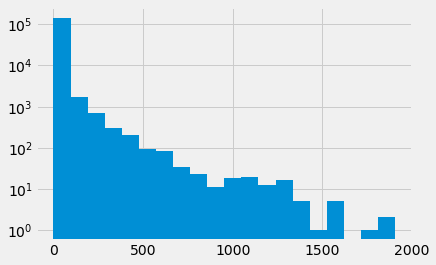

time: 1.97 s (started: 2021-09-28 01:41:45 +01:00)


In [87]:
fig = plt.hist(list(counts.values()), bins=20, log=True)
plt.show()

Let's now create meaningful edge thicknesses for visualising the street segments with highest bicycle flow demand.

In [88]:
eth = [d['count'] if 'count' in d else 0 for u, v, k, d in list(Gc.edges(keys=True, data=True))]
print(eth[:10])
edge_thickness = eth.copy()

from numpy import *
edge_thickness = ma.log(edge_thickness)
edge_thickness = edge_thickness.filled(0)
edge_thickness = edge_thickness / np.log(5)
edge_thickness[:20]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 753]


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 4.11576313,
       3.0049509 , 4.0357354 , 3.37616131, 0.        , 4.11576313,
       0.        , 0.        , 0.        , 3.08791862, 0.        ])

time: 578 ms (started: 2021-09-28 01:41:47 +01:00)


In [89]:
G_bike.graph

{'created_date': '2021-09-27 23:14:06',
 'created_with': 'OSMnx 1.1.1',
 'crs': <Projected CRS: +proj=utm +zone=32 +ellps=WGS84 +datum=WGS84 +unit ...>
 Name: unknown
 Axis Info [cartesian]:
 - E[east]: Easting (metre)
 - N[north]: Northing (metre)
 Area of Use:
 - undefined
 Coordinate Operation:
 - name: UTM zone 32N
 - method: Transverse Mercator
 Datum: World Geodetic System 1984
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich,
 'simplified': True}

time: 62 ms (started: 2021-09-28 01:41:48 +01:00)


## Visualising the results

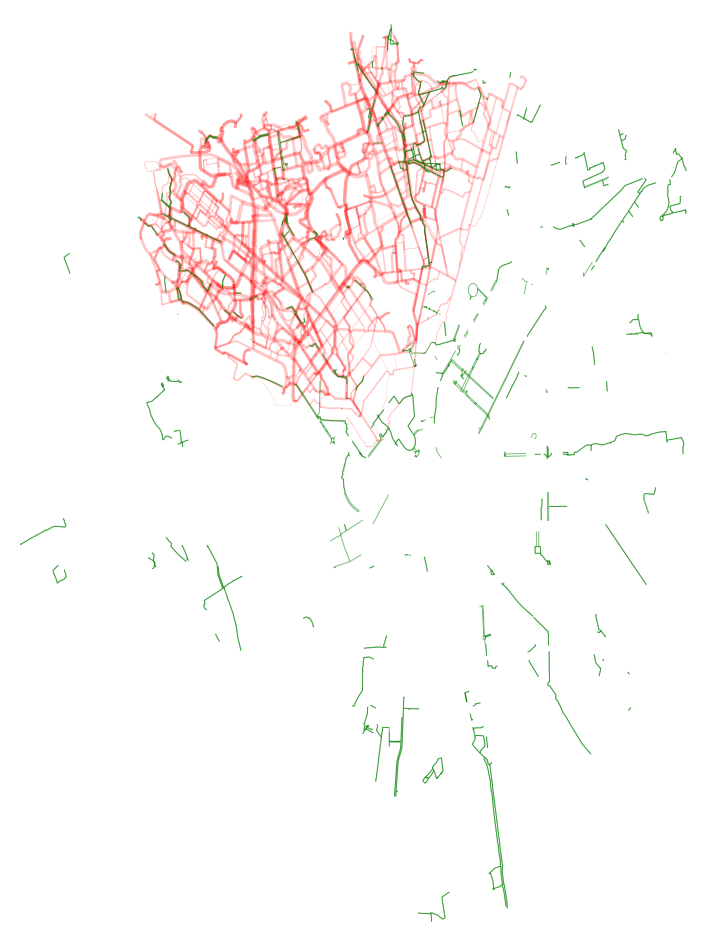

time: 18.6 s (started: 2021-09-28 01:41:48 +01:00)


In [90]:
fig, ax = ox.plot_graph(Gc, figsize=(16, 16), bgcolor='w', node_size=0, node_color='w', node_edgecolor='none', node_zorder=2,
                        edge_color='red', edge_linewidth=edge_thickness, edge_alpha=0.22, show=False, close=False)

ox.plot_graph(G_bike, ax = ax, bgcolor='w', node_size=0, node_color='w', node_edgecolor='none', node_zorder=1,
                        edge_color='green', edge_linewidth=1, edge_alpha=0.5, show=False, close=False)

df.plot(column='cluster', categorical=True, alpha=0.3, cmap='hot', ax=ax, zorder=-3)

plt.show()

Let's now identify and plot the 500 streets with highest bicycle flow demand. In order to do that, let's first get GeoDataFrames containing the nodes and edges of the street network.

In [91]:
gdf_nodes, gdf_edges = ox.utils_graph.graph_to_gdfs(Gc)
gdf_edges.head()

osmid  oneway lanes        name   highway  \
u         v         key                                                  
10371529  743371634 0    274433644    True     2  Via Novara   primary   
          743371622 0     26703159    True   NaN  Via Novara  tertiary   
743371634 267879825 0    274433661    True     2  Via Novara   primary   
          743371622 0     59995455    True   NaN  Via Novara  tertiary   
743371622 745843770 0     59995448    True   NaN  Via Novara  tertiary   

                          length  \
u         v         key            
10371529  743371634 0    154.435   
          743371622 0    150.466   
743371634 267879825 0     34.101   
          743371622 0     47.849   
743371622 745843770 0     26.993   

                                                                  geometry  \
u         v         key                                                      
10371529  743371634 0    LINESTRING (505987.753 5037117.669, 505836.365...   
          743371622 0    LINESTRING (505987.753 5037117.669, 505947.376...   
743371634 267879825 0    LINESTRING (505836.365 5037149.933, 505803.085...   
          743371622 0    LINESTRING (505836.365 5037149.933, 505846.964...   
743371622 745843770 0    LINESTRING (505854.788 5037187.868, 505831.613...   

                         count maxspeed junction  ref bridge tunnel access  \
u         v         key                                                      
10371529  743371634 0      0.0      NaN      NaN  NaN    NaN    NaN    NaN   
          743371622 0      0.0      NaN      NaN  NaN    NaN    NaN    NaN   
743371634 267879825 0      0.0      NaN      NaN  NaN    NaN    NaN    NaN   
          743371622 0      0.0      NaN      NaN  NaN    NaN    NaN    NaN   
743371622 745843770 0      0.0      NaN      NaN  NaN    NaN    NaN    NaN   

                        service width est_width area  
u         v         key                               
10371529  743371634 0       NaN   NaN       NaN  NaN  
          743371622 0       NaN   NaN       NaN  NaN  
743371634 267879825 0       NaN   NaN       NaN  NaN  
          743371622 0       NaN   NaN       NaN  NaN  
743371622 745843770 0       NaN   NaN       NaN  NaN

time: 9.72 s (started: 2021-09-28 01:42:07 +01:00)


In [92]:
len(gdf_edges)

150932

time: 0 ns (started: 2021-09-28 01:42:16 +01:00)


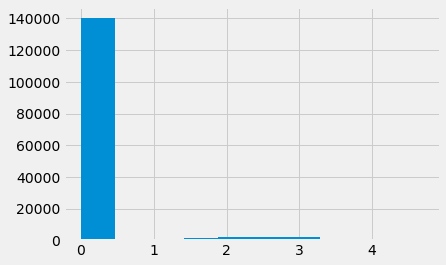

time: 188 ms (started: 2021-09-28 01:42:16 +01:00)


In [93]:
fig = plt.hist(edge_thickness, bins=10)
plt.show()

Let's now get the indices of the 500 thickest edges, or, in other words, the indices of the 500 streets with most demand:

In [94]:
ind = np.argpartition(edge_thickness, -500)[-500:]
ind

array([ 18624,  20063,  52220,  76751,  20060,  52537,  20059,  32673,
        52510,   1313,  23401,    243,  23397,  20459,  78144,  81386,
        10826,  82093,  78151, 139250,  55024,  81236,  78156,  97823,
        18256,  81239,  18251,  45918, 122631,  19875,  28935,  52709,
        28934,  81427, 110744,  89113,  66825,  89115,  81257,  20405,
        18830,  52175,  45134,  19515, 110672,   3725,  75850,  11185,
        18834,  52637,  20010,  40661,  18835,  18836,  18250,  18839,
        51662,  81262,  40659,  20125,  40658,  58992,  20119,  47076,
         2350,  58991,  31481,  18770,  61712,  23425,  26858,  53544,
        40041, 130138,  20095,  53550,  39851,  81276,  58982, 105377,
        58975,  46466, 121237,  20425,  26776,  40072, 123378, 123376,
        54389,  53740,  52841,  67949, 103571,  40154,  77687,  66836,
         1110,  39870,  39872,  86967,  18658,   6816,  39875, 100402,
        18656, 112083,  13671, 112101,  45230,  39882,  13670, 121241,
      

time: 0 ns (started: 2021-09-28 01:42:17 +01:00)


In [95]:
bikes_gdf = gdf_edges.iloc[ind]
bikes_gdf.head()

osmid  oneway lanes                     name  \
u          v          key                                                     
245555951  255508200  0     22821298   False   NaN      Via Filippo Palizzi   
2543553184 649739535  0     51450356   False   NaN            Via Ugo Betti   
649739535  2395321637 0    276086877   False   NaN            Via Ugo Betti   
1944647036 1561516772 0    184024888   False   NaN  Via Pier Francesco Mola   
2807193900 249381650  0     53572982   False   NaN            Via Ugo Betti   

                                highway  length  \
u          v          key                         
245555951  255508200  0        tertiary  23.829   
2543553184 649739535  0    unclassified   9.431   
649739535  2395321637 0    unclassified  55.943   
1944647036 1561516772 0     residential   9.360   
2807193900 249381650  0    unclassified  36.771   

                                                                    geometry  \
u          v          key                                                      
245555951  255508200  0    LINESTRING (510880.733 5038867.281, 510870.576...   
2543553184 649739535  0    LINESTRING (508615.720 5038076.694, 508624.851...   
649739535  2395321637 0    LINESTRING (508624.851 5038079.139, 508635.359...   
1944647036 1561516772 0    LINESTRING (511110.762 5038202.988, 511112.289...   
2807193900 249381650  0    LINESTRING (508578.850 5038036.470, 508598.114...   

                           count maxspeed junction  ref bridge tunnel access  \
u          v          key                                                      
245555951  255508200  0    388.0      NaN      NaN  NaN    NaN    NaN    NaN   
2543553184 649739535  0    388.0      NaN      NaN  NaN    NaN    NaN    NaN   
649739535  2395321637 0    388.0      NaN      NaN  NaN    NaN    NaN    NaN   
1944647036 1561516772 0    388.0      NaN      NaN  NaN    NaN    NaN    NaN   
2807193900 249381650  0    388.0      NaN      NaN  NaN    NaN    NaN    NaN   

                          service width est_width area  
u          v          key                               
245555951  255508200  0       NaN   NaN       NaN  NaN  
2543553184 649739535  0       NaN   NaN       NaN  NaN  
649739535  2395321637 0       NaN   NaN       NaN  NaN  
1944647036 1561516772 0       NaN   NaN       NaN  NaN  
2807193900 249381650  0       NaN   NaN       NaN  NaN

time: 94 ms (started: 2021-09-28 01:42:17 +01:00)


In [96]:
from pyproj import CRS
crs = CRS.from_epsg(4326)
bikes_gdf = bikes_gdf.to_crs(crs)
bikes_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

time: 172 ms (started: 2021-09-28 01:42:17 +01:00)


<AxesSubplot:>

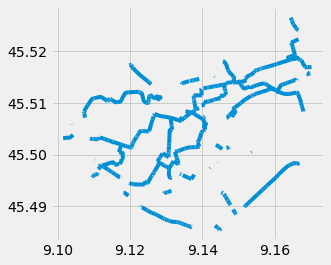

time: 188 ms (started: 2021-09-28 01:42:17 +01:00)


In [97]:
bikes_gdf.plot()

Finally, let's visualise these streets interactively with the help of the `Folium` package.

In [98]:
import folium
m = folium.Map([45.510, 9.175], zoom_start=10)
 
folium.Choropleth(
    bikes_gdf,
    line_weight=3,
    line_color='blue'
).add_to(m)

m

time: 375 ms (started: 2021-09-28 01:42:17 +01:00)


Finally, let's visualise the identified streets that need bicycle lanes the most together with the existing bicycle infrastructure. To achieve this, let's do the same above operations on the bicycle graph we got in the beginning:

In [99]:
gdf_nodes_bikes, gdf_edges_bikes = ox.utils_graph.graph_to_gdfs(G_bike)
gdf_edges_bikes.head()

osmid  oneway   highway   length  \
u          v          key                                         
21226389   8938964148 0    244419981    True  cycleway   34.179   
8938964148 3721905834 0    244419981    True  cycleway    2.710   
25543602   1272057784 0    628406304   False  cycleway  251.277   
1272057784 25543602   0    628406304   False  cycleway  251.277   
27551147   8726650222 0    942396777    True  cycleway   14.465   

                                                                    geometry  \
u          v          key                                                      
21226389   8938964148 0    LINESTRING (516046.116 5035631.792, 516045.760...   
8938964148 3721905834 0    LINESTRING (516023.610 5035654.154, 516022.924...   
25543602   1272057784 0    LINESTRING (517175.403 5031648.949, 517180.645...   
1272057784 25543602   0    LINESTRING (517008.292 5031510.635, 517009.577...   
27551147   8726650222 0    LINESTRING (519005.067 5039679.202, 518990.590...   

                          name bridge access maxspeed lanes tunnel width  
u          v          key                                                 
21226389   8938964148 0    NaN    NaN    NaN      NaN   NaN    NaN   NaN  
8938964148 3721905834 0    NaN    NaN    NaN      NaN   NaN    NaN   NaN  
25543602   1272057784 0    NaN    NaN    NaN      NaN   NaN    NaN   NaN  
1272057784 25543602   0    NaN    NaN    NaN      NaN   NaN    NaN   NaN  
27551147   8726650222 0    NaN    NaN    NaN      NaN   NaN    NaN   NaN

time: 156 ms (started: 2021-09-28 01:42:17 +01:00)


In [100]:
gdf_edges_bikes = gdf_edges_bikes.to_crs(crs)
gdf_edges_bikes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

time: 188 ms (started: 2021-09-28 01:42:18 +01:00)


<AxesSubplot:>

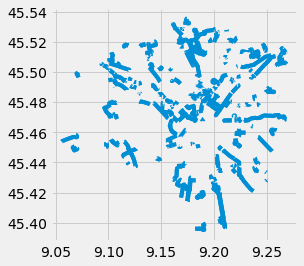

time: 360 ms (started: 2021-09-28 01:42:18 +01:00)


In [101]:
gdf_edges_bikes.plot()

In [102]:
m = folium.Map([45.510, 9.175], zoom_start=10)
 
folium.Choropleth(
    bikes_gdf,
    line_weight=4,
    line_color='blue',
    opacity=0.5
).add_to(m)

folium.Choropleth(
    gdf_edges_bikes,
    line_weight=1.5,
    line_color='red'
).add_to(m)

m

time: 1.44 s (started: 2021-09-28 01:42:18 +01:00)


## Homework Assignment

Complete the same analysis and suggest street segments to be converted to bicycle lanes in any city in the world of your choice. Watch out for the NASA population density grid resolution to be fine enough for obtaining good results.

Complete the task in a clean Jupyter Notebook, name the notebook **< Name > < Surname > Class 7 Homework** and upload it to Moodle.